In [2]:

# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler

# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Sharpley value
import shap
import lime
import lime.lime_tabular


# stepwise
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV



# statics
import scipy.stats as st
import torch

import random 

random.seed(10)


In [3]:
import pickle
#load the model
filename2 = 'rf.sav'
optimal_rf_clf = pickle.load(open(filename2, 'rb'))

In [4]:
#Load the train and test data
X_train= pd.read_csv("./X_train.csv")
X_test= pd.read_csv("./X_test.csv")

X_train = X_train.drop(['Unnamed: 0'],axis=1)
X_test = X_test.drop(['Unnamed: 0'],axis=1)

In [5]:
#load the individual explanations of Random Forest
rf_df = pd.read_csv('./rf_indi_exp.csv')

## Explainability Uncertainty 

In [5]:
# instance for individual explanations
choosen_instance = X_test.iloc[:1]
choosen_instance

limit_bal  sex       age  pay_Sep  pay_Aug  pay_Jul  pay_Jun  pay_May  \
0  -0.828424    0 -1.462993        3        2        2        2        2   

   pay_Apr  bill_amt_Sep  ...  pay_amt_Aug  pay_amt_Jul  pay_amt_Jun  \
0        2      0.140351  ...    -0.100048    -0.279705    -0.148416   

   pay_amt_May  pay_amt_Apr  education_graduate school  education_high school  \
0    -0.229047    -0.293382                          0                      0   

   education_university  marriage_married  marriage_single  
0                     1                 0                1  

[1 rows x 26 columns]

In [6]:
#function of calculating the L2 distance
def set_distance(dataset,p,q):
    num_feature = dataset._get_numeric_data().columns
    continuous_contribution = np.sum((p[num_feature].values.squeeze()-q[num_feature].values.squeeze())**2)
    return continuous_contribution

In [7]:
#compute the distance between chosen instances and remaining instance in testing dataset
dist=np.zeros(X_test.shape[0])
for i in range(X_test.shape[0]):
    q = X_test.iloc[i:(i+1)]
    dist[i] = set_distance(X_test,choosen_instance,q)
X_test['dist']=dist
sort_data=X_test.reindex(X_test.dist.sort_values(ascending=True).index)
sort_data

limit_bal  sex       age  pay_Sep  pay_Aug  pay_Jul  pay_Jun  pay_May  \
0     -0.828424    0 -1.462993        3        2        2        2        2   
7561  -0.751350    0 -1.029047        3        2        2        2        2   
6640  -0.674276    0 -1.029047        3        2        2        2        2   
8131  -0.828424    0 -1.029047        2        2        2        2        2   
7330  -0.905498    0 -1.137534        3        3        2        2        2   
...         ...  ...       ...      ...      ...      ...      ...      ...   
3708   2.562830    0  0.815221       -1       -1       -1        0        0   
1254   4.335531    1  0.164303        0        0        0        0       -1   
6156   3.410644    1 -0.486615        0       -1        2       -1       -1   
1576   2.639904    0 -0.595102       -1       -1       -1       -1        0   
1990   2.562830    0 -0.269643       -2       -2       -1       -1       -2   

      pay_Apr  bill_amt_Sep  ...  pay_amt_Jul  pay_amt_Jun  pay_amt_May  \
0           2      0.140351  ...    -0.279705    -0.148416    -0.229047   
7561        2     -0.027464  ...    -0.183208    -0.180397    -0.314136   
6640        2     -0.083321  ...    -0.183208    -0.308063     0.078584   
8131        2      0.125371  ...    -0.296120    -0.103797    -0.208167   
7330        2     -0.212282  ...    -0.211606    -0.196355    -0.223156   
...       ...           ...  ...          ...          ...          ...   
3708       -1     -0.641876  ...    -0.013443    -0.301679    -0.301045   
1254        0      0.259194  ...     0.216357    33.452975     1.126165   
6156       -1      4.035719  ...    19.547669    15.659359    17.430208   
1576        0      0.270222  ...     9.050623    -0.275508     0.094227   
1990       -1     -0.693944  ...     6.622793     5.926498    24.510169   

      pay_amt_Apr  education_graduate school  education_high school  \
0       -0.293382                          0                      0   
7561    -0.065787                          0                      0   
6640    -0.293382                          0                      0   
8131    -0.293382                          0                      0   
7330    -0.293382                          0                      0   
...           ...                        ...                    ...   
3708    29.445098                          0                      0   
1254     0.550397                          0                      0   
6156    12.086317                          1                      0   
1576    -0.037436                          1                      0   
1990     1.211863                          1                      0   

      education_university  marriage_married  marriage_single         dist  
0                        1                 0                1     0.000000  
7561                     1                 0                1     0.651774  
6640                     1                 0                1     0.701682  
8131                     1                 0                1     1.301149  
7330                     1                 0                1     1.522568  
...                    ...               ...              ...          ...  
3708                     1                 0                1  1134.298295  
1254                     1                 1                0  1325.135083  
6156                     0                 0                1  1649.986007  
1576                     0                 0                1  3954.844593  
1990                     0                 1                0  6694.355130  

[9900 rows x 27 columns]

In [8]:
# set the k-nearest neighborhood
choosen_range = sort_data.iloc[:256]
choosen_range=choosen_range.drop(['dist'], axis=1)
choosen_range

limit_bal  sex       age  pay_Sep  pay_Aug  pay_Jul  pay_Jun  pay_May  \
0     -0.828424    0 -1.462993        3        2        2        2        2   
7561  -0.751350    0 -1.029047        3        2        2        2        2   
6640  -0.674276    0 -1.029047        3        2        2        2        2   
8131  -0.828424    0 -1.029047        2        2        2        2        2   
7330  -0.905498    0 -1.137534        3        3        2        2        2   
...         ...  ...       ...      ...      ...      ...      ...      ...   
2686  -1.059646    0 -1.462993        1        2        2        2        2   
9894  -1.059646    1 -0.378129        3        2        2        2        0   
1454  -0.211833    1  0.598248        2        2        2        2        2   
733   -0.443054    1 -0.703588        2        2        2        2        0   
2770  -0.905498    0  0.381275        1        2        2        2        2   

      pay_Apr  bill_amt_Sep  ...  pay_amt_Aug  pay_amt_Jul  pay_amt_Jun  \
0           2      0.140351  ...    -0.100048    -0.279705    -0.148416   
7561        2     -0.027464  ...    -0.035640    -0.183208    -0.180397   
6640        2     -0.083321  ...    -0.170186    -0.183208    -0.308063   
8131        2      0.125371  ...    -0.152825    -0.296120    -0.103797   
7330        2     -0.212282  ...    -0.204907    -0.211606    -0.196355   
...       ...           ...  ...          ...          ...          ...   
2686        0     -0.314883  ...    -0.256990    -0.094946    -0.308063   
9894        0     -0.262490  ...    -0.157165    -0.296801    -0.244485   
1454        2      0.299257  ...    -0.256990     0.100775    -0.116564   
733         0      0.060796  ...    -0.148485    -0.296801    -0.180397   
2770        2     -0.465003  ...    -0.039980    -0.296801     0.330267   

      pay_amt_May  pay_amt_Apr  education_graduate school  \
0       -0.229047    -0.293382                          0   
7561    -0.314136    -0.065787                          0   
6640     0.078584    -0.293382                          0   
8131    -0.208167    -0.293382                          0   
7330    -0.223156    -0.293382                          0   
...           ...          ...                        ...   
2686    -0.236247    -0.235443                          0   
9894    -0.248683    -0.293382                          0   
1454    -0.314136     0.156633                          0   
733     -0.183229    -0.189091                          0   
2770    -0.314136     0.269137                          0   

      education_high school  education_university  marriage_married  \
0                         0                     1                 0   
7561                      0                     1                 0   
6640                      0                     1                 0   
8131                      0                     1                 0   
7330                      0                     1                 0   
...                     ...                   ...               ...   
2686                      0                     1                 1   
9894                      0                     1                 0   
1454                      0                     1                 1   
733                       0                     1                 0   
2770                      0                     1                 1   

      marriage_single  
0                   1  
7561                1  
6640                1  
8131                1  
7330                1  
...               ...  
2686                0  
9894                1  
1454                0  
733                 1  
2770                0  

[256 rows x 26 columns]

#### Random forest

In [9]:
# function to compute the uncertainty intervals of random forest's explanations 
def bootstrap_rf(fit,x_data,n_samples,sample_size,explainer,backset):
    #poly = PolynomialFeatures(degree=2, include_bias=False)
    n_features=x_data.shape[1]
    total = torch.zeros(n_samples,n_features)
    d = {'Feature': backset.columns, 'col2': np.zeros(26)}
    columns =  pd.DataFrame(data=d)
    ci=np.zeros([n_features,2])
    for i in range(n_samples):
        bootstrap_sample = x_data.sample(n=sample_size,replace=True)
        bootstrap_index = bootstrap_sample.index.values# sample indeices in test dataset
        if explainer=='shap':
            # calculate the shapley values
            explainer_shap = shap.Explainer(fit, backset)
            shap_values = explainer_shap(bootstrap_sample,check_additivity=False).values
            shap_values = shap_values[:,:,1]
            mean_shap = shap_values.mean(axis=0)
            total[i,:]=torch.from_numpy(mean_shap)
            print(i)
        if explainer=='lime':
            lime_values=np.zeros(n_features)
            explainer_lime = lime.lime_tabular.LimeTabularExplainer(backset.values, feature_names=backset.columns.values.tolist(), class_names=['0','1'], verbose=True,mode='classification',discretize_continuous=False)
            for j in range(sample_size):
                lime_exp = explainer_lime.explain_instance(bootstrap_sample.iloc[j,:], fit.predict_proba,num_features=26)
                df=pd.DataFrame(lime_exp.as_list(),columns=['Feature','Contribution'])
                df=pd.merge(columns, df, left_on='Feature', right_on='Feature', how='left')
                lime_values = lime_values+df['Contribution'].to_numpy()
            total[i,:]=torch.from_numpy(lime_values/sample_size)
                  
    for j in range(n_features):
        ci[j,0]=torch.quantile(total[:,j], 0.025, interpolation='nearest')
        ci[j,1]=torch.quantile(total[:,j], 0.975, interpolation='nearest')
    return(ci)

In [10]:
# compute the uncertainty of Shapley values
shap_ci=bootstrap_rf(optimal_rf_clf,choosen_range,200,70,'shap',X_train)

0
1
2
3
4
5
6
7
8


 99%|===================| 138/140 [00:11<00:00]       

9
10
11
12
13
14


 94%|=================== | 132/140 [00:11<00:00]       

15
16
17
18
19
20
21
22
23


 96%|=================== | 134/140 [00:11<00:00]       

24


 95%|=================== | 133/140 [00:11<00:00]       

25
26
27


 96%|=================== | 135/140 [00:11<00:00]       

28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


 99%|===================| 138/140 [00:11<00:00]       

46


 96%|=================== | 135/140 [00:11<00:00]       

47
48


 92%|==================  | 129/140 [00:11<00:00]       

49


 92%|==================  | 129/140 [00:11<00:00]       

50
51


 96%|=================== | 135/140 [00:11<00:00]       

52
53
54
55
56
57
58
59
60
61
62
63
64


 94%|=================== | 131/140 [00:11<00:00]       

65
66
67
68
69
70


 96%|=================== | 135/140 [00:11<00:00]       

71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


 92%|==================  | 129/140 [00:11<00:00]       

95
96
97
98
99
100
101


 99%|===================| 138/140 [00:11<00:00]       

102
103
104
105
106
107
108
109
110
111
112


 99%|===================| 139/140 [00:11<00:00]       

113
114
115
116
117
118


 98%|===================| 137/140 [00:11<00:00]       

119
120


 99%|===================| 138/140 [00:11<00:00]       

121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137


 97%|=================== | 136/140 [00:11<00:00]       

138
139
140
141
142
143
144
145


 99%|===================| 139/140 [00:11<00:00]       

146


 97%|=================== | 136/140 [00:11<00:00]       

147
148
149
150
151
152
153
154
155
156
157
158
159
160


 99%|===================| 138/140 [00:11<00:00]       

161
162
163
164
165
166


 95%|=================== | 133/140 [00:11<00:00]       

167


 94%|=================== | 131/140 [00:11<00:00]       

168


 99%|===================| 138/140 [00:11<00:00]       

169
170
171
172
173
174
175
176
177


 95%|=================== | 133/140 [00:11<00:00]       

178
179
180
181
182
183
184


 99%|===================| 139/140 [00:11<00:00]       

185
186
187
188
189
190
191
192


 95%|=================== | 133/140 [00:11<00:00]       

193
194


 94%|=================== | 131/140 [00:11<00:00]       

195
196
197
198
199


In [11]:
# compute the uncertainty of LIME coefficients
lime_ci=bootstrap_rf(optimal_rf_clf,choosen_range,200,70,'lime',X_train)

Intercept 0.34126854774022963
Prediction_local [0.54382809]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387922549543176
Prediction_local [0.54722025]
Right: 0.9408034621849833
Intercept 0.3388833952796923
Prediction_local [0.5535213]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387083597617633
Prediction_local [0.53652012]
Right: 0.9264447828085057
Intercept 0.3376119488920854
Prediction_local [0.5641138]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34023783647231615
Prediction_local [0.54376043]
Right: 0.9408034621849833
Intercept 0.33838678781120446
Prediction_local [0.56350562]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401235087561047
Prediction_local [0.62121826]
Right: 0.8724981610129818
Intercept 0.3397518062936756
Prediction_local [0.56012052]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387110630355081
Prediction_local [0.55193262]
Right: 0.9437750204830803
Intercept 0.3393548530061494
Prediction_local [0.50927511]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34172664629689065
Prediction_local [0.56333313]
Right: 0.9373866526295325
Intercept 0.3389687068970577
Prediction_local [0.50209275]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33843805956654177
Prediction_local [0.51655494]
Right: 0.8379030201413508
Intercept 0.3379917122317983
Prediction_local [0.54533912]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387468756014746
Prediction_local [0.58037754]
Right: 0.884295654674324
Intercept 0.3395696647318639
Prediction_local [0.51714828]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408233980545724
Prediction_local [0.49932966]
Right: 0.75132142564098
Intercept 0.33850715183753144
Prediction_local [0.49411251]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945079300502085
Prediction_local [0.55111354]
Right: 0.9034989705087143
Intercept 0.3390690236024746
Prediction_local [0.56599273]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396170054847627
Prediction_local [0.56128006]
Right: 0.9207415547013701
Intercept 0.3377694503776331
Prediction_local [0.55098651]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395979988946496
Prediction_local [0.56134675]
Right: 0.9262790818292136
Intercept 0.34003042426986124
Prediction_local [0.56806675]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33981769828296293
Prediction_local [0.54960185]
Right: 0.9307885932850407
Intercept 0.33965649196710646
Prediction_local [0.53757456]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33959231687727776
Prediction_local [0.59207134]
Right: 0.884295654674324
Intercept 0.3405777629253358
Prediction_local [0.55105056]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34027922684646394
Prediction_local [0.55214964]
Right: 0.9215541663355905
Intercept 0.3384824591439078
Prediction_local [0.49989038]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994637404680456
Prediction_local [0.54253985]
Right: 0.6773760446861684
Intercept 0.33956843900027445
Prediction_local [0.49074155]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392690882071388
Prediction_local [0.55378877]
Right: 0.9306514311543254
Intercept 0.3391378273219218
Prediction_local [0.57049874]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841323370625837
Prediction_local [0.49517967]
Right: 0.8114972780489129
Intercept 0.3404075634374892
Prediction_local [0.54076201]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398022754409144
Prediction_local [0.5028983]
Right: 0.9222852236748612
Intercept 0.33789162694875957
Prediction_local [0.5950845]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33981173044324614
Prediction_local [0.56142385]
Right: 0.9207415547013701
Intercept 0.3395505487574218
Prediction_local [0.45962205]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338099249095919
Prediction_local [0.53568443]
Right: 0.8177807125462376
Intercept 0.3413194621193695
Prediction_local [0.51773214]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387267420566936
Prediction_local [0.50154266]
Right: 0.7664819708628527
Intercept 0.3407761227511089
Prediction_local [0.53903901]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376618063965174
Prediction_local [0.55249622]
Right: 0.9310040541782458
Intercept 0.3403024472797918
Prediction_local [0.54884601]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33885448601514345
Prediction_local [0.51801439]
Right: 0.861763863974641
Intercept 0.3386576709705338
Prediction_local [0.50450247]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877028957929944
Prediction_local [0.55355101]
Right: 0.9258520709002196
Intercept 0.3362554177599474
Prediction_local [0.55098268]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339137283751127
Prediction_local [0.5618327]
Right: 0.9215372357954847
Intercept 0.3392126410034093
Prediction_local [0.58022978]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390940908028826
Prediction_local [0.55298794]
Right: 0.9102300222996818
Intercept 0.34035450291878017
Prediction_local [0.59469358]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402855243272991
Prediction_local [0.52573451]
Right: 0.8732323840279448
Intercept 0.33976083395493867
Prediction_local [0.56826508]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923126168534345
Prediction_local [0.55116902]
Right: 0.8898605149198482
Intercept 0.3396316849483453
Prediction_local [0.51266892]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33843159991720717
Prediction_local [0.53666586]
Right: 0.82955892131645
Intercept 0.34006666127202734
Prediction_local [0.59194116]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387705075762589
Prediction_local [0.4987104]
Right: 0.8036736142066315
Intercept 0.34053464664273436
Prediction_local [0.51693581]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395869041834417
Prediction_local [0.53802324]
Right: 0.9399326984093871
Intercept 0.3388953167213978
Prediction_local [0.50783645]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896414772029565
Prediction_local [0.5563402]
Right: 0.8242388990947697
Intercept 0.3389598879353281
Prediction_local [0.55513691]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942972847336733
Prediction_local [0.57414506]
Right: 0.9065288394923209
Intercept 0.3399381412996948
Prediction_local [0.50980409]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945927718383195
Prediction_local [0.60986583]
Right: 0.9377721294259834
Intercept 0.3409140050055395
Prediction_local [0.60383993]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390178075585048
Prediction_local [0.49947472]
Right: 0.6603239831574742
Intercept 0.34055598036477613
Prediction_local [0.51613198]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407107098916091
Prediction_local [0.54900843]
Right: 0.9046778068541609
Intercept 0.3382932438693699
Prediction_local [0.55825051]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396274999048609
Prediction_local [0.50308853]
Right: 0.7519462429654693
Intercept 0.3385530054815988
Prediction_local [0.56743087]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374657966191319
Prediction_local [0.509794]
Right: 0.8723434818108512
Intercept 0.33957090587845334
Prediction_local [0.66704048]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33870147260342215
Prediction_local [0.54676788]
Right: 0.9159551516262843
Intercept 0.33977614744282864
Prediction_local [0.55346616]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928308126182644
Prediction_local [0.48831524]
Right: 0.7535858649555798
Intercept 0.34094887984966127
Prediction_local [0.50623128]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33717835791812023
Prediction_local [0.65581741]
Right: 0.7908588087131807
Intercept 0.3394626367584277
Prediction_local [0.55147164]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399612051352957
Prediction_local [0.60077763]
Right: 0.9360733936921937
Intercept 0.3410259665780093
Prediction_local [0.54964377]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402904696284975
Prediction_local [0.49653754]
Right: 0.7076856478538689
Intercept 0.33903156000138446
Prediction_local [0.55817095]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33967539343784975
Prediction_local [0.49977687]
Right: 0.7076856478538689
Intercept 0.33838066875101414
Prediction_local [0.54893239]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33857278191728823
Prediction_local [0.59661657]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412008307780178
Prediction_local [0.49800639]
Right: 0.8520607252626121
Intercept 0.3403508822637216
Prediction_local [0.53492641]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984861442646486
Prediction_local [0.53433538]
Right: 0.9246795787711494
Intercept 0.34104217797694353
Prediction_local [0.54935492]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403925988954378
Prediction_local [0.52294583]
Right: 0.7585404256595941
Intercept 0.3404191546978054
Prediction_local [0.56108437]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398418113272088
Prediction_local [0.50639356]
Right: 0.8204378898925083
Intercept 0.34202529976710344
Prediction_local [0.5601068]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33781438703191236
Prediction_local [0.71479092]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34022743113563575
Prediction_local [0.5042466]
Right: 0.774337305966193
Intercept 0.33794236740459604
Prediction_local [0.56011146]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337558422686244
Prediction_local [0.62193356]
Right: 0.9104812879268801
Intercept 0.3397382068251448
Prediction_local [0.67708065]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398750484335806
Prediction_local [0.53753261]
Right: 0.82955892131645
Intercept 0.3386964727895492
Prediction_local [0.57669296]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405237859271162
Prediction_local [0.54823622]
Right: 0.9358925237461453
Intercept 0.33989883238387136
Prediction_local [0.53861656]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33802080371902155
Prediction_local [0.6412386]
Right: 0.9452364950934921
Intercept 0.3403280748140684
Prediction_local [0.51582509]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990120484010705
Prediction_local [0.51422825]
Right: 0.8723434818108512
Intercept 0.33892660511532796
Prediction_local [0.53154116]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34039288319629674
Prediction_local [0.50029349]
Right: 0.7713193787483651
Intercept 0.3401259312280548
Prediction_local [0.5435344]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396940682079241
Prediction_local [0.50478385]
Right: 0.774337305966193
Intercept 0.33935476782145024
Prediction_local [0.52737178]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34064059447252526
Prediction_local [0.53684442]
Right: 0.8156570835495003
Intercept 0.3373152960680815
Prediction_local [0.70486717]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914516113337934
Prediction_local [0.55980694]
Right: 0.8640183926612593
Intercept 0.33934067461298373
Prediction_local [0.545959]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392140847799772
Prediction_local [0.60916077]
Right: 0.8947696247674071
Intercept 0.33905768620328913
Prediction_local [0.53831125]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378753875205386
Prediction_local [0.60298311]
Right: 0.9377721294259834
Intercept 0.3374810590448946
Prediction_local [0.54784647]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988576860935027
Prediction_local [0.55206827]
Right: 0.924562457510044
Intercept 0.33808661239089244
Prediction_local [0.50876929]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386058584475235
Prediction_local [0.50459213]
Right: 0.8818791998548223
Intercept 0.3405210996519472
Prediction_local [0.55734273]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404329786052653
Prediction_local [0.50869094]
Right: 0.657544567205239
Intercept 0.33930138662498815
Prediction_local [0.5651104]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939920272031865
Prediction_local [0.56101092]
Right: 0.86722870572122
Intercept 0.3395417061462974
Prediction_local [0.53287421]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34005117794584283
Prediction_local [0.55417776]
Right: 0.7636283457854093
Intercept 0.337888617718414
Prediction_local [0.50968623]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390367353654312
Prediction_local [0.55405346]
Right: 0.9307885932850407
Intercept 0.34011675157207366
Prediction_local [0.61608978]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33864123387969475
Prediction_local [0.54452827]
Right: 0.9079032455860242
Intercept 0.33978102742978944
Prediction_local [0.50654734]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392367614107492
Prediction_local [0.56321544]
Right: 0.8948576855236555
Intercept 0.3385746820259764
Prediction_local [0.51964565]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34121535893117416
Prediction_local [0.5085798]
Right: 0.7519462429654693
Intercept 0.3398364924185185
Prediction_local [0.55346005]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400818031069206
Prediction_local [0.50351659]
Right: 0.8818791998548223
Intercept 0.33989954513197485
Prediction_local [0.55071828]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372913796059698
Prediction_local [0.66513193]
Right: 0.8935208112959757
Intercept 0.34106817441300136
Prediction_local [0.5648998]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33891341134613234
Prediction_local [0.55670736]
Right: 0.9035283697946551
Intercept 0.33959375043938883
Prediction_local [0.49508654]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33785193099777316
Prediction_local [0.5511735]
Right: 0.922429103646433
Intercept 0.33914010373907155
Prediction_local [0.53850461]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389133081075767
Prediction_local [0.55741617]
Right: 0.8666250817935802
Intercept 0.3391805911845441
Prediction_local [0.54508145]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34022440328633
Prediction_local [0.51065195]
Right: 0.8428035949061745
Intercept 0.33746275351794025
Prediction_local [0.58913731]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393965667989617
Prediction_local [0.6065061]
Right: 0.9216981773752533
Intercept 0.33993928558231223
Prediction_local [0.52156957]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34037178385067174
Prediction_local [0.55725505]
Right: 0.922429103646433
Intercept 0.33724846641883754
Prediction_local [0.5352431]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951812668303294
Prediction_local [0.56681126]
Right: 0.8303348172585293
Intercept 0.33852011962004774
Prediction_local [0.50049417]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33875054868807103
Prediction_local [0.50219409]
Right: 0.7713193787483651
Intercept 0.3395138637293943
Prediction_local [0.56412682]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33719449805537777
Prediction_local [0.56253736]
Right: 0.9412066702660199
Intercept 0.33981715941534624
Prediction_local [0.59939757]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34088524404638887
Prediction_local [0.56023946]
Right: 0.9395936546811502
Intercept 0.3387117574036031
Prediction_local [0.62450203]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398896755511318
Prediction_local [0.70843813]
Right: 0.8219354702385137
Intercept 0.33952694094061325
Prediction_local [0.55319156]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405996294574163
Prediction_local [0.56423956]
Right: 0.8530364209239615
Intercept 0.3398507991660158
Prediction_local [0.54296797]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386157370782407
Prediction_local [0.5329637]
Right: 0.6980452226798741
Intercept 0.3382533726158937
Prediction_local [0.5493758]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927864393447543
Prediction_local [0.60574301]
Right: 0.9216981773752533
Intercept 0.3402478694755137
Prediction_local [0.54694347]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395083252131685
Prediction_local [0.5153338]
Right: 0.897827241466666
Intercept 0.34065635002899547
Prediction_local [0.5499919]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405500826856968
Prediction_local [0.55744689]
Right: 0.9409971509515689
Intercept 0.3378995713613873
Prediction_local [0.61385075]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387065875404874
Prediction_local [0.54966353]
Right: 0.8850896382220725
Intercept 0.34114029769658627
Prediction_local [0.53858028]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33879290019214325
Prediction_local [0.54288942]
Right: 0.9331912906202168
Intercept 0.33929884013820805
Prediction_local [0.53169989]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401536345526805
Prediction_local [0.55489183]
Right: 0.9094091543063568
Intercept 0.3385750427399748
Prediction_local [0.53870471]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340348367483478
Prediction_local [0.47589683]
Right: 0.8235458122803129
Intercept 0.33906200226269007
Prediction_local [0.58856793]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34049160034315007
Prediction_local [0.55480392]
Right: 0.9302175167388018
Intercept 0.3405861862321838
Prediction_local [0.56347532]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34022628529505267
Prediction_local [0.70604555]
Right: 0.8219354702385137
Intercept 0.3381485227893865
Prediction_local [0.54783644]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933633342517017
Prediction_local [0.50517996]
Right: 0.8080168770759789
Intercept 0.3390292116020232
Prediction_local [0.59924443]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877072001576275
Prediction_local [0.49435328]
Right: 0.7076856478538689
Intercept 0.3393394716629267
Prediction_local [0.54859592]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33989574087140473
Prediction_local [0.49908652]
Right: 0.9222852236748612
Intercept 0.3397310867410658
Prediction_local [0.56295309]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33891450616471536
Prediction_local [0.6763563]
Right: 0.8713727395827259
Intercept 0.3393258656239732
Prediction_local [0.55803007]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33874581560930866
Prediction_local [0.56088626]
Right: 0.8871249442644376
Intercept 0.3397382668934639
Prediction_local [0.51882743]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34016924983783176
Prediction_local [0.54999619]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384644530041164
Prediction_local [0.50018795]
Right: 0.8221058562463509
Intercept 0.3394969444709746
Prediction_local [0.49250593]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34032718884097535
Prediction_local [0.53333912]
Right: 0.851058417241244
Intercept 0.3393267797136459
Prediction_local [0.56127564]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944475113506273
Prediction_local [0.52818821]
Right: 0.6980452226798741
Intercept 0.3395516454925229
Prediction_local [0.58411887]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340063717045454
Prediction_local [0.523756]
Right: 0.9107589126800546
Intercept 0.3395364863400567
Prediction_local [0.53373305]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34100550573204846
Prediction_local [0.52664112]
Right: 0.8079963928168836
Intercept 0.338965050099005
Prediction_local [0.63185265]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951314511751013
Prediction_local [0.53221247]
Right: 0.6980452226798741
Intercept 0.33742297072667216
Prediction_local [0.56544043]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960144149860977
Prediction_local [0.49437842]
Right: 0.7664819708628527
Intercept 0.3402859134386606
Prediction_local [0.55986244]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34037597146345633
Prediction_local [0.55593184]
Right: 0.895669009551608
Intercept 0.34169929223000256
Prediction_local [0.55800115]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400595650823158
Prediction_local [0.60810387]
Right: 0.9104812879268801
Intercept 0.34057968361959
Prediction_local [0.56472851]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382626528341131
Prediction_local [0.53421683]
Right: 0.9399326984093871
Intercept 0.34032759782753613
Prediction_local [0.55017334]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392254942855419
Prediction_local [0.56224995]
Right: 0.9258567441860535
Intercept 0.34025807946055625
Prediction_local [0.57075237]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399098785975103
Prediction_local [0.66596095]
Right: 0.8713727395827259
Intercept 0.337899479936768
Prediction_local [0.51203959]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411813369399671
Prediction_local [0.50581528]
Right: 0.8114972780489129
Intercept 0.3392896707108336
Prediction_local [0.58470218]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338423165294214
Prediction_local [0.59631914]
Right: 0.8446070866905337
Intercept 0.33956383868679096
Prediction_local [0.55332594]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383722024779555
Prediction_local [0.55862605]
Right: 0.9377104655122402
Intercept 0.3414943369321298
Prediction_local [0.55925082]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34018579886047773
Prediction_local [0.55174402]
Right: 0.8986426888370751
Intercept 0.34125378697530734
Prediction_local [0.54582319]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34022064097846366
Prediction_local [0.55589619]
Right: 0.9373627697621636
Intercept 0.3390937600924807
Prediction_local [0.50599257]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927683005151277
Prediction_local [0.51320556]
Right: 0.8570143257314298
Intercept 0.33846678808605707
Prediction_local [0.53772902]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33913674039273844
Prediction_local [0.55308281]
Right: 0.9263037539280204
Intercept 0.3372198549406927
Prediction_local [0.51117507]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338631547784721
Prediction_local [0.55609198]
Right: 0.8809337984211464
Intercept 0.3408371395085876
Prediction_local [0.49916157]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3369259241561614
Prediction_local [0.54260651]
Right: 0.9301685534162497
Intercept 0.3394069664661325
Prediction_local [0.51004176]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972604493963826
Prediction_local [0.50288886]
Right: 0.657544567205239
Intercept 0.34172666717006367
Prediction_local [0.56604841]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33873927098618034
Prediction_local [0.55823565]
Right: 0.8861032625239513
Intercept 0.34003844401843847
Prediction_local [0.53190797]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900189541989134
Prediction_local [0.56002557]
Right: 0.9069208337852647
Intercept 0.34201349694916466
Prediction_local [0.57261051]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992786561229454
Prediction_local [0.5835977]
Right: 0.9055678529675756
Intercept 0.33837922554467204
Prediction_local [0.55134975]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915814173176445
Prediction_local [0.50688803]
Right: 0.8422486903336186
Intercept 0.3397855914808157
Prediction_local [0.60363244]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33876269078490123
Prediction_local [0.63076057]
Right: 0.9452364950934921
Intercept 0.3386176129018373
Prediction_local [0.50916079]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396887078626218
Prediction_local [0.55651957]
Right: 0.9233403123202862
Intercept 0.3378287001084364
Prediction_local [0.55421078]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029291200872835
Prediction_local [0.56773945]
Right: 0.8666250817935802
Intercept 0.3398506742391828
Prediction_local [0.5571184]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375505326586668
Prediction_local [0.54170957]
Right: 0.9246795787711494
Intercept 0.3384695174568023
Prediction_local [0.54421542]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387156385021661
Prediction_local [0.50094702]
Right: 0.7519462429654693
Intercept 0.3405579910284052
Prediction_local [0.56594116]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34020323215658593
Prediction_local [0.55201316]
Right: 0.916191953581191
Intercept 0.33927623677464974
Prediction_local [0.55691791]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33999406808903754
Prediction_local [0.56065739]
Right: 0.8531087202183028
Intercept 0.3392543430538425
Prediction_local [0.49619422]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396143672098744
Prediction_local [0.55308226]
Right: 0.8986853636375499
Intercept 0.3398435613370779
Prediction_local [0.50921586]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338443338615184
Prediction_local [0.53913594]
Right: 0.8156570835495003
Intercept 0.3391395251342169
Prediction_local [0.55544676]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34075410474589435
Prediction_local [0.52718739]
Right: 0.8412669672289342
Intercept 0.3403274021267048
Prediction_local [0.50588793]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911403386185385
Prediction_local [0.50637841]
Right: 0.8016158784819336
Intercept 0.34044825350031066
Prediction_local [0.54391384]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33845481066110766
Prediction_local [0.55841828]
Right: 0.8986853636375499
Intercept 0.33979927065562343
Prediction_local [0.51348354]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33956150148271447
Prediction_local [0.57412001]
Right: 0.9055678529675756
Intercept 0.3393648234751247
Prediction_local [0.51051217]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385127302407206
Prediction_local [0.53259286]
Right: 0.9128256075831467
Intercept 0.33872187192296466
Prediction_local [0.55636612]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33967351329893736
Prediction_local [0.55510182]
Right: 0.9201456610269827
Intercept 0.34040595317378497
Prediction_local [0.50986295]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386570577615696
Prediction_local [0.55103071]
Right: 0.8640183926612593
Intercept 0.3397923272841274
Prediction_local [0.54024434]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33910646410271733
Prediction_local [0.5069039]
Right: 0.8412712663786788
Intercept 0.3396686027986926
Prediction_local [0.58936017]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394163647900713
Prediction_local [0.50874832]
Right: 0.8428035949061745
Intercept 0.33949471878095444
Prediction_local [0.55187677]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939771482627257
Prediction_local [0.55518514]
Right: 0.9392898466056009
Intercept 0.3393026432152045
Prediction_local [0.54293518]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386492885684414
Prediction_local [0.55774816]
Right: 0.9035283697946551
Intercept 0.3398269921284313
Prediction_local [0.5405042]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33800023409335594
Prediction_local [0.53699019]
Right: 0.9030905818980651
Intercept 0.3407037420044213
Prediction_local [0.50400481]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33852531434876326
Prediction_local [0.55717518]
Right: 0.8948576855236555
Intercept 0.33851649633558023
Prediction_local [0.55239133]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394857342982743
Prediction_local [0.5608234]
Right: 0.9005983969235102
Intercept 0.3409509544358374
Prediction_local [0.51331777]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34016968393403746
Prediction_local [0.54937788]
Right: 0.7636283457854093
Intercept 0.3407185627219605
Prediction_local [0.55501686]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384345237671031
Prediction_local [0.64315342]
Right: 0.9452364950934921
Intercept 0.33909866137893185
Prediction_local [0.51381766]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339090146094671
Prediction_local [0.60022882]
Right: 0.9353307087390662
Intercept 0.3396959408947666
Prediction_local [0.549543]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390978156771964
Prediction_local [0.54954983]
Right: 0.9323100839380214
Intercept 0.33901631979025554
Prediction_local [0.54754606]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958264007343986
Prediction_local [0.54705101]
Right: 0.9121962315379973
Intercept 0.3392848441111872
Prediction_local [0.56274882]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393547871067904
Prediction_local [0.55644019]
Right: 0.9377104655122402
Intercept 0.3392926567277619
Prediction_local [0.54753399]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914551229330714
Prediction_local [0.50625419]
Right: 0.8379030201413508
Intercept 0.33859350358271983
Prediction_local [0.55468479]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33843383851063913
Prediction_local [0.56368887]
Right: 0.9150724288171773
Intercept 0.33797385684451947
Prediction_local [0.51183867]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33901077801857926
Prediction_local [0.51197268]
Right: 0.8827961778541205
Intercept 0.3373862539303123
Prediction_local [0.52511852]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33810632810199664
Prediction_local [0.56388454]
Right: 0.9373866526295325
Intercept 0.33928108691537323
Prediction_local [0.58984278]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400561039169029
Prediction_local [0.49615425]
Right: 0.6833194232895021
Intercept 0.3371639774206488
Prediction_local [0.55241909]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404863963609843
Prediction_local [0.50155941]
Right: 0.7275189958496487
Intercept 0.3384674159501451
Prediction_local [0.48673993]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399219947363337
Prediction_local [0.7102333]
Right: 0.8219354702385137
Intercept 0.33840791906838547
Prediction_local [0.48608865]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3370254996208849
Prediction_local [0.51039378]
Right: 0.8723434818108512
Intercept 0.3406181217729506
Prediction_local [0.49619729]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33948060595115687
Prediction_local [0.54799926]
Right: 0.9320431705819667
Intercept 0.3389459638238344
Prediction_local [0.52823942]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34034876653628365
Prediction_local [0.55776295]
Right: 0.9302175167388018
Intercept 0.338973487151874
Prediction_local [0.50939657]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33866893065124487
Prediction_local [0.56074848]
Right: 0.9215372357954847
Intercept 0.3392606279271456
Prediction_local [0.50944052]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339733905590711
Prediction_local [0.55400726]
Right: 0.9077533642926342
Intercept 0.3397115395236718
Prediction_local [0.54625224]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381059402780411
Prediction_local [0.58620712]
Right: 0.9065288394923209
Intercept 0.33899059104189105
Prediction_local [0.54207267]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33873829755199036
Prediction_local [0.55634808]
Right: 0.9307885932850407
Intercept 0.3384233196984378
Prediction_local [0.51112035]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390041586152243
Prediction_local [0.54049862]
Right: 0.9159551516262843
Intercept 0.33928536687675664
Prediction_local [0.55459545]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387902733231535
Prediction_local [0.54553366]
Right: 0.8861032625239513
Intercept 0.33809322882460974
Prediction_local [0.55246711]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401182717386805
Prediction_local [0.55919642]
Right: 0.9207415547013701
Intercept 0.33940298269028596
Prediction_local [0.59556677]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34024294339587624
Prediction_local [0.52229686]
Right: 0.8786738001564983
Intercept 0.3399862273846195
Prediction_local [0.50746597]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401789628556176
Prediction_local [0.50881007]
Right: 0.8379030201413508
Intercept 0.3380491669795026
Prediction_local [0.549281]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34143009226265797
Prediction_local [0.51469255]
Right: 0.8412712663786788
Intercept 0.3400360302970514
Prediction_local [0.52402767]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387613498302737
Prediction_local [0.53393864]
Right: 0.9128256075831467
Intercept 0.3388481856557413
Prediction_local [0.50037852]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912014917767686
Prediction_local [0.50990851]
Right: 0.8221058562463509
Intercept 0.3404299590323035
Prediction_local [0.51905732]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391286067435811
Prediction_local [0.56950806]
Right: 0.8871249442644376
Intercept 0.3402545229599384
Prediction_local [0.50963556]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404014336669796
Prediction_local [0.51064652]
Right: 0.8428035949061745
Intercept 0.3396637431947255
Prediction_local [0.55840392]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33810406582768826
Prediction_local [0.55180943]
Right: 0.8242388990947697
Intercept 0.33878663212094917
Prediction_local [0.53307641]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406167765596784
Prediction_local [0.48952419]
Right: 0.6833194232895021
Intercept 0.3395629217018371
Prediction_local [0.48821817]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393428391885131
Prediction_local [0.55861106]
Right: 0.8799593935008189
Intercept 0.33987199187307204
Prediction_local [0.53943979]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400462963426175
Prediction_local [0.53772036]
Right: 0.851058417241244
Intercept 0.3398369961287518
Prediction_local [0.51556418]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34034454836219447
Prediction_local [0.49900155]
Right: 0.7664819708628527
Intercept 0.33822704369296236
Prediction_local [0.48295406]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33864642126411687
Prediction_local [0.4913646]
Right: 0.8495002459908967
Intercept 0.3396297962515152
Prediction_local [0.50645094]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34026811227660614
Prediction_local [0.53914816]
Right: 0.851058417241244
Intercept 0.3382777187431964
Prediction_local [0.56584984]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399544182406756
Prediction_local [0.53616143]
Right: 0.9159551516262843
Intercept 0.33747150718641444
Prediction_local [0.590127]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398426663287593
Prediction_local [0.55903863]
Right: 0.9081977779628471
Intercept 0.33991649004927027
Prediction_local [0.51116008]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34016952720908017
Prediction_local [0.56427992]
Right: 0.9233403123202862
Intercept 0.34003389181685495
Prediction_local [0.54600881]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391816736693861
Prediction_local [0.53792842]
Right: 0.8986426888370751
Intercept 0.3404695400123998
Prediction_local [0.49664477]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945960973652606
Prediction_local [0.53988112]
Right: 0.9398558385242585
Intercept 0.33866055538370365
Prediction_local [0.49625961]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33986496294935703
Prediction_local [0.51414111]
Right: 0.8786738001564983
Intercept 0.3386342348715789
Prediction_local [0.66602257]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34005452537525116
Prediction_local [0.51358785]
Right: 0.8599226909012068
Intercept 0.3396958147594732
Prediction_local [0.55233724]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950572577281823
Prediction_local [0.51134896]
Right: 0.7519462429654693
Intercept 0.33867672809886096
Prediction_local [0.55424174]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028745323266374
Prediction_local [0.54019021]
Right: 0.8798180479269259
Intercept 0.338969255766964
Prediction_local [0.5177616]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375193138536454
Prediction_local [0.56659902]
Right: 0.9262790818292136
Intercept 0.33812133306486664
Prediction_local [0.56511704]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397653058181428
Prediction_local [0.54867122]
Right: 0.9122783565637937
Intercept 0.33863840281871804
Prediction_local [0.67559065]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957337075392546
Prediction_local [0.53093819]
Right: 0.7895922728712588
Intercept 0.33930368615409934
Prediction_local [0.51215344]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389193363546559
Prediction_local [0.50580624]
Right: 0.7973447881677906
Intercept 0.33953841413887903
Prediction_local [0.53097347]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34099297835926706
Prediction_local [0.50974023]
Right: 0.8422486903336186
Intercept 0.338020700120857
Prediction_local [0.5666767]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380370985752311
Prediction_local [0.55213498]
Right: 0.8611565902747991
Intercept 0.33850339653124617
Prediction_local [0.58516808]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396355509300638
Prediction_local [0.5676939]
Right: 0.8799593935008189
Intercept 0.34002735506006543
Prediction_local [0.53299726]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33655770884164116
Prediction_local [0.63289053]
Right: 0.9093624829524939
Intercept 0.3398969544505606
Prediction_local [0.56631817]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382534917074651
Prediction_local [0.53146561]
Right: 0.9107589126800546
Intercept 0.3392618967261374
Prediction_local [0.54596125]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931147772120895
Prediction_local [0.58045197]
Right: 0.9215372357954847
Intercept 0.33914892822155457
Prediction_local [0.50432746]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33884898784247114
Prediction_local [0.59742942]
Right: 0.9203841588020659
Intercept 0.3404295310983458
Prediction_local [0.50420567]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33850880011792606
Prediction_local [0.55795522]
Right: 0.9373627697621636
Intercept 0.33929156158866036
Prediction_local [0.59795712]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340736516846069
Prediction_local [0.49021343]
Right: 0.7595871090787101
Intercept 0.33940302013660184
Prediction_local [0.52108996]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34119854134875705
Prediction_local [0.55150603]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34087662133281116
Prediction_local [0.50545029]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411717030192222
Prediction_local [0.49258804]
Right: 0.6833194232895021
Intercept 0.34043038215475707
Prediction_local [0.50740775]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390439761716735
Prediction_local [0.5538079]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33955527905984506
Prediction_local [0.55620237]
Right: 0.9373866526295325
Intercept 0.3387098455167621
Prediction_local [0.55234144]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390764454012981
Prediction_local [0.52233029]
Right: 0.7534803577195068
Intercept 0.3393446969716531
Prediction_local [0.56007779]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392610801563066
Prediction_local [0.58035644]
Right: 0.9055678529675756
Intercept 0.34100809408059485
Prediction_local [0.51459377]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380988010048652
Prediction_local [0.55261346]
Right: 0.9046778068541609
Intercept 0.3394946235314379
Prediction_local [0.56715088]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338233082730859
Prediction_local [0.5639807]
Right: 0.9412066702660199
Intercept 0.33842998412784714
Prediction_local [0.54720487]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391110705532729
Prediction_local [0.54685061]
Right: 0.8986426888370751
Intercept 0.33879624120849283
Prediction_local [0.55364582]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406577369914559
Prediction_local [0.56677852]
Right: 0.9286367754751956
Intercept 0.34002143011241687
Prediction_local [0.61205016]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400797537594722
Prediction_local [0.55936928]
Right: 0.9377104655122402
Intercept 0.33980385746278335
Prediction_local [0.49587862]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389065092732987
Prediction_local [0.57455279]
Right: 0.9187367208125519
Intercept 0.3390796700319934
Prediction_local [0.53775225]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34065578943427827
Prediction_local [0.49495643]
Right: 0.7595871090787101
Intercept 0.3395683030142984
Prediction_local [0.47105207]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381576753714694
Prediction_local [0.64910734]
Right: 0.9452364950934921
Intercept 0.3386058087295147
Prediction_local [0.5768008]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400321972402765
Prediction_local [0.50428432]
Right: 0.8818791998548223
Intercept 0.3384667926803043
Prediction_local [0.55327801]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394993500252283
Prediction_local [0.55484687]
Right: 0.937813173358072
Intercept 0.33810213193666533
Prediction_local [0.56401538]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396065084645536
Prediction_local [0.53902053]
Right: 0.8986567585544132
Intercept 0.34012671539600176
Prediction_local [0.56235616]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33798762704155216
Prediction_local [0.66017893]
Right: 0.8508762003637141
Intercept 0.3377537048768938
Prediction_local [0.66602492]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33963486929485176
Prediction_local [0.51468574]
Right: 0.8089194902024555
Intercept 0.33948185280876014
Prediction_local [0.55487186]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33838349125399403
Prediction_local [0.55546027]
Right: 0.9358925237461453
Intercept 0.3389608135995164
Prediction_local [0.50613103]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391584971056795
Prediction_local [0.51070524]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33825475311644054
Prediction_local [0.55325691]
Right: 0.9220251807011105
Intercept 0.34143127555580033
Prediction_local [0.51326556]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33849487323292926
Prediction_local [0.5442167]
Right: 0.9094091543063568
Intercept 0.34049335491707655
Prediction_local [0.50302863]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881002952777767
Prediction_local [0.48836017]
Right: 0.727497298127636
Intercept 0.34139055159475895
Prediction_local [0.5368067]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382677631435969
Prediction_local [0.56004662]
Right: 0.9184018465395021
Intercept 0.3386422405352697
Prediction_local [0.4999169]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007392922130053
Prediction_local [0.56555625]
Right: 0.9035283697946551
Intercept 0.3395995002182036
Prediction_local [0.7076759]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33712980474960436
Prediction_local [0.64240401]
Right: 0.8901924611341338
Intercept 0.3396075933243303
Prediction_local [0.50395089]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390355035166784
Prediction_local [0.54790351]
Right: 0.9360770524248545
Intercept 0.33941135637306574
Prediction_local [0.5583113]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33823086428212934
Prediction_local [0.55007859]
Right: 0.8611565902747991
Intercept 0.3389350393974675
Prediction_local [0.60312946]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406191099094557
Prediction_local [0.55209509]
Right: 0.9250180649496877
Intercept 0.338748831039382
Prediction_local [0.54053896]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944568864901015
Prediction_local [0.52598557]
Right: 0.8214662729034717
Intercept 0.3415167102080871
Prediction_local [0.59165731]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947193333711567
Prediction_local [0.51066522]
Right: 0.7585404256595941
Intercept 0.3379043303568326
Prediction_local [0.55477545]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387245545334809
Prediction_local [0.5548404]
Right: 0.9262790818292136
Intercept 0.33940570905347583
Prediction_local [0.50417746]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397998960847851
Prediction_local [0.59365467]
Right: 0.884295654674324
Intercept 0.3381541292141849
Prediction_local [0.5133368]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412293424296325
Prediction_local [0.51595927]
Right: 0.749994504626623
Intercept 0.3385696719335352
Prediction_local [0.56246377]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897090288735965
Prediction_local [0.49147983]
Right: 0.7076856478538689
Intercept 0.33826139648692266
Prediction_local [0.52038764]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410149022275969
Prediction_local [0.56254075]
Right: 0.8799593935008189
Intercept 0.3397027146370819
Prediction_local [0.54686094]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403121328426093
Prediction_local [0.51707258]
Right: 0.8762297999866901
Intercept 0.3403877591318818
Prediction_local [0.56170815]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34047271190803613
Prediction_local [0.55173862]
Right: 0.9209812204016768
Intercept 0.33936423120802944
Prediction_local [0.54993721]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395016773622749
Prediction_local [0.50640784]
Right: 0.8452511332506483
Intercept 0.3395800264244596
Prediction_local [0.54552412]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406944311754202
Prediction_local [0.53849012]
Right: 0.9079032455860242
Intercept 0.3403294492817832
Prediction_local [0.55725044]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340492979152191
Prediction_local [0.54117897]
Right: 0.9079032455860242
Intercept 0.3394221918469372
Prediction_local [0.56173102]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33921704570884126
Prediction_local [0.51779593]
Right: 0.8214662729034717
Intercept 0.3406799705151187
Prediction_local [0.51581256]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962752314668615
Prediction_local [0.60618984]
Right: 0.8718906025043919
Intercept 0.3378603722619503
Prediction_local [0.57057585]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384184362583124
Prediction_local [0.56055873]
Right: 0.9263037539280204
Intercept 0.3390040172118357
Prediction_local [0.60993572]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33886380049388176
Prediction_local [0.56290101]
Right: 0.9005983969235102
Intercept 0.3379926443386481
Prediction_local [0.53894469]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410251330558618
Prediction_local [0.54928822]
Right: 0.9205544774343567
Intercept 0.3399594172827305
Prediction_local [0.54690443]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388987629835534
Prediction_local [0.67814595]
Right: 0.8508762003637141
Intercept 0.33742540163681467
Prediction_local [0.66640192]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33842111337393416
Prediction_local [0.52365952]
Right: 0.897827241466666
Intercept 0.3385593177579323
Prediction_local [0.56022059]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338783151747396
Prediction_local [0.62518185]
Right: 0.926834966347411
Intercept 0.3380801918576604
Prediction_local [0.554228]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34025899192834314
Prediction_local [0.54204455]
Right: 0.82955892131645
Intercept 0.3399743547995184
Prediction_local [0.57460363]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3419724260768798
Prediction_local [0.55547705]
Right: 0.8407941152333678
Intercept 0.3389797619741058
Prediction_local [0.5974372]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33892690152069227
Prediction_local [0.53457308]
Right: 0.9128256075831467
Intercept 0.33969202383173325
Prediction_local [0.54877008]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380466622760295
Prediction_local [0.59179946]
Right: 0.9360733936921937
Intercept 0.33954171108593284
Prediction_local [0.56222867]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396940204680731
Prediction_local [0.57077653]
Right: 0.9005983969235102
Intercept 0.34011365803744104
Prediction_local [0.56200458]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392730388549545
Prediction_local [0.47928749]
Right: 0.8235458122803129
Intercept 0.338488800532021
Prediction_local [0.54576807]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395143783826783
Prediction_local [0.54614508]
Right: 0.9079032455860242
Intercept 0.340561044952066
Prediction_local [0.55238422]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33921750291084907
Prediction_local [0.56001145]
Right: 0.922429103646433
Intercept 0.33896665772811496
Prediction_local [0.54414525]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904011768514347
Prediction_local [0.55707717]
Right: 0.8861032625239513
Intercept 0.33903628398382507
Prediction_local [0.54746365]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383273129732213
Prediction_local [0.50439427]
Right: 0.774337305966193
Intercept 0.3406779925571055
Prediction_local [0.55471229]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394806316270385
Prediction_local [0.53179755]
Right: 0.8432966921012636
Intercept 0.3414519361126296
Prediction_local [0.49763609]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33823999798693594
Prediction_local [0.4942192]
Right: 0.8036736142066315
Intercept 0.34045357977556706
Prediction_local [0.53909753]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378332136824113
Prediction_local [0.5919899]
Right: 0.8614700597372986
Intercept 0.33979880613462454
Prediction_local [0.64367721]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002325110078535
Prediction_local [0.57954005]
Right: 0.8326526594253095
Intercept 0.3373488739938459
Prediction_local [0.55418392]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338632725028461
Prediction_local [0.59611782]
Right: 0.8614700597372986
Intercept 0.33958830747439617
Prediction_local [0.55505733]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33850970860906054
Prediction_local [0.53093552]
Right: 0.8624374444652703
Intercept 0.3388472455027479
Prediction_local [0.48963382]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380071026824953
Prediction_local [0.53018031]
Right: 0.8552297575522109
Intercept 0.3392554626389465
Prediction_local [0.59893035]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34020033757327306
Prediction_local [0.54831819]
Right: 0.9395936546811502
Intercept 0.33849612938285867
Prediction_local [0.51621562]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33946883182701165
Prediction_local [0.59398502]
Right: 0.884295654674324
Intercept 0.3376324423249318
Prediction_local [0.5484356]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392179101673813
Prediction_local [0.62838582]
Right: 0.8889609238048917
Intercept 0.3384868317192056
Prediction_local [0.59987362]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393510461203678
Prediction_local [0.50985381]
Right: 0.8932490920682018
Intercept 0.3390900651220332
Prediction_local [0.49245733]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375796068854182
Prediction_local [0.54721804]
Right: 0.9258551133913259
Intercept 0.3396511591631146
Prediction_local [0.51354514]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395266082060355
Prediction_local [0.56032415]
Right: 0.891088166909994
Intercept 0.34034956779219794
Prediction_local [0.56273005]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386930446896426
Prediction_local [0.56239033]
Right: 0.8812643123877599
Intercept 0.3381400866098161
Prediction_local [0.56311452]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392790240492794
Prediction_local [0.54177373]
Right: 0.851058417241244
Intercept 0.33963414276536846
Prediction_local [0.5490112]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33808730674438714
Prediction_local [0.48214377]
Right: 0.7172429979401146
Intercept 0.33797932527958663
Prediction_local [0.55359897]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014231503685993
Prediction_local [0.5248718]
Right: 0.749994504626623
Intercept 0.33739636983610605
Prediction_local [0.61377872]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394671292051904
Prediction_local [0.49029937]
Right: 0.7493931269012906
Intercept 0.34010431500465393
Prediction_local [0.55355754]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33948230996968753
Prediction_local [0.51054061]
Right: 0.8169614791559103
Intercept 0.33939081759838396
Prediction_local [0.49613733]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398001973731577
Prediction_local [0.49095573]
Right: 0.8379722875317367
Intercept 0.33993801078433766
Prediction_local [0.57623661]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393022146041549
Prediction_local [0.53936161]
Right: 0.8986426888370751
Intercept 0.3403765361587548
Prediction_local [0.50735361]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380723335062382
Prediction_local [0.54569759]
Right: 0.9377104655122402
Intercept 0.3383381566125707
Prediction_local [0.51306071]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392102201817614
Prediction_local [0.55489508]
Right: 0.9409971509515689
Intercept 0.34017414549194375
Prediction_local [0.5989626]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877547092331856
Prediction_local [0.49558322]
Right: 0.7029776234073227
Intercept 0.33843089658630426
Prediction_local [0.54635978]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386458614302164
Prediction_local [0.55430613]
Right: 0.8303348172585293
Intercept 0.3389514967700321
Prediction_local [0.55398234]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33986571969230633
Prediction_local [0.54521111]
Right: 0.9265430789588527
Intercept 0.34175216741565073
Prediction_local [0.51780079]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34005485136790164
Prediction_local [0.56367395]
Right: 0.9005983969235102
Intercept 0.33916705040844186
Prediction_local [0.51260101]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398341703473597
Prediction_local [0.53786449]
Right: 0.9331912906202168
Intercept 0.33987035773815183
Prediction_local [0.57243228]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34037232703890785
Prediction_local [0.55337014]
Right: 0.9162517213520787
Intercept 0.3379771451860053
Prediction_local [0.61111735]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393521327479682
Prediction_local [0.63045176]
Right: 0.9452364950934921
Intercept 0.3397609561590173
Prediction_local [0.54745231]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407744480740991
Prediction_local [0.56135604]
Right: 0.922429103646433
Intercept 0.3397772175295982
Prediction_local [0.56005939]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389254139008027
Prediction_local [0.55483889]
Right: 0.9286367754751956
Intercept 0.33761357186288743
Prediction_local [0.54159713]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33851463191649883
Prediction_local [0.55580249]
Right: 0.8986853636375499
Intercept 0.33906478179076965
Prediction_local [0.5599889]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381508440273099
Prediction_local [0.56042047]
Right: 0.8765935611625286
Intercept 0.3409866728316093
Prediction_local [0.51380386]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34180010842359687
Prediction_local [0.51628534]
Right: 0.8786738001564983
Intercept 0.34122234610449786
Prediction_local [0.57626752]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34090102789857724
Prediction_local [0.49220509]
Right: 0.7275189958496487
Intercept 0.33867834088990756
Prediction_local [0.52201184]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33763705324683935
Prediction_local [0.5994524]
Right: 0.9164610095612666
Intercept 0.339670478202712
Prediction_local [0.54678645]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945030640554136
Prediction_local [0.51188246]
Right: 0.8080168770759789
Intercept 0.3401532145471075
Prediction_local [0.56481098]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34037077843731034
Prediction_local [0.59982429]
Right: 0.9360733936921937
Intercept 0.33986518389023745
Prediction_local [0.57358415]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390203910134281
Prediction_local [0.59811421]
Right: 0.8614700597372986
Intercept 0.3386784606088148
Prediction_local [0.59095445]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33832518414655494
Prediction_local [0.60452933]
Right: 0.8724981610129818
Intercept 0.33957758302355984
Prediction_local [0.53681607]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379412352917001
Prediction_local [0.54876848]
Right: 0.9408034621849833
Intercept 0.3383539670645236
Prediction_local [0.52645341]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390588427097935
Prediction_local [0.55464929]
Right: 0.86722870572122
Intercept 0.33718070849853704
Prediction_local [0.54420297]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387114973959239
Prediction_local [0.56833568]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992140518888636
Prediction_local [0.53892388]
Right: 0.9285683843999283
Intercept 0.3402117402087482
Prediction_local [0.55226393]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411806869827256
Prediction_local [0.53694206]
Right: 0.9246795787711494
Intercept 0.3389571086342695
Prediction_local [0.56971056]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392574455451473
Prediction_local [0.56587133]
Right: 0.860515958629378
Intercept 0.34069776685182196
Prediction_local [0.54241955]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388669149868015
Prediction_local [0.51913356]
Right: 0.8412669672289342
Intercept 0.33775067564909134
Prediction_local [0.58763226]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002628306782684
Prediction_local [0.55727539]
Right: 0.9107445715436465
Intercept 0.3385380678200368
Prediction_local [0.51341474]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393544633550548
Prediction_local [0.50007202]
Right: 0.774337305966193
Intercept 0.34176162037251684
Prediction_local [0.51654529]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34019917446664066
Prediction_local [0.53653347]
Right: 0.8552297575522109
Intercept 0.33797480039136735
Prediction_local [0.54654804]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966788235148054
Prediction_local [0.55936838]
Right: 0.9320431705819667
Intercept 0.338626623505423
Prediction_local [0.50991686]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33856816924865607
Prediction_local [0.54620199]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400488198303106
Prediction_local [0.49534022]
Right: 0.9222852236748612
Intercept 0.3376363476813749
Prediction_local [0.51972171]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393035774837427
Prediction_local [0.49091597]
Right: 0.8520607252626121
Intercept 0.33927174538115973
Prediction_local [0.5610762]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375154901914843
Prediction_local [0.56119162]
Right: 0.8303348172585293
Intercept 0.3398906532070414
Prediction_local [0.54301863]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33816990393692653
Prediction_local [0.59346952]
Right: 0.9353307087390662
Intercept 0.3389212266553247
Prediction_local [0.5589663]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33806103042366054
Prediction_local [0.59162732]
Right: 0.9022858552135492
Intercept 0.34005757062393394
Prediction_local [0.57345724]
Right: 0.8735278236792884
Intercept 0.338742755208765
Prediction_local [0.54760223]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33862184995845124
Prediction_local [0.50837821]
Right: 0.8412712663786788
Intercept 0.338065915155773
Prediction_local [0.69018121]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385955321114202
Prediction_local [0.54312383]
Right: 0.9075408491510996
Intercept 0.3392303022835764
Prediction_local [0.54808866]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33854184207749555
Prediction_local [0.6046561]
Right: 0.8884882997946988
Intercept 0.3405061207438143
Prediction_local [0.49727222]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34096079386782147
Prediction_local [0.50837792]
Right: 0.8417299648129799
Intercept 0.33966754486569534
Prediction_local [0.56302321]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339440875452906
Prediction_local [0.54291016]
Right: 0.9030905818980651
Intercept 0.33919359727127296
Prediction_local [0.50582083]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34027215920644216
Prediction_local [0.55940456]
Right: 0.8666250817935802
Intercept 0.3378723293185858
Prediction_local [0.53645277]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372867054956775
Prediction_local [0.51731961]
Right: 0.8214662729034717
Intercept 0.33978827419374513
Prediction_local [0.54317174]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394596379275261
Prediction_local [0.51256497]
Right: 0.8813718895929386
Intercept 0.3398648389798764
Prediction_local [0.56492527]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34145173465689366
Prediction_local [0.49452313]
Right: 0.6603239831574742
Intercept 0.338719931880991
Prediction_local [0.55764825]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931440594577034
Prediction_local [0.55379174]
Right: 0.9264447828085057
Intercept 0.34056211349457266
Prediction_local [0.50742153]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407701670758116
Prediction_local [0.60653081]
Right: 0.9216981773752533
Intercept 0.3406336345648041
Prediction_local [0.59756806]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338102121486365
Prediction_local [0.56250679]
Right: 0.860515958629378
Intercept 0.3389144418317851
Prediction_local [0.56725764]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33856568749571225
Prediction_local [0.53690411]
Right: 0.9258837112702397
Intercept 0.3371555434500914
Prediction_local [0.58005454]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411252026549729
Prediction_local [0.54851542]
Right: 0.9233403123202862
Intercept 0.3415537733141108
Prediction_local [0.55979444]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404944161042436
Prediction_local [0.56117839]
Right: 0.9111745003756173
Intercept 0.34078883929095066
Prediction_local [0.49573953]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398484098168402
Prediction_local [0.54674322]
Right: 0.9162517213520787
Intercept 0.33952208349814006
Prediction_local [0.54307119]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33902945361461934
Prediction_local [0.55251368]
Right: 0.8986853636375499
Intercept 0.3395336004028107
Prediction_local [0.54648456]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405730218757283
Prediction_local [0.55372146]
Right: 0.9416870567416481
Intercept 0.34056075666513125
Prediction_local [0.60410109]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34084635132324365
Prediction_local [0.51149703]
Right: 0.8517400404732549
Intercept 0.3405675327987842
Prediction_local [0.54630327]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392833342837532
Prediction_local [0.60366345]
Right: 0.8923425757961778
Intercept 0.33989030011972504
Prediction_local [0.53894131]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391949289184435
Prediction_local [0.56687917]
Right: 0.9107445715436465
Intercept 0.33891912801274415
Prediction_local [0.54118285]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33776671074065556
Prediction_local [0.53575258]
Right: 0.9301685534162497
Intercept 0.34009868762134937
Prediction_local [0.69026391]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34101355495735675
Prediction_local [0.4959818]
Right: 0.7493931269012906
Intercept 0.3394988836848201
Prediction_local [0.50128433]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383347490636254
Prediction_local [0.55063316]
Right: 0.9034989705087143
Intercept 0.3392189853066097
Prediction_local [0.55292589]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393819506115991
Prediction_local [0.53986639]
Right: 0.9323100839380214
Intercept 0.3405323086548216
Prediction_local [0.55979573]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383795400630386
Prediction_local [0.6074068]
Right: 0.9180766676956057
Intercept 0.3417112934077769
Prediction_local [0.50369013]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399421609170499
Prediction_local [0.61608548]
Right: 0.9180766676956057
Intercept 0.3385922884261336
Prediction_local [0.60660351]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403955672250288
Prediction_local [0.50602943]
Right: 0.8114972780489129
Intercept 0.33971875772707494
Prediction_local [0.55592157]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396696861463989
Prediction_local [0.56066489]
Right: 0.924562457510044
Intercept 0.34069753736794883
Prediction_local [0.54283262]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401148763774179
Prediction_local [0.52571554]
Right: 0.8018007183530239
Intercept 0.33993839751516813
Prediction_local [0.54105417]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904097719022175
Prediction_local [0.49664306]
Right: 0.8495002459908967
Intercept 0.33771592731065625
Prediction_local [0.53974022]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380940065733332
Prediction_local [0.49181837]
Right: 0.7664819708628527
Intercept 0.33847099906322414
Prediction_local [0.54533913]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33802280673931584
Prediction_local [0.6076975]
Right: 0.8884882997946988
Intercept 0.34069654126276405
Prediction_local [0.51875023]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388261839512296
Prediction_local [0.57068282]
Right: 0.9209581056693134
Intercept 0.33920246110132163
Prediction_local [0.5468264]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395784398235337
Prediction_local [0.56783315]
Right: 0.9065288394923209
Intercept 0.3392000168536614
Prediction_local [0.55154503]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384591394855064
Prediction_local [0.62943634]
Right: 0.8901924611341338
Intercept 0.3399958860910605
Prediction_local [0.5717658]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386562980026036
Prediction_local [0.548791]
Right: 0.9313321352315639
Intercept 0.339311112934914
Prediction_local [0.55102359]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962242860904956
Prediction_local [0.56208718]
Right: 0.922429103646433
Intercept 0.33956609691471223
Prediction_local [0.55427733]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941637048032297
Prediction_local [0.55079838]
Right: 0.9285683843999283
Intercept 0.3388519803806727
Prediction_local [0.51101814]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33898837168141815
Prediction_local [0.55361508]
Right: 0.7787278658122299
Intercept 0.33991121685094217
Prediction_local [0.51463194]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34110493872698006
Prediction_local [0.55329223]
Right: 0.9034989705087143
Intercept 0.34011243979017186
Prediction_local [0.62861516]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33985172429698696
Prediction_local [0.56161396]
Right: 0.9263037539280204
Intercept 0.3399785391360514
Prediction_local [0.5491356]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395474401706641
Prediction_local [0.62635018]
Right: 0.9104812879268801
Intercept 0.33965236859002845
Prediction_local [0.55525344]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33805023792616556
Prediction_local [0.54337658]
Right: 0.9323046459209468
Intercept 0.3411289082089057
Prediction_local [0.5616341]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397921384409838
Prediction_local [0.50878513]
Right: 0.9222852236748612
Intercept 0.34024104404311695
Prediction_local [0.56348542]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394487556845987
Prediction_local [0.55354926]
Right: 0.932345419413539
Intercept 0.34076245794898136
Prediction_local [0.50839719]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.342240485586281
Prediction_local [0.51863438]
Right: 0.8908384003951716
Intercept 0.34085582078310245
Prediction_local [0.5481289]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841080948289304
Prediction_local [0.52909289]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399452381798372
Prediction_local [0.54203304]
Right: 0.851058417241244
Intercept 0.3399304238667178
Prediction_local [0.58882433]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33917645329230006
Prediction_local [0.56062949]
Right: 0.8850896382220725
Intercept 0.3388788903801418
Prediction_local [0.56035135]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394303166892845
Prediction_local [0.54246851]
Right: 0.8986426888370751
Intercept 0.3390273891493692
Prediction_local [0.5104226]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33981120025334927
Prediction_local [0.53329107]
Right: 0.8018007183530239
Intercept 0.3375632262992244
Prediction_local [0.5375038]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34073006465208694
Prediction_local [0.53939475]
Right: 0.8986426888370751
Intercept 0.33985860363087605
Prediction_local [0.55405417]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385061506388794
Prediction_local [0.55358198]
Right: 0.9079032455860242
Intercept 0.3388573918032057
Prediction_local [0.50900744]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379746870996699
Prediction_local [0.54950182]
Right: 0.8948576855236555
Intercept 0.3386844342548611
Prediction_local [0.57274215]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379308568578581
Prediction_local [0.51647605]
Right: 0.9107589126800546
Intercept 0.33941227678579056
Prediction_local [0.54647568]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381666027381041
Prediction_local [0.52111942]
Right: 0.861763863974641
Intercept 0.33782135829180004
Prediction_local [0.63905622]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33800842518929974
Prediction_local [0.49413864]
Right: 0.7275189958496487
Intercept 0.33960819726954017
Prediction_local [0.55672509]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34023458197691464
Prediction_local [0.51499342]
Right: 0.8517400404732549
Intercept 0.341314519686106
Prediction_local [0.50574123]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339153567101244
Prediction_local [0.54658697]
Right: 0.9073396090113695
Intercept 0.3387898579623381
Prediction_local [0.66626087]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33851542101101983
Prediction_local [0.55911365]
Right: 0.9262790818292136
Intercept 0.338749581543476
Prediction_local [0.51254658]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338571296346816
Prediction_local [0.56774175]
Right: 0.9209581056693134
Intercept 0.34122792899876575
Prediction_local [0.56886801]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33934239070871136
Prediction_local [0.54955679]
Right: 0.9215541663355905
Intercept 0.3378467331405141
Prediction_local [0.50560111]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392963191162828
Prediction_local [0.50298518]
Right: 0.7664819708628527
Intercept 0.3399225099569155
Prediction_local [0.52280417]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398668038889677
Prediction_local [0.553244]
Right: 0.8986853636375499
Intercept 0.34214766239699446
Prediction_local [0.50189818]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388353525832171
Prediction_local [0.5466812]
Right: 0.9060990260418361
Intercept 0.3388174531922197
Prediction_local [0.55826167]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384929909993718
Prediction_local [0.68374658]
Right: 0.8289727748169119
Intercept 0.33975903561783877
Prediction_local [0.55315243]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398198697813554
Prediction_local [0.56743401]
Right: 0.9038750699127331
Intercept 0.33959734972303446
Prediction_local [0.49571151]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383600576207338
Prediction_local [0.5535225]
Right: 0.9177165612473682
Intercept 0.339414260658134
Prediction_local [0.61760857]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33795827431417585
Prediction_local [0.5328884]
Right: 0.9073396090113695
Intercept 0.3392276916824099
Prediction_local [0.53671686]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381512879778546
Prediction_local [0.54570406]
Right: 0.9323100839380214
Intercept 0.33893782023560043
Prediction_local [0.53876444]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33987318558260515
Prediction_local [0.56811826]
Right: 0.8407941152333678
Intercept 0.34140012196193703
Prediction_local [0.51107275]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33867592686105963
Prediction_local [0.56831676]
Right: 0.9217346219221173
Intercept 0.3376577011219543
Prediction_local [0.52272076]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3423475469954012
Prediction_local [0.60708564]
Right: 0.9360733936921937
Intercept 0.3386707004355772
Prediction_local [0.49557542]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33853499801778963
Prediction_local [0.56385825]
Right: 0.8666250817935802
Intercept 0.3382700432592446
Prediction_local [0.48441733]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339977892049232
Prediction_local [0.65912244]
Right: 0.8508762003637141
Intercept 0.3384822562590003
Prediction_local [0.53327781]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988633545049446
Prediction_local [0.54577641]
Right: 0.9205544774343567
Intercept 0.33918412443086776
Prediction_local [0.53817547]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936345228220033
Prediction_local [0.66157514]
Right: 0.8713727395827259
Intercept 0.3403044694382122
Prediction_local [0.54938091]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393305350470723
Prediction_local [0.51837693]
Right: 0.8018007183530239
Intercept 0.34056424956697307
Prediction_local [0.55353887]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397473808691877
Prediction_local [0.48607664]
Right: 0.7172429979401146
Intercept 0.3395186908285983
Prediction_local [0.55221823]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407154213723078
Prediction_local [0.5610075]
Right: 0.8883028317890518
Intercept 0.3371687172953926
Prediction_local [0.71717105]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340984945964432
Prediction_local [0.51976695]
Right: 0.8169614791559103
Intercept 0.33876386640065315
Prediction_local [0.54189113]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388193561754885
Prediction_local [0.5966319]
Right: 0.9037094330227482
Intercept 0.34088874827032023
Prediction_local [0.55440909]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932487192256516
Prediction_local [0.54884228]
Right: 0.9258567441860535
Intercept 0.33928962836801424
Prediction_local [0.55885978]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385986432031485
Prediction_local [0.57885821]
Right: 0.9088298579101172
Intercept 0.33956840995403825
Prediction_local [0.53553849]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33821213969771946
Prediction_local [0.59395468]
Right: 0.9377721294259834
Intercept 0.34026800565097776
Prediction_local [0.55638438]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385070665024051
Prediction_local [0.53733814]
Right: 0.9399326984093871
Intercept 0.3392904971147974
Prediction_local [0.56421611]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33818491405133627
Prediction_local [0.55601265]
Right: 0.9265430789588527
Intercept 0.33992828040156764
Prediction_local [0.50856059]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34136801201025835
Prediction_local [0.51180193]
Right: 0.8517400404732549
Intercept 0.3399820375356033
Prediction_local [0.56169926]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389474082485066
Prediction_local [0.52540199]
Right: 0.851058417241244
Intercept 0.3391131015798688
Prediction_local [0.55348231]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387786220681874
Prediction_local [0.66689515]
Right: 0.8935208112959757
Intercept 0.3392496359218884
Prediction_local [0.6700977]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942043250454046
Prediction_local [0.5090184]
Right: 0.8827961778541205
Intercept 0.3394702225467089
Prediction_local [0.55957631]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33837797885699705
Prediction_local [0.53993678]
Right: 0.82955892131645
Intercept 0.34057789885456713
Prediction_local [0.54612618]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402479336121747
Prediction_local [0.51340705]
Right: 0.8555987474721498
Intercept 0.3407505612607012
Prediction_local [0.5551476]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33860259896936307
Prediction_local [0.54408433]
Right: 0.9217346219221173
Intercept 0.33776104351402303
Prediction_local [0.54742768]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34054421516132505
Prediction_local [0.50744499]
Right: 0.8786738001564983
Intercept 0.3397768866221946
Prediction_local [0.54674141]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391474773663769
Prediction_local [0.67135504]
Right: 0.8713727395827259
Intercept 0.33987540996853033
Prediction_local [0.53544972]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402265742530217
Prediction_local [0.4862882]
Right: 0.8495002459908967
Intercept 0.3396553332011565
Prediction_local [0.52906648]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394357092563163
Prediction_local [0.55554477]
Right: 0.9198240606563313
Intercept 0.33970212484661383
Prediction_local [0.53895302]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391651949471589
Prediction_local [0.55101077]
Right: 0.9077533642926342
Intercept 0.3378247155263921
Prediction_local [0.55233303]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33843354152878063
Prediction_local [0.54504393]
Right: 0.8611565902747991
Intercept 0.33893959828041365
Prediction_local [0.56462628]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387814387742408
Prediction_local [0.6073156]
Right: 0.9360733936921937
Intercept 0.34127673003071246
Prediction_local [0.55918968]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377464317690369
Prediction_local [0.55498014]
Right: 0.9320431705819667
Intercept 0.3396464913744202
Prediction_local [0.53761066]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403262392732718
Prediction_local [0.56739187]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402342764582079
Prediction_local [0.53880826]
Right: 0.9258837112702397
Intercept 0.3411528430361055
Prediction_local [0.53643895]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400192117451342
Prediction_local [0.55118933]
Right: 0.9069208337852647
Intercept 0.3406627028118917
Prediction_local [0.50544829]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33770986952135534
Prediction_local [0.54431397]
Right: 0.9284127934469425
Intercept 0.34054711775837926
Prediction_local [0.51194317]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399994779411133
Prediction_local [0.57284759]
Right: 0.9088298579101172
Intercept 0.33936207945324404
Prediction_local [0.49283674]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33963340185523266
Prediction_local [0.55074192]
Right: 0.9034989705087143
Intercept 0.3387339299030039
Prediction_local [0.55545945]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33848228025416927
Prediction_local [0.52494332]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378255111765865
Prediction_local [0.67563995]
Right: 0.8508762003637141
Intercept 0.3393019492223436
Prediction_local [0.56377009]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942484241969
Prediction_local [0.60092533]
Right: 0.9216981773752533
Intercept 0.33691972473059717
Prediction_local [0.58814689]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402174553513291
Prediction_local [0.5399287]
Right: 0.9159551516262843
Intercept 0.33981767067308966
Prediction_local [0.60329021]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392849897753825
Prediction_local [0.53172725]
Right: 0.9128256075831467
Intercept 0.3393640697432606
Prediction_local [0.5283813]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34003348221450025
Prediction_local [0.52837665]
Right: 0.8412669672289342
Intercept 0.3411812584754605
Prediction_local [0.59257527]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382571581668769
Prediction_local [0.53514367]
Right: 0.9128256075831467
Intercept 0.3380931558158163
Prediction_local [0.64871811]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339301652980118
Prediction_local [0.51125068]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33849094291259957
Prediction_local [0.55949898]
Right: 0.8949531821256566
Intercept 0.33922726483656945
Prediction_local [0.49294938]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33996573445352374
Prediction_local [0.5703321]
Right: 0.9263037539280204
Intercept 0.33894716741347153
Prediction_local [0.54366035]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398243389585478
Prediction_local [0.56808327]
Right: 0.9088298579101172
Intercept 0.3393484135897676
Prediction_local [0.48635602]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915007327700497
Prediction_local [0.5502449]
Right: 0.8861032625239513
Intercept 0.3398950479300598
Prediction_local [0.62194727]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396896797898328
Prediction_local [0.55362979]
Right: 0.9412066702660199
Intercept 0.3375832291153448
Prediction_local [0.54964038]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385621866667144
Prediction_local [0.5514036]
Right: 0.9409971509515689
Intercept 0.33956875749209475
Prediction_local [0.54800829]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397445933074557
Prediction_local [0.56549696]
Right: 0.9412066702660199
Intercept 0.34133010289754934
Prediction_local [0.54354775]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889945227674534
Prediction_local [0.48713041]
Right: 0.8520607252626121
Intercept 0.3386420068392197
Prediction_local [0.6056904]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396355403941766
Prediction_local [0.59740006]
Right: 0.9360733936921937
Intercept 0.3391385066649778
Prediction_local [0.54606817]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402636876543205
Prediction_local [0.62268215]
Right: 0.9104812879268801
Intercept 0.3391932337302923
Prediction_local [0.54074084]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392477238833251
Prediction_local [0.58760102]
Right: 0.9002277278491996
Intercept 0.33972650576115837
Prediction_local [0.53999097]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33866956538501236
Prediction_local [0.54942055]
Right: 0.9060990260418361
Intercept 0.33913831182276805
Prediction_local [0.60443112]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386193408885404
Prediction_local [0.57085723]
Right: 0.9038750699127331
Intercept 0.3406673540858715
Prediction_local [0.58014706]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392357909794547
Prediction_local [0.58074446]
Right: 0.8446070866905337
Intercept 0.33914566198850266
Prediction_local [0.56362678]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33812181704403416
Prediction_local [0.59409959]
Right: 0.9203841588020659
Intercept 0.3403167087202806
Prediction_local [0.51701219]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403326016734141
Prediction_local [0.48827691]
Right: 0.6833194232895021
Intercept 0.338972372150666
Prediction_local [0.54988216]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404229115721206
Prediction_local [0.54563562]
Right: 0.9373627697621636
Intercept 0.3389132957401927
Prediction_local [0.54829574]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931633725088595
Prediction_local [0.51390093]
Right: 0.657544567205239
Intercept 0.33771631410654707
Prediction_local [0.55787099]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381403633124225
Prediction_local [0.55216002]
Right: 0.8303348172585293
Intercept 0.3400492223547475
Prediction_local [0.56226084]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387571950483279
Prediction_local [0.56744004]
Right: 0.9263037539280204
Intercept 0.33957398492501195
Prediction_local [0.55572648]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33747981714310277
Prediction_local [0.54924195]
Right: 0.9201456610269827
Intercept 0.3396747869948065
Prediction_local [0.49992546]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34009045361800055
Prediction_local [0.5643818]
Right: 0.9412066702660199
Intercept 0.3395476968385252
Prediction_local [0.50088335]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382784959936244
Prediction_local [0.60657421]
Right: 0.9281790897132551
Intercept 0.3398312072258797
Prediction_local [0.52031258]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392615643349251
Prediction_local [0.55235511]
Right: 0.9184018465395021
Intercept 0.3391514806121802
Prediction_local [0.55817977]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881670791839574
Prediction_local [0.56181148]
Right: 0.9121962315379973
Intercept 0.3387807205107662
Prediction_local [0.57991089]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952114446130455
Prediction_local [0.64676017]
Right: 0.9452364950934921
Intercept 0.34036865514319
Prediction_local [0.55242917]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952097680625803
Prediction_local [0.60955706]
Right: 0.8724981610129818
Intercept 0.3398525687268849
Prediction_local [0.54352772]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400610523514572
Prediction_local [0.51408186]
Right: 0.8445246957446121
Intercept 0.3384036125331504
Prediction_local [0.55606749]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395325912292463
Prediction_local [0.54853555]
Right: 0.8986426888370751
Intercept 0.33855863412926385
Prediction_local [0.49048319]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33660297532292605
Prediction_local [0.56115749]
Right: 0.9207415547013701
Intercept 0.3391409409451247
Prediction_local [0.54314311]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384363950682194
Prediction_local [0.54640765]
Right: 0.9285683843999283
Intercept 0.339572854242511
Prediction_local [0.49608053]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386724625153136
Prediction_local [0.59521893]
Right: 0.9164610095612666
Intercept 0.3413544031926563
Prediction_local [0.54912301]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395334470780743
Prediction_local [0.54647952]
Right: 0.9046778068541609
Intercept 0.3400018724640451
Prediction_local [0.55395412]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386526862400014
Prediction_local [0.67248816]
Right: 0.8713727395827259
Intercept 0.34074813364658524
Prediction_local [0.58044749]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937948812624136
Prediction_local [0.55539598]
Right: 0.9373866526295325
Intercept 0.33792747297045655
Prediction_local [0.66602526]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386112005340594
Prediction_local [0.56478514]
Right: 0.9286367754751956
Intercept 0.33955826420735424
Prediction_local [0.51197539]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972897532201085
Prediction_local [0.49643838]
Right: 0.6833194232895021
Intercept 0.3390020919483175
Prediction_local [0.55888474]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888278432772323
Prediction_local [0.53731502]
Right: 0.916191953581191
Intercept 0.3385074352670124
Prediction_local [0.54786386]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416527456392813
Prediction_local [0.49345413]
Right: 0.727497298127636
Intercept 0.33876102414948306
Prediction_local [0.5673372]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937935157465804
Prediction_local [0.54892639]
Right: 0.9073396090113695
Intercept 0.3400856746677759
Prediction_local [0.48836967]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984801011510685
Prediction_local [0.54896697]
Right: 0.9233403123202862
Intercept 0.33884527985067847
Prediction_local [0.54172049]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392962134314175
Prediction_local [0.50357301]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983866522156964
Prediction_local [0.55039417]
Right: 0.9373866526295325
Intercept 0.3390721396531847
Prediction_local [0.5936919]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394785738537755
Prediction_local [0.50126731]
Right: 0.8016158784819336
Intercept 0.34072541341784723
Prediction_local [0.53331912]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962262534805165
Prediction_local [0.55363414]
Right: 0.9121962315379973
Intercept 0.33893493754557713
Prediction_local [0.54836396]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388856813642989
Prediction_local [0.54688263]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403496957335781
Prediction_local [0.54897555]
Right: 0.9077533642926342
Intercept 0.3386682637355287
Prediction_local [0.60524732]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401527936290044
Prediction_local [0.57089937]
Right: 0.9055678529675756
Intercept 0.3381536831482977
Prediction_local [0.51495734]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397197390199395
Prediction_local [0.54440324]
Right: 0.8986426888370751
Intercept 0.3398496049419407
Prediction_local [0.50963445]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406723458008543
Prediction_local [0.50737296]
Right: 0.8417299648129799
Intercept 0.3385846638123167
Prediction_local [0.51746977]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34026951094165364
Prediction_local [0.48241798]
Right: 0.7172429979401146
Intercept 0.34002255777229595
Prediction_local [0.54415915]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3415218481413521
Prediction_local [0.51659177]
Right: 0.8187551494570469
Intercept 0.34006987217745166
Prediction_local [0.56483619]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34067224725421413
Prediction_local [0.6119843]
Right: 0.926834966347411
Intercept 0.3401236931294147
Prediction_local [0.50745651]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406084394965637
Prediction_local [0.61978239]
Right: 0.9180766676956057
Intercept 0.3403961954382646
Prediction_local [0.66646504]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966821153102367
Prediction_local [0.50934996]
Right: 0.8517400404732549
Intercept 0.3379429444713068
Prediction_local [0.5644328]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387091247756945
Prediction_local [0.48954269]
Right: 0.7399294435743256
Intercept 0.33932025878207955
Prediction_local [0.56564675]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376738884079348
Prediction_local [0.48583671]
Right: 0.7595871090787101
Intercept 0.3394558265055199
Prediction_local [0.55203639]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397216517001155
Prediction_local [0.5388972]
Right: 0.851058417241244
Intercept 0.3395800305341307
Prediction_local [0.67417942]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954165477716647
Prediction_local [0.55027446]
Right: 0.9258520709002196
Intercept 0.3399619061103143
Prediction_local [0.55493281]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384122945527565
Prediction_local [0.54185587]
Right: 0.9094091543063568
Intercept 0.33897280308254846
Prediction_local [0.64625062]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389063716030767
Prediction_local [0.56222654]
Right: 0.9081977779628471
Intercept 0.3400082383911946
Prediction_local [0.57404474]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387471143258478
Prediction_local [0.54528014]
Right: 0.9094091543063568
Intercept 0.3400465181191917
Prediction_local [0.5092343]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395659574723398
Prediction_local [0.5581299]
Right: 0.9395936546811502
Intercept 0.33754814056911026
Prediction_local [0.59259962]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894892572814156
Prediction_local [0.57699231]
Right: 0.9187367208125519
Intercept 0.3394343568146252
Prediction_local [0.49351494]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378281298307776
Prediction_local [0.50997531]
Right: 0.8908384003951716
Intercept 0.3386403078462154
Prediction_local [0.49198304]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381365371104536
Prediction_local [0.58594548]
Right: 0.8890218017228663
Intercept 0.3401705648156008
Prediction_local [0.55286236]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990211768849415
Prediction_local [0.6145413]
Right: 0.9360733936921937
Intercept 0.33956555627260687
Prediction_local [0.5503625]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980889041243434
Prediction_local [0.52305619]
Right: 0.8723434818108512
Intercept 0.33985101782724336
Prediction_local [0.54538923]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390603439313396
Prediction_local [0.54085848]
Right: 0.9301685534162497
Intercept 0.33977850157840506
Prediction_local [0.51461561]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339214084759242
Prediction_local [0.50961351]
Right: 0.8417299648129799
Intercept 0.3395121808671787
Prediction_local [0.62911554]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339003887335274
Prediction_local [0.55768524]
Right: 0.9198240606563313
Intercept 0.3396020299125214
Prediction_local [0.55475336]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33843225840023483
Prediction_local [0.54635975]
Right: 0.9209812204016768
Intercept 0.3411206553757759
Prediction_local [0.56385496]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945936252790593
Prediction_local [0.49721892]
Right: 0.8495002459908967
Intercept 0.34056212210875497
Prediction_local [0.57630342]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391731046907583
Prediction_local [0.59332628]
Right: 0.9203841588020659
Intercept 0.3399857424338576
Prediction_local [0.56314721]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382593815332308
Prediction_local [0.49944982]
Right: 0.7595871090787101
Intercept 0.33965312925171337
Prediction_local [0.55738971]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401535785462168
Prediction_local [0.50175265]
Right: 0.8379722875317367
Intercept 0.33920952684504124
Prediction_local [0.50399722]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380408306753732
Prediction_local [0.59197663]
Right: 0.8884882997946988
Intercept 0.3409770745772057
Prediction_local [0.54318367]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374655792978415
Prediction_local [0.54819666]
Right: 0.8799593935008189
Intercept 0.3378332573989629
Prediction_local [0.50644637]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391390190875627
Prediction_local [0.61176225]
Right: 0.9216981773752533
Intercept 0.3397299568945349
Prediction_local [0.55986226]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388424111802147
Prediction_local [0.50042334]
Right: 0.9222852236748612
Intercept 0.33873559179060847
Prediction_local [0.55667207]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406645666517234
Prediction_local [0.56189418]
Right: 0.9233403123202862
Intercept 0.33943452164347465
Prediction_local [0.68602842]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33793744263103387
Prediction_local [0.59955185]
Right: 0.8890218017228663
Intercept 0.3397321367978953
Prediction_local [0.53891079]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386491905094611
Prediction_local [0.54821321]
Right: 0.9094091543063568
Intercept 0.3377001789182672
Prediction_local [0.55235271]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398580496244244
Prediction_local [0.53800741]
Right: 0.8735284373811155
Intercept 0.3411772703794035
Prediction_local [0.54843839]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395444353750235
Prediction_local [0.51287045]
Right: 0.8221058562463509
Intercept 0.33735239715344856
Prediction_local [0.59638641]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399520995211508
Prediction_local [0.59809632]
Right: 0.9203841588020659
Intercept 0.34138977130775994
Prediction_local [0.55660267]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33967543205939593
Prediction_local [0.54171094]
Right: 0.8850896382220725
Intercept 0.3382330483533714
Prediction_local [0.61604525]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389100844200788
Prediction_local [0.50775566]
Right: 0.7895999265047056
Intercept 0.3384537372320133
Prediction_local [0.50242273]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388336383206741
Prediction_local [0.54699625]
Right: 0.9437750204830803
Intercept 0.33933757001276643
Prediction_local [0.5493793]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3415066852055362
Prediction_local [0.5556136]
Right: 0.9060990260418361
Intercept 0.3402014184418574
Prediction_local [0.56059408]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389149277601185
Prediction_local [0.52489192]
Right: 0.8089194902024555
Intercept 0.339756433797999
Prediction_local [0.51000662]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396137148711475
Prediction_local [0.54334234]
Right: 0.8709412441397255
Intercept 0.34054880910393504
Prediction_local [0.54704325]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384632879010545
Prediction_local [0.52610802]
Right: 0.8018007183530239
Intercept 0.3395833386164422
Prediction_local [0.59645207]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393732576768052
Prediction_local [0.51371066]
Right: 0.749994504626623
Intercept 0.33896952299935273
Prediction_local [0.56199821]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34042706651613425
Prediction_local [0.49580809]
Right: 0.727497298127636
Intercept 0.3403715533429115
Prediction_local [0.50725801]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34095974478370017
Prediction_local [0.54930298]
Right: 0.8407941152333678
Intercept 0.33941245198404835
Prediction_local [0.55616361]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392948737658747
Prediction_local [0.54505843]
Right: 0.9264447828085057
Intercept 0.33952431680490974
Prediction_local [0.55633371]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33910554564871326
Prediction_local [0.55436028]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34063829083112557
Prediction_local [0.56023905]
Right: 0.8986567585544132
Intercept 0.33843981028284503
Prediction_local [0.63443183]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389950816515468
Prediction_local [0.49369746]
Right: 0.7275189958496487
Intercept 0.3405243944829164
Prediction_local [0.55747639]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388942414511108
Prediction_local [0.54531932]
Right: 0.9264447828085057
Intercept 0.33923207591624593
Prediction_local [0.50194617]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34207842206317585
Prediction_local [0.52112672]
Right: 0.8428035949061745
Intercept 0.34018552624078174
Prediction_local [0.55499726]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401248000598732
Prediction_local [0.65869061]
Right: 0.8935208112959757
Intercept 0.3398467906834091
Prediction_local [0.55687891]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386013890943818
Prediction_local [0.49747617]
Right: 0.7664819708628527
Intercept 0.33802772241715406
Prediction_local [0.60909409]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388029376631251
Prediction_local [0.57237852]
Right: 0.860515958629378
Intercept 0.3392002411985091
Prediction_local [0.5537691]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34006060846061753
Prediction_local [0.51306513]
Right: 0.8908384003951716
Intercept 0.3406116798089763
Prediction_local [0.56332221]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389572199383735
Prediction_local [0.54667825]
Right: 0.9373627697621636
Intercept 0.33840948521948794
Prediction_local [0.54700957]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377024807477497
Prediction_local [0.55536097]
Right: 0.9373627697621636
Intercept 0.3389672933415927
Prediction_local [0.5498232]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939263982046625
Prediction_local [0.5956345]
Right: 0.9353307087390662
Intercept 0.3405511371023515
Prediction_local [0.51733506]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393527233678124
Prediction_local [0.55966154]
Right: 0.9384014790254971
Intercept 0.33977837208564177
Prediction_local [0.50264002]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34125800194730876
Prediction_local [0.54017232]
Right: 0.943554043155148
Intercept 0.33866876931526657
Prediction_local [0.53374865]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33999456244044685
Prediction_local [0.4964967]
Right: 0.8495002459908967
Intercept 0.338533881858888
Prediction_local [0.50381754]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33886193361458505
Prediction_local [0.50092828]
Right: 0.7493931269012906
Intercept 0.34104499562683815
Prediction_local [0.56187856]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408031834538413
Prediction_local [0.538393]
Right: 0.8846717854433795
Intercept 0.3385845740357458
Prediction_local [0.56008096]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33804547424933395
Prediction_local [0.52283037]
Right: 0.8137502401472861
Intercept 0.3397670049429876
Prediction_local [0.56109938]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33851579350512706
Prediction_local [0.55110185]
Right: 0.9186341425409245
Intercept 0.33942610919183563
Prediction_local [0.55181771]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34031727992584043
Prediction_local [0.5589322]
Right: 0.9217346219221173
Intercept 0.33882389534838087
Prediction_local [0.60895381]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33867530653281386
Prediction_local [0.53447036]
Right: 0.9122783565637937
Intercept 0.33954049236198663
Prediction_local [0.49541773]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399978958141177
Prediction_local [0.56854241]
Right: 0.9310040541782458
Intercept 0.3404411726355542
Prediction_local [0.55045908]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416664840919961
Prediction_local [0.51062189]
Right: 0.9222852236748612
Intercept 0.3392698699164763
Prediction_local [0.54935994]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33955638202066746
Prediction_local [0.50353016]
Right: 0.7713193787483651
Intercept 0.339099511874928
Prediction_local [0.59241015]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400392364045244
Prediction_local [0.51465908]
Right: 0.8786738001564983
Intercept 0.33884916192165443
Prediction_local [0.53064899]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975660004764496
Prediction_local [0.59981052]
Right: 0.8947696247674071
Intercept 0.33905331473494016
Prediction_local [0.54615242]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33869525930604516
Prediction_local [0.54956418]
Right: 0.9162517213520787
Intercept 0.339439867711878
Prediction_local [0.57862177]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392118866788316
Prediction_local [0.5013215]
Right: 0.8818791998548223
Intercept 0.3381502383740932
Prediction_local [0.59659061]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380824416923582
Prediction_local [0.5667937]
Right: 0.8799593935008189
Intercept 0.3385220506502552
Prediction_local [0.5025795]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388369548116777
Prediction_local [0.56244916]
Right: 0.8801149650820126
Intercept 0.3401668866212898
Prediction_local [0.541648]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34056191489586124
Prediction_local [0.55138079]
Right: 0.9094091543063568
Intercept 0.3398017567210478
Prediction_local [0.51349872]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33856536838389734
Prediction_local [0.6776881]
Right: 0.8713727395827259
Intercept 0.3385128061686158
Prediction_local [0.66516857]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908095824454504
Prediction_local [0.53590178]
Right: 0.9264447828085057
Intercept 0.339042390770309
Prediction_local [0.60035851]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945328979932077
Prediction_local [0.55478556]
Right: 0.9265430789588527
Intercept 0.34011050535324816
Prediction_local [0.54608217]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906653768363443
Prediction_local [0.55267949]
Right: 0.9265430789588527
Intercept 0.3398170632343808
Prediction_local [0.4980799]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398957433069634
Prediction_local [0.54618796]
Right: 0.851058417241244
Intercept 0.34051134885441253
Prediction_local [0.50661472]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399440401213976
Prediction_local [0.56178931]
Right: 0.8611565902747991
Intercept 0.341646505287337
Prediction_local [0.56115469]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394848452266828
Prediction_local [0.56353262]
Right: 0.9286367754751956
Intercept 0.3403665036476928
Prediction_local [0.54653827]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382978184520781
Prediction_local [0.56523323]
Right: 0.9209581056693134
Intercept 0.3386782681900475
Prediction_local [0.55488544]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34056546229218787
Prediction_local [0.50434684]
Right: 0.8762297999866901
Intercept 0.3382954091592863
Prediction_local [0.54229116]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962893620446993
Prediction_local [0.51747781]
Right: 0.657544567205239
Intercept 0.33866256907773684
Prediction_local [0.52095926]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002673604104866
Prediction_local [0.5650917]
Right: 0.8666250817935802
Intercept 0.3401323051631896
Prediction_local [0.55281225]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372040753091088
Prediction_local [0.67385216]
Right: 0.8289727748169119
Intercept 0.34044352439012143
Prediction_local [0.55887003]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896227059157
Prediction_local [0.53749725]
Right: 0.9159551516262843
Intercept 0.33941619704405895
Prediction_local [0.55165469]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380177473415477
Prediction_local [0.5670888]
Right: 0.9209581056693134
Intercept 0.3396490889691838
Prediction_local [0.48417039]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383158989842884
Prediction_local [0.56231466]
Right: 0.8949531821256566
Intercept 0.33927904085717364
Prediction_local [0.4973537]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382521597012799
Prediction_local [0.57156864]
Right: 0.9038750699127331
Intercept 0.33851433860781327
Prediction_local [0.60880022]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396886969831049
Prediction_local [0.52169437]
Right: 0.7997614494767606
Intercept 0.3383031117210225
Prediction_local [0.58087399]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390603771359076
Prediction_local [0.55613221]
Right: 0.9286367754751956
Intercept 0.3393780438745707
Prediction_local [0.55337304]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378145375064431
Prediction_local [0.53927045]
Right: 0.8772079628385103
Intercept 0.33993851964354904
Prediction_local [0.50216852]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974116426343126
Prediction_local [0.55648509]
Right: 0.8242388990947697
Intercept 0.34136579566508507
Prediction_local [0.5585474]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34048727617295915
Prediction_local [0.55063234]
Right: 0.9094091543063568
Intercept 0.3387878684584111
Prediction_local [0.51327539]
Right: 0.8187551494570469
Intercept 0.3394674495337018
Prediction_local [0.50648323]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391980405146967
Prediction_local [0.56189238]
Right: 0.9416870567416481
Intercept 0.3377216665874905
Prediction_local [0.5635023]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871603994034405
Prediction_local [0.56209368]
Right: 0.9373866526295325
Intercept 0.34149822527483786
Prediction_local [0.56210641]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401025889980175
Prediction_local [0.56353388]
Right: 0.8812643123877599
Intercept 0.3395455859286261
Prediction_local [0.53424853]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34046637151473885
Prediction_local [0.6178633]
Right: 0.9281790897132551
Intercept 0.3372742374483503
Prediction_local [0.54463527]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964447535418635
Prediction_local [0.5204508]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340619137466887
Prediction_local [0.56393667]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33885094595400045
Prediction_local [0.5395026]
Right: 0.9284127934469425
Intercept 0.34118347388986875
Prediction_local [0.56461016]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33921499733776306
Prediction_local [0.55504329]
Right: 0.7636283457854093
Intercept 0.3381496320221586
Prediction_local [0.4908599]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33789289459428506
Prediction_local [0.54986271]
Right: 0.9198240606563313
Intercept 0.33948533708049494
Prediction_local [0.55485576]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405606535816955
Prediction_local [0.51267648]
Right: 0.8018007183530239
Intercept 0.3404570075762222
Prediction_local [0.56166154]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339786263069072
Prediction_local [0.53593324]
Right: 0.8846717854433795
Intercept 0.3402587580261867
Prediction_local [0.59775008]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925883759606146
Prediction_local [0.52628686]
Right: 0.8089194902024555
Intercept 0.34037736486044995
Prediction_local [0.50588723]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992881347902204
Prediction_local [0.58881222]
Right: 0.9194937559941665
Intercept 0.3403039379976238
Prediction_local [0.54214768]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398556927580996
Prediction_local [0.52618782]
Right: 0.8187551494570469
Intercept 0.33860759089477455
Prediction_local [0.60194409]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33898524995899865
Prediction_local [0.5539888]
Right: 0.9249266042848254
Intercept 0.3392539971019115
Prediction_local [0.53978825]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406313467236629
Prediction_local [0.49403556]
Right: 0.7029776234073227
Intercept 0.3389918235880992
Prediction_local [0.53097774]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935428181192684
Prediction_local [0.59540052]
Right: 0.884295654674324
Intercept 0.3392046088173449
Prediction_local [0.53795169]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33793910943757627
Prediction_local [0.5515494]
Right: 0.8809337984211464
Intercept 0.340865600526871
Prediction_local [0.5275055]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401452757653561
Prediction_local [0.56701759]
Right: 0.8801149650820126
Intercept 0.33804219168714933
Prediction_local [0.59879362]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400355226374092
Prediction_local [0.55036674]
Right: 0.9358925237461453
Intercept 0.3383733735352072
Prediction_local [0.57913519]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33861435352741176
Prediction_local [0.55194983]
Right: 0.9073396090113695
Intercept 0.34071106696061726
Prediction_local [0.48510513]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403801402326516
Prediction_local [0.50835196]
Right: 0.8379030201413508
Intercept 0.3384303796054654
Prediction_local [0.56750778]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34053093325181116
Prediction_local [0.55477797]
Right: 0.8772079628385103
Intercept 0.33808474452676923
Prediction_local [0.68167867]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34047949990077186
Prediction_local [0.51447869]
Right: 0.8080168770759789
Intercept 0.33927142857738235
Prediction_local [0.55366974]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413475101413738
Prediction_local [0.5168539]
Right: 0.8428035949061745
Intercept 0.3390226553712197
Prediction_local [0.54784269]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881869488952737
Prediction_local [0.5557194]
Right: 0.9121962315379973
Intercept 0.3381304731522803
Prediction_local [0.51261164]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403131217636335
Prediction_local [0.55439844]
Right: 0.9313321352315639
Intercept 0.33803045958941025
Prediction_local [0.59935106]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383677425487442
Prediction_local [0.50891991]
Right: 0.8932490920682018
Intercept 0.3408746193502605
Prediction_local [0.56228106]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964587087880355
Prediction_local [0.54284429]
Right: 0.9079032455860242
Intercept 0.3398891468250358
Prediction_local [0.57663854]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384125889721554
Prediction_local [0.55984898]
Right: 0.9249266042848254
Intercept 0.3395253129043974
Prediction_local [0.55431712]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380911069346663
Prediction_local [0.67913864]
Right: 0.8289727748169119
Intercept 0.34066297945349683
Prediction_local [0.55841953]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34102185007752117
Prediction_local [0.5187327]
Right: 0.897827241466666
Intercept 0.3386244296609165
Prediction_local [0.66264491]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922078830004726
Prediction_local [0.56842714]
Right: 0.9150724288171773
Intercept 0.33758254534744037
Prediction_local [0.49997573]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34042706046244653
Prediction_local [0.56514361]
Right: 0.9265430789588527
Intercept 0.3370827916836911
Prediction_local [0.52278528]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399192644571853
Prediction_local [0.66813045]
Right: 0.8713727395827259
Intercept 0.3412234292350051
Prediction_local [0.55652634]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33973304858125575
Prediction_local [0.55861187]
Right: 0.9307885932850407
Intercept 0.3391503727510061
Prediction_local [0.53784813]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933173747928014
Prediction_local [0.55301075]
Right: 0.8531087202183028
Intercept 0.34074166219585283
Prediction_local [0.61172446]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393498640312114
Prediction_local [0.5581614]
Right: 0.8948576855236555
Intercept 0.3394569985178737
Prediction_local [0.53097609]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391327927502904
Prediction_local [0.59755226]
Right: 0.9037094330227482
Intercept 0.33826453628772857
Prediction_local [0.49893343]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947541867305897
Prediction_local [0.55468188]
Right: 0.9373866526295325
Intercept 0.3393927662032565
Prediction_local [0.51902176]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3421036324457355
Prediction_local [0.52247963]
Right: 0.8445246957446121
Intercept 0.33975341749677057
Prediction_local [0.48315359]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399366376834543
Prediction_local [0.55202559]
Right: 0.9079032455860242
Intercept 0.33987524812447
Prediction_local [0.55678776]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386834102123989
Prediction_local [0.61511821]
Right: 0.926834966347411
Intercept 0.33805484803990116
Prediction_local [0.6006768]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398241011601256
Prediction_local [0.53891907]
Right: 0.9102300222996818
Intercept 0.3395973451826952
Prediction_local [0.50621823]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384474323795059
Prediction_local [0.4896648]
Right: 0.7076856478538689
Intercept 0.33962562416489556
Prediction_local [0.53793235]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397342738314762
Prediction_local [0.55121761]
Right: 0.9262039530062932
Intercept 0.3388288001692151
Prediction_local [0.54237455]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339152266509566
Prediction_local [0.5456718]
Right: 0.8137502401472861
Intercept 0.3388384086812792
Prediction_local [0.54553718]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379059039237574
Prediction_local [0.56270032]
Right: 0.8871249442644376
Intercept 0.33879958750059896
Prediction_local [0.58676623]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971093911112465
Prediction_local [0.5005578]
Right: 0.8114972780489129
Intercept 0.33868556850783677
Prediction_local [0.50755822]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33886173994663604
Prediction_local [0.50172323]
Right: 0.717535291555975
Intercept 0.3394491168087014
Prediction_local [0.556363]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393500808566342
Prediction_local [0.49915391]
Right: 0.8379722875317367
Intercept 0.33637586601919856
Prediction_local [0.55747822]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33868786800362266
Prediction_local [0.57089442]
Right: 0.8639325108792538
Intercept 0.33950289433561354
Prediction_local [0.49517076]
Right: 0.7076856478538689
Intercept 0.3393879331788758
Prediction_local [0.55230508]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33898021599442363
Prediction_local [0.50840721]
Right: 0.8445246957446121
Intercept 0.34073592069646713
Prediction_local [0.55149357]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927963805838807
Prediction_local [0.49848223]
Right: 0.7713193787483651
Intercept 0.3391547098037024
Prediction_local [0.59621628]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831731526525965
Prediction_local [0.59770547]
Right: 0.8614700597372986
Intercept 0.3387572214734789
Prediction_local [0.5947307]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407836754083656
Prediction_local [0.51562893]
Right: 0.7534803577195068
Intercept 0.339769662397839
Prediction_local [0.62141318]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388271516533159
Prediction_local [0.53696762]
Right: 0.8709412441397255
Intercept 0.340597520631698
Prediction_local [0.50649743]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384349663301825
Prediction_local [0.54943752]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400303702920504
Prediction_local [0.56028813]
Right: 0.9258520709002196
Intercept 0.33967437306042786
Prediction_local [0.55501932]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408173393589403
Prediction_local [0.55311647]
Right: 0.9105597696583817
Intercept 0.3395105830246609
Prediction_local [0.60090276]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34100525981775803
Prediction_local [0.57004192]
Right: 0.9215372357954847
Intercept 0.3402646882709033
Prediction_local [0.57407555]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403238705081332
Prediction_local [0.54823213]
Right: 0.8407941152333678
Intercept 0.3381884325579008
Prediction_local [0.58687625]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405679953607129
Prediction_local [0.50433348]
Right: 0.7713193787483651
Intercept 0.34060363513366454
Prediction_local [0.55705157]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403420232377871
Prediction_local [0.50751208]
Right: 0.8517400404732549
Intercept 0.33963152223756854
Prediction_local [0.61956281]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33711799507382306
Prediction_local [0.4809661]
Right: 0.7172429979401146
Intercept 0.3390430520982637
Prediction_local [0.56495601]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34010023247022453
Prediction_local [0.54750645]
Right: 0.9408034621849833
Intercept 0.3404716106098592
Prediction_local [0.54090977]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399700575483393
Prediction_local [0.52882103]
Right: 0.9399326984093871
Intercept 0.33811819764973644
Prediction_local [0.54949439]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34090742281175734
Prediction_local [0.54594087]
Right: 0.9398558385242585
Intercept 0.33931095461179434
Prediction_local [0.51974649]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391705786882522
Prediction_local [0.50635686]
Right: 0.8036736142066315
Intercept 0.33873731692319814
Prediction_local [0.60944758]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387930017415224
Prediction_local [0.56152447]
Right: 0.860515958629378
Intercept 0.34127730382948784
Prediction_local [0.55288041]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340494244416821
Prediction_local [0.50021729]
Right: 0.6744761152580323
Intercept 0.34074331473635033
Prediction_local [0.56126826]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395423189968054
Prediction_local [0.69878404]
Right: 0.8289727748169119
Intercept 0.34050511820745505
Prediction_local [0.52037916]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404152907621003
Prediction_local [0.55360071]
Right: 0.9383752199831432
Intercept 0.3379589796349179
Prediction_local [0.48855704]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394530026526724
Prediction_local [0.49898646]
Right: 0.7275189958496487
Intercept 0.33980611421722867
Prediction_local [0.56635951]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392368377975054
Prediction_local [0.52953103]
Right: 0.8798180479269259
Intercept 0.33948031383438254
Prediction_local [0.54042221]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386518589045963
Prediction_local [0.59131472]
Right: 0.9022858552135492
Intercept 0.33915576265900094
Prediction_local [0.52713085]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396208565082895
Prediction_local [0.54043094]
Right: 0.943554043155148
Intercept 0.33912879591693196
Prediction_local [0.56897082]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389839836830135
Prediction_local [0.53178826]
Right: 0.8156570835495003
Intercept 0.33986917011502343
Prediction_local [0.56711575]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33836354562627247
Prediction_local [0.48675556]
Right: 0.7076856478538689
Intercept 0.3383696620664487
Prediction_local [0.56941542]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392683308989195
Prediction_local [0.56635187]
Right: 0.8799593935008189
Intercept 0.3384750058164909
Prediction_local [0.64323471]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399899483781454
Prediction_local [0.54484177]
Right: 0.9383752199831432
Intercept 0.3410117461043213
Prediction_local [0.55210094]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33880538798390414
Prediction_local [0.52984619]
Right: 0.9107589126800546
Intercept 0.3384745822201115
Prediction_local [0.58698601]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389312110003807
Prediction_local [0.5501516]
Right: 0.9249266042848254
Intercept 0.34028239217881034
Prediction_local [0.55326108]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944559378116324
Prediction_local [0.5500782]
Right: 0.7636283457854093
Intercept 0.3388995678293495
Prediction_local [0.57020183]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386798810335954
Prediction_local [0.49522233]
Right: 0.7664819708628527
Intercept 0.3385060183628906
Prediction_local [0.55763703]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386028420622532
Prediction_local [0.51329062]
Right: 0.8452511332506483
Intercept 0.34012530698373333
Prediction_local [0.54054928]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34040719555090015
Prediction_local [0.53392249]
Right: 0.8846717854433795
Intercept 0.3386358853958273
Prediction_local [0.498939]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990850886431423
Prediction_local [0.53443424]
Right: 0.8432966921012636
Intercept 0.33829548598665726
Prediction_local [0.61090514]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339570930845785
Prediction_local [0.52161745]
Right: 0.9128256075831467
Intercept 0.339479821292992
Prediction_local [0.56231488]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403319860763879
Prediction_local [0.53556266]
Right: 0.9030905818980651
Intercept 0.3393599516315683
Prediction_local [0.54074479]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386633671773067
Prediction_local [0.55465865]
Right: 0.9302175167388018
Intercept 0.33993735518719426
Prediction_local [0.56198162]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339413492836047
Prediction_local [0.55577965]
Right: 0.8666250817935802
Intercept 0.3406847379741314
Prediction_local [0.55517686]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937025315985386
Prediction_local [0.57107153]
Right: 0.8735278236792884
Intercept 0.33805540063191125
Prediction_local [0.55735509]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393652194787494
Prediction_local [0.55958821]
Right: 0.9384014790254971
Intercept 0.34148623666020694
Prediction_local [0.49428993]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33815585371465984
Prediction_local [0.558738]
Right: 0.8812643123877599
Intercept 0.3404129919900086
Prediction_local [0.55442049]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410472402815001
Prediction_local [0.55055137]
Right: 0.9398558385242585
Intercept 0.33828153921402293
Prediction_local [0.57199232]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397148749903902
Prediction_local [0.54855301]
Right: 0.9198240606563313
Intercept 0.3388596480221095
Prediction_local [0.56632048]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34025711080241183
Prediction_local [0.53923513]
Right: 0.82955892131645
Intercept 0.34198141557302525
Prediction_local [0.55333782]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384365892314893
Prediction_local [0.55158946]
Right: 0.8640183926612593
Intercept 0.33879097387187646
Prediction_local [0.56220831]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340221046882458
Prediction_local [0.60398179]
Right: 0.8947696247674071
Intercept 0.33945250548932726
Prediction_local [0.54337304]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384336692402617
Prediction_local [0.53926522]
Right: 0.9106627928296266
Intercept 0.33892297035454755
Prediction_local [0.55618217]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950910911441523
Prediction_local [0.63181271]
Right: 0.918357996998883
Intercept 0.3390448752758822
Prediction_local [0.59360263]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33827214336535544
Prediction_local [0.4964763]
Right: 0.717535291555975
Intercept 0.33967980917534707
Prediction_local [0.51459215]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386941605019659
Prediction_local [0.66942991]
Right: 0.8508762003637141
Intercept 0.338317019580879
Prediction_local [0.55585608]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34111035647433274
Prediction_local [0.5614292]
Right: 0.9409971509515689
Intercept 0.34043485973569254
Prediction_local [0.54766485]
Right: 0.9258567441860535
Intercept 0.3403397852358967
Prediction_local [0.55251105]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399200517684277
Prediction_local [0.49238394]
Right: 0.7535858649555798
Intercept 0.3389148889920813
Prediction_local [0.57596096]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904622224683556
Prediction_local [0.55717807]
Right: 0.9077533642926342
Intercept 0.3409097058176991
Prediction_local [0.5454616]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3369415814563241
Prediction_local [0.53184169]
Right: 0.8798180479269259
Intercept 0.3393860243618211
Prediction_local [0.5470881]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34008788135122914
Prediction_local [0.65788562]
Right: 0.7908588087131807
Intercept 0.3392440099594245
Prediction_local [0.58926905]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944854246776357
Prediction_local [0.55260292]
Right: 0.9034989705087143
Intercept 0.3385046990353567
Prediction_local [0.49156346]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925837881616855
Prediction_local [0.50966924]
Right: 0.9222852236748612
Intercept 0.33992027022471866
Prediction_local [0.55646092]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33743166320558415
Prediction_local [0.6636424]
Right: 0.8935208112959757
Intercept 0.33933639513907293
Prediction_local [0.55431202]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387995875936305
Prediction_local [0.56025555]
Right: 0.9258551133913259
Intercept 0.3392708588600708
Prediction_local [0.55784154]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33903687427504087
Prediction_local [0.51758091]
Right: 0.8827961778541205
Intercept 0.33918574408834873
Prediction_local [0.48922735]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33968481983599125
Prediction_local [0.54747046]
Right: 0.8898605149198482
Intercept 0.34043360754906443
Prediction_local [0.54953159]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389110150218465
Prediction_local [0.5512343]
Right: 0.9198240606563313
Intercept 0.3377728322179791
Prediction_local [0.55756432]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33949808411719273
Prediction_local [0.49252722]
Right: 0.8080168770759789
Intercept 0.3376096689107013
Prediction_local [0.55018847]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393125674247066
Prediction_local [0.52840556]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399752861699629
Prediction_local [0.51913147]
Right: 0.8908384003951716
Intercept 0.33983543340729117
Prediction_local [0.55649321]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33770413261588306
Prediction_local [0.48657273]
Right: 0.8520607252626121
Intercept 0.3392595987799515
Prediction_local [0.52497396]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385901530468519
Prediction_local [0.54869746]
Right: 0.8242388990947697
Intercept 0.33955434220494035
Prediction_local [0.52934927]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919855421953055
Prediction_local [0.55096637]
Right: 0.8986853636375499
Intercept 0.3389770601623169
Prediction_local [0.50636431]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33875553851085
Prediction_local [0.55786888]
Right: 0.9184018465395021
Intercept 0.3398092591159482
Prediction_local [0.56861671]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387217995039807
Prediction_local [0.60748299]
Right: 0.9377721294259834
Intercept 0.3428970417430787
Prediction_local [0.51800768]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393276809035755
Prediction_local [0.53905989]
Right: 0.9159551516262843
Intercept 0.34117979040551594
Prediction_local [0.51500834]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390579635561474
Prediction_local [0.51548254]
Right: 0.8452511332506483
Intercept 0.3392530303799514
Prediction_local [0.57896775]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397663339573506
Prediction_local [0.57834508]
Right: 0.8326526594253095
Intercept 0.3398315419163193
Prediction_local [0.51657812]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34117989251181735
Prediction_local [0.54360143]
Right: 0.9215541663355905
Intercept 0.338756147348884
Prediction_local [0.57642035]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339867892352534
Prediction_local [0.53979371]
Right: 0.8177807125462376
Intercept 0.33967728747306614
Prediction_local [0.49369436]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339933335549443
Prediction_local [0.54831236]
Right: 0.8986567585544132
Intercept 0.3405625956283524
Prediction_local [0.49872076]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34054418528305097
Prediction_local [0.55235511]
Right: 0.9323100839380214
Intercept 0.33936706285117835
Prediction_local [0.53446807]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915041313641325
Prediction_local [0.50814978]
Right: 0.8080168770759789
Intercept 0.3396790510513865
Prediction_local [0.54096997]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3415049501738204
Prediction_local [0.51542118]
Right: 0.8452511332506483
Intercept 0.3379458605343396
Prediction_local [0.5814375]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339678023515058
Prediction_local [0.56785012]
Right: 0.9412066702660199
Intercept 0.3394140244452683
Prediction_local [0.54272172]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34015451639593025
Prediction_local [0.5408996]
Right: 0.9258837112702397
Intercept 0.3378584083607543
Prediction_local [0.56249604]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897421537264255
Prediction_local [0.55791719]
Right: 0.9121962315379973
Intercept 0.33930464089372675
Prediction_local [0.50716374]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966671782759944
Prediction_local [0.5317599]
Right: 0.6980452226798741
Intercept 0.3380780914096221
Prediction_local [0.48135954]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392542537153128
Prediction_local [0.5550061]
Right: 0.9360770524248545
Intercept 0.3391177800502249
Prediction_local [0.48458585]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390645625984113
Prediction_local [0.58817633]
Right: 0.9194937559941665
Intercept 0.3412797988057329
Prediction_local [0.56292361]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33814485825117424
Prediction_local [0.55041224]
Right: 0.9034989705087143
Intercept 0.3398848378123
Prediction_local [0.51412884]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972862451251706
Prediction_local [0.5623497]
Right: 0.9177165612473682
Intercept 0.3388445012331792
Prediction_local [0.61547186]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410070008660995
Prediction_local [0.50470001]
Right: 0.7973447881677906
Intercept 0.3394235417743577
Prediction_local [0.49745244]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941456602500103
Prediction_local [0.55032688]
Right: 0.8986567585544132
Intercept 0.34055381470722984
Prediction_local [0.49832454]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34067531037850807
Prediction_local [0.51181872]
Right: 0.8445246957446121
Intercept 0.3391567556260215
Prediction_local [0.53557166]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385130331951885
Prediction_local [0.55411754]
Right: 0.9249266042848254
Intercept 0.3400523328370585
Prediction_local [0.54927853]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395625077373234
Prediction_local [0.57417854]
Right: 0.8801149650820126
Intercept 0.33820010673126505
Prediction_local [0.55178404]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404664831401047
Prediction_local [0.53484908]
Right: 0.9075408491510996
Intercept 0.3386856951913761
Prediction_local [0.54163152]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922428011685196
Prediction_local [0.56829236]
Right: 0.8376147335541135
Intercept 0.3400422315429529
Prediction_local [0.56245927]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919052669628447
Prediction_local [0.55367302]
Right: 0.937813173358072
Intercept 0.34012650344099293
Prediction_local [0.5397954]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388668177500708
Prediction_local [0.54460718]
Right: 0.9284127934469425
Intercept 0.34033903475003324
Prediction_local [0.56037778]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33844401911055966
Prediction_local [0.51642472]
Right: 0.8018007183530239
Intercept 0.3405349200033401
Prediction_local [0.54035886]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414308838669019
Prediction_local [0.55909835]
Right: 0.8812643123877599
Intercept 0.3403067947503693
Prediction_local [0.5778608]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983113088914957
Prediction_local [0.5075273]
Right: 0.8428035949061745
Intercept 0.3400020161498818
Prediction_local [0.53225818]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339008411074109
Prediction_local [0.54438623]
Right: 0.9094091543063568
Intercept 0.34059368972556237
Prediction_local [0.55983041]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385883512487618
Prediction_local [0.49232921]
Right: 0.8036736142066315
Intercept 0.3389312868874033
Prediction_local [0.57712525]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33776112003492903
Prediction_local [0.54795657]
Right: 0.9323046459209468
Intercept 0.3410860788489747
Prediction_local [0.56574142]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029226417831776
Prediction_local [0.55694176]
Right: 0.9263037539280204
Intercept 0.339653656834866
Prediction_local [0.54690726]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380587022029307
Prediction_local [0.51687523]
Right: 0.8019217643851752
Intercept 0.33941595798828195
Prediction_local [0.55340863]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33959366956347475
Prediction_local [0.50183952]
Right: 0.7713193787483651
Intercept 0.3393466597322967
Prediction_local [0.53953472]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391303953504853
Prediction_local [0.56865265]
Right: 0.9065288394923209
Intercept 0.3392543368558764
Prediction_local [0.51736498]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395442143754499
Prediction_local [0.50776687]
Right: 0.8517400404732549
Intercept 0.3389997823999058
Prediction_local [0.56116288]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382433252751499
Prediction_local [0.51439049]
Right: 0.8169614791559103
Intercept 0.3391200613213522
Prediction_local [0.5132616]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389243677370193
Prediction_local [0.53363842]
Right: 0.8735284373811155
Intercept 0.3387801746779298
Prediction_local [0.56023218]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400527971629873
Prediction_local [0.51660093]
Right: 0.7973447881677906
Intercept 0.33839060612007077
Prediction_local [0.56809697]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387138241259503
Prediction_local [0.51504189]
Right: 0.8908384003951716
Intercept 0.3389506622406745
Prediction_local [0.5009916]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390295719427277
Prediction_local [0.51159112]
Right: 0.7973447881677906
Intercept 0.34035558113504544
Prediction_local [0.55477549]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971189991151524
Prediction_local [0.66458333]
Right: 0.896492016581968
Intercept 0.3401593536937788
Prediction_local [0.53387291]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410050113084273
Prediction_local [0.533379]
Right: 0.8846717854433795
Intercept 0.3394329702052903
Prediction_local [0.56178487]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383113057834578
Prediction_local [0.56151559]
Right: 0.9094091543063568
Intercept 0.3385388425356283
Prediction_local [0.58851897]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387022744473395
Prediction_local [0.49963478]
Right: 0.7973447881677906
Intercept 0.3395042095218251
Prediction_local [0.61878771]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395479331831434
Prediction_local [0.55866596]
Right: 0.8940694223988194
Intercept 0.33870605357566697
Prediction_local [0.60479317]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389110809870384
Prediction_local [0.5439658]
Right: 0.8531087202183028
Intercept 0.3395680559569109
Prediction_local [0.54245463]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34000053201024427
Prediction_local [0.54930042]
Right: 0.9186341425409245
Intercept 0.34096245351209925
Prediction_local [0.50628552]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410028319811774
Prediction_local [0.50393954]
Right: 0.7713193787483651
Intercept 0.3381306239017174
Prediction_local [0.6176756]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34072887869545426
Prediction_local [0.47124841]
Right: 0.8235458122803129
Intercept 0.33916513813942895
Prediction_local [0.54606152]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33795751366220533
Prediction_local [0.54246698]
Right: 0.924562457510044
Intercept 0.3375084447804295
Prediction_local [0.52723514]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976723687208893
Prediction_local [0.55486046]
Right: 0.9258551133913259
Intercept 0.33915674193177786
Prediction_local [0.56337129]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385502857056515
Prediction_local [0.55984163]
Right: 0.8949531821256566
Intercept 0.3397492164619428
Prediction_local [0.5483163]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404755485296402
Prediction_local [0.549388]
Right: 0.9205544774343567
Intercept 0.3397037079066352
Prediction_local [0.48404812]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33812560054959384
Prediction_local [0.66371617]
Right: 0.896492016581968
Intercept 0.3393366210740416
Prediction_local [0.54363457]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405069614870829
Prediction_local [0.5442651]
Right: 0.9205544774343567
Intercept 0.33913362181697704
Prediction_local [0.56196639]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398227000522036
Prediction_local [0.54144601]
Right: 0.9075408491510996
Intercept 0.3388038134623012
Prediction_local [0.50910041]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403563795858737
Prediction_local [0.54962652]
Right: 0.9079032455860242
Intercept 0.3395276848912422
Prediction_local [0.54404038]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379437505153007
Prediction_local [0.51471556]
Right: 0.8412712663786788
Intercept 0.3385885967263864
Prediction_local [0.55610437]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983174559136653
Prediction_local [0.53647407]
Right: 0.819088894808776
Intercept 0.33867040303167145
Prediction_local [0.5344145]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400308195422851
Prediction_local [0.53099862]
Right: 0.8079963928168836
Intercept 0.3392631223800362
Prediction_local [0.54556779]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401781253880872
Prediction_local [0.55427162]
Right: 0.8640183926612593
Intercept 0.34005416568963454
Prediction_local [0.60104105]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34032773440791725
Prediction_local [0.52669389]
Right: 0.8079963928168836
Intercept 0.3380929370305086
Prediction_local [0.55095336]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339000557678091
Prediction_local [0.54790576]
Right: 0.916191953581191
Intercept 0.3378894753501074
Prediction_local [0.67564961]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33918162469625757
Prediction_local [0.5424347]
Right: 0.8611565902747991
Intercept 0.3386462170476338
Prediction_local [0.49060343]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387239985485471
Prediction_local [0.55220134]
Right: 0.9416870567416481
Intercept 0.3397963769061705
Prediction_local [0.53218728]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339606302878031
Prediction_local [0.63561818]
Right: 0.9452364950934921
Intercept 0.33989551096938075
Prediction_local [0.5046726]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398098859585453
Prediction_local [0.54757655]
Right: 0.9186341425409245
Intercept 0.33982628686007177
Prediction_local [0.55776805]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33690078792218203
Prediction_local [0.55145597]
Right: 0.9177165612473682
Intercept 0.33815552764702317
Prediction_local [0.60904696]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33735178878769423
Prediction_local [0.69899152]
Right: 0.8219354702385137
Intercept 0.3398166977084449
Prediction_local [0.6153365]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385590558539277
Prediction_local [0.54711657]
Right: 0.9094091543063568
Intercept 0.3397704969934869
Prediction_local [0.56440154]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33880754843067823
Prediction_local [0.51435358]
Right: 0.8019217643851752
Intercept 0.34015715527203993
Prediction_local [0.66656312]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394222263422006
Prediction_local [0.59267416]
Right: 0.9164610095612666
Intercept 0.33922058118076137
Prediction_local [0.50200373]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390436733516817
Prediction_local [0.5459838]
Right: 0.8177807125462376
Intercept 0.3389324416814118
Prediction_local [0.50910331]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34140066939036495
Prediction_local [0.51397267]
Right: 0.8417299648129799
Intercept 0.3389004772475498
Prediction_local [0.59246835]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912803655712187
Prediction_local [0.52793658]
Right: 0.8137502401472861
Intercept 0.339897973170748
Prediction_local [0.53792931]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34055995967315744
Prediction_local [0.5054676]
Right: 0.7275189958496487
Intercept 0.338806613406247
Prediction_local [0.55659911]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33924004623386533
Prediction_local [0.5538109]
Right: 0.9217346219221173
Intercept 0.3389324846711773
Prediction_local [0.60247847]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34068373609521163
Prediction_local [0.61335496]
Right: 0.9022858552135492
Intercept 0.3395797561799231
Prediction_local [0.56182189]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923871938933975
Prediction_local [0.55260438]
Right: 0.8809337984211464
Intercept 0.3387600440118266
Prediction_local [0.54069532]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34026584790340497
Prediction_local [0.55412776]
Right: 0.9201456610269827
Intercept 0.34077336689467935
Prediction_local [0.54477427]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001658679678787
Prediction_local [0.51591391]
Right: 0.7997614494767606
Intercept 0.3400221320257147
Prediction_local [0.56982202]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412255990246166
Prediction_local [0.4958849]
Right: 0.8114972780489129
Intercept 0.33864157295833525
Prediction_local [0.56760663]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33842560326203197
Prediction_local [0.54792126]
Right: 0.9264447828085057
Intercept 0.3392173948159838
Prediction_local [0.5412088]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34039095035802625
Prediction_local [0.5134845]
Right: 0.8412669672289342
Intercept 0.3385762603222857
Prediction_local [0.54673062]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831817846894396
Prediction_local [0.55052021]
Right: 0.9398558385242585
Intercept 0.33719993793618047
Prediction_local [0.63843304]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394496631797966
Prediction_local [0.54710098]
Right: 0.9162517213520787
Intercept 0.3405774705313687
Prediction_local [0.55254281]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407868717175123
Prediction_local [0.51292034]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933638187923243
Prediction_local [0.4922997]
Right: 0.7595871090787101
Intercept 0.3379665486444129
Prediction_local [0.58858694]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387817487846814
Prediction_local [0.6046881]
Right: 0.9377721294259834
Intercept 0.33965941081681156
Prediction_local [0.52295134]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911763353260216
Prediction_local [0.56063472]
Right: 0.9262790818292136
Intercept 0.33965279344573335
Prediction_local [0.51760133]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904154963362326
Prediction_local [0.50656455]
Right: 0.8307821910550833
Intercept 0.33909577344553127
Prediction_local [0.50258956]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380051948973135
Prediction_local [0.5438449]
Right: 0.9222132832976416
Intercept 0.33874927895990015
Prediction_local [0.55649995]
Right: 0.9094091543063568
Intercept 0.33987584117011715
Prediction_local [0.5403638]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376707426413598
Prediction_local [0.59962748]
Right: 0.9281790897132551
Intercept 0.3386760838623806
Prediction_local [0.54918295]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390669208528348
Prediction_local [0.50673833]
Right: 0.8204378898925083
Intercept 0.3392890676981688
Prediction_local [0.59216896]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978862105617075
Prediction_local [0.65700281]
Right: 0.8713727395827259
Intercept 0.3404419497632497
Prediction_local [0.5522119]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33770750175456776
Prediction_local [0.55309626]
Right: 0.9416870567416481
Intercept 0.3389602215756086
Prediction_local [0.49210465]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34047669052734586
Prediction_local [0.55471051]
Right: 0.9307885932850407
Intercept 0.33960301590751746
Prediction_local [0.55097827]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380741494753537
Prediction_local [0.57521032]
Right: 0.9215372357954847
Intercept 0.33928526165167716
Prediction_local [0.52387758]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927524692971317
Prediction_local [0.53178315]
Right: 0.9102300222996818
Intercept 0.3416314373567191
Prediction_local [0.51473166]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393927061518217
Prediction_local [0.51938087]
Right: 0.897827241466666
Intercept 0.33753956252590683
Prediction_local [0.56687699]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33848259209926657
Prediction_local [0.54925737]
Right: 0.9395936546811502
Intercept 0.3377988794980344
Prediction_local [0.58747696]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978756156801976
Prediction_local [0.53187552]
Right: 0.8412669672289342
Intercept 0.3389031085178932
Prediction_local [0.54952588]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33986979558827135
Prediction_local [0.54800382]
Right: 0.9362520631359227
Intercept 0.3395030297146967
Prediction_local [0.67182695]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401754759451022
Prediction_local [0.55484567]
Right: 0.9207415547013701
Intercept 0.3388528839228193
Prediction_local [0.55308876]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33845247944947465
Prediction_local [0.59283001]
Right: 0.9002277278491996
Intercept 0.3394513001892882
Prediction_local [0.5556098]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394632786925888
Prediction_local [0.53009392]
Right: 0.8018007183530239
Intercept 0.339125916416934
Prediction_local [0.59644569]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400235074345154
Prediction_local [0.56516111]
Right: 0.9412066702660199
Intercept 0.3409259202218994
Prediction_local [0.53721486]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33874077999199176
Prediction_local [0.5361968]
Right: 0.8846717854433795
Intercept 0.3363783423247324
Prediction_local [0.67845473]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33789166258172787
Prediction_local [0.59956081]
Right: 0.9164610095612666
Intercept 0.3393494047169919
Prediction_local [0.52456103]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388911469458866
Prediction_local [0.50390886]
Right: 0.9222852236748612
Intercept 0.3387765490941145
Prediction_local [0.55062631]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007142539823376
Prediction_local [0.5440197]
Right: 0.9399326984093871
Intercept 0.3410164983203181
Prediction_local [0.55873854]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389593312956533
Prediction_local [0.54806402]
Right: 0.9263037539280204
Intercept 0.33869873684018337
Prediction_local [0.61858176]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337802235014243
Prediction_local [0.53486849]
Right: 0.9399326984093871
Intercept 0.34022828797801175
Prediction_local [0.55034282]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413828932703237
Prediction_local [0.55714281]
Right: 0.924562457510044
Intercept 0.3403753314186593
Prediction_local [0.53663553]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389657441028333
Prediction_local [0.57021432]
Right: 0.9055678529675756
Intercept 0.33946246857417195
Prediction_local [0.54201621]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402523262333284
Prediction_local [0.50061909]
Right: 0.7713193787483651
Intercept 0.33861218343236
Prediction_local [0.48520954]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392841086623736
Prediction_local [0.55398682]
Right: 0.9392898466056009
Intercept 0.3394392530161883
Prediction_local [0.55772513]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33769388419297464
Prediction_local [0.60258346]
Right: 0.884295654674324
Intercept 0.3406975935261881
Prediction_local [0.5189488]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383772075256328
Prediction_local [0.55612316]
Right: 0.9184018465395021
Intercept 0.3389156893847275
Prediction_local [0.53262174]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3421294557829737
Prediction_local [0.55036184]
Right: 0.7787278658122299
Intercept 0.34140898791833996
Prediction_local [0.55962041]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386144016286046
Prediction_local [0.66814858]
Right: 0.896492016581968
Intercept 0.3386463329029101
Prediction_local [0.65139306]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388842189851971
Prediction_local [0.55535989]
Right: 0.9362520631359227
Intercept 0.3406097899848848
Prediction_local [0.55319526]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390610566895529
Prediction_local [0.49274626]
Right: 0.8379722875317367
Intercept 0.34027662050719903
Prediction_local [0.49927738]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33746410004012295
Prediction_local [0.50740221]
Right: 0.7534803577195068
Intercept 0.3380890588927391
Prediction_local [0.55452804]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33880901752125225
Prediction_local [0.54347616]
Right: 0.819088894808776
Intercept 0.3395110400448551
Prediction_local [0.58281239]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377696579274718
Prediction_local [0.5472251]
Right: 0.9307885932850407
Intercept 0.33987357024089987
Prediction_local [0.55737689]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33839216960251806
Prediction_local [0.54434809]
Right: 0.9079032455860242
Intercept 0.33837165328692353
Prediction_local [0.63643412]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33970995951166594
Prediction_local [0.54988758]
Right: 0.8530364209239615
Intercept 0.34130574746542713
Prediction_local [0.585149]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399608705336539
Prediction_local [0.50605919]
Right: 0.8570143257314298
Intercept 0.34042066542564925
Prediction_local [0.55663651]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916218457094266
Prediction_local [0.50470518]
Right: 0.8016158784819336
Intercept 0.33655372637440756
Prediction_local [0.6856391]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34016517993324324
Prediction_local [0.55076977]
Right: 0.895669009551608
Intercept 0.3391248075459827
Prediction_local [0.54892575]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33882522879861143
Prediction_local [0.48620928]
Right: 0.8555987474721498
Intercept 0.3369431482648677
Prediction_local [0.55202707]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402837019889339
Prediction_local [0.513446]
Right: 0.8422486903336186
Intercept 0.33895497022395527
Prediction_local [0.55110012]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34107198654140025
Prediction_local [0.51170115]
Right: 0.8307821910550833
Intercept 0.33910875142001284
Prediction_local [0.54143073]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390294769020194
Prediction_local [0.59097715]
Right: 0.9022858552135492
Intercept 0.34056850766478247
Prediction_local [0.55162726]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381230274300499
Prediction_local [0.55831657]
Right: 0.9081977779628471
Intercept 0.339042873156279
Prediction_local [0.55360801]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34057164079286123
Prediction_local [0.53422]
Right: 0.8412669672289342
Intercept 0.33970852171799115
Prediction_local [0.54789579]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33963059737400336
Prediction_local [0.67553114]
Right: 0.8289727748169119
Intercept 0.33935578290551255
Prediction_local [0.54768446]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34012304104743224
Prediction_local [0.55526823]
Right: 0.9416870567416481
Intercept 0.3395442158012618
Prediction_local [0.54511251]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414383554991542
Prediction_local [0.49674778]
Right: 0.8036736142066315
Intercept 0.3396409175607541
Prediction_local [0.62090257]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991324128348577
Prediction_local [0.61519925]
Right: 0.9180766676956057
Intercept 0.3403341738540831
Prediction_local [0.50260021]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394064037868507
Prediction_local [0.61082678]
Right: 0.9104812879268801
Intercept 0.3387150081044053
Prediction_local [0.53976802]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395721683479245
Prediction_local [0.51599505]
Right: 0.861763863974641
Intercept 0.33909663804211465
Prediction_local [0.6703109]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388584908215548
Prediction_local [0.56363092]
Right: 0.9187367208125519
Intercept 0.3382386780689804
Prediction_local [0.5486368]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925032064868543
Prediction_local [0.49162]
Right: 0.7664819708628527
Intercept 0.3391370773051879
Prediction_local [0.54219607]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383180608365056
Prediction_local [0.54386085]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340562776211411
Prediction_local [0.51700372]
Right: 0.8786738001564983
Intercept 0.33888448281501277
Prediction_local [0.53482126]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966411215765396
Prediction_local [0.54931162]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404806558194166
Prediction_local [0.51110663]
Right: 0.8842075239796964
Intercept 0.3386278521421499
Prediction_local [0.53473459]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395371316711867
Prediction_local [0.53596501]
Right: 0.8552297575522109
Intercept 0.33914869122570207
Prediction_local [0.54671063]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33993747971756055
Prediction_local [0.50578374]
Right: 0.7713193787483651
Intercept 0.33840487755105814
Prediction_local [0.56070559]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900678935298717
Prediction_local [0.56770308]
Right: 0.8326526594253095
Intercept 0.34054585076031324
Prediction_local [0.54522877]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34150051568598283
Prediction_local [0.55462094]
Right: 0.895669009551608
Intercept 0.33943614362618163
Prediction_local [0.53242845]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920672165048193
Prediction_local [0.53149158]
Right: 0.9258837112702397
Intercept 0.3377701243185734
Prediction_local [0.5415088]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399501432569552
Prediction_local [0.53762235]
Right: 0.8624374444652703
Intercept 0.3396956960038
Prediction_local [0.5656804]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379663786587405
Prediction_local [0.53007427]
Right: 0.8412669672289342
Intercept 0.3381579480914775
Prediction_local [0.55315175]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396426844357782
Prediction_local [0.55405287]
Right: 0.9249266042848254
Intercept 0.33894879672953115
Prediction_local [0.55781998]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392711914980896
Prediction_local [0.55400834]
Right: 0.8986853636375499
Intercept 0.33975263503184844
Prediction_local [0.51048929]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394637783230936
Prediction_local [0.55890701]
Right: 0.9437750204830803
Intercept 0.3390601837002935
Prediction_local [0.50144385]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971363857662357
Prediction_local [0.51212468]
Right: 0.7585404256595941
Intercept 0.3413190441391881
Prediction_local [0.51226428]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401309883226734
Prediction_local [0.53038922]
Right: 0.7895922728712588
Intercept 0.33942557572616006
Prediction_local [0.52683979]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396496569122931
Prediction_local [0.51106069]
Right: 0.7534803577195068
Intercept 0.33908729684341854
Prediction_local [0.54911349]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34031034330591
Prediction_local [0.51194856]
Right: 0.8169614791559103
Intercept 0.33872482393190284
Prediction_local [0.61173028]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404458471901142
Prediction_local [0.56184462]
Right: 0.9177165612473682
Intercept 0.33948541808504334
Prediction_local [0.70248906]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394104456335601
Prediction_local [0.56075859]
Right: 0.8871249442644376
Intercept 0.33950638341285533
Prediction_local [0.5066478]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392766875941686
Prediction_local [0.66493325]
Right: 0.896492016581968
Intercept 0.3395250007994328
Prediction_local [0.51054379]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338403446570988
Prediction_local [0.54088042]
Right: 0.9215541663355905
Intercept 0.33789504744800225
Prediction_local [0.56891273]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385618492328025
Prediction_local [0.54037134]
Right: 0.9250180649496877
Intercept 0.3406812000470666
Prediction_local [0.50913409]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406923315391832
Prediction_local [0.55542532]
Right: 0.9198240606563313
Intercept 0.337686568855175
Prediction_local [0.67317982]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33946381174971385
Prediction_local [0.51277146]
Right: 0.8723434818108512
Intercept 0.33910904626244814
Prediction_local [0.55276897]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34128860059556454
Prediction_local [0.55814857]
Right: 0.9262790818292136
Intercept 0.3391314101999015
Prediction_local [0.55329399]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33822007233747325
Prediction_local [0.55266778]
Right: 0.9286367754751956
Intercept 0.3399295274052145
Prediction_local [0.57869907]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338931858406823
Prediction_local [0.5408107]
Right: 0.9398558385242585
Intercept 0.3405975332209115
Prediction_local [0.5482879]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952363473648944
Prediction_local [0.49463016]
Right: 0.7029776234073227
Intercept 0.3405164417292822
Prediction_local [0.55124543]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404866600680028
Prediction_local [0.51162698]
Right: 0.717535291555975
Intercept 0.33965723267165526
Prediction_local [0.56539942]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385031714635846
Prediction_local [0.56568544]
Right: 0.8871249442644376
Intercept 0.33885451028652613
Prediction_local [0.53683669]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34051900569782567
Prediction_local [0.53813731]
Right: 0.9399326984093871
Intercept 0.3394916846085234
Prediction_local [0.55118154]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34061891660772137
Prediction_local [0.55553336]
Right: 0.9005983969235102
Intercept 0.34094488977521925
Prediction_local [0.50581821]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386039352895847
Prediction_local [0.5127464]
Right: 0.8786738001564983
Intercept 0.3377351432533606
Prediction_local [0.59596547]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391255216741796
Prediction_local [0.52824843]
Right: 0.8018007183530239
Intercept 0.3387536108035459
Prediction_local [0.55374341]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376396833687451
Prediction_local [0.52006169]
Right: 0.8016158784819336
Intercept 0.3386944152429108
Prediction_local [0.54523892]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380765879222729
Prediction_local [0.54141841]
Right: 0.8986426888370751
Intercept 0.3395473596579821
Prediction_local [0.51951095]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394596805956346
Prediction_local [0.57210192]
Right: 0.8666250817935802
Intercept 0.3401491192943869
Prediction_local [0.55955665]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34096732610648944
Prediction_local [0.50341419]
Right: 0.8036736142066315
Intercept 0.3393296273326048
Prediction_local [0.55185078]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33777363284379563
Prediction_local [0.58779066]
Right: 0.8446070866905337
Intercept 0.3402898394055271
Prediction_local [0.50991628]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396507668492493
Prediction_local [0.51533392]
Right: 0.8827961778541205
Intercept 0.3389735675033919
Prediction_local [0.55945996]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390490176277373
Prediction_local [0.54503267]
Right: 0.9284127934469425
Intercept 0.340505385431192
Prediction_local [0.56224611]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33913705499460717
Prediction_local [0.49688478]
Right: 0.8412712663786788
Intercept 0.34055529075411717
Prediction_local [0.49631207]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411261991682838
Prediction_local [0.56403471]
Right: 0.8883028317890518
Intercept 0.3392579081855639
Prediction_local [0.63544686]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33863081898619923
Prediction_local [0.56888422]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33870694547916186
Prediction_local [0.56205135]
Right: 0.86722870572122
Intercept 0.338451939493175
Prediction_local [0.53241285]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34078606240390735
Prediction_local [0.48990253]
Right: 0.727497298127636
Intercept 0.33878844722434437
Prediction_local [0.5660521]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387113756965627
Prediction_local [0.54499976]
Right: 0.9362520631359227
Intercept 0.33885886328146464
Prediction_local [0.54992727]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341223202056314
Prediction_local [0.52898864]
Right: 0.8735284373811155
Intercept 0.3409106431172164
Prediction_local [0.50177917]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383324047122538
Prediction_local [0.5589044]
Right: 0.8376147335541135
Intercept 0.3387605342781097
Prediction_local [0.55071584]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397670388242576
Prediction_local [0.67382022]
Right: 0.8935208112959757
Intercept 0.34022330708994686
Prediction_local [0.54850985]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399060217297469
Prediction_local [0.54914402]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33878105118393803
Prediction_local [0.63042633]
Right: 0.918357996998883
Intercept 0.33864528366994473
Prediction_local [0.54998753]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376083871804441
Prediction_local [0.51695062]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338797941939186
Prediction_local [0.56197104]
Right: 0.9286367754751956
Intercept 0.3410857932738163
Prediction_local [0.48885467]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389285659967953
Prediction_local [0.55557799]
Right: 0.9262790818292136
Intercept 0.3411564735179712
Prediction_local [0.54187853]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33832175904069334
Prediction_local [0.51594501]
Right: 0.8169614791559103
Intercept 0.33963773480430803
Prediction_local [0.60494407]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395120416413305
Prediction_local [0.59973937]
Right: 0.9353307087390662
Intercept 0.3389184679479015
Prediction_local [0.54432758]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33861648591155735
Prediction_local [0.51858513]
Right: 0.8599226909012068
Intercept 0.3400958031645702
Prediction_local [0.56197442]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389277771112504
Prediction_local [0.5446525]
Right: 0.8986853636375499
Intercept 0.33896682984372356
Prediction_local [0.57779924]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33790411386427094
Prediction_local [0.54336186]
Right: 0.9264447828085057
Intercept 0.3393132524594997
Prediction_local [0.51347924]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911191297107934
Prediction_local [0.53681608]
Right: 0.8846717854433795
Intercept 0.34039518891690906
Prediction_local [0.53861878]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33795569989773977
Prediction_local [0.6018288]
Right: 0.9203841588020659
Intercept 0.33980952229032424
Prediction_local [0.51120166]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397045717056097
Prediction_local [0.56815608]
Right: 0.8735278236792884
Intercept 0.3397703517591888
Prediction_local [0.54714743]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911197630342066
Prediction_local [0.57140183]
Right: 0.9088298579101172
Intercept 0.3409163241806475
Prediction_local [0.55331027]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378520185441968
Prediction_local [0.55584676]
Right: 0.8949531821256566
Intercept 0.3395090994425066
Prediction_local [0.50902959]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33903868763763934
Prediction_local [0.55659603]
Right: 0.9416870567416481
Intercept 0.34046030353655454
Prediction_local [0.56452437]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34112692091648184
Prediction_local [0.52025277]
Right: 0.8019217643851752
Intercept 0.3390880236645255
Prediction_local [0.51152852]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34010038977130475
Prediction_local [0.51060433]
Right: 0.8818791998548223
Intercept 0.33794172041232284
Prediction_local [0.59810369]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33930715424445274
Prediction_local [0.48917173]
Right: 0.7275189958496487
Intercept 0.3393610300014024
Prediction_local [0.51634968]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33785129822198284
Prediction_local [0.66252202]
Right: 0.896492016581968
Intercept 0.3378585211053159
Prediction_local [0.56932096]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942792245777975
Prediction_local [0.55499283]
Right: 0.9205544774343567
Intercept 0.33889635481888025
Prediction_local [0.55349543]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33997905002617074
Prediction_local [0.49861512]
Right: 0.8204378898925083
Intercept 0.3388905575709248
Prediction_local [0.5593557]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372931974831339
Prediction_local [0.52864525]
Right: 0.9102300222996818
Intercept 0.3382198466108551
Prediction_local [0.6066927]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994499430457165
Prediction_local [0.48425549]
Right: 0.6833194232895021
Intercept 0.3393755889040771
Prediction_local [0.46773216]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33810296247924765
Prediction_local [0.55168938]
Right: 0.9243079503678425
Intercept 0.33935794221312093
Prediction_local [0.5929244]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397871750804952
Prediction_local [0.49826757]
Right: 0.8495002459908967
Intercept 0.3389557437029571
Prediction_local [0.54106818]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33949638607833604
Prediction_local [0.59651989]
Right: 0.9002277278491996
Intercept 0.3390868468995418
Prediction_local [0.56166085]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339003434548162
Prediction_local [0.51795132]
Right: 0.8412712663786788
Intercept 0.3390802326273861
Prediction_local [0.55364804]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914324968826703
Prediction_local [0.48422346]
Right: 0.7535858649555798
Intercept 0.33817632194854225
Prediction_local [0.54489375]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339120665920128
Prediction_local [0.59486796]
Right: 0.884295654674324
Intercept 0.3398291691973379
Prediction_local [0.55091014]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33969775066494856
Prediction_local [0.61813044]
Right: 0.9281790897132551
Intercept 0.33999308940434714
Prediction_local [0.51836332]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391587499249903
Prediction_local [0.53513096]
Right: 0.9301685534162497
Intercept 0.3393609693378311
Prediction_local [0.50937705]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971466475002066
Prediction_local [0.53931591]
Right: 0.8846717854433795
Intercept 0.3398367020387866
Prediction_local [0.54746895]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386593149648283
Prediction_local [0.48523326]
Right: 0.7399294435743256
Intercept 0.33681682919762174
Prediction_local [0.56943011]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33979310902394827
Prediction_local [0.69742657]
Right: 0.8219354702385137
Intercept 0.3388441263426311
Prediction_local [0.54338927]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3356563510371451
Prediction_local [0.63832777]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411951685563126
Prediction_local [0.54121058]
Right: 0.9162517213520787
Intercept 0.34071420629008814
Prediction_local [0.56686235]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397405967269779
Prediction_local [0.55243824]
Right: 0.9186341425409245
Intercept 0.33826601351165
Prediction_local [0.58764622]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33910564562041
Prediction_local [0.54101736]
Right: 0.9246795787711494
Intercept 0.34002991868956894
Prediction_local [0.50494546]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388008942558494
Prediction_local [0.56076915]
Right: 0.9207415547013701
Intercept 0.33955659958646406
Prediction_local [0.54553912]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391279778561851
Prediction_local [0.54367902]
Right: 0.9416870567416481
Intercept 0.3395065330903223
Prediction_local [0.53179388]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400419976941862
Prediction_local [0.5010226]
Right: 0.7713193787483651
Intercept 0.3392782914111246
Prediction_local [0.54220858]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33913534257936806
Prediction_local [0.6086524]
Right: 0.8724981610129818
Intercept 0.3407052649900211
Prediction_local [0.57561274]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33955596692186907
Prediction_local [0.56025621]
Right: 0.9409971509515689
Intercept 0.3405255040376365
Prediction_local [0.50620391]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385538508001384
Prediction_local [0.56872261]
Right: 0.9215372357954847
Intercept 0.33821902062567843
Prediction_local [0.55811113]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34039272749924115
Prediction_local [0.52226114]
Right: 0.8089194902024555
Intercept 0.33890993174592604
Prediction_local [0.52566678]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33781734424558274
Prediction_local [0.58871039]
Right: 0.8614700597372986
Intercept 0.3396832443534685
Prediction_local [0.54597868]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400418097653361
Prediction_local [0.49981663]
Right: 0.7275189958496487
Intercept 0.3387732847120143
Prediction_local [0.60457261]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33997272110659177
Prediction_local [0.5565834]
Right: 0.9358925237461453
Intercept 0.3397210400220543
Prediction_local [0.55790591]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409417901834086
Prediction_local [0.57570553]
Right: 0.8948576855236555
Intercept 0.34045904523049786
Prediction_local [0.58154706]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375740413167948
Prediction_local [0.53509941]
Right: 0.8809337984211464
Intercept 0.33953661772904525
Prediction_local [0.50194157]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888438246486297
Prediction_local [0.55098484]
Right: 0.916191953581191
Intercept 0.33991573920410034
Prediction_local [0.55430863]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410471600597863
Prediction_local [0.50719645]
Right: 0.8307821910550833
Intercept 0.33982769475674346
Prediction_local [0.50748428]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407029710108298
Prediction_local [0.54005285]
Right: 0.9030905818980651
Intercept 0.33865999527840457
Prediction_local [0.55389318]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923067947866853
Prediction_local [0.50897012]
Right: 0.8080168770759789
Intercept 0.34128840322595977
Prediction_local [0.51059491]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387131940434679
Prediction_local [0.54985835]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398146369979512
Prediction_local [0.55644019]
Right: 0.9198240606563313
Intercept 0.33952736823790597
Prediction_local [0.56351359]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002982806700327
Prediction_local [0.55024213]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403306174811237
Prediction_local [0.596363]
Right: 0.9022858552135492
Intercept 0.339972980919575
Prediction_local [0.55033111]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386722329789264
Prediction_local [0.56332014]
Right: 0.8735278236792884
Intercept 0.3381190799992036
Prediction_local [0.49122715]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397609011196937
Prediction_local [0.50740185]
Right: 0.8379030201413508
Intercept 0.3398936771779586
Prediction_local [0.53571474]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388098415746524
Prediction_local [0.55643101]
Right: 0.891088166909994
Intercept 0.3392688099244067
Prediction_local [0.55215071]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394884846303614
Prediction_local [0.54860026]
Right: 0.9186341425409245
Intercept 0.3403697108637652
Prediction_local [0.60532036]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393197982811126
Prediction_local [0.54429757]
Right: 0.9246795787711494
Intercept 0.33995596269169986
Prediction_local [0.5526847]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394979280726047
Prediction_local [0.53284051]
Right: 0.9301685534162497
Intercept 0.3387764945857734
Prediction_local [0.55496881]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972197586257247
Prediction_local [0.55522118]
Right: 0.9362520631359227
Intercept 0.34046965068846907
Prediction_local [0.53778003]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399995129904386
Prediction_local [0.54255512]
Right: 0.9102300222996818
Intercept 0.33956407241389325
Prediction_local [0.57872147]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897340075008403
Prediction_local [0.50079306]
Right: 0.6603239831574742
Intercept 0.3387989787468993
Prediction_local [0.67449571]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374063292120949
Prediction_local [0.54738392]
Right: 0.9250180649496877
Intercept 0.34044831034873674
Prediction_local [0.51471383]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992612659046517
Prediction_local [0.60645915]
Right: 0.9281790897132551
Intercept 0.3407827235053801
Prediction_local [0.52387258]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33825628182588036
Prediction_local [0.54888085]
Right: 0.9437750204830803
Intercept 0.3387700683861123
Prediction_local [0.55258542]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33873871749701867
Prediction_local [0.53020307]
Right: 0.8432966921012636
Intercept 0.3374216461194881
Prediction_local [0.66869564]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33778711201382566
Prediction_local [0.54727764]
Right: 0.9331912906202168
Intercept 0.33906312035782576
Prediction_local [0.52807898]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386979538385144
Prediction_local [0.55092119]
Right: 0.9035283697946551
Intercept 0.3392818781698852
Prediction_local [0.55368821]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34033342361073426
Prediction_local [0.54429102]
Right: 0.9395936546811502
Intercept 0.3405377903849314
Prediction_local [0.5142499]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381428571795711
Prediction_local [0.69042375]
Right: 0.8289727748169119
Intercept 0.34006832262565606
Prediction_local [0.50136954]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33987059742254433
Prediction_local [0.51343263]
Right: 0.7973447881677906
Intercept 0.3384345277285553
Prediction_local [0.55434452]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33872290065817084
Prediction_local [0.59817264]
Right: 0.9022858552135492
Intercept 0.3373188404029656
Prediction_local [0.58891067]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389452413301345
Prediction_local [0.55983541]
Right: 0.9263037539280204
Intercept 0.3397211674769478
Prediction_local [0.55173284]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372290107223535
Prediction_local [0.5087945]
Right: 0.8517400404732549
Intercept 0.33854692318949875
Prediction_local [0.55892031]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894347098788546
Prediction_local [0.52859648]
Right: 0.8214662729034717
Intercept 0.3401123850689412
Prediction_local [0.53604088]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389971742102501
Prediction_local [0.56201705]
Right: 0.9287100471903826
Intercept 0.34003654730413996
Prediction_local [0.5124384]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389878053762585
Prediction_local [0.54681629]
Right: 0.9373627697621636
Intercept 0.33865815698015483
Prediction_local [0.54364684]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34151542461042445
Prediction_local [0.56163025]
Right: 0.9243079503678425
Intercept 0.33825364685120857
Prediction_local [0.53013049]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377065912324521
Prediction_local [0.65300095]
Right: 0.8901924611341338
Intercept 0.3410385139507783
Prediction_local [0.51295937]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977060697958683
Prediction_local [0.53035448]
Right: 0.8412669672289342
Intercept 0.33881857686627054
Prediction_local [0.53028781]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392647826976134
Prediction_local [0.56668593]
Right: 0.9187367208125519
Intercept 0.33850297485057773
Prediction_local [0.66644525]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382491627279156
Prediction_local [0.53115485]
Right: 0.9128256075831467
Intercept 0.3402338496837828
Prediction_local [0.55081666]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339632327826505
Prediction_local [0.55070239]
Right: 0.8986567585544132
Intercept 0.3385113848495409
Prediction_local [0.55783655]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398950899403218
Prediction_local [0.51228288]
Right: 0.8445246957446121
Intercept 0.33846070932522454
Prediction_local [0.53504178]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33848587624387744
Prediction_local [0.51592279]
Right: 0.8827961778541205
Intercept 0.3384018376094685
Prediction_local [0.54971869]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33800872764967166
Prediction_local [0.56211747]
Right: 0.9055678529675756
Intercept 0.34025622806187567
Prediction_local [0.60412438]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408558699124027
Prediction_local [0.54838182]
Right: 0.9060990260418361
Intercept 0.3405542881425883
Prediction_local [0.55292307]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929937089230655
Prediction_local [0.542454]
Right: 0.8552297575522109
Intercept 0.339927388052159
Prediction_local [0.55825383]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338677368163188
Prediction_local [0.49789512]
Right: 0.7664819708628527
Intercept 0.3391688011777446
Prediction_local [0.54330617]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33882446792319165
Prediction_local [0.5718052]
Right: 0.9215372357954847
Intercept 0.3392820667231163
Prediction_local [0.49395865]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391399804343048
Prediction_local [0.63382736]
Right: 0.9452364950934921
Intercept 0.33932186248133267
Prediction_local [0.51351079]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33794758664371527
Prediction_local [0.51980611]
Right: 0.8837997927084758
Intercept 0.34010685432945625
Prediction_local [0.56004294]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397202659397537
Prediction_local [0.55239884]
Right: 0.7787278658122299
Intercept 0.3383235082071835
Prediction_local [0.6175283]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408641275400878
Prediction_local [0.55940618]
Right: 0.9233403123202862
Intercept 0.3385394631532754
Prediction_local [0.56342771]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33898621697430265
Prediction_local [0.55817722]
Right: 0.9107445715436465
Intercept 0.34117722802129663
Prediction_local [0.56457423]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391334204611433
Prediction_local [0.54317898]
Right: 0.9079032455860242
Intercept 0.33913023777541174
Prediction_local [0.60387806]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382545303003278
Prediction_local [0.54610247]
Right: 0.9030905818980651
Intercept 0.33909637831711686
Prediction_local [0.56537285]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392197755462499
Prediction_local [0.46728127]
Right: 0.8235458122803129
Intercept 0.33900602832514043
Prediction_local [0.56895202]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374209706440986
Prediction_local [0.5230128]
Right: 0.9030905818980651
Intercept 0.3390839930957144
Prediction_local [0.61489255]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406020595546603
Prediction_local [0.50054183]
Right: 0.717535291555975
Intercept 0.33882797965807865
Prediction_local [0.5750247]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399095870037443
Prediction_local [0.55981925]
Right: 0.8940694223988194
Intercept 0.3394269268448663
Prediction_local [0.55868936]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33893975233885604
Prediction_local [0.70198676]
Right: 0.8219354702385137
Intercept 0.3383887402567067
Prediction_local [0.64264276]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389872330011168
Prediction_local [0.61360095]
Right: 0.9180766676956057
Intercept 0.33959494159188813
Prediction_local [0.60276221]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397497224933178
Prediction_local [0.54773679]
Right: 0.9383752199831432
Intercept 0.34027276825564945
Prediction_local [0.48817222]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397782380463987
Prediction_local [0.50657937]
Right: 0.8827961778541205
Intercept 0.33897899809909976
Prediction_local [0.54944931]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390940192092187
Prediction_local [0.69365902]
Right: 0.8289727748169119
Intercept 0.340411675767465
Prediction_local [0.50826851]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389506996116558
Prediction_local [0.56621856]
Right: 0.9215372357954847
Intercept 0.33997429278907204
Prediction_local [0.63079534]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937329183408854
Prediction_local [0.5101724]
Right: 0.7997614494767606
Intercept 0.3402816130315242
Prediction_local [0.55073154]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389756855774828
Prediction_local [0.64374447]
Right: 0.7908588087131807
Intercept 0.340151704366979
Prediction_local [0.50422281]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33886304431273434
Prediction_local [0.55408917]
Right: 0.9313321352315639
Intercept 0.33898993092612084
Prediction_local [0.55613645]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390804736252875
Prediction_local [0.68522959]
Right: 0.8289727748169119
Intercept 0.34126931724583853
Prediction_local [0.55448776]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33844129891552455
Prediction_local [0.54348483]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33965888280951106
Prediction_local [0.56250233]
Right: 0.7787278658122299
Intercept 0.33860275847851784
Prediction_local [0.55423072]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398194593258632
Prediction_local [0.55695629]
Right: 0.8871249442644376
Intercept 0.3400667907579186
Prediction_local [0.51113552]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402343693373556
Prediction_local [0.53654938]
Right: 0.82955892131645
Intercept 0.3393614150869464
Prediction_local [0.58429759]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399554099414854
Prediction_local [0.5372457]
Right: 0.851058417241244
Intercept 0.34036795786082236
Prediction_local [0.54685696]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384295191867761
Prediction_local [0.67858621]
Right: 0.8508762003637141
Intercept 0.33894180046115235
Prediction_local [0.66563692]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393605022662553
Prediction_local [0.56619296]
Right: 0.8948576855236555
Intercept 0.34060673916501527
Prediction_local [0.49241687]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390213258115675
Prediction_local [0.56232126]
Right: 0.9320431705819667
Intercept 0.33904367054216067
Prediction_local [0.50229532]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3366274021976128
Prediction_local [0.59047795]
Right: 0.8718906025043919
Intercept 0.33832972954976853
Prediction_local [0.60632484]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935949530413817
Prediction_local [0.54964102]
Right: 0.9258567441860535
Intercept 0.3413626366862653
Prediction_local [0.50126019]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383531272799053
Prediction_local [0.54772421]
Right: 0.8986853636375499
Intercept 0.33784421049119345
Prediction_local [0.5468357]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929227978662296
Prediction_local [0.60620504]
Right: 0.9377721294259834
Intercept 0.3403125665811788
Prediction_local [0.55192911]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34017951893722426
Prediction_local [0.48710766]
Right: 0.8379722875317367
Intercept 0.3392422993190723
Prediction_local [0.58654472]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383938204220631
Prediction_local [0.5528361]
Right: 0.9046778068541609
Intercept 0.34072990170107775
Prediction_local [0.53814288]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375502787443848
Prediction_local [0.54870023]
Right: 0.9258567441860535
Intercept 0.3392337620497922
Prediction_local [0.55151957]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33838204834134844
Prediction_local [0.56306305]
Right: 0.8303348172585293
Intercept 0.33970069105061657
Prediction_local [0.50913348]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399184177523401
Prediction_local [0.56650341]
Right: 0.9005983969235102
Intercept 0.3385070076179749
Prediction_local [0.56597936]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408857414650296
Prediction_local [0.49024429]
Right: 0.6603239831574742
Intercept 0.33974885088471846
Prediction_local [0.54640898]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387741922796236
Prediction_local [0.60177245]
Right: 0.9203841588020659
Intercept 0.33928507949806835
Prediction_local [0.59051941]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33965989477942354
Prediction_local [0.54700666]
Right: 0.9243079503678425
Intercept 0.3393685848406831
Prediction_local [0.52515592]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33758212140001437
Prediction_local [0.54139629]
Right: 0.7636283457854093
Intercept 0.3386758105951199
Prediction_local [0.54943282]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400532928961391
Prediction_local [0.55177346]
Right: 0.86722870572122
Intercept 0.33818325880901096
Prediction_local [0.54921822]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377899591799244
Prediction_local [0.54335505]
Right: 0.8850896382220725
Intercept 0.3392430638275085
Prediction_local [0.51655924]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395097378261445
Prediction_local [0.60575764]
Right: 0.9360733936921937
Intercept 0.33924231976237507
Prediction_local [0.51476202]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385621229555862
Prediction_local [0.5831465]
Right: 0.9194937559941665
Intercept 0.3396257268341544
Prediction_local [0.49592472]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33979603375673484
Prediction_local [0.55818829]
Right: 0.9302175167388018
Intercept 0.3398085933879752
Prediction_local [0.5626295]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33821752387001147
Prediction_local [0.57624913]
Right: 0.8890218017228663
Intercept 0.3398879575702416
Prediction_local [0.59617459]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416396908523737
Prediction_local [0.51289933]
Right: 0.8602283287557333
Intercept 0.3393529725813424
Prediction_local [0.56427205]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375780298811801
Prediction_local [0.59312484]
Right: 0.9377721294259834
Intercept 0.3375742597566549
Prediction_local [0.55371321]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395065761638743
Prediction_local [0.49233866]
Right: 0.7172429979401146
Intercept 0.3398089082353531
Prediction_local [0.65110814]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931954624836114
Prediction_local [0.54687806]
Right: 0.9209812204016768
Intercept 0.3399463420528629
Prediction_local [0.55978034]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400678380385595
Prediction_local [0.49638716]
Right: 0.6603239831574742
Intercept 0.3398504727979259
Prediction_local [0.49792148]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391919352846789
Prediction_local [0.50995384]
Right: 0.8908384003951716
Intercept 0.3391324858314177
Prediction_local [0.56155012]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925441016422575
Prediction_local [0.59243255]
Right: 0.9002277278491996
Intercept 0.3394185131600779
Prediction_local [0.55150505]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394051198109483
Prediction_local [0.6021794]
Right: 0.9022858552135492
Intercept 0.3390329631241499
Prediction_local [0.5769753]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390898574893423
Prediction_local [0.6807428]
Right: 0.8508762003637141
Intercept 0.33801581773776185
Prediction_local [0.61303025]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400490938698888
Prediction_local [0.512394]
Right: 0.7895999265047056
Intercept 0.338795218289326
Prediction_local [0.55910432]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33969458636224137
Prediction_local [0.53124974]
Right: 0.8412669672289342
Intercept 0.3393858903118201
Prediction_local [0.57356465]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34094126864518204
Prediction_local [0.51045041]
Right: 0.7585404256595941
Intercept 0.3390649440619883
Prediction_local [0.46812332]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33961195166175007
Prediction_local [0.60039147]
Right: 0.9203841588020659
Intercept 0.3394244404240937
Prediction_local [0.54003982]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389023343799977
Prediction_local [0.66609478]
Right: 0.8935208112959757
Intercept 0.3378337750337484
Prediction_local [0.49275977]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964296549046363
Prediction_local [0.54472086]
Right: 0.8809337984211464
Intercept 0.3391771893805655
Prediction_local [0.56433659]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33786783311785473
Prediction_local [0.509002]
Right: 0.8307821910550833
Intercept 0.33987472017492587
Prediction_local [0.55647249]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376331161894697
Prediction_local [0.55487749]
Right: 0.9412066702660199
Intercept 0.3407674833287473
Prediction_local [0.49966982]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390929336339102
Prediction_local [0.54727362]
Right: 0.9034989705087143
Intercept 0.3389395033689705
Prediction_local [0.51518336]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33959432888840835
Prediction_local [0.56114714]
Right: 0.8986567585544132
Intercept 0.341015125591478
Prediction_local [0.54638887]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399159791557181
Prediction_local [0.53934672]
Right: 0.8798180479269259
Intercept 0.3399449860653995
Prediction_local [0.51850049]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385682683760487
Prediction_local [0.54966171]
Right: 0.8986567585544132
Intercept 0.33921331867956717
Prediction_local [0.67228309]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34032110527715914
Prediction_local [0.56735033]
Right: 0.9209581056693134
Intercept 0.3394793023765026
Prediction_local [0.54488757]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953036230801303
Prediction_local [0.49081004]
Right: 0.7535858649555798
Intercept 0.3389083286392429
Prediction_local [0.57156448]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393331026779632
Prediction_local [0.51219095]
Right: 0.657544567205239
Intercept 0.3380919861855613
Prediction_local [0.49173134]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995116968330225
Prediction_local [0.53106546]
Right: 0.8552297575522109
Intercept 0.33958804642204576
Prediction_local [0.57720484]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34000333851662357
Prediction_local [0.54149436]
Right: 0.8432966921012636
Intercept 0.3365298149912213
Prediction_local [0.54781368]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407565064294229
Prediction_local [0.60005826]
Right: 0.8446070866905337
Intercept 0.3391985928423252
Prediction_local [0.55186979]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995037653936794
Prediction_local [0.55638705]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411917849199524
Prediction_local [0.50674725]
Right: 0.8813718895929386
Intercept 0.3405315430820718
Prediction_local [0.49996155]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33901911906782267
Prediction_local [0.50463352]
Right: 0.7534803577195068
Intercept 0.3389213168710602
Prediction_local [0.55385085]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397519167265796
Prediction_local [0.55063489]
Right: 0.9307885932850407
Intercept 0.33997502029889143
Prediction_local [0.54766463]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392431218182972
Prediction_local [0.50413564]
Right: 0.7664819708628527
Intercept 0.3388253309486847
Prediction_local [0.54776418]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376929588912684
Prediction_local [0.54988514]
Right: 0.8809337984211464
Intercept 0.3387804548692176
Prediction_local [0.51824944]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398330410800508
Prediction_local [0.56189965]
Right: 0.8326526594253095
Intercept 0.33756534036365593
Prediction_local [0.54500766]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33943451432674465
Prediction_local [0.54347952]
Right: 0.9301685534162497
Intercept 0.33941419442100396
Prediction_local [0.60200596]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34136916371415127
Prediction_local [0.49110629]
Right: 0.7493931269012906
Intercept 0.33762417496774183
Prediction_local [0.55013558]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380328561326942
Prediction_local [0.55838921]
Right: 0.9201456610269827
Intercept 0.3377476376296348
Prediction_local [0.55577048]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388591342829956
Prediction_local [0.59661609]
Right: 0.8614700597372986
Intercept 0.3396006963171267
Prediction_local [0.54743488]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391650340406897
Prediction_local [0.5032936]
Right: 0.7664819708628527
Intercept 0.33902533604459584
Prediction_local [0.56392294]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33855347049483325
Prediction_local [0.49392977]
Right: 0.6833194232895021
Intercept 0.33897129439899937
Prediction_local [0.56259658]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33839504827386896
Prediction_local [0.60684897]
Right: 0.9216981773752533
Intercept 0.33970300325742697
Prediction_local [0.55727019]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34111187464743986
Prediction_local [0.4979213]
Right: 0.727497298127636
Intercept 0.3381346604124245
Prediction_local [0.56152712]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375665226807706
Prediction_local [0.54289207]
Right: 0.8611565902747991
Intercept 0.34063737092338764
Prediction_local [0.5438275]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373920448992704
Prediction_local [0.67354237]
Right: 0.8807274519440886
Intercept 0.33987957588720247
Prediction_local [0.66799895]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386242775059055
Prediction_local [0.53997365]
Right: 0.9323046459209468
Intercept 0.3389711956074363
Prediction_local [0.54790948]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914082764561115
Prediction_local [0.57341396]
Right: 0.9209581056693134
Intercept 0.3384786739690581
Prediction_local [0.5733555]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398684825911952
Prediction_local [0.56986085]
Right: 0.8639325108792538
Intercept 0.33861352367039704
Prediction_local [0.58726693]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388747278716605
Prediction_local [0.5588043]
Right: 0.9323100839380214
Intercept 0.34040881665865025
Prediction_local [0.56421032]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028213301586663
Prediction_local [0.57362003]
Right: 0.7686394493784129
Intercept 0.33988821085474596
Prediction_local [0.51203062]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950116006130826
Prediction_local [0.51516472]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386521493174286
Prediction_local [0.57940296]
Right: 0.9209581056693134
Intercept 0.33875306522348575
Prediction_local [0.55283807]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396442121804511
Prediction_local [0.53283333]
Right: 0.8156570835495003
Intercept 0.338226751588941
Prediction_local [0.54796229]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389440313633605
Prediction_local [0.5591965]
Right: 0.9360770524248545
Intercept 0.3412698136592365
Prediction_local [0.54467817]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33887347687774133
Prediction_local [0.55582038]
Right: 0.9416870567416481
Intercept 0.3389683313338583
Prediction_local [0.54295394]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393141362144866
Prediction_local [0.53157267]
Right: 0.8798180479269259
Intercept 0.33797017654537265
Prediction_local [0.56556691]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390437220704498
Prediction_local [0.50741462]
Right: 0.8932490920682018
Intercept 0.33804337650435134
Prediction_local [0.65220735]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381567485559228
Prediction_local [0.54721906]
Right: 0.8640183926612593
Intercept 0.3402378100276779
Prediction_local [0.55725697]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33835046545732145
Prediction_local [0.54860182]
Right: 0.9416870567416481
Intercept 0.33992612077288664
Prediction_local [0.50911992]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390845017760571
Prediction_local [0.54890602]
Right: 0.9408034621849833
Intercept 0.3396759549251762
Prediction_local [0.55144116]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34089454316395457
Prediction_local [0.56585625]
Right: 0.9065288394923209
Intercept 0.3394487975339497
Prediction_local [0.55158614]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34003930714245206
Prediction_local [0.56142782]
Right: 0.9217346219221173
Intercept 0.33889992068339925
Prediction_local [0.54812229]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378744647251083
Prediction_local [0.50586573]
Right: 0.8570143257314298
Intercept 0.3387731526125475
Prediction_local [0.51288524]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34004204097476803
Prediction_local [0.55728275]
Right: 0.9262790818292136
Intercept 0.3395215989982322
Prediction_local [0.52828405]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33999561993482885
Prediction_local [0.52611801]
Right: 0.8837997927084758
Intercept 0.34056369714753065
Prediction_local [0.49449214]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34161340834776344
Prediction_local [0.55030707]
Right: 0.9258520709002196
Intercept 0.33809770076976237
Prediction_local [0.50048094]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397673731152167
Prediction_local [0.50438885]
Right: 0.8555987474721498
Intercept 0.33892454255623605
Prediction_local [0.55343813]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920942449199487
Prediction_local [0.51315927]
Right: 0.8221058562463509
Intercept 0.33798716327428613
Prediction_local [0.51872808]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33826090477067533
Prediction_local [0.53111109]
Right: 0.9258837112702397
Intercept 0.33817147346101495
Prediction_local [0.54999223]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381377512173339
Prediction_local [0.53966186]
Right: 0.9301685534162497
Intercept 0.3404785423179209
Prediction_local [0.51382961]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33728820766821394
Prediction_local [0.66216224]
Right: 0.8935208112959757
Intercept 0.34047444888896405
Prediction_local [0.57031417]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904075170880715
Prediction_local [0.53270078]
Right: 0.9102300222996818
Intercept 0.33787330731889315
Prediction_local [0.59231952]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403839788238476
Prediction_local [0.50056814]
Right: 0.75132142564098
Intercept 0.3400841025956856
Prediction_local [0.56219584]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34179967670123856
Prediction_local [0.54543365]
Right: 0.9122783565637937
Intercept 0.3399781211976883
Prediction_local [0.56585153]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33849899123447447
Prediction_local [0.61673687]
Right: 0.918357996998883
Intercept 0.33790879526919604
Prediction_local [0.5533118]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3419698611202564
Prediction_local [0.51031772]
Right: 0.774337305966193
Intercept 0.33947700981568046
Prediction_local [0.61385138]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942147790603383
Prediction_local [0.54705563]
Right: 0.9222132832976416
Intercept 0.338527490784283
Prediction_local [0.49391977]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978377413985833
Prediction_local [0.60423932]
Right: 0.8923425757961778
Intercept 0.3388939461151401
Prediction_local [0.50429514]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390543045342921
Prediction_local [0.61458505]
Right: 0.918357996998883
Intercept 0.33997122342186464
Prediction_local [0.5507151]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34055925249820845
Prediction_local [0.50878441]
Right: 0.8412712663786788
Intercept 0.33941452347197604
Prediction_local [0.51255291]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925999951671315
Prediction_local [0.49788239]
Right: 0.7493931269012906
Intercept 0.34033389950841986
Prediction_local [0.54033819]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390223507280824
Prediction_local [0.54905602]
Right: 0.9034989705087143
Intercept 0.3406830797419513
Prediction_local [0.50686753]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384226530678766
Prediction_local [0.48699569]
Right: 0.8379722875317367
Intercept 0.33950773856637334
Prediction_local [0.57298402]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897254957901357
Prediction_local [0.55493173]
Right: 0.9150724288171773
Intercept 0.3403375287072333
Prediction_local [0.56415857]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387652614278692
Prediction_local [0.55670385]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935375758847897
Prediction_local [0.53909073]
Right: 0.8177807125462376
Intercept 0.33967127335422165
Prediction_local [0.51853928]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33783718157293435
Prediction_local [0.55063342]
Right: 0.922429103646433
Intercept 0.33913597378486243
Prediction_local [0.53567031]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34011304522080826
Prediction_local [0.56864371]
Right: 0.8735278236792884
Intercept 0.34082553895007434
Prediction_local [0.55208242]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940907948770954
Prediction_local [0.50290122]
Right: 0.8422486903336186
Intercept 0.3408129205304836
Prediction_local [0.50176985]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399130899154614
Prediction_local [0.56779131]
Right: 0.9081977779628471
Intercept 0.339660330572604
Prediction_local [0.52600533]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340193581216835
Prediction_local [0.57899629]
Right: 0.9088298579101172
Intercept 0.33893500754918204
Prediction_local [0.54059393]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386574740564474
Prediction_local [0.67864026]
Right: 0.8807274519440886
Intercept 0.33929046261372264
Prediction_local [0.5216638]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406600100055732
Prediction_local [0.52118566]
Right: 0.8019217643851752
Intercept 0.33983970123963214
Prediction_local [0.54777409]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391566553515687
Prediction_local [0.60560066]
Right: 0.9164610095612666
Intercept 0.3384325015958296
Prediction_local [0.5546609]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383072633354794
Prediction_local [0.53514555]
Right: 0.9075408491510996
Intercept 0.3377164677945584
Prediction_local [0.55356397]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972415722590915
Prediction_local [0.51164667]
Right: 0.8555987474721498
Intercept 0.33842799781540595
Prediction_local [0.55014343]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34068683989075166
Prediction_local [0.51989773]
Right: 0.8187551494570469
Intercept 0.33776520149250167
Prediction_local [0.55226114]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382609162201053
Prediction_local [0.52682343]
Right: 0.8552297575522109
Intercept 0.3407418133309879
Prediction_local [0.56359161]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960972231051173
Prediction_local [0.55149641]
Right: 0.7636283457854093
Intercept 0.33943825747859824
Prediction_local [0.55948734]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374083362041876
Prediction_local [0.59458114]
Right: 0.8614700597372986
Intercept 0.3386272775111665
Prediction_local [0.60024421]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932020363888293
Prediction_local [0.54434362]
Right: 0.9331912906202168
Intercept 0.33991996128776597
Prediction_local [0.54883513]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33948414736503724
Prediction_local [0.55010143]
Right: 0.8850896382220725
Intercept 0.33958378986028365
Prediction_local [0.56106016]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984378844715885
Prediction_local [0.57719898]
Right: 0.9055678529675756
Intercept 0.3379946229339905
Prediction_local [0.56149033]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939792909049893
Prediction_local [0.55449265]
Right: 0.937813173358072
Intercept 0.3406909505503368
Prediction_local [0.57219085]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398335571597142
Prediction_local [0.56748039]
Right: 0.9310040541782458
Intercept 0.3406442721280114
Prediction_local [0.50734732]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405619388741125
Prediction_local [0.48539411]
Right: 0.7535858649555798
Intercept 0.338643429970701
Prediction_local [0.54254663]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33863608118036337
Prediction_local [0.5571087]
Right: 0.9107445715436465
Intercept 0.33950244550940945
Prediction_local [0.56234274]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33892611772747966
Prediction_local [0.55087474]
Right: 0.9285683843999283
Intercept 0.33921384097238594
Prediction_local [0.55584949]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399542812547469
Prediction_local [0.48545644]
Right: 0.7399294435743256
Intercept 0.34017700626574454
Prediction_local [0.56421441]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983314993122216
Prediction_local [0.5108846]
Right: 0.8204378898925083
Intercept 0.34035145876325246
Prediction_local [0.55285146]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983688757789804
Prediction_local [0.55684269]
Right: 0.9250180649496877
Intercept 0.33925241789631627
Prediction_local [0.56125062]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402500828509107
Prediction_local [0.56179026]
Right: 0.8861032625239513
Intercept 0.33903766227561316
Prediction_local [0.55936381]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381929521607348
Prediction_local [0.55317904]
Right: 0.9262790818292136
Intercept 0.34053748234891595
Prediction_local [0.50715694]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394059359302275
Prediction_local [0.55473577]
Right: 0.7787278658122299
Intercept 0.3386985053952143
Prediction_local [0.54952515]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33884943002825707
Prediction_local [0.49350131]
Right: 0.7275189958496487
Intercept 0.3392261935947396
Prediction_local [0.54444441]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410917392111757
Prediction_local [0.66985173]
Right: 0.8508762003637141
Intercept 0.33822282056087966
Prediction_local [0.59752817]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388368597906974
Prediction_local [0.60254462]
Right: 0.8614700597372986
Intercept 0.3396851944817602
Prediction_local [0.57569966]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407979546265044
Prediction_local [0.56563906]
Right: 0.8871249442644376
Intercept 0.3373944780907282
Prediction_local [0.61015351]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980177347948076
Prediction_local [0.6661994]
Right: 0.7908588087131807
Intercept 0.34039539456897616
Prediction_local [0.5008436]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388291587423005
Prediction_local [0.53544605]
Right: 0.943554043155148
Intercept 0.33962997448131815
Prediction_local [0.50371401]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33918106095621636
Prediction_local [0.50849525]
Right: 0.7519462429654693
Intercept 0.3385846799361503
Prediction_local [0.60636127]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383051547765546
Prediction_local [0.55128488]
Right: 0.8407941152333678
Intercept 0.3393272040611929
Prediction_local [0.49704067]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34103850411477743
Prediction_local [0.51027964]
Right: 0.7997614494767606
Intercept 0.33934689086311176
Prediction_local [0.54958229]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388441318122789
Prediction_local [0.53707967]
Right: 0.9128256075831467
Intercept 0.34028697210085274
Prediction_local [0.51893027]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34205340020480024
Prediction_local [0.5678056]
Right: 0.9412066702660199
Intercept 0.33967335501638357
Prediction_local [0.55564784]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34034495223371647
Prediction_local [0.55297024]
Right: 0.9249266042848254
Intercept 0.33924914519205
Prediction_local [0.50743942]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392035952190722
Prediction_local [0.5163187]
Right: 0.7519462429654693
Intercept 0.3389508877675821
Prediction_local [0.55022993]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936576454204403
Prediction_local [0.49739904]
Right: 0.6833194232895021
Intercept 0.33864789973526227
Prediction_local [0.52275062]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394525282310453
Prediction_local [0.49225411]
Right: 0.7595871090787101
Intercept 0.34120315179321603
Prediction_local [0.53726042]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831487992228737
Prediction_local [0.51082151]
Right: 0.7029776234073227
Intercept 0.3389241238616724
Prediction_local [0.55667281]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400536728813379
Prediction_local [0.51100922]
Right: 0.6744761152580323
Intercept 0.33732996261156545
Prediction_local [0.59644742]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392842815699814
Prediction_local [0.55004238]
Right: 0.9358925237461453
Intercept 0.3396415457743635
Prediction_local [0.56307472]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386278464517068
Prediction_local [0.55925721]
Right: 0.9069208337852647
Intercept 0.34083031420710164
Prediction_local [0.5595469]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388751031252611
Prediction_local [0.5520049]
Right: 0.9331912906202168
Intercept 0.3391847971934008
Prediction_local [0.50915684]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388542886288891
Prediction_local [0.5610315]
Right: 0.8303348172585293
Intercept 0.33906647330004386
Prediction_local [0.55640154]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390661534590313
Prediction_local [0.52745774]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388628739486179
Prediction_local [0.55326037]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33887451804576135
Prediction_local [0.55107384]
Right: 0.8940694223988194
Intercept 0.3386296131263864
Prediction_local [0.54323315]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339465745462825
Prediction_local [0.51461989]
Right: 0.8422486903336186
Intercept 0.339435635511202
Prediction_local [0.60164339]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33874527219229617
Prediction_local [0.54781458]
Right: 0.8640183926612593
Intercept 0.33999989173680134
Prediction_local [0.56877282]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392838154839111
Prediction_local [0.51642786]
Right: 0.8428035949061745
Intercept 0.33848963537642723
Prediction_local [0.53994773]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406820374888931
Prediction_local [0.51647361]
Right: 0.8599226909012068
Intercept 0.34078440549496225
Prediction_local [0.61479915]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402419784817883
Prediction_local [0.50884124]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33865732145428773
Prediction_local [0.53267494]
Right: 0.9399326984093871
Intercept 0.3413191702403382
Prediction_local [0.5419438]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385868936509304
Prediction_local [0.49188077]
Right: 0.6744761152580323
Intercept 0.34010330904997765
Prediction_local [0.51770176]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33880668553811144
Prediction_local [0.5264729]
Right: 0.8214662729034717
Intercept 0.3400029263932121
Prediction_local [0.56807349]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380897495449191
Prediction_local [0.56503918]
Right: 0.8801149650820126
Intercept 0.33879673412288963
Prediction_local [0.56613989]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404080619984393
Prediction_local [0.54392825]
Right: 0.9399326984093871
Intercept 0.3388825197312793
Prediction_local [0.49305785]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399456170044986
Prediction_local [0.56369886]
Right: 0.9187367208125519
Intercept 0.3390927331675397
Prediction_local [0.50696983]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33749235669598254
Prediction_local [0.58954616]
Right: 0.8884882997946988
Intercept 0.3396080568580477
Prediction_local [0.49554078]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391278196202057
Prediction_local [0.50460551]
Right: 0.774337305966193
Intercept 0.34138655923782363
Prediction_local [0.50192332]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388904720309321
Prediction_local [0.54794117]
Right: 0.7787278658122299
Intercept 0.3371904906765986
Prediction_local [0.58457487]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389636456440237
Prediction_local [0.54559159]
Right: 0.9198240606563313
Intercept 0.3394566518385113
Prediction_local [0.49898757]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395989411744313
Prediction_local [0.52674404]
Right: 0.8798180479269259
Intercept 0.3373701872455047
Prediction_local [0.68391691]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988540738052
Prediction_local [0.55819235]
Right: 0.9412066702660199
Intercept 0.33999753582580683
Prediction_local [0.57661382]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340978929586234
Prediction_local [0.55908769]
Right: 0.9286367754751956
Intercept 0.33854286296229974
Prediction_local [0.54545667]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401056228101919
Prediction_local [0.55312298]
Right: 0.8407941152333678
Intercept 0.34039028277850286
Prediction_local [0.52575052]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941080818315233
Prediction_local [0.543112]
Right: 0.8772079628385103
Intercept 0.33785847969247657
Prediction_local [0.60732265]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386320047320859
Prediction_local [0.53318573]
Right: 0.8798180479269259
Intercept 0.33978202333213703
Prediction_local [0.61775626]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994434853716654
Prediction_local [0.55984721]
Right: 0.9360770524248545
Intercept 0.3394112699595529
Prediction_local [0.62847776]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403889242190634
Prediction_local [0.50188701]
Right: 0.717535291555975
Intercept 0.3374643796450399
Prediction_local [0.56652516]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33782708431618363
Prediction_local [0.55526578]
Right: 0.9220251807011105
Intercept 0.3397200999750427
Prediction_local [0.53121756]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397258031798516
Prediction_local [0.52670988]
Right: 0.9258837112702397
Intercept 0.3395739594401881
Prediction_local [0.54903384]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33866467814364587
Prediction_local [0.54545417]
Right: 0.8986426888370751
Intercept 0.34031492607923997
Prediction_local [0.54895214]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406452573206158
Prediction_local [0.53941226]
Right: 0.9258837112702397
Intercept 0.3388917402611669
Prediction_local [0.55086155]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941163369796157
Prediction_local [0.57766163]
Right: 0.8326526594253095
Intercept 0.33885427334889356
Prediction_local [0.50645717]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394424176268731
Prediction_local [0.50259184]
Right: 0.8036736142066315
Intercept 0.3400211167458936
Prediction_local [0.53746454]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974501445713073
Prediction_local [0.55934886]
Right: 0.8883028317890518
Intercept 0.33951266362710425
Prediction_local [0.61890355]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401166675851128
Prediction_local [0.51996172]
Right: 0.7585404256595941
Intercept 0.33883822461167556
Prediction_local [0.55259443]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398529705141901
Prediction_local [0.50893102]
Right: 0.8379030201413508
Intercept 0.3378182355837216
Prediction_local [0.60991999]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383208796135471
Prediction_local [0.5428027]
Right: 0.9106627928296266
Intercept 0.33907562909794975
Prediction_local [0.54544953]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33657433656044866
Prediction_local [0.56451421]
Right: 0.8799593935008189
Intercept 0.3415493004112972
Prediction_local [0.508264]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379747551473675
Prediction_local [0.54826428]
Right: 0.9331912906202168
Intercept 0.33771103543422804
Prediction_local [0.67556937]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33781225829590267
Prediction_local [0.49862971]
Right: 0.8818791998548223
Intercept 0.3404305290471286
Prediction_local [0.50163387]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33905179009804554
Prediction_local [0.59456037]
Right: 0.9214371656386016
Intercept 0.339073932996647
Prediction_local [0.5420036]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001047693157854
Prediction_local [0.59604224]
Right: 0.9002277278491996
Intercept 0.3397300671662896
Prediction_local [0.54343246]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34062819387831206
Prediction_local [0.56138601]
Right: 0.8883028317890518
Intercept 0.3391693550429724
Prediction_local [0.55698688]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388296573083336
Prediction_local [0.50502144]
Right: 0.8827961778541205
Intercept 0.33920640814001546
Prediction_local [0.54121635]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400965287649711
Prediction_local [0.54644297]
Right: 0.9360770524248545
Intercept 0.3387775924007302
Prediction_local [0.55030235]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386588403671659
Prediction_local [0.54766705]
Right: 0.9302175167388018
Intercept 0.3392378774472113
Prediction_local [0.55452022]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33832328433820924
Prediction_local [0.55530431]
Right: 0.9437750204830803
Intercept 0.33916781577064886
Prediction_local [0.57020133]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939729309792666
Prediction_local [0.55204685]
Right: 0.9360770524248545
Intercept 0.33872985979338516
Prediction_local [0.53893189]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398079940024761
Prediction_local [0.56238555]
Right: 0.9105597696583817
Intercept 0.33931575871108755
Prediction_local [0.54190397]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34008001172358815
Prediction_local [0.55270167]
Right: 0.8772079628385103
Intercept 0.33996240854185106
Prediction_local [0.50646025]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922083832756744
Prediction_local [0.5408009]
Right: 0.7895922728712588
Intercept 0.3409234048052526
Prediction_local [0.51123038]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386346308382813
Prediction_local [0.55852412]
Right: 0.9046778068541609
Intercept 0.33853069706681665
Prediction_local [0.60248102]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384150209015443
Prediction_local [0.52085447]
Right: 0.8137502401472861
Intercept 0.33933537520848794
Prediction_local [0.60765359]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389546581192065
Prediction_local [0.55592589]
Right: 0.8940694223988194
Intercept 0.3396874595105988
Prediction_local [0.51280327]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33768033857233426
Prediction_local [0.50946377]
Right: 0.8307821910550833
Intercept 0.3396807909187603
Prediction_local [0.52382727]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001821105828584
Prediction_local [0.51276143]
Right: 0.8169614791559103
Intercept 0.34101702450814997
Prediction_local [0.52080319]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974747868995275
Prediction_local [0.50020132]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841185972506815
Prediction_local [0.60565175]
Right: 0.9180766676956057
Intercept 0.338716878505139
Prediction_local [0.4987368]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376087192592793
Prediction_local [0.6290764]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394328109583328
Prediction_local [0.5296131]
Right: 0.9075408491510996
Intercept 0.3391962463944987
Prediction_local [0.53585284]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388874023230256
Prediction_local [0.54139872]
Right: 0.6773760446861684
Intercept 0.34098177146434755
Prediction_local [0.54042834]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340129853702209
Prediction_local [0.54904789]
Right: 0.9408034621849833
Intercept 0.33882822285669223
Prediction_local [0.60546275]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401175824418718
Prediction_local [0.49067461]
Right: 0.7493931269012906
Intercept 0.3409640781992316
Prediction_local [0.49158857]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408221702143333
Prediction_local [0.55315972]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398115335863066
Prediction_local [0.51470466]
Right: 0.7585404256595941
Intercept 0.34142664034448783
Prediction_local [0.49056466]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916458402070876
Prediction_local [0.51801173]
Right: 0.8428035949061745
Intercept 0.33902990731295746
Prediction_local [0.69310116]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383234180535626
Prediction_local [0.55180986]
Right: 0.86722870572122
Intercept 0.34033059781290226
Prediction_local [0.5208421]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912901565664244
Prediction_local [0.56244117]
Right: 0.9302175167388018
Intercept 0.3396953720784296
Prediction_local [0.56113012]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33901445770458477
Prediction_local [0.54465216]
Right: 0.8709412441397255
Intercept 0.33942589888327435
Prediction_local [0.55387986]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33895098359521547
Prediction_local [0.49854431]
Right: 0.9222852236748612
Intercept 0.3381139723790825
Prediction_local [0.59344901]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392884565217357
Prediction_local [0.53366103]
Right: 0.8156570835495003
Intercept 0.33912485553721694
Prediction_local [0.53544216]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33820900990998926
Prediction_local [0.54433055]
Right: 0.9437750204830803
Intercept 0.3385422931858204
Prediction_local [0.54838818]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382841589123363
Prediction_local [0.5440726]
Right: 0.943554043155148
Intercept 0.34073971306606826
Prediction_local [0.57301526]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33875237041591016
Prediction_local [0.50482984]
Right: 0.8080168770759789
Intercept 0.3380420715254227
Prediction_local [0.54912314]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397805177887376
Prediction_local [0.50657521]
Right: 0.717535291555975
Intercept 0.3374860642189825
Prediction_local [0.54405959]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377729069362968
Prediction_local [0.55097007]
Right: 0.9162517213520787
Intercept 0.3405077552351119
Prediction_local [0.54309283]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34059435832812157
Prediction_local [0.56197177]
Right: 0.8765935611625286
Intercept 0.3399107314237165
Prediction_local [0.54060083]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384531387048833
Prediction_local [0.53919388]
Right: 0.9073396090113695
Intercept 0.339223297480594
Prediction_local [0.62132274]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34053716287252744
Prediction_local [0.5409204]
Right: 0.851058417241244
Intercept 0.338328746790193
Prediction_local [0.62102884]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393881570417314
Prediction_local [0.55323205]
Right: 0.9313321352315639
Intercept 0.33968148379527957
Prediction_local [0.50749682]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34076033276488044
Prediction_local [0.5510354]
Right: 0.9286367754751956
Intercept 0.33975831893935576
Prediction_local [0.55274291]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405715431375542
Prediction_local [0.56141718]
Right: 0.860515958629378
Intercept 0.33977226353931844
Prediction_local [0.55018012]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944678109378384
Prediction_local [0.51496832]
Right: 0.8813718895929386
Intercept 0.3373418877432004
Prediction_local [0.55314222]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389018470324679
Prediction_local [0.56032384]
Right: 0.9258551133913259
Intercept 0.3378064345277531
Prediction_local [0.56545019]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404256481542235
Prediction_local [0.50714817]
Right: 0.8762297999866901
Intercept 0.34030877461523906
Prediction_local [0.55261383]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938874010508485
Prediction_local [0.66237883]
Right: 0.7908588087131807
Intercept 0.34026347559892856
Prediction_local [0.58604077]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405874855254224
Prediction_local [0.54340054]
Right: 0.9215541663355905
Intercept 0.33986660957136267
Prediction_local [0.50834267]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33890537599205384
Prediction_local [0.56457182]
Right: 0.8871249442644376
Intercept 0.33942110059204145
Prediction_local [0.52830901]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947641417851193
Prediction_local [0.57885066]
Right: 0.8735278236792884
Intercept 0.3403221467093806
Prediction_local [0.5553214]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994768845296397
Prediction_local [0.54369784]
Right: 0.9323046459209468
Intercept 0.3396648537936635
Prediction_local [0.56265428]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406282525742025
Prediction_local [0.54432148]
Right: 0.9215541663355905
Intercept 0.34028167127643255
Prediction_local [0.55961339]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401333023877136
Prediction_local [0.58863095]
Right: 0.884295654674324
Intercept 0.3373019709196413
Prediction_local [0.52915095]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34156155653459513
Prediction_local [0.54880792]
Right: 0.9285683843999283
Intercept 0.33838265107349486
Prediction_local [0.55670685]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381231704073313
Prediction_local [0.55436012]
Right: 0.8949531821256566
Intercept 0.339730636662529
Prediction_local [0.53465504]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387538041519284
Prediction_local [0.55895281]
Right: 0.9286367754751956
Intercept 0.33998906035272936
Prediction_local [0.53308056]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410177176989668
Prediction_local [0.51481137]
Right: 0.8169614791559103
Intercept 0.3400985969058399
Prediction_local [0.53155048]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34039859190536
Prediction_local [0.61847183]
Right: 0.8724981610129818
Intercept 0.3399368303948922
Prediction_local [0.55441917]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952517781346114
Prediction_local [0.58810955]
Right: 0.9164610095612666
Intercept 0.3378803520224546
Prediction_local [0.49544926]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372095976624321
Prediction_local [0.50798959]
Right: 0.8379030201413508
Intercept 0.3403105361239974
Prediction_local [0.50348056]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33985798710515097
Prediction_local [0.53434733]
Right: 0.943554043155148
Intercept 0.3399755135406739
Prediction_local [0.50427963]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33943702248159086
Prediction_local [0.57442625]
Right: 0.7686394493784129
Intercept 0.340493102542876
Prediction_local [0.55612176]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406498625863441
Prediction_local [0.51353237]
Right: 0.8016158784819336
Intercept 0.3392199809974378
Prediction_local [0.55999694]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34015533269779735
Prediction_local [0.55541595]
Right: 0.9069208337852647
Intercept 0.34141601350704903
Prediction_local [0.50133461]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338521244546962
Prediction_local [0.5591271]
Right: 0.8666250817935802
Intercept 0.33922260150006833
Prediction_local [0.56448333]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392140051970653
Prediction_local [0.53878937]
Right: 0.943554043155148
Intercept 0.33960744772345386
Prediction_local [0.51078863]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34018349319942115
Prediction_local [0.50234189]
Right: 0.717535291555975
Intercept 0.3400290757845117
Prediction_local [0.51205145]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34066695673505015
Prediction_local [0.55349887]
Right: 0.9177165612473682
Intercept 0.33844229877468657
Prediction_local [0.62847588]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374495965625642
Prediction_local [0.59032446]
Right: 0.9353307087390662
Intercept 0.33853132103852246
Prediction_local [0.54630322]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380327795320883
Prediction_local [0.55173099]
Right: 0.9121962315379973
Intercept 0.33952127094338824
Prediction_local [0.58972715]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3371851070164349
Prediction_local [0.54673746]
Right: 0.9159551516262843
Intercept 0.33895823898037686
Prediction_local [0.51474605]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396811353914667
Prediction_local [0.5103328]
Right: 0.8786738001564983
Intercept 0.3405239640864894
Prediction_local [0.53769877]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962391934728847
Prediction_local [0.55760697]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935683375453185
Prediction_local [0.55075568]
Right: 0.8531087202183028
Intercept 0.34084564766961445
Prediction_local [0.56530833]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33899837608021266
Prediction_local [0.61188579]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407357004600702
Prediction_local [0.5554603]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384286416333527
Prediction_local [0.54838382]
Right: 0.9107445715436465
Intercept 0.3394210226905151
Prediction_local [0.56994682]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388278031686416
Prediction_local [0.48971138]
Right: 0.727497298127636
Intercept 0.3385225861389733
Prediction_local [0.60361872]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34003871302105015
Prediction_local [0.50809374]
Right: 0.657544567205239
Intercept 0.339645040026453
Prediction_local [0.6000806]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385804408947287
Prediction_local [0.51486957]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938879552740453
Prediction_local [0.5615015]
Right: 0.9121962315379973
Intercept 0.33877951456107197
Prediction_local [0.60120817]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33880802597431675
Prediction_local [0.50084632]
Right: 0.8422486903336186
Intercept 0.3398839276969912
Prediction_local [0.55496384]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399140574640819
Prediction_local [0.54789428]
Right: 0.895669009551608
Intercept 0.33910016368100104
Prediction_local [0.52016297]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396883353042343
Prediction_local [0.50549948]
Right: 0.8555987474721498
Intercept 0.3393073680518928
Prediction_local [0.55571254]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398946789784134
Prediction_local [0.6157639]
Right: 0.9281790897132551
Intercept 0.33969495604404454
Prediction_local [0.57284083]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396085461070242
Prediction_local [0.54565451]
Right: 0.9285683843999283
Intercept 0.340109501726614
Prediction_local [0.49431192]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34013441711447095
Prediction_local [0.56484536]
Right: 0.9046778068541609
Intercept 0.33838933889554773
Prediction_local [0.53386135]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33727310946736483
Prediction_local [0.60096045]
Right: 0.8923425757961778
Intercept 0.34018671372069353
Prediction_local [0.51333748]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338650059131417
Prediction_local [0.59422135]
Right: 0.8884882997946988
Intercept 0.3397026288700308
Prediction_local [0.61063193]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391079391067475
Prediction_local [0.61043514]
Right: 0.9104812879268801
Intercept 0.3373158958287756
Prediction_local [0.59546453]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34005702641959284
Prediction_local [0.49147478]
Right: 0.7535858649555798
Intercept 0.33934747554436845
Prediction_local [0.56226666]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387181635205052
Prediction_local [0.51096892]
Right: 0.8016158784819336
Intercept 0.33902074708039504
Prediction_local [0.55945976]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34107335028306424
Prediction_local [0.54304175]
Right: 0.8846717854433795
Intercept 0.3406211820292832
Prediction_local [0.50364368]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34084567864960136
Prediction_local [0.57783043]
Right: 0.9038750699127331
Intercept 0.3384662060821257
Prediction_local [0.54997697]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942578154839054
Prediction_local [0.49608931]
Right: 0.8495002459908967
Intercept 0.34036084770782044
Prediction_local [0.55765028]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401730957958748
Prediction_local [0.49186837]
Right: 0.8520607252626121
Intercept 0.3394352369907105
Prediction_local [0.56074609]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988017823100736
Prediction_local [0.48630615]
Right: 0.7535858649555798
Intercept 0.33844154526047143
Prediction_local [0.54716392]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33986338282970013
Prediction_local [0.55690462]
Right: 0.8407941152333678
Intercept 0.3405391609772691
Prediction_local [0.49920784]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386134138376383
Prediction_local [0.67304097]
Right: 0.8807274519440886
Intercept 0.3402983145807555
Prediction_local [0.60143949]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957384291812626
Prediction_local [0.5488886]
Right: 0.916191953581191
Intercept 0.34127191736156576
Prediction_local [0.54347971]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394945148228073
Prediction_local [0.61046528]
Right: 0.8724981610129818
Intercept 0.3374030748582517
Prediction_local [0.60084591]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33844942929414534
Prediction_local [0.46751995]
Right: 0.8235458122803129
Intercept 0.33791471737510864
Prediction_local [0.5487684]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992685633407654
Prediction_local [0.50497393]
Right: 0.8114972780489129
Intercept 0.3397379469261751
Prediction_local [0.5451317]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964348313464504
Prediction_local [0.48511542]
Right: 0.8379722875317367
Intercept 0.3395617275037104
Prediction_local [0.49917881]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33887566543239894
Prediction_local [0.55865938]
Right: 0.8376147335541135
Intercept 0.34032280657699077
Prediction_local [0.65887843]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947438164316285
Prediction_local [0.54121641]
Right: 0.943554043155148
Intercept 0.34097332152340654
Prediction_local [0.5068337]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389649648568991
Prediction_local [0.55772127]
Right: 0.9233403123202862
Intercept 0.33933702335584426
Prediction_local [0.54586335]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33858841063285483
Prediction_local [0.5767777]
Right: 0.8801149650820126
Intercept 0.34020024518147496
Prediction_local [0.56500957]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387687028877437
Prediction_local [0.59444965]
Right: 0.9214371656386016
Intercept 0.33963025093541416
Prediction_local [0.51586337]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387955680510638
Prediction_local [0.5453712]
Right: 0.895669009551608
Intercept 0.3394951974590921
Prediction_local [0.49603864]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396319903975725
Prediction_local [0.55797626]
Right: 0.8765935611625286
Intercept 0.3402083674943799
Prediction_local [0.54106584]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931040923172456
Prediction_local [0.54051413]
Right: 0.7895922728712588
Intercept 0.33862823073010856
Prediction_local [0.61496721]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33844246874334155
Prediction_local [0.54769667]
Right: 0.8611565902747991
Intercept 0.33903633917891274
Prediction_local [0.55509733]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403739188849738
Prediction_local [0.54455885]
Right: 0.9323100839380214
Intercept 0.340834269113082
Prediction_local [0.49811448]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939044921656875
Prediction_local [0.55878999]
Right: 0.9258567441860535
Intercept 0.3393130937791694
Prediction_local [0.56178097]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33829122837886855
Prediction_local [0.54046345]
Right: 0.8850896382220725
Intercept 0.34003985126549807
Prediction_local [0.55664466]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391088891205694
Prediction_local [0.60492307]
Right: 0.9377721294259834
Intercept 0.3392706446094854
Prediction_local [0.59916544]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33801771036820266
Prediction_local [0.4913002]
Right: 0.8520607252626121
Intercept 0.3401509443523386
Prediction_local [0.53992015]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384662269892702
Prediction_local [0.5530037]
Right: 0.9306514311543254
Intercept 0.34037288871296656
Prediction_local [0.53770039]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389763066806444
Prediction_local [0.55066039]
Right: 0.9373627697621636
Intercept 0.3395525635046385
Prediction_local [0.54846892]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33814109472834764
Prediction_local [0.50618515]
Right: 0.8813718895929386
Intercept 0.3402013684815798
Prediction_local [0.56137459]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375927509113979
Prediction_local [0.54712761]
Right: 0.9121962315379973
Intercept 0.3375448331835573
Prediction_local [0.69760795]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33829587884660783
Prediction_local [0.50668538]
Right: 0.8555987474721498
Intercept 0.3388476950609308
Prediction_local [0.55139794]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33949428353565625
Prediction_local [0.5498167]
Right: 0.9323100839380214
Intercept 0.3402393868479329
Prediction_local [0.50791548]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33788239334533293
Prediction_local [0.55731913]
Right: 0.9060990260418361
Intercept 0.3397056970164604
Prediction_local [0.55548982]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388667560550899
Prediction_local [0.5557283]
Right: 0.937813173358072
Intercept 0.34002830166452
Prediction_local [0.49359796]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34065408836111133
Prediction_local [0.49287197]
Right: 0.7493931269012906
Intercept 0.339589227260135
Prediction_local [0.56237625]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386342244704169
Prediction_local [0.54597304]
Right: 0.8809337984211464
Intercept 0.3386062104536339
Prediction_local [0.55305962]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977401177952665
Prediction_local [0.49444221]
Right: 0.7172429979401146
Intercept 0.3408364554643381
Prediction_local [0.50222125]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391653540344495
Prediction_local [0.55495535]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388815365240874
Prediction_local [0.61524698]
Right: 0.926834966347411
Intercept 0.3391094715330204
Prediction_local [0.51935232]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976900957354356
Prediction_local [0.56858061]
Right: 0.860515958629378
Intercept 0.3377172470898966
Prediction_local [0.61776825]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395283488171196
Prediction_local [0.61959379]
Right: 0.8889609238048917
Intercept 0.33944991678628883
Prediction_local [0.50395895]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389823921778147
Prediction_local [0.54601402]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389461284413
Prediction_local [0.54825947]
Right: 0.9398558385242585
Intercept 0.3386588773360271
Prediction_local [0.54467025]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396194109680398
Prediction_local [0.49954614]
Right: 0.8818791998548223
Intercept 0.34050588426134404
Prediction_local [0.50439356]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33946431353024686
Prediction_local [0.49476956]
Right: 0.717535291555975
Intercept 0.3395341349777307
Prediction_local [0.55065147]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393293072020109
Prediction_local [0.52930646]
Right: 0.9258837112702397
Intercept 0.3406870345487481
Prediction_local [0.51299076]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34049727792495477
Prediction_local [0.53452413]
Right: 0.8798180479269259
Intercept 0.3406199987484875
Prediction_local [0.53808483]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385653929617621
Prediction_local [0.55589778]
Right: 0.937813173358072
Intercept 0.33985732220148956
Prediction_local [0.55129749]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394624976821226
Prediction_local [0.55880571]
Right: 0.9310040541782458
Intercept 0.3389861003366317
Prediction_local [0.56124215]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339763333841729
Prediction_local [0.56427696]
Right: 0.9416870567416481
Intercept 0.3382631070886011
Prediction_local [0.5492983]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33876393386223785
Prediction_local [0.64047799]
Right: 0.8901924611341338
Intercept 0.33831034254398973
Prediction_local [0.54487925]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3356356342154836
Prediction_local [0.63633695]
Right: 0.9452364950934921
Intercept 0.3385336888379089
Prediction_local [0.52987315]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404219589389142
Prediction_local [0.54687186]
Right: 0.9331912906202168
Intercept 0.3375141442331716
Prediction_local [0.54763942]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936147630039015
Prediction_local [0.54627594]
Right: 0.9060990260418361
Intercept 0.3397032074901259
Prediction_local [0.55814356]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34102041139673894
Prediction_local [0.60316003]
Right: 0.8923425757961778
Intercept 0.340222341906254
Prediction_local [0.55376039]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399428588716454
Prediction_local [0.51902939]
Right: 0.8723434818108512
Intercept 0.3383024684186093
Prediction_local [0.54433135]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407195548632006
Prediction_local [0.53593955]
Right: 0.8552297575522109
Intercept 0.33927455002765305
Prediction_local [0.55879381]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34016239588665304
Prediction_local [0.50415777]
Right: 0.7595871090787101
Intercept 0.33878580247760676
Prediction_local [0.54376365]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390343306032244
Prediction_local [0.51072861]
Right: 0.8417299648129799
Intercept 0.33897573786807256
Prediction_local [0.55541486]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396147916193576
Prediction_local [0.60665862]
Right: 0.9281790897132551
Intercept 0.34000217855126247
Prediction_local [0.55148807]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400807059517125
Prediction_local [0.56265946]
Right: 0.9313321352315639
Intercept 0.34049936241328876
Prediction_local [0.56337851]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947407651353434
Prediction_local [0.51371838]
Right: 0.8307821910550833
Intercept 0.3385231821493433
Prediction_local [0.51146221]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34045747967198603
Prediction_local [0.64865465]
Right: 0.7908588087131807
Intercept 0.33844192507011017
Prediction_local [0.55819866]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377955294335247
Prediction_local [0.5287564]
Right: 0.7895922728712588
Intercept 0.3396909001805369
Prediction_local [0.54199055]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398046770696101
Prediction_local [0.51702293]
Right: 0.8762297999866901
Intercept 0.33998109066006343
Prediction_local [0.55768446]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377502885594729
Prediction_local [0.55269642]
Right: 0.9262039530062932
Intercept 0.34068899820451504
Prediction_local [0.58850997]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34141943436479777
Prediction_local [0.50399486]
Right: 0.6744761152580323
Intercept 0.34071565217842914
Prediction_local [0.51108205]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33959128022753765
Prediction_local [0.5593814]
Right: 0.9243079503678425
Intercept 0.3404138017439296
Prediction_local [0.56352701]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34016411673316466
Prediction_local [0.55840327]
Right: 0.9337527442851058
Intercept 0.3384709019377118
Prediction_local [0.57019991]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914597199211205
Prediction_local [0.51855936]
Right: 0.8723434818108512
Intercept 0.3394041717631462
Prediction_local [0.56626452]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405866765678922
Prediction_local [0.55440161]
Right: 0.9395936546811502
Intercept 0.3371799333527048
Prediction_local [0.55715408]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34068117774233014
Prediction_local [0.56249342]
Right: 0.891088166909994
Intercept 0.3397997622546017
Prediction_local [0.51193098]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978598146952915
Prediction_local [0.5109027]
Right: 0.7585404256595941
Intercept 0.3398289984586204
Prediction_local [0.61581415]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33955103975226225
Prediction_local [0.53958974]
Right: 0.6980452226798741
Intercept 0.3405518718029911
Prediction_local [0.48659095]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390713198827349
Prediction_local [0.54647057]
Right: 0.9323046459209468
Intercept 0.34026455904535824
Prediction_local [0.51818028]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398667333239741
Prediction_local [0.55389144]
Right: 0.9122783565637937
Intercept 0.33869643255038107
Prediction_local [0.53390463]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381155229656461
Prediction_local [0.56494486]
Right: 0.9332928875267282
Intercept 0.33894589815547077
Prediction_local [0.55436772]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925622889172097
Prediction_local [0.5422455]
Right: 0.9106627928296266
Intercept 0.338221011366911
Prediction_local [0.55129305]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3420047394356925
Prediction_local [0.5651216]
Right: 0.8883028317890518
Intercept 0.3383858079580661
Prediction_local [0.52969033]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888276256511135
Prediction_local [0.5580079]
Right: 0.9262790818292136
Intercept 0.33961069510525266
Prediction_local [0.5323693]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33946752705000666
Prediction_local [0.5478451]
Right: 0.9073396090113695
Intercept 0.3385936286077668
Prediction_local [0.51544571]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383444694632746
Prediction_local [0.55287952]
Right: 0.891088166909994
Intercept 0.3396496668642105
Prediction_local [0.60147986]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340438456110245
Prediction_local [0.50480107]
Right: 0.7713193787483651
Intercept 0.3394018114777317
Prediction_local [0.55250017]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376376053554743
Prediction_local [0.5527392]
Right: 0.9220251807011105
Intercept 0.33844350623590214
Prediction_local [0.54582651]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385976271176812
Prediction_local [0.55051943]
Right: 0.9217346219221173
Intercept 0.3380110809498865
Prediction_local [0.54538991]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394757842664893
Prediction_local [0.49450771]
Right: 0.8495002459908967
Intercept 0.34122553242656384
Prediction_local [0.51906415]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384216806546027
Prediction_local [0.54463998]
Right: 0.943554043155148
Intercept 0.339807517470836
Prediction_local [0.503751]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947634691350564
Prediction_local [0.55037085]
Right: 0.9186341425409245
Intercept 0.34024562238709427
Prediction_local [0.52988301]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394222013240524
Prediction_local [0.49172814]
Right: 0.727497298127636
Intercept 0.3390217179695121
Prediction_local [0.51739803]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385308539158974
Prediction_local [0.54691255]
Right: 0.9177165612473682
Intercept 0.34025013703741147
Prediction_local [0.56968566]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400878333946341
Prediction_local [0.5308626]
Right: 0.8552297575522109
Intercept 0.3379095832790067
Prediction_local [0.58637082]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396328936202907
Prediction_local [0.54940771]
Right: 0.943554043155148
Intercept 0.33941910977775297
Prediction_local [0.67185646]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33987499458335213
Prediction_local [0.48619041]
Right: 0.6603239831574742
Intercept 0.3383691845794422
Prediction_local [0.49232812]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33819145926857624
Prediction_local [0.59663801]
Right: 0.8718906025043919
Intercept 0.34000708833563564
Prediction_local [0.50215832]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386872749595741
Prediction_local [0.55402246]
Right: 0.9307885932850407
Intercept 0.33939383183033806
Prediction_local [0.54348181]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397757901193039
Prediction_local [0.54949842]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33805450595495984
Prediction_local [0.66754417]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392021447117034
Prediction_local [0.49592751]
Right: 0.7493931269012906
Intercept 0.34108683855639277
Prediction_local [0.59522073]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33867438075724454
Prediction_local [0.6858986]
Right: 0.8807274519440886
Intercept 0.3399886282885013
Prediction_local [0.55473968]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33857764851197286
Prediction_local [0.50921357]
Right: 0.8786738001564983
Intercept 0.3385117164933176
Prediction_local [0.56440322]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928279581794607
Prediction_local [0.54868533]
Right: 0.9383752199831432
Intercept 0.3399899097582745
Prediction_local [0.53427443]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338996681766593
Prediction_local [0.54181167]
Right: 0.8850896382220725
Intercept 0.3392291945808881
Prediction_local [0.5044597]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339415812377582
Prediction_local [0.54915506]
Right: 0.9035283697946551
Intercept 0.3385589730894485
Prediction_local [0.49684748]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392618081566
Prediction_local [0.59366762]
Right: 0.9214371656386016
Intercept 0.33901901873792073
Prediction_local [0.68230896]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398084638408172
Prediction_local [0.55929005]
Right: 0.8940694223988194
Intercept 0.3386755272974747
Prediction_local [0.50522963]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34031214369256624
Prediction_local [0.59441273]
Right: 0.8446070866905337
Intercept 0.34098532318003816
Prediction_local [0.51136357]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33729932402310414
Prediction_local [0.54590993]
Right: 0.9398558385242585
Intercept 0.3402516316761606
Prediction_local [0.52693052]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401167697212603
Prediction_local [0.54375821]
Right: 0.9034989705087143
Intercept 0.3389947281013033
Prediction_local [0.54783353]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33825616995858154
Prediction_local [0.49747096]
Right: 0.75132142564098
Intercept 0.3391372507108488
Prediction_local [0.51308467]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406967215629021
Prediction_local [0.54417718]
Right: 0.9162517213520787
Intercept 0.33879710836874094
Prediction_local [0.49899815]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405021859456295
Prediction_local [0.55151774]
Right: 0.9383752199831432
Intercept 0.3375067021205965
Prediction_local [0.66509335]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389078518879021
Prediction_local [0.56280983]
Right: 0.9207415547013701
Intercept 0.33947232851272213
Prediction_local [0.49788327]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386153527305855
Prediction_local [0.60958419]
Right: 0.9022858552135492
Intercept 0.33914774732330893
Prediction_local [0.55476122]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33882087707989134
Prediction_local [0.55313819]
Right: 0.9186341425409245
Intercept 0.3398792226073187
Prediction_local [0.50353523]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915484145297214
Prediction_local [0.55092528]
Right: 0.9177165612473682
Intercept 0.3398764869747719
Prediction_local [0.54217135]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395386158217575
Prediction_local [0.54731224]
Right: 0.8765935611625286
Intercept 0.33908481917608496
Prediction_local [0.55585149]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402091818381261
Prediction_local [0.55548089]
Right: 0.922429103646433
Intercept 0.339223713200049
Prediction_local [0.55035146]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33767757470546395
Prediction_local [0.5484804]
Right: 0.9060990260418361
Intercept 0.33971620301961447
Prediction_local [0.56629059]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385670655864621
Prediction_local [0.53972058]
Right: 0.8986426888370751
Intercept 0.3396119330046063
Prediction_local [0.54740095]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406082534278349
Prediction_local [0.54674702]
Right: 0.924562457510044
Intercept 0.33886012735479426
Prediction_local [0.63797961]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411094329829904
Prediction_local [0.59792046]
Right: 0.9164610095612666
Intercept 0.33950308387851014
Prediction_local [0.55716792]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404665127238532
Prediction_local [0.5182373]
Right: 0.8089194902024555
Intercept 0.3408328457284743
Prediction_local [0.54186064]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389544441971895
Prediction_local [0.53933144]
Right: 0.8709412441397255
Intercept 0.3396973029509906
Prediction_local [0.56817216]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390684976665004
Prediction_local [0.57924815]
Right: 0.9037094330227482
Intercept 0.338871868316774
Prediction_local [0.67581954]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396312610734243
Prediction_local [0.54752379]
Right: 0.9162517213520787
Intercept 0.3408025422597944
Prediction_local [0.49421084]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941786653527867
Prediction_local [0.54952134]
Right: 0.924562457510044
Intercept 0.33984530462230966
Prediction_local [0.56167466]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3418798915261765
Prediction_local [0.50041431]
Right: 0.7076856478538689
Intercept 0.3405537079789081
Prediction_local [0.55427521]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904820368248745
Prediction_local [0.59178411]
Right: 0.9203841588020659
Intercept 0.33947882468726376
Prediction_local [0.52058022]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400681200745561
Prediction_local [0.54887277]
Right: 0.9373627697621636
Intercept 0.3400530582823606
Prediction_local [0.50210497]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395947517057652
Prediction_local [0.66302189]
Right: 0.8935208112959757
Intercept 0.33914622083017737
Prediction_local [0.56401939]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382688767728329
Prediction_local [0.6346386]
Right: 0.9093624829524939
Intercept 0.3383853278540728
Prediction_local [0.54084891]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33810204922813536
Prediction_local [0.55500326]
Right: 0.9265430789588527
Intercept 0.33982810927644513
Prediction_local [0.50704094]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404935572228278
Prediction_local [0.54320857]
Right: 0.9412066702660199
Intercept 0.3382026813237973
Prediction_local [0.56155251]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33796594134661606
Prediction_local [0.53271294]
Right: 0.82955892131645
Intercept 0.338418672555447
Prediction_local [0.49554658]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391572987063577
Prediction_local [0.51172253]
Right: 0.8599226909012068
Intercept 0.33987828781108886
Prediction_local [0.60374133]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407036087451357
Prediction_local [0.57411449]
Right: 0.9215372357954847
Intercept 0.33970280655046253
Prediction_local [0.54643952]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389445678852233
Prediction_local [0.55147979]
Right: 0.9287100471903826
Intercept 0.3388470459120366
Prediction_local [0.56099501]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33696960211538807
Prediction_local [0.53607723]
Right: 0.9106627928296266
Intercept 0.3392431651423165
Prediction_local [0.56743166]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387684751865792
Prediction_local [0.55869578]
Right: 0.7787278658122299
Intercept 0.33940959971181445
Prediction_local [0.54707155]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401829655322833
Prediction_local [0.56239647]
Right: 0.9360770524248545
Intercept 0.34106921552210967
Prediction_local [0.53182498]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33822578952534643
Prediction_local [0.54917744]
Right: 0.9395936546811502
Intercept 0.33828353845627224
Prediction_local [0.6746244]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378299574917619
Prediction_local [0.54691794]
Right: 0.8809337984211464
Intercept 0.33956206735246325
Prediction_local [0.56744668]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388309260657676
Prediction_local [0.55059773]
Right: 0.9077533642926342
Intercept 0.33959088791519726
Prediction_local [0.5363412]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964206140996234
Prediction_local [0.49062988]
Right: 0.7664819708628527
Intercept 0.3392573927018886
Prediction_local [0.49289505]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920489055828346
Prediction_local [0.54397356]
Right: 0.9107445715436465
Intercept 0.339923250344025
Prediction_local [0.55437492]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386741562182425
Prediction_local [0.54134918]
Right: 0.9215541663355905
Intercept 0.34000706173394957
Prediction_local [0.51542124]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929608941578365
Prediction_local [0.55747968]
Right: 0.7787278658122299
Intercept 0.33922571095940285
Prediction_local [0.54302841]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382036429174509
Prediction_local [0.5480093]
Right: 0.9222132832976416
Intercept 0.34021998080328897
Prediction_local [0.52217451]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389679396273205
Prediction_local [0.57922632]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944877360050985
Prediction_local [0.50256733]
Right: 0.8818791998548223
Intercept 0.3398360690208821
Prediction_local [0.54993462]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33758388182342636
Prediction_local [0.60995861]
Right: 0.918357996998883
Intercept 0.34033734125457804
Prediction_local [0.5462236]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33840031868663417
Prediction_local [0.55576777]
Right: 0.9377104655122402
Intercept 0.3393384526779657
Prediction_local [0.54943472]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34018996604333596
Prediction_local [0.52933919]
Right: 0.8156570835495003
Intercept 0.33888628013991784
Prediction_local [0.57088152]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390461863423685
Prediction_local [0.54914134]
Right: 0.8709412441397255
Intercept 0.33855208519988916
Prediction_local [0.59540457]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404674142911487
Prediction_local [0.60263673]
Right: 0.8947696247674071
Intercept 0.3394990193520568
Prediction_local [0.60928177]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388691900260235
Prediction_local [0.54870604]
Right: 0.8765935611625286
Intercept 0.33977124646472334
Prediction_local [0.53463828]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395029179999117
Prediction_local [0.56483331]
Right: 0.9392898466056009
Intercept 0.3424940975518666
Prediction_local [0.51465147]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398962649022004
Prediction_local [0.50708315]
Right: 0.8422486903336186
Intercept 0.3398319584025875
Prediction_local [0.49621341]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915071722024465
Prediction_local [0.5535623]
Right: 0.8531087202183028
Intercept 0.34046706781679986
Prediction_local [0.55318373]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33861820777250257
Prediction_local [0.50781663]
Right: 0.8080168770759789
Intercept 0.3394657282337469
Prediction_local [0.56155823]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33968784109777345
Prediction_local [0.60343251]
Right: 0.8614700597372986
Intercept 0.3387857716624585
Prediction_local [0.54907648]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34004409313199824
Prediction_local [0.55490543]
Right: 0.9320431705819667
Intercept 0.3394097680838586
Prediction_local [0.49352205]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3371095741358674
Prediction_local [0.5287332]
Right: 0.8089194902024555
Intercept 0.3399292878485221
Prediction_local [0.54977619]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412978059599526
Prediction_local [0.5543838]
Right: 0.7787278658122299
Intercept 0.33942944916876433
Prediction_local [0.52960471]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958301269393737
Prediction_local [0.55211051]
Right: 0.924562457510044
Intercept 0.3394748328490117
Prediction_local [0.56335093]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33909626964860373
Prediction_local [0.54420218]
Right: 0.9362520631359227
Intercept 0.3387910357950764
Prediction_local [0.49686687]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33989873542902904
Prediction_local [0.55892555]
Right: 0.9069208337852647
Intercept 0.3399237459519953
Prediction_local [0.5846669]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33907298674955655
Prediction_local [0.50897158]
Right: 0.8570143257314298
Intercept 0.34017387037900393
Prediction_local [0.56152748]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339021467619783
Prediction_local [0.55030661]
Right: 0.8640183926612593
Intercept 0.339681368055006
Prediction_local [0.51682396]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33854877077887224
Prediction_local [0.55836504]
Right: 0.922429103646433
Intercept 0.34033446767921044
Prediction_local [0.5051728]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395139416922251
Prediction_local [0.625913]
Right: 0.8889609238048917
Intercept 0.33955557899540284
Prediction_local [0.50224115]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396257016151588
Prediction_local [0.4963338]
Right: 0.7029776234073227
Intercept 0.33849711037529007
Prediction_local [0.5363375]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952270005066076
Prediction_local [0.59592982]
Right: 0.884295654674324
Intercept 0.3396295647720172
Prediction_local [0.50016408]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394510062900423
Prediction_local [0.54242944]
Right: 0.9246795787711494
Intercept 0.34007753773359634
Prediction_local [0.47354584]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33728374233834363
Prediction_local [0.48481132]
Right: 0.7399294435743256
Intercept 0.33936727751112156
Prediction_local [0.54885136]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388041316863908
Prediction_local [0.56450774]
Right: 0.8871249442644376
Intercept 0.33916100284300177
Prediction_local [0.59761787]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385573469357625
Prediction_local [0.55979904]
Right: 0.8940694223988194
Intercept 0.3384818506334947
Prediction_local [0.55553729]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3421733624103783
Prediction_local [0.61264949]
Right: 0.9022858552135492
Intercept 0.3407614156227168
Prediction_local [0.53607701]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413012759104671
Prediction_local [0.56008248]
Right: 0.8666250817935802
Intercept 0.3409399085236343
Prediction_local [0.55574563]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393549162631434
Prediction_local [0.54940447]
Right: 0.9287100471903826
Intercept 0.3399626135269847
Prediction_local [0.53669413]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401014838067672
Prediction_local [0.57620336]
Right: 0.9065288394923209
Intercept 0.34038693626667044
Prediction_local [0.55433062]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414844815629946
Prediction_local [0.50928409]
Right: 0.7664819708628527
Intercept 0.3393319571843501
Prediction_local [0.52076658]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33910566440713263
Prediction_local [0.55295882]
Right: 0.9186341425409245
Intercept 0.33982563609980043
Prediction_local [0.5553516]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34042700345081606
Prediction_local [0.5654511]
Right: 0.9207415547013701
Intercept 0.3385781811725281
Prediction_local [0.49917002]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387599261931873
Prediction_local [0.54897033]
Right: 0.9398558385242585
Intercept 0.3410987029290107
Prediction_local [0.51268246]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385850119793185
Prediction_local [0.55356855]
Right: 0.8940694223988194
Intercept 0.33888657875423206
Prediction_local [0.55608641]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384339337265928
Prediction_local [0.59428699]
Right: 0.8718906025043919
Intercept 0.3381301878409405
Prediction_local [0.5945998]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33834192556658915
Prediction_local [0.55948783]
Right: 0.9377104655122402
Intercept 0.339285359837164
Prediction_local [0.559129]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393284265981701
Prediction_local [0.55800174]
Right: 0.9377104655122402
Intercept 0.3404206363043538
Prediction_local [0.55126068]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398440286412948
Prediction_local [0.56456042]
Right: 0.8376147335541135
Intercept 0.34019392345833005
Prediction_local [0.50214121]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33725978344193447
Prediction_local [0.55955988]
Right: 0.9217346219221173
Intercept 0.3381095378120787
Prediction_local [0.5313764]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923324815429867
Prediction_local [0.55012824]
Right: 0.9409971509515689
Intercept 0.3403384283072464
Prediction_local [0.513753]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971299313773917
Prediction_local [0.48298987]
Right: 0.727497298127636
Intercept 0.3383815826254746
Prediction_local [0.55781988]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34026116016507774
Prediction_local [0.52588985]
Right: 0.8723434818108512
Intercept 0.33863275272113175
Prediction_local [0.56592002]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945800787134217
Prediction_local [0.5546222]
Right: 0.9111745003756173
Intercept 0.3401368450668655
Prediction_local [0.55277665]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396006899005506
Prediction_local [0.51625765]
Right: 0.8842075239796964
Intercept 0.33954767874959035
Prediction_local [0.52541408]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914636453075236
Prediction_local [0.55290814]
Right: 0.9205544774343567
Intercept 0.33812383086432185
Prediction_local [0.59436371]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402200374249859
Prediction_local [0.49820634]
Right: 0.8036736142066315
Intercept 0.3381789590634099
Prediction_local [0.67943386]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980867063730485
Prediction_local [0.55567986]
Right: 0.8949531821256566
Intercept 0.3389568729209895
Prediction_local [0.61589076]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33828599898672784
Prediction_local [0.53242364]
Right: 0.9399326984093871
Intercept 0.3400666390354878
Prediction_local [0.60611956]
Right: 0.9216981773752533
Intercept 0.33931992796811516
Prediction_local [0.56119447]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925766520737877
Prediction_local [0.55720521]
Right: 0.895669009551608
Intercept 0.3382160060357955
Prediction_local [0.54203571]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33903817959997223
Prediction_local [0.50227671]
Right: 0.6744761152580323
Intercept 0.3404812610709015
Prediction_local [0.5015692]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403865216970612
Prediction_local [0.54993796]
Right: 0.8850896382220725
Intercept 0.33790673300195656
Prediction_local [0.5627174]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33893471029655076
Prediction_local [0.48369849]
Right: 0.727497298127636
Intercept 0.33981827594006375
Prediction_local [0.55990638]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377369776732817
Prediction_local [0.55844635]
Right: 0.8376147335541135
Intercept 0.33833440716524643
Prediction_local [0.53008997]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392018934291606
Prediction_local [0.51964909]
Right: 0.8018007183530239
Intercept 0.33806799087699274
Prediction_local [0.50249068]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978027302294145
Prediction_local [0.53547007]
Right: 0.8156570835495003
Intercept 0.33958884028008346
Prediction_local [0.5883885]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405893359820559
Prediction_local [0.50787783]
Right: 0.9222852236748612
Intercept 0.33821535871036545
Prediction_local [0.5623867]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407044317500465
Prediction_local [0.55263496]
Right: 0.891088166909994
Intercept 0.33878855224978943
Prediction_local [0.53961474]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33836373615099485
Prediction_local [0.53596134]
Right: 0.851058417241244
Intercept 0.33928548579707746
Prediction_local [0.55212389]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385763968389674
Prediction_local [0.52890629]
Right: 0.6980452226798741
Intercept 0.3391494081531716
Prediction_local [0.55004025]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389913367057447
Prediction_local [0.54964257]
Right: 0.9079032455860242
Intercept 0.33972693654922886
Prediction_local [0.56732589]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391451264866865
Prediction_local [0.54492027]
Right: 0.8986426888370751
Intercept 0.3375176597741817
Prediction_local [0.54362244]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338257970172296
Prediction_local [0.60260618]
Right: 0.9022858552135492
Intercept 0.33933379447336526
Prediction_local [0.54364205]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383976740283478
Prediction_local [0.55519511]
Right: 0.9302175167388018
Intercept 0.3384289102100243
Prediction_local [0.54742937]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34055319140497403
Prediction_local [0.54508112]
Right: 0.8709412441397255
Intercept 0.33840148808593273
Prediction_local [0.56487937]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391382534343112
Prediction_local [0.55597218]
Right: 0.9265430789588527
Intercept 0.33860226468612564
Prediction_local [0.54494514]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383291336208249
Prediction_local [0.55329815]
Right: 0.9177165612473682
Intercept 0.33866754898256646
Prediction_local [0.54849352]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916163263865245
Prediction_local [0.51264319]
Right: 0.8842075239796964
Intercept 0.33960112165191764
Prediction_local [0.56185242]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975585499668925
Prediction_local [0.56084978]
Right: 0.8801149650820126
Intercept 0.339264963879391
Prediction_local [0.55155819]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378706044205357
Prediction_local [0.54652571]
Right: 0.8156570835495003
Intercept 0.3398200317001304
Prediction_local [0.51785357]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966870248569747
Prediction_local [0.53699388]
Right: 0.8137502401472861
Intercept 0.3400608912762743
Prediction_local [0.54792095]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33818412628312955
Prediction_local [0.67374144]
Right: 0.8508762003637141
Intercept 0.3404039206795409
Prediction_local [0.56316143]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33850300098994135
Prediction_local [0.55184476]
Right: 0.9060990260418361
Intercept 0.34207714894312935
Prediction_local [0.52713215]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33762088012197483
Prediction_local [0.54942647]
Right: 0.6773760446861684
Intercept 0.3393346879628103
Prediction_local [0.54191278]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339089038616631
Prediction_local [0.51669183]
Right: 0.7519462429654693
Intercept 0.3407412094163882
Prediction_local [0.5606416]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962294471099663
Prediction_local [0.55782086]
Right: 0.9222132832976416
Intercept 0.34074451171301146
Prediction_local [0.49985693]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388128540508167
Prediction_local [0.55684286]
Right: 0.9302175167388018
Intercept 0.33862412815070536
Prediction_local [0.55865183]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33806953870391476
Prediction_local [0.61579425]
Right: 0.8889609238048917
Intercept 0.3394561403776891
Prediction_local [0.55271558]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377969754727087
Prediction_local [0.5647132]
Right: 0.891088166909994
Intercept 0.33841132991453327
Prediction_local [0.53610209]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394907079488033
Prediction_local [0.56969101]
Right: 0.9187367208125519
Intercept 0.3387144684026955
Prediction_local [0.50758819]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33902932538377917
Prediction_local [0.55390931]
Right: 0.8303348172585293
Intercept 0.3390973244444576
Prediction_local [0.5508771]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33826161299374796
Prediction_local [0.60630302]
Right: 0.9281790897132551
Intercept 0.33886156283191693
Prediction_local [0.52491541]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338401121536563
Prediction_local [0.53122653]
Right: 0.9107589126800546
Intercept 0.3382683495980255
Prediction_local [0.54660577]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33793465221344016
Prediction_local [0.55640276]
Right: 0.9250180649496877
Intercept 0.3390225457512278
Prediction_local [0.48503197]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386551211342704
Prediction_local [0.55147471]
Right: 0.9205544774343567
Intercept 0.3390830658226852
Prediction_local [0.58485274]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393230052715666
Prediction_local [0.57656044]
Right: 0.9055678529675756
Intercept 0.338671538970019
Prediction_local [0.55756914]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938813903930526
Prediction_local [0.62409032]
Right: 0.9104812879268801
Intercept 0.3404605721802287
Prediction_local [0.49175848]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960890100778396
Prediction_local [0.54407275]
Right: 0.9395936546811502
Intercept 0.34137230656025563
Prediction_local [0.52521803]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396303901241765
Prediction_local [0.56432074]
Right: 0.8611565902747991
Intercept 0.33940921506098976
Prediction_local [0.53655149]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399361859703176
Prediction_local [0.56228593]
Right: 0.9081977779628471
Intercept 0.33903531576394963
Prediction_local [0.55875441]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340957644392321
Prediction_local [0.56359811]
Right: 0.8666250817935802
Intercept 0.34008091591402084
Prediction_local [0.50875022]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972812549440595
Prediction_local [0.5963043]
Right: 0.9214371656386016
Intercept 0.33937964491263517
Prediction_local [0.54493604]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395863944912061
Prediction_local [0.55549383]
Right: 0.937813173358072
Intercept 0.33923073889419797
Prediction_local [0.56790941]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947726986045257
Prediction_local [0.54874856]
Right: 0.9162517213520787
Intercept 0.33741137853881026
Prediction_local [0.55283817]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939058883054113
Prediction_local [0.48105337]
Right: 0.7399294435743256
Intercept 0.34205309710235515
Prediction_local [0.56492796]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398053890670513
Prediction_local [0.50950223]
Right: 0.8204378898925083
Intercept 0.3401058100049918
Prediction_local [0.54297141]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401606451349967
Prediction_local [0.61255931]
Right: 0.918357996998883
Intercept 0.33935871819061575
Prediction_local [0.53987411]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341406819915106
Prediction_local [0.51732214]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392182571100922
Prediction_local [0.63758443]
Right: 0.9093624829524939
Intercept 0.3397519364085063
Prediction_local [0.54611537]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33761699856132066
Prediction_local [0.50609539]
Right: 0.8080168770759789
Intercept 0.3365542783066229
Prediction_local [0.56133572]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389310119141185
Prediction_local [0.49256062]
Right: 0.7275189958496487
Intercept 0.3390200084854772
Prediction_local [0.54769556]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395962221558997
Prediction_local [0.54215864]
Right: 0.8156570835495003
Intercept 0.3390507541409694
Prediction_local [0.50760033]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389542608186127
Prediction_local [0.55234982]
Right: 0.8611565902747991
Intercept 0.34053610458435885
Prediction_local [0.50652008]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382489690726572
Prediction_local [0.5759895]
Right: 0.9332928875267282
Intercept 0.339215633773411
Prediction_local [0.67790502]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33989046452121136
Prediction_local [0.54524596]
Right: 0.9073396090113695
Intercept 0.33961154316980263
Prediction_local [0.50339822]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34092862776618493
Prediction_local [0.54338966]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384773069452377
Prediction_local [0.54649628]
Right: 0.943554043155148
Intercept 0.3396013202541386
Prediction_local [0.51321059]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831722359748145
Prediction_local [0.54622983]
Right: 0.9198240606563313
Intercept 0.34020544037838213
Prediction_local [0.51147597]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33760745802314684
Prediction_local [0.55133363]
Right: 0.9035283697946551
Intercept 0.3391893244772084
Prediction_local [0.53853442]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389362234128519
Prediction_local [0.56519206]
Right: 0.9005983969235102
Intercept 0.338431129964203
Prediction_local [0.60476478]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978123507714486
Prediction_local [0.51714177]
Right: 0.8016158784819336
Intercept 0.33710359274026186
Prediction_local [0.61759467]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396245427502221
Prediction_local [0.51134217]
Right: 0.8221058562463509
Intercept 0.3386756854301409
Prediction_local [0.55766901]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395795771409405
Prediction_local [0.55768378]
Right: 0.9205544774343567
Intercept 0.3403053659667971
Prediction_local [0.50509167]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404393541990942
Prediction_local [0.55480449]
Right: 0.9035283697946551
Intercept 0.34001982664226293
Prediction_local [0.6861482]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391339154250778
Prediction_local [0.56327654]
Right: 0.9287100471903826
Intercept 0.34020084354955465
Prediction_local [0.56801606]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409235551346819
Prediction_local [0.48991336]
Right: 0.7535858649555798
Intercept 0.3410994586389061
Prediction_local [0.54728332]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390606540152997
Prediction_local [0.54197276]
Right: 0.9408034621849833
Intercept 0.33877833995980616
Prediction_local [0.55722073]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395539459119869
Prediction_local [0.50856212]
Right: 0.749994504626623
Intercept 0.33811406861383336
Prediction_local [0.55566]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398433785059272
Prediction_local [0.55001483]
Right: 0.9313321352315639
Intercept 0.3387850577223402
Prediction_local [0.56531398]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391975715827275
Prediction_local [0.52434847]
Right: 0.861763863974641
Intercept 0.337823481533011
Prediction_local [0.55585948]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385228161305038
Prediction_local [0.61326958]
Right: 0.9377721294259834
Intercept 0.33914866426083157
Prediction_local [0.53390689]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33846580560248435
Prediction_local [0.51365661]
Right: 0.8786738001564983
Intercept 0.3391015931866441
Prediction_local [0.5474946]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400270114939035
Prediction_local [0.50814271]
Right: 0.657544567205239
Intercept 0.33884313065330957
Prediction_local [0.55234615]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409567371148069
Prediction_local [0.50129387]
Right: 0.717535291555975
Intercept 0.3411397832019608
Prediction_local [0.55135228]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947339792431463
Prediction_local [0.65732241]
Right: 0.896492016581968
Intercept 0.33655686534593604
Prediction_local [0.54022566]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34053203875247534
Prediction_local [0.5395517]
Right: 0.8809337984211464
Intercept 0.3393447925624155
Prediction_local [0.55641058]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34077559322226814
Prediction_local [0.55757317]
Right: 0.9383752199831432
Intercept 0.33936757818948277
Prediction_local [0.54687535]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395373669422438
Prediction_local [0.55829823]
Right: 0.8611565902747991
Intercept 0.3390702495467038
Prediction_local [0.53585148]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394166038187091
Prediction_local [0.55988756]
Right: 0.86722870572122
Intercept 0.33764386995672946
Prediction_local [0.65782896]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394688448530901
Prediction_local [0.53373947]
Right: 0.8552297575522109
Intercept 0.3389886583068599
Prediction_local [0.50182609]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33821609771229044
Prediction_local [0.60384885]
Right: 0.9353307087390662
Intercept 0.3382999702460036
Prediction_local [0.59724879]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387923041616981
Prediction_local [0.56152536]
Right: 0.8376147335541135
Intercept 0.33868805605607827
Prediction_local [0.50650724]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33979225205850005
Prediction_local [0.5434388]
Right: 0.9246795787711494
Intercept 0.340369267418728
Prediction_local [0.54955701]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395281839276634
Prediction_local [0.56293594]
Right: 0.9263037539280204
Intercept 0.3392069009187905
Prediction_local [0.615939]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398312066513617
Prediction_local [0.54640444]
Right: 0.9358925237461453
Intercept 0.33788027191492853
Prediction_local [0.54867242]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33779928705096507
Prediction_local [0.57456477]
Right: 0.8326526594253095
Intercept 0.3388826944899006
Prediction_local [0.57221005]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34040140920586986
Prediction_local [0.51343884]
Right: 0.861763863974641
Intercept 0.3388272990697286
Prediction_local [0.55208553]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34022321439330394
Prediction_local [0.54514053]
Right: 0.8177807125462376
Intercept 0.3393417688610946
Prediction_local [0.56096643]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408308329463991
Prediction_local [0.53599348]
Right: 0.9258837112702397
Intercept 0.3406337791357803
Prediction_local [0.4964575]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33816744266102894
Prediction_local [0.61112674]
Right: 0.8724981610129818
Intercept 0.33912278188009193
Prediction_local [0.58362775]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386419595856009
Prediction_local [0.5624103]
Right: 0.9337527442851058
Intercept 0.3399835258942789
Prediction_local [0.57596731]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391361097788405
Prediction_local [0.54427419]
Right: 0.8407941152333678
Intercept 0.3394367780082622
Prediction_local [0.50773152]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400932318796404
Prediction_local [0.55981953]
Right: 0.8883028317890518
Intercept 0.3388951396397907
Prediction_local [0.50712322]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34017147503998785
Prediction_local [0.54528472]
Right: 0.9077533642926342
Intercept 0.3396158454871356
Prediction_local [0.50980833]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34131680651117097
Prediction_local [0.55097412]
Right: 0.8812643123877599
Intercept 0.34118267040884703
Prediction_local [0.54618588]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377798609636846
Prediction_local [0.5476678]
Right: 0.9383752199831432
Intercept 0.3385806231630741
Prediction_local [0.57642194]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388281674147086
Prediction_local [0.67626023]
Right: 0.896492016581968
Intercept 0.3387634233582766
Prediction_local [0.56323949]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395012252421382
Prediction_local [0.51345726]
Right: 0.8080168770759789
Intercept 0.34003377254557254
Prediction_local [0.55063791]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34015323523367585
Prediction_local [0.60605096]
Right: 0.8923425757961778
Intercept 0.33875972972314083
Prediction_local [0.54834156]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33751338327157376
Prediction_local [0.66391514]
Right: 0.8508762003637141
Intercept 0.3383644885253511
Prediction_local [0.55678755]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396125134837576
Prediction_local [0.53101106]
Right: 0.8432966921012636
Intercept 0.33911079194139887
Prediction_local [0.54654981]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395804623498509
Prediction_local [0.49725206]
Right: 0.6603239831574742
Intercept 0.3377312338868904
Prediction_local [0.55342362]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340938409189357
Prediction_local [0.53627561]
Right: 0.6980452226798741
Intercept 0.3391416925088088
Prediction_local [0.60391397]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341274934031907
Prediction_local [0.55373199]
Right: 0.9209812204016768
Intercept 0.33936040824427893
Prediction_local [0.484935]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396524044503903
Prediction_local [0.63529323]
Right: 0.918357996998883
Intercept 0.33841306546517663
Prediction_local [0.50526537]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406763768380305
Prediction_local [0.55382068]
Right: 0.9198240606563313
Intercept 0.3398878871530802
Prediction_local [0.50902078]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384702858975082
Prediction_local [0.6827932]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34031886860698723
Prediction_local [0.56691707]
Right: 0.9332928875267282
Intercept 0.3393908709329766
Prediction_local [0.55315625]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34010666922237587
Prediction_local [0.56558933]
Right: 0.860515958629378
Intercept 0.34083565031282126
Prediction_local [0.53532671]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34086667573220447
Prediction_local [0.53709203]
Right: 0.9030905818980651
Intercept 0.3404189669327018
Prediction_local [0.51507471]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931808402409197
Prediction_local [0.54486358]
Right: 0.9301685534162497
Intercept 0.33818086422312227
Prediction_local [0.64003708]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33785388868983035
Prediction_local [0.54959838]
Right: 0.8898605149198482
Intercept 0.34013970348130207
Prediction_local [0.55274636]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380090625442992
Prediction_local [0.55167337]
Right: 0.932345419413539
Intercept 0.33979412160779476
Prediction_local [0.53893087]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403873918391576
Prediction_local [0.52982385]
Right: 0.8837997927084758
Intercept 0.3387102208312375
Prediction_local [0.55168211]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404669785724984
Prediction_local [0.50207768]
Right: 0.9222852236748612
Intercept 0.33968268018509834
Prediction_local [0.49393893]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394985263733875
Prediction_local [0.55437509]
Right: 0.8611565902747991
Intercept 0.3380790831832278
Prediction_local [0.64041036]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33814239705899735
Prediction_local [0.54990241]
Right: 0.937813173358072
Intercept 0.3399093634454345
Prediction_local [0.53651405]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33828700981296805
Prediction_local [0.50734485]
Right: 0.8452511332506483
Intercept 0.34000278801473066
Prediction_local [0.55041634]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34019371856915925
Prediction_local [0.49113077]
Right: 0.7399294435743256
Intercept 0.33911325875428383
Prediction_local [0.65449893]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385506740470758
Prediction_local [0.54217743]
Right: 0.9395936546811502
Intercept 0.34079364407003543
Prediction_local [0.59745214]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403164795554141
Prediction_local [0.52589464]
Right: 0.9075408491510996
Intercept 0.3391878570103339
Prediction_local [0.6261994]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34045576735498484
Prediction_local [0.58460326]
Right: 0.9194937559941665
Intercept 0.3403786031565746
Prediction_local [0.51105832]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33781826020611544
Prediction_local [0.51731483]
Right: 0.8019217643851752
Intercept 0.33795287095595317
Prediction_local [0.60417834]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951907008079873
Prediction_local [0.53282573]
Right: 0.9246795787711494
Intercept 0.33962658136765694
Prediction_local [0.53880317]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3368122017494116
Prediction_local [0.67826286]
Right: 0.896492016581968
Intercept 0.3391349822692974
Prediction_local [0.51221266]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408474125222159
Prediction_local [0.59327859]
Right: 0.9022858552135492
Intercept 0.3405745414035315
Prediction_local [0.55137952]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403693806910683
Prediction_local [0.55578602]
Right: 0.9233403123202862
Intercept 0.3388797728549721
Prediction_local [0.51506586]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401190811421431
Prediction_local [0.55272437]
Right: 0.937813173358072
Intercept 0.33968669922773426
Prediction_local [0.67237887]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33755183100501773
Prediction_local [0.65736631]
Right: 0.896492016581968
Intercept 0.3397969604636261
Prediction_local [0.5125121]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33993490341673344
Prediction_local [0.53932415]
Right: 0.932345419413539
Intercept 0.3383213325285263
Prediction_local [0.56271307]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392348339771579
Prediction_local [0.54185261]
Right: 0.9159551516262843
Intercept 0.3387362103197987
Prediction_local [0.55586367]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374445521957443
Prediction_local [0.59823336]
Right: 0.8718906025043919
Intercept 0.3395630059976371
Prediction_local [0.62001876]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34034809080563067
Prediction_local [0.6171948]
Right: 0.9180766676956057
Intercept 0.3400195176966119
Prediction_local [0.60676834]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384251554865255
Prediction_local [0.61171184]
Right: 0.918357996998883
Intercept 0.3396187716745265
Prediction_local [0.54119722]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387177424451452
Prediction_local [0.49736562]
Right: 0.717535291555975
Intercept 0.3393331092907511
Prediction_local [0.54929077]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402068592467213
Prediction_local [0.52965623]
Right: 0.8735284373811155
Intercept 0.3394368099949549
Prediction_local [0.50838514]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33981549249374315
Prediction_local [0.55826139]
Right: 0.922429103646433
Intercept 0.3403525201769713
Prediction_local [0.49032965]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408114273350184
Prediction_local [0.51216163]
Right: 0.8842075239796964
Intercept 0.33929508384628154
Prediction_local [0.6056285]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34023963036194305
Prediction_local [0.55196884]
Right: 0.9384014790254971
Intercept 0.33988939584746497
Prediction_local [0.56190741]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375858874749909
Prediction_local [0.65966203]
Right: 0.8935208112959757
Intercept 0.3393937666991067
Prediction_local [0.55267545]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34232627740059873
Prediction_local [0.54579411]
Right: 0.9035283697946551
Intercept 0.33981468467352527
Prediction_local [0.55448139]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992301342291203
Prediction_local [0.54860879]
Right: 0.9186341425409245
Intercept 0.3409525081156736
Prediction_local [0.57555462]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339530780349603
Prediction_local [0.63846963]
Right: 0.9452364950934921
Intercept 0.3389929824015486
Prediction_local [0.60028888]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384323425758121
Prediction_local [0.49930471]
Right: 0.7275189958496487
Intercept 0.33855629660981773
Prediction_local [0.51293543]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402912071011288
Prediction_local [0.5564467]
Right: 0.9362520631359227
Intercept 0.3395202750035404
Prediction_local [0.58880762]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33807121374192844
Prediction_local [0.56088435]
Right: 0.8303348172585293
Intercept 0.3376893057719675
Prediction_local [0.59775625]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33899741503613073
Prediction_local [0.53104672]
Right: 0.9075408491510996
Intercept 0.33907741029453614
Prediction_local [0.55767702]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34056272491014233
Prediction_local [0.53914522]
Right: 0.851058417241244
Intercept 0.3370808199471387
Prediction_local [0.51183763]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406210528299752
Prediction_local [0.56800749]
Right: 0.9209581056693134
Intercept 0.3390576181805728
Prediction_local [0.54672896]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389312115448908
Prediction_local [0.5538283]
Right: 0.9209812204016768
Intercept 0.33803168593449356
Prediction_local [0.55229508]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931055056528936
Prediction_local [0.55780785]
Right: 0.9373627697621636
Intercept 0.33908134964469216
Prediction_local [0.51046424]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394900982224017
Prediction_local [0.4976581]
Right: 0.7664819708628527
Intercept 0.33843597573885903
Prediction_local [0.54982301]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402152443817269
Prediction_local [0.51338467]
Right: 0.8452511332506483
Intercept 0.3396628869283507
Prediction_local [0.57150946]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399991457619053
Prediction_local [0.59007965]
Right: 0.9353307087390662
Intercept 0.33729347835028484
Prediction_local [0.55348324]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394738885147586
Prediction_local [0.54530048]
Right: 0.9264447828085057
Intercept 0.33947732804930086
Prediction_local [0.62230042]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881328972088315
Prediction_local [0.54884883]
Right: 0.9437750204830803
Intercept 0.33952979060796656
Prediction_local [0.56852942]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33930091000106705
Prediction_local [0.55213074]
Right: 0.9392898466056009
Intercept 0.33900246402380063
Prediction_local [0.54221453]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338059277762508
Prediction_local [0.5282858]
Right: 0.8018007183530239
Intercept 0.339541998516306
Prediction_local [0.55128112]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911088294967906
Prediction_local [0.55720465]
Right: 0.8666250817935802
Intercept 0.33989905742502735
Prediction_local [0.57174172]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33832815188822907
Prediction_local [0.59620283]
Right: 0.9002277278491996
Intercept 0.33920378083419783
Prediction_local [0.50348937]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954153344910387
Prediction_local [0.54738849]
Right: 0.9094091543063568
Intercept 0.33865706316236777
Prediction_local [0.70278275]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398151875651358
Prediction_local [0.58469184]
Right: 0.8446070866905337
Intercept 0.33960809765020333
Prediction_local [0.53378911]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389600397251724
Prediction_local [0.63886178]
Right: 0.9452364950934921
Intercept 0.3392215705894152
Prediction_local [0.53788258]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957142176106314
Prediction_local [0.5569858]
Right: 0.6773760446861684
Intercept 0.34030298425550426
Prediction_local [0.5066378]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33788619712386203
Prediction_local [0.48780807]
Right: 0.7172429979401146
Intercept 0.3390840145425617
Prediction_local [0.54740501]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338954151111663
Prediction_local [0.55505292]
Right: 0.8303348172585293
Intercept 0.33915934061767283
Prediction_local [0.54477019]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33867656704169996
Prediction_local [0.56253976]
Right: 0.9362520631359227
Intercept 0.33736493671094725
Prediction_local [0.62731877]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34006840375857833
Prediction_local [0.56627609]
Right: 0.8666250817935802
Intercept 0.33809720358768103
Prediction_local [0.54899805]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34081734059116675
Prediction_local [0.51628563]
Right: 0.8204378898925083
Intercept 0.339446864125127
Prediction_local [0.5599992]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381004919150385
Prediction_local [0.53259374]
Right: 0.6980452226798741
Intercept 0.338102887930681
Prediction_local [0.57619337]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408535299313812
Prediction_local [0.55910704]
Right: 0.9306514311543254
Intercept 0.33997641355164654
Prediction_local [0.50664382]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33934600705591694
Prediction_local [0.51807673]
Right: 0.8813718895929386
Intercept 0.34119822759211293
Prediction_local [0.51463466]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410284430578991
Prediction_local [0.53010428]
Right: 0.8552297575522109
Intercept 0.3393755475188099
Prediction_local [0.54347874]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001131618740776
Prediction_local [0.55315189]
Right: 0.8809337984211464
Intercept 0.3396167413227016
Prediction_local [0.55563911]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397278338112397
Prediction_local [0.55732353]
Right: 0.9358925237461453
Intercept 0.3393213690977512
Prediction_local [0.61665067]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983483642766815
Prediction_local [0.53985294]
Right: 0.851058417241244
Intercept 0.3385281505527444
Prediction_local [0.54935812]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33961908545903025
Prediction_local [0.55831248]
Right: 0.8531087202183028
Intercept 0.3394762930842486
Prediction_local [0.55031439]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389904399916329
Prediction_local [0.51014633]
Right: 0.8221058562463509
Intercept 0.33901896679661564
Prediction_local [0.60756574]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33934610664951503
Prediction_local [0.55668751]
Right: 0.9233403123202862
Intercept 0.3371487605556866
Prediction_local [0.63893395]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392343941953478
Prediction_local [0.53545221]
Right: 0.8242388990947697
Intercept 0.34000820981250207
Prediction_local [0.51470601]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396609294147991
Prediction_local [0.55611463]
Right: 0.9150724288171773
Intercept 0.34155144572589485
Prediction_local [0.5570282]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340373521823069
Prediction_local [0.59123892]
Right: 0.7686394493784129
Intercept 0.33926408868435304
Prediction_local [0.49979503]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34109997123384944
Prediction_local [0.53259995]
Right: 0.9258837112702397
Intercept 0.3375966698899679
Prediction_local [0.54525425]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34039648961282276
Prediction_local [0.54788464]
Right: 0.9122783565637937
Intercept 0.3388308829818242
Prediction_local [0.51530309]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975180659773585
Prediction_local [0.56042793]
Right: 0.9105597696583817
Intercept 0.33715360427700614
Prediction_local [0.51054929]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954229632660715
Prediction_local [0.57261361]
Right: 0.8666250817935802
Intercept 0.33859338634817326
Prediction_local [0.57933031]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33909048361552074
Prediction_local [0.53916022]
Right: 0.9102300222996818
Intercept 0.3382707133777704
Prediction_local [0.6732603]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34043898838493053
Prediction_local [0.55264723]
Right: 0.6773760446861684
Intercept 0.33906910448963873
Prediction_local [0.56488519]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3360871872496589
Prediction_local [0.6912681]
Right: 0.8219354702385137
Intercept 0.3408934548759337
Prediction_local [0.54722296]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382044444772426
Prediction_local [0.59339432]
Right: 0.8614700597372986
Intercept 0.34029593277456466
Prediction_local [0.55000112]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403443535813369
Prediction_local [0.55387243]
Right: 0.9069208337852647
Intercept 0.3388278696980079
Prediction_local [0.50051767]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34011485341381054
Prediction_local [0.55296733]
Right: 0.9034989705087143
Intercept 0.34018694852745696
Prediction_local [0.56140427]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405994044937109
Prediction_local [0.5678407]
Right: 0.9088298579101172
Intercept 0.3395527501307642
Prediction_local [0.53785094]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398080580316414
Prediction_local [0.49556993]
Right: 0.7664819708628527
Intercept 0.3404412406485784
Prediction_local [0.50644179]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34053255745734873
Prediction_local [0.53888086]
Right: 0.9102300222996818
Intercept 0.33903970151351664
Prediction_local [0.67086712]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33789967660251014
Prediction_local [0.55342181]
Right: 0.9162517213520787
Intercept 0.3394251226441526
Prediction_local [0.56803109]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954640333803493
Prediction_local [0.50978623]
Right: 0.8517400404732549
Intercept 0.3387393165790692
Prediction_local [0.59004747]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957722859925377
Prediction_local [0.58144733]
Right: 0.9194937559941665
Intercept 0.3372920266559459
Prediction_local [0.53312825]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392292457989231
Prediction_local [0.53462216]
Right: 0.9215541663355905
Intercept 0.338371095847801
Prediction_local [0.55692146]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33835782636800765
Prediction_local [0.55822024]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906458896401903
Prediction_local [0.56434868]
Right: 0.8799593935008189
Intercept 0.34045714726378307
Prediction_local [0.49597414]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381702040422926
Prediction_local [0.67710324]
Right: 0.896492016581968
Intercept 0.34059245422155815
Prediction_local [0.55309643]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953838285893095
Prediction_local [0.55850241]
Right: 0.8940694223988194
Intercept 0.33903814500493307
Prediction_local [0.55143523]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928135125052244
Prediction_local [0.56099416]
Right: 0.8639325108792538
Intercept 0.33895564102001735
Prediction_local [0.55025724]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975565328527796
Prediction_local [0.55261278]
Right: 0.9262790818292136
Intercept 0.33878702671924327
Prediction_local [0.57511291]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384846141555556
Prediction_local [0.51305444]
Right: 0.8786738001564983
Intercept 0.33861896204464337
Prediction_local [0.52175689]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34011106348021003
Prediction_local [0.5132668]
Right: 0.7585404256595941
Intercept 0.33827678502881037
Prediction_local [0.57029087]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410122950795557
Prediction_local [0.50780335]
Right: 0.7713193787483651
Intercept 0.340987576713348
Prediction_local [0.54860964]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393095988889391
Prediction_local [0.64311507]
Right: 0.8901924611341338
Intercept 0.33965154978746614
Prediction_local [0.52175877]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34065853928857753
Prediction_local [0.56674032]
Right: 0.8376147335541135
Intercept 0.3397055124916813
Prediction_local [0.51502583]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338951167385174
Prediction_local [0.5505623]
Right: 0.9377104655122402
Intercept 0.3398110109476933
Prediction_local [0.53737716]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381492609477068
Prediction_local [0.54074965]
Right: 0.9399326984093871
Intercept 0.3393981223573594
Prediction_local [0.53060818]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33757195666330475
Prediction_local [0.50201569]
Right: 0.7973447881677906
Intercept 0.3392590851317106
Prediction_local [0.54829238]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34049345232199646
Prediction_local [0.59755287]
Right: 0.9022858552135492
Intercept 0.3392661456215147
Prediction_local [0.54614101]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339351338903532
Prediction_local [0.51791031]
Right: 0.8080168770759789
Intercept 0.3397145174829367
Prediction_local [0.55735468]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395736379749875
Prediction_local [0.56735513]
Right: 0.9332928875267282
Intercept 0.33780844140787497
Prediction_local [0.5466123]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33842516725197247
Prediction_local [0.5452366]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33890050173255315
Prediction_local [0.56313048]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33868817957090663
Prediction_local [0.56706314]
Right: 0.922429103646433
Intercept 0.3390616886707669
Prediction_local [0.55583373]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912900422811676
Prediction_local [0.54632764]
Right: 0.9331912906202168
Intercept 0.3400834558997321
Prediction_local [0.4930835]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964387335125856
Prediction_local [0.51508939]
Right: 0.8204378898925083
Intercept 0.3407272588094652
Prediction_local [0.54780344]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33658159089612966
Prediction_local [0.67320501]
Right: 0.8935208112959757
Intercept 0.33858910030789613
Prediction_local [0.56530372]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33859023278634615
Prediction_local [0.68063527]
Right: 0.8807274519440886
Intercept 0.34057149452686103
Prediction_local [0.54308646]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403540860894124
Prediction_local [0.49126027]
Right: 0.6833194232895021
Intercept 0.34025130252748464
Prediction_local [0.48799267]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396142023087018
Prediction_local [0.55353646]
Right: 0.8772079628385103
Intercept 0.33889260335842863
Prediction_local [0.57323079]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385627813155343
Prediction_local [0.55126625]
Right: 0.9250180649496877
Intercept 0.3374316137649856
Prediction_local [0.51656735]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33741348774439894
Prediction_local [0.50354249]
Right: 0.75132142564098
Intercept 0.3401386252520251
Prediction_local [0.53818695]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406773205068233
Prediction_local [0.5562642]
Right: 0.9162517213520787
Intercept 0.3397315897286807
Prediction_local [0.56507603]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399104501428626
Prediction_local [0.5475886]
Right: 0.9284127934469425
Intercept 0.33767086311934724
Prediction_local [0.52050072]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393377332461661
Prediction_local [0.5726109]
Right: 0.9065288394923209
Intercept 0.3401453187120531
Prediction_local [0.48834967]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408480831075369
Prediction_local [0.55403228]
Right: 0.9416870567416481
Intercept 0.3399243491506469
Prediction_local [0.52262299]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984327686918964
Prediction_local [0.56234236]
Right: 0.9209812204016768
Intercept 0.3389947391539312
Prediction_local [0.547723]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34105587140057936
Prediction_local [0.58824035]
Right: 0.7686394493784129
Intercept 0.3398333748463321
Prediction_local [0.4822321]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408432588442292
Prediction_local [0.49654245]
Right: 0.7275189958496487
Intercept 0.3372781663056691
Prediction_local [0.60027767]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33767187159283835
Prediction_local [0.55446144]
Right: 0.8940694223988194
Intercept 0.34125048812881387
Prediction_local [0.546314]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396889796683837
Prediction_local [0.51040078]
Right: 0.7519462429654693
Intercept 0.3420191442337857
Prediction_local [0.52044646]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34006817844372195
Prediction_local [0.55354566]
Right: 0.9287100471903826
Intercept 0.34008479431933564
Prediction_local [0.52031177]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405719958975285
Prediction_local [0.54846102]
Right: 0.9285683843999283
Intercept 0.34024021272032245
Prediction_local [0.50835381]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33967235083766417
Prediction_local [0.55357123]
Right: 0.9198240606563313
Intercept 0.33742891898302074
Prediction_local [0.57160183]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399196720009439
Prediction_local [0.50993979]
Right: 0.8570143257314298
Intercept 0.33948555099431554
Prediction_local [0.55852807]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34139384675201934
Prediction_local [0.56406993]
Right: 0.9287100471903826
Intercept 0.33891717200290805
Prediction_local [0.5094559]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385236402242114
Prediction_local [0.54820186]
Right: 0.9220251807011105
Intercept 0.3395487493472167
Prediction_local [0.51504986]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34012264014488286
Prediction_local [0.54058742]
Right: 0.9106627928296266
Intercept 0.3388275363413878
Prediction_local [0.54774259]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380784754858885
Prediction_local [0.51244163]
Right: 0.8908384003951716
Intercept 0.33986128622606965
Prediction_local [0.55679878]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397639082538782
Prediction_local [0.60132812]
Right: 0.9164610095612666
Intercept 0.3384431398728693
Prediction_local [0.49700055]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390626231954937
Prediction_local [0.62981401]
Right: 0.8889609238048917
Intercept 0.3386646526663118
Prediction_local [0.50193761]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950375650178777
Prediction_local [0.56422246]
Right: 0.860515958629378
Intercept 0.337157144520589
Prediction_local [0.60009207]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3363220809594002
Prediction_local [0.60171958]
Right: 0.9281790897132551
Intercept 0.339584285432743
Prediction_local [0.49380587]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384100192519564
Prediction_local [0.57966252]
Right: 0.9194937559941665
Intercept 0.34058694899738934
Prediction_local [0.68205866]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385355284466714
Prediction_local [0.60292066]
Right: 0.8884882997946988
Intercept 0.339185667675907
Prediction_local [0.49219107]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33797012162342377
Prediction_local [0.55468484]
Right: 0.8376147335541135
Intercept 0.33876845071598277
Prediction_local [0.54875018]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33847099889205906
Prediction_local [0.55407164]
Right: 0.9162517213520787
Intercept 0.33733309947952433
Prediction_local [0.54709125]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33876550438074776
Prediction_local [0.54148996]
Right: 0.8242388990947697
Intercept 0.33916184379928493
Prediction_local [0.56624458]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33863683706526787
Prediction_local [0.51609678]
Right: 0.8452511332506483
Intercept 0.33900268375663833
Prediction_local [0.55032203]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392279260713287
Prediction_local [0.55092535]
Right: 0.9307885932850407
Intercept 0.34066140752415774
Prediction_local [0.55094941]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387006760206468
Prediction_local [0.55292337]
Right: 0.9060990260418361
Intercept 0.340477030352677
Prediction_local [0.49586172]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34154488600376737
Prediction_local [0.5142546]
Right: 0.7895999265047056
Intercept 0.34003290845813905
Prediction_local [0.57262435]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395801730559709
Prediction_local [0.55401307]
Right: 0.8812643123877599
Intercept 0.3383467829297126
Prediction_local [0.52637522]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397999979226138
Prediction_local [0.52986687]
Right: 0.8018007183530239
Intercept 0.33896120974462374
Prediction_local [0.49497299]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34041680564225435
Prediction_local [0.55663505]
Right: 0.8883028317890518
Intercept 0.33911098774556225
Prediction_local [0.560514]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382962516556903
Prediction_local [0.50219852]
Right: 0.8555987474721498
Intercept 0.33915284527432743
Prediction_local [0.55805335]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387255575576949
Prediction_local [0.58935296]
Right: 0.9377721294259834
Intercept 0.33866095107808897
Prediction_local [0.53968292]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33985337788251485
Prediction_local [0.508307]
Right: 0.8555987474721498
Intercept 0.33963924550345553
Prediction_local [0.56017773]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396735796665755
Prediction_local [0.55039951]
Right: 0.9250180649496877
Intercept 0.3401274186301786
Prediction_local [0.54190408]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378976859295052
Prediction_local [0.54300953]
Right: 0.8986426888370751
Intercept 0.33918548996880554
Prediction_local [0.55597596]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394964238693492
Prediction_local [0.56598224]
Right: 0.9209581056693134
Intercept 0.33851594244824673
Prediction_local [0.56315415]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975270431222926
Prediction_local [0.58758827]
Right: 0.8718906025043919
Intercept 0.3397240777357001
Prediction_local [0.53309883]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33839698790464523
Prediction_local [0.50879447]
Right: 0.8379030201413508
Intercept 0.3386292145725262
Prediction_local [0.50480007]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409616753251132
Prediction_local [0.55128156]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33835304465693483
Prediction_local [0.54622012]
Right: 0.8812643123877599
Intercept 0.34073992723489077
Prediction_local [0.55362076]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387817238713863
Prediction_local [0.557081]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377142759606326
Prediction_local [0.55209436]
Right: 0.9258551133913259
Intercept 0.33875529450172526
Prediction_local [0.54807464]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34098139334617905
Prediction_local [0.56153142]
Right: 0.9409971509515689
Intercept 0.3387951325805797
Prediction_local [0.54903547]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34182619173978096
Prediction_local [0.55274614]
Right: 0.9262039530062932
Intercept 0.3404612404412899
Prediction_local [0.5742027]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33946097523701696
Prediction_local [0.54059396]
Right: 0.9215541663355905
Intercept 0.3387433873776158
Prediction_local [0.55862745]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387689921328272
Prediction_local [0.60296541]
Right: 0.9022858552135492
Intercept 0.3395127736873242
Prediction_local [0.55381324]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34061661454076575
Prediction_local [0.52369151]
Right: 0.8079963928168836
Intercept 0.33964741703684453
Prediction_local [0.52987892]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381366115037872
Prediction_local [0.48747532]
Right: 0.7399294435743256
Intercept 0.34213170333163084
Prediction_local [0.60296418]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923326429812994
Prediction_local [0.53762395]
Right: 0.9128256075831467
Intercept 0.3400510621213522
Prediction_local [0.51289924]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406334497948218
Prediction_local [0.56179292]
Right: 0.8861032625239513
Intercept 0.3395977381406959
Prediction_local [0.50590699]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881071036840754
Prediction_local [0.50615204]
Right: 0.8517400404732549
Intercept 0.338146332986565
Prediction_local [0.550232]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395518866849783
Prediction_local [0.53850301]
Right: 0.9246795787711494
Intercept 0.33881738611391293
Prediction_local [0.64238663]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33907036068584673
Prediction_local [0.5301255]
Right: 0.8018007183530239
Intercept 0.34035361292839056
Prediction_local [0.54577887]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391812970498177
Prediction_local [0.51013643]
Right: 0.7895999265047056
Intercept 0.3390970410109555
Prediction_local [0.55738888]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392907558308395
Prediction_local [0.55811197]
Right: 0.9177165612473682
Intercept 0.34017840194127824
Prediction_local [0.48295637]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34000562501654985
Prediction_local [0.51249672]
Right: 0.8169614791559103
Intercept 0.339556202387875
Prediction_local [0.54362913]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338814501952866
Prediction_local [0.5552344]
Right: 0.9383752199831432
Intercept 0.34014921040732554
Prediction_local [0.48280535]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900692245668235
Prediction_local [0.54284561]
Right: 0.9122783565637937
Intercept 0.33886833939946237
Prediction_local [0.54204344]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34010687846657084
Prediction_local [0.56264719]
Right: 0.9250180649496877
Intercept 0.3402455214891182
Prediction_local [0.55796983]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389629089624908
Prediction_local [0.54089813]
Right: 0.9162517213520787
Intercept 0.3385823985893289
Prediction_local [0.58446716]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388077039937698
Prediction_local [0.63119942]
Right: 0.918357996998883
Intercept 0.3380187716314247
Prediction_local [0.56053042]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398015300333391
Prediction_local [0.54676492]
Right: 0.9284127934469425
Intercept 0.3391650861884475
Prediction_local [0.52428726]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33961684027336186
Prediction_local [0.54630237]
Right: 0.9198240606563313
Intercept 0.34009247475504206
Prediction_local [0.54282164]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932522558135875
Prediction_local [0.50830665]
Right: 0.7519462429654693
Intercept 0.34075615197153813
Prediction_local [0.55299467]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339567618857263
Prediction_local [0.55455932]
Right: 0.937813173358072
Intercept 0.34010709347372625
Prediction_local [0.50210843]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381728884243564
Prediction_local [0.669489]
Right: 0.8807274519440886
Intercept 0.3393278381396853
Prediction_local [0.5711999]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33853581199517013
Prediction_local [0.53614389]
Right: 0.9128256075831467
Intercept 0.33920307515432735
Prediction_local [0.55811879]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920788045110695
Prediction_local [0.54726906]
Right: 0.895669009551608
Intercept 0.33982083770963184
Prediction_local [0.56203855]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935877223898175
Prediction_local [0.55418822]
Right: 0.9306514311543254
Intercept 0.33887140516727954
Prediction_local [0.59060617]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904677263141064
Prediction_local [0.55010387]
Right: 0.9215541663355905
Intercept 0.33899758092693494
Prediction_local [0.52490039]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393163810232722
Prediction_local [0.60022746]
Right: 0.9002277278491996
Intercept 0.3412068609108492
Prediction_local [0.54687912]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387857554033698
Prediction_local [0.54899084]
Right: 0.916191953581191
Intercept 0.3401330364151541
Prediction_local [0.5726559]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34036186295621035
Prediction_local [0.51739549]
Right: 0.8422486903336186
Intercept 0.3387008789298838
Prediction_local [0.55091928]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383356680404235
Prediction_local [0.54701534]
Right: 0.9102300222996818
Intercept 0.3392734820937285
Prediction_local [0.68079747]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396400531534128
Prediction_local [0.55031944]
Right: 0.9162517213520787
Intercept 0.34001123986034737
Prediction_local [0.51131036]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382800624672292
Prediction_local [0.57707724]
Right: 0.8890218017228663
Intercept 0.33999322869035215
Prediction_local [0.55166441]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33850296870950514
Prediction_local [0.66120277]
Right: 0.7908588087131807
Intercept 0.3407403667821989
Prediction_local [0.66341431]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33838860601909826
Prediction_local [0.60174513]
Right: 0.8923425757961778
Intercept 0.3365279917566317
Prediction_local [0.63949904]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397421832788813
Prediction_local [0.55046493]
Right: 0.9416870567416481
Intercept 0.3384932392549769
Prediction_local [0.54914074]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33821663314335493
Prediction_local [0.54952505]
Right: 0.9360770524248545
Intercept 0.3398969753410551
Prediction_local [0.56219723]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33948616573542767
Prediction_local [0.55634072]
Right: 0.9262790818292136
Intercept 0.33914867362756884
Prediction_local [0.5487831]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34015978510938877
Prediction_local [0.54692266]
Right: 0.922429103646433
Intercept 0.3385449800810082
Prediction_local [0.5482487]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34097444381218717
Prediction_local [0.5531019]
Right: 0.9201456610269827
Intercept 0.33882251265667546
Prediction_local [0.50974557]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33856009738657544
Prediction_local [0.54323667]
Right: 0.9073396090113695
Intercept 0.3407560771624414
Prediction_local [0.55654995]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389253453949739
Prediction_local [0.56798997]
Right: 0.8871249442644376
Intercept 0.337295084987912
Prediction_local [0.58027775]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387618103316218
Prediction_local [0.5433148]
Right: 0.9107589126800546
Intercept 0.3382946442233731
Prediction_local [0.54334142]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397398691239172
Prediction_local [0.53992137]
Right: 0.8640183926612593
Intercept 0.3394881174991047
Prediction_local [0.52903977]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377894741066503
Prediction_local [0.56412383]
Right: 0.9038750699127331
Intercept 0.33841791904599733
Prediction_local [0.55518939]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392194060772411
Prediction_local [0.55209669]
Right: 0.8303348172585293
Intercept 0.34037053801495776
Prediction_local [0.5162314]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33921079966080364
Prediction_local [0.55367975]
Right: 0.916191953581191
Intercept 0.3387640952605775
Prediction_local [0.55504614]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877470761223905
Prediction_local [0.62349389]
Right: 0.918357996998883
Intercept 0.33971129270723427
Prediction_local [0.61654755]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401107627089586
Prediction_local [0.53039816]
Right: 0.6980452226798741
Intercept 0.33965199677373104
Prediction_local [0.55626527]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001865914644064
Prediction_local [0.50346921]
Right: 0.8114972780489129
Intercept 0.33715806559827244
Prediction_local [0.4887193]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34033645844252564
Prediction_local [0.52077038]
Right: 0.861763863974641
Intercept 0.3397531881383827
Prediction_local [0.59415538]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399179976576445
Prediction_local [0.59896558]
Right: 0.8947696247674071
Intercept 0.3386145929136553
Prediction_local [0.55231648]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938144618532673
Prediction_local [0.5440597]
Right: 0.9362520631359227
Intercept 0.3392840889735753
Prediction_local [0.52550239]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33895519300505844
Prediction_local [0.66714537]
Right: 0.8508762003637141
Intercept 0.3408098129317735
Prediction_local [0.55303982]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383824130636945
Prediction_local [0.54795459]
Right: 0.9184018465395021
Intercept 0.3403171791558493
Prediction_local [0.55439686]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960328040687116
Prediction_local [0.56565311]
Right: 0.9005983969235102
Intercept 0.3385863225371746
Prediction_local [0.54603109]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400683374808668
Prediction_local [0.49453302]
Right: 0.7172429979401146
Intercept 0.3398658010233408
Prediction_local [0.50990493]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974663353842927
Prediction_local [0.54815723]
Right: 0.9313321352315639
Intercept 0.3400166200956274
Prediction_local [0.52255535]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414952083651641
Prediction_local [0.55345215]
Right: 0.924562457510044
Intercept 0.3394445885973354
Prediction_local [0.51607342]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33874342719905376
Prediction_local [0.55249038]
Right: 0.9310040541782458
Intercept 0.3382735169845789
Prediction_local [0.5503419]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994151445323806
Prediction_local [0.50543008]
Right: 0.7595871090787101
Intercept 0.3381013241257794
Prediction_local [0.54947263]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399838842251973
Prediction_local [0.4911131]
Right: 0.6833194232895021
Intercept 0.33962050195314697
Prediction_local [0.56076334]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401353665487209
Prediction_local [0.52032473]
Right: 0.8842075239796964
Intercept 0.33901730166195226
Prediction_local [0.46928742]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958379186251125
Prediction_local [0.6032875]
Right: 0.9281790897132551
Intercept 0.33959196591902174
Prediction_local [0.57348404]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33869247206836733
Prediction_local [0.67230693]
Right: 0.8935208112959757
Intercept 0.3396404708928148
Prediction_local [0.55507716]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33885048390665956
Prediction_local [0.55223117]
Right: 0.8986567585544132
Intercept 0.34024340821246357
Prediction_local [0.54943032]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33924101619801783
Prediction_local [0.55526665]
Right: 0.9005983969235102
Intercept 0.33939622261154795
Prediction_local [0.5638915]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394340231563795
Prediction_local [0.54409378]
Right: 0.943554043155148
Intercept 0.339007401027676
Prediction_local [0.54801283]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341013792163522
Prediction_local [0.55625165]
Right: 0.9306514311543254
Intercept 0.3406940768894261
Prediction_local [0.58678214]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34033764503412545
Prediction_local [0.53741831]
Right: 0.9159551516262843
Intercept 0.3390634727450815
Prediction_local [0.49552809]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379304981326218
Prediction_local [0.5726856]
Right: 0.9215372357954847
Intercept 0.3404314262283624
Prediction_local [0.50356295]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389729627181384
Prediction_local [0.559861]
Right: 0.9373627697621636
Intercept 0.3400880712312625
Prediction_local [0.5133128]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374400056075302
Prediction_local [0.46984419]
Right: 0.8235458122803129
Intercept 0.33889250720847286
Prediction_local [0.55442074]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372095203894765
Prediction_local [0.68063035]
Right: 0.8807274519440886
Intercept 0.33817116530976643
Prediction_local [0.54934877]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389598425312367
Prediction_local [0.56357598]
Right: 0.9362520631359227
Intercept 0.3392567362153484
Prediction_local [0.53489278]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409954248964489
Prediction_local [0.6035864]
Right: 0.9353307087390662
Intercept 0.33896260123233957
Prediction_local [0.51714372]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33861825283107794
Prediction_local [0.55128708]
Right: 0.9060990260418361
Intercept 0.3377092256314138
Prediction_local [0.59107245]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391688348690295
Prediction_local [0.5728111]
Right: 0.9409971509515689
Intercept 0.34030310025230825
Prediction_local [0.49684414]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377445100029205
Prediction_local [0.64004583]
Right: 0.8901924611341338
Intercept 0.33921155531715264
Prediction_local [0.55340588]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3418885163265454
Prediction_local [0.51357766]
Right: 0.8786738001564983
Intercept 0.3403726506048459
Prediction_local [0.53865029]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339758986553522
Prediction_local [0.5526657]
Right: 0.8986853636375499
Intercept 0.3395734857486438
Prediction_local [0.56154444]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387642961953743
Prediction_local [0.53876118]
Right: 0.9205544774343567
Intercept 0.33942985837739936
Prediction_local [0.53280449]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34016276297078857
Prediction_local [0.50158544]
Right: 0.7713193787483651
Intercept 0.3389626169589454
Prediction_local [0.55437992]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945278395600587
Prediction_local [0.60309271]
Right: 0.8884882997946988
Intercept 0.3382616692246054
Prediction_local [0.59866291]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395590877512485
Prediction_local [0.55290172]
Right: 0.6773760446861684
Intercept 0.34091380682951034
Prediction_local [0.5627226]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381337729263202
Prediction_local [0.54822556]
Right: 0.9262039530062932
Intercept 0.34056830080837924
Prediction_local [0.50027758]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014741044265673
Prediction_local [0.54105195]
Right: 0.9102300222996818
Intercept 0.3390197945792802
Prediction_local [0.54846287]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33924049588414706
Prediction_local [0.67362673]
Right: 0.7908588087131807
Intercept 0.3385282881581583
Prediction_local [0.55674877]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889041452768814
Prediction_local [0.56079767]
Right: 0.9035283697946551
Intercept 0.3386577569846617
Prediction_local [0.51481873]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413822404126714
Prediction_local [0.50589966]
Right: 0.8818791998548223
Intercept 0.33949094452984174
Prediction_local [0.59571262]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374216446455212
Prediction_local [0.61069193]
Right: 0.9180766676956057
Intercept 0.3414908249238253
Prediction_local [0.50296953]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340547603032355
Prediction_local [0.52351395]
Right: 0.8452511332506483
Intercept 0.33997413556779843
Prediction_local [0.56069634]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396533603396765
Prediction_local [0.50225232]
Right: 0.8114972780489129
Intercept 0.33696103493356167
Prediction_local [0.65767113]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405433712588479
Prediction_local [0.58863591]
Right: 0.8890218017228663
Intercept 0.34048282900647076
Prediction_local [0.5889635]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393858534634983
Prediction_local [0.56397175]
Right: 0.9287100471903826
Intercept 0.3391615005956475
Prediction_local [0.54222092]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386379123728386
Prediction_local [0.55403032]
Right: 0.86722870572122
Intercept 0.33819071320674876
Prediction_local [0.59342683]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34121537427983795
Prediction_local [0.50812316]
Right: 0.8555987474721498
Intercept 0.33743812221830644
Prediction_local [0.70748894]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338210189563649
Prediction_local [0.59078472]
Right: 0.9002277278491996
Intercept 0.3404056450807608
Prediction_local [0.5382387]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382562703565575
Prediction_local [0.5517768]
Right: 0.8948576855236555
Intercept 0.34221665597720896
Prediction_local [0.52007728]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33607584740908797
Prediction_local [0.71194283]
Right: 0.8219354702385137
Intercept 0.33950871600160915
Prediction_local [0.5359765]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978862811021976
Prediction_local [0.55912714]
Right: 0.9286367754751956
Intercept 0.3400394629451462
Prediction_local [0.56551135]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412931653501317
Prediction_local [0.55618825]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33815469984314434
Prediction_local [0.6443119]
Right: 0.8901924611341338
Intercept 0.33756611474981396
Prediction_local [0.56028415]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402605298105123
Prediction_local [0.52187404]
Right: 0.8422486903336186
Intercept 0.3385290649944637
Prediction_local [0.51807912]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383921988618636
Prediction_local [0.55361742]
Right: 0.8303348172585293
Intercept 0.3371538323547722
Prediction_local [0.66856644]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388022228725565
Prediction_local [0.4875002]
Right: 0.7399294435743256
Intercept 0.34023400022967737
Prediction_local [0.56170467]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386041167965215
Prediction_local [0.53413251]
Right: 0.8018007183530239
Intercept 0.33893055272373174
Prediction_local [0.5465224]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3428415886392197
Prediction_local [0.50892195]
Right: 0.7973447881677906
Intercept 0.34058177399848005
Prediction_local [0.5445587]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33985444658350356
Prediction_local [0.57034612]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395745585114332
Prediction_local [0.56010361]
Right: 0.9360770524248545
Intercept 0.3387782703926325
Prediction_local [0.56235661]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337957107518697
Prediction_local [0.52683262]
Right: 0.8079963928168836
Intercept 0.3387528502197582
Prediction_local [0.55761187]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393658689460527
Prediction_local [0.53163814]
Right: 0.8089194902024555
Intercept 0.3388462198492525
Prediction_local [0.5773802]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390449116380253
Prediction_local [0.53886761]
Right: 0.943554043155148
Intercept 0.33836037513698886
Prediction_local [0.56333869]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33766025219717466
Prediction_local [0.53863064]
Right: 0.9258837112702397
Intercept 0.33870418181441575
Prediction_local [0.54998729]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401072648070337
Prediction_local [0.55385923]
Right: 0.8940694223988194
Intercept 0.340138692341409
Prediction_local [0.52696999]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339400629814807
Prediction_local [0.52205921]
Right: 0.8169614791559103
Intercept 0.33842200187304167
Prediction_local [0.55751544]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929267062201846
Prediction_local [0.50348598]
Right: 0.8221058562463509
Intercept 0.33764387623880876
Prediction_local [0.55069262]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388923427460169
Prediction_local [0.56439451]
Right: 0.9177165612473682
Intercept 0.33772189647999123
Prediction_local [0.53795124]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396918868608738
Prediction_local [0.56384833]
Right: 0.9377104655122402
Intercept 0.3402781365175997
Prediction_local [0.49488809]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980757214215224
Prediction_local [0.56149292]
Right: 0.9258520709002196
Intercept 0.3409494116152198
Prediction_local [0.55385559]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33851235765463933
Prediction_local [0.54387207]
Right: 0.943554043155148
Intercept 0.3407835307784309
Prediction_local [0.5605672]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395536222510554
Prediction_local [0.55236366]
Right: 0.9323100839380214
Intercept 0.3395579227632489
Prediction_local [0.50029798]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33943231134048657
Prediction_local [0.60718782]
Right: 0.9377721294259834
Intercept 0.33974090774052434
Prediction_local [0.51297564]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951910343242003
Prediction_local [0.55423289]
Right: 0.8530364209239615
Intercept 0.3395224817723907
Prediction_local [0.54836109]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393553894788989
Prediction_local [0.60571078]
Right: 0.8923425757961778
Intercept 0.339537282538834
Prediction_local [0.55515059]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340899180183886
Prediction_local [0.55680173]
Right: 0.7636283457854093
Intercept 0.34076488547908973
Prediction_local [0.65971609]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938285539497737
Prediction_local [0.55687764]
Right: 0.9222132832976416
Intercept 0.3387075306989828
Prediction_local [0.5423945]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401495177277487
Prediction_local [0.56143746]
Right: 0.9258551133913259
Intercept 0.337670792590272
Prediction_local [0.56062958]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393291080170793
Prediction_local [0.53639678]
Right: 0.9323046459209468
Intercept 0.339656386272651
Prediction_local [0.55539866]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34060909373189846
Prediction_local [0.55950336]
Right: 0.895669009551608
Intercept 0.3389484613087323
Prediction_local [0.5436758]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386003347183932
Prediction_local [0.50525599]
Right: 0.8379030201413508
Intercept 0.33749748139628033
Prediction_local [0.55350288]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33778332753919826
Prediction_local [0.63038768]
Right: 0.8889609238048917
Intercept 0.33976132545838494
Prediction_local [0.5551945]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34149054621813973
Prediction_local [0.49036039]
Right: 0.7535858649555798
Intercept 0.33881254245800496
Prediction_local [0.61266012]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34093653516251393
Prediction_local [0.50825709]
Right: 0.8114972780489129
Intercept 0.3387811927802056
Prediction_local [0.55401176]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34077826575146164
Prediction_local [0.55441736]
Right: 0.8407941152333678
Intercept 0.33911703295638984
Prediction_local [0.52101151]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404144986369208
Prediction_local [0.49617219]
Right: 0.8036736142066315
Intercept 0.33943418194019276
Prediction_local [0.60902404]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33917890846624754
Prediction_local [0.54242772]
Right: 0.9246795787711494
Intercept 0.3388312577082361
Prediction_local [0.5445639]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377921816717275
Prediction_local [0.50286976]
Right: 0.75132142564098
Intercept 0.340163125660305
Prediction_local [0.50686741]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408125150735335
Prediction_local [0.56261745]
Right: 0.9065288394923209
Intercept 0.3406208402989071
Prediction_local [0.50792281]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381519484697789
Prediction_local [0.55509219]
Right: 0.9265430789588527
Intercept 0.3394473809489229
Prediction_local [0.53855558]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34033197451318487
Prediction_local [0.50534092]
Right: 0.657544567205239
Intercept 0.3376707134572005
Prediction_local [0.57296839]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988877031272924
Prediction_local [0.53898786]
Right: 0.9106627928296266
Intercept 0.3399811195552614
Prediction_local [0.54614679]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34045572977938837
Prediction_local [0.55809719]
Right: 0.9081977779628471
Intercept 0.3398579436374725
Prediction_local [0.5213325]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972946172488117
Prediction_local [0.58177445]
Right: 0.9002277278491996
Intercept 0.33896403565470395
Prediction_local [0.54587333]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947278094914074
Prediction_local [0.51834669]
Right: 0.8428035949061745
Intercept 0.3385945179807471
Prediction_local [0.57616269]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338336915027723
Prediction_local [0.52797442]
Right: 0.8156570835495003
Intercept 0.3387440862327814
Prediction_local [0.52080179]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391263236524668
Prediction_local [0.55145807]
Right: 0.8624374444652703
Intercept 0.3406830586075247
Prediction_local [0.56015251]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399270451969845
Prediction_local [0.52045776]
Right: 0.8908384003951716
Intercept 0.3386410958420875
Prediction_local [0.58648238]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972948031552097
Prediction_local [0.56099192]
Right: 0.9150724288171773
Intercept 0.33974777329257166
Prediction_local [0.54617162]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396302455470256
Prediction_local [0.56360383]
Right: 0.9207415547013701
Intercept 0.33819399932227806
Prediction_local [0.6166977]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33872229747182747
Prediction_local [0.55385496]
Right: 0.8986426888370751
Intercept 0.340363408228642
Prediction_local [0.50005134]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403072381749039
Prediction_local [0.56839958]
Right: 0.9207415547013701
Intercept 0.33895438262802347
Prediction_local [0.56416263]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33858792474437904
Prediction_local [0.55236443]
Right: 0.9337527442851058
Intercept 0.3388467624977498
Prediction_local [0.61155549]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33876057938972964
Prediction_local [0.50178633]
Right: 0.8016158784819336
Intercept 0.34076830273527403
Prediction_local [0.61999076]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405279108552024
Prediction_local [0.55449654]
Right: 0.9107445715436465
Intercept 0.3394226902148405
Prediction_local [0.50377821]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338712561346511
Prediction_local [0.54503175]
Right: 0.9246795787711494
Intercept 0.33905342257619314
Prediction_local [0.53556347]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390067462903137
Prediction_local [0.52197923]
Right: 0.8735284373811155
Intercept 0.34197261224290254
Prediction_local [0.50807574]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395738326376313
Prediction_local [0.56361865]
Right: 0.9392898466056009
Intercept 0.33714155695093345
Prediction_local [0.58407969]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33782058931092374
Prediction_local [0.67510144]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405148942883211
Prediction_local [0.56128303]
Right: 0.922429103646433
Intercept 0.3393820736989922
Prediction_local [0.50688327]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33979254709351997
Prediction_local [0.50407469]
Right: 0.8036736142066315
Intercept 0.3407823092766516
Prediction_local [0.57441137]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383541284496168
Prediction_local [0.57288759]
Right: 0.860515958629378
Intercept 0.34015557798830903
Prediction_local [0.49840583]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396905273193426
Prediction_local [0.54448022]
Right: 0.916191953581191
Intercept 0.34131976586330776
Prediction_local [0.55763913]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382572070884304
Prediction_local [0.50112597]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398332351944498
Prediction_local [0.49755144]
Right: 0.6833194232895021
Intercept 0.34004581422947405
Prediction_local [0.54995827]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340040860816735
Prediction_local [0.51120046]
Right: 0.8932490920682018
Intercept 0.3398278174876785
Prediction_local [0.6662877]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397685805212555
Prediction_local [0.5505335]
Right: 0.9362520631359227
Intercept 0.3386717508326608
Prediction_local [0.56427647]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385657190049719
Prediction_local [0.65482012]
Right: 0.7908588087131807
Intercept 0.34124895296648045
Prediction_local [0.55017188]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33845595966153097
Prediction_local [0.51494874]
Right: 0.861763863974641
Intercept 0.3387929309775162
Prediction_local [0.57725032]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381832825957859
Prediction_local [0.55125991]
Right: 0.9262039530062932
Intercept 0.33988899589543925
Prediction_local [0.55890886]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406416166613183
Prediction_local [0.50824709]
Right: 0.8762297999866901
Intercept 0.3380104523795238
Prediction_local [0.56005553]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376275823107457
Prediction_local [0.57343245]
Right: 0.8530364209239615
Intercept 0.3393647030087166
Prediction_local [0.54657716]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411366233363078
Prediction_local [0.55879633]
Right: 0.924562457510044
Intercept 0.338889840914704
Prediction_local [0.55703086]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382849584728854
Prediction_local [0.52958926]
Right: 0.8137502401472861
Intercept 0.3402307065807691
Prediction_local [0.51632838]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994349543098734
Prediction_local [0.5585508]
Right: 0.9122783565637937
Intercept 0.34152646016012755
Prediction_local [0.50386913]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390274871429386
Prediction_local [0.54611379]
Right: 0.9383752199831432
Intercept 0.3401177516767981
Prediction_local [0.55489006]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385843764601892
Prediction_local [0.5596351]
Right: 0.9310040541782458
Intercept 0.33891347017380813
Prediction_local [0.56976214]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390128228324179
Prediction_local [0.54848484]
Right: 0.9264447828085057
Intercept 0.3387073622789652
Prediction_local [0.54846152]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402723464513958
Prediction_local [0.60027607]
Right: 0.8923425757961778
Intercept 0.3397081334088344
Prediction_local [0.57226319]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34026794679126526
Prediction_local [0.55251105]
Right: 0.9034989705087143
Intercept 0.33891597812034024
Prediction_local [0.55484341]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397123284897265
Prediction_local [0.50673264]
Right: 0.8307821910550833
Intercept 0.33953328615951156
Prediction_local [0.50289566]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395262646018402
Prediction_local [0.54884085]
Right: 0.9373627697621636
Intercept 0.34039460017400847
Prediction_local [0.55165738]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933136647819123
Prediction_local [0.50858091]
Right: 0.8602283287557333
Intercept 0.33880130285064386
Prediction_local [0.55796748]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414726196515929
Prediction_local [0.5037916]
Right: 0.7713193787483651
Intercept 0.3389136943232271
Prediction_local [0.49102627]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399811299174755
Prediction_local [0.56418494]
Right: 0.8530364209239615
Intercept 0.33955028562740747
Prediction_local [0.55060528]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34042565277975595
Prediction_local [0.54561969]
Right: 0.9264447828085057
Intercept 0.33818907314983004
Prediction_local [0.49206016]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398081740251676
Prediction_local [0.50375097]
Right: 0.7713193787483651
Intercept 0.33769174312509914
Prediction_local [0.56264182]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395704410785564
Prediction_local [0.547251]
Right: 0.8850896382220725
Intercept 0.33868045527051804
Prediction_local [0.55983752]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396278230410963
Prediction_local [0.68085441]
Right: 0.8713727395827259
Intercept 0.3402228923781341
Prediction_local [0.54794959]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400311364798055
Prediction_local [0.50623548]
Right: 0.8422486903336186
Intercept 0.34047588988116684
Prediction_local [0.57057114]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408156030135716
Prediction_local [0.54800892]
Right: 0.9285683843999283
Intercept 0.33932003633080854
Prediction_local [0.55233158]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389266214708392
Prediction_local [0.55076726]
Right: 0.9285683843999283
Intercept 0.33890735911806535
Prediction_local [0.58513087]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397815500940044
Prediction_local [0.54660852]
Right: 0.9122783565637937
Intercept 0.34044342287215595
Prediction_local [0.50886981]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33934775812411533
Prediction_local [0.56146124]
Right: 0.9360770524248545
Intercept 0.3402505620742995
Prediction_local [0.51095186]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401773739304981
Prediction_local [0.56612132]
Right: 0.9081977779628471
Intercept 0.340217239982367
Prediction_local [0.55068505]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947413453523156
Prediction_local [0.54762763]
Right: 0.8640183926612593
Intercept 0.3391454882146461
Prediction_local [0.55612196]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942918640182207
Prediction_local [0.60526456]
Right: 0.9216981773752533
Intercept 0.3395392357139064
Prediction_local [0.53390561]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841818372587495
Prediction_local [0.55437022]
Right: 0.9409971509515689
Intercept 0.33805476074643787
Prediction_local [0.61317001]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406590699208493
Prediction_local [0.55905083]
Right: 0.9233403123202862
Intercept 0.33885088790783896
Prediction_local [0.61316708]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398392064822372
Prediction_local [0.54793006]
Right: 0.8809337984211464
Intercept 0.3381433425096944
Prediction_local [0.51628064]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394842920906537
Prediction_local [0.49137327]
Right: 0.6833194232895021
Intercept 0.3379583467057624
Prediction_local [0.58860148]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3418582555507457
Prediction_local [0.50786871]
Right: 0.8818791998548223
Intercept 0.3402153538010343
Prediction_local [0.61948477]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34063419673261586
Prediction_local [0.52469685]
Right: 0.8079963928168836
Intercept 0.33952485237491087
Prediction_local [0.55762668]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34000748886766446
Prediction_local [0.53145835]
Right: 0.8156570835495003
Intercept 0.3397644486305544
Prediction_local [0.55927457]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387807302169981
Prediction_local [0.55119907]
Right: 0.9258520709002196
Intercept 0.3391972378914714
Prediction_local [0.503952]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398388903699304
Prediction_local [0.49708527]
Right: 0.8520607252626121
Intercept 0.33831736217131403
Prediction_local [0.50931466]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405473371530162
Prediction_local [0.5659909]
Right: 0.9416870567416481
Intercept 0.34014225167682727
Prediction_local [0.54437854]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33785641950958367
Prediction_local [0.51566777]
Right: 0.8813718895929386
Intercept 0.33916109768489405
Prediction_local [0.55685787]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398141151487598
Prediction_local [0.53003096]
Right: 0.943554043155148
Intercept 0.33921249052850166
Prediction_local [0.54470476]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398737518984391
Prediction_local [0.54729445]
Right: 0.9079032455860242
Intercept 0.34035261923517546
Prediction_local [0.55734472]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395358610297276
Prediction_local [0.54311043]
Right: 0.819088894808776
Intercept 0.3386402471926929
Prediction_local [0.55809871]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871189302259025
Prediction_local [0.55324841]
Right: 0.8940694223988194
Intercept 0.3392089230141067
Prediction_local [0.50526017]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974454628259393
Prediction_local [0.547055]
Right: 0.924562457510044
Intercept 0.33974829277220137
Prediction_local [0.60799331]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383241235539279
Prediction_local [0.54293841]
Right: 0.82955892131645
Intercept 0.33817775289784535
Prediction_local [0.53427686]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389626933687206
Prediction_local [0.50450321]
Right: 0.8452511332506483
Intercept 0.3404822005942072
Prediction_local [0.55060572]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397633209693217
Prediction_local [0.51667938]
Right: 0.7519462429654693
Intercept 0.3406323203469549
Prediction_local [0.5435188]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395602890071774
Prediction_local [0.53871593]
Right: 0.9331912906202168
Intercept 0.33772338788337397
Prediction_local [0.55853335]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34102686413897765
Prediction_local [0.55115325]
Right: 0.8850896382220725
Intercept 0.33812214839516763
Prediction_local [0.55132923]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399692181346625
Prediction_local [0.53992683]
Right: 0.8809337984211464
Intercept 0.3395536804443358
Prediction_local [0.56923978]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871427725097036
Prediction_local [0.56023672]
Right: 0.8801149650820126
Intercept 0.33895579277493537
Prediction_local [0.48963269]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908122456061807
Prediction_local [0.52800105]
Right: 0.8018007183530239
Intercept 0.33833062287858856
Prediction_local [0.54058406]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33913239110714655
Prediction_local [0.49154419]
Right: 0.7399294435743256
Intercept 0.33885838201744123
Prediction_local [0.56372912]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33813081729774475
Prediction_local [0.54289204]
Right: 0.9034989705087143
Intercept 0.3385059378571167
Prediction_local [0.54457281]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33777838105958735
Prediction_local [0.49882717]
Right: 0.774337305966193
Intercept 0.3393708385367593
Prediction_local [0.55350962]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414072931877574
Prediction_local [0.55451578]
Right: 0.932345419413539
Intercept 0.3401751669340866
Prediction_local [0.56384777]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395981273056904
Prediction_local [0.55095944]
Right: 0.9046778068541609
Intercept 0.33949481347928956
Prediction_local [0.50868431]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405597593030121
Prediction_local [0.53541739]
Right: 0.9030905818980651
Intercept 0.3381828920726395
Prediction_local [0.58979565]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912179725934555
Prediction_local [0.53318966]
Right: 0.82955892131645
Intercept 0.33924826819813036
Prediction_local [0.49928532]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383817030695224
Prediction_local [0.5223705]
Right: 0.8412669672289342
Intercept 0.3379234419199651
Prediction_local [0.55448384]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393408271256858
Prediction_local [0.580954]
Right: 0.9194937559941665
Intercept 0.3392876374644034
Prediction_local [0.51014316]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392629842133334
Prediction_local [0.56237441]
Right: 0.9258567441860535
Intercept 0.3382309437189309
Prediction_local [0.59387643]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34016419821238036
Prediction_local [0.54465056]
Right: 0.9243079503678425
Intercept 0.3405791958747785
Prediction_local [0.49449669]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391464131394431
Prediction_local [0.53492293]
Right: 0.8732323840279448
Intercept 0.33846974830628673
Prediction_local [0.55048388]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33763098885132325
Prediction_local [0.49369794]
Right: 0.6603239831574742
Intercept 0.33926571541162154
Prediction_local [0.5559643]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3417065715294221
Prediction_local [0.48986058]
Right: 0.7493931269012906
Intercept 0.33847372694718947
Prediction_local [0.584337]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396749437552225
Prediction_local [0.54819041]
Right: 0.9285683843999283
Intercept 0.33923385014008445
Prediction_local [0.56318524]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381510318836653
Prediction_local [0.6522309]
Right: 0.8901924611341338
Intercept 0.34012997685115465
Prediction_local [0.54490877]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403294940906092
Prediction_local [0.56608659]
Right: 0.9055678529675756
Intercept 0.3386142108208329
Prediction_local [0.56498106]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34062994085222
Prediction_local [0.55599926]
Right: 0.8666250817935802
Intercept 0.34017823927105345
Prediction_local [0.5570346]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915710819034084
Prediction_local [0.50997016]
Right: 0.8422486903336186
Intercept 0.33868410480837924
Prediction_local [0.55278723]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389148865590058
Prediction_local [0.5242578]
Right: 0.943554043155148
Intercept 0.3384344339695929
Prediction_local [0.66894]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34082747828001614
Prediction_local [0.53693826]
Right: 0.9159551516262843
Intercept 0.3385811483036384
Prediction_local [0.50536978]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391889296329508
Prediction_local [0.4943042]
Right: 0.8114972780489129
Intercept 0.3391975667177002
Prediction_local [0.56311071]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976063373391896
Prediction_local [0.60295497]
Right: 0.8614700597372986
Intercept 0.33930472781877824
Prediction_local [0.54183748]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33809534506649225
Prediction_local [0.54631465]
Right: 0.9060990260418361
Intercept 0.3388700430579337
Prediction_local [0.5580377]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393957145689575
Prediction_local [0.55723589]
Right: 0.9205544774343567
Intercept 0.3391510936793537
Prediction_local [0.55271418]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374678477974143
Prediction_local [0.55032319]
Right: 0.9121962315379973
Intercept 0.33919504010452306
Prediction_local [0.51251092]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34063618619686864
Prediction_local [0.60040937]
Right: 0.8718906025043919
Intercept 0.34150857744419477
Prediction_local [0.52146795]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395051083438859
Prediction_local [0.57430069]
Right: 0.9065288394923209
Intercept 0.3389814833681156
Prediction_local [0.60606784]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975529735262555
Prediction_local [0.55557579]
Right: 0.8986853636375499
Intercept 0.34158744465695007
Prediction_local [0.53607667]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33959248375214757
Prediction_local [0.59481843]
Right: 0.8614700597372986
Intercept 0.3394348910255262
Prediction_local [0.53102064]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937140590237835
Prediction_local [0.54500876]
Right: 0.9392898466056009
Intercept 0.3405897735919228
Prediction_local [0.56532569]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405683473683767
Prediction_local [0.55911075]
Right: 0.8812643123877599
Intercept 0.33805381951262653
Prediction_local [0.54305586]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34011575006203854
Prediction_local [0.51982468]
Right: 0.897827241466666
Intercept 0.3398902446059699
Prediction_local [0.56460029]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414514418391521
Prediction_local [0.55257166]
Right: 0.8812643123877599
Intercept 0.3394698608981244
Prediction_local [0.55433453]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33987441509480015
Prediction_local [0.50482702]
Right: 0.7997614494767606
Intercept 0.3385227609706958
Prediction_local [0.49899117]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394389115493999
Prediction_local [0.55454186]
Right: 0.8640183926612593
Intercept 0.340582904498786
Prediction_local [0.55730946]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409717386938027
Prediction_local [0.50867735]
Right: 0.8204378898925083
Intercept 0.339692098787732
Prediction_local [0.55182172]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33885053804835763
Prediction_local [0.546252]
Right: 0.9222132832976416
Intercept 0.33879867603181724
Prediction_local [0.6874681]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33973059987030935
Prediction_local [0.52336925]
Right: 0.897827241466666
Intercept 0.3383413085810906
Prediction_local [0.54823288]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393803510571391
Prediction_local [0.5099647]
Right: 0.8221058562463509
Intercept 0.3389439748985658
Prediction_local [0.55283613]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379308169949287
Prediction_local [0.56446232]
Right: 0.9065288394923209
Intercept 0.3391359813236028
Prediction_local [0.54374672]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397057580155731
Prediction_local [0.51553676]
Right: 0.8187551494570469
Intercept 0.3397319366828422
Prediction_local [0.54129456]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33982755974449963
Prediction_local [0.55456613]
Right: 0.9416870567416481
Intercept 0.33965301085304955
Prediction_local [0.56990962]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379943650185157
Prediction_local [0.55430742]
Right: 0.8949531821256566
Intercept 0.3411169611656255
Prediction_local [0.542616]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403122470875568
Prediction_local [0.62773273]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402055208160914
Prediction_local [0.50544685]
Right: 0.8762297999866901
Intercept 0.33988203194261063
Prediction_local [0.56301604]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403658509277358
Prediction_local [0.53638468]
Right: 0.9399326984093871
Intercept 0.33833981232011107
Prediction_local [0.54903249]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386998937985558
Prediction_local [0.50395006]
Right: 0.7973447881677906
Intercept 0.3383544684393405
Prediction_local [0.5547806]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393442948312419
Prediction_local [0.51246065]
Right: 0.8412712663786788
Intercept 0.3387180928645688
Prediction_local [0.61451174]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399489461339602
Prediction_local [0.55263226]
Right: 0.9258520709002196
Intercept 0.3409691914086045
Prediction_local [0.51155017]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396520584272137
Prediction_local [0.56597164]
Right: 0.8801149650820126
Intercept 0.3388249822093462
Prediction_local [0.50348985]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33963817575391686
Prediction_local [0.54442704]
Right: 0.9205544774343567
Intercept 0.3398666766328935
Prediction_local [0.50908578]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33918241497799
Prediction_local [0.5118582]
Right: 0.8428035949061745
Intercept 0.3387968182942782
Prediction_local [0.54601696]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380756480814229
Prediction_local [0.51288777]
Right: 0.7534803577195068
Intercept 0.3392267234852889
Prediction_local [0.55099625]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384606865992428
Prediction_local [0.52877034]
Right: 0.8156570835495003
Intercept 0.3408299584288903
Prediction_local [0.56107548]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950211593699553
Prediction_local [0.54359899]
Right: 0.9046778068541609
Intercept 0.3391549716743688
Prediction_local [0.60370587]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992025045926544
Prediction_local [0.52218105]
Right: 0.897827241466666
Intercept 0.33774366689201163
Prediction_local [0.55618027]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33892336327731276
Prediction_local [0.50765594]
Right: 0.8204378898925083
Intercept 0.3397473653177798
Prediction_local [0.5499342]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390498954515848
Prediction_local [0.52126423]
Right: 0.8837997927084758
Intercept 0.33939347826137195
Prediction_local [0.50402959]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33840866842005485
Prediction_local [0.54410216]
Right: 0.9262039530062932
Intercept 0.33912699791506157
Prediction_local [0.50226011]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414513274824699
Prediction_local [0.53569772]
Right: 0.9030905818980651
Intercept 0.33749300856635833
Prediction_local [0.51466942]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409010191993058
Prediction_local [0.52946854]
Right: 0.8019217643851752
Intercept 0.3403157204775812
Prediction_local [0.56524392]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400072160974947
Prediction_local [0.54540734]
Right: 0.8765935611625286
Intercept 0.3397016235600332
Prediction_local [0.56175748]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34044408919370683
Prediction_local [0.52193152]
Right: 0.8723434818108512
Intercept 0.3396398607572743
Prediction_local [0.59830588]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908657089720945
Prediction_local [0.54812612]
Right: 0.8986853636375499
Intercept 0.33988488314451604
Prediction_local [0.58886226]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897973384985325
Prediction_local [0.49286697]
Right: 0.774337305966193
Intercept 0.3392599701503412
Prediction_local [0.5681129]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383524494076912
Prediction_local [0.55463878]
Right: 0.8861032625239513
Intercept 0.33876498429848334
Prediction_local [0.67154237]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381911973253127
Prediction_local [0.5334754]
Right: 0.9107589126800546
Intercept 0.33765885822931596
Prediction_local [0.55313965]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386542460887772
Prediction_local [0.55665654]
Right: 0.9313321352315639
Intercept 0.3393831414884828
Prediction_local [0.57349278]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34086841134487816
Prediction_local [0.48887331]
Right: 0.6603239831574742
Intercept 0.3368344958801121
Prediction_local [0.55205897]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399856253635166
Prediction_local [0.50157565]
Right: 0.75132142564098
Intercept 0.33963711481806713
Prediction_local [0.51551434]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388475805580903
Prediction_local [0.55539878]
Right: 0.9222132832976416
Intercept 0.3397980033086579
Prediction_local [0.51791951]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3370695798649882
Prediction_local [0.55804474]
Right: 0.9249266042848254
Intercept 0.339030826484353
Prediction_local [0.70431008]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33776132818575083
Prediction_local [0.65870366]
Right: 0.8713727395827259
Intercept 0.34038741785990817
Prediction_local [0.56501566]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936925869520235
Prediction_local [0.57898369]
Right: 0.9194937559941665
Intercept 0.34058572328872894
Prediction_local [0.50717421]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382173370735325
Prediction_local [0.54343621]
Right: 0.9243079503678425
Intercept 0.3390108172135704
Prediction_local [0.56784601]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34006184476917156
Prediction_local [0.55333917]
Right: 0.9313321352315639
Intercept 0.3400189247999782
Prediction_local [0.56296651]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923286326712915
Prediction_local [0.51893725]
Right: 0.8723434818108512
Intercept 0.3384682382467634
Prediction_local [0.53759296]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33879674192731785
Prediction_local [0.56693085]
Right: 0.9105597696583817
Intercept 0.3398443765717431
Prediction_local [0.49279029]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391403206595647
Prediction_local [0.52498677]
Right: 0.8735284373811155
Intercept 0.3372418035564411
Prediction_local [0.56252885]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33782154406112497
Prediction_local [0.53571162]
Right: 0.9215541663355905
Intercept 0.34009428968454575
Prediction_local [0.55905323]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387914383912962
Prediction_local [0.48784102]
Right: 0.8520607252626121
Intercept 0.33890577391298926
Prediction_local [0.55780656]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007171821080495
Prediction_local [0.55446129]
Right: 0.9284127934469425
Intercept 0.3388169710517921
Prediction_local [0.49347477]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398156272345886
Prediction_local [0.6242931]
Right: 0.8889609238048917
Intercept 0.3387328319879128
Prediction_local [0.70510748]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33892739831818247
Prediction_local [0.58004012]
Right: 0.9038750699127331
Intercept 0.34060581579782656
Prediction_local [0.53071521]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384711358493757
Prediction_local [0.67923265]
Right: 0.896492016581968
Intercept 0.3398980230628837
Prediction_local [0.55344094]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33909215341375154
Prediction_local [0.67324611]
Right: 0.8807274519440886
Intercept 0.3406942379520938
Prediction_local [0.54723287]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373134139377973
Prediction_local [0.61061098]
Right: 0.9180766676956057
Intercept 0.34076156194503177
Prediction_local [0.49688824]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416465034839473
Prediction_local [0.53020606]
Right: 0.7895922728712588
Intercept 0.33978155647485553
Prediction_local [0.55000889]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400830732104127
Prediction_local [0.5043685]
Right: 0.7534803577195068
Intercept 0.34252604218063776
Prediction_local [0.47257773]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400372595644149
Prediction_local [0.55703129]
Right: 0.9073396090113695
Intercept 0.3397606827254439
Prediction_local [0.53634089]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400516728701769
Prediction_local [0.56104944]
Right: 0.9313321352315639
Intercept 0.34051007356910495
Prediction_local [0.50471294]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33810907433126364
Prediction_local [0.55432599]
Right: 0.9184018465395021
Intercept 0.3395692290738767
Prediction_local [0.55394505]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386063464892086
Prediction_local [0.55109568]
Right: 0.82955892131645
Intercept 0.33906867253651723
Prediction_local [0.509617]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390782137476245
Prediction_local [0.48466024]
Right: 0.717535291555975
Intercept 0.34038503929835623
Prediction_local [0.50900608]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922868261508454
Prediction_local [0.49238423]
Right: 0.6833194232895021
Intercept 0.3381961184659936
Prediction_local [0.54407848]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381164518849975
Prediction_local [0.55135037]
Right: 0.8177807125462376
Intercept 0.33984115400733866
Prediction_local [0.55375996]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994429283934996
Prediction_local [0.55577591]
Right: 0.9358925237461453
Intercept 0.34035978796850386
Prediction_local [0.55561656]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382176118467032
Prediction_local [0.5093994]
Right: 0.8445246957446121
Intercept 0.34079387221982405
Prediction_local [0.55792792]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33851076886255593
Prediction_local [0.54491072]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33783075383930233
Prediction_local [0.5509678]
Right: 0.8772079628385103
Intercept 0.339565106897459
Prediction_local [0.53631159]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34162657546488523
Prediction_local [0.49067317]
Right: 0.6833194232895021
Intercept 0.34001403842908595
Prediction_local [0.59373539]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914920965108797
Prediction_local [0.55108279]
Right: 0.9377104655122402
Intercept 0.33846668011811354
Prediction_local [0.54341663]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889850218299306
Prediction_local [0.55750827]
Right: 0.9209812204016768
Intercept 0.33902372934724373
Prediction_local [0.56552115]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409101750798965
Prediction_local [0.53894635]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33749089064749793
Prediction_local [0.60610475]
Right: 0.8614700597372986
Intercept 0.3389090504159294
Prediction_local [0.53788102]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34037147576690147
Prediction_local [0.51751147]
Right: 0.7519462429654693
Intercept 0.340022039297811
Prediction_local [0.54822449]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33863364011945757
Prediction_local [0.53746426]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390642017780092
Prediction_local [0.5424191]
Right: 0.9075408491510996
Intercept 0.33992104341281804
Prediction_local [0.55832293]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938308146931767
Prediction_local [0.55692099]
Right: 0.9094091543063568
Intercept 0.3392721457729058
Prediction_local [0.53700534]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944535428309264
Prediction_local [0.55641694]
Right: 0.8765935611625286
Intercept 0.33885091939393047
Prediction_local [0.51652036]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894504315566704
Prediction_local [0.49131965]
Right: 0.7664819708628527
Intercept 0.33994732267959593
Prediction_local [0.51714796]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33793395682363225
Prediction_local [0.54440317]
Right: 0.8809337984211464
Intercept 0.33839973075683355
Prediction_local [0.54129786]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384177054739204
Prediction_local [0.55770953]
Right: 0.8799593935008189
Intercept 0.34010302410522936
Prediction_local [0.49399355]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33821403255507637
Prediction_local [0.60578381]
Right: 0.9180766676956057
Intercept 0.33940648859775074
Prediction_local [0.48917533]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33999111407296617
Prediction_local [0.55889125]
Right: 0.8765935611625286
Intercept 0.3375216102194998
Prediction_local [0.55453985]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34060020864293616
Prediction_local [0.5454397]
Right: 0.916191953581191
Intercept 0.34084713242646053
Prediction_local [0.55724029]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392091357762762
Prediction_local [0.61305224]
Right: 0.8947696247674071
Intercept 0.3400436248431522
Prediction_local [0.51521002]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935066911654405
Prediction_local [0.55826494]
Right: 0.9416870567416481
Intercept 0.34196644710854585
Prediction_local [0.53926266]
Right: 0.9258837112702397
Intercept 0.33885755753556046
Prediction_local [0.55535861]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398204386769078
Prediction_local [0.53777141]
Right: 0.851058417241244
Intercept 0.3395447975403394
Prediction_local [0.55516144]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3417174641364041
Prediction_local [0.5526813]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374020102078096
Prediction_local [0.54273424]
Right: 0.9399326984093871
Intercept 0.3406570111693422
Prediction_local [0.52510975]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916167615985404
Prediction_local [0.54628092]
Right: 0.9409971509515689
Intercept 0.3392954798897208
Prediction_local [0.54228198]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394406115768952
Prediction_local [0.54541204]
Right: 0.9323100839380214
Intercept 0.33966217969489126
Prediction_local [0.55714517]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908295148567513
Prediction_local [0.51199482]
Right: 0.8599226909012068
Intercept 0.3394447717267042
Prediction_local [0.5373341]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33955046323005755
Prediction_local [0.56574969]
Right: 0.9243079503678425
Intercept 0.3393682303731526
Prediction_local [0.61185511]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3367683769483567
Prediction_local [0.55367685]
Right: 0.9198240606563313
Intercept 0.33818792371640677
Prediction_local [0.55986491]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34084971636062383
Prediction_local [0.53458985]
Right: 0.8432966921012636
Intercept 0.34010185937364984
Prediction_local [0.55096601]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387109057765088
Prediction_local [0.56422998]
Right: 0.9373866526295325
Intercept 0.3399554834963171
Prediction_local [0.56668368]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33774135519966003
Prediction_local [0.5613595]
Right: 0.9209581056693134
Intercept 0.3394248190232369
Prediction_local [0.55110729]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408959404335947
Prediction_local [0.5500922]
Right: 0.9046778068541609
Intercept 0.338797559269622
Prediction_local [0.55127955]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401145697327086
Prediction_local [0.5346612]
Right: 0.916191953581191
Intercept 0.34046429850331916
Prediction_local [0.55496704]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34064806154234395
Prediction_local [0.58480399]
Right: 0.9065288394923209
Intercept 0.3393301217745062
Prediction_local [0.56967834]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405424864365862
Prediction_local [0.55521192]
Right: 0.9416870567416481
Intercept 0.3403322441591297
Prediction_local [0.53638362]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33862292237381203
Prediction_local [0.53934609]
Right: 0.9264447828085057
Intercept 0.3404218418151335
Prediction_local [0.55667211]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33965310290018386
Prediction_local [0.50606373]
Right: 0.8517400404732549
Intercept 0.3384389161423616
Prediction_local [0.54745984]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374183378917883
Prediction_local [0.57272358]
Right: 0.9055678529675756
Intercept 0.33960682521380386
Prediction_local [0.54164352]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028485817016624
Prediction_local [0.58241164]
Right: 0.9194937559941665
Intercept 0.3386507110063215
Prediction_local [0.60664517]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33863330495335314
Prediction_local [0.4987503]
Right: 0.7713193787483651
Intercept 0.33998294610281066
Prediction_local [0.51418147]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941863427775026
Prediction_local [0.66164946]
Right: 0.896492016581968
Intercept 0.3394993628197632
Prediction_local [0.55331625]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388200436009674
Prediction_local [0.52542692]
Right: 0.8019217643851752
Intercept 0.3402509324687542
Prediction_local [0.54854968]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33860176345833676
Prediction_local [0.55214546]
Right: 0.9046778068541609
Intercept 0.3392135687726353
Prediction_local [0.49930109]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952426571706457
Prediction_local [0.56139093]
Right: 0.8666250817935802
Intercept 0.3396676420042874
Prediction_local [0.53848866]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389317210135595
Prediction_local [0.52531343]
Right: 0.8432966921012636
Intercept 0.33923471503495484
Prediction_local [0.5373992]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877677381765814
Prediction_local [0.53692012]
Right: 0.9264447828085057
Intercept 0.33995086166427113
Prediction_local [0.56369033]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395739463536913
Prediction_local [0.57700277]
Right: 0.9353307087390662
Intercept 0.33838505476228947
Prediction_local [0.53745384]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33872754825655416
Prediction_local [0.55579971]
Right: 0.9105597696583817
Intercept 0.3392871937937026
Prediction_local [0.50358229]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33785194013244246
Prediction_local [0.56582631]
Right: 0.9081977779628471
Intercept 0.3397082970512211
Prediction_local [0.55269889]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388099456932554
Prediction_local [0.53499768]
Right: 0.8552297575522109
Intercept 0.3376539488022821
Prediction_local [0.55829236]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34048219298691146
Prediction_local [0.55356317]
Right: 0.9162517213520787
Intercept 0.34127381068914686
Prediction_local [0.55952539]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34088264647203503
Prediction_local [0.55545091]
Right: 0.8611565902747991
Intercept 0.33863034133290615
Prediction_local [0.61361626]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373353754764741
Prediction_local [0.51893926]
Right: 0.9107589126800546
Intercept 0.33885651499600106
Prediction_local [0.53933442]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385762125478671
Prediction_local [0.55710609]
Right: 0.9412066702660199
Intercept 0.3384785969682497
Prediction_local [0.54119831]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393105124033347
Prediction_local [0.55061221]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378569841898945
Prediction_local [0.55587371]
Right: 0.9262790818292136
Intercept 0.3410209800592286
Prediction_local [0.50929637]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398499317501256
Prediction_local [0.54541146]
Right: 0.9301685534162497
Intercept 0.3387877536932867
Prediction_local [0.54769745]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34092919635732777
Prediction_local [0.56528293]
Right: 0.9286367754751956
Intercept 0.3420803642159167
Prediction_local [0.54033323]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409877184005929
Prediction_local [0.56292008]
Right: 0.9081977779628471
Intercept 0.34015151761312745
Prediction_local [0.57318029]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34024660976021703
Prediction_local [0.54856249]
Right: 0.9249266042848254
Intercept 0.34144490808113376
Prediction_local [0.50382336]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394875114822113
Prediction_local [0.55384759]
Right: 0.9262790818292136
Intercept 0.339136321503176
Prediction_local [0.56700057]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927949379493594
Prediction_local [0.5525111]
Right: 0.9034989705087143
Intercept 0.33959618190378976
Prediction_local [0.48194935]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392697746307695
Prediction_local [0.57035432]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929802149371274
Prediction_local [0.56983647]
Right: 0.9310040541782458
Intercept 0.3394015004216344
Prediction_local [0.56593078]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394052984957715
Prediction_local [0.58283816]
Right: 0.884295654674324
Intercept 0.33750386811182914
Prediction_local [0.65774785]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386881241527908
Prediction_local [0.60077874]
Right: 0.8718906025043919
Intercept 0.33817583225211056
Prediction_local [0.60572219]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400331489360685
Prediction_local [0.5548793]
Right: 0.8940694223988194
Intercept 0.3410150892945511
Prediction_local [0.544795]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990793465760955
Prediction_local [0.50847975]
Right: 0.7973447881677906
Intercept 0.34007040747397443
Prediction_local [0.52936737]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976113785022133
Prediction_local [0.54432496]
Right: 0.8624374444652703
Intercept 0.33861932029881564
Prediction_local [0.54593608]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393772869228985
Prediction_local [0.52418044]
Right: 0.8137502401472861
Intercept 0.340063212078036
Prediction_local [0.52481959]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339968659848844
Prediction_local [0.5654776]
Right: 0.9207415547013701
Intercept 0.3393224776112104
Prediction_local [0.54997567]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404091125471974
Prediction_local [0.55601436]
Right: 0.932345419413539
Intercept 0.3389514339259137
Prediction_local [0.54704547]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904318369243525
Prediction_local [0.55118481]
Right: 0.8948576855236555
Intercept 0.3399014265184645
Prediction_local [0.56011678]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392043779480501
Prediction_local [0.50513642]
Right: 0.75132142564098
Intercept 0.3401676055104399
Prediction_local [0.5614799]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395162799233141
Prediction_local [0.56184062]
Right: 0.9313321352315639
Intercept 0.3406025729997423
Prediction_local [0.4977253]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399369928374178
Prediction_local [0.54238418]
Right: 0.8709412441397255
Intercept 0.33914788352161224
Prediction_local [0.51543841]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375138687924171
Prediction_local [0.59362339]
Right: 0.884295654674324
Intercept 0.3385624902002734
Prediction_local [0.64455353]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416010982828243
Prediction_local [0.47146142]
Right: 0.8235458122803129
Intercept 0.33910975029172397
Prediction_local [0.58420076]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396844278326793
Prediction_local [0.59857666]
Right: 0.9164610095612666
Intercept 0.33923166560282225
Prediction_local [0.53252125]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338917963033056
Prediction_local [0.56320644]
Right: 0.8986567585544132
Intercept 0.3395604951614119
Prediction_local [0.50298754]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33858511531160784
Prediction_local [0.68762101]
Right: 0.8289727748169119
Intercept 0.34176904303704797
Prediction_local [0.48994131]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396429936784456
Prediction_local [0.49766596]
Right: 0.8555987474721498
Intercept 0.33760365213930915
Prediction_local [0.55081892]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393760001885324
Prediction_local [0.55196668]
Right: 0.9395936546811502
Intercept 0.3378078334586275
Prediction_local [0.54412583]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377805445093085
Prediction_local [0.59577926]
Right: 0.9360733936921937
Intercept 0.33963552662294405
Prediction_local [0.51085941]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401913942800292
Prediction_local [0.58099101]
Right: 0.9332928875267282
Intercept 0.3385386466539696
Prediction_local [0.56695056]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972356960026295
Prediction_local [0.66021759]
Right: 0.896492016581968
Intercept 0.3383720383828838
Prediction_local [0.55141176]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984590623311933
Prediction_local [0.55812415]
Right: 0.8850896382220725
Intercept 0.3398790462594426
Prediction_local [0.55479654]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399299667125073
Prediction_local [0.52262144]
Right: 0.8089194902024555
Intercept 0.33812592024385046
Prediction_local [0.55612724]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897772231117096
Prediction_local [0.54529672]
Right: 0.9395936546811502
Intercept 0.3404129775547566
Prediction_local [0.59804974]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841662952185203
Prediction_local [0.51229704]
Right: 0.8908384003951716
Intercept 0.3409340581995303
Prediction_local [0.49535256]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33959626761214623
Prediction_local [0.52129641]
Right: 0.8169614791559103
Intercept 0.34166828652974324
Prediction_local [0.56728883]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971933706469376
Prediction_local [0.55056864]
Right: 0.9301685534162497
Intercept 0.3398344220354005
Prediction_local [0.55307827]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404439402731389
Prediction_local [0.51311844]
Right: 0.8307821910550833
Intercept 0.3395515153522178
Prediction_local [0.51351578]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34022850860632
Prediction_local [0.54346346]
Right: 0.9222132832976416
Intercept 0.3385768827048158
Prediction_local [0.65758906]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400848270605932
Prediction_local [0.54191661]
Right: 0.9331912906202168
Intercept 0.33997530655516317
Prediction_local [0.50922074]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34130756900216397
Prediction_local [0.55672106]
Right: 0.9060990260418361
Intercept 0.34011549464661633
Prediction_local [0.50292791]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378025694040103
Prediction_local [0.54103354]
Right: 0.8242388990947697
Intercept 0.34009702235737477
Prediction_local [0.56473965]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933838065300964
Prediction_local [0.54430162]
Right: 0.9205544774343567
Intercept 0.339084220705938
Prediction_local [0.49425774]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382736531181013
Prediction_local [0.57502357]
Right: 0.8735278236792884
Intercept 0.3384246599849863
Prediction_local [0.49048543]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927590528749385
Prediction_local [0.51219587]
Right: 0.8428035949061745
Intercept 0.3413828186597894
Prediction_local [0.55172875]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388659384479236
Prediction_local [0.51076387]
Right: 0.8818791998548223
Intercept 0.33896791724693465
Prediction_local [0.5476789]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407814763278299
Prediction_local [0.561779]
Right: 0.9360770524248545
Intercept 0.33882599540736874
Prediction_local [0.5588637]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405683855417441
Prediction_local [0.54868747]
Right: 0.9284127934469425
Intercept 0.33826468830736406
Prediction_local [0.57183911]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386941147676799
Prediction_local [0.5524356]
Right: 0.8949531821256566
Intercept 0.3394710767317716
Prediction_local [0.55231206]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983113226446254
Prediction_local [0.50729542]
Right: 0.8016158784819336
Intercept 0.34061819943773924
Prediction_local [0.5560968]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381639294971294
Prediction_local [0.54733896]
Right: 0.9395936546811502
Intercept 0.33970986647964785
Prediction_local [0.49701265]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991932820085413
Prediction_local [0.51634239]
Right: 0.8016158784819336
Intercept 0.33973976853362886
Prediction_local [0.59822017]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405808675675117
Prediction_local [0.55686784]
Right: 0.891088166909994
Intercept 0.3396343437450866
Prediction_local [0.63480394]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392542612408397
Prediction_local [0.54638363]
Right: 0.9186341425409245
Intercept 0.3404025130293706
Prediction_local [0.55862192]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900902976830616
Prediction_local [0.54071173]
Right: 0.86722870572122
Intercept 0.339618443566885
Prediction_local [0.50082286]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397849073304298
Prediction_local [0.56066234]
Right: 0.8898605149198482
Intercept 0.3401252988719883
Prediction_local [0.56883059]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958426970514743
Prediction_local [0.55261004]
Right: 0.9337527442851058
Intercept 0.33917600007984633
Prediction_local [0.56156431]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951138542778353
Prediction_local [0.55094389]
Right: 0.9094091543063568
Intercept 0.3390936300983134
Prediction_local [0.60692423]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33863551228751887
Prediction_local [0.53812096]
Right: 0.8809337984211464
Intercept 0.3380932170978273
Prediction_local [0.56014434]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385385057410405
Prediction_local [0.53985064]
Right: 0.9395936546811502
Intercept 0.34087328894281826
Prediction_local [0.55963476]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33918246763725934
Prediction_local [0.66514179]
Right: 0.7908588087131807
Intercept 0.33873191831796867
Prediction_local [0.51432042]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409678649980018
Prediction_local [0.56693896]
Right: 0.9055678529675756
Intercept 0.3407352538942488
Prediction_local [0.49797555]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392347652825213
Prediction_local [0.52784051]
Right: 0.8137502401472861
Intercept 0.33884152783958166
Prediction_local [0.56179984]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387443580013408
Prediction_local [0.55890467]
Right: 0.9395936546811502
Intercept 0.33909501770407285
Prediction_local [0.55924874]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392708971346304
Prediction_local [0.54771684]
Right: 0.9186341425409245
Intercept 0.3389180209905314
Prediction_local [0.55852941]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945541186770406
Prediction_local [0.5573572]
Right: 0.9046778068541609
Intercept 0.33749578302989414
Prediction_local [0.5736886]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940082953629896
Prediction_local [0.5557007]
Right: 0.8376147335541135
Intercept 0.338925046136757
Prediction_local [0.51053528]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403472089871709
Prediction_local [0.54100952]
Right: 0.7895922728712588
Intercept 0.33943506520285666
Prediction_local [0.59309238]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34190311765685105
Prediction_local [0.50723652]
Right: 0.7493931269012906
Intercept 0.34011240726813113
Prediction_local [0.49434446]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841392224718886
Prediction_local [0.62024542]
Right: 0.9180766676956057
Intercept 0.33855178493658905
Prediction_local [0.54349923]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394481889736062
Prediction_local [0.5224255]
Right: 0.7895922728712588
Intercept 0.34003728627082186
Prediction_local [0.53720178]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406640767293859
Prediction_local [0.58146831]
Right: 0.9187367208125519
Intercept 0.33876945845073747
Prediction_local [0.54842453]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915052653597755
Prediction_local [0.62308828]
Right: 0.8889609238048917
Intercept 0.33771758527777085
Prediction_local [0.59137208]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889074882460773
Prediction_local [0.6838615]
Right: 0.8289727748169119
Intercept 0.3411846599738041
Prediction_local [0.57036414]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994628181353426
Prediction_local [0.62193978]
Right: 0.8889609238048917
Intercept 0.3380575579273986
Prediction_local [0.56915439]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393243034764284
Prediction_local [0.55100362]
Right: 0.9313321352315639
Intercept 0.3385625996923845
Prediction_local [0.53892453]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995085405109016
Prediction_local [0.62617275]
Right: 0.8889609238048917
Intercept 0.33923022439840783
Prediction_local [0.58516516]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932205947058264
Prediction_local [0.55407517]
Right: 0.9262039530062932
Intercept 0.3388129165067396
Prediction_local [0.56282061]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925775869522584
Prediction_local [0.61899871]
Right: 0.918357996998883
Intercept 0.33925723629158416
Prediction_local [0.60051254]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34043439977067047
Prediction_local [0.50739831]
Right: 0.7534803577195068
Intercept 0.3402802833704525
Prediction_local [0.56505073]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405918550543446
Prediction_local [0.53409933]
Right: 0.851058417241244
Intercept 0.3407545955067979
Prediction_local [0.50192969]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387443761750777
Prediction_local [0.55164971]
Right: 0.9362520631359227
Intercept 0.33807667261241553
Prediction_local [0.55008967]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399352757002881
Prediction_local [0.53159132]
Right: 0.8156570835495003
Intercept 0.3394341031385205
Prediction_local [0.55675631]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33970240410829383
Prediction_local [0.57027208]
Right: 0.8639325108792538
Intercept 0.33922483889101573
Prediction_local [0.5748606]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941904258394
Prediction_local [0.56441265]
Right: 0.8883028317890518
Intercept 0.33925878027443546
Prediction_local [0.55264436]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381960533605367
Prediction_local [0.56328781]
Right: 0.9409971509515689
Intercept 0.339653403073952
Prediction_local [0.56719129]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373744989956237
Prediction_local [0.56345775]
Right: 0.860515958629378
Intercept 0.3370493984810781
Prediction_local [0.60220451]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402054824140257
Prediction_local [0.49153787]
Right: 0.7029776234073227
Intercept 0.3379697448115617
Prediction_local [0.559517]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386695008518166
Prediction_local [0.54658046]
Right: 0.9046778068541609
Intercept 0.3390219674104509
Prediction_local [0.53964572]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935899361287314
Prediction_local [0.56181723]
Right: 0.8949531821256566
Intercept 0.3385868099989358
Prediction_local [0.50482291]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411491411666369
Prediction_local [0.55031995]
Right: 0.7636283457854093
Intercept 0.338713921256066
Prediction_local [0.56038742]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33838394919850634
Prediction_local [0.53544265]
Right: 0.9030905818980651
Intercept 0.33968131255797673
Prediction_local [0.55974841]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933382912654586
Prediction_local [0.55511034]
Right: 0.9384014790254971
Intercept 0.33843698968072183
Prediction_local [0.6956788]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382832592734321
Prediction_local [0.56187886]
Right: 0.9187367208125519
Intercept 0.3376420714772495
Prediction_local [0.49052462]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877889863486754
Prediction_local [0.55316901]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977499284071727
Prediction_local [0.51140962]
Right: 0.8445246957446121
Intercept 0.34004739716243276
Prediction_local [0.56037154]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896509549370896
Prediction_local [0.54913637]
Right: 0.9177165612473682
Intercept 0.33855288517541005
Prediction_local [0.50124966]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914393787082936
Prediction_local [0.53772344]
Right: 0.819088894808776
Intercept 0.33936350116557534
Prediction_local [0.56201132]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980894013996354
Prediction_local [0.51376953]
Right: 0.7534803577195068
Intercept 0.33881614590496445
Prediction_local [0.51151069]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406314100668012
Prediction_local [0.53709651]
Right: 0.819088894808776
Intercept 0.3384045359351997
Prediction_local [0.55479185]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33878003902217296
Prediction_local [0.49345414]
Right: 0.8379722875317367
Intercept 0.33898041562880815
Prediction_local [0.554972]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871983165488256
Prediction_local [0.55026815]
Right: 0.9094091543063568
Intercept 0.34074814443290524
Prediction_local [0.5081132]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397957821044857
Prediction_local [0.55573151]
Right: 0.924562457510044
Intercept 0.33983846051988537
Prediction_local [0.59699291]
Right: 0.9353307087390662
Intercept 0.3393559176933274
Prediction_local [0.50485625]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34043753685885836
Prediction_local [0.47017162]
Right: 0.8235458122803129
Intercept 0.33911986894255164
Prediction_local [0.51372365]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34204592990071125
Prediction_local [0.53419643]
Right: 0.9102300222996818
Intercept 0.3386203673765698
Prediction_local [0.55638027]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911980661002294
Prediction_local [0.53212514]
Right: 0.8732323840279448
Intercept 0.3397454722874206
Prediction_local [0.55068309]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402358985953137
Prediction_local [0.51986498]
Right: 0.8214662729034717
Intercept 0.3414423974931252
Prediction_local [0.55258546]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33793927180935746
Prediction_local [0.57432537]
Right: 0.9038750699127331
Intercept 0.33860991791389744
Prediction_local [0.51730069]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339651849484713
Prediction_local [0.56831768]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384281866799041
Prediction_local [0.58806433]
Right: 0.884295654674324
Intercept 0.337876604433669
Prediction_local [0.52237679]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33987996175711305
Prediction_local [0.52943844]
Right: 0.9399326984093871
Intercept 0.3396900444594533
Prediction_local [0.490935]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945972383692735
Prediction_local [0.58213806]
Right: 0.9215372357954847
Intercept 0.33898365184066787
Prediction_local [0.59007804]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938673603768255
Prediction_local [0.55653738]
Right: 0.9201456610269827
Intercept 0.33975499587559
Prediction_local [0.70057483]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382681523703565
Prediction_local [0.55321259]
Right: 0.9069208337852647
Intercept 0.33968169551403726
Prediction_local [0.5080779]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388852083138723
Prediction_local [0.5484458]
Right: 0.8303348172585293
Intercept 0.3386135915939927
Prediction_local [0.55401721]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390718097814904
Prediction_local [0.55627152]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33762500767114667
Prediction_local [0.48853556]
Right: 0.8036736142066315
Intercept 0.33911134933159015
Prediction_local [0.53802538]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409985339862366
Prediction_local [0.55863425]
Right: 0.9416870567416481
Intercept 0.3417550184236675
Prediction_local [0.56140212]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33867451621273104
Prediction_local [0.54154697]
Right: 0.9217346219221173
Intercept 0.3389457382601445
Prediction_local [0.55441222]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392682319453895
Prediction_local [0.56135836]
Right: 0.9107445715436465
Intercept 0.33887568800253126
Prediction_local [0.51724587]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978810858382463
Prediction_local [0.50849605]
Right: 0.8517400404732549
Intercept 0.339205630773705
Prediction_local [0.50712266]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397089116350851
Prediction_local [0.55324385]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390398870250205
Prediction_local [0.51241377]
Right: 0.897827241466666
Intercept 0.338337751739257
Prediction_local [0.50578044]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398726433506182
Prediction_local [0.56232083]
Right: 0.8531087202183028
Intercept 0.33909723961833377
Prediction_local [0.56694951]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379961447662237
Prediction_local [0.55011895]
Right: 0.9217346219221173
Intercept 0.33824622871767834
Prediction_local [0.55197182]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394231126470712
Prediction_local [0.54827799]
Right: 0.922429103646433
Intercept 0.34098307631311614
Prediction_local [0.51302252]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339813797784579
Prediction_local [0.55401405]
Right: 0.9383752199831432
Intercept 0.3414688397138131
Prediction_local [0.57029489]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393420832015309
Prediction_local [0.55054136]
Right: 0.8640183926612593
Intercept 0.3399755124103621
Prediction_local [0.59537619]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401183725067533
Prediction_local [0.52527701]
Right: 0.8079963928168836
Intercept 0.34021150215207807
Prediction_local [0.56034596]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398696027586064
Prediction_local [0.55414978]
Right: 0.8801149650820126
Intercept 0.33939922484090174
Prediction_local [0.55012707]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014685890937296
Prediction_local [0.54605261]
Right: 0.9246795787711494
Intercept 0.3381592170516986
Prediction_local [0.52742821]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385001827840525
Prediction_local [0.55034691]
Right: 0.9358925237461453
Intercept 0.3414688254601207
Prediction_local [0.55098527]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944222058684403
Prediction_local [0.53478624]
Right: 0.9323100839380214
Intercept 0.3384867764887365
Prediction_local [0.68309631]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339685285812393
Prediction_local [0.51434882]
Right: 0.7585404256595941
Intercept 0.3382556374495855
Prediction_local [0.54725229]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33744617634795415
Prediction_local [0.59549157]
Right: 0.9377721294259834
Intercept 0.3408058712298796
Prediction_local [0.53349003]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397971047501174
Prediction_local [0.52389635]
Right: 0.9128256075831467
Intercept 0.3389651223127842
Prediction_local [0.5515199]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394988968334008
Prediction_local [0.51136906]
Right: 0.8932490920682018
Intercept 0.34018038306698584
Prediction_local [0.54628272]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387343683891767
Prediction_local [0.55897078]
Right: 0.9287100471903826
Intercept 0.3377970250255093
Prediction_local [0.53817144]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33934219587251746
Prediction_local [0.57713644]
Right: 0.9038750699127331
Intercept 0.33900787523587295
Prediction_local [0.54539551]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385825510291746
Prediction_local [0.54033499]
Right: 0.8156570835495003
Intercept 0.33969627047334794
Prediction_local [0.55647196]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34117066182669925
Prediction_local [0.54842634]
Right: 0.9323100839380214
Intercept 0.3383868940959039
Prediction_local [0.53636433]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395850721783906
Prediction_local [0.54931095]
Right: 0.9222132832976416
Intercept 0.33784301883032153
Prediction_local [0.56077987]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396608317068797
Prediction_local [0.56198107]
Right: 0.9207415547013701
Intercept 0.34068880973501325
Prediction_local [0.51991095]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394312991511524
Prediction_local [0.54725145]
Right: 0.9249266042848254
Intercept 0.3391864510712879
Prediction_local [0.56965522]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404528771653972
Prediction_local [0.50070876]
Right: 0.7399294435743256
Intercept 0.34134796846261584
Prediction_local [0.55067513]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34027394952344775
Prediction_local [0.54602598]
Right: 0.8624374444652703
Intercept 0.339571182998741
Prediction_local [0.5539185]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962458196287504
Prediction_local [0.51600577]
Right: 0.8412712663786788
Intercept 0.33910610824509096
Prediction_local [0.50315576]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001905799062593
Prediction_local [0.5029457]
Right: 0.7713193787483651
Intercept 0.337061782463805
Prediction_local [0.54037903]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393361548143582
Prediction_local [0.55917333]
Right: 0.8303348172585293
Intercept 0.3385656146071687
Prediction_local [0.56598391]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410692248745284
Prediction_local [0.56218201]
Right: 0.9105597696583817
Intercept 0.3399830372989705
Prediction_local [0.51020857]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386484805816622
Prediction_local [0.55807005]
Right: 0.922429103646433
Intercept 0.3399104632597423
Prediction_local [0.56179602]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385146687214918
Prediction_local [0.54880292]
Right: 0.9362520631359227
Intercept 0.339785566441219
Prediction_local [0.5537515]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384993979484642
Prediction_local [0.54026838]
Right: 0.9246795787711494
Intercept 0.33995119796144346
Prediction_local [0.5476035]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340553603341052
Prediction_local [0.55226859]
Right: 0.9323046459209468
Intercept 0.33848828359262956
Prediction_local [0.58370552]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33996893753777435
Prediction_local [0.49139827]
Right: 0.8114972780489129
Intercept 0.3406283382860355
Prediction_local [0.55780096]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401237678483139
Prediction_local [0.55449204]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406284032551305
Prediction_local [0.52175896]
Right: 0.8019217643851752
Intercept 0.33988276080839913
Prediction_local [0.56808833]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34171399255582086
Prediction_local [0.53346198]
Right: 0.8552297575522109
Intercept 0.3407821787706427
Prediction_local [0.52925864]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394060329467509
Prediction_local [0.506233]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398999625513281
Prediction_local [0.55738727]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33864625119014036
Prediction_local [0.67741863]
Right: 0.8935208112959757
Intercept 0.3403568984635378
Prediction_local [0.4994522]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34088416121266857
Prediction_local [0.51547577]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014041977537623
Prediction_local [0.55696213]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383797884345393
Prediction_local [0.54687975]
Right: 0.9209812204016768
Intercept 0.33881965472586567
Prediction_local [0.56585038]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881711051689806
Prediction_local [0.50689259]
Right: 0.7997614494767606
Intercept 0.33957287082667886
Prediction_local [0.56340823]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400920926258768
Prediction_local [0.5163033]
Right: 0.897827241466666
Intercept 0.3384472180619102
Prediction_local [0.58365428]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395547477013809
Prediction_local [0.55373947]
Right: 0.9264447828085057
Intercept 0.3409379383381131
Prediction_local [0.56372925]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34058208272992746
Prediction_local [0.60801619]
Right: 0.8718906025043919
Intercept 0.34009543333178727
Prediction_local [0.52133054]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3422701595550949
Prediction_local [0.50817945]
Right: 0.7713193787483651
Intercept 0.3389873714883563
Prediction_local [0.54734001]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389699699294292
Prediction_local [0.59699794]
Right: 0.9377721294259834
Intercept 0.3394766984407037
Prediction_local [0.58519227]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34033769802880387
Prediction_local [0.54516845]
Right: 0.8809337984211464
Intercept 0.3383813979015069
Prediction_local [0.52355554]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405363065699207
Prediction_local [0.50369229]
Right: 0.8080168770759789
Intercept 0.3378152986848586
Prediction_local [0.69453758]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954233013235374
Prediction_local [0.54827126]
Right: 0.7787278658122299
Intercept 0.33912330888476167
Prediction_local [0.55608618]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413252431174801
Prediction_local [0.48858775]
Right: 0.7172429979401146
Intercept 0.34052257664881375
Prediction_local [0.59890312]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407330880504922
Prediction_local [0.50504787]
Right: 0.8762297999866901
Intercept 0.3390856680717075
Prediction_local [0.51086097]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339311690505641
Prediction_local [0.55418859]
Right: 0.8177807125462376
Intercept 0.34006282269531335
Prediction_local [0.51644118]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384677589203213
Prediction_local [0.55189647]
Right: 0.9416870567416481
Intercept 0.33952265943101095
Prediction_local [0.55139651]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33830687631508105
Prediction_local [0.56316407]
Right: 0.9209812204016768
Intercept 0.3406474718122055
Prediction_local [0.522245]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33879966862813826
Prediction_local [0.51380895]
Right: 0.8417299648129799
Intercept 0.3386028395802562
Prediction_local [0.56263516]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338575101629284
Prediction_local [0.50531245]
Right: 0.8762297999866901
Intercept 0.33873025652215033
Prediction_local [0.5552382]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394175327974856
Prediction_local [0.54650112]
Right: 0.8898605149198482
Intercept 0.33887147493590375
Prediction_local [0.54850083]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976595323546593
Prediction_local [0.5018985]
Right: 0.75132142564098
Intercept 0.33727392432299996
Prediction_local [0.65729844]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389608500472725
Prediction_local [0.54918532]
Right: 0.9233403123202862
Intercept 0.3396757837002803
Prediction_local [0.53234332]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394083405005461
Prediction_local [0.59530926]
Right: 0.8947696247674071
Intercept 0.33965413575979336
Prediction_local [0.50528426]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387984823361107
Prediction_local [0.52959168]
Right: 0.8412669672289342
Intercept 0.3383221693919726
Prediction_local [0.53611194]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960737088211906
Prediction_local [0.55894329]
Right: 0.9207415547013701
Intercept 0.3389267149558554
Prediction_local [0.55661222]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404624534395857
Prediction_local [0.56778857]
Right: 0.8799593935008189
Intercept 0.3392490568735892
Prediction_local [0.55776355]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33827796800205406
Prediction_local [0.5596999]
Right: 0.9111745003756173
Intercept 0.3393524438442631
Prediction_local [0.53612482]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33913196955883856
Prediction_local [0.60642932]
Right: 0.9216981773752533
Intercept 0.34048217445519835
Prediction_local [0.54486087]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983570489125364
Prediction_local [0.48760644]
Right: 0.7535858649555798
Intercept 0.3401187885978855
Prediction_local [0.55152143]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953519582222075
Prediction_local [0.50922484]
Right: 0.7585404256595941
Intercept 0.3406659854498364
Prediction_local [0.53387946]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390319365504382
Prediction_local [0.52315126]
Right: 0.8089194902024555
Intercept 0.33935813440758267
Prediction_local [0.6701793]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33817598574099145
Prediction_local [0.56444739]
Right: 0.9310040541782458
Intercept 0.3389514522216676
Prediction_local [0.55447634]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33985184818357983
Prediction_local [0.55117713]
Right: 0.8986567585544132
Intercept 0.3402413134804877
Prediction_local [0.50701472]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935855490435535
Prediction_local [0.59637898]
Right: 0.9353307087390662
Intercept 0.3399518223725506
Prediction_local [0.54990654]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952027363207227
Prediction_local [0.5670591]
Right: 0.8639325108792538
Intercept 0.33734685096814543
Prediction_local [0.57244745]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927598937248604
Prediction_local [0.6061812]
Right: 0.8923425757961778
Intercept 0.3398275314673053
Prediction_local [0.55246214]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933776020309275
Prediction_local [0.55855625]
Right: 0.9284127934469425
Intercept 0.33909246752335465
Prediction_local [0.5481857]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33967551673172713
Prediction_local [0.55063907]
Right: 0.9250180649496877
Intercept 0.3397555594292029
Prediction_local [0.54940538]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33833362108492726
Prediction_local [0.56247941]
Right: 0.8639325108792538
Intercept 0.33910165465239256
Prediction_local [0.57947979]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338066666007338
Prediction_local [0.4942779]
Right: 0.717535291555975
Intercept 0.340591596870916
Prediction_local [0.50823452]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394437722785888
Prediction_local [0.5532418]
Right: 0.9184018465395021
Intercept 0.3395079618917155
Prediction_local [0.55790755]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911274813502995
Prediction_local [0.55780101]
Right: 0.8611565902747991
Intercept 0.33927906355631693
Prediction_local [0.54995969]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911135677862037
Prediction_local [0.5128534]
Right: 0.8827961778541205
Intercept 0.33884048809973405
Prediction_local [0.56165064]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407525042617055
Prediction_local [0.53214776]
Right: 0.8552297575522109
Intercept 0.3395731284885108
Prediction_local [0.49564751]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34084624646310646
Prediction_local [0.51896878]
Right: 0.861763863974641
Intercept 0.34001106648515395
Prediction_local [0.51637071]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401715570355175
Prediction_local [0.51438158]
Right: 0.8813718895929386
Intercept 0.3397886762623735
Prediction_local [0.49011107]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393469647459919
Prediction_local [0.56166833]
Right: 0.86722870572122
Intercept 0.33982531755043416
Prediction_local [0.67184464]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340362087298248
Prediction_local [0.51563229]
Right: 0.8019217643851752
Intercept 0.33861325075405635
Prediction_local [0.55056438]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394426764573181
Prediction_local [0.50701243]
Right: 0.8827961778541205
Intercept 0.3399003471994568
Prediction_local [0.5607931]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395264000256147
Prediction_local [0.57054992]
Right: 0.9377104655122402
Intercept 0.3389052497386946
Prediction_local [0.50940804]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401105523978739
Prediction_local [0.54857969]
Right: 0.9215541663355905
Intercept 0.3395300356954208
Prediction_local [0.59872297]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402615450751022
Prediction_local [0.49261525]
Right: 0.8495002459908967
Intercept 0.33856572115421735
Prediction_local [0.59256022]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385944221656197
Prediction_local [0.55123654]
Right: 0.9262790818292136
Intercept 0.3397628180065857
Prediction_local [0.49860295]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396185182683513
Prediction_local [0.55966355]
Right: 0.9313321352315639
Intercept 0.34004974482427747
Prediction_local [0.51674888]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412915190460589
Prediction_local [0.51844484]
Right: 0.8908384003951716
Intercept 0.3381917061683806
Prediction_local [0.57263518]
Right: 0.9065288394923209
Intercept 0.3390998856123395
Prediction_local [0.55078206]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029770951863103
Prediction_local [0.50099594]
Right: 0.7973447881677906
Intercept 0.3393097030059792
Prediction_local [0.55535101]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33902826954463416
Prediction_local [0.55309228]
Right: 0.9258567441860535
Intercept 0.3398662027532139
Prediction_local [0.55698714]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406942387965613
Prediction_local [0.57078056]
Right: 0.9111745003756173
Intercept 0.33830694709814657
Prediction_local [0.65345364]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945014635023957
Prediction_local [0.57844633]
Right: 0.860515958629378
Intercept 0.33955194541544015
Prediction_local [0.55084668]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385254278346151
Prediction_local [0.5410749]
Right: 0.9184018465395021
Intercept 0.33970731543996524
Prediction_local [0.58160889]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414609006066468
Prediction_local [0.50545912]
Right: 0.7493931269012906
Intercept 0.3387867913489445
Prediction_local [0.57471393]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390983822108852
Prediction_local [0.53575401]
Right: 0.7895922728712588
Intercept 0.3389837667523761
Prediction_local [0.50781712]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338380807752675
Prediction_local [0.55052143]
Right: 0.8898605149198482
Intercept 0.33948138652017296
Prediction_local [0.55037537]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928935656319564
Prediction_local [0.57605976]
Right: 0.8639325108792538
Intercept 0.3389248500523678
Prediction_local [0.67145208]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33917112602733734
Prediction_local [0.52740687]
Right: 0.8187551494570469
Intercept 0.33945755548981793
Prediction_local [0.54784822]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378744045580157
Prediction_local [0.59851213]
Right: 0.9022858552135492
Intercept 0.3406049747563618
Prediction_local [0.56770677]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897371950852934
Prediction_local [0.57916617]
Right: 0.8639325108792538
Intercept 0.3392933956009873
Prediction_local [0.55914634]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404045072402523
Prediction_local [0.55205956]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915162527198944
Prediction_local [0.53553632]
Right: 0.9246795787711494
Intercept 0.3391477825136094
Prediction_local [0.50603295]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414706186027194
Prediction_local [0.52939444]
Right: 0.8837997927084758
Intercept 0.3385709141190506
Prediction_local [0.6843023]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396224933202431
Prediction_local [0.52499814]
Right: 0.9128256075831467
Intercept 0.33935782498774186
Prediction_local [0.51672505]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388282857855086
Prediction_local [0.54695305]
Right: 0.8809337984211464
Intercept 0.33954718171752635
Prediction_local [0.557129]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403722361885716
Prediction_local [0.55525158]
Right: 0.9046778068541609
Intercept 0.33966982072316493
Prediction_local [0.5048686]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394139457237463
Prediction_local [0.55226903]
Right: 0.9249266042848254
Intercept 0.34033521260061156
Prediction_local [0.53385815]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33810727874749774
Prediction_local [0.51669677]
Right: 0.8169614791559103
Intercept 0.3399409918812435
Prediction_local [0.51106985]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397404385110987
Prediction_local [0.69069345]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337772756694728
Prediction_local [0.51880005]
Right: 0.7895922728712588
Intercept 0.34031742231055623
Prediction_local [0.55609832]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904870453113195
Prediction_local [0.54548515]
Right: 0.9323100839380214
Intercept 0.3406184863932533
Prediction_local [0.52133731]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33850868065674444
Prediction_local [0.59034728]
Right: 0.884295654674324
Intercept 0.33944320826229407
Prediction_local [0.56484449]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402866542114958
Prediction_local [0.56052099]
Right: 0.9310040541782458
Intercept 0.34033049161689954
Prediction_local [0.52945659]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908955935303836
Prediction_local [0.54985343]
Right: 0.9069208337852647
Intercept 0.34020184383419466
Prediction_local [0.57119671]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896796021977804
Prediction_local [0.67847975]
Right: 0.8807274519440886
Intercept 0.3382413343937408
Prediction_local [0.66464184]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906718285469933
Prediction_local [0.49815028]
Right: 0.717535291555975
Intercept 0.3362688385339126
Prediction_local [0.55038501]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405305997444099
Prediction_local [0.50133473]
Right: 0.8495002459908967
Intercept 0.3386193660132109
Prediction_local [0.59035834]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389671888254754
Prediction_local [0.55722663]
Right: 0.8242388990947697
Intercept 0.3394392545064763
Prediction_local [0.61084977]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3426981711471783
Prediction_local [0.56636841]
Right: 0.9207415547013701
Intercept 0.3388785910856984
Prediction_local [0.52510425]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398180504998997
Prediction_local [0.48930909]
Right: 0.774337305966193
Intercept 0.33886578151418467
Prediction_local [0.53929952]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338190712439369
Prediction_local [0.5226782]
Right: 0.8018007183530239
Intercept 0.3405103473269484
Prediction_local [0.5527821]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392930916504545
Prediction_local [0.68654112]
Right: 0.8508762003637141
Intercept 0.33989027014587825
Prediction_local [0.55701146]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33887833755291125
Prediction_local [0.57925648]
Right: 0.9055678529675756
Intercept 0.34051695893182155
Prediction_local [0.5555119]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390467388231805
Prediction_local [0.50932884]
Right: 0.657544567205239
Intercept 0.3402141226885026
Prediction_local [0.5161552]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933907177667355
Prediction_local [0.5505282]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395573880766045
Prediction_local [0.54614152]
Right: 0.9265430789588527
Intercept 0.33891560781331015
Prediction_local [0.54264451]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33878857370739907
Prediction_local [0.5826468]
Right: 0.9214371656386016
Intercept 0.33884381914730327
Prediction_local [0.53668464]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384010381823031
Prediction_local [0.55850152]
Right: 0.9360770524248545
Intercept 0.3393119756995519
Prediction_local [0.56410431]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338701566505742
Prediction_local [0.59242259]
Right: 0.9353307087390662
Intercept 0.3401185159914642
Prediction_local [0.6093721]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33918393051764417
Prediction_local [0.53708973]
Right: 0.8798180479269259
Intercept 0.33878992072527114
Prediction_local [0.55570523]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410119902759658
Prediction_local [0.57222999]
Right: 0.8530364209239615
Intercept 0.33875840688730596
Prediction_local [0.54851382]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408746433129706
Prediction_local [0.53258302]
Right: 0.8018007183530239
Intercept 0.3378311336145281
Prediction_local [0.55313325]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396294029491733
Prediction_local [0.50651491]
Right: 0.8762297999866901
Intercept 0.33923484002882465
Prediction_local [0.54636401]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391364129092302
Prediction_local [0.50155704]
Right: 0.8114972780489129
Intercept 0.3406443154087104
Prediction_local [0.48164526]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953280136270436
Prediction_local [0.54171405]
Right: 0.8812643123877599
Intercept 0.34010420296346816
Prediction_local [0.51373208]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992903255266516
Prediction_local [0.61171569]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372115546734511
Prediction_local [0.56381885]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337906618138039
Prediction_local [0.54599155]
Right: 0.9222132832976416
Intercept 0.3385277172697534
Prediction_local [0.5592169]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34093937279248243
Prediction_local [0.56404106]
Right: 0.9412066702660199
Intercept 0.3389176333834278
Prediction_local [0.54579168]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33853004846284585
Prediction_local [0.54029031]
Right: 0.9102300222996818
Intercept 0.338470233437083
Prediction_local [0.54215323]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380818337936242
Prediction_local [0.54500993]
Right: 0.9258567441860535
Intercept 0.3395432275217808
Prediction_local [0.55587062]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877002716108456
Prediction_local [0.5164115]
Right: 0.8079963928168836
Intercept 0.3412125429298979
Prediction_local [0.54752634]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34033427833228647
Prediction_local [0.57060097]
Right: 0.9207415547013701
Intercept 0.34009293883606295
Prediction_local [0.55460479]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383115755029045
Prediction_local [0.55153364]
Right: 0.6773760446861684
Intercept 0.33975479656376273
Prediction_local [0.50094985]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906783338396784
Prediction_local [0.58852876]
Right: 0.9203841588020659
Intercept 0.3394200931179142
Prediction_local [0.5711049]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400032713997223
Prediction_local [0.55142687]
Right: 0.9373627697621636
Intercept 0.3392319474042816
Prediction_local [0.52775247]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33903596000044467
Prediction_local [0.56678769]
Right: 0.9215372357954847
Intercept 0.34055418574923796
Prediction_local [0.50058744]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908184083116844
Prediction_local [0.4874619]
Right: 0.7535858649555798
Intercept 0.3406212519702705
Prediction_local [0.55960447]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398011927450123
Prediction_local [0.51270568]
Right: 0.7895999265047056
Intercept 0.33916281746654714
Prediction_local [0.49294785]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33794281831478273
Prediction_local [0.55701639]
Right: 0.9177165612473682
Intercept 0.33887671093153215
Prediction_local [0.55264553]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393134905318955
Prediction_local [0.52602019]
Right: 0.8732323840279448
Intercept 0.3406939490799568
Prediction_local [0.49964037]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391471255107008
Prediction_local [0.55028224]
Right: 0.851058417241244
Intercept 0.3399964724703581
Prediction_local [0.55945937]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382307081488386
Prediction_local [0.51442685]
Right: 0.749994504626623
Intercept 0.33899455699476955
Prediction_local [0.55479366]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385699222775224
Prediction_local [0.50524899]
Right: 0.8842075239796964
Intercept 0.34008593673747056
Prediction_local [0.54766237]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393519075661988
Prediction_local [0.55790538]
Right: 0.9069208337852647
Intercept 0.3389857028309306
Prediction_local [0.56988432]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33982809862494034
Prediction_local [0.5357278]
Right: 0.8552297575522109
Intercept 0.33932824475978907
Prediction_local [0.50004938]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407062928325269
Prediction_local [0.55024419]
Right: 0.8531087202183028
Intercept 0.33919202468049003
Prediction_local [0.70508881]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340076592417124
Prediction_local [0.51726914]
Right: 0.861763863974641
Intercept 0.3384526135612987
Prediction_local [0.52507945]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397622157984001
Prediction_local [0.53925093]
Right: 0.9399326984093871
Intercept 0.34018963076312125
Prediction_local [0.50789108]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339926339717484
Prediction_local [0.55977754]
Right: 0.9384014790254971
Intercept 0.3382465390403369
Prediction_local [0.56010082]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908145819340246
Prediction_local [0.52138294]
Right: 0.8412669672289342
Intercept 0.3384246853694752
Prediction_local [0.54454886]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403980292871262
Prediction_local [0.49678387]
Right: 0.774337305966193
Intercept 0.34027991152209974
Prediction_local [0.56500688]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410164555615246
Prediction_local [0.6101022]
Right: 0.8923425757961778
Intercept 0.33939335010324956
Prediction_local [0.65771196]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33965506603319984
Prediction_local [0.50932166]
Right: 0.8221058562463509
Intercept 0.3420886347338586
Prediction_local [0.49653731]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406505207983689
Prediction_local [0.55212156]
Right: 0.9249266042848254
Intercept 0.3380479623900453
Prediction_local [0.59633491]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34185719728425057
Prediction_local [0.55915222]
Right: 0.8799593935008189
Intercept 0.33944667662009476
Prediction_local [0.49325174]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396384549853652
Prediction_local [0.55915602]
Right: 0.8640183926612593
Intercept 0.3406186432691615
Prediction_local [0.56177905]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014448316572965
Prediction_local [0.55062635]
Right: 0.7787278658122299
Intercept 0.33999509056869637
Prediction_local [0.59861737]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402836731752647
Prediction_local [0.4905572]
Right: 0.75132142564098
Intercept 0.3380398207410475
Prediction_local [0.55949297]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33825950769114954
Prediction_local [0.57977734]
Right: 0.8890218017228663
Intercept 0.3383215264922482
Prediction_local [0.54829034]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379678183418399
Prediction_local [0.50135709]
Right: 0.8019217643851752
Intercept 0.33971210061595725
Prediction_local [0.55353643]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.336767199565
Prediction_local [0.54435745]
Right: 0.9034989705087143
Intercept 0.3396619340235139
Prediction_local [0.5391209]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386827515908177
Prediction_local [0.54749732]
Right: 0.9233403123202862
Intercept 0.34026912066385706
Prediction_local [0.61734954]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34011936733157383
Prediction_local [0.55765343]
Right: 0.7787278658122299
Intercept 0.3401472207327103
Prediction_local [0.56335467]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33860594167758906
Prediction_local [0.55335638]
Right: 0.8666250817935802
Intercept 0.33790068313862864
Prediction_local [0.51805806]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400865438560948
Prediction_local [0.53729333]
Right: 0.9301685534162497
Intercept 0.33969989914268667
Prediction_local [0.54313022]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894234033617215
Prediction_local [0.54899372]
Right: 0.8809337984211464
Intercept 0.33805549440135185
Prediction_local [0.49651618]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339765951273126
Prediction_local [0.56355254]
Right: 0.9287100471903826
Intercept 0.3400891879381216
Prediction_local [0.54806242]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388741712088162
Prediction_local [0.57404056]
Right: 0.9209581056693134
Intercept 0.33992859767231676
Prediction_local [0.4926191]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404273259424573
Prediction_local [0.55040877]
Right: 0.9398558385242585
Intercept 0.33818515785810577
Prediction_local [0.61133282]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407689235482595
Prediction_local [0.55637262]
Right: 0.9306514311543254
Intercept 0.3391950257607675
Prediction_local [0.55569741]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984751658222845
Prediction_local [0.50850199]
Right: 0.8932490920682018
Intercept 0.34165101020064137
Prediction_local [0.59379195]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33857272131318944
Prediction_local [0.54623962]
Right: 0.9437750204830803
Intercept 0.3405679175329204
Prediction_local [0.70426143]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33843858203460225
Prediction_local [0.59122307]
Right: 0.9002277278491996
Intercept 0.34041476697025097
Prediction_local [0.51447872]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34008072468824496
Prediction_local [0.51432311]
Right: 0.8428035949061745
Intercept 0.3376533490110612
Prediction_local [0.55425698]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33824352183089534
Prediction_local [0.55345404]
Right: 0.932345419413539
Intercept 0.3409915274569493
Prediction_local [0.57599391]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380958725219196
Prediction_local [0.55948146]
Right: 0.9207415547013701
Intercept 0.3383792706119905
Prediction_local [0.53675223]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33852842148183104
Prediction_local [0.54838631]
Right: 0.9284127934469425
Intercept 0.3398421540519645
Prediction_local [0.49762468]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34041841377590715
Prediction_local [0.51136062]
Right: 0.8452511332506483
Intercept 0.3393472290139546
Prediction_local [0.50291553]
Right: 0.774337305966193
Intercept 0.338149782451379
Prediction_local [0.67446342]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393571610504804
Prediction_local [0.55284274]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34060190953017777
Prediction_local [0.51859832]
Right: 0.8723434818108512
Intercept 0.33995109210623425
Prediction_local [0.52940191]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33837069086588906
Prediction_local [0.5555628]
Right: 0.8948576855236555
Intercept 0.3391399254123746
Prediction_local [0.57213643]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384573059958572
Prediction_local [0.64080693]
Right: 0.9452364950934921
Intercept 0.3397520285324802
Prediction_local [0.50175128]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897211175405617
Prediction_local [0.58761269]
Right: 0.9194937559941665
Intercept 0.34009293507216964
Prediction_local [0.57023898]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978455638020694
Prediction_local [0.54981787]
Right: 0.9362520631359227
Intercept 0.33897841764857956
Prediction_local [0.51367874]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383558567909457
Prediction_local [0.50299655]
Right: 0.8379030201413508
Intercept 0.3406320433314333
Prediction_local [0.55485481]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908571486287054
Prediction_local [0.57501772]
Right: 0.9187367208125519
Intercept 0.3417446001631279
Prediction_local [0.5650699]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33848933724382235
Prediction_local [0.57564998]
Right: 0.7686394493784129
Intercept 0.34113014928967306
Prediction_local [0.51499895]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396357827070587
Prediction_local [0.54530032]
Right: 0.8898605149198482
Intercept 0.33870143517685514
Prediction_local [0.555427]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33907432173702146
Prediction_local [0.55156831]
Right: 0.937813173358072
Intercept 0.3409997112275084
Prediction_local [0.50972529]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405633217850311
Prediction_local [0.55900519]
Right: 0.8242388990947697
Intercept 0.34051174786471317
Prediction_local [0.53585216]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376719958970736
Prediction_local [0.54066455]
Right: 0.9412066702660199
Intercept 0.3390444122955334
Prediction_local [0.56674665]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339654250210079
Prediction_local [0.59629182]
Right: 0.9002277278491996
Intercept 0.340293676733116
Prediction_local [0.55455752]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389265141842883
Prediction_local [0.50824398]
Right: 0.8570143257314298
Intercept 0.3391880300684568
Prediction_local [0.64069621]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976999248002454
Prediction_local [0.55693381]
Right: 0.9409971509515689
Intercept 0.3398164659286554
Prediction_local [0.51027223]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393607938431812
Prediction_local [0.51609517]
Right: 0.8412669672289342
Intercept 0.3406196833823313
Prediction_local [0.56561873]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339913717767055
Prediction_local [0.54052849]
Right: 0.851058417241244
Intercept 0.3398362425890465
Prediction_local [0.50878819]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339510504058973
Prediction_local [0.54435353]
Right: 0.8986567585544132
Intercept 0.3403684404670348
Prediction_local [0.55936382]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929589809644206
Prediction_local [0.5599702]
Right: 0.9412066702660199
Intercept 0.3405448460329077
Prediction_local [0.53841446]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397701429115324
Prediction_local [0.51451383]
Right: 0.7534803577195068
Intercept 0.33983378672761666
Prediction_local [0.52492663]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385419513001965
Prediction_local [0.50074675]
Right: 0.8495002459908967
Intercept 0.33891938907367686
Prediction_local [0.49550935]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382636858045853
Prediction_local [0.67293306]
Right: 0.8508762003637141
Intercept 0.33980802049690734
Prediction_local [0.54735577]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392200313524404
Prediction_local [0.54658285]
Right: 0.916191953581191
Intercept 0.3385183310946583
Prediction_local [0.64201838]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379893469945038
Prediction_local [0.63952086]
Right: 0.9452364950934921
Intercept 0.33976209988248945
Prediction_local [0.6121668]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33854785065071763
Prediction_local [0.55069631]
Right: 0.9186341425409245
Intercept 0.33915559616651014
Prediction_local [0.54684033]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34075172672107357
Prediction_local [0.5402309]
Right: 0.9159551516262843
Intercept 0.33952330833555866
Prediction_local [0.54859014]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33798402166035474
Prediction_local [0.55506266]
Right: 0.9392898466056009
Intercept 0.34015148029132763
Prediction_local [0.55326993]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402090649625651
Prediction_local [0.48679797]
Right: 0.7399294435743256
Intercept 0.34061943419229984
Prediction_local [0.49262567]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338999326579747
Prediction_local [0.46998459]
Right: 0.8235458122803129
Intercept 0.34021793626472396
Prediction_local [0.5117419]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002216759939485
Prediction_local [0.50914873]
Right: 0.8818791998548223
Intercept 0.33954148908330134
Prediction_local [0.67176495]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33967962539369817
Prediction_local [0.55441916]
Right: 0.8850896382220725
Intercept 0.33737243978104114
Prediction_local [0.56095127]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391563144076107
Prediction_local [0.54276663]
Right: 0.9102300222996818
Intercept 0.3386504148858665
Prediction_local [0.66997487]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407787700105903
Prediction_local [0.49475503]
Right: 0.774337305966193
Intercept 0.3401296950616202
Prediction_local [0.53123267]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374008295634361
Prediction_local [0.50601228]
Right: 0.8932490920682018
Intercept 0.33881273255853694
Prediction_local [0.55257194]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402215994778438
Prediction_local [0.508005]
Right: 0.8495002459908967
Intercept 0.33990420284403067
Prediction_local [0.54288931]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399077574511239
Prediction_local [0.6561445]
Right: 0.7908588087131807
Intercept 0.3389138743545594
Prediction_local [0.54718651]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396923658987805
Prediction_local [0.55800655]
Right: 0.9035283697946551
Intercept 0.33933885188973384
Prediction_local [0.56509293]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33917400474067955
Prediction_local [0.55378307]
Right: 0.8986853636375499
Intercept 0.3385723757724165
Prediction_local [0.55496194]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33879259637961784
Prediction_local [0.53592993]
Right: 0.7895922728712588
Intercept 0.3399176659088281
Prediction_local [0.59861398]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402025802810828
Prediction_local [0.56910146]
Right: 0.9187367208125519
Intercept 0.3396151992404618
Prediction_local [0.51451205]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33865438586866126
Prediction_local [0.55094237]
Right: 0.9150724288171773
Intercept 0.3400265265450773
Prediction_local [0.57830832]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391866018595391
Prediction_local [0.55795212]
Right: 0.86722870572122
Intercept 0.3391219006400021
Prediction_local [0.5129639]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954471517653334
Prediction_local [0.51081608]
Right: 0.8932490920682018
Intercept 0.3403540548767441
Prediction_local [0.60382505]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397522023976434
Prediction_local [0.53657092]
Right: 0.9399326984093871
Intercept 0.33868647811192104
Prediction_local [0.57222839]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381253461158722
Prediction_local [0.62425849]
Right: 0.8889609238048917
Intercept 0.3410990960536966
Prediction_local [0.56114657]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34057848824688636
Prediction_local [0.55366251]
Right: 0.8898605149198482
Intercept 0.3393891653649641
Prediction_local [0.5526037]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395787310442918
Prediction_local [0.54960848]
Right: 0.9284127934469425
Intercept 0.3394178992568808
Prediction_local [0.61462032]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980203805555975
Prediction_local [0.65690324]
Right: 0.7908588087131807
Intercept 0.3410545593974547
Prediction_local [0.5504299]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925004272276404
Prediction_local [0.57193475]
Right: 0.8639325108792538
Intercept 0.3385255110425967
Prediction_local [0.56920808]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914168734177047
Prediction_local [0.51525135]
Right: 0.7997614494767606
Intercept 0.338739139300517
Prediction_local [0.55435319]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389344704999147
Prediction_local [0.60077073]
Right: 0.8923425757961778
Intercept 0.3409783887210431
Prediction_local [0.54491659]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393186232077096
Prediction_local [0.54411483]
Right: 0.8772079628385103
Intercept 0.33870119724524567
Prediction_local [0.54244412]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387107324773914
Prediction_local [0.55061519]
Right: 0.9073396090113695
Intercept 0.33947581002938265
Prediction_local [0.56853774]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401148890329971
Prediction_local [0.55658054]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399526115832716
Prediction_local [0.53064761]
Right: 0.9128256075831467
Intercept 0.3381072810947488
Prediction_local [0.54984146]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392315940539038
Prediction_local [0.50876222]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387403328041127
Prediction_local [0.55796752]
Right: 0.9265430789588527
Intercept 0.339795514851554
Prediction_local [0.6667406]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33782436143870376
Prediction_local [0.55772992]
Right: 0.86722870572122
Intercept 0.34166077358046903
Prediction_local [0.54908904]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396216614946867
Prediction_local [0.50125023]
Right: 0.7664819708628527
Intercept 0.3402797550542423
Prediction_local [0.55135105]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33854246974770474
Prediction_local [0.51641009]
Right: 0.861763863974641
Intercept 0.3394619993184027
Prediction_local [0.55551323]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403914630896926
Prediction_local [0.55445966]
Right: 0.9201456610269827
Intercept 0.3390156246096906
Prediction_local [0.56072407]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33802953744150505
Prediction_local [0.55789153]
Right: 0.8177807125462376
Intercept 0.3366647956893032
Prediction_local [0.60885511]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394609797273666
Prediction_local [0.55456921]
Right: 0.9107445715436465
Intercept 0.33986070689352277
Prediction_local [0.51319477]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919989655791755
Prediction_local [0.56180399]
Right: 0.8666250817935802
Intercept 0.339979493787925
Prediction_local [0.5529975]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400093489046659
Prediction_local [0.60122979]
Right: 0.9002277278491996
Intercept 0.33769606911727723
Prediction_local [0.52193945]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382097067770011
Prediction_local [0.55199564]
Right: 0.9186341425409245
Intercept 0.3396729152474602
Prediction_local [0.52845866]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33918344400379874
Prediction_local [0.51296568]
Right: 0.8908384003951716
Intercept 0.3383127975986306
Prediction_local [0.58997581]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388378578394764
Prediction_local [0.54791896]
Right: 0.924562457510044
Intercept 0.33893967534910835
Prediction_local [0.50831968]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906498093024784
Prediction_local [0.49945531]
Right: 0.75132142564098
Intercept 0.34020477172306335
Prediction_local [0.51727885]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340540782934475
Prediction_local [0.55673762]
Right: 0.916191953581191
Intercept 0.33799844546787944
Prediction_local [0.67971701]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391468128167796
Prediction_local [0.54779246]
Right: 0.82955892131645
Intercept 0.3404594230078289
Prediction_local [0.52501248]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904626063182314
Prediction_local [0.50129384]
Right: 0.8762297999866901
Intercept 0.3414118432347686
Prediction_local [0.56787178]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381791353518191
Prediction_local [0.51110511]
Right: 0.861763863974641
Intercept 0.3409720619960074
Prediction_local [0.51468418]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001016762611225
Prediction_local [0.53156527]
Right: 0.6980452226798741
Intercept 0.33780924785174166
Prediction_local [0.54003723]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33969327349557976
Prediction_local [0.62318244]
Right: 0.9180766676956057
Intercept 0.33895746915705316
Prediction_local [0.60668348]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33989929734266283
Prediction_local [0.51103181]
Right: 0.8307821910550833
Intercept 0.33794288996297306
Prediction_local [0.71121078]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387902391978012
Prediction_local [0.50957919]
Right: 0.8602283287557333
Intercept 0.3392637366716972
Prediction_local [0.51753957]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33998556606604063
Prediction_local [0.55374275]
Right: 0.9263037539280204
Intercept 0.3368420849182354
Prediction_local [0.52746207]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33858587559738124
Prediction_local [0.56372244]
Right: 0.9081977779628471
Intercept 0.3380001480153212
Prediction_local [0.63604391]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413817800620804
Prediction_local [0.49152564]
Right: 0.8114972780489129
Intercept 0.3408211718359397
Prediction_local [0.50571218]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398443121934891
Prediction_local [0.54120631]
Right: 0.9102300222996818
Intercept 0.33918277827158694
Prediction_local [0.52362661]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378220855957653
Prediction_local [0.54277118]
Right: 0.9323046459209468
Intercept 0.3399862597985087
Prediction_local [0.49043051]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920702186670737
Prediction_local [0.5557203]
Right: 0.9250180649496877
Intercept 0.3400059206902666
Prediction_local [0.54475087]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34012346726802356
Prediction_local [0.55778355]
Right: 0.9262790818292136
Intercept 0.34021025203897926
Prediction_local [0.55857948]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908027344254055
Prediction_local [0.55573089]
Right: 0.9323100839380214
Intercept 0.3392162138250436
Prediction_local [0.52995289]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34062732434481086
Prediction_local [0.50754653]
Right: 0.8517400404732549
Intercept 0.3397994218137877
Prediction_local [0.57940843]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014688841609764
Prediction_local [0.54021687]
Right: 0.8432966921012636
Intercept 0.3400674148325113
Prediction_local [0.5404717]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385292418175872
Prediction_local [0.50342077]
Right: 0.6744761152580323
Intercept 0.34015042390622197
Prediction_local [0.50944218]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409156315953542
Prediction_local [0.53323807]
Right: 0.8846717854433795
Intercept 0.33944166698567013
Prediction_local [0.67869346]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34068676190700875
Prediction_local [0.52995364]
Right: 0.82955892131645
Intercept 0.34052608192157086
Prediction_local [0.51122061]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381560103251548
Prediction_local [0.53503091]
Right: 0.8986426888370751
Intercept 0.3398174573915496
Prediction_local [0.58856581]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408910234783267
Prediction_local [0.54772396]
Right: 0.8986567585544132
Intercept 0.33932934440791107
Prediction_local [0.54869299]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33720470906504657
Prediction_local [0.49117832]
Right: 0.7664819708628527
Intercept 0.34136499140458654
Prediction_local [0.52584788]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382769478911795
Prediction_local [0.53653999]
Right: 0.9075408491510996
Intercept 0.3407958152942224
Prediction_local [0.5588173]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938133373460416
Prediction_local [0.56396093]
Right: 0.860515958629378
Intercept 0.3394227409516817
Prediction_local [0.53346184]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403285447424267
Prediction_local [0.52400369]
Right: 0.8187551494570469
Intercept 0.3393261755943422
Prediction_local [0.55621258]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379936884040142
Prediction_local [0.56652928]
Right: 0.8376147335541135
Intercept 0.3406036228589459
Prediction_local [0.54205083]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381366561029391
Prediction_local [0.55332069]
Right: 0.8611565902747991
Intercept 0.33881391032752195
Prediction_local [0.55490996]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954352345571115
Prediction_local [0.56410056]
Right: 0.8735278236792884
Intercept 0.339063576895312
Prediction_local [0.55956391]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340990490897543
Prediction_local [0.54982029]
Right: 0.9217346219221173
Intercept 0.33987568963502923
Prediction_local [0.51231736]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385739586343
Prediction_local [0.51028802]
Right: 0.8379030201413508
Intercept 0.33869940879062355
Prediction_local [0.56151351]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406709782649956
Prediction_local [0.5122677]
Right: 0.8452511332506483
Intercept 0.3395260713036446
Prediction_local [0.54341448]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33949236619783996
Prediction_local [0.55527456]
Right: 0.9105597696583817
Intercept 0.3391633981482832
Prediction_local [0.52628442]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407674891433767
Prediction_local [0.52492325]
Right: 0.8137502401472861
Intercept 0.3387811078059033
Prediction_local [0.55422837]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410800052797708
Prediction_local [0.52665483]
Right: 0.8214662729034717
Intercept 0.3383621263364708
Prediction_local [0.6278278]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388110666818595
Prediction_local [0.55277363]
Right: 0.9373627697621636
Intercept 0.3390386709865118
Prediction_local [0.59184883]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392370424245485
Prediction_local [0.55374057]
Right: 0.9177165612473682
Intercept 0.3390116240629057
Prediction_local [0.54719271]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392971670415875
Prediction_local [0.54998398]
Right: 0.9302175167388018
Intercept 0.34005811859804025
Prediction_local [0.56110416]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396549035302196
Prediction_local [0.49329924]
Right: 0.6744761152580323
Intercept 0.3409300772203191
Prediction_local [0.52487456]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410401413017177
Prediction_local [0.50858961]
Right: 0.8813718895929386
Intercept 0.3408438260218879
Prediction_local [0.49602538]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960517746751506
Prediction_local [0.51248693]
Right: 0.8602283287557333
Intercept 0.3410823586925531
Prediction_local [0.50274206]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383628413842662
Prediction_local [0.51619821]
Right: 0.749994504626623
Intercept 0.3393738811426296
Prediction_local [0.5443788]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387536194490626
Prediction_local [0.54975519]
Right: 0.8809337984211464
Intercept 0.3395486717604743
Prediction_local [0.54256434]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340999436824681
Prediction_local [0.51923072]
Right: 0.8599226909012068
Intercept 0.3395862154024922
Prediction_local [0.56027812]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897152454427537
Prediction_local [0.49134537]
Right: 0.7172429979401146
Intercept 0.3387536381454813
Prediction_local [0.52756046]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397034483674916
Prediction_local [0.58944412]
Right: 0.9214371656386016
Intercept 0.3381607179759869
Prediction_local [0.54394079]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34055960756994225
Prediction_local [0.54924114]
Right: 0.9177165612473682
Intercept 0.33914372835233536
Prediction_local [0.67184254]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403335397288622
Prediction_local [0.55611435]
Right: 0.8812643123877599
Intercept 0.33854439113501944
Prediction_local [0.54680802]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34039656766129933
Prediction_local [0.54262789]
Right: 0.851058417241244
Intercept 0.340635806071258
Prediction_local [0.51332477]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404450583421899
Prediction_local [0.59315765]
Right: 0.9037094330227482
Intercept 0.3406009471653501
Prediction_local [0.50946222]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384841557888515
Prediction_local [0.53957107]
Right: 0.9246795787711494
Intercept 0.33950520980817445
Prediction_local [0.5421259]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401105423646309
Prediction_local [0.55755089]
Right: 0.9249266042848254
Intercept 0.34118990344296635
Prediction_local [0.53302031]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394313135569862
Prediction_local [0.55014321]
Right: 0.9258520709002196
Intercept 0.34095737199068316
Prediction_local [0.55734354]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400147118198468
Prediction_local [0.50730528]
Right: 0.8379030201413508
Intercept 0.3398913833988924
Prediction_local [0.55412458]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33828582671605567
Prediction_local [0.4955644]
Right: 0.8520607252626121
Intercept 0.34002095251087955
Prediction_local [0.55819643]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376452457786868
Prediction_local [0.54508233]
Right: 0.8624374444652703
Intercept 0.34123325800500737
Prediction_local [0.5023916]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396480855656175
Prediction_local [0.55666255]
Right: 0.9177165612473682
Intercept 0.33874264121763764
Prediction_local [0.55265558]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385618686535596
Prediction_local [0.57520494]
Right: 0.8326526594253095
Intercept 0.3401356026405517
Prediction_local [0.55413885]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393391416251512
Prediction_local [0.56162642]
Right: 0.9121962315379973
Intercept 0.3388042983562332
Prediction_local [0.55538161]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339627003846597
Prediction_local [0.5208885]
Right: 0.8187551494570469
Intercept 0.33882471446104645
Prediction_local [0.55517722]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942529582191083
Prediction_local [0.60173507]
Right: 0.9037094330227482
Intercept 0.3387353555997604
Prediction_local [0.56741988]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33905472964234795
Prediction_local [0.60111454]
Right: 0.9002277278491996
Intercept 0.3384849645581944
Prediction_local [0.55740531]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378203908990078
Prediction_local [0.5674924]
Right: 0.9209581056693134
Intercept 0.3406884687092845
Prediction_local [0.5195554]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397774364394154
Prediction_local [0.566982]
Right: 0.8735278236792884
Intercept 0.34031683543397184
Prediction_local [0.49479217]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340036794053204
Prediction_local [0.56065232]
Right: 0.7787278658122299
Intercept 0.33921155726232954
Prediction_local [0.55094442]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33987335079775566
Prediction_local [0.54681489]
Right: 0.9246795787711494
Intercept 0.3395773718596498
Prediction_local [0.56083371]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394870936048813
Prediction_local [0.60895399]
Right: 0.8724981610129818
Intercept 0.3397196202308881
Prediction_local [0.55564293]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33851017042311177
Prediction_local [0.56280403]
Right: 0.9184018465395021
Intercept 0.33895784800463824
Prediction_local [0.61003708]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33816826668508354
Prediction_local [0.56133814]
Right: 0.9262039530062932
Intercept 0.33760891172311636
Prediction_local [0.549152]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388660510470173
Prediction_local [0.55133086]
Right: 0.6773760446861684
Intercept 0.3389421119494843
Prediction_local [0.60889076]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404396567535105
Prediction_local [0.49967384]
Right: 0.7493931269012906
Intercept 0.33818433776091056
Prediction_local [0.54683075]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398893403146381
Prediction_local [0.54447041]
Right: 0.9198240606563313
Intercept 0.3395047125584395
Prediction_local [0.49669326]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33969946791110345
Prediction_local [0.51799441]
Right: 0.8517400404732549
Intercept 0.34057599690485707
Prediction_local [0.55379645]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33814137131562527
Prediction_local [0.54368012]
Right: 0.9201456610269827
Intercept 0.34047922536287967
Prediction_local [0.55538758]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33926821875883933
Prediction_local [0.58373948]
Right: 0.8326526594253095
Intercept 0.3393400517753884
Prediction_local [0.54330348]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33794882241599833
Prediction_local [0.54535755]
Right: 0.8986426888370751
Intercept 0.33902166875206186
Prediction_local [0.58738113]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385481290969522
Prediction_local [0.67997815]
Right: 0.8807274519440886
Intercept 0.3400578437206454
Prediction_local [0.51833825]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398358819220985
Prediction_local [0.55829223]
Right: 0.9337527442851058
Intercept 0.33871875092596443
Prediction_local [0.51855337]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393755883409376
Prediction_local [0.55940459]
Right: 0.8242388990947697
Intercept 0.3383397572651903
Prediction_local [0.60054856]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33997586435590055
Prediction_local [0.48436391]
Right: 0.7535858649555798
Intercept 0.33956372480040536
Prediction_local [0.60073369]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385383265960483
Prediction_local [0.48966195]
Right: 0.7535858649555798
Intercept 0.33952645025147
Prediction_local [0.55386164]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3418010888971155
Prediction_local [0.51335801]
Right: 0.8422486903336186
Intercept 0.33862930675488345
Prediction_local [0.50532891]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831116867922995
Prediction_local [0.54801604]
Right: 0.8861032625239513
Intercept 0.33943550778661447
Prediction_local [0.54694045]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341015885460913
Prediction_local [0.55940131]
Right: 0.9250180649496877
Intercept 0.33887469649773366
Prediction_local [0.56352041]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393178456884776
Prediction_local [0.5528769]
Right: 0.8986853636375499
Intercept 0.3391681351340996
Prediction_local [0.56138895]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379356133708441
Prediction_local [0.55502945]
Right: 0.9409971509515689
Intercept 0.33924932600112895
Prediction_local [0.54478745]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401645394185557
Prediction_local [0.5637504]
Right: 0.9307885932850407
Intercept 0.3380529207281878
Prediction_local [0.55136686]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34009012673459665
Prediction_local [0.54954562]
Right: 0.891088166909994
Intercept 0.339277606882305
Prediction_local [0.53996678]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34031717036542625
Prediction_local [0.54749373]
Right: 0.9046778068541609
Intercept 0.34017712472714207
Prediction_local [0.51004782]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33837030521785266
Prediction_local [0.51274305]
Right: 0.8379030201413508
Intercept 0.33990299791227524
Prediction_local [0.54105337]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384364253634721
Prediction_local [0.54821193]
Right: 0.922429103646433
Intercept 0.3401380605837103
Prediction_local [0.51310113]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402563851031831
Prediction_local [0.5120773]
Right: 0.8379030201413508
Intercept 0.3384541942092767
Prediction_local [0.4941417]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397500136218613
Prediction_local [0.50690294]
Right: 0.8016158784819336
Intercept 0.33894767213186894
Prediction_local [0.51101463]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34017718042732326
Prediction_local [0.51907119]
Right: 0.8445246957446121
Intercept 0.338200682764428
Prediction_local [0.56151938]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393925079792128
Prediction_local [0.56910522]
Right: 0.860515958629378
Intercept 0.34073800667559034
Prediction_local [0.534638]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394616355063782
Prediction_local [0.59362489]
Right: 0.8718906025043919
Intercept 0.34045377419339057
Prediction_local [0.50162799]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957087254974755
Prediction_local [0.52079061]
Right: 0.8723434818108512
Intercept 0.33899243538979507
Prediction_local [0.56862303]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400192940484106
Prediction_local [0.58811253]
Right: 0.9002277278491996
Intercept 0.33965967456806473
Prediction_local [0.55125964]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404400564012083
Prediction_local [0.50795495]
Right: 0.7595871090787101
Intercept 0.3410915385963298
Prediction_local [0.56512903]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34021706068717084
Prediction_local [0.54420493]
Right: 0.9399326984093871
Intercept 0.3389277513868975
Prediction_local [0.53673362]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34182928081181707
Prediction_local [0.56611648]
Right: 0.9313321352315639
Intercept 0.3391347898753332
Prediction_local [0.55815197]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33865747469154794
Prediction_local [0.51729096]
Right: 0.8079963928168836
Intercept 0.33955463763950394
Prediction_local [0.59165863]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34039780583580875
Prediction_local [0.56743559]
Right: 0.8376147335541135
Intercept 0.338389866371586
Prediction_local [0.53926757]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889991485505083
Prediction_local [0.53518521]
Right: 0.9128256075831467
Intercept 0.3387526089922296
Prediction_local [0.55117171]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386950467786118
Prediction_local [0.54442079]
Right: 0.82955892131645
Intercept 0.3395766861567966
Prediction_local [0.52208101]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393396430422368
Prediction_local [0.51560943]
Right: 0.7997614494767606
Intercept 0.33920632785859656
Prediction_local [0.54281751]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33956562737103146
Prediction_local [0.50175073]
Right: 0.7973447881677906
Intercept 0.3399662145310891
Prediction_local [0.51708018]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374329209554094
Prediction_local [0.50656576]
Right: 0.8599226909012068
Intercept 0.33998276613172046
Prediction_local [0.56276791]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388201511220562
Prediction_local [0.61721317]
Right: 0.8889609238048917
Intercept 0.3403415636810058
Prediction_local [0.50981755]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33982290503250284
Prediction_local [0.48882701]
Right: 0.7535858649555798
Intercept 0.3405902190051493
Prediction_local [0.54853064]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386497707008061
Prediction_local [0.53516518]
Right: 0.9107589126800546
Intercept 0.34058162714573337
Prediction_local [0.54784618]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33857576129577205
Prediction_local [0.51890663]
Right: 0.8079963928168836
Intercept 0.34098431702357884
Prediction_local [0.55646795]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403554534050222
Prediction_local [0.53441377]
Right: 0.6980452226798741
Intercept 0.34081235242715735
Prediction_local [0.52418455]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385785683207152
Prediction_local [0.54274017]
Right: 0.9075408491510996
Intercept 0.340867890621296
Prediction_local [0.51251425]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397591672012436
Prediction_local [0.5558605]
Right: 0.9177165612473682
Intercept 0.339380489883924
Prediction_local [0.56204436]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928345689723927
Prediction_local [0.55065009]
Right: 0.9285683843999283
Intercept 0.34056122036708153
Prediction_local [0.56358542]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940301939783935
Prediction_local [0.49485584]
Right: 0.7664819708628527
Intercept 0.33958850371662774
Prediction_local [0.55407656]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925851407036756
Prediction_local [0.52179272]
Right: 0.8837997927084758
Intercept 0.34037627311567337
Prediction_local [0.55152924]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33762835279281483
Prediction_local [0.54601549]
Right: 0.9030905818980651
Intercept 0.33930497649290264
Prediction_local [0.55731339]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33837249369938127
Prediction_local [0.66702744]
Right: 0.7908588087131807
Intercept 0.33872643982053163
Prediction_local [0.51823377]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398168973141269
Prediction_local [0.53871621]
Right: 0.9106627928296266
Intercept 0.3403390220234848
Prediction_local [0.50840386]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34000059188445925
Prediction_local [0.56302237]
Right: 0.9384014790254971
Intercept 0.3394695776826651
Prediction_local [0.55041846]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33998495532711803
Prediction_local [0.505287]
Right: 0.9222852236748612
Intercept 0.33965711980516244
Prediction_local [0.59482417]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007240732173705
Prediction_local [0.56967606]
Right: 0.9038750699127331
Intercept 0.3378603099672069
Prediction_local [0.54935737]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34045519748320124
Prediction_local [0.57439951]
Right: 0.9055678529675756
Intercept 0.3385348514789734
Prediction_local [0.52255321]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398617645486457
Prediction_local [0.54845334]
Right: 0.932345419413539
Intercept 0.3397947676948021
Prediction_local [0.50799741]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376782496136967
Prediction_local [0.53872547]
Right: 0.6980452226798741
Intercept 0.3406268947073797
Prediction_local [0.65924237]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407141467908736
Prediction_local [0.54902552]
Right: 0.9222132832976416
Intercept 0.34026196743476655
Prediction_local [0.6362233]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952978763490593
Prediction_local [0.52530859]
Right: 0.8018007183530239
Intercept 0.3399556309341028
Prediction_local [0.57521872]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33887224619508693
Prediction_local [0.53464521]
Right: 0.9102300222996818
Intercept 0.3405048067770095
Prediction_local [0.55599712]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33986656099529033
Prediction_local [0.51021313]
Right: 0.8762297999866901
Intercept 0.34080724679915875
Prediction_local [0.50231537]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382330938741529
Prediction_local [0.59678802]
Right: 0.8614700597372986
Intercept 0.3394242145075251
Prediction_local [0.55461416]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34203774579975715
Prediction_local [0.5095056]
Right: 0.7534803577195068
Intercept 0.34088533363623386
Prediction_local [0.55754711]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382193305777067
Prediction_local [0.54826005]
Right: 0.9077533642926342
Intercept 0.3388971211926752
Prediction_local [0.50018424]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389792354859593
Prediction_local [0.57905351]
Right: 0.9187367208125519
Intercept 0.34077107322429173
Prediction_local [0.57143152]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33855699851954496
Prediction_local [0.54530604]
Right: 0.9122783565637937
Intercept 0.3406690649777957
Prediction_local [0.52581122]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386248017810172
Prediction_local [0.54761468]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385637366166084
Prediction_local [0.54658128]
Right: 0.9408034621849833
Intercept 0.3388742559672026
Prediction_local [0.55187312]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33854177344354924
Prediction_local [0.5566569]
Right: 0.9177165612473682
Intercept 0.34056282550409517
Prediction_local [0.5560645]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391479973481061
Prediction_local [0.48456464]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405434213627812
Prediction_local [0.50521009]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34005982280373664
Prediction_local [0.51682486]
Right: 0.8204378898925083
Intercept 0.33868648494268705
Prediction_local [0.48858531]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397050191444461
Prediction_local [0.52141061]
Right: 0.749994504626623
Intercept 0.34000460549351336
Prediction_local [0.50748799]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404186920943443
Prediction_local [0.49871394]
Right: 0.774337305966193
Intercept 0.3384769891862556
Prediction_local [0.51920095]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396401142105466
Prediction_local [0.54988327]
Right: 0.9395936546811502
Intercept 0.3375187588029969
Prediction_local [0.55986288]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392474584914927
Prediction_local [0.55285805]
Right: 0.9284127934469425
Intercept 0.33747734363559745
Prediction_local [0.5560476]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33776940454961024
Prediction_local [0.59568681]
Right: 0.9360733936921937
Intercept 0.33930850907743937
Prediction_local [0.52217734]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33892167405505236
Prediction_local [0.5461784]
Right: 0.895669009551608
Intercept 0.340297620925709
Prediction_local [0.54812122]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33758812885878464
Prediction_local [0.55612187]
Right: 0.9034989705087143
Intercept 0.3387710584613903
Prediction_local [0.54778088]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896401903538775
Prediction_local [0.52240501]
Right: 0.7895922728712588
Intercept 0.3388157178552824
Prediction_local [0.55379359]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379018554023832
Prediction_local [0.62289948]
Right: 0.918357996998883
Intercept 0.3397861485081767
Prediction_local [0.51572629]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398555396740897
Prediction_local [0.5517864]
Right: 0.9122783565637937
Intercept 0.3377970312219388
Prediction_local [0.60728022]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397557182250755
Prediction_local [0.5519247]
Right: 0.9258520709002196
Intercept 0.34009603551363243
Prediction_local [0.55124359]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945660776494146
Prediction_local [0.54864918]
Right: 0.9409971509515689
Intercept 0.33878532973366055
Prediction_local [0.56340214]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396264673667024
Prediction_local [0.49681012]
Right: 0.7076856478538689
Intercept 0.3410046411411028
Prediction_local [0.56872883]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922430246199964
Prediction_local [0.51023706]
Right: 0.8080168770759789
Intercept 0.3386132643026142
Prediction_local [0.57395066]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988367853151147
Prediction_local [0.55778114]
Right: 0.891088166909994
Intercept 0.338373160308707
Prediction_local [0.50672958]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33891852720112997
Prediction_local [0.54802869]
Right: 0.9263037539280204
Intercept 0.34000870392079324
Prediction_local [0.55585163]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34174239507118354
Prediction_local [0.54775535]
Right: 0.7636283457854093
Intercept 0.33977939525841966
Prediction_local [0.55427345]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399616389269338
Prediction_local [0.58865405]
Right: 0.8890218017228663
Intercept 0.3396238595904182
Prediction_local [0.54981041]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381180654344765
Prediction_local [0.55623827]
Right: 0.924562457510044
Intercept 0.33785676590321656
Prediction_local [0.54434575]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378885040791669
Prediction_local [0.6808714]
Right: 0.8807274519440886
Intercept 0.3406536595292848
Prediction_local [0.57472741]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33965674932550927
Prediction_local [0.55854937]
Right: 0.9302175167388018
Intercept 0.3381826689665688
Prediction_local [0.52411416]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33898678963234574
Prediction_local [0.51311125]
Right: 0.8169614791559103
Intercept 0.34001598496377095
Prediction_local [0.50854273]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416790595313176
Prediction_local [0.61618516]
Right: 0.8724981610129818
Intercept 0.33994848256002913
Prediction_local [0.54711703]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34058537807174616
Prediction_local [0.56725261]
Right: 0.9081977779628471
Intercept 0.33929003937401087
Prediction_local [0.56256856]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392550417828464
Prediction_local [0.55809338]
Right: 0.9250180649496877
Intercept 0.3392818859619464
Prediction_local [0.55775901]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388537025698398
Prediction_local [0.55554032]
Right: 0.9077533642926342
Intercept 0.33988580213581776
Prediction_local [0.5057988]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399372193672836
Prediction_local [0.54294644]
Right: 0.819088894808776
Intercept 0.3392862100833389
Prediction_local [0.63910234]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388847434061065
Prediction_local [0.51676893]
Right: 0.8599226909012068
Intercept 0.33874546399152117
Prediction_local [0.55634766]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962904853406656
Prediction_local [0.64057283]
Right: 0.9452364950934921
Intercept 0.33920721825444544
Prediction_local [0.52523421]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881751321150516
Prediction_local [0.54918867]
Right: 0.916191953581191
Intercept 0.3396590111602728
Prediction_local [0.49910641]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396106916384842
Prediction_local [0.5036516]
Right: 0.7973447881677906
Intercept 0.34121430545206044
Prediction_local [0.53791522]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387066429467531
Prediction_local [0.5653584]
Right: 0.9262790818292136
Intercept 0.34000582056468936
Prediction_local [0.69882003]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406691025267162
Prediction_local [0.54187155]
Right: 0.9265430789588527
Intercept 0.3385532495732874
Prediction_local [0.54961028]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990252190617626
Prediction_local [0.55361051]
Right: 0.9302175167388018
Intercept 0.33908404557863187
Prediction_local [0.60873979]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381321128507546
Prediction_local [0.54350026]
Right: 0.937813173358072
Intercept 0.34108248509285105
Prediction_local [0.54057717]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939796162814184
Prediction_local [0.59955072]
Right: 0.9353307087390662
Intercept 0.3397223889003939
Prediction_local [0.51138708]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33961219187148045
Prediction_local [0.55395601]
Right: 0.9358925237461453
Intercept 0.33900352182608096
Prediction_local [0.51575494]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34025283513023313
Prediction_local [0.55745868]
Right: 0.8809337984211464
Intercept 0.34037087437030616
Prediction_local [0.55815703]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34053571166349667
Prediction_local [0.51941155]
Right: 0.897827241466666
Intercept 0.3390743586662181
Prediction_local [0.5502898]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339790178005113
Prediction_local [0.5114591]
Right: 0.7534803577195068
Intercept 0.3375632027316599
Prediction_local [0.55505492]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34018551643928213
Prediction_local [0.59757434]
Right: 0.8718906025043919
Intercept 0.3382511488926192
Prediction_local [0.59903962]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34040399400039045
Prediction_local [0.55884155]
Right: 0.9306514311543254
Intercept 0.3407154311126927
Prediction_local [0.51298375]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.336967697724772
Prediction_local [0.50926202]
Right: 0.8080168770759789
Intercept 0.3387524794389794
Prediction_local [0.55204501]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33969078983073075
Prediction_local [0.55516927]
Right: 0.9249266042848254
Intercept 0.33972123752923
Prediction_local [0.53442139]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382994779863043
Prediction_local [0.56134902]
Right: 0.9408034621849833
Intercept 0.33884363549995633
Prediction_local [0.55267907]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400376324588512
Prediction_local [0.5421004]
Right: 0.8735284373811155
Intercept 0.3397309671378156
Prediction_local [0.55482729]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388033231896297
Prediction_local [0.55140739]
Right: 0.9377104655122402
Intercept 0.33729091698230707
Prediction_local [0.66237869]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406447981796733
Prediction_local [0.56674461]
Right: 0.9107445715436465
Intercept 0.33917704657163433
Prediction_local [0.48001408]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401454834535628
Prediction_local [0.51501835]
Right: 0.8187551494570469
Intercept 0.33921172148001605
Prediction_local [0.53361652]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376838072300402
Prediction_local [0.67472773]
Right: 0.8713727395827259
Intercept 0.33855988333579157
Prediction_local [0.5937273]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995608093269963
Prediction_local [0.54129997]
Right: 0.9408034621849833
Intercept 0.33803463660810895
Prediction_local [0.54163009]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388135325656264
Prediction_local [0.58163189]
Right: 0.9088298579101172
Intercept 0.3387861887453896
Prediction_local [0.553899]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404384961422707
Prediction_local [0.55518921]
Right: 0.8611565902747991
Intercept 0.3383804017448199
Prediction_local [0.57024798]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33921040695726573
Prediction_local [0.53411152]
Right: 0.9398558385242585
Intercept 0.3395660758405552
Prediction_local [0.59100371]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937130035589697
Prediction_local [0.5521654]
Right: 0.9205544774343567
Intercept 0.3372304706179781
Prediction_local [0.53244624]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390726027299674
Prediction_local [0.67682267]
Right: 0.8807274519440886
Intercept 0.3391799683081271
Prediction_local [0.55129478]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400734721190254
Prediction_local [0.59482782]
Right: 0.8446070866905337
Intercept 0.3378169215029421
Prediction_local [0.57946551]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384945516680012
Prediction_local [0.59277274]
Right: 0.9037094330227482
Intercept 0.3384957461056961
Prediction_local [0.47669233]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395495928008315
Prediction_local [0.55001052]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404749924478098
Prediction_local [0.55612803]
Right: 0.9233403123202862
Intercept 0.33914276468907856
Prediction_local [0.55044374]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392085801130476
Prediction_local [0.57171746]
Right: 0.8801149650820126
Intercept 0.33929106457536323
Prediction_local [0.56888254]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404051265486273
Prediction_local [0.51192103]
Right: 0.774337305966193
Intercept 0.3398988165802141
Prediction_local [0.53812975]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964440715406785
Prediction_local [0.56380058]
Right: 0.9081977779628471
Intercept 0.3387538788742778
Prediction_local [0.52496832]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34023110290646635
Prediction_local [0.50897565]
Right: 0.8445246957446121
Intercept 0.33960383994770743
Prediction_local [0.55726416]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34174559911536484
Prediction_local [0.49738559]
Right: 0.7493931269012906
Intercept 0.33812643917202234
Prediction_local [0.54383462]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380202554437483
Prediction_local [0.54760424]
Right: 0.9416870567416481
Intercept 0.3404225765945946
Prediction_local [0.53533136]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386997429225943
Prediction_local [0.55560794]
Right: 0.8801149650820126
Intercept 0.3393013238073343
Prediction_local [0.49594789]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390501754237265
Prediction_local [0.55504833]
Right: 0.9285683843999283
Intercept 0.3391956297783287
Prediction_local [0.52736866]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393228132310794
Prediction_local [0.57500451]
Right: 0.9088298579101172
Intercept 0.3395849360319185
Prediction_local [0.63907857]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916177325348085
Prediction_local [0.5203959]
Right: 0.8786738001564983
Intercept 0.33958974667601916
Prediction_local [0.53698706]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401854545954538
Prediction_local [0.5531889]
Right: 0.9105597696583817
Intercept 0.3382600337557712
Prediction_local [0.60619645]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33653192241136193
Prediction_local [0.66552345]
Right: 0.8935208112959757
Intercept 0.33988132696705214
Prediction_local [0.53751427]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33876517404484124
Prediction_local [0.60334757]
Right: 0.9377721294259834
Intercept 0.3399167752756931
Prediction_local [0.5046695]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391381401379764
Prediction_local [0.60343497]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394173269373079
Prediction_local [0.54519925]
Right: 0.9331912906202168
Intercept 0.3393394331832271
Prediction_local [0.49640963]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389106022758737
Prediction_local [0.65824373]
Right: 0.8901924611341338
Intercept 0.3393894160992692
Prediction_local [0.54759916]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339271135002598
Prediction_local [0.50392727]
Right: 0.8379030201413508
Intercept 0.3389191200702182
Prediction_local [0.5509096]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399972843319602
Prediction_local [0.51588321]
Right: 0.8786738001564983
Intercept 0.33900252176083506
Prediction_local [0.59267372]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383114228570606
Prediction_local [0.51099716]
Right: 0.8428035949061745
Intercept 0.3390522013734691
Prediction_local [0.55240167]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395476251010534
Prediction_local [0.55053172]
Right: 0.9284127934469425
Intercept 0.3391132367105159
Prediction_local [0.49466113]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407441319018655
Prediction_local [0.50387022]
Right: 0.7534803577195068
Intercept 0.3398483383634485
Prediction_local [0.50718376]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384442367533941
Prediction_local [0.54165645]
Right: 0.9209812204016768
Intercept 0.34055883375129875
Prediction_local [0.51926664]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007185263880263
Prediction_local [0.55606288]
Right: 0.7787278658122299
Intercept 0.33928046457949124
Prediction_local [0.56575499]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382889939805922
Prediction_local [0.61699779]
Right: 0.918357996998883
Intercept 0.3382820770671675
Prediction_local [0.54856316]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33918620519553516
Prediction_local [0.56956822]
Right: 0.9377104655122402
Intercept 0.3385624638851005
Prediction_local [0.55697642]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386431114892339
Prediction_local [0.59696134]
Right: 0.9203841588020659
Intercept 0.3410450196392149
Prediction_local [0.56877824]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394430681451161
Prediction_local [0.55761459]
Right: 0.9209812204016768
Intercept 0.3391795462989939
Prediction_local [0.55338221]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385574415660991
Prediction_local [0.52071184]
Right: 0.9107589126800546
Intercept 0.34028851818471195
Prediction_local [0.55470517]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375072396847917
Prediction_local [0.55637673]
Right: 0.8986853636375499
Intercept 0.3386266534673732
Prediction_local [0.60668601]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940201033637657
Prediction_local [0.50160537]
Right: 0.717535291555975
Intercept 0.3388645644455653
Prediction_local [0.49551331]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941046743161407
Prediction_local [0.56407252]
Right: 0.9220251807011105
Intercept 0.339671646346119
Prediction_local [0.55996188]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953797475648584
Prediction_local [0.5566304]
Right: 0.9243079503678425
Intercept 0.3402750639261936
Prediction_local [0.51178437]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403370321413718
Prediction_local [0.56453985]
Right: 0.9215372357954847
Intercept 0.3399644061815133
Prediction_local [0.53366802]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33893475621425945
Prediction_local [0.55799401]
Right: 0.9250180649496877
Intercept 0.33991655408943133
Prediction_local [0.50927055]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391648600963772
Prediction_local [0.55311165]
Right: 0.9220251807011105
Intercept 0.3408323051514959
Prediction_local [0.51738957]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34015001174172843
Prediction_local [0.48965496]
Right: 0.7076856478538689
Intercept 0.33885809284020424
Prediction_local [0.54866151]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405917707423924
Prediction_local [0.55944744]
Right: 0.9358925237461453
Intercept 0.340704496708556
Prediction_local [0.49820903]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387403494842848
Prediction_local [0.54902668]
Right: 0.9302175167388018
Intercept 0.3386328622778495
Prediction_local [0.56049214]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877264461004025
Prediction_local [0.51216199]
Right: 0.8169614791559103
Intercept 0.338723460226623
Prediction_local [0.54686389]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396051199719493
Prediction_local [0.50161731]
Right: 0.8016158784819336
Intercept 0.33908111945936315
Prediction_local [0.61019782]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394425955501443
Prediction_local [0.53657049]
Right: 0.8709412441397255
Intercept 0.3398812777129053
Prediction_local [0.51860438]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33848786626660654
Prediction_local [0.5440848]
Right: 0.9323046459209468
Intercept 0.3390809898098172
Prediction_local [0.70199402]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385608079369084
Prediction_local [0.53718934]
Right: 0.9079032455860242
Intercept 0.33764626127262753
Prediction_local [0.57036501]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372274700822439
Prediction_local [0.53915222]
Right: 0.8156570835495003
Intercept 0.33836812374231223
Prediction_local [0.55525462]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402093496252843
Prediction_local [0.5509051]
Right: 0.9034989705087143
Intercept 0.3395054200670466
Prediction_local [0.55170789]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379383437190897
Prediction_local [0.49015499]
Right: 0.7029776234073227
Intercept 0.3399015553164889
Prediction_local [0.50627303]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409252597131282
Prediction_local [0.51371097]
Right: 0.8786738001564983
Intercept 0.3377735011495104
Prediction_local [0.54952878]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403676599233652
Prediction_local [0.55894265]
Right: 0.8940694223988194
Intercept 0.3399053137512064
Prediction_local [0.57038371]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388013179601348
Prediction_local [0.55736979]
Right: 0.8948576855236555
Intercept 0.33766665610905167
Prediction_local [0.58849722]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384575174235146
Prediction_local [0.51135136]
Right: 0.8517400404732549
Intercept 0.33937160260898963
Prediction_local [0.51913905]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33913973145805976
Prediction_local [0.52132472]
Right: 0.8214662729034717
Intercept 0.3383551176027652
Prediction_local [0.50014254]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387215687970138
Prediction_local [0.59378677]
Right: 0.9353307087390662
Intercept 0.3385975638134271
Prediction_local [0.55722811]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940788765681773
Prediction_local [0.56319577]
Right: 0.9069208337852647
Intercept 0.3407872019986545
Prediction_local [0.56240349]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33762811103068147
Prediction_local [0.51756458]
Right: 0.8599226909012068
Intercept 0.33902002623956257
Prediction_local [0.63885585]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391421347015655
Prediction_local [0.54943391]
Right: 0.943554043155148
Intercept 0.33907390986201863
Prediction_local [0.66199461]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398390871155509
Prediction_local [0.55250052]
Right: 0.9205544774343567
Intercept 0.3389687568463859
Prediction_local [0.5475346]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340067658976938
Prediction_local [0.55082187]
Right: 0.9060990260418361
Intercept 0.33929636080824976
Prediction_local [0.50375373]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378876063955412
Prediction_local [0.55487739]
Right: 0.86722870572122
Intercept 0.33952352243135664
Prediction_local [0.5473499]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33969854106885883
Prediction_local [0.56206916]
Right: 0.9005983969235102
Intercept 0.3386888188393636
Prediction_local [0.55302671]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966122678185673
Prediction_local [0.55623389]
Right: 0.860515958629378
Intercept 0.33950123894522927
Prediction_local [0.5573563]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937598118857776
Prediction_local [0.53655162]
Right: 0.819088894808776
Intercept 0.3386389934381532
Prediction_local [0.50176022]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391389782611101
Prediction_local [0.50730239]
Right: 0.8813718895929386
Intercept 0.3394885193773888
Prediction_local [0.56446341]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393748296902749
Prediction_local [0.55539061]
Right: 0.9408034621849833
Intercept 0.34005558898219923
Prediction_local [0.50166186]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33913595188118645
Prediction_local [0.60448427]
Right: 0.9281790897132551
Intercept 0.3392694464133917
Prediction_local [0.60544678]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34004406956214
Prediction_local [0.48671803]
Right: 0.727497298127636
Intercept 0.33833395671610156
Prediction_local [0.55263732]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390772708982483
Prediction_local [0.48927251]
Right: 0.6603239831574742
Intercept 0.33903988275066116
Prediction_local [0.69423635]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338404314004952
Prediction_local [0.5920822]
Right: 0.8614700597372986
Intercept 0.3402762659087528
Prediction_local [0.52891988]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395234949925001
Prediction_local [0.5220112]
Right: 0.749994504626623
Intercept 0.3379174955778343
Prediction_local [0.55059729]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3415031737016356
Prediction_local [0.54353028]
Right: 0.9398558385242585
Intercept 0.3380489258051189
Prediction_local [0.49563269]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403654972454714
Prediction_local [0.54273162]
Right: 0.8709412441397255
Intercept 0.3385406643539778
Prediction_local [0.5417196]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33873954234447784
Prediction_local [0.52965785]
Right: 0.8089194902024555
Intercept 0.33935274662729537
Prediction_local [0.57065715]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395743283585408
Prediction_local [0.54062442]
Right: 0.9258837112702397
Intercept 0.33895434155520004
Prediction_local [0.5533524]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400479807101504
Prediction_local [0.56106809]
Right: 0.9358925237461453
Intercept 0.3393847229123484
Prediction_local [0.65601631]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382024038556542
Prediction_local [0.60317841]
Right: 0.8884882997946988
Intercept 0.33872941088726377
Prediction_local [0.53904185]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393302027664203
Prediction_local [0.49123279]
Right: 0.6603239831574742
Intercept 0.34017593391956835
Prediction_local [0.56289602]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407122513948108
Prediction_local [0.50011098]
Right: 0.7275189958496487
Intercept 0.338404149063748
Prediction_local [0.52914778]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381225254975888
Prediction_local [0.54598522]
Right: 0.7787278658122299
Intercept 0.33965712625391536
Prediction_local [0.57055641]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34044182083010444
Prediction_local [0.55406243]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831195100038997
Prediction_local [0.55277213]
Right: 0.8624374444652703
Intercept 0.3386770127824415
Prediction_local [0.54818642]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33854791732534445
Prediction_local [0.60228282]
Right: 0.9281790897132551
Intercept 0.33808299553068333
Prediction_local [0.55517876]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33765455700376434
Prediction_local [0.5882488]
Right: 0.884295654674324
Intercept 0.33984666823075377
Prediction_local [0.54293309]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34058337024768565
Prediction_local [0.50926987]
Right: 0.8908384003951716
Intercept 0.3383033005850607
Prediction_local [0.549287]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384662040722825
Prediction_local [0.51527033]
Right: 0.897827241466666
Intercept 0.34089004734244044
Prediction_local [0.50987625]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391106260742156
Prediction_local [0.6261677]
Right: 0.926834966347411
Intercept 0.34053400260100747
Prediction_local [0.56993828]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396115679886719
Prediction_local [0.53853006]
Right: 0.9079032455860242
Intercept 0.33837667405854527
Prediction_local [0.55269953]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33901989311504027
Prediction_local [0.51011996]
Right: 0.8452511332506483
Intercept 0.3394164095277265
Prediction_local [0.51255266]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33948209970219245
Prediction_local [0.52083084]
Right: 0.8846717854433795
Intercept 0.3381890680713068
Prediction_local [0.54178315]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388268277084552
Prediction_local [0.53298118]
Right: 0.9301685534162497
Intercept 0.33886660343629665
Prediction_local [0.58946119]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405966160053851
Prediction_local [0.47884217]
Right: 0.8235458122803129
Intercept 0.340437400042282
Prediction_local [0.51145203]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3419053185488541
Prediction_local [0.50305857]
Right: 0.6833194232895021
Intercept 0.339038994969696
Prediction_local [0.55839649]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405898820346949
Prediction_local [0.55985455]
Right: 0.9258551133913259
Intercept 0.3397368077954811
Prediction_local [0.56148797]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389600898293491
Prediction_local [0.51387163]
Right: 0.8827961778541205
Intercept 0.3390690263668566
Prediction_local [0.5282]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408277376840982
Prediction_local [0.50366626]
Right: 0.8445246957446121
Intercept 0.33972798379338076
Prediction_local [0.6127679]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390099472459775
Prediction_local [0.48654685]
Right: 0.717535291555975
Intercept 0.338122940550164
Prediction_local [0.59777589]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387390359885193
Prediction_local [0.56832401]
Right: 0.8883028317890518
Intercept 0.3403730235155094
Prediction_local [0.51895053]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396402573892123
Prediction_local [0.59422251]
Right: 0.8614700597372986
Intercept 0.3397492610707584
Prediction_local [0.54848948]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402532448967231
Prediction_local [0.55545441]
Right: 0.8812643123877599
Intercept 0.3387113557051504
Prediction_local [0.61843219]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390849390020621
Prediction_local [0.62118776]
Right: 0.8901924611341338
Intercept 0.3385358389582455
Prediction_local [0.53362508]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33763974152982074
Prediction_local [0.53491251]
Right: 0.9102300222996818
Intercept 0.3396601336800567
Prediction_local [0.56026196]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387078338346534
Prediction_local [0.57728355]
Right: 0.8890218017228663
Intercept 0.3381187287323506
Prediction_local [0.50884134]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34078733618205914
Prediction_local [0.52353923]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33973445591398654
Prediction_local [0.54948031]
Right: 0.9416870567416481
Intercept 0.3395920203511022
Prediction_local [0.53256808]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34168123655508803
Prediction_local [0.50930733]
Right: 0.7973447881677906
Intercept 0.3406808216473473
Prediction_local [0.50243911]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33782977248825985
Prediction_local [0.54830452]
Right: 0.9264447828085057
Intercept 0.3392107736704983
Prediction_local [0.53867422]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34026312771457107
Prediction_local [0.55037184]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994410539772574
Prediction_local [0.54238076]
Right: 0.9198240606563313
Intercept 0.3394323929780793
Prediction_local [0.4667839]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340864145291465
Prediction_local [0.55675887]
Right: 0.9184018465395021
Intercept 0.34017380998802393
Prediction_local [0.57329441]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390552498328073
Prediction_local [0.54394539]
Right: 0.9362520631359227
Intercept 0.338239402868357
Prediction_local [0.69432781]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33968354672977447
Prediction_local [0.57126678]
Right: 0.9088298579101172
Intercept 0.33876293983212424
Prediction_local [0.54255648]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339573444352749
Prediction_local [0.54890373]
Right: 0.8765935611625286
Intercept 0.33941549792971093
Prediction_local [0.5635058]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406657811287816
Prediction_local [0.55527499]
Right: 0.9079032455860242
Intercept 0.3389541483063429
Prediction_local [0.60837551]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407162914688634
Prediction_local [0.51341603]
Right: 0.8114972780489129
Intercept 0.3401272304086591
Prediction_local [0.50292625]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002351444614787
Prediction_local [0.54531365]
Right: 0.6773760446861684
Intercept 0.3403568469502247
Prediction_local [0.50244444]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33879831351088807
Prediction_local [0.55581087]
Right: 0.9409971509515689
Intercept 0.3385330400744486
Prediction_local [0.53974688]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34162138999137387
Prediction_local [0.50175411]
Right: 0.9222852236748612
Intercept 0.33839046979194787
Prediction_local [0.55546636]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338520768431274
Prediction_local [0.5460544]
Right: 0.9177165612473682
Intercept 0.3388661872552187
Prediction_local [0.54872327]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382366910750513
Prediction_local [0.4968876]
Right: 0.8036736142066315
Intercept 0.3394705306368541
Prediction_local [0.5449814]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932451756091087
Prediction_local [0.60393078]
Right: 0.9104812879268801
Intercept 0.33993751764192903
Prediction_local [0.5333533]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399451852291433
Prediction_local [0.53044842]
Right: 0.9128256075831467
Intercept 0.3389813244242111
Prediction_local [0.56148002]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390909130269262
Prediction_local [0.52193114]
Right: 0.8827961778541205
Intercept 0.3408911033017349
Prediction_local [0.52736641]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395199062975413
Prediction_local [0.55001902]
Right: 0.924562457510044
Intercept 0.34187829411745846
Prediction_local [0.54723735]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396130661045273
Prediction_local [0.57847506]
Right: 0.9332928875267282
Intercept 0.3399845916546697
Prediction_local [0.53437369]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403589244463018
Prediction_local [0.55331528]
Right: 0.9383752199831432
Intercept 0.338762614162235
Prediction_local [0.62313389]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976402331912214
Prediction_local [0.60957079]
Right: 0.8446070866905337
Intercept 0.3397910405260736
Prediction_local [0.50727994]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33848034982162045
Prediction_local [0.60153418]
Right: 0.9164610095612666
Intercept 0.3396397632615611
Prediction_local [0.49029646]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929228410577417
Prediction_local [0.55632633]
Right: 0.9069208337852647
Intercept 0.33965902669161946
Prediction_local [0.57339486]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390384800668072
Prediction_local [0.55673348]
Right: 0.9306514311543254
Intercept 0.3391210422091374
Prediction_local [0.50944496]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401749360346885
Prediction_local [0.51011261]
Right: 0.8445246957446121
Intercept 0.34053900129802356
Prediction_local [0.50886114]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34020101867843566
Prediction_local [0.5578208]
Right: 0.9035283697946551
Intercept 0.3388819984454441
Prediction_local [0.51546879]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384131264293397
Prediction_local [0.58374367]
Right: 0.9214371656386016
Intercept 0.3398938557574794
Prediction_local [0.55615964]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33857370633837164
Prediction_local [0.53363109]
Right: 0.9107589126800546
Intercept 0.33822034170503745
Prediction_local [0.49407498]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375167244859779
Prediction_local [0.53570162]
Right: 0.9399326984093871
Intercept 0.3403260056409334
Prediction_local [0.55683564]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33849703341078674
Prediction_local [0.52742653]
Right: 0.8079963928168836
Intercept 0.3398881346539156
Prediction_local [0.59050507]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400153353068545
Prediction_local [0.55357548]
Right: 0.9081977779628471
Intercept 0.33809327769860575
Prediction_local [0.65046228]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937184959231453
Prediction_local [0.60101827]
Right: 0.9002277278491996
Intercept 0.3389970543938724
Prediction_local [0.49567586]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382769385814455
Prediction_local [0.54633022]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374335653099812
Prediction_local [0.59340169]
Right: 0.8614700597372986
Intercept 0.3388662998931647
Prediction_local [0.55707023]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33898461378220157
Prediction_local [0.54436611]
Right: 0.9246795787711494
Intercept 0.33758109586386364
Prediction_local [0.59163529]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380443594629086
Prediction_local [0.56011706]
Right: 0.9220251807011105
Intercept 0.3377521933912222
Prediction_local [0.54540391]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34008953185455426
Prediction_local [0.50950472]
Right: 0.7585404256595941
Intercept 0.3388366809003923
Prediction_local [0.55263902]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953434855227743
Prediction_local [0.55267435]
Right: 0.9412066702660199
Intercept 0.3391685929956591
Prediction_local [0.54176695]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340194947975995
Prediction_local [0.55811496]
Right: 0.9121962315379973
Intercept 0.3397006470510235
Prediction_local [0.57631226]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34032150117108395
Prediction_local [0.55199229]
Right: 0.9250180649496877
Intercept 0.3384630560649581
Prediction_local [0.58750928]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33993613860404126
Prediction_local [0.50494073]
Right: 0.7973447881677906
Intercept 0.34019591213518985
Prediction_local [0.51755905]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33816711789451687
Prediction_local [0.60054825]
Right: 0.9353307087390662
Intercept 0.3392255932473071
Prediction_local [0.50403457]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393126120477966
Prediction_local [0.5138808]
Right: 0.8428035949061745
Intercept 0.33991775297869836
Prediction_local [0.4945416]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33780545320299515
Prediction_local [0.55118118]
Right: 0.9209812204016768
Intercept 0.3393293667611418
Prediction_local [0.56354981]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33838684392031954
Prediction_local [0.54522033]
Right: 0.9220251807011105
Intercept 0.3396037678719507
Prediction_local [0.55551675]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33997840464443435
Prediction_local [0.56090055]
Right: 0.9081977779628471
Intercept 0.3396455170952586
Prediction_local [0.55428973]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33840223907749917
Prediction_local [0.51483167]
Right: 0.7895999265047056
Intercept 0.34012830520980153
Prediction_local [0.61231855]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34017725752982547
Prediction_local [0.56217564]
Right: 0.937813173358072
Intercept 0.3394248557611842
Prediction_local [0.59808145]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888420587789425
Prediction_local [0.58081011]
Right: 0.9332928875267282
Intercept 0.3369704646664469
Prediction_local [0.6497875]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400479093799166
Prediction_local [0.5511481]
Right: 0.9383752199831432
Intercept 0.3402165208728793
Prediction_local [0.53389103]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3371892093275068
Prediction_local [0.55065995]
Right: 0.9287100471903826
Intercept 0.33868891389515976
Prediction_local [0.55122113]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404517293234013
Prediction_local [0.56157322]
Right: 0.9263037539280204
Intercept 0.33874059341463714
Prediction_local [0.55119044]
Right: 0.8303348172585293
Intercept 0.3382514535819202
Prediction_local [0.54509768]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33706841600852566
Prediction_local [0.70660141]
Right: 0.8219354702385137
Intercept 0.3383725322281719
Prediction_local [0.54029999]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33797724162071763
Prediction_local [0.50929533]
Right: 0.8445246957446121
Intercept 0.33808545503725507
Prediction_local [0.56125221]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390389854911709
Prediction_local [0.54700408]
Right: 0.9285683843999283
Intercept 0.3389541145042155
Prediction_local [0.55089282]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401258869797755
Prediction_local [0.53294288]
Right: 0.7895922728712588
Intercept 0.339850463685511
Prediction_local [0.54060191]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338644247686916
Prediction_local [0.55858679]
Right: 0.9184018465395021
Intercept 0.33863052801308346
Prediction_local [0.65135963]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396945466047413
Prediction_local [0.5478461]
Right: 0.8986426888370751
Intercept 0.3381324779256302
Prediction_local [0.54540851]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394961125909713
Prediction_local [0.57937309]
Right: 0.9332928875267282
Intercept 0.3393230802118321
Prediction_local [0.528048]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922533580164393
Prediction_local [0.53672733]
Right: 0.8798180479269259
Intercept 0.33978778001650317
Prediction_local [0.50737306]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914088571557666
Prediction_local [0.50537663]
Right: 0.7534803577195068
Intercept 0.33998541477747357
Prediction_local [0.54304242]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33757610829019286
Prediction_local [0.61039313]
Right: 0.9180766676956057
Intercept 0.33857505860253984
Prediction_local [0.53336829]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398974867180164
Prediction_local [0.54603975]
Right: 0.9079032455860242
Intercept 0.338504653123428
Prediction_local [0.56417525]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34071339589891503
Prediction_local [0.52105455]
Right: 0.8187551494570469
Intercept 0.33973913806366196
Prediction_local [0.56118917]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906747562029
Prediction_local [0.54647322]
Right: 0.8303348172585293
Intercept 0.34007086323224817
Prediction_local [0.5730539]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33910214508136155
Prediction_local [0.56667531]
Right: 0.9055678529675756
Intercept 0.341038405255623
Prediction_local [0.54841866]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383451272735736
Prediction_local [0.55199597]
Right: 0.9105597696583817
Intercept 0.3377742930165917
Prediction_local [0.5178477]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991643209534894
Prediction_local [0.49902897]
Right: 0.7275189958496487
Intercept 0.33854130300623786
Prediction_local [0.55160174]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339792851802673
Prediction_local [0.49370121]
Right: 0.7029776234073227
Intercept 0.33904092507759837
Prediction_local [0.51043715]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339904743991397
Prediction_local [0.65148108]
Right: 0.9452364950934921
Intercept 0.3401080797352476
Prediction_local [0.51908011]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34111800812424053
Prediction_local [0.50309787]
Right: 0.7076856478538689
Intercept 0.33951793739305564
Prediction_local [0.55492261]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394520555955747
Prediction_local [0.55671863]
Right: 0.9392898466056009
Intercept 0.33876496799766403
Prediction_local [0.48762291]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386273130226426
Prediction_local [0.55276547]
Right: 0.916191953581191
Intercept 0.33872084526911117
Prediction_local [0.66507294]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399182895370079
Prediction_local [0.59669573]
Right: 0.9281790897132551
Intercept 0.33880535662881406
Prediction_local [0.55922189]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33982506611995794
Prediction_local [0.50324864]
Right: 0.7029776234073227
Intercept 0.34084682984860315
Prediction_local [0.56195332]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388004190759891
Prediction_local [0.55753032]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375420337287792
Prediction_local [0.51473178]
Right: 0.7895999265047056
Intercept 0.3407141481170987
Prediction_local [0.51716356]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33969889267021763
Prediction_local [0.53003314]
Right: 0.9128256075831467
Intercept 0.3381790058979724
Prediction_local [0.66398694]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405000022459345
Prediction_local [0.54064481]
Right: 0.9222132832976416
Intercept 0.3373459070783003
Prediction_local [0.49113374]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391246716001569
Prediction_local [0.54438594]
Right: 0.9313321352315639
Intercept 0.33874404124770524
Prediction_local [0.54637795]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394664511794266
Prediction_local [0.52481038]
Right: 0.8837997927084758
Intercept 0.3403644067478758
Prediction_local [0.51129157]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398209901749911
Prediction_local [0.54863898]
Right: 0.82955892131645
Intercept 0.33834396457452354
Prediction_local [0.5944755]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398989001855016
Prediction_local [0.49001405]
Right: 0.727497298127636
Intercept 0.339264755615856
Prediction_local [0.56548745]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377536967066546
Prediction_local [0.48334793]
Right: 0.727497298127636
Intercept 0.3380486129506506
Prediction_local [0.59066169]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389118974074627
Prediction_local [0.55338877]
Right: 0.9373627697621636
Intercept 0.3393511196464361
Prediction_local [0.55819976]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984935266600513
Prediction_local [0.55061665]
Right: 0.8611565902747991
Intercept 0.3378416787297968
Prediction_local [0.57575104]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390768742523838
Prediction_local [0.5462628]
Right: 0.9034989705087143
Intercept 0.3396397993351789
Prediction_local [0.55624532]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401990700139064
Prediction_local [0.50983104]
Right: 0.8555987474721498
Intercept 0.3399976547607015
Prediction_local [0.61506051]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409770230822077
Prediction_local [0.51565297]
Right: 0.7895999265047056
Intercept 0.3395279920322109
Prediction_local [0.54409236]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338314067259333
Prediction_local [0.48663763]
Right: 0.7535858649555798
Intercept 0.33879985494886705
Prediction_local [0.59393415]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338894215607024
Prediction_local [0.67425463]
Right: 0.8508762003637141
Intercept 0.3391229442525177
Prediction_local [0.55301949]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33893621488863995
Prediction_local [0.54378062]
Right: 0.8798180479269259
Intercept 0.3389992894888743
Prediction_local [0.63650434]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945485945651294
Prediction_local [0.53139357]
Right: 0.8089194902024555
Intercept 0.33922585742726513
Prediction_local [0.52921499]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391541606661061
Prediction_local [0.51097135]
Right: 0.8221058562463509
Intercept 0.3403641027113515
Prediction_local [0.61666061]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388886777480794
Prediction_local [0.55959352]
Right: 0.9287100471903826
Intercept 0.33857164379196614
Prediction_local [0.54813667]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398253106273902
Prediction_local [0.60516454]
Right: 0.9360733936921937
Intercept 0.33908819670470014
Prediction_local [0.55012681]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33870652460878076
Prediction_local [0.5770392]
Right: 0.8639325108792538
Intercept 0.338975650072544
Prediction_local [0.56618389]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379140464538338
Prediction_local [0.56029178]
Right: 0.891088166909994
Intercept 0.33907135045678555
Prediction_local [0.50915609]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388345398752157
Prediction_local [0.55135151]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395909314354996
Prediction_local [0.55162856]
Right: 0.9215541663355905
Intercept 0.33936385304334593
Prediction_local [0.55019232]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387645112319725
Prediction_local [0.55808512]
Right: 0.9258567441860535
Intercept 0.3393809558523442
Prediction_local [0.63580006]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939839760027374
Prediction_local [0.55353881]
Right: 0.8531087202183028
Intercept 0.33877809866200487
Prediction_local [0.58343439]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34161813634212523
Prediction_local [0.56168364]
Right: 0.9373866526295325
Intercept 0.3385850691262247
Prediction_local [0.50284242]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377745651063865
Prediction_local [0.55643181]
Right: 0.8666250817935802
Intercept 0.338738829506809
Prediction_local [0.54782803]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394943089790221
Prediction_local [0.57606499]
Right: 0.9377104655122402
Intercept 0.3397118569833242
Prediction_local [0.50831646]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975894075345625
Prediction_local [0.55805267]
Right: 0.9358925237461453
Intercept 0.33926570265660866
Prediction_local [0.56655856]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382090664735951
Prediction_local [0.51358462]
Right: 0.8602283287557333
Intercept 0.34014140622971967
Prediction_local [0.55094253]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386917304982498
Prediction_local [0.55470511]
Right: 0.8177807125462376
Intercept 0.3374379042336718
Prediction_local [0.50773592]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380216172265976
Prediction_local [0.56534157]
Right: 0.8530364209239615
Intercept 0.33876768363111115
Prediction_local [0.51370744]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395231602411277
Prediction_local [0.55473546]
Right: 0.9217346219221173
Intercept 0.33862035938457874
Prediction_local [0.54924143]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380690428164614
Prediction_local [0.58930781]
Right: 0.9214371656386016
Intercept 0.3384878547490651
Prediction_local [0.55799607]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409748582718796
Prediction_local [0.50378417]
Right: 0.7713193787483651
Intercept 0.33941465234709595
Prediction_local [0.55338159]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919153217640907
Prediction_local [0.54890256]
Right: 0.7636283457854093
Intercept 0.33969248990164863
Prediction_local [0.50802364]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34060899804555284
Prediction_local [0.59147111]
Right: 0.9203841588020659
Intercept 0.33883284917854084
Prediction_local [0.50716349]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389172444698859
Prediction_local [0.56774796]
Right: 0.9209581056693134
Intercept 0.3400554125836798
Prediction_local [0.502825]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396335097998927
Prediction_local [0.51137025]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34003162137590637
Prediction_local [0.52930016]
Right: 0.8018007183530239
Intercept 0.33916017530662657
Prediction_local [0.56544233]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377731297286302
Prediction_local [0.50341982]
Right: 0.8452511332506483
Intercept 0.3384646985514256
Prediction_local [0.55515147]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34025968214349345
Prediction_local [0.52087637]
Right: 0.8019217643851752
Intercept 0.3398085730898147
Prediction_local [0.53330257]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396215770580494
Prediction_local [0.5783791]
Right: 0.9038750699127331
Intercept 0.33955370427124165
Prediction_local [0.51850811]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3362159820056823
Prediction_local [0.54919346]
Right: 0.9150724288171773
Intercept 0.3399550748418425
Prediction_local [0.55519918]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393361197217043
Prediction_local [0.55182044]
Right: 0.9107445715436465
Intercept 0.3385086260496237
Prediction_local [0.54982238]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33989036441088727
Prediction_local [0.53676561]
Right: 0.9128256075831467
Intercept 0.33960246857874465
Prediction_local [0.59388605]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34039203242926835
Prediction_local [0.49297467]
Right: 0.7172429979401146
Intercept 0.3387848899005152
Prediction_local [0.56010413]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34053863090462966
Prediction_local [0.51365556]
Right: 0.8908384003951716
Intercept 0.33851895502778817
Prediction_local [0.61192166]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34031363135437237
Prediction_local [0.50653185]
Right: 0.7534803577195068
Intercept 0.33997322015648973
Prediction_local [0.55312365]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397279228088897
Prediction_local [0.56414161]
Right: 0.922429103646433
Intercept 0.3401206775621126
Prediction_local [0.50589393]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33880715398015404
Prediction_local [0.54456399]
Right: 0.9111745003756173
Intercept 0.3385828727878276
Prediction_local [0.59447964]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339776968907028
Prediction_local [0.53023032]
Right: 0.9128256075831467
Intercept 0.33990655108790174
Prediction_local [0.54211764]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974388507091097
Prediction_local [0.52669503]
Right: 0.7895922728712588
Intercept 0.3382272136845438
Prediction_local [0.60315953]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33965663132679047
Prediction_local [0.54767519]
Right: 0.9263037539280204
Intercept 0.34002637727021456
Prediction_local [0.55307853]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33918631083919576
Prediction_local [0.5524393]
Right: 0.9258551133913259
Intercept 0.3391505670701706
Prediction_local [0.55799261]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939146848286533
Prediction_local [0.51181274]
Right: 0.8428035949061745
Intercept 0.33877590602304647
Prediction_local [0.55403689]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387526821758855
Prediction_local [0.64682544]
Right: 0.9093624829524939
Intercept 0.340149883519126
Prediction_local [0.62095208]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402662844268167
Prediction_local [0.56500416]
Right: 0.9307885932850407
Intercept 0.33870591861105187
Prediction_local [0.4944335]
Right: 0.75132142564098
Intercept 0.34020342470640624
Prediction_local [0.55477246]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889365150520545
Prediction_local [0.56109181]
Right: 0.8898605149198482
Intercept 0.33893259951847315
Prediction_local [0.53299074]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33910315916411937
Prediction_local [0.54361331]
Right: 0.9331912906202168
Intercept 0.3400892532607101
Prediction_local [0.5425825]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33824443125222375
Prediction_local [0.56036042]
Right: 0.8303348172585293
Intercept 0.34055053438736715
Prediction_local [0.54671816]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393212242372834
Prediction_local [0.54524205]
Right: 0.9046778068541609
Intercept 0.337559477259329
Prediction_local [0.66739638]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944315840891964
Prediction_local [0.51265466]
Right: 0.861763863974641
Intercept 0.3402737645674786
Prediction_local [0.55813498]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394812220611993
Prediction_local [0.55252939]
Right: 0.9331912906202168
Intercept 0.33922268572810993
Prediction_local [0.59063811]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33996545611243273
Prediction_local [0.61047147]
Right: 0.9360733936921937
Intercept 0.3389638182139137
Prediction_local [0.4984251]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411152980549395
Prediction_local [0.55479621]
Right: 0.9284127934469425
Intercept 0.3381442839496046
Prediction_local [0.51064603]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389442918093816
Prediction_local [0.54241375]
Right: 0.9034989705087143
Intercept 0.34015368241192445
Prediction_local [0.56559613]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33910625277054546
Prediction_local [0.55804334]
Right: 0.8871249442644376
Intercept 0.34179926004771866
Prediction_local [0.5130345]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894382872808937
Prediction_local [0.53726297]
Right: 0.9079032455860242
Intercept 0.3374223897325699
Prediction_local [0.66501954]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391372180665683
Prediction_local [0.58850195]
Right: 0.8446070866905337
Intercept 0.33931022459548615
Prediction_local [0.54766827]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395684180135592
Prediction_local [0.56899309]
Right: 0.9038750699127331
Intercept 0.3407212483616351
Prediction_local [0.51643076]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388779661900509
Prediction_local [0.66924426]
Right: 0.8508762003637141
Intercept 0.3389533393810195
Prediction_local [0.55941182]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977787714206387
Prediction_local [0.56795088]
Right: 0.9187367208125519
Intercept 0.33871325780605877
Prediction_local [0.50558375]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34018505542634825
Prediction_local [0.55304074]
Right: 0.8986567585544132
Intercept 0.338199577341159
Prediction_local [0.5392277]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385646735275582
Prediction_local [0.59820519]
Right: 0.8923425757961778
Intercept 0.3393214194894983
Prediction_local [0.5206973]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398936678407386
Prediction_local [0.52011256]
Right: 0.8019217643851752
Intercept 0.3399309517967182
Prediction_local [0.56244602]
Right: 0.9249266042848254
Intercept 0.3383603871513125
Prediction_local [0.52618765]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912525012500633
Prediction_local [0.53457831]
Right: 0.9258837112702397
Intercept 0.33808148434508584
Prediction_local [0.59386169]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395834255383823
Prediction_local [0.51369557]
Right: 0.8932490920682018
Intercept 0.3385741688081415
Prediction_local [0.52249703]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404098961289393
Prediction_local [0.54900921]
Right: 0.9034989705087143
Intercept 0.3387836007141227
Prediction_local [0.51744389]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33866601097114624
Prediction_local [0.57892979]
Right: 0.9065288394923209
Intercept 0.3385124848946986
Prediction_local [0.5554855]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393937570154494
Prediction_local [0.51144069]
Right: 0.8169614791559103
Intercept 0.3405406089474168
Prediction_local [0.55766863]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33828165812601374
Prediction_local [0.62145808]
Right: 0.8889609238048917
Intercept 0.33782242916745175
Prediction_local [0.54904463]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33840502629916724
Prediction_local [0.54617107]
Right: 0.9258520709002196
Intercept 0.3382334692999054
Prediction_local [0.61351903]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404120415142801
Prediction_local [0.49470002]
Right: 0.727497298127636
Intercept 0.3385922677978018
Prediction_local [0.52486772]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33875358414270673
Prediction_local [0.57879636]
Right: 0.8735278236792884
Intercept 0.33953082525681677
Prediction_local [0.50090906]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401614649388847
Prediction_local [0.49256473]
Right: 0.7172429979401146
Intercept 0.33833153037927016
Prediction_local [0.5174672]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375012817479424
Prediction_local [0.6039763]
Right: 0.9360733936921937
Intercept 0.34058424469412996
Prediction_local [0.59813184]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945166642519026
Prediction_local [0.56686609]
Right: 0.9377104655122402
Intercept 0.3384339900413043
Prediction_local [0.55472915]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34038948442269656
Prediction_local [0.60693851]
Right: 0.9281790897132551
Intercept 0.33987499851849884
Prediction_local [0.60140334]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34063222659168246
Prediction_local [0.53813786]
Right: 0.8846717854433795
Intercept 0.3387981204657309
Prediction_local [0.60108892]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33840693311583225
Prediction_local [0.66879188]
Right: 0.8508762003637141
Intercept 0.3401410306925013
Prediction_local [0.5498925]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398813093855457
Prediction_local [0.54715816]
Right: 0.9409971509515689
Intercept 0.340299862784819
Prediction_local [0.54996691]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393888930057801
Prediction_local [0.50196739]
Right: 0.8036736142066315
Intercept 0.33981783524777953
Prediction_local [0.50704718]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388651177338902
Prediction_local [0.55964071]
Right: 0.9065288394923209
Intercept 0.33696155669785616
Prediction_local [0.54429712]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888551059401245
Prediction_local [0.51707659]
Right: 0.7895999265047056
Intercept 0.33953244227950885
Prediction_local [0.54284636]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3365459294777255
Prediction_local [0.54955534]
Right: 0.8242388990947697
Intercept 0.3396601253842455
Prediction_local [0.5531092]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407122317322059
Prediction_local [0.55947454]
Right: 0.6773760446861684
Intercept 0.33920628738044845
Prediction_local [0.547174]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403795697131198
Prediction_local [0.56167954]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404953094547137
Prediction_local [0.52749284]
Right: 0.8089194902024555
Intercept 0.3405165677467082
Prediction_local [0.5347471]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381120936033243
Prediction_local [0.56241336]
Right: 0.895669009551608
Intercept 0.339323370305948
Prediction_local [0.57256298]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028105060101205
Prediction_local [0.54733863]
Right: 0.9264447828085057
Intercept 0.3380371940952121
Prediction_local [0.55376641]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394788164084938
Prediction_local [0.50444449]
Right: 0.8422486903336186
Intercept 0.33785047365884086
Prediction_local [0.52816165]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402767181299663
Prediction_local [0.54987935]
Right: 0.9306514311543254
Intercept 0.3380945155136999
Prediction_local [0.61629057]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007784339300656
Prediction_local [0.55356415]
Right: 0.8948576855236555
Intercept 0.3405132221983589
Prediction_local [0.52960291]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33986257211630927
Prediction_local [0.50894413]
Right: 0.8786738001564983
Intercept 0.33908487514346797
Prediction_local [0.54552393]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389603777817839
Prediction_local [0.5373048]
Right: 0.82955892131645
Intercept 0.33989397196073606
Prediction_local [0.5484593]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33868587650884485
Prediction_local [0.54017992]
Right: 0.9215541663355905
Intercept 0.3395445028114939
Prediction_local [0.55973796]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33786751445071034
Prediction_local [0.55539342]
Right: 0.9162517213520787
Intercept 0.3402664654542675
Prediction_local [0.50253635]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398731886126518
Prediction_local [0.51715828]
Right: 0.8428035949061745
Intercept 0.3405233607586959
Prediction_local [0.556665]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900589810427867
Prediction_local [0.55778736]
Right: 0.9416870567416481
Intercept 0.33807107705457334
Prediction_local [0.5502532]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387086017879205
Prediction_local [0.5620207]
Right: 0.9373627697621636
Intercept 0.3389922493977509
Prediction_local [0.60206879]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390585714573475
Prediction_local [0.52165448]
Right: 0.8187551494570469
Intercept 0.339817712099455
Prediction_local [0.47303522]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393488963204755
Prediction_local [0.50349888]
Right: 0.8307821910550833
Intercept 0.33790548812279486
Prediction_local [0.51265259]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386014633577473
Prediction_local [0.55414621]
Right: 0.9258551133913259
Intercept 0.3386165571593974
Prediction_local [0.55774558]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341003546264521
Prediction_local [0.56565945]
Right: 0.9121962315379973
Intercept 0.3403471557669026
Prediction_local [0.50314564]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398314244022051
Prediction_local [0.56412181]
Right: 0.9069208337852647
Intercept 0.3384756158413876
Prediction_local [0.55378203]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393854577293746
Prediction_local [0.55538401]
Right: 0.9107445715436465
Intercept 0.3376552359724281
Prediction_local [0.54206776]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377968324444002
Prediction_local [0.55744695]
Right: 0.9384014790254971
Intercept 0.3391591962275824
Prediction_local [0.54028211]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33893928041192306
Prediction_local [0.51182195]
Right: 0.7534803577195068
Intercept 0.33924176697975705
Prediction_local [0.49766804]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957693578190123
Prediction_local [0.60295181]
Right: 0.9377721294259834
Intercept 0.336746199672043
Prediction_local [0.55732447]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34101839851778176
Prediction_local [0.55015166]
Right: 0.895669009551608
Intercept 0.3396522574862472
Prediction_local [0.55773999]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378961349212787
Prediction_local [0.65419123]
Right: 0.8935208112959757
Intercept 0.3399532783912635
Prediction_local [0.54858621]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386621106860553
Prediction_local [0.54891399]
Right: 0.9409971509515689
Intercept 0.3402523992992816
Prediction_local [0.58581679]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374086769034097
Prediction_local [0.65120249]
Right: 0.7908588087131807
Intercept 0.33818480862549327
Prediction_local [0.60985406]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404901581800697
Prediction_local [0.4790752]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388849015138178
Prediction_local [0.56224519]
Right: 0.8801149650820126
Intercept 0.3377039556596927
Prediction_local [0.56882595]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400816021174899
Prediction_local [0.54752289]
Right: 0.9205544774343567
Intercept 0.34150843700040734
Prediction_local [0.48844977]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401908482242979
Prediction_local [0.54910898]
Right: 0.9392898466056009
Intercept 0.33871760938030004
Prediction_local [0.60128698]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395625557571349
Prediction_local [0.49030043]
Right: 0.7275189958496487
Intercept 0.3394974350974184
Prediction_local [0.57966078]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405989972058223
Prediction_local [0.57015989]
Right: 0.8871249442644376
Intercept 0.3388841261217468
Prediction_local [0.59600415]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394741537990559
Prediction_local [0.55185571]
Right: 0.8407941152333678
Intercept 0.3400609537562463
Prediction_local [0.51240436]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397270375893272
Prediction_local [0.51533011]
Right: 0.8018007183530239
Intercept 0.3389183225931766
Prediction_local [0.66679405]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33790149137589376
Prediction_local [0.55725305]
Right: 0.9077533642926342
Intercept 0.3400637918967512
Prediction_local [0.5001803]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33829244683338805
Prediction_local [0.5328911]
Right: 0.9107589126800546
Intercept 0.3395916365375655
Prediction_local [0.5613957]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33823980463443754
Prediction_local [0.56295718]
Right: 0.8871249442644376
Intercept 0.33817520346904545
Prediction_local [0.54898605]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33813664589554787
Prediction_local [0.61318482]
Right: 0.9180766676956057
Intercept 0.33790325798471815
Prediction_local [0.55447134]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338959151644325
Prediction_local [0.57642884]
Right: 0.8735278236792884
Intercept 0.3400630375918645
Prediction_local [0.56689153]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34121605593360843
Prediction_local [0.50088535]
Right: 0.8016158784819336
Intercept 0.33973830412826883
Prediction_local [0.56317684]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386179185443312
Prediction_local [0.57870824]
Right: 0.9055678529675756
Intercept 0.3396600636253695
Prediction_local [0.55475722]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34116961741692303
Prediction_local [0.50185974]
Right: 0.9222852236748612
Intercept 0.3391946740480505
Prediction_local [0.54219568]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393176763498315
Prediction_local [0.56055878]
Right: 0.9220251807011105
Intercept 0.33815903549898185
Prediction_local [0.55036686]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33955287022960196
Prediction_local [0.5600324]
Right: 0.9069208337852647
Intercept 0.33816208188460695
Prediction_local [0.56991803]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338660025250052
Prediction_local [0.54726094]
Right: 0.9201456610269827
Intercept 0.33994866338005586
Prediction_local [0.60760752]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33979919539949827
Prediction_local [0.55063907]
Right: 0.9209812204016768
Intercept 0.3411049285041406
Prediction_local [0.52127027]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410343382353778
Prediction_local [0.526922]
Right: 0.8837997927084758
Intercept 0.3394467670654483
Prediction_local [0.55361739]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385707840897175
Prediction_local [0.67717177]
Right: 0.896492016581968
Intercept 0.34180026485262077
Prediction_local [0.49802917]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388978624532704
Prediction_local [0.55075913]
Right: 0.9201456610269827
Intercept 0.3381079143692285
Prediction_local [0.52982106]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395914175317242
Prediction_local [0.54891369]
Right: 0.9077533642926342
Intercept 0.3397469736130725
Prediction_local [0.49802929]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947350531330595
Prediction_local [0.54874368]
Right: 0.8986567585544132
Intercept 0.33943911708180435
Prediction_local [0.60375546]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404775147418251
Prediction_local [0.50946665]
Right: 0.7973447881677906
Intercept 0.34123853821802236
Prediction_local [0.54715237]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398670016144549
Prediction_local [0.6681532]
Right: 0.8713727395827259
Intercept 0.33793140178057735
Prediction_local [0.54570481]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33898406646151896
Prediction_local [0.60453941]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391903476845202
Prediction_local [0.57976853]
Right: 0.9215372357954847
Intercept 0.33804911918376374
Prediction_local [0.55181226]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990992579744245
Prediction_local [0.55728089]
Right: 0.8611565902747991
Intercept 0.3399560372484104
Prediction_local [0.51225229]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391541529848314
Prediction_local [0.54963728]
Right: 0.9323046459209468
Intercept 0.34000674687085064
Prediction_local [0.57539086]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389231080257791
Prediction_local [0.5899756]
Right: 0.8890218017228663
Intercept 0.3386281340186265
Prediction_local [0.55151738]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912695992576875
Prediction_local [0.55285985]
Right: 0.8949531821256566
Intercept 0.3390605715342951
Prediction_local [0.51734315]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34108393239965235
Prediction_local [0.50901569]
Right: 0.8204378898925083
Intercept 0.3409483153124426
Prediction_local [0.56813873]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393563413466467
Prediction_local [0.54282555]
Right: 0.82955892131645
Intercept 0.34055126295176896
Prediction_local [0.5111586]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386708745485064
Prediction_local [0.64516025]
Right: 0.9093624829524939
Intercept 0.34181237191724473
Prediction_local [0.49448508]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33791894621885976
Prediction_local [0.53671739]
Right: 0.9106627928296266
Intercept 0.33973305028793765
Prediction_local [0.56943775]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403384539103309
Prediction_local [0.52294717]
Right: 0.8837997927084758
Intercept 0.33956484078966326
Prediction_local [0.56150194]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394992866850898
Prediction_local [0.54178026]
Right: 0.9301685534162497
Intercept 0.33959825000432603
Prediction_local [0.54510792]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950248655634946
Prediction_local [0.56266068]
Right: 0.7787278658122299
Intercept 0.3384624157805612
Prediction_local [0.55532563]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380403125423783
Prediction_local [0.55784834]
Right: 0.8799593935008189
Intercept 0.33826243668851524
Prediction_local [0.55478854]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339290199464396
Prediction_local [0.5046834]
Right: 0.8412712663786788
Intercept 0.33972900291383085
Prediction_local [0.54621096]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33913301999835976
Prediction_local [0.55004913]
Right: 0.9258551133913259
Intercept 0.33880846239672663
Prediction_local [0.54194163]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376830401240321
Prediction_local [0.5530878]
Right: 0.9150724288171773
Intercept 0.34014867345601363
Prediction_local [0.58006542]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34223588559546886
Prediction_local [0.55785449]
Right: 0.9073396090113695
Intercept 0.3387893663087305
Prediction_local [0.60821474]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376210469984428
Prediction_local [0.60645291]
Right: 0.9104812879268801
Intercept 0.3401961058513331
Prediction_local [0.49907773]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33827253842546134
Prediction_local [0.55828641]
Right: 0.9209812204016768
Intercept 0.338610761972681
Prediction_local [0.51773555]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34051727091057893
Prediction_local [0.5649631]
Right: 0.9306514311543254
Intercept 0.337171708556813
Prediction_local [0.52206264]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33948802455274796
Prediction_local [0.56436603]
Right: 0.9209581056693134
Intercept 0.3409354256665095
Prediction_local [0.515387]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995055049381584
Prediction_local [0.56161726]
Right: 0.9233403123202862
Intercept 0.33939709844845484
Prediction_local [0.53584897]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33886023358335154
Prediction_local [0.5080646]
Right: 0.8602283287557333
Intercept 0.3387073039024163
Prediction_local [0.53716299]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412285422803669
Prediction_local [0.51263891]
Right: 0.8417299648129799
Intercept 0.3402020616880742
Prediction_local [0.55156153]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33803102868417395
Prediction_local [0.66871851]
Right: 0.8807274519440886
Intercept 0.3385260231656034
Prediction_local [0.54073013]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402764298638624
Prediction_local [0.61053195]
Right: 0.8724981610129818
Intercept 0.339462504963824
Prediction_local [0.67103448]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33898383080458766
Prediction_local [0.54061322]
Right: 0.9409971509515689
Intercept 0.34011921414952173
Prediction_local [0.55416543]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386602433209296
Prediction_local [0.54275931]
Right: 0.9107445715436465
Intercept 0.3383005982350381
Prediction_local [0.51136598]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392256660755058
Prediction_local [0.55455752]
Right: 0.8611565902747991
Intercept 0.33927982448195887
Prediction_local [0.52240714]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33808248924717504
Prediction_local [0.59188734]
Right: 0.9214371656386016
Intercept 0.3408511645490836
Prediction_local [0.52198126]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33845652295982953
Prediction_local [0.54708865]
Right: 0.8809337984211464
Intercept 0.3386160872892222
Prediction_local [0.54048742]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392210170032108
Prediction_local [0.55018689]
Right: 0.8407941152333678
Intercept 0.3375243775132997
Prediction_local [0.60789525]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933600876821196
Prediction_local [0.54429025]
Right: 0.8177807125462376
Intercept 0.33893655381550275
Prediction_local [0.56953031]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33702215985512257
Prediction_local [0.54384749]
Right: 0.9307885932850407
Intercept 0.33958001592328896
Prediction_local [0.51844507]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408844746477182
Prediction_local [0.53615341]
Right: 0.851058417241244
Intercept 0.3398492215776552
Prediction_local [0.53292071]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381373589004284
Prediction_local [0.59993076]
Right: 0.8947696247674071
Intercept 0.34078207306851344
Prediction_local [0.5418225]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391329154705773
Prediction_local [0.55297465]
Right: 0.9408034621849833
Intercept 0.33851104867606224
Prediction_local [0.56585931]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33783007813385196
Prediction_local [0.50425835]
Right: 0.6744761152580323
Intercept 0.3391862048758017
Prediction_local [0.56621564]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34033456570547493
Prediction_local [0.57622335]
Right: 0.860515958629378
Intercept 0.33915235519989173
Prediction_local [0.51791633]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399115959752524
Prediction_local [0.54924172]
Right: 0.8611565902747991
Intercept 0.3399696446204299
Prediction_local [0.58959435]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411173847820254
Prediction_local [0.55896774]
Right: 0.8666250817935802
Intercept 0.33823584082823677
Prediction_local [0.54650871]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393932582010242
Prediction_local [0.59238997]
Right: 0.9203841588020659
Intercept 0.33842374939465036
Prediction_local [0.5627246]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33795588021459855
Prediction_local [0.50910235]
Right: 0.7895999265047056
Intercept 0.3386282205225172
Prediction_local [0.5583508]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33959140827515594
Prediction_local [0.50212655]
Right: 0.7664819708628527
Intercept 0.33892159321523524
Prediction_local [0.56813136]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339663642037907
Prediction_local [0.56225605]
Right: 0.9005983969235102
Intercept 0.33828973769557263
Prediction_local [0.59240785]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34124750852269686
Prediction_local [0.55762088]
Right: 0.9384014790254971
Intercept 0.33964708011052613
Prediction_local [0.53747248]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393382483007625
Prediction_local [0.56728609]
Right: 0.9215372357954847
Intercept 0.3393786905156125
Prediction_local [0.56386936]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984727741998216
Prediction_local [0.54689739]
Right: 0.8303348172585293
Intercept 0.3396973500477408
Prediction_local [0.55210051]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33838059138522153
Prediction_local [0.54535883]
Right: 0.9034989705087143
Intercept 0.3395119006017974
Prediction_local [0.59582826]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390611951885738
Prediction_local [0.56106261]
Right: 0.9077533642926342
Intercept 0.3390345427059181
Prediction_local [0.55736443]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33989402302750643
Prediction_local [0.50858419]
Right: 0.7519462429654693
Intercept 0.3396917688574194
Prediction_local [0.55231697]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389485106612134
Prediction_local [0.5531399]
Right: 0.9205544774343567
Intercept 0.340235008270226
Prediction_local [0.50321044]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383795640999607
Prediction_local [0.55860275]
Right: 0.8883028317890518
Intercept 0.33879512237830733
Prediction_local [0.66795676]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34059856964981805
Prediction_local [0.61142611]
Right: 0.9360733936921937
Intercept 0.33979847183228834
Prediction_local [0.50055097]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34005459253689335
Prediction_local [0.60973385]
Right: 0.9022858552135492
Intercept 0.338772288656096
Prediction_local [0.50293819]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404513546886432
Prediction_local [0.60024312]
Right: 0.9037094330227482
Intercept 0.3391948898829606
Prediction_local [0.68975602]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406512779105853
Prediction_local [0.50107767]
Right: 0.8555987474721498
Intercept 0.3406016067248984
Prediction_local [0.49496702]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34019960182561176
Prediction_local [0.51320662]
Right: 0.8827961778541205
Intercept 0.33921622253747286
Prediction_local [0.59901339]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377223875385522
Prediction_local [0.67462459]
Right: 0.8935208112959757
Intercept 0.3397750698711419
Prediction_local [0.55189402]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396011665516531
Prediction_local [0.54147803]
Right: 0.9301685534162497
Intercept 0.3379486999851819
Prediction_local [0.51126496]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33989653489889293
Prediction_local [0.48919159]
Right: 0.7664819708628527
Intercept 0.33999947175878475
Prediction_local [0.55370504]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932385606403964
Prediction_local [0.5048361]
Right: 0.8818791998548223
Intercept 0.3389847160237035
Prediction_local [0.49105207]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387615902405276
Prediction_local [0.54290065]
Right: 0.8809337984211464
Intercept 0.34162208621370355
Prediction_local [0.49691836]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409858059447108
Prediction_local [0.55660713]
Right: 0.8640183926612593
Intercept 0.3399838664358669
Prediction_local [0.55250865]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990828344828994
Prediction_local [0.46783772]
Right: 0.8235458122803129
Intercept 0.3388318893476004
Prediction_local [0.50094022]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340259534741751
Prediction_local [0.56421462]
Right: 0.9217346219221173
Intercept 0.33968226181477995
Prediction_local [0.48045209]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406954107760003
Prediction_local [0.50271178]
Right: 0.8036736142066315
Intercept 0.3388392594439436
Prediction_local [0.60402494]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396777022276378
Prediction_local [0.56691018]
Right: 0.9111745003756173
Intercept 0.33974505822281303
Prediction_local [0.58062415]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402595912127364
Prediction_local [0.48482003]
Right: 0.8520607252626121
Intercept 0.338285478462567
Prediction_local [0.61954262]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33968547253976045
Prediction_local [0.50922541]
Right: 0.7534803577195068
Intercept 0.34018650459909394
Prediction_local [0.55500143]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413689034869959
Prediction_local [0.51669028]
Right: 0.897827241466666
Intercept 0.3393331657610069
Prediction_local [0.5446736]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34062837352132763
Prediction_local [0.56067199]
Right: 0.9409971509515689
Intercept 0.3396810862483775
Prediction_local [0.53873646]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33891511308871286
Prediction_local [0.64485526]
Right: 0.9452364950934921
Intercept 0.33840470398663514
Prediction_local [0.52830163]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375077500425185
Prediction_local [0.55415235]
Right: 0.9383752199831432
Intercept 0.33977523969044576
Prediction_local [0.4910538]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952521759562954
Prediction_local [0.49254514]
Right: 0.7275189958496487
Intercept 0.339791799828298
Prediction_local [0.67686247]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403783181941783
Prediction_local [0.5655464]
Right: 0.9384014790254971
Intercept 0.3402909525784519
Prediction_local [0.56253803]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388165473195218
Prediction_local [0.54379987]
Right: 0.9284127934469425
Intercept 0.3382774822570668
Prediction_local [0.53210274]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386227677619042
Prediction_local [0.62610375]
Right: 0.8901924611341338
Intercept 0.3400583613011056
Prediction_local [0.51998812]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387037764052363
Prediction_local [0.54468672]
Right: 0.9079032455860242
Intercept 0.3374517658358651
Prediction_local [0.69523082]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399177549059179
Prediction_local [0.56120961]
Right: 0.9310040541782458
Intercept 0.33946019916205405
Prediction_local [0.50134253]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341984211580023
Prediction_local [0.56333759]
Right: 0.9201456610269827
Intercept 0.3392807748375917
Prediction_local [0.57492712]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396315957906744
Prediction_local [0.49419002]
Right: 0.8379722875317367
Intercept 0.3374271293009806
Prediction_local [0.58815428]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389019696817288
Prediction_local [0.54132621]
Right: 0.9222132832976416
Intercept 0.3400730712521753
Prediction_local [0.54805983]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33913461278221146
Prediction_local [0.49798857]
Right: 0.6744761152580323
Intercept 0.3389580852272543
Prediction_local [0.59121233]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398991923788931
Prediction_local [0.51779742]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412490760045496
Prediction_local [0.50999644]
Right: 0.8428035949061745
Intercept 0.3418896205190987
Prediction_local [0.52439886]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399197630317562
Prediction_local [0.54740026]
Right: 0.9323046459209468
Intercept 0.33909562554176664
Prediction_local [0.54807956]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935303104341513
Prediction_local [0.50925494]
Right: 0.8307821910550833
Intercept 0.3395347991072355
Prediction_local [0.4935359]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374273696528772
Prediction_local [0.64073067]
Right: 0.8901924611341338
Intercept 0.3397877699544329
Prediction_local [0.54088706]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337870428829241
Prediction_local [0.55178446]
Right: 0.9046778068541609
Intercept 0.33906066607125274
Prediction_local [0.49904368]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385355641788408
Prediction_local [0.54454076]
Right: 0.8640183926612593
Intercept 0.3408753690409636
Prediction_local [0.52789093]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950133850811326
Prediction_local [0.58379483]
Right: 0.9055678529675756
Intercept 0.34016256329345396
Prediction_local [0.62794142]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34023292114568376
Prediction_local [0.57646493]
Right: 0.9209581056693134
Intercept 0.3404937247985776
Prediction_local [0.4981312]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389881026676682
Prediction_local [0.56191983]
Right: 0.9373866526295325
Intercept 0.3409116357136003
Prediction_local [0.54558708]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34168908879391335
Prediction_local [0.5215373]
Right: 0.897827241466666
Intercept 0.3378549045718164
Prediction_local [0.56369463]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393784122105362
Prediction_local [0.55423322]
Right: 0.8666250817935802
Intercept 0.33984598642176866
Prediction_local [0.54713214]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33918481493845715
Prediction_local [0.55655077]
Right: 0.8948576855236555
Intercept 0.33892276449543185
Prediction_local [0.51543179]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945556091734413
Prediction_local [0.64143894]
Right: 0.8901924611341338
Intercept 0.3373059992648166
Prediction_local [0.53486386]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911223303569066
Prediction_local [0.48502799]
Right: 0.6603239831574742
Intercept 0.34049069468637594
Prediction_local [0.54489607]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953206000627706
Prediction_local [0.50960349]
Right: 0.7713193787483651
Intercept 0.33793077800548205
Prediction_local [0.51956902]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33731553372530165
Prediction_local [0.54647661]
Right: 0.9284127934469425
Intercept 0.3389031639364867
Prediction_local [0.51041701]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34088157903412336
Prediction_local [0.49219811]
Right: 0.8520607252626121
Intercept 0.33931123280835723
Prediction_local [0.51733105]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339145357555353
Prediction_local [0.5560942]
Right: 0.9209812204016768
Intercept 0.3392810497569582
Prediction_local [0.56257643]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339842068748916
Prediction_local [0.50501013]
Right: 0.8204378898925083
Intercept 0.33979819847277776
Prediction_local [0.48860984]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382484515935824
Prediction_local [0.55573654]
Right: 0.9217346219221173
Intercept 0.34036841083707736
Prediction_local [0.50795854]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912958524427705
Prediction_local [0.56102945]
Right: 0.9081977779628471
Intercept 0.33952792886328914
Prediction_local [0.55871172]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394752376172285
Prediction_local [0.70724666]
Right: 0.8219354702385137
Intercept 0.3393479547724053
Prediction_local [0.5032725]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391168415547819
Prediction_local [0.54319818]
Right: 0.8986426888370751
Intercept 0.3394996225853416
Prediction_local [0.55843975]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396802903219245
Prediction_local [0.60852716]
Right: 0.9104812879268801
Intercept 0.3387098312860263
Prediction_local [0.55147926]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34053255020251866
Prediction_local [0.62251197]
Right: 0.918357996998883
Intercept 0.3389893054238569
Prediction_local [0.52795367]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923524453024506
Prediction_local [0.69595184]
Right: 0.8289727748169119
Intercept 0.33984778253138476
Prediction_local [0.54372508]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404744247124173
Prediction_local [0.51193301]
Right: 0.7595871090787101
Intercept 0.33978223318812373
Prediction_local [0.5430295]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400095873987831
Prediction_local [0.51880357]
Right: 0.8762297999866901
Intercept 0.33840374259149725
Prediction_local [0.6476339]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398728785233795
Prediction_local [0.60841981]
Right: 0.9180766676956057
Intercept 0.3383988015769439
Prediction_local [0.58970892]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395757824477139
Prediction_local [0.56399586]
Right: 0.9209581056693134
Intercept 0.3407343399137742
Prediction_local [0.55451412]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339359464173963
Prediction_local [0.51278173]
Right: 0.8187551494570469
Intercept 0.3398318045142754
Prediction_local [0.60444573]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33716165764596895
Prediction_local [0.68514929]
Right: 0.8807274519440886
Intercept 0.33842721071432463
Prediction_local [0.66356766]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34064509435847645
Prediction_local [0.56332408]
Right: 0.9262790818292136
Intercept 0.3375298348817138
Prediction_local [0.55724971]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33853905873570445
Prediction_local [0.49045943]
Right: 0.7535858649555798
Intercept 0.3401596266882013
Prediction_local [0.62000855]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340245184156199
Prediction_local [0.50334704]
Right: 0.8445246957446121
Intercept 0.33983640427711487
Prediction_local [0.56861476]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401146161570026
Prediction_local [0.59865477]
Right: 0.9037094330227482
Intercept 0.33904753498456724
Prediction_local [0.53552837]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339231477514577
Prediction_local [0.54888771]
Right: 0.7787278658122299
Intercept 0.3395622187860812
Prediction_local [0.55278811]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34011610702046713
Prediction_local [0.55367072]
Right: 0.8940694223988194
Intercept 0.33894438281269773
Prediction_local [0.5528419]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397458858476564
Prediction_local [0.5528433]
Right: 0.9094091543063568
Intercept 0.3401501320113539
Prediction_local [0.49857406]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389279701188728
Prediction_local [0.52371019]
Right: 0.8412669672289342
Intercept 0.341418194787156
Prediction_local [0.55587062]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33821310833349033
Prediction_local [0.52996265]
Right: 0.9399326984093871
Intercept 0.34146923670308366
Prediction_local [0.49393861]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386469096701811
Prediction_local [0.56922793]
Right: 0.8530364209239615
Intercept 0.3407570666708504
Prediction_local [0.49757432]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33868085683190635
Prediction_local [0.56149246]
Right: 0.9243079503678425
Intercept 0.3400540806229061
Prediction_local [0.55824234]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34045980981722523
Prediction_local [0.55462504]
Right: 0.9249266042848254
Intercept 0.3396292785975563
Prediction_local [0.55251427]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33986821087291885
Prediction_local [0.51277396]
Right: 0.8599226909012068
Intercept 0.33808264344289984
Prediction_local [0.59966182]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396641739307725
Prediction_local [0.55224049]
Right: 0.8986426888370751
Intercept 0.3399675413355364
Prediction_local [0.51341201]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387375251861733
Prediction_local [0.46338175]
Right: 0.8235458122803129
Intercept 0.3391636797150355
Prediction_local [0.58958207]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392775586713559
Prediction_local [0.5817799]
Right: 0.9194937559941665
Intercept 0.338370573898606
Prediction_local [0.56480129]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402877920191245
Prediction_local [0.51521491]
Right: 0.75132142564098
Intercept 0.3385116118086984
Prediction_local [0.56182274]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389965627724197
Prediction_local [0.56409967]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339025146774104
Prediction_local [0.6768791]
Right: 0.896492016581968
Intercept 0.3405573540972138
Prediction_local [0.49989738]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33867085891614995
Prediction_local [0.5532227]
Right: 0.9373627697621636
Intercept 0.3404570388924467
Prediction_local [0.56235389]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388591404468677
Prediction_local [0.52960621]
Right: 0.8798180479269259
Intercept 0.3401233118407597
Prediction_local [0.5448057]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398576956740509
Prediction_local [0.53218944]
Right: 0.9107589126800546
Intercept 0.3407062280822031
Prediction_local [0.57553902]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33783773945804096
Prediction_local [0.49315932]
Right: 0.8379722875317367
Intercept 0.3387785604260704
Prediction_local [0.55198366]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34089634513125455
Prediction_local [0.55588034]
Right: 0.9081977779628471
Intercept 0.33916837451780524
Prediction_local [0.5320862]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389023271608884
Prediction_local [0.54448441]
Right: 0.9162517213520787
Intercept 0.34114174006837655
Prediction_local [0.54091326]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403236392568058
Prediction_local [0.55793823]
Right: 0.9094091543063568
Intercept 0.338545328444066
Prediction_local [0.55447482]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34075746103496407
Prediction_local [0.56686422]
Right: 0.8871249442644376
Intercept 0.34011947362073763
Prediction_local [0.49356226]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391218600116412
Prediction_local [0.54898629]
Right: 0.6773760446861684
Intercept 0.3394697046614542
Prediction_local [0.54477406]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406470415634933
Prediction_local [0.55431554]
Right: 0.895669009551608
Intercept 0.3383754776486323
Prediction_local [0.58173142]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393085525280685
Prediction_local [0.5334776]
Right: 0.9399326984093871
Intercept 0.34003195577260503
Prediction_local [0.56194407]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33824766738580025
Prediction_local [0.54908362]
Right: 0.8948576855236555
Intercept 0.3402095760614186
Prediction_local [0.52512963]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395278738204577
Prediction_local [0.5504841]
Right: 0.9094091543063568
Intercept 0.3388653112743828
Prediction_local [0.52520371]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33970410404196727
Prediction_local [0.54945208]
Right: 0.9205544774343567
Intercept 0.33873952720788636
Prediction_local [0.60383985]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33856221782422974
Prediction_local [0.54920049]
Right: 0.9035283697946551
Intercept 0.34061621350740806
Prediction_local [0.51029232]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408476947251543
Prediction_local [0.50813956]
Right: 0.8517400404732549
Intercept 0.340280644953094
Prediction_local [0.53775297]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33868849407056745
Prediction_local [0.53406153]
Right: 0.8986426888370751
Intercept 0.33774877727471275
Prediction_local [0.66085564]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33854201853656246
Prediction_local [0.55067397]
Right: 0.9373627697621636
Intercept 0.34146873972287584
Prediction_local [0.57293397]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340215758832533
Prediction_local [0.50908743]
Right: 0.7895999265047056
Intercept 0.34103209884341945
Prediction_local [0.51752536]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398811474246182
Prediction_local [0.56162458]
Right: 0.8303348172585293
Intercept 0.3383478815119538
Prediction_local [0.60397907]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403583423321904
Prediction_local [0.55753393]
Right: 0.9034989705087143
Intercept 0.3379129641165519
Prediction_local [0.62027734]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404729861826889
Prediction_local [0.57407274]
Right: 0.9243079503678425
Intercept 0.3397744766615821
Prediction_local [0.60984527]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395557559562849
Prediction_local [0.55113818]
Right: 0.9320431705819667
Intercept 0.33977837194721494
Prediction_local [0.4839528]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338585262340477
Prediction_local [0.54593427]
Right: 0.9258567441860535
Intercept 0.34102385517852385
Prediction_local [0.53162623]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34104084695735193
Prediction_local [0.55814218]
Right: 0.8177807125462376
Intercept 0.3381624976254048
Prediction_local [0.57408357]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33844821735506647
Prediction_local [0.54548346]
Right: 0.9331912906202168
Intercept 0.3401066420089733
Prediction_local [0.48941111]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33930575059360335
Prediction_local [0.57905699]
Right: 0.860515958629378
Intercept 0.3391837862758934
Prediction_local [0.55595315]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983384501829855
Prediction_local [0.52158342]
Right: 0.8187551494570469
Intercept 0.33816349925407985
Prediction_local [0.53062633]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382377205702528
Prediction_local [0.55152206]
Right: 0.8898605149198482
Intercept 0.3405007454795257
Prediction_local [0.55271443]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399118256936716
Prediction_local [0.55333584]
Right: 0.9107445715436465
Intercept 0.33830333427006726
Prediction_local [0.59811981]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389071525807694
Prediction_local [0.51502009]
Right: 0.8932490920682018
Intercept 0.3409985370513426
Prediction_local [0.55658135]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33917275636085764
Prediction_local [0.51050899]
Right: 0.7973447881677906
Intercept 0.3402457758114939
Prediction_local [0.50253565]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995949552766835
Prediction_local [0.49906194]
Right: 0.7399294435743256
Intercept 0.3391802349490045
Prediction_local [0.55915291]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393144892913592
Prediction_local [0.50873897]
Right: 0.8555987474721498
Intercept 0.33901033965738164
Prediction_local [0.55446889]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3422510956198735
Prediction_local [0.50701836]
Right: 0.8932490920682018
Intercept 0.3393645008702939
Prediction_local [0.49764435]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395060562819668
Prediction_local [0.55290619]
Right: 0.9198240606563313
Intercept 0.3395797390856379
Prediction_local [0.56218349]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33955670893567724
Prediction_local [0.53534913]
Right: 0.8846717854433795
Intercept 0.34072481520365827
Prediction_local [0.54668042]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954780423091885
Prediction_local [0.51125277]
Right: 0.7997614494767606
Intercept 0.3386679943252801
Prediction_local [0.59302676]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978832654566204
Prediction_local [0.57682946]
Right: 0.9038750699127331
Intercept 0.3394562605065698
Prediction_local [0.5129917]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33780963813693426
Prediction_local [0.5054703]
Right: 0.8818791998548223
Intercept 0.34107244154602423
Prediction_local [0.54298421]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029638957536357
Prediction_local [0.55085273]
Right: 0.9079032455860242
Intercept 0.33811118438283116
Prediction_local [0.56771753]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33948782038993175
Prediction_local [0.55322064]
Right: 0.9262039530062932
Intercept 0.3403494201462268
Prediction_local [0.49082343]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395668877908914
Prediction_local [0.52361834]
Right: 0.8837997927084758
Intercept 0.33809913713651524
Prediction_local [0.56730491]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396398096336026
Prediction_local [0.49419504]
Right: 0.717535291555975
Intercept 0.33813955036035287
Prediction_local [0.55239377]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915130061310117
Prediction_local [0.5650024]
Right: 0.9055678529675756
Intercept 0.33945236284349284
Prediction_local [0.53182639]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34099740619691526
Prediction_local [0.55748099]
Right: 0.9060990260418361
Intercept 0.3374953115536587
Prediction_local [0.55311107]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396810525534493
Prediction_local [0.55396584]
Right: 0.9220251807011105
Intercept 0.3396629826516121
Prediction_local [0.54787631]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001038315825677
Prediction_local [0.49893983]
Right: 0.7076856478538689
Intercept 0.3406266086812376
Prediction_local [0.55262105]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974757484938783
Prediction_local [0.56008617]
Right: 0.9307885932850407
Intercept 0.3409670879124865
Prediction_local [0.53578788]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338832517435749
Prediction_local [0.56086001]
Right: 0.9162517213520787
Intercept 0.3379783881452983
Prediction_local [0.69467263]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378571510096178
Prediction_local [0.69905774]
Right: 0.8219354702385137
Intercept 0.3394744484665627
Prediction_local [0.54570784]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33882287947460027
Prediction_local [0.5591379]
Right: 0.8986853636375499
Intercept 0.33955454952234704
Prediction_local [0.56628316]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394549704553707
Prediction_local [0.57068953]
Right: 0.8735278236792884
Intercept 0.33983470487729
Prediction_local [0.49984803]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975594334078685
Prediction_local [0.49146536]
Right: 0.6603239831574742
Intercept 0.3398293967770634
Prediction_local [0.52951692]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33837918717966425
Prediction_local [0.53152606]
Right: 0.8156570835495003
Intercept 0.3398482691487649
Prediction_local [0.66732576]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400588739851845
Prediction_local [0.53164374]
Right: 0.7895922728712588
Intercept 0.3401966149390132
Prediction_local [0.53279356]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34042902434584027
Prediction_local [0.4870808]
Right: 0.8379722875317367
Intercept 0.3390307358375387
Prediction_local [0.50951206]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403417313303876
Prediction_local [0.49330373]
Right: 0.8495002459908967
Intercept 0.3391134417739331
Prediction_local [0.51353694]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395553209606432
Prediction_local [0.50482197]
Right: 0.7534803577195068
Intercept 0.33962465913714956
Prediction_local [0.55093013]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398865795502822
Prediction_local [0.55652373]
Right: 0.9220251807011105
Intercept 0.3404043293276517
Prediction_local [0.50565191]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388935009016087
Prediction_local [0.5627428]
Right: 0.9105597696583817
Intercept 0.33696056794893575
Prediction_local [0.49167997]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977867223863567
Prediction_local [0.54714448]
Right: 0.9046778068541609
Intercept 0.33938721378988823
Prediction_local [0.53155653]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384112537047537
Prediction_local [0.52409126]
Right: 0.8089194902024555
Intercept 0.3391528544083467
Prediction_local [0.52378159]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33878169900644695
Prediction_local [0.5035346]
Right: 0.8932490920682018
Intercept 0.338811985732734
Prediction_local [0.58592634]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381281372412018
Prediction_local [0.53376175]
Right: 0.8846717854433795
Intercept 0.33944287256464933
Prediction_local [0.67173081]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401367171349255
Prediction_local [0.49508846]
Right: 0.8520607252626121
Intercept 0.340111588520541
Prediction_local [0.56451393]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939919335047797
Prediction_local [0.54524531]
Right: 0.9262039530062932
Intercept 0.3387656751808188
Prediction_local [0.56279079]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33981793038103997
Prediction_local [0.55989461]
Right: 0.9035283697946551
Intercept 0.33868149907519607
Prediction_local [0.55263646]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937621068585117
Prediction_local [0.5127662]
Right: 0.861763863974641
Intercept 0.3395832172888169
Prediction_local [0.53870671]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889922708374787
Prediction_local [0.52320212]
Right: 0.8214662729034717
Intercept 0.3382242058734771
Prediction_local [0.55594633]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34078908106513456
Prediction_local [0.50955733]
Right: 0.8204378898925083
Intercept 0.33846074914503244
Prediction_local [0.55577738]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395778015331564
Prediction_local [0.53946581]
Right: 0.9106627928296266
Intercept 0.33946779133688293
Prediction_local [0.51129106]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394870960094154
Prediction_local [0.56334517]
Right: 0.9332928875267282
Intercept 0.3391170153889991
Prediction_local [0.60498898]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392350184973448
Prediction_local [0.55374834]
Right: 0.9107445715436465
Intercept 0.3398331115509104
Prediction_local [0.54782534]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391977861852675
Prediction_local [0.51058155]
Right: 0.8932490920682018
Intercept 0.3379162985769608
Prediction_local [0.54387248]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385770023289096
Prediction_local [0.68804501]
Right: 0.8289727748169119
Intercept 0.33949136417443904
Prediction_local [0.5736673]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401030698815586
Prediction_local [0.50100679]
Right: 0.7713193787483651
Intercept 0.33752921350699333
Prediction_local [0.55248672]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34042723082077186
Prediction_local [0.51566162]
Right: 0.8599226909012068
Intercept 0.3382253623017129
Prediction_local [0.50607046]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389433442672114
Prediction_local [0.55046398]
Right: 0.8986567585544132
Intercept 0.33893556471865555
Prediction_local [0.61534946]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932661227499816
Prediction_local [0.49778675]
Right: 0.7399294435743256
Intercept 0.33874388258109983
Prediction_local [0.54869098]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403832017115454
Prediction_local [0.55544774]
Right: 0.8812643123877599
Intercept 0.33811486331210683
Prediction_local [0.54130189]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34067257565085196
Prediction_local [0.50791364]
Right: 0.8452511332506483
Intercept 0.33793318093712804
Prediction_local [0.53485331]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33827056971118746
Prediction_local [0.50879799]
Right: 0.8016158784819336
Intercept 0.3392212617366315
Prediction_local [0.56165128]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377810845086846
Prediction_local [0.50567344]
Right: 0.8204378898925083
Intercept 0.33890596132157746
Prediction_local [0.51371365]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988918056809864
Prediction_local [0.49710654]
Right: 0.7493931269012906
Intercept 0.34103457870575715
Prediction_local [0.55892217]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34027285327578627
Prediction_local [0.54921611]
Right: 0.8552297575522109
Intercept 0.339246834136957
Prediction_local [0.54538921]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900378865922326
Prediction_local [0.59289089]
Right: 0.8614700597372986
Intercept 0.3395371714815148
Prediction_local [0.56044798]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395697720817791
Prediction_local [0.55164046]
Right: 0.932345419413539
Intercept 0.34095598675427274
Prediction_local [0.54820686]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399574164125975
Prediction_local [0.55200716]
Right: 0.9258520709002196
Intercept 0.33946650448263826
Prediction_local [0.56105428]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933570903312826
Prediction_local [0.54756261]
Right: 0.9233403123202862
Intercept 0.3393546277798624
Prediction_local [0.4935265]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34059036923854047
Prediction_local [0.5408007]
Right: 0.9106627928296266
Intercept 0.3398777921072259
Prediction_local [0.52676224]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34021523988282704
Prediction_local [0.53661033]
Right: 0.9107589126800546
Intercept 0.3402375528052506
Prediction_local [0.56398999]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34085590969621105
Prediction_local [0.49434942]
Right: 0.7076856478538689
Intercept 0.3390437924834097
Prediction_local [0.54944326]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33949590585310646
Prediction_local [0.50700611]
Right: 0.7585404256595941
Intercept 0.3387735578629363
Prediction_local [0.55416508]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34073316022732925
Prediction_local [0.5585152]
Right: 0.9077533642926342
Intercept 0.3397697391691066
Prediction_local [0.55822817]
Right: 0.8303348172585293
Intercept 0.33946031263025855
Prediction_local [0.54686741]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881473206928
Prediction_local [0.63113358]
Right: 0.8889609238048917
Intercept 0.3391928125781229
Prediction_local [0.54121723]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983748421638027
Prediction_local [0.54689047]
Right: 0.9307885932850407
Intercept 0.33946811660678305
Prediction_local [0.51904385]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391820436920043
Prediction_local [0.50791706]
Right: 0.8762297999866901
Intercept 0.33996509066809616
Prediction_local [0.49042855]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338394322299446
Prediction_local [0.50082813]
Right: 0.9222852236748612
Intercept 0.337142504703979
Prediction_local [0.54536978]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389014220978679
Prediction_local [0.65437322]
Right: 0.7908588087131807
Intercept 0.3400539419096875
Prediction_local [0.55657725]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922052249833323
Prediction_local [0.55225183]
Right: 0.8986567585544132
Intercept 0.3387738040642301
Prediction_local [0.58337489]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33837090645254086
Prediction_local [0.50189688]
Right: 0.8932490920682018
Intercept 0.33918049570803926
Prediction_local [0.67728193]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33874040842685255
Prediction_local [0.55655657]
Right: 0.9258520709002196
Intercept 0.3397983097822377
Prediction_local [0.60143357]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393463033993051
Prediction_local [0.5185857]
Right: 0.8079963928168836
Intercept 0.3385365960113651
Prediction_local [0.61978006]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33883300224660257
Prediction_local [0.48809257]
Right: 0.7172429979401146
Intercept 0.3396061113568885
Prediction_local [0.57703409]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395719450644321
Prediction_local [0.54845821]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394515807534322
Prediction_local [0.58298064]
Right: 0.9065288394923209
Intercept 0.3393745456543909
Prediction_local [0.50663081]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980598046404464
Prediction_local [0.57385947]
Right: 0.9377104655122402
Intercept 0.33899465718971994
Prediction_local [0.50315554]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393639327690475
Prediction_local [0.48821545]
Right: 0.6603239831574742
Intercept 0.33838388632032884
Prediction_local [0.59722606]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33959798310230904
Prediction_local [0.50326516]
Right: 0.7595871090787101
Intercept 0.33864885110529697
Prediction_local [0.5501813]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398563852716654
Prediction_local [0.57291129]
Right: 0.9038750699127331
Intercept 0.3401201492184604
Prediction_local [0.5007305]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33965772088677537
Prediction_local [0.57419796]
Right: 0.9215372357954847
Intercept 0.33908514377615134
Prediction_local [0.53258333]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379128417607092
Prediction_local [0.52737637]
Right: 0.8846717854433795
Intercept 0.34015792872366535
Prediction_local [0.55338377]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014740000045457
Prediction_local [0.54848981]
Right: 0.9331912906202168
Intercept 0.3390955870208397
Prediction_local [0.49143234]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337918508859634
Prediction_local [0.54694516]
Right: 0.9162517213520787
Intercept 0.33963458446835626
Prediction_local [0.54709973]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007540999090285
Prediction_local [0.6649475]
Right: 0.9093624829524939
Intercept 0.33947300437214906
Prediction_local [0.55904298]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395977470829569
Prediction_local [0.57286521]
Right: 0.7686394493784129
Intercept 0.33911296338777513
Prediction_local [0.6013703]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406067828806493
Prediction_local [0.53621753]
Right: 0.7895922728712588
Intercept 0.33961940953752695
Prediction_local [0.55215716]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398183456497138
Prediction_local [0.54497157]
Right: 0.9323100839380214
Intercept 0.33963186624460473
Prediction_local [0.59868766]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406203336045729
Prediction_local [0.51172507]
Right: 0.7534803577195068
Intercept 0.3379192715994096
Prediction_local [0.48303633]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34013791649567826
Prediction_local [0.56068758]
Right: 0.8611565902747991
Intercept 0.33974390295384116
Prediction_local [0.57551877]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390963186578889
Prediction_local [0.55544305]
Right: 0.943554043155148
Intercept 0.33923755751709045
Prediction_local [0.49333111]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977692597437087
Prediction_local [0.56370941]
Right: 0.924562457510044
Intercept 0.33883348395593577
Prediction_local [0.59823544]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398491787569275
Prediction_local [0.5440334]
Right: 0.9184018465395021
Intercept 0.34061640172843827
Prediction_local [0.53964334]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402993694985341
Prediction_local [0.50735559]
Right: 0.8517400404732549
Intercept 0.33877470293726464
Prediction_local [0.53556489]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392026621867612
Prediction_local [0.53768139]
Right: 0.851058417241244
Intercept 0.3376529656627317
Prediction_local [0.54467791]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405017220013614
Prediction_local [0.55463175]
Right: 0.9243079503678425
Intercept 0.3385160026842847
Prediction_local [0.4977661]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394802787591317
Prediction_local [0.52841219]
Right: 0.8846717854433795
Intercept 0.3412327105335271
Prediction_local [0.56489217]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401868607133075
Prediction_local [0.50378611]
Right: 0.8036736142066315
Intercept 0.34104935121808566
Prediction_local [0.66272139]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33882604700329877
Prediction_local [0.59065442]
Right: 0.884295654674324
Intercept 0.3382320619754547
Prediction_local [0.5485628]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33926732178411856
Prediction_local [0.5349071]
Right: 0.9107589126800546
Intercept 0.3382617565451458
Prediction_local [0.57185673]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945985183918315
Prediction_local [0.50074489]
Right: 0.8570143257314298
Intercept 0.3379106734164341
Prediction_local [0.55710817]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374209442629893
Prediction_local [0.55423593]
Right: 0.9121962315379973
Intercept 0.339000573504564
Prediction_local [0.4893898]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953714686652264
Prediction_local [0.51684138]
Right: 0.7997614494767606
Intercept 0.3388667434738881
Prediction_local [0.60571085]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416528642304146
Prediction_local [0.55305336]
Right: 0.9416870567416481
Intercept 0.3394248170504164
Prediction_local [0.58449672]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378430245292058
Prediction_local [0.52261306]
Right: 0.8842075239796964
Intercept 0.34012482445677933
Prediction_local [0.5200262]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33884216220908137
Prediction_local [0.68181895]
Right: 0.8508762003637141
Intercept 0.34052789171017955
Prediction_local [0.49635154]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395348358217952
Prediction_local [0.56755325]
Right: 0.7686394493784129
Intercept 0.34013929812210875
Prediction_local [0.56119243]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400596474091871
Prediction_local [0.61848785]
Right: 0.9180766676956057
Intercept 0.33699550944005496
Prediction_local [0.67064464]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33839124384010383
Prediction_local [0.54573391]
Right: 0.9233403123202862
Intercept 0.3407301051864151
Prediction_local [0.54870388]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975360403213006
Prediction_local [0.61992206]
Right: 0.8889609238048917
Intercept 0.34039193451474464
Prediction_local [0.52589753]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831434095904106
Prediction_local [0.66420647]
Right: 0.8935208112959757
Intercept 0.33905330973243747
Prediction_local [0.55598706]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395765093275804
Prediction_local [0.57180127]
Right: 0.9209581056693134
Intercept 0.34099548904933497
Prediction_local [0.52428128]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935247148648046
Prediction_local [0.51793376]
Right: 0.8723434818108512
Intercept 0.33856265819173487
Prediction_local [0.56436958]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338825648258439
Prediction_local [0.55322625]
Right: 0.9220251807011105
Intercept 0.3403679776872251
Prediction_local [0.55282646]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411955836526757
Prediction_local [0.56806247]
Right: 0.9306514311543254
Intercept 0.3403956563076066
Prediction_local [0.53744406]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33998396085223315
Prediction_local [0.49250123]
Right: 0.8520607252626121
Intercept 0.3402372392066749
Prediction_local [0.55299617]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33738824576503285
Prediction_local [0.63200146]
Right: 0.8889609238048917
Intercept 0.33888367419561993
Prediction_local [0.51036264]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396999235925264
Prediction_local [0.50447084]
Right: 0.7519462429654693
Intercept 0.339668851297492
Prediction_local [0.55547783]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396953745232114
Prediction_local [0.57791831]
Right: 0.9187367208125519
Intercept 0.3384558693386038
Prediction_local [0.51841564]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396301659624577
Prediction_local [0.60270802]
Right: 0.9164610095612666
Intercept 0.33956558888420013
Prediction_local [0.54027318]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34036115708111353
Prediction_local [0.56278379]
Right: 0.8850896382220725
Intercept 0.3382261398916993
Prediction_local [0.51004848]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33844694661778313
Prediction_local [0.53684272]
Right: 0.8846717854433795
Intercept 0.33967055833267434
Prediction_local [0.55935667]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957659570245485
Prediction_local [0.55963237]
Right: 0.8531087202183028
Intercept 0.33707315872631094
Prediction_local [0.66498264]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400304913602001
Prediction_local [0.57531979]
Right: 0.9088298579101172
Intercept 0.3387120691593941
Prediction_local [0.56126281]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002204509226663
Prediction_local [0.52547076]
Right: 0.8079963928168836
Intercept 0.3410140357668245
Prediction_local [0.56236168]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407531155636924
Prediction_local [0.55834333]
Right: 0.9265430789588527
Intercept 0.3391979858453651
Prediction_local [0.54754261]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339286675801182
Prediction_local [0.53442936]
Right: 0.8709412441397255
Intercept 0.33896060988570625
Prediction_local [0.52098777]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977938967653654
Prediction_local [0.62701389]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914983369534857
Prediction_local [0.53683998]
Right: 0.9106627928296266
Intercept 0.3398258698585909
Prediction_local [0.54662731]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33850513554201944
Prediction_local [0.5400254]
Right: 0.9250180649496877
Intercept 0.3394332703080406
Prediction_local [0.57082568]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403780496757573
Prediction_local [0.55860276]
Right: 0.8986567585544132
Intercept 0.34074619217316915
Prediction_local [0.55941768]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416900461978389
Prediction_local [0.56090963]
Right: 0.9373866526295325
Intercept 0.33721053626380043
Prediction_local [0.54256803]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383330368712725
Prediction_local [0.54186907]
Right: 0.9323046459209468
Intercept 0.3395459765902328
Prediction_local [0.49994856]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390185505068312
Prediction_local [0.53923155]
Right: 0.9258837112702397
Intercept 0.34050551893202696
Prediction_local [0.51664361]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389543966305261
Prediction_local [0.55551703]
Right: 0.9201456610269827
Intercept 0.340277939229977
Prediction_local [0.55779146]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908583280330984
Prediction_local [0.58841272]
Right: 0.9214371656386016
Intercept 0.3386254626815646
Prediction_local [0.59755963]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339200796081653
Prediction_local [0.57214394]
Right: 0.9088298579101172
Intercept 0.338746599295283
Prediction_local [0.60038096]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394751275347197
Prediction_local [0.53997818]
Right: 0.819088894808776
Intercept 0.3390674756511588
Prediction_local [0.55876579]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382948852979302
Prediction_local [0.55647453]
Right: 0.9373627697621636
Intercept 0.33998193013654127
Prediction_local [0.54081208]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33948173115205477
Prediction_local [0.56165973]
Right: 0.8177807125462376
Intercept 0.33830754800057905
Prediction_local [0.60363932]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403959959210176
Prediction_local [0.54701051]
Right: 0.9201456610269827
Intercept 0.33959206592795743
Prediction_local [0.53457464]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974779890777795
Prediction_local [0.51104647]
Right: 0.657544567205239
Intercept 0.33696921106964556
Prediction_local [0.4896645]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397322124219131
Prediction_local [0.54462285]
Right: 0.9437750204830803
Intercept 0.34115754970469975
Prediction_local [0.53270977]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390632859654362
Prediction_local [0.55647233]
Right: 0.9412066702660199
Intercept 0.33907826216866493
Prediction_local [0.56366914]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932926541253294
Prediction_local [0.54091105]
Right: 0.9323100839380214
Intercept 0.33948484455317374
Prediction_local [0.54925812]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387890746040664
Prediction_local [0.55972665]
Right: 0.9307885932850407
Intercept 0.338930620388297
Prediction_local [0.55415273]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3424422917337079
Prediction_local [0.51678449]
Right: 0.7534803577195068
Intercept 0.33774362450618206
Prediction_local [0.55713021]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338817896147514
Prediction_local [0.54457611]
Right: 0.9079032455860242
Intercept 0.3389930621965366
Prediction_local [0.56294877]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390923510092277
Prediction_local [0.55776557]
Right: 0.922429103646433
Intercept 0.34063380324030096
Prediction_local [0.56973916]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397262998931038
Prediction_local [0.60842649]
Right: 0.8724981610129818
Intercept 0.3412841986192278
Prediction_local [0.55583408]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400353456609154
Prediction_local [0.61962505]
Right: 0.918357996998883
Intercept 0.3385168842380152
Prediction_local [0.54901585]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831198658653494
Prediction_local [0.55912842]
Right: 0.9337527442851058
Intercept 0.34156445448947503
Prediction_local [0.5065989]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947866266106635
Prediction_local [0.54769481]
Right: 0.8624374444652703
Intercept 0.34062848984028077
Prediction_local [0.49669784]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396753963404869
Prediction_local [0.59697276]
Right: 0.8614700597372986
Intercept 0.34100039569282314
Prediction_local [0.56086682]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33754624909499176
Prediction_local [0.54726311]
Right: 0.7787278658122299
Intercept 0.3393036034671054
Prediction_local [0.50187104]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391959507681549
Prediction_local [0.55327985]
Right: 0.895669009551608
Intercept 0.3395244001650921
Prediction_local [0.56230348]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389475563268813
Prediction_local [0.50985572]
Right: 0.7519462429654693
Intercept 0.3401769080794112
Prediction_local [0.53512209]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394934558505778
Prediction_local [0.612617]
Right: 0.9216981773752533
Intercept 0.33934540163735816
Prediction_local [0.55370213]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391733376574122
Prediction_local [0.59869898]
Right: 0.9164610095612666
Intercept 0.3394935698910343
Prediction_local [0.55344094]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340638119796842
Prediction_local [0.53736159]
Right: 0.8709412441397255
Intercept 0.3385768377646622
Prediction_local [0.55422281]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392706268976598
Prediction_local [0.51354604]
Right: 0.8908384003951716
Intercept 0.33968950036972023
Prediction_local [0.55651863]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394724270248683
Prediction_local [0.59824804]
Right: 0.8614700597372986
Intercept 0.3401558574511133
Prediction_local [0.54080407]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385492559165098
Prediction_local [0.49081269]
Right: 0.8520607252626121
Intercept 0.33790408263194716
Prediction_local [0.48817164]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416536393724009
Prediction_local [0.55048277]
Right: 0.8407941152333678
Intercept 0.3388246394871784
Prediction_local [0.54398692]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397278982176618
Prediction_local [0.55837577]
Right: 0.8812643123877599
Intercept 0.3419326943280183
Prediction_local [0.55492236]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34020413834682905
Prediction_local [0.55508885]
Right: 0.9205544774343567
Intercept 0.34059452327520284
Prediction_local [0.54914283]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33803803950097266
Prediction_local [0.54987877]
Right: 0.9073396090113695
Intercept 0.3391854222151933
Prediction_local [0.67275083]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33834867494221743
Prediction_local [0.61680731]
Right: 0.9104812879268801
Intercept 0.34029050249781856
Prediction_local [0.55850435]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385907709668947
Prediction_local [0.57008848]
Right: 0.8801149650820126
Intercept 0.33847921961725463
Prediction_local [0.6164967]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34076842716697553
Prediction_local [0.50928748]
Right: 0.8221058562463509
Intercept 0.3391439507125037
Prediction_local [0.66486116]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33989352312074406
Prediction_local [0.55049989]
Right: 0.9111745003756173
Intercept 0.3378333288750498
Prediction_local [0.54621131]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33987755048791873
Prediction_local [0.55152068]
Right: 0.8986853636375499
Intercept 0.3402361602184526
Prediction_local [0.55119911]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939849768852004
Prediction_local [0.56404731]
Right: 0.8883028317890518
Intercept 0.33911810297460665
Prediction_local [0.52645304]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410160894952542
Prediction_local [0.53861397]
Right: 0.8735284373811155
Intercept 0.34012882198633504
Prediction_local [0.5828126]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34047681101444716
Prediction_local [0.50104242]
Right: 0.8555987474721498
Intercept 0.33834330874493085
Prediction_local [0.55912837]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33895829306260444
Prediction_local [0.59090478]
Right: 0.9360733936921937
Intercept 0.33827533508947216
Prediction_local [0.59089599]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395940061515893
Prediction_local [0.52925094]
Right: 0.6980452226798741
Intercept 0.3393968986374456
Prediction_local [0.51929296]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402440911569398
Prediction_local [0.52390715]
Right: 0.8079963928168836
Intercept 0.33876191203695216
Prediction_local [0.54211972]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381818638920159
Prediction_local [0.55409959]
Right: 0.9262790818292136
Intercept 0.3406250792021041
Prediction_local [0.55374054]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936949396612964
Prediction_local [0.55704615]
Right: 0.9030905818980651
Intercept 0.3396916448638619
Prediction_local [0.55072866]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396821047754955
Prediction_local [0.57090758]
Right: 0.9377104655122402
Intercept 0.34030684647653536
Prediction_local [0.59901639]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399744270056784
Prediction_local [0.55742645]
Right: 0.9177165612473682
Intercept 0.339325105659119
Prediction_local [0.54103838]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396451581126966
Prediction_local [0.55424914]
Right: 0.9209812204016768
Intercept 0.3387595108290742
Prediction_local [0.50840153]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33949239980449847
Prediction_local [0.5673699]
Right: 0.9207415547013701
Intercept 0.33912265123195096
Prediction_local [0.5158541]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33791491878757235
Prediction_local [0.54790042]
Right: 0.9073396090113695
Intercept 0.3384151989062194
Prediction_local [0.66551424]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402712383706688
Prediction_local [0.5448366]
Right: 0.9360770524248545
Intercept 0.34164331918169766
Prediction_local [0.5619083]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388669716273959
Prediction_local [0.58389102]
Right: 0.8446070866905337
Intercept 0.3401362960274093
Prediction_local [0.54623657]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33867046725255834
Prediction_local [0.50241738]
Right: 0.9222852236748612
Intercept 0.33831219474817703
Prediction_local [0.49684491]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337765577853038
Prediction_local [0.54699288]
Right: 0.9313321352315639
Intercept 0.3397368772948057
Prediction_local [0.54694572]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397505758153976
Prediction_local [0.52426308]
Right: 0.6980452226798741
Intercept 0.33938279833212576
Prediction_local [0.53462036]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33826039559169685
Prediction_local [0.49228381]
Right: 0.8036736142066315
Intercept 0.33895792946386705
Prediction_local [0.52984342]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395152101520393
Prediction_local [0.51122571]
Right: 0.7973447881677906
Intercept 0.3402539210547326
Prediction_local [0.51164103]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958565302367244
Prediction_local [0.69980031]
Right: 0.8219354702385137
Intercept 0.3394478699919705
Prediction_local [0.50682854]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377653015346722
Prediction_local [0.61316019]
Right: 0.926834966347411
Intercept 0.3400031370101178
Prediction_local [0.54333026]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387337057801414
Prediction_local [0.51486246]
Right: 0.7585404256595941
Intercept 0.3393531600917694
Prediction_local [0.50796356]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392453379769088
Prediction_local [0.64491894]
Right: 0.9452364950934921
Intercept 0.33865708147247886
Prediction_local [0.54917965]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385416545482806
Prediction_local [0.49966412]
Right: 0.6744761152580323
Intercept 0.3416308350398894
Prediction_local [0.50747886]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390664984907693
Prediction_local [0.5605673]
Right: 0.9395936546811502
Intercept 0.34024962909678513
Prediction_local [0.50723176]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390595869669783
Prediction_local [0.48999847]
Right: 0.7535858649555798
Intercept 0.3382353978218938
Prediction_local [0.60030912]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374909134254826
Prediction_local [0.57715123]
Right: 0.9215372357954847
Intercept 0.338185486767936
Prediction_local [0.54890861]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33965497002926415
Prediction_local [0.55672219]
Right: 0.9265430789588527
Intercept 0.33959409594739975
Prediction_local [0.6052497]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33855293831361816
Prediction_local [0.55203603]
Right: 0.8303348172585293
Intercept 0.33776160001066696
Prediction_local [0.64006433]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954924403093195
Prediction_local [0.55075237]
Right: 0.9437750204830803
Intercept 0.34036522619758497
Prediction_local [0.50630847]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33890025682936176
Prediction_local [0.58343992]
Right: 0.9088298579101172
Intercept 0.34050539495518184
Prediction_local [0.54413744]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405549323509214
Prediction_local [0.61319063]
Right: 0.9216981773752533
Intercept 0.340123691856666
Prediction_local [0.51261187]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393457899618806
Prediction_local [0.56765478]
Right: 0.8812643123877599
Intercept 0.3398615238311989
Prediction_local [0.49764588]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400119661532961
Prediction_local [0.54527354]
Right: 0.9437750204830803
Intercept 0.34020923263748665
Prediction_local [0.56005712]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34030078605087016
Prediction_local [0.51111751]
Right: 0.8932490920682018
Intercept 0.33895562300098003
Prediction_local [0.61636974]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408202167104056
Prediction_local [0.55212152]
Right: 0.9094091543063568
Intercept 0.33777122546860877
Prediction_local [0.51868081]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33930786783773315
Prediction_local [0.51379391]
Right: 0.8428035949061745
Intercept 0.3372071476610632
Prediction_local [0.6120705]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407129230359121
Prediction_local [0.60341645]
Right: 0.9281790897132551
Intercept 0.33909965332811265
Prediction_local [0.55281759]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33880646940809
Prediction_local [0.55213127]
Right: 0.9111745003756173
Intercept 0.3400039424196874
Prediction_local [0.50315729]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399464019270235
Prediction_local [0.51705033]
Right: 0.8187551494570469
Intercept 0.3400149616024216
Prediction_local [0.54714279]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339158920976684
Prediction_local [0.49384458]
Right: 0.8520607252626121
Intercept 0.339109865703441
Prediction_local [0.55136439]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390076660577329
Prediction_local [0.52847407]
Right: 0.7895922728712588
Intercept 0.3380094982070593
Prediction_local [0.55921389]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387266113532526
Prediction_local [0.53567014]
Right: 0.8177807125462376
Intercept 0.3390823562647237
Prediction_local [0.58979374]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33965226466577825
Prediction_local [0.5051309]
Right: 0.7534803577195068
Intercept 0.33920665152163043
Prediction_local [0.52444601]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384120762308
Prediction_local [0.57227819]
Right: 0.8530364209239615
Intercept 0.3403442099343201
Prediction_local [0.54399875]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383782858419707
Prediction_local [0.56004235]
Right: 0.9262039530062932
Intercept 0.3379742138631335
Prediction_local [0.58913956]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392514766389748
Prediction_local [0.54605628]
Right: 0.9408034621849833
Intercept 0.33879271369889513
Prediction_local [0.50355318]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34011130494929553
Prediction_local [0.55560948]
Right: 0.924562457510044
Intercept 0.33786505844244974
Prediction_local [0.54728205]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34047897235373337
Prediction_local [0.51782785]
Right: 0.8169614791559103
Intercept 0.33974189803854515
Prediction_local [0.55684266]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33799200001802626
Prediction_local [0.54641793]
Right: 0.8640183926612593
Intercept 0.3402546288292259
Prediction_local [0.50443686]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34072036912394277
Prediction_local [0.54992344]
Right: 0.9220251807011105
Intercept 0.3390827105639132
Prediction_local [0.54195381]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397206402289774
Prediction_local [0.53803477]
Right: 0.9408034621849833
Intercept 0.3407087072240829
Prediction_local [0.5560581]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393263351327127
Prediction_local [0.54041812]
Right: 0.943554043155148
Intercept 0.33988552591136584
Prediction_local [0.50888861]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386626737360868
Prediction_local [0.51234738]
Right: 0.8307821910550833
Intercept 0.3406727511189339
Prediction_local [0.6266074]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33886122158146664
Prediction_local [0.5144195]
Right: 0.7519462429654693
Intercept 0.33928809122275344
Prediction_local [0.55795043]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900452540970016
Prediction_local [0.67443666]
Right: 0.8807274519440886
Intercept 0.33972222216979425
Prediction_local [0.54750429]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33869600927291615
Prediction_local [0.55762923]
Right: 0.8765935611625286
Intercept 0.34051204838156035
Prediction_local [0.55555381]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33973119957825565
Prediction_local [0.57039756]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403359999400642
Prediction_local [0.56559444]
Right: 0.9233403123202862
Intercept 0.3410770776727677
Prediction_local [0.51622552]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384217515637649
Prediction_local [0.64527883]
Right: 0.8901924611341338
Intercept 0.3402644751953349
Prediction_local [0.67344177]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911206260817167
Prediction_local [0.55160186]
Right: 0.9302175167388018
Intercept 0.33976782303366765
Prediction_local [0.52963391]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33917645923146217
Prediction_local [0.53687496]
Right: 0.9258837112702397
Intercept 0.33987122342217146
Prediction_local [0.54337581]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339041679818422
Prediction_local [0.55905675]
Right: 0.9094091543063568
Intercept 0.3392211361589184
Prediction_local [0.56728591]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971796422650036
Prediction_local [0.52754653]
Right: 0.851058417241244
Intercept 0.34064338663670457
Prediction_local [0.5600813]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395923957498147
Prediction_local [0.60203588]
Right: 0.9022858552135492
Intercept 0.3407363179772406
Prediction_local [0.54967455]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399506264270799
Prediction_local [0.54180332]
Right: 0.8156570835495003
Intercept 0.34055627821154233
Prediction_local [0.54393849]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394808428751
Prediction_local [0.54555435]
Right: 0.9073396090113695
Intercept 0.339592218672526
Prediction_local [0.57718033]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393717967921273
Prediction_local [0.55495253]
Right: 0.8940694223988194
Intercept 0.33882004593065773
Prediction_local [0.50801369]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404598581742776
Prediction_local [0.49251088]
Right: 0.8520607252626121
Intercept 0.3407183939331177
Prediction_local [0.49796488]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33907046297867127
Prediction_local [0.59230633]
Right: 0.8884882997946988
Intercept 0.3400947362591543
Prediction_local [0.55603041]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908290443762046
Prediction_local [0.54615795]
Right: 0.9075408491510996
Intercept 0.3378859235410449
Prediction_local [0.54991208]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393526898381042
Prediction_local [0.52352408]
Right: 0.8089194902024555
Intercept 0.3375861632075067
Prediction_local [0.67887524]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34067498904915217
Prediction_local [0.55885077]
Right: 0.7636283457854093
Intercept 0.33921670314498165
Prediction_local [0.55675811]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904146078337866
Prediction_local [0.60075315]
Right: 0.9377721294259834
Intercept 0.338204224515274
Prediction_local [0.54788632]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393751753676143
Prediction_local [0.5411465]
Right: 0.9159551516262843
Intercept 0.3376892759745534
Prediction_local [0.49280245]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393606156243455
Prediction_local [0.50957251]
Right: 0.8762297999866901
Intercept 0.3391341713709749
Prediction_local [0.51590183]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391597052704869
Prediction_local [0.55436109]
Right: 0.9186341425409245
Intercept 0.33946097536584163
Prediction_local [0.56544511]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379524491338198
Prediction_local [0.50556113]
Right: 0.8016158784819336
Intercept 0.3397090144548576
Prediction_local [0.49404627]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406563008476363
Prediction_local [0.50516964]
Right: 0.8080168770759789
Intercept 0.3385671020647117
Prediction_local [0.54489122]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34079170862819486
Prediction_local [0.55301109]
Right: 0.8898605149198482
Intercept 0.34048003888320744
Prediction_local [0.50201757]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34075514987814365
Prediction_local [0.55164494]
Right: 0.943554043155148
Intercept 0.34018819774237147
Prediction_local [0.54962363]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33778236475850654
Prediction_local [0.58906449]
Right: 0.9164610095612666
Intercept 0.3377178521047859
Prediction_local [0.50968834]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407957748439807
Prediction_local [0.5582285]
Right: 0.9094091543063568
Intercept 0.3397970928208906
Prediction_local [0.54978661]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339843338228979
Prediction_local [0.55041134]
Right: 0.9392898466056009
Intercept 0.3394054767006213
Prediction_local [0.54857431]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34062330175047034
Prediction_local [0.49092536]
Right: 0.727497298127636
Intercept 0.3395095617060869
Prediction_local [0.55756708]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33678946908790086
Prediction_local [0.66697451]
Right: 0.8935208112959757
Intercept 0.33923546836625024
Prediction_local [0.55813052]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390421323477545
Prediction_local [0.525555]
Right: 0.7895922728712588
Intercept 0.33995301063668315
Prediction_local [0.53838145]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414144157691682
Prediction_local [0.54361874]
Right: 0.8624374444652703
Intercept 0.3402996798301506
Prediction_local [0.51391827]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33780033082967187
Prediction_local [0.54841555]
Right: 0.9094091543063568
Intercept 0.33822768597783925
Prediction_local [0.66602808]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400061129184921
Prediction_local [0.56591491]
Right: 0.9286367754751956
Intercept 0.3394251376144123
Prediction_local [0.55085179]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33823291410692846
Prediction_local [0.47923866]
Right: 0.7399294435743256
Intercept 0.3386829884384182
Prediction_local [0.55404753]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339392066874625
Prediction_local [0.56343528]
Right: 0.860515958629378
Intercept 0.3401928161345262
Prediction_local [0.54956129]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988507646834487
Prediction_local [0.54068744]
Right: 0.9215541663355905
Intercept 0.3387756707673148
Prediction_local [0.55224359]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34027917539186764
Prediction_local [0.55276334]
Right: 0.9287100471903826
Intercept 0.3390479160160829
Prediction_local [0.51577208]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383104880520676
Prediction_local [0.56398515]
Right: 0.9265430789588527
Intercept 0.3386954756256891
Prediction_local [0.58687896]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33779619344664297
Prediction_local [0.66860331]
Right: 0.896492016581968
Intercept 0.34005837924277504
Prediction_local [0.56025924]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389618689328484
Prediction_local [0.65976977]
Right: 0.7908588087131807
Intercept 0.3404884280699712
Prediction_local [0.55390735]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896531995822204
Prediction_local [0.58908714]
Right: 0.884295654674324
Intercept 0.3397408285009899
Prediction_local [0.54085501]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980177304525244
Prediction_local [0.49931572]
Right: 0.7895999265047056
Intercept 0.33991672400143236
Prediction_local [0.50648244]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33856460745110845
Prediction_local [0.5402198]
Right: 0.9408034621849833
Intercept 0.33967912349325463
Prediction_local [0.50621188]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33982337794886036
Prediction_local [0.56115547]
Right: 0.9111745003756173
Intercept 0.33974065271373927
Prediction_local [0.51276024]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33924623603787074
Prediction_local [0.54767621]
Right: 0.9395936546811502
Intercept 0.34004757563541566
Prediction_local [0.54210544]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388192816103596
Prediction_local [0.5992736]
Right: 0.8890218017228663
Intercept 0.33878174103785985
Prediction_local [0.5538663]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34057316038776186
Prediction_local [0.54003183]
Right: 0.8432966921012636
Intercept 0.3388336984418617
Prediction_local [0.55142775]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33866035441068143
Prediction_local [0.58341737]
Right: 0.8890218017228663
Intercept 0.3383095917648417
Prediction_local [0.56629912]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411377622608213
Prediction_local [0.51171011]
Right: 0.8428035949061745
Intercept 0.34065139973383696
Prediction_local [0.51829394]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406920631138221
Prediction_local [0.55477232]
Right: 0.9249266042848254
Intercept 0.3404125126146444
Prediction_local [0.62145716]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388637355659385
Prediction_local [0.55176435]
Right: 0.9209812204016768
Intercept 0.3391443131730627
Prediction_local [0.51322026]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393427469053672
Prediction_local [0.54777627]
Right: 0.9243079503678425
Intercept 0.34008488464986925
Prediction_local [0.52191284]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389969204016821
Prediction_local [0.53483279]
Right: 0.82955892131645
Intercept 0.3397393784672416
Prediction_local [0.50547038]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404538913801809
Prediction_local [0.56520161]
Right: 0.9286367754751956
Intercept 0.3395841808362265
Prediction_local [0.61920566]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388923033149681
Prediction_local [0.51051808]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377387819911956
Prediction_local [0.5495982]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33852073373108826
Prediction_local [0.55016439]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392977166064104
Prediction_local [0.59331544]
Right: 0.8923425757961778
Intercept 0.33831772747204986
Prediction_local [0.5581077]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385681141277508
Prediction_local [0.56274756]
Right: 0.9286367754751956
Intercept 0.3381182325403915
Prediction_local [0.65287371]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381497745799502
Prediction_local [0.5356115]
Right: 0.9258551133913259
Intercept 0.3384365426514602
Prediction_local [0.62738212]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33876459428659567
Prediction_local [0.57389501]
Right: 0.7686394493784129
Intercept 0.33801463795587544
Prediction_local [0.52837463]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387554299941086
Prediction_local [0.61455126]
Right: 0.9180766676956057
Intercept 0.33912814732649293
Prediction_local [0.55226554]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33844230321471747
Prediction_local [0.54324692]
Right: 0.9262039530062932
Intercept 0.33998821779669963
Prediction_local [0.55392869]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34012508184327334
Prediction_local [0.55157304]
Right: 0.9358925237461453
Intercept 0.3390314326645456
Prediction_local [0.53974235]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923939011989057
Prediction_local [0.54019708]
Right: 0.9264447828085057
Intercept 0.34096821898869556
Prediction_local [0.54650665]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390228486455034
Prediction_local [0.57027421]
Right: 0.9249266042848254
Intercept 0.3410702910375983
Prediction_local [0.51759544]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398822723476119
Prediction_local [0.55898452]
Right: 0.9358925237461453
Intercept 0.3391890952710154
Prediction_local [0.55750218]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923105750913096
Prediction_local [0.52892381]
Right: 0.8079963928168836
Intercept 0.33810691410932237
Prediction_local [0.64052662]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406503719347466
Prediction_local [0.5561297]
Right: 0.9046778068541609
Intercept 0.33905594995216615
Prediction_local [0.57125928]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398736084601992
Prediction_local [0.55174865]
Right: 0.9358925237461453
Intercept 0.33743338093998343
Prediction_local [0.62343924]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33961632228770067
Prediction_local [0.50119863]
Right: 0.8452511332506483
Intercept 0.3386451135237918
Prediction_local [0.64782781]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402900521362153
Prediction_local [0.54060592]
Right: 0.8432966921012636
Intercept 0.33931308968464985
Prediction_local [0.5528123]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412282741715664
Prediction_local [0.53835656]
Right: 0.8552297575522109
Intercept 0.3390102064447901
Prediction_local [0.55371664]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379578915824919
Prediction_local [0.52961205]
Right: 0.8798180479269259
Intercept 0.34043049903614025
Prediction_local [0.52352897]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399162605013166
Prediction_local [0.49232764]
Right: 0.727497298127636
Intercept 0.34004012506646053
Prediction_local [0.5274907]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912193534915996
Prediction_local [0.50892763]
Right: 0.7534803577195068
Intercept 0.3404634542251067
Prediction_local [0.55565639]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34091889139741316
Prediction_local [0.5695685]
Right: 0.8666250817935802
Intercept 0.3375335312082381
Prediction_local [0.49886439]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397520446920812
Prediction_local [0.50827901]
Right: 0.7534803577195068
Intercept 0.33862692654137666
Prediction_local [0.56459846]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381539469369422
Prediction_local [0.51050749]
Right: 0.8452511332506483
Intercept 0.3401067235913958
Prediction_local [0.60210793]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388260049500301
Prediction_local [0.50889579]
Right: 0.8599226909012068
Intercept 0.3392747423176097
Prediction_local [0.56242747]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33847777253031125
Prediction_local [0.64858907]
Right: 0.8901924611341338
Intercept 0.33803124647415544
Prediction_local [0.55293128]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401788183906598
Prediction_local [0.55004786]
Right: 0.9323100839380214
Intercept 0.3391353170575056
Prediction_local [0.58750367]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400153792858248
Prediction_local [0.51093735]
Right: 0.8080168770759789
Intercept 0.3400165515402783
Prediction_local [0.55323459]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399215914299865
Prediction_local [0.55483553]
Right: 0.8850896382220725
Intercept 0.33992464507334397
Prediction_local [0.56266043]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394695555633522
Prediction_local [0.50938753]
Right: 0.8517400404732549
Intercept 0.3383398400189472
Prediction_local [0.56548749]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34064080390109586
Prediction_local [0.5659553]
Right: 0.8303348172585293
Intercept 0.34076101621594374
Prediction_local [0.57135795]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33783795440488457
Prediction_local [0.63867043]
Right: 0.9452364950934921
Intercept 0.3396918853062087
Prediction_local [0.53882834]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34066545405933435
Prediction_local [0.5582694]
Right: 0.9205544774343567
Intercept 0.3398855196842675
Prediction_local [0.55183921]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960829451696617
Prediction_local [0.58242866]
Right: 0.9194937559941665
Intercept 0.34015887704015757
Prediction_local [0.53697728]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398043657259424
Prediction_local [0.50115762]
Right: 0.8114972780489129
Intercept 0.3394636961911017
Prediction_local [0.54891132]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386106091035917
Prediction_local [0.53466485]
Right: 0.8986426888370751
Intercept 0.3402040625659679
Prediction_local [0.49771296]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34021967484496723
Prediction_local [0.50995568]
Right: 0.7595871090787101
Intercept 0.33962409927773674
Prediction_local [0.55439509]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396436067302476
Prediction_local [0.52555091]
Right: 0.8412669672289342
Intercept 0.3386056604647705
Prediction_local [0.55447921]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386487630933062
Prediction_local [0.67861662]
Right: 0.8508762003637141
Intercept 0.3396416609068502
Prediction_local [0.5590224]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385636672827834
Prediction_local [0.5488607]
Right: 0.9246795787711494
Intercept 0.339130046427401
Prediction_local [0.50095726]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33866984262350386
Prediction_local [0.54236143]
Right: 0.8809337984211464
Intercept 0.34039925279945166
Prediction_local [0.55657914]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028291211681616
Prediction_local [0.56891708]
Right: 0.9207415547013701
Intercept 0.3408994670552489
Prediction_local [0.50099102]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33748658060058356
Prediction_local [0.60892283]
Right: 0.9104812879268801
Intercept 0.34012308527687113
Prediction_local [0.68074273]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906616839307185
Prediction_local [0.54445142]
Right: 0.9265430789588527
Intercept 0.3388942525212002
Prediction_local [0.54894852]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33969715262696665
Prediction_local [0.5151447]
Right: 0.861763863974641
Intercept 0.33996347195089677
Prediction_local [0.54768366]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403124734983623
Prediction_local [0.56277046]
Right: 0.9081977779628471
Intercept 0.33905992221350156
Prediction_local [0.55953082]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33836571284361494
Prediction_local [0.54570802]
Right: 0.9437750204830803
Intercept 0.33967948847657614
Prediction_local [0.56439169]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33853123926953577
Prediction_local [0.5727579]
Right: 0.8735278236792884
Intercept 0.3404452230951567
Prediction_local [0.54248666]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404363347815668
Prediction_local [0.60203907]
Right: 0.9164610095612666
Intercept 0.3391760760712315
Prediction_local [0.531551]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34167449292094304
Prediction_local [0.53868814]
Right: 0.8846717854433795
Intercept 0.33894753675574096
Prediction_local [0.56431546]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995629709629666
Prediction_local [0.54717381]
Right: 0.8640183926612593
Intercept 0.3404937644847396
Prediction_local [0.49884387]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399981969637344
Prediction_local [0.61156226]
Right: 0.9216981773752533
Intercept 0.34114901440841483
Prediction_local [0.50386895]
Right: 0.6744761152580323
Intercept 0.3395992947450934
Prediction_local [0.55183912]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3415225859166464
Prediction_local [0.51264969]
Right: 0.8221058562463509
Intercept 0.3394100913319701
Prediction_local [0.50923412]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33913493894327695
Prediction_local [0.59844129]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34009074317412
Prediction_local [0.60610238]
Right: 0.9022858552135492
Intercept 0.33983949691137394
Prediction_local [0.5523174]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399441055433023
Prediction_local [0.49464577]
Right: 0.8114972780489129
Intercept 0.33938782438300763
Prediction_local [0.48009073]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395603635142442
Prediction_local [0.52599327]
Right: 0.8214662729034717
Intercept 0.34045997985521725
Prediction_local [0.55341522]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406574826529235
Prediction_local [0.53236765]
Right: 0.7895922728712588
Intercept 0.3379774460588021
Prediction_local [0.50318944]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33859567762913484
Prediction_local [0.55193473]
Right: 0.9198240606563313
Intercept 0.3383586012847987
Prediction_local [0.53535813]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992971883312506
Prediction_local [0.59187766]
Right: 0.9353307087390662
Intercept 0.3384835790594758
Prediction_local [0.50504091]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388498051807607
Prediction_local [0.51930563]
Right: 0.8169614791559103
Intercept 0.3395288651854003
Prediction_local [0.58124749]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387991513295797
Prediction_local [0.51325215]
Right: 0.8428035949061745
Intercept 0.34000363315815163
Prediction_local [0.56447867]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014171267220206
Prediction_local [0.5329063]
Right: 0.9106627928296266
Intercept 0.33760219665176233
Prediction_local [0.54869876]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380580372277268
Prediction_local [0.56849639]
Right: 0.8326526594253095
Intercept 0.3376962424285672
Prediction_local [0.53836105]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394019832991639
Prediction_local [0.67126616]
Right: 0.8508762003637141
Intercept 0.3381780895129681
Prediction_local [0.52943677]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33909657142928934
Prediction_local [0.55609563]
Right: 0.9313321352315639
Intercept 0.33858220297046926
Prediction_local [0.55843325]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387265041262435
Prediction_local [0.59886661]
Right: 0.8923425757961778
Intercept 0.3396196636799673
Prediction_local [0.554723]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33853758667685535
Prediction_local [0.64116355]
Right: 0.8901924611341338
Intercept 0.3393975017203489
Prediction_local [0.54775275]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407983088900971
Prediction_local [0.60156334]
Right: 0.9353307087390662
Intercept 0.3417236890329346
Prediction_local [0.48848555]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950770991531226
Prediction_local [0.55475369]
Right: 0.9287100471903826
Intercept 0.3380558153414805
Prediction_local [0.55880345]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952733182925743
Prediction_local [0.49531565]
Right: 0.8818791998548223
Intercept 0.3401396889381838
Prediction_local [0.55099789]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409542181116303
Prediction_local [0.60739268]
Right: 0.9216981773752533
Intercept 0.34044121940619965
Prediction_local [0.48706667]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33874356111352916
Prediction_local [0.61829382]
Right: 0.926834966347411
Intercept 0.3383220949976756
Prediction_local [0.55379545]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339972155241083
Prediction_local [0.54805455]
Right: 0.9383752199831432
Intercept 0.3406082229591395
Prediction_local [0.53223317]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399274897986506
Prediction_local [0.53360915]
Right: 0.82955892131645
Intercept 0.33893145822554094
Prediction_local [0.62346791]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398503323508873
Prediction_local [0.60549792]
Right: 0.9037094330227482
Intercept 0.33980717873062305
Prediction_local [0.59186909]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34009471911492994
Prediction_local [0.54904013]
Right: 0.9034989705087143
Intercept 0.3388284252769327
Prediction_local [0.57688788]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392029313309416
Prediction_local [0.67963434]
Right: 0.8289727748169119
Intercept 0.3389317646043149
Prediction_local [0.55663763]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396844579159645
Prediction_local [0.55654011]
Right: 0.9320431705819667
Intercept 0.3369888968330904
Prediction_local [0.59216028]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402657713170431
Prediction_local [0.55454253]
Right: 0.9323100839380214
Intercept 0.33956247821713226
Prediction_local [0.5624348]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881120175887625
Prediction_local [0.54934936]
Right: 0.8986567585544132
Intercept 0.34082366417509824
Prediction_local [0.51376698]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33862722132564205
Prediction_local [0.5233004]
Right: 0.8137502401472861
Intercept 0.3391055996739723
Prediction_local [0.6060986]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990460113227194
Prediction_local [0.56666201]
Right: 0.9258520709002196
Intercept 0.33945561135883884
Prediction_local [0.59005323]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34004327112099036
Prediction_local [0.4952206]
Right: 0.6833194232895021
Intercept 0.3384628391879156
Prediction_local [0.51202781]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871551540396627
Prediction_local [0.52763409]
Right: 0.9128256075831467
Intercept 0.3392622415266577
Prediction_local [0.52483635]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897637649491374
Prediction_local [0.61491858]
Right: 0.9360733936921937
Intercept 0.3407995037692581
Prediction_local [0.51126104]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403182327233216
Prediction_local [0.5292618]
Right: 0.8137502401472861
Intercept 0.33968614162770316
Prediction_local [0.55986844]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385111403479157
Prediction_local [0.55119911]
Right: 0.8948576855236555
Intercept 0.3403340799510171
Prediction_local [0.50268551]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914231405668716
Prediction_local [0.55363263]
Right: 0.8883028317890518
Intercept 0.3389838880831155
Prediction_local [0.50546128]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397807687185117
Prediction_local [0.57146414]
Right: 0.9055678529675756
Intercept 0.3378257697385903
Prediction_local [0.50758064]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991321734525515
Prediction_local [0.5585913]
Right: 0.8986567585544132
Intercept 0.3381642833847459
Prediction_local [0.59752463]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014471252009354
Prediction_local [0.54894912]
Right: 0.9205544774343567
Intercept 0.3394196789917516
Prediction_local [0.53585865]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410480438726515
Prediction_local [0.52715973]
Right: 0.8412669672289342
Intercept 0.3391883124545455
Prediction_local [0.57186304]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953411986510734
Prediction_local [0.53322009]
Right: 0.9258837112702397
Intercept 0.33861067870881806
Prediction_local [0.49303011]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388927201808217
Prediction_local [0.59836172]
Right: 0.8923425757961778
Intercept 0.3410012051867762
Prediction_local [0.52269797]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391825224438135
Prediction_local [0.60156709]
Right: 0.9164610095612666
Intercept 0.3393743820403173
Prediction_local [0.55474641]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877678559063845
Prediction_local [0.59799468]
Right: 0.8446070866905337
Intercept 0.33971339907732917
Prediction_local [0.63027735]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389399032937464
Prediction_local [0.50606348]
Right: 0.8570143257314298
Intercept 0.33916246296924885
Prediction_local [0.63852992]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33747456183404956
Prediction_local [0.66186032]
Right: 0.8935208112959757
Intercept 0.3377968758881357
Prediction_local [0.58035905]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397432125710696
Prediction_local [0.54825569]
Right: 0.9360770524248545
Intercept 0.338766694147596
Prediction_local [0.64212485]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900286648055816
Prediction_local [0.56110832]
Right: 0.9035283697946551
Intercept 0.34151029116063747
Prediction_local [0.51308401]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947034119994873
Prediction_local [0.56506735]
Right: 0.9209581056693134
Intercept 0.33945913468978056
Prediction_local [0.50275528]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389724964024197
Prediction_local [0.48888269]
Right: 0.7535858649555798
Intercept 0.33825936564126113
Prediction_local [0.55317197]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380350888662465
Prediction_local [0.54701563]
Right: 0.8407941152333678
Intercept 0.33885120239746946
Prediction_local [0.53421683]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401534651666415
Prediction_local [0.53346859]
Right: 0.9075408491510996
Intercept 0.33950569711518236
Prediction_local [0.5636007]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390277970618827
Prediction_local [0.67783099]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382527158064927
Prediction_local [0.6562726]
Right: 0.8713727395827259
Intercept 0.34020087718915887
Prediction_local [0.56730972]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401023398737057
Prediction_local [0.50330036]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389382629049566
Prediction_local [0.50552962]
Right: 0.8221058562463509
Intercept 0.33941098460086216
Prediction_local [0.67047966]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936530981775487
Prediction_local [0.5558168]
Right: 0.9320431705819667
Intercept 0.33974760063433673
Prediction_local [0.47112667]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338902783248871
Prediction_local [0.55235545]
Right: 0.8986567585544132
Intercept 0.3390425503918173
Prediction_local [0.52765172]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391818084199515
Prediction_local [0.54369999]
Right: 0.9408034621849833
Intercept 0.33883395058136084
Prediction_local [0.55792622]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396111769229513
Prediction_local [0.54745243]
Right: 0.7636283457854093
Intercept 0.3399780356280394
Prediction_local [0.55812788]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391646343094502
Prediction_local [0.5552093]
Right: 0.9081977779628471
Intercept 0.33859555034382516
Prediction_local [0.55732832]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394188651067557
Prediction_local [0.54148634]
Right: 0.9106627928296266
Intercept 0.3415423671282906
Prediction_local [0.5417525]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387128668290841
Prediction_local [0.53615015]
Right: 0.9258837112702397
Intercept 0.34018467280293313
Prediction_local [0.48985378]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33866579991204643
Prediction_local [0.5667337]
Right: 0.9187367208125519
Intercept 0.33888697583611743
Prediction_local [0.56609224]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33798026217895344
Prediction_local [0.54450083]
Right: 0.9383752199831432
Intercept 0.3396582881507556
Prediction_local [0.51642517]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393103863267365
Prediction_local [0.56569556]
Right: 0.891088166909994
Intercept 0.3405624173253341
Prediction_local [0.55597975]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382558276190633
Prediction_local [0.64881294]
Right: 0.9452364950934921
Intercept 0.33915057129463133
Prediction_local [0.55617938]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976367887978187
Prediction_local [0.53588608]
Right: 0.8552297575522109
Intercept 0.3405339770437362
Prediction_local [0.53679158]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3370694607225583
Prediction_local [0.55149379]
Right: 0.9250180649496877
Intercept 0.34006279716000853
Prediction_local [0.50219612]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33749907036808435
Prediction_local [0.55380829]
Right: 0.9377104655122402
Intercept 0.3381623693373621
Prediction_local [0.56251283]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413759599856546
Prediction_local [0.51685023]
Right: 0.8599226909012068
Intercept 0.3376907172203145
Prediction_local [0.53107618]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399765194275887
Prediction_local [0.56421202]
Right: 0.891088166909994
Intercept 0.33924474905592494
Prediction_local [0.5589648]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406957047251053
Prediction_local [0.54323296]
Right: 0.9285683843999283
Intercept 0.33914042294683716
Prediction_local [0.54950532]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390653511600922
Prediction_local [0.49290382]
Right: 0.7275189958496487
Intercept 0.33735709058907826
Prediction_local [0.60772347]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400550793357756
Prediction_local [0.52415786]
Right: 0.8089194902024555
Intercept 0.3406009543948892
Prediction_local [0.54849831]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928236161131775
Prediction_local [0.54702809]
Right: 0.895669009551608
Intercept 0.3387394633321684
Prediction_local [0.54134164]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34089252439301243
Prediction_local [0.55164793]
Right: 0.9362520631359227
Intercept 0.33841262497691743
Prediction_local [0.50964999]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414486221398147
Prediction_local [0.55736425]
Right: 0.9249266042848254
Intercept 0.33902109231429234
Prediction_local [0.54070501]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831560391030524
Prediction_local [0.60544621]
Right: 0.8724981610129818
Intercept 0.34009075078505485
Prediction_local [0.53982246]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33890768386051295
Prediction_local [0.61158932]
Right: 0.9104812879268801
Intercept 0.340440760036111
Prediction_local [0.51313585]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894004209293815
Prediction_local [0.54683341]
Right: 0.9258551133913259
Intercept 0.3395088911997854
Prediction_local [0.53649711]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932185627376665
Prediction_local [0.56704099]
Right: 0.9209581056693134
Intercept 0.3380733732301245
Prediction_local [0.55642197]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906410654797275
Prediction_local [0.56296014]
Right: 0.9209581056693134
Intercept 0.33893117393254624
Prediction_local [0.59669277]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397236328404945
Prediction_local [0.55932416]
Right: 0.9060990260418361
Intercept 0.339294823369192
Prediction_local [0.49243554]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33965592938878125
Prediction_local [0.51362344]
Right: 0.8813718895929386
Intercept 0.3385740425048823
Prediction_local [0.59630258]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398225630865735
Prediction_local [0.56078228]
Right: 0.9263037539280204
Intercept 0.33979306979625645
Prediction_local [0.54850161]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389367298786724
Prediction_local [0.55378892]
Right: 0.8640183926612593
Intercept 0.3397808496880871
Prediction_local [0.49597426]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399344367281231
Prediction_local [0.55040104]
Right: 0.9162517213520787
Intercept 0.3388562993450309
Prediction_local [0.53724743]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33869233328405646
Prediction_local [0.5594095]
Right: 0.9111745003756173
Intercept 0.33981304612021807
Prediction_local [0.60452623]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34030334368367593
Prediction_local [0.54221818]
Right: 0.819088894808776
Intercept 0.3377439079862785
Prediction_local [0.65563381]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939320875151807
Prediction_local [0.55876842]
Right: 0.9416870567416481
Intercept 0.33907183186427015
Prediction_local [0.55355179]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404950038081292
Prediction_local [0.55893439]
Right: 0.9207415547013701
Intercept 0.33784207899301344
Prediction_local [0.5531376]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338905793797557
Prediction_local [0.50107556]
Right: 0.8452511332506483
Intercept 0.3413541733676074
Prediction_local [0.50900515]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389309018166564
Prediction_local [0.53261766]
Right: 0.8079963928168836
Intercept 0.33710535760565413
Prediction_local [0.63114366]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386207579906421
Prediction_local [0.58150882]
Right: 0.9088298579101172
Intercept 0.34005080448192987
Prediction_local [0.56175654]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33924713875359463
Prediction_local [0.56690965]
Right: 0.9412066702660199
Intercept 0.3387744114200642
Prediction_local [0.47846494]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395020292797253
Prediction_local [0.51393796]
Right: 0.8307821910550833
Intercept 0.3406593525350723
Prediction_local [0.60357407]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34047511660697816
Prediction_local [0.51764543]
Right: 0.8016158784819336
Intercept 0.3386450336184773
Prediction_local [0.624015]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34015522435627404
Prediction_local [0.56148134]
Right: 0.9046778068541609
Intercept 0.33984938028234907
Prediction_local [0.56831042]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387869987281546
Prediction_local [0.55279316]
Right: 0.8407941152333678
Intercept 0.3388189150623059
Prediction_local [0.50946689]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34067983277458325
Prediction_local [0.56303401]
Right: 0.8531087202183028
Intercept 0.3394296877137489
Prediction_local [0.55366373]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401306443866448
Prediction_local [0.50780564]
Right: 0.8762297999866901
Intercept 0.33959621015421937
Prediction_local [0.51315316]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382776187488737
Prediction_local [0.54128575]
Right: 0.9398558385242585
Intercept 0.33942935316760525
Prediction_local [0.55206761]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34018262284255035
Prediction_local [0.53503131]
Right: 0.8624374444652703
Intercept 0.33977415890254653
Prediction_local [0.55168434]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397782959955443
Prediction_local [0.54824075]
Right: 0.9217346219221173
Intercept 0.3393870759387008
Prediction_local [0.5995461]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386764603635238
Prediction_local [0.55340346]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994850564047374
Prediction_local [0.55070076]
Right: 0.9313321352315639
Intercept 0.3389518110710557
Prediction_local [0.51951572]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339622066643675
Prediction_local [0.555463]
Right: 0.9105597696583817
Intercept 0.3389100290368519
Prediction_local [0.56161018]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408679272128196
Prediction_local [0.54935143]
Right: 0.9060990260418361
Intercept 0.3403239547275475
Prediction_local [0.57441153]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390780749561509
Prediction_local [0.55016678]
Right: 0.895669009551608
Intercept 0.3407430445479727
Prediction_local [0.52959094]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931983182370584
Prediction_local [0.51538453]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376413711216574
Prediction_local [0.67023762]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34063052351488926
Prediction_local [0.54546539]
Right: 0.8709412441397255
Intercept 0.33998898170312175
Prediction_local [0.54580067]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386535402501885
Prediction_local [0.51141918]
Right: 0.7519462429654693
Intercept 0.3400498559553816
Prediction_local [0.54866564]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399405648647154
Prediction_local [0.54374513]
Right: 0.943554043155148
Intercept 0.3385190055784396
Prediction_local [0.54769571]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399499027000451
Prediction_local [0.52438167]
Right: 0.8837997927084758
Intercept 0.3393277214360361
Prediction_local [0.54778192]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380206077651157
Prediction_local [0.53403578]
Right: 0.9030905818980651
Intercept 0.33857235138226194
Prediction_local [0.54809067]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33744690811296746
Prediction_local [0.70880019]
Right: 0.8219354702385137
Intercept 0.3395462798719064
Prediction_local [0.55202162]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387065256212893
Prediction_local [0.54828986]
Right: 0.9186341425409245
Intercept 0.3399049507257835
Prediction_local [0.54771746]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403423168608167
Prediction_local [0.55318935]
Right: 0.9408034621849833
Intercept 0.3400490715846279
Prediction_local [0.50588193]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403970913779272
Prediction_local [0.5159327]
Right: 0.8762297999866901
Intercept 0.3397323402362822
Prediction_local [0.53747154]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33796164963651903
Prediction_local [0.55241093]
Right: 0.8883028317890518
Intercept 0.3378259125039355
Prediction_local [0.52877946]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991103514648685
Prediction_local [0.51993076]
Right: 0.749994504626623
Intercept 0.3384897795057229
Prediction_local [0.58192134]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34053654844482684
Prediction_local [0.55553165]
Right: 0.8530364209239615
Intercept 0.338701245804304
Prediction_local [0.53059593]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392486844163018
Prediction_local [0.5242406]
Right: 0.7895922728712588
Intercept 0.3384262507921382
Prediction_local [0.50011199]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402771240236467
Prediction_local [0.56886867]
Right: 0.9384014790254971
Intercept 0.3400491703772429
Prediction_local [0.50385523]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33802348214333533
Prediction_local [0.55276144]
Right: 0.9412066702660199
Intercept 0.3394722772193127
Prediction_local [0.55916238]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395117545165271
Prediction_local [0.55903032]
Right: 0.937813173358072
Intercept 0.33863683161879665
Prediction_local [0.5030453]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397754564947626
Prediction_local [0.59760752]
Right: 0.9281790897132551
Intercept 0.3386461364842983
Prediction_local [0.55346629]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912899847713884
Prediction_local [0.56604358]
Right: 0.8666250817935802
Intercept 0.34076848194126375
Prediction_local [0.57181522]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397238641968395
Prediction_local [0.70349492]
Right: 0.8219354702385137
Intercept 0.3385320157027749
Prediction_local [0.49346477]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402516835208072
Prediction_local [0.60021426]
Right: 0.9037094330227482
Intercept 0.3397400758459733
Prediction_local [0.55096361]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410169580587513
Prediction_local [0.49597166]
Right: 0.7493931269012906
Intercept 0.34024564663322215
Prediction_local [0.54752454]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396305219579772
Prediction_local [0.50270741]
Right: 0.8016158784819336
Intercept 0.33859777371749467
Prediction_local [0.54342137]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341082945959876
Prediction_local [0.5413044]
Right: 0.8846717854433795
Intercept 0.338136586884679
Prediction_local [0.5136004]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386718790127992
Prediction_local [0.56234281]
Right: 0.9384014790254971
Intercept 0.33727078889422135
Prediction_local [0.55072836]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340158469971043
Prediction_local [0.55829866]
Right: 0.8948576855236555
Intercept 0.3383993481245447
Prediction_local [0.56449945]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378593163427595
Prediction_local [0.5537518]
Right: 0.9222132832976416
Intercept 0.33957363966761095
Prediction_local [0.58113019]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404871366094754
Prediction_local [0.50455548]
Right: 0.8517400404732549
Intercept 0.33936454625949686
Prediction_local [0.55597725]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391445560078078
Prediction_local [0.49362173]
Right: 0.8379722875317367
Intercept 0.33885568296865076
Prediction_local [0.61927579]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3415394464333663
Prediction_local [0.56337163]
Right: 0.9005983969235102
Intercept 0.3397615552218842
Prediction_local [0.52287622]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33973768086627354
Prediction_local [0.56013287]
Right: 0.9412066702660199
Intercept 0.33962451409328204
Prediction_local [0.56397143]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33982685274425767
Prediction_local [0.5927883]
Right: 0.9164610095612666
Intercept 0.33733018916940183
Prediction_local [0.57724372]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33765079070909787
Prediction_local [0.55291812]
Right: 0.9046778068541609
Intercept 0.33829291611139634
Prediction_local [0.52715646]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386366976535796
Prediction_local [0.55621948]
Right: 0.9307885932850407
Intercept 0.3405036212495787
Prediction_local [0.54967338]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403828107760629
Prediction_local [0.50420784]
Right: 0.7595871090787101
Intercept 0.33879716377976804
Prediction_local [0.55708082]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398054939726341
Prediction_local [0.51095996]
Right: 0.7585404256595941
Intercept 0.3391045302498078
Prediction_local [0.53624673]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339583982534864
Prediction_local [0.50994155]
Right: 0.657544567205239
Intercept 0.34003975025999306
Prediction_local [0.54140313]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395994401811664
Prediction_local [0.56153991]
Right: 0.9358925237461453
Intercept 0.3403571103311035
Prediction_local [0.55763816]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34004423631986463
Prediction_local [0.52298026]
Right: 0.8019217643851752
Intercept 0.34003712240485556
Prediction_local [0.54547875]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410421175276016
Prediction_local [0.48812921]
Right: 0.727497298127636
Intercept 0.33975368505432907
Prediction_local [0.55672919]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392455580891465
Prediction_local [0.54631535]
Right: 0.9215541663355905
Intercept 0.339890206206809
Prediction_local [0.49617614]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392019870910578
Prediction_local [0.60963698]
Right: 0.8923425757961778
Intercept 0.340410558217487
Prediction_local [0.55565627]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390302119610334
Prediction_local [0.48936468]
Right: 0.7399294435743256
Intercept 0.33889916712744317
Prediction_local [0.55082526]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380592019908582
Prediction_local [0.54638879]
Right: 0.8986853636375499
Intercept 0.3395506551278037
Prediction_local [0.5472252]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896334139541506
Prediction_local [0.58954054]
Right: 0.9022858552135492
Intercept 0.33773420710772556
Prediction_local [0.54990633]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33902375879856833
Prediction_local [0.56627547]
Right: 0.9286367754751956
Intercept 0.33911526456658064
Prediction_local [0.48861479]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936446484257293
Prediction_local [0.54357146]
Right: 0.819088894808776
Intercept 0.33883822129137064
Prediction_local [0.55749043]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33853154583020234
Prediction_local [0.56466644]
Right: 0.8735278236792884
Intercept 0.33950007701285456
Prediction_local [0.55023264]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392560381592643
Prediction_local [0.59892373]
Right: 0.9022858552135492
Intercept 0.34089457753438274
Prediction_local [0.5598527]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3419884110295683
Prediction_local [0.49597643]
Right: 0.6833194232895021
Intercept 0.3387260539593164
Prediction_local [0.5315263]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338912723338131
Prediction_local [0.57034177]
Right: 0.8666250817935802
Intercept 0.33989168087961313
Prediction_local [0.50789724]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385135207509063
Prediction_local [0.63987084]
Right: 0.8901924611341338
Intercept 0.33923869887412184
Prediction_local [0.54800683]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392107036487181
Prediction_local [0.54634063]
Right: 0.9323046459209468
Intercept 0.34026109784440783
Prediction_local [0.56976876]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994679299195973
Prediction_local [0.56167207]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384165057707197
Prediction_local [0.54240915]
Right: 0.9094091543063568
Intercept 0.33925341475314164
Prediction_local [0.5713149]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888595328140897
Prediction_local [0.57592271]
Right: 0.8326526594253095
Intercept 0.34112304634904933
Prediction_local [0.56588941]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33859488520312386
Prediction_local [0.54167767]
Right: 0.9264447828085057
Intercept 0.33925035815111687
Prediction_local [0.52519517]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33872721095786446
Prediction_local [0.54908711]
Right: 0.86722870572122
Intercept 0.3376039249479323
Prediction_local [0.54109051]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972068174098907
Prediction_local [0.55890262]
Right: 0.9307885932850407
Intercept 0.3384689101677119
Prediction_local [0.47798368]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399661599829987
Prediction_local [0.61169331]
Right: 0.8724981610129818
Intercept 0.33927063277537395
Prediction_local [0.66925044]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33867324014717914
Prediction_local [0.56035089]
Right: 0.9184018465395021
Intercept 0.3409011136383239
Prediction_local [0.50898867]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954550188121735
Prediction_local [0.67173133]
Right: 0.7908588087131807
Intercept 0.3387251964479312
Prediction_local [0.5395065]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402340325351696
Prediction_local [0.55671141]
Right: 0.9250180649496877
Intercept 0.3391112757723649
Prediction_local [0.51775996]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396089821669692
Prediction_local [0.55036625]
Right: 0.9201456610269827
Intercept 0.3405664144922526
Prediction_local [0.50638977]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029881594865685
Prediction_local [0.52109282]
Right: 0.7585404256595941
Intercept 0.3383161451519808
Prediction_local [0.55267618]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33842366382517086
Prediction_local [0.49518538]
Right: 0.7595871090787101
Intercept 0.3396065668921793
Prediction_local [0.51513019]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34205045831712927
Prediction_local [0.60070976]
Right: 0.9022858552135492
Intercept 0.3394289888469286
Prediction_local [0.62076262]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34021883013295534
Prediction_local [0.48470417]
Right: 0.7399294435743256
Intercept 0.3391424104429665
Prediction_local [0.50390142]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386594600662694
Prediction_local [0.51160339]
Right: 0.8517400404732549
Intercept 0.33931418509944333
Prediction_local [0.56218385]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339004712945823
Prediction_local [0.49950534]
Right: 0.8495002459908967
Intercept 0.34015994336442623
Prediction_local [0.60468057]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386803496520618
Prediction_local [0.5271004]
Right: 0.9107589126800546
Intercept 0.3380230167146474
Prediction_local [0.56023922]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403818110160172
Prediction_local [0.55834232]
Right: 0.9069208337852647
Intercept 0.3404758274469466
Prediction_local [0.51114376]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33873147549209237
Prediction_local [0.53981361]
Right: 0.8432966921012636
Intercept 0.3388260160044401
Prediction_local [0.50658013]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390055995753936
Prediction_local [0.51979744]
Right: 0.8412669672289342
Intercept 0.3412980291477862
Prediction_local [0.54148877]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387744579911514
Prediction_local [0.54810378]
Right: 0.8986853636375499
Intercept 0.33785715416805
Prediction_local [0.55520859]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401090389854777
Prediction_local [0.49394987]
Right: 0.7493931269012906
Intercept 0.3402473554481404
Prediction_local [0.54124854]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33754749533724565
Prediction_local [0.57305855]
Right: 0.7686394493784129
Intercept 0.3398659915575024
Prediction_local [0.51166976]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34076669983731417
Prediction_local [0.5570503]
Right: 0.9060990260418361
Intercept 0.33810163901003193
Prediction_local [0.55181588]
Right: 0.9184018465395021
Intercept 0.3404234786871986
Prediction_local [0.5555219]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337092176340696
Prediction_local [0.66356271]
Right: 0.8508762003637141
Intercept 0.3405006050629863
Prediction_local [0.56105403]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896115471114474
Prediction_local [0.54411045]
Right: 0.9437750204830803
Intercept 0.33961763055856625
Prediction_local [0.50968987]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379665135203279
Prediction_local [0.64247658]
Right: 0.9093624829524939
Intercept 0.33936130758851085
Prediction_local [0.51844895]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399217214406382
Prediction_local [0.55404373]
Right: 0.8303348172585293
Intercept 0.3379642303368918
Prediction_local [0.56972257]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33948498351512163
Prediction_local [0.5558043]
Right: 0.86722870572122
Intercept 0.3372774946607686
Prediction_local [0.55232211]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33868755495188313
Prediction_local [0.54861566]
Right: 0.9094091543063568
Intercept 0.34017506168452755
Prediction_local [0.56068476]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394073616406723
Prediction_local [0.56373263]
Right: 0.9105597696583817
Intercept 0.338320485145641
Prediction_local [0.5384814]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33967178701964534
Prediction_local [0.66513494]
Right: 0.7908588087131807
Intercept 0.33914791254302323
Prediction_local [0.54002468]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385999316443526
Prediction_local [0.55159383]
Right: 0.9437750204830803
Intercept 0.3393209183462082
Prediction_local [0.54932006]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388596648165889
Prediction_local [0.5524697]
Right: 0.8177807125462376
Intercept 0.3395737041497227
Prediction_local [0.64434465]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391364542260224
Prediction_local [0.50664377]
Right: 0.8517400404732549
Intercept 0.3386177139339541
Prediction_local [0.50401278]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390254175055403
Prediction_local [0.53549704]
Right: 0.8552297575522109
Intercept 0.33885998237156756
Prediction_local [0.55470279]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33946606462915485
Prediction_local [0.49935105]
Right: 0.7076856478538689
Intercept 0.34043816995503484
Prediction_local [0.54707139]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401669183257894
Prediction_local [0.53963015]
Right: 0.8552297575522109
Intercept 0.3405584265253011
Prediction_local [0.51359853]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384942343845879
Prediction_local [0.55314305]
Right: 0.9392898466056009
Intercept 0.3403832777623623
Prediction_local [0.56235932]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33750071052405145
Prediction_local [0.51964822]
Right: 0.8089194902024555
Intercept 0.3389663713947094
Prediction_local [0.50935007]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33865009684462744
Prediction_local [0.55728497]
Right: 0.8948576855236555
Intercept 0.33994852754126
Prediction_local [0.51403573]
Right: 0.8908384003951716
Intercept 0.33979047375376487
Prediction_local [0.56090004]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34105808738121574
Prediction_local [0.57452744]
Right: 0.9065288394923209
Intercept 0.33970781682049644
Prediction_local [0.53582918]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396131581715756
Prediction_local [0.55422558]
Right: 0.9262790818292136
Intercept 0.3395391281635547
Prediction_local [0.57099313]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390302910899942
Prediction_local [0.55869342]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400868818928872
Prediction_local [0.54682944]
Right: 0.9395936546811502
Intercept 0.3386638190847388
Prediction_local [0.55996854]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372692182439204
Prediction_local [0.64048393]
Right: 0.9452364950934921
Intercept 0.34010716284966336
Prediction_local [0.53256845]
Right: 0.9128256075831467
Intercept 0.3399152383417941
Prediction_local [0.55084611]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33839861066762306
Prediction_local [0.61763181]
Right: 0.9104812879268801
Intercept 0.3397179412170604
Prediction_local [0.55211498]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390587657280947
Prediction_local [0.5083496]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942328921105386
Prediction_local [0.54480932]
Right: 0.9122783565637937
Intercept 0.3399331998835025
Prediction_local [0.55246807]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398361847897804
Prediction_local [0.51092216]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33835972913164086
Prediction_local [0.61325293]
Right: 0.9180766676956057
Intercept 0.33888935754648886
Prediction_local [0.49320517]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396275258910237
Prediction_local [0.5600317]
Right: 0.9377104655122402
Intercept 0.3397535535287016
Prediction_local [0.50307019]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401539011568554
Prediction_local [0.51307822]
Right: 0.897827241466666
Intercept 0.3391273794701455
Prediction_local [0.56221006]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377264422114181
Prediction_local [0.56156651]
Right: 0.8948576855236555
Intercept 0.3392933138925145
Prediction_local [0.52544914]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931308809037475
Prediction_local [0.55255672]
Right: 0.9177165612473682
Intercept 0.33936056807148146
Prediction_local [0.55708583]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888817313906067
Prediction_local [0.55077585]
Right: 0.8177807125462376
Intercept 0.33909508012984974
Prediction_local [0.5604283]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383217692087062
Prediction_local [0.59688146]
Right: 0.8718906025043919
Intercept 0.33969332233407923
Prediction_local [0.57289438]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340076797068152
Prediction_local [0.50560195]
Right: 0.7713193787483651
Intercept 0.34004787689607646
Prediction_local [0.54318474]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339968028087422
Prediction_local [0.5421996]
Right: 0.9246795787711494
Intercept 0.3385063346774907
Prediction_local [0.64290172]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399309062664148
Prediction_local [0.54611217]
Right: 0.9395936546811502
Intercept 0.3377024114783538
Prediction_local [0.59790061]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33806279750046175
Prediction_local [0.57077908]
Right: 0.9215372357954847
Intercept 0.3402283449418798
Prediction_local [0.49050744]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953870177863654
Prediction_local [0.51040924]
Right: 0.8827961778541205
Intercept 0.3388475417234602
Prediction_local [0.51221927]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400269676641437
Prediction_local [0.54496633]
Right: 0.9331912906202168
Intercept 0.33941158104251234
Prediction_local [0.56376891]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33895428584797027
Prediction_local [0.54919692]
Right: 0.9362520631359227
Intercept 0.33956991403417114
Prediction_local [0.55843217]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379784564894375
Prediction_local [0.54873982]
Right: 0.9233403123202862
Intercept 0.3389718860809564
Prediction_local [0.51180594]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403819957730833
Prediction_local [0.52770086]
Right: 0.8089194902024555
Intercept 0.33865451706505584
Prediction_local [0.54296684]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391697666798862
Prediction_local [0.55234102]
Right: 0.9258520709002196
Intercept 0.3417777109375668
Prediction_local [0.5469568]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33755824884779995
Prediction_local [0.60505761]
Right: 0.9022858552135492
Intercept 0.3372652648592153
Prediction_local [0.55655375]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33943559884161917
Prediction_local [0.54470589]
Right: 0.8986853636375499
Intercept 0.33972515209167947
Prediction_local [0.52493574]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337638820134496
Prediction_local [0.56791944]
Right: 0.8326526594253095
Intercept 0.3385547397196405
Prediction_local [0.55910235]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957768040726044
Prediction_local [0.55377501]
Right: 0.9395936546811502
Intercept 0.3380822404134325
Prediction_local [0.55593055]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389325522045591
Prediction_local [0.55515883]
Right: 0.9111745003756173
Intercept 0.33943012737995515
Prediction_local [0.5436826]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33788577748150533
Prediction_local [0.64462339]
Right: 0.8901924611341338
Intercept 0.33964816873918713
Prediction_local [0.55135293]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028932018549135
Prediction_local [0.50747453]
Right: 0.8428035949061745
Intercept 0.34212101530487804
Prediction_local [0.54938652]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33878160719811107
Prediction_local [0.51396166]
Right: 0.8422486903336186
Intercept 0.3385656689371254
Prediction_local [0.51300685]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33949588410087744
Prediction_local [0.53574701]
Right: 0.82955892131645
Intercept 0.33926872824363463
Prediction_local [0.66787445]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33765675765136133
Prediction_local [0.54950204]
Right: 0.9287100471903826
Intercept 0.34018210096700696
Prediction_local [0.49800681]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33869611516313364
Prediction_local [0.50662082]
Right: 0.8221058562463509
Intercept 0.34083230070011195
Prediction_local [0.56889204]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407208398433548
Prediction_local [0.54166482]
Right: 0.9246795787711494
Intercept 0.3400937014004474
Prediction_local [0.53631974]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889902602847066
Prediction_local [0.52827856]
Right: 0.8214662729034717
Intercept 0.33933193247023946
Prediction_local [0.51637556]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406669859179741
Prediction_local [0.49951378]
Right: 0.7029776234073227
Intercept 0.34098362954387584
Prediction_local [0.51044198]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383895003183271
Prediction_local [0.634031]
Right: 0.9452364950934921
Intercept 0.3409015962412432
Prediction_local [0.50148643]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33758751073004684
Prediction_local [0.54398478]
Right: 0.9079032455860242
Intercept 0.3386576435035649
Prediction_local [0.56345851]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389723227028013
Prediction_local [0.54464805]
Right: 0.851058417241244
Intercept 0.3391639840028123
Prediction_local [0.49413135]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394583586260808
Prediction_local [0.56594787]
Right: 0.9077533642926342
Intercept 0.3397558596482518
Prediction_local [0.53485041]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395764594980931
Prediction_local [0.54659769]
Right: 0.9358925237461453
Intercept 0.33936576600728613
Prediction_local [0.55007902]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390128054605187
Prediction_local [0.53773822]
Right: 0.8735284373811155
Intercept 0.3393837422451822
Prediction_local [0.56165393]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393803107095771
Prediction_local [0.55704004]
Right: 0.9320431705819667
Intercept 0.33816889640936965
Prediction_local [0.60254044]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392194923565368
Prediction_local [0.5504736]
Right: 0.8986426888370751
Intercept 0.3397857237983919
Prediction_local [0.53619465]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397629315680364
Prediction_local [0.54958196]
Right: 0.7787278658122299
Intercept 0.33770589267118983
Prediction_local [0.64363489]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386250820548267
Prediction_local [0.58781377]
Right: 0.9353307087390662
Intercept 0.3399206569405676
Prediction_local [0.54993892]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33797048634127774
Prediction_local [0.61092302]
Right: 0.9104812879268801
Intercept 0.3382079614411299
Prediction_local [0.66393643]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338278358441669
Prediction_local [0.5249419]
Right: 0.8432966921012636
Intercept 0.3383101340245831
Prediction_local [0.64922001]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340241286208152
Prediction_local [0.51244416]
Right: 0.8602283287557333
Intercept 0.3401143037044229
Prediction_local [0.4971463]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990445373161604
Prediction_local [0.53382312]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339467529203191
Prediction_local [0.49935675]
Right: 0.8379722875317367
Intercept 0.3390574465411914
Prediction_local [0.53178346]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380791188598428
Prediction_local [0.5455221]
Right: 0.943554043155148
Intercept 0.33922055119401134
Prediction_local [0.50902507]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33886253215620527
Prediction_local [0.51306036]
Right: 0.657544567205239
Intercept 0.33880296278621325
Prediction_local [0.54381257]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841021425307305
Prediction_local [0.56569271]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33869621237385794
Prediction_local [0.50343167]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397956562013799
Prediction_local [0.54596403]
Right: 0.9323100839380214
Intercept 0.3382474051223153
Prediction_local [0.54776502]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404632370243073
Prediction_local [0.5528272]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988458165524366
Prediction_local [0.55944599]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388795088395768
Prediction_local [0.53671374]
Right: 0.9399326984093871
Intercept 0.33905649212415295
Prediction_local [0.58930287]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382913561561837
Prediction_local [0.54109473]
Right: 0.9408034621849833
Intercept 0.33840922595191825
Prediction_local [0.59528705]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387412841390529
Prediction_local [0.62235048]
Right: 0.918357996998883
Intercept 0.3385530030283362
Prediction_local [0.53366197]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393454912849895
Prediction_local [0.54562194]
Right: 0.9265430789588527
Intercept 0.34017243901903826
Prediction_local [0.55109111]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403987541213976
Prediction_local [0.50182906]
Right: 0.8036736142066315
Intercept 0.33927809616156424
Prediction_local [0.60715313]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33776846061866295
Prediction_local [0.66382369]
Right: 0.8935208112959757
Intercept 0.3387423527076829
Prediction_local [0.55764265]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398893645900904
Prediction_local [0.48013062]
Right: 0.8235458122803129
Intercept 0.33785667238808526
Prediction_local [0.510617]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944107316501865
Prediction_local [0.55378604]
Right: 0.8407941152333678
Intercept 0.33992902842945705
Prediction_local [0.55587214]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900377084942546
Prediction_local [0.57172403]
Right: 0.7686394493784129
Intercept 0.3393548312310216
Prediction_local [0.49978842]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937706912798227
Prediction_local [0.5440456]
Right: 0.932345419413539
Intercept 0.34072638020412316
Prediction_local [0.51941001]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34077738818600584
Prediction_local [0.50163471]
Right: 0.8114972780489129
Intercept 0.33783002782613236
Prediction_local [0.60329698]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33832230236190924
Prediction_local [0.58359396]
Right: 0.8890218017228663
Intercept 0.33928631355769595
Prediction_local [0.55401539]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945724005607925
Prediction_local [0.51740969]
Right: 0.861763863974641
Intercept 0.33967924203006145
Prediction_local [0.55472979]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931521359139394
Prediction_local [0.59787266]
Right: 0.9164610095612666
Intercept 0.34010854840567595
Prediction_local [0.48708945]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403808748238774
Prediction_local [0.50473731]
Right: 0.6744761152580323
Intercept 0.33919353519604767
Prediction_local [0.51852951]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911429113820685
Prediction_local [0.55488239]
Right: 0.9060990260418361
Intercept 0.3371680022745381
Prediction_local [0.60064805]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34012618936267225
Prediction_local [0.51221342]
Right: 0.8813718895929386
Intercept 0.33979270150222063
Prediction_local [0.54737949]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399255138743424
Prediction_local [0.48597454]
Right: 0.7172429979401146
Intercept 0.3399565187809753
Prediction_local [0.55271432]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387263770175898
Prediction_local [0.55061532]
Right: 0.9262039530062932
Intercept 0.3382192175085539
Prediction_local [0.52949178]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337472517258746
Prediction_local [0.54623799]
Right: 0.9162517213520787
Intercept 0.33901428215704515
Prediction_local [0.55827783]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399687852036485
Prediction_local [0.5443462]
Right: 0.9246795787711494
Intercept 0.33890045494182497
Prediction_local [0.6503]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393136058947059
Prediction_local [0.55471787]
Right: 0.8611565902747991
Intercept 0.33964414045237673
Prediction_local [0.55689432]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34034709225901977
Prediction_local [0.5001374]
Right: 0.8114972780489129
Intercept 0.3395988959844157
Prediction_local [0.50161237]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34118571286026667
Prediction_local [0.55314738]
Right: 0.86722870572122
Intercept 0.3401485193568074
Prediction_local [0.54382454]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404677918040587
Prediction_local [0.56016627]
Right: 0.9207415547013701
Intercept 0.3405709174685497
Prediction_local [0.54994217]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34137794069115024
Prediction_local [0.57478921]
Right: 0.8530364209239615
Intercept 0.34015186255529
Prediction_local [0.53668982]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394867957523562
Prediction_local [0.55083]
Right: 0.9060990260418361
Intercept 0.3382868775470268
Prediction_local [0.61155251]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397817930653976
Prediction_local [0.54716138]
Right: 0.9323100839380214
Intercept 0.33858009747769274
Prediction_local [0.55440761]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392688398618631
Prediction_local [0.49283825]
Right: 0.774337305966193
Intercept 0.3384966576698929
Prediction_local [0.5453668]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33860576745488213
Prediction_local [0.59558051]
Right: 0.9353307087390662
Intercept 0.3379290771276666
Prediction_local [0.55028108]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388784927341664
Prediction_local [0.53064129]
Right: 0.8018007183530239
Intercept 0.3382466155600704
Prediction_local [0.55229295]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338872104647023
Prediction_local [0.51403641]
Right: 0.8723434818108512
Intercept 0.34032143985823465
Prediction_local [0.50081107]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388856340783381
Prediction_local [0.56186866]
Right: 0.9306514311543254
Intercept 0.3383541408777255
Prediction_local [0.5597855]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888863147747283
Prediction_local [0.59768536]
Right: 0.9002277278491996
Intercept 0.33952644409113747
Prediction_local [0.53630572]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34049818260001286
Prediction_local [0.51546121]
Right: 0.7997614494767606
Intercept 0.34065198407081115
Prediction_local [0.5104783]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338484073113116
Prediction_local [0.56845309]
Right: 0.9065288394923209
Intercept 0.3403968100507035
Prediction_local [0.49999634]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34011031994134433
Prediction_local [0.54682391]
Right: 0.8812643123877599
Intercept 0.34065568176511724
Prediction_local [0.59944756]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34045986022330355
Prediction_local [0.534587]
Right: 0.9159551516262843
Intercept 0.33926923662062475
Prediction_local [0.50996871]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34004543967785616
Prediction_local [0.55360043]
Right: 0.9105597696583817
Intercept 0.3391747097956246
Prediction_local [0.55322458]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34010141940586414
Prediction_local [0.555812]
Right: 0.9222132832976416
Intercept 0.33949462358707283
Prediction_local [0.4930092]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401398514469437
Prediction_local [0.59129803]
Right: 0.9214371656386016
Intercept 0.339166777140087
Prediction_local [0.56279195]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34027320397580024
Prediction_local [0.49928269]
Right: 0.7029776234073227
Intercept 0.3395859711883535
Prediction_local [0.50117195]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34009183474665705
Prediction_local [0.55627123]
Right: 0.9201456610269827
Intercept 0.3412731378027131
Prediction_local [0.55968968]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339225723351511
Prediction_local [0.54888402]
Right: 0.9122783565637937
Intercept 0.3399181999230408
Prediction_local [0.51160942]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33982046956968476
Prediction_local [0.55055013]
Right: 0.8772079628385103
Intercept 0.3390764004738234
Prediction_local [0.55998987]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339645187940479
Prediction_local [0.50807146]
Right: 0.8307821910550833
Intercept 0.33973677443474176
Prediction_local [0.56638292]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380290134629611
Prediction_local [0.5546814]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389028076102742
Prediction_local [0.57069168]
Right: 0.9055678529675756
Intercept 0.338459025030661
Prediction_local [0.67463089]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398067816108712
Prediction_local [0.68398851]
Right: 0.8508762003637141
Intercept 0.338171073214667
Prediction_local [0.55884094]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908307879247024
Prediction_local [0.55148493]
Right: 0.943554043155148
Intercept 0.34109271575350814
Prediction_local [0.61966639]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914912905661915
Prediction_local [0.551978]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33979318797382263
Prediction_local [0.54292869]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977318511415877
Prediction_local [0.55659134]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384033318835589
Prediction_local [0.54919921]
Right: 0.9220251807011105
Intercept 0.3389657732959761
Prediction_local [0.5495517]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399734987219421
Prediction_local [0.61664306]
Right: 0.8889609238048917
Intercept 0.33971779638008126
Prediction_local [0.5043645]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385887284259343
Prediction_local [0.54386596]
Right: 0.9034989705087143
Intercept 0.33890260160507835
Prediction_local [0.52791003]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394428864592867
Prediction_local [0.49379415]
Right: 0.7172429979401146
Intercept 0.3400221055220265
Prediction_local [0.51138349]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33759757750000063
Prediction_local [0.59655915]
Right: 0.9214371656386016
Intercept 0.338332790397294
Prediction_local [0.5496109]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395985498860048
Prediction_local [0.55160479]
Right: 0.9069208337852647
Intercept 0.34010100689118267
Prediction_local [0.59309507]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394223525235746
Prediction_local [0.57148344]
Right: 0.8735278236792884
Intercept 0.3407563219538172
Prediction_local [0.54425043]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391348398113725
Prediction_local [0.50706787]
Right: 0.8842075239796964
Intercept 0.33935040430837704
Prediction_local [0.61151186]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393311830833175
Prediction_local [0.50572738]
Right: 0.8813718895929386
Intercept 0.339294931163928
Prediction_local [0.5463011]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34052591185748976
Prediction_local [0.51335609]
Right: 0.8842075239796964
Intercept 0.33951883334978533
Prediction_local [0.52777672]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927986684321904
Prediction_local [0.56093468]
Right: 0.8949531821256566
Intercept 0.3410671825385885
Prediction_local [0.50989606]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386583071355778
Prediction_local [0.54279673]
Right: 0.9301685534162497
Intercept 0.33879788500453956
Prediction_local [0.58148141]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925173639232714
Prediction_local [0.67440565]
Right: 0.8713727395827259
Intercept 0.3391628327992181
Prediction_local [0.55653594]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388775308895448
Prediction_local [0.53982307]
Right: 0.9159551516262843
Intercept 0.34031439448200823
Prediction_local [0.5634239]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028206732146693
Prediction_local [0.50351806]
Right: 0.8036736142066315
Intercept 0.3383559947504801
Prediction_local [0.48176414]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841087564846845
Prediction_local [0.55279682]
Right: 0.9377104655122402
Intercept 0.3388533945086824
Prediction_local [0.49649489]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395095072296333
Prediction_local [0.58997326]
Right: 0.9002277278491996
Intercept 0.3384743493710999
Prediction_local [0.56825894]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33981643747370816
Prediction_local [0.49073666]
Right: 0.7399294435743256
Intercept 0.33786479725494706
Prediction_local [0.66428783]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388551428694423
Prediction_local [0.67143981]
Right: 0.8807274519440886
Intercept 0.3388356834581324
Prediction_local [0.6016275]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390846482206577
Prediction_local [0.53803383]
Right: 0.9122783565637937
Intercept 0.3389428374151685
Prediction_local [0.53647891]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391298331589375
Prediction_local [0.56295493]
Right: 0.9258551133913259
Intercept 0.33926595652790303
Prediction_local [0.55763132]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34034146880777155
Prediction_local [0.49554906]
Right: 0.717535291555975
Intercept 0.3404499360259124
Prediction_local [0.55320844]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395288114828778
Prediction_local [0.53389592]
Right: 0.8018007183530239
Intercept 0.3391027576270171
Prediction_local [0.64172902]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954539767891956
Prediction_local [0.49646242]
Right: 0.6833194232895021
Intercept 0.33945489543581536
Prediction_local [0.54170142]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400634495282553
Prediction_local [0.53261687]
Right: 0.8018007183530239
Intercept 0.34001142963040853
Prediction_local [0.59228762]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403127260456584
Prediction_local [0.55364224]
Right: 0.9307885932850407
Intercept 0.33924965429246673
Prediction_local [0.60101019]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388300344667726
Prediction_local [0.53744926]
Right: 0.9159551516262843
Intercept 0.3396018089920221
Prediction_local [0.66939762]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391346609466385
Prediction_local [0.54541314]
Right: 0.9416870567416481
Intercept 0.3395013540591239
Prediction_local [0.5082695]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390246541367151
Prediction_local [0.55545094]
Right: 0.8986567585544132
Intercept 0.33895530120411943
Prediction_local [0.50345178]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386885329168894
Prediction_local [0.58664097]
Right: 0.9214371656386016
Intercept 0.3396405734763789
Prediction_local [0.55410124]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33986527805366584
Prediction_local [0.50137149]
Right: 0.8555987474721498
Intercept 0.3407426532010199
Prediction_local [0.56281696]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391096605485617
Prediction_local [0.50152126]
Right: 0.8555987474721498
Intercept 0.34090395894978903
Prediction_local [0.4998873]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33867067441536575
Prediction_local [0.60240749]
Right: 0.9281790897132551
Intercept 0.33685540251587925
Prediction_local [0.62786987]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339637083226537
Prediction_local [0.52500149]
Right: 0.8412669672289342
Intercept 0.33973569059239644
Prediction_local [0.61839516]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401160775055957
Prediction_local [0.55919726]
Right: 0.9081977779628471
Intercept 0.33793993330227645
Prediction_local [0.60815787]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975075551928813
Prediction_local [0.49332096]
Right: 0.7029776234073227
Intercept 0.3396585198303613
Prediction_local [0.49966964]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401249585528197
Prediction_local [0.55190999]
Right: 0.9034989705087143
Intercept 0.34124740794601094
Prediction_local [0.49281382]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383753533663952
Prediction_local [0.54542442]
Right: 0.9399326984093871
Intercept 0.3397901971859235
Prediction_local [0.50850585]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395102469306086
Prediction_local [0.54869574]
Right: 0.8640183926612593
Intercept 0.33935013058675284
Prediction_local [0.55689891]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33861355980833197
Prediction_local [0.5593422]
Right: 0.9162517213520787
Intercept 0.34031584366752193
Prediction_local [0.54928945]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403499298892011
Prediction_local [0.54698149]
Right: 0.8812643123877599
Intercept 0.33953194286973953
Prediction_local [0.54941991]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340347831807165
Prediction_local [0.51493824]
Right: 0.8452511332506483
Intercept 0.33816602884740277
Prediction_local [0.59400196]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391971919494259
Prediction_local [0.50414018]
Right: 0.9222852236748612
Intercept 0.33956201738446723
Prediction_local [0.50711673]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401535413262331
Prediction_local [0.54322605]
Right: 0.9106627928296266
Intercept 0.33813299353680465
Prediction_local [0.59603004]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33955689196245264
Prediction_local [0.55467689]
Right: 0.9412066702660199
Intercept 0.3408703123430256
Prediction_local [0.52634926]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382498000772328
Prediction_local [0.5345747]
Right: 0.8412669672289342
Intercept 0.33970555890269655
Prediction_local [0.56344211]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34037927285564856
Prediction_local [0.67937958]
Right: 0.8935208112959757
Intercept 0.3405867191719027
Prediction_local [0.54757572]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34035236988141093
Prediction_local [0.55006709]
Right: 0.9323046459209468
Intercept 0.3381330548997755
Prediction_local [0.51735637]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941496134323157
Prediction_local [0.51238263]
Right: 0.8412712663786788
Intercept 0.34035847888698095
Prediction_local [0.49381959]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394623540711459
Prediction_local [0.55585674]
Right: 0.922429103646433
Intercept 0.34018961851960516
Prediction_local [0.50968534]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928366727665027
Prediction_local [0.5131735]
Right: 0.7585404256595941
Intercept 0.3373345449154722
Prediction_local [0.53525464]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34003904878663344
Prediction_local [0.55755291]
Right: 0.8640183926612593
Intercept 0.3397613542254313
Prediction_local [0.50461804]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391058680658117
Prediction_local [0.54954634]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33986151185345603
Prediction_local [0.56161414]
Right: 0.9177165612473682
Intercept 0.3403096024794351
Prediction_local [0.60967794]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915740477568
Prediction_local [0.53834486]
Right: 0.7895922728712588
Intercept 0.33975466421213746
Prediction_local [0.52191248]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396084586689332
Prediction_local [0.55179295]
Right: 0.9262790818292136
Intercept 0.3411328201051511
Prediction_local [0.57831623]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33788102750489113
Prediction_local [0.5055597]
Right: 0.7585404256595941
Intercept 0.3384594103635016
Prediction_local [0.60190905]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376788281789566
Prediction_local [0.55379158]
Right: 0.8303348172585293
Intercept 0.33773638498434494
Prediction_local [0.56157348]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33834501434908476
Prediction_local [0.46842545]
Right: 0.8235458122803129
Intercept 0.3384055400899855
Prediction_local [0.50368661]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33852862876566203
Prediction_local [0.53365118]
Right: 0.9102300222996818
Intercept 0.33948481512911816
Prediction_local [0.55095444]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395163434015195
Prediction_local [0.6199791]
Right: 0.8889609238048917
Intercept 0.3387153252167542
Prediction_local [0.56550792]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871834587624255
Prediction_local [0.60246319]
Right: 0.9164610095612666
Intercept 0.3410661528208347
Prediction_local [0.54325338]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374073279889645
Prediction_local [0.58639874]
Right: 0.884295654674324
Intercept 0.33988500622945106
Prediction_local [0.52201484]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33769445011856203
Prediction_local [0.56927266]
Right: 0.8376147335541135
Intercept 0.34006435521249684
Prediction_local [0.5010012]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391613596208835
Prediction_local [0.59226945]
Right: 0.8890218017228663
Intercept 0.3382079799116685
Prediction_local [0.49721735]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339359440533353
Prediction_local [0.50742945]
Right: 0.8204378898925083
Intercept 0.3399722642498123
Prediction_local [0.56589817]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398633231751333
Prediction_local [0.56010282]
Right: 0.9150724288171773
Intercept 0.34029475332345377
Prediction_local [0.55592206]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881175907737626
Prediction_local [0.50168517]
Right: 0.8818791998548223
Intercept 0.33963460731477674
Prediction_local [0.49987296]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978993330300583
Prediction_local [0.56263542]
Right: 0.8765935611625286
Intercept 0.3387549282438562
Prediction_local [0.54357027]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950108106731297
Prediction_local [0.51390082]
Right: 0.8412669672289342
Intercept 0.339926884574541
Prediction_local [0.59957755]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340130124667837
Prediction_local [0.55871486]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384458440179007
Prediction_local [0.56010519]
Right: 0.9360770524248545
Intercept 0.3388406751446244
Prediction_local [0.50736042]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399882857454892
Prediction_local [0.56375945]
Right: 0.9313321352315639
Intercept 0.34136955893977705
Prediction_local [0.52285932]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33662334802754185
Prediction_local [0.55388851]
Right: 0.9262039530062932
Intercept 0.33880766909764237
Prediction_local [0.51318573]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340902216232977
Prediction_local [0.52024427]
Right: 0.8019217643851752
Intercept 0.3391894487769651
Prediction_local [0.5578198]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33867951591461287
Prediction_local [0.54015784]
Right: 0.9030905818980651
Intercept 0.33891044759080663
Prediction_local [0.51418765]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904780811120766
Prediction_local [0.50624667]
Right: 0.8932490920682018
Intercept 0.3387963787167567
Prediction_local [0.55431891]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33943111811436116
Prediction_local [0.55598388]
Right: 0.9121962315379973
Intercept 0.33848724693301113
Prediction_local [0.55705278]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390800632060435
Prediction_local [0.6074436]
Right: 0.8889609238048917
Intercept 0.33945834821914794
Prediction_local [0.54196594]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340246794119653
Prediction_local [0.51844435]
Right: 0.8428035949061745
Intercept 0.341392416370652
Prediction_local [0.53445944]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914090261062224
Prediction_local [0.49744899]
Right: 0.7029776234073227
Intercept 0.3410233136548527
Prediction_local [0.53891321]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406897581033073
Prediction_local [0.55228675]
Right: 0.9069208337852647
Intercept 0.33893361518713266
Prediction_local [0.49804159]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389422522444221
Prediction_local [0.56194918]
Right: 0.9262790818292136
Intercept 0.3387516995053279
Prediction_local [0.57084756]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33946874069731475
Prediction_local [0.54457743]
Right: 0.8846717854433795
Intercept 0.3393472385717791
Prediction_local [0.5416511]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396582267676073
Prediction_local [0.50599083]
Right: 0.8307821910550833
Intercept 0.34044581988086564
Prediction_local [0.49745187]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33873949846401
Prediction_local [0.55546025]
Right: 0.9287100471903826
Intercept 0.3403964799607672
Prediction_local [0.55463944]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405791399211528
Prediction_local [0.49033062]
Right: 0.7399294435743256
Intercept 0.3394706596874294
Prediction_local [0.59865688]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338848205463585
Prediction_local [0.55485839]
Right: 0.8799593935008189
Intercept 0.33925845329377263
Prediction_local [0.55868576]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385850739094305
Prediction_local [0.54751006]
Right: 0.9383752199831432
Intercept 0.3391255134966873
Prediction_local [0.58821499]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397096018672069
Prediction_local [0.56888192]
Right: 0.860515958629378
Intercept 0.34046731300736954
Prediction_local [0.52717375]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33798155099450655
Prediction_local [0.55066144]
Right: 0.9250180649496877
Intercept 0.3414467952569482
Prediction_local [0.56631875]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34030405373474726
Prediction_local [0.49712837]
Right: 0.7664819708628527
Intercept 0.33831512749414805
Prediction_local [0.54679231]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33986213174101887
Prediction_local [0.60498274]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33796981647776364
Prediction_local [0.5635044]
Right: 0.8639325108792538
Intercept 0.33790924549298745
Prediction_local [0.51974934]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947372131477194
Prediction_local [0.50368273]
Right: 0.8428035949061745
Intercept 0.33976033642678743
Prediction_local [0.5192979]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376271595833262
Prediction_local [0.49984461]
Right: 0.8813718895929386
Intercept 0.3398587101865954
Prediction_local [0.47029135]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407631198883474
Prediction_local [0.56259392]
Right: 0.891088166909994
Intercept 0.3393345025561025
Prediction_local [0.55123245]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378656666313705
Prediction_local [0.57184383]
Right: 0.9038750699127331
Intercept 0.33854154257612235
Prediction_local [0.55422051]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410852640492388
Prediction_local [0.53484964]
Right: 0.9128256075831467
Intercept 0.34019620514590404
Prediction_local [0.54401729]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390160391189929
Prediction_local [0.50847882]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33749633813030716
Prediction_local [0.6797503]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372643491253264
Prediction_local [0.5587146]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381912419121197
Prediction_local [0.63486671]
Right: 0.8901924611341338
Intercept 0.3394684964270613
Prediction_local [0.50625912]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373236641707747
Prediction_local [0.54482828]
Right: 0.9302175167388018
Intercept 0.3386240776561844
Prediction_local [0.55104384]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33739694410239873
Prediction_local [0.55385369]
Right: 0.8640183926612593
Intercept 0.3391639975780888
Prediction_local [0.4933832]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34017267593720973
Prediction_local [0.61217991]
Right: 0.9180766676956057
Intercept 0.3398835810894446
Prediction_local [0.47911066]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33926902242596024
Prediction_local [0.50322663]
Right: 0.7713193787483651
Intercept 0.3390805637919287
Prediction_local [0.55073037]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33712865955239496
Prediction_local [0.54356625]
Right: 0.8986426888370751
Intercept 0.3379126751350142
Prediction_local [0.59880061]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33979492573085257
Prediction_local [0.62344251]
Right: 0.8889609238048917
Intercept 0.33861645059151474
Prediction_local [0.72312028]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404293423299046
Prediction_local [0.5535278]
Right: 0.9383752199831432
Intercept 0.33806214791879147
Prediction_local [0.56491306]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381091261356246
Prediction_local [0.554563]
Right: 0.9201456610269827
Intercept 0.3396755886831301
Prediction_local [0.56681319]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382862225054335
Prediction_local [0.59050224]
Right: 0.9214371656386016
Intercept 0.34069149621464406
Prediction_local [0.50289077]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34090916749066075
Prediction_local [0.51533529]
Right: 0.8599226909012068
Intercept 0.33610907191335854
Prediction_local [0.53957795]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34004457829753815
Prediction_local [0.56072117]
Right: 0.9162517213520787
Intercept 0.3386220575106053
Prediction_local [0.54872872]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382352592415096
Prediction_local [0.4967955]
Right: 0.75132142564098
Intercept 0.34103619951989256
Prediction_local [0.55751032]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34101958652931746
Prediction_local [0.54652645]
Right: 0.932345419413539
Intercept 0.3395595252250848
Prediction_local [0.52392259]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962557630318785
Prediction_local [0.56302809]
Right: 0.9150724288171773
Intercept 0.3399179916183216
Prediction_local [0.53740372]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388670913235701
Prediction_local [0.54384399]
Right: 0.895669009551608
Intercept 0.3386682507075321
Prediction_local [0.62178175]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994158794222223
Prediction_local [0.59609478]
Right: 0.9022858552135492
Intercept 0.3384287587882759
Prediction_local [0.47702338]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990389518822267
Prediction_local [0.55883867]
Right: 0.937813173358072
Intercept 0.3387612937182718
Prediction_local [0.55948431]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409891158645035
Prediction_local [0.55693976]
Right: 0.7636283457854093
Intercept 0.33928775743389555
Prediction_local [0.49659268]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385155611494389
Prediction_local [0.5433814]
Right: 0.8709412441397255
Intercept 0.33673343018246854
Prediction_local [0.54345713]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386428150795259
Prediction_local [0.56720423]
Right: 0.9038750699127331
Intercept 0.3377439621678418
Prediction_local [0.54247735]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929220604869703
Prediction_local [0.56214174]
Right: 0.8326526594253095
Intercept 0.33994433129261686
Prediction_local [0.67009853]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34092640400753504
Prediction_local [0.57618903]
Right: 0.8735278236792884
Intercept 0.33948137593709293
Prediction_local [0.55036408]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33714809923631955
Prediction_local [0.63058868]
Right: 0.9452364950934921
Intercept 0.3399068460843287
Prediction_local [0.49667447]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33981421511878596
Prediction_local [0.50930319]
Right: 0.7534803577195068
Intercept 0.3389224403812397
Prediction_local [0.51565149]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927097011043056
Prediction_local [0.51755675]
Right: 0.8379030201413508
Intercept 0.3392381217341377
Prediction_local [0.5485346]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399983804427341
Prediction_local [0.55821452]
Right: 0.891088166909994
Intercept 0.33983960112081923
Prediction_local [0.5160675]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338691446120454
Prediction_local [0.67575744]
Right: 0.8289727748169119
Intercept 0.3372142289677179
Prediction_local [0.65886552]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338387090560739
Prediction_local [0.54179964]
Right: 0.9264447828085057
Intercept 0.3383859532613303
Prediction_local [0.57395861]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34006641865923337
Prediction_local [0.47146797]
Right: 0.8235458122803129
Intercept 0.34028244477227565
Prediction_local [0.50163001]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947772294046025
Prediction_local [0.55507121]
Right: 0.9249266042848254
Intercept 0.3361132096011744
Prediction_local [0.54920995]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33863252532203436
Prediction_local [0.58102441]
Right: 0.8890218017228663
Intercept 0.3406574904568117
Prediction_local [0.55762304]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33857364835479087
Prediction_local [0.55541154]
Right: 0.9209812204016768
Intercept 0.3385046000684623
Prediction_local [0.61843378]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339705766256608
Prediction_local [0.56789021]
Right: 0.8801149650820126
Intercept 0.33799071384179286
Prediction_local [0.53977377]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390498521764139
Prediction_local [0.50723827]
Right: 0.7519462429654693
Intercept 0.3386893495517889
Prediction_local [0.56127095]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399030006257291
Prediction_local [0.55450814]
Right: 0.9105597696583817
Intercept 0.33808571923556946
Prediction_local [0.59518574]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33868365422587104
Prediction_local [0.54326893]
Right: 0.9106627928296266
Intercept 0.3395345753440595
Prediction_local [0.54872539]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923885094587497
Prediction_local [0.51351283]
Right: 0.8786738001564983
Intercept 0.3395882854973275
Prediction_local [0.54602479]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387750298145284
Prediction_local [0.55821301]
Right: 0.9373866526295325
Intercept 0.3397832719092984
Prediction_local [0.52013361]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393090409764678
Prediction_local [0.55644938]
Right: 0.9307885932850407
Intercept 0.3400145731149359
Prediction_local [0.56126047]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387021995492761
Prediction_local [0.60490023]
Right: 0.9281790897132551
Intercept 0.33752767982984794
Prediction_local [0.55091436]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929398074657957
Prediction_local [0.54005486]
Right: 0.8986426888370751
Intercept 0.3375932236002411
Prediction_local [0.63599886]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937635158010493
Prediction_local [0.49779073]
Right: 0.717535291555975
Intercept 0.34056103654272757
Prediction_local [0.5524997]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983287308871307
Prediction_local [0.51281531]
Right: 0.7713193787483651
Intercept 0.33905556603612025
Prediction_local [0.55706158]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396858262786853
Prediction_local [0.54011816]
Right: 0.9162517213520787
Intercept 0.3400001530754057
Prediction_local [0.5325761]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392369164759834
Prediction_local [0.62120962]
Right: 0.9180766676956057
Intercept 0.3385794259832803
Prediction_local [0.60760342]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33805213426617975
Prediction_local [0.57470851]
Right: 0.7686394493784129
Intercept 0.3396764978538796
Prediction_local [0.57481952]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399211904308232
Prediction_local [0.50809927]
Right: 0.8570143257314298
Intercept 0.33798750941961486
Prediction_local [0.55299671]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34048995624271694
Prediction_local [0.54812239]
Right: 0.8898605149198482
Intercept 0.33934908914640216
Prediction_local [0.60460673]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3366884560904174
Prediction_local [0.55410498]
Right: 0.9360770524248545
Intercept 0.33975113611594265
Prediction_local [0.5623097]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389978767843586
Prediction_local [0.54455489]
Right: 0.8809337984211464
Intercept 0.34231744394495706
Prediction_local [0.51889866]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33848625481655575
Prediction_local [0.56351815]
Right: 0.9286367754751956
Intercept 0.3392977164120413
Prediction_local [0.50704539]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404752166061799
Prediction_local [0.54877921]
Right: 0.8861032625239513
Intercept 0.33985609717397347
Prediction_local [0.54205518]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396283407231353
Prediction_local [0.54592973]
Right: 0.9222132832976416
Intercept 0.33881964333941217
Prediction_local [0.54816265]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831622090663244
Prediction_local [0.51451333]
Right: 0.8602283287557333
Intercept 0.3395527252638762
Prediction_local [0.4992468]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372581167130095
Prediction_local [0.59022681]
Right: 0.9203841588020659
Intercept 0.33866098304847225
Prediction_local [0.56224673]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377875927082911
Prediction_local [0.54572912]
Right: 0.9258551133913259
Intercept 0.3389421668796783
Prediction_local [0.57128581]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401808915666766
Prediction_local [0.55022315]
Right: 0.9320431705819667
Intercept 0.3376074772531781
Prediction_local [0.5139084]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390288554043103
Prediction_local [0.49848252]
Right: 0.8932490920682018
Intercept 0.33849127023413894
Prediction_local [0.53139876]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383691222950394
Prediction_local [0.51270926]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964173536429315
Prediction_local [0.60378824]
Right: 0.9037094330227482
Intercept 0.3395555793573761
Prediction_local [0.63511991]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398856089533081
Prediction_local [0.54580237]
Right: 0.9383752199831432
Intercept 0.3412953880820563
Prediction_local [0.48466086]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387546446647433
Prediction_local [0.56016679]
Right: 0.9005983969235102
Intercept 0.33889051023059796
Prediction_local [0.60603034]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386173085591385
Prediction_local [0.55197625]
Right: 0.8640183926612593
Intercept 0.3416742577907429
Prediction_local [0.51507763]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381028945720185
Prediction_local [0.54968966]
Right: 0.9337527442851058
Intercept 0.33898682065876345
Prediction_local [0.50972754]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387089176275954
Prediction_local [0.54301572]
Right: 0.8898605149198482
Intercept 0.338861973657892
Prediction_local [0.54694515]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958623970995044
Prediction_local [0.51164105]
Right: 0.8818791998548223
Intercept 0.3375565989048526
Prediction_local [0.55439045]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831452697872927
Prediction_local [0.53833794]
Right: 0.6980452226798741
Intercept 0.3385078025441685
Prediction_local [0.5169556]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376122415135465
Prediction_local [0.5730072]
Right: 0.9038750699127331
Intercept 0.3401053067302159
Prediction_local [0.49461649]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962744705370745
Prediction_local [0.53894793]
Right: 0.9075408491510996
Intercept 0.337291352589165
Prediction_local [0.54633426]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922784611472495
Prediction_local [0.49918448]
Right: 0.75132142564098
Intercept 0.33751210760943257
Prediction_local [0.53901942]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937386674903136
Prediction_local [0.60839794]
Right: 0.8884882997946988
Intercept 0.3380496990796
Prediction_local [0.59815993]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378302396148344
Prediction_local [0.55929259]
Right: 0.9362520631359227
Intercept 0.3396504544425996
Prediction_local [0.51993684]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339740383756073
Prediction_local [0.49795377]
Right: 0.8379722875317367
Intercept 0.33964581243948094
Prediction_local [0.56298941]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387455995252067
Prediction_local [0.59409265]
Right: 0.8884882997946988
Intercept 0.33945314311884767
Prediction_local [0.55716204]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34027704275424997
Prediction_local [0.5554901]
Right: 0.8531087202183028
Intercept 0.34026925116531975
Prediction_local [0.50416739]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398976306214893
Prediction_local [0.49940935]
Right: 0.8114972780489129
Intercept 0.3384340535562512
Prediction_local [0.54270591]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387381704244334
Prediction_local [0.58080194]
Right: 0.8890218017228663
Intercept 0.3403155174723166
Prediction_local [0.51328006]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338927729826231
Prediction_local [0.54962688]
Right: 0.819088894808776
Intercept 0.33839665989973094
Prediction_local [0.62691407]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3367042030832343
Prediction_local [0.67004292]
Right: 0.8935208112959757
Intercept 0.34101971334699077
Prediction_local [0.56228868]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399424336432165
Prediction_local [0.51624318]
Right: 0.8908384003951716
Intercept 0.3396245098128854
Prediction_local [0.51031494]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409433957634101
Prediction_local [0.50851018]
Right: 0.8517400404732549
Intercept 0.3392921351067691
Prediction_local [0.59788108]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33823461138754624
Prediction_local [0.51702651]
Right: 0.8379030201413508
Intercept 0.33771632967182696
Prediction_local [0.58002716]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33863666794554537
Prediction_local [0.5584963]
Right: 0.9310040541782458
Intercept 0.33961287055211054
Prediction_local [0.50576719]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383056579933321
Prediction_local [0.55455377]
Right: 0.9409971509515689
Intercept 0.34008465490992396
Prediction_local [0.51585604]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390195033607811
Prediction_local [0.50339153]
Right: 0.8114972780489129
Intercept 0.34012941968620014
Prediction_local [0.55501445]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3370109738016892
Prediction_local [0.67485611]
Right: 0.8807274519440886
Intercept 0.3403404694338657
Prediction_local [0.52781515]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871836764305574
Prediction_local [0.5479793]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398131879689436
Prediction_local [0.54795336]
Right: 0.9373627697621636
Intercept 0.3381918973144333
Prediction_local [0.5080415]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338343303025057
Prediction_local [0.53962106]
Right: 0.9030905818980651
Intercept 0.33961050060407455
Prediction_local [0.53581372]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34018893247571086
Prediction_local [0.51582173]
Right: 0.897827241466666
Intercept 0.3393385638586497
Prediction_local [0.54026213]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403707832565115
Prediction_local [0.55779961]
Right: 0.9287100471903826
Intercept 0.33847527394655497
Prediction_local [0.58965471]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373353369227916
Prediction_local [0.54867767]
Right: 0.9377104655122402
Intercept 0.3387380996135785
Prediction_local [0.51186805]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383388471046452
Prediction_local [0.54701105]
Right: 0.9209812204016768
Intercept 0.3402847826613657
Prediction_local [0.56487041]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407807226814923
Prediction_local [0.5436774]
Right: 0.8407941152333678
Intercept 0.34011144183040104
Prediction_local [0.50768249]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900057390622873
Prediction_local [0.5750053]
Right: 0.8735278236792884
Intercept 0.33913549094905726
Prediction_local [0.50376115]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33998060481961545
Prediction_local [0.48834987]
Right: 0.7535858649555798
Intercept 0.3397631242198841
Prediction_local [0.51139757]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339359003556268
Prediction_local [0.54280448]
Right: 0.891088166909994
Intercept 0.33956296490263893
Prediction_local [0.52510073]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399018645487203
Prediction_local [0.54012808]
Right: 0.819088894808776
Intercept 0.33985420648267234
Prediction_local [0.56490534]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992495574902676
Prediction_local [0.55827774]
Right: 0.9437750204830803
Intercept 0.34110914904977085
Prediction_local [0.55897205]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938267678271544
Prediction_local [0.59203819]
Right: 0.9216981773752533
Intercept 0.3387896880365485
Prediction_local [0.56167532]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33860574821591916
Prediction_local [0.59168803]
Right: 0.8446070866905337
Intercept 0.3385128789862476
Prediction_local [0.55402766]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391656375656684
Prediction_local [0.54753822]
Right: 0.9265430789588527
Intercept 0.3397823017077033
Prediction_local [0.56312068]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397390996525608
Prediction_local [0.52041165]
Right: 0.8214662729034717
Intercept 0.33892411063326394
Prediction_local [0.55394529]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3368532675170002
Prediction_local [0.70288064]
Right: 0.8219354702385137
Intercept 0.3388171207938796
Prediction_local [0.50436397]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34161579855317986
Prediction_local [0.5569567]
Right: 0.9395936546811502
Intercept 0.3396543788582314
Prediction_local [0.50638301]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33926534951782533
Prediction_local [0.50334184]
Right: 0.7493931269012906
Intercept 0.34038364831025314
Prediction_local [0.54791692]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392261589518041
Prediction_local [0.54231758]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33855254576737664
Prediction_local [0.54418287]
Right: 0.8940694223988194
Intercept 0.341361218904298
Prediction_local [0.50643811]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404445044604994
Prediction_local [0.50586724]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978266963491344
Prediction_local [0.55770957]
Right: 0.9111745003756173
Intercept 0.3401766385584085
Prediction_local [0.55082571]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33866060468501635
Prediction_local [0.55163354]
Right: 0.9111745003756173
Intercept 0.33775409533786055
Prediction_local [0.52498025]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412600956515227
Prediction_local [0.59911257]
Right: 0.9164610095612666
Intercept 0.34043671697558225
Prediction_local [0.54494287]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889705210868154
Prediction_local [0.56052049]
Right: 0.9409971509515689
Intercept 0.33916153366454466
Prediction_local [0.55849631]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396753079093773
Prediction_local [0.56828608]
Right: 0.9177165612473682
Intercept 0.34052777171245024
Prediction_local [0.55276032]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33998877987917553
Prediction_local [0.50358446]
Right: 0.774337305966193
Intercept 0.3408713518364544
Prediction_local [0.50203932]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33800164267604055
Prediction_local [0.54749971]
Right: 0.9034989705087143
Intercept 0.3388796610756034
Prediction_local [0.50745079]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396369816064506
Prediction_local [0.48803181]
Right: 0.727497298127636
Intercept 0.34012893837010766
Prediction_local [0.55042317]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950001311319455
Prediction_local [0.5369552]
Right: 0.9331912906202168
Intercept 0.33897014377890866
Prediction_local [0.55227227]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33905087670425127
Prediction_local [0.54530433]
Right: 0.9079032455860242
Intercept 0.3402148989919194
Prediction_local [0.54986106]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928565398617205
Prediction_local [0.5540791]
Right: 0.8772079628385103
Intercept 0.33831817156807287
Prediction_local [0.54707637]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33838478582438797
Prediction_local [0.59219911]
Right: 0.884295654674324
Intercept 0.3397665223022245
Prediction_local [0.53464173]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387878915413924
Prediction_local [0.54871726]
Right: 0.9198240606563313
Intercept 0.33847122816578573
Prediction_local [0.5125343]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402796796371179
Prediction_local [0.55980025]
Right: 0.9302175167388018
Intercept 0.338307554205744
Prediction_local [0.55394843]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33773025335881157
Prediction_local [0.53175764]
Right: 0.9107589126800546
Intercept 0.34037745878702513
Prediction_local [0.55162249]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33875462395775346
Prediction_local [0.5484093]
Right: 0.9198240606563313
Intercept 0.3393930342824344
Prediction_local [0.55455842]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392754815235252
Prediction_local [0.48918385]
Right: 0.7029776234073227
Intercept 0.34184294097469337
Prediction_local [0.57784045]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386325904370964
Prediction_local [0.54965721]
Right: 0.8303348172585293
Intercept 0.3402266487097473
Prediction_local [0.52132675]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34077317799510726
Prediction_local [0.51363258]
Right: 0.8602283287557333
Intercept 0.33844686440754845
Prediction_local [0.55149673]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397328440641914
Prediction_local [0.50274237]
Right: 0.8204378898925083
Intercept 0.340512610130916
Prediction_local [0.60036405]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385384918322485
Prediction_local [0.56146804]
Right: 0.9337527442851058
Intercept 0.3403282880893334
Prediction_local [0.56187882]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388324656223619
Prediction_local [0.52655276]
Right: 0.9258837112702397
Intercept 0.33949944740906673
Prediction_local [0.55110776]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34015985933457993
Prediction_local [0.55562034]
Right: 0.8940694223988194
Intercept 0.3365705162678769
Prediction_local [0.68283201]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389854725457305
Prediction_local [0.63082088]
Right: 0.918357996998883
Intercept 0.33838944796714027
Prediction_local [0.56243411]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34027362538202743
Prediction_local [0.55340146]
Right: 0.9307885932850407
Intercept 0.33769840598656276
Prediction_local [0.53031105]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398280055065335
Prediction_local [0.56573704]
Right: 0.9081977779628471
Intercept 0.33974113809103823
Prediction_local [0.56349154]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994751558375885
Prediction_local [0.51642909]
Right: 0.8786738001564983
Intercept 0.3396037606368639
Prediction_local [0.55467685]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33803942780576823
Prediction_local [0.54204264]
Right: 0.8986426888370751
Intercept 0.3397039959166832
Prediction_local [0.46992224]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34176618145554094
Prediction_local [0.50108889]
Right: 0.8555987474721498
Intercept 0.3387375540417905
Prediction_local [0.54492995]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391062118240301
Prediction_local [0.53669993]
Right: 0.9399326984093871
Intercept 0.3392007096784938
Prediction_local [0.55083904]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919770439510866
Prediction_local [0.55818522]
Right: 0.8531087202183028
Intercept 0.34035873428156355
Prediction_local [0.568387]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339394418921801
Prediction_local [0.50393596]
Right: 0.8813718895929386
Intercept 0.33842950253140225
Prediction_local [0.61167237]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34024644294208656
Prediction_local [0.53817803]
Right: 0.9246795787711494
Intercept 0.3388895247672124
Prediction_local [0.56028053]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007509481388587
Prediction_local [0.50203664]
Right: 0.8932490920682018
Intercept 0.34121042907839033
Prediction_local [0.56587754]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384098224948279
Prediction_local [0.52422695]
Right: 0.8089194902024555
Intercept 0.340536404428171
Prediction_local [0.5786404]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387549472401664
Prediction_local [0.55732806]
Right: 0.9060990260418361
Intercept 0.34156763348994895
Prediction_local [0.49751577]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33891902156014797
Prediction_local [0.55792147]
Right: 0.9220251807011105
Intercept 0.33953376633189225
Prediction_local [0.5349793]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339715915884782
Prediction_local [0.56544904]
Right: 0.9310040541782458
Intercept 0.33807674476351646
Prediction_local [0.68557702]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392878157266993
Prediction_local [0.65353413]
Right: 0.9452364950934921
Intercept 0.3382414941614178
Prediction_local [0.55103602]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894543554762746
Prediction_local [0.56550898]
Right: 0.9184018465395021
Intercept 0.339346770891281
Prediction_local [0.56742181]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391915947936126
Prediction_local [0.56277567]
Right: 0.9262039530062932
Intercept 0.3392396985668198
Prediction_local [0.6724987]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3371345666548171
Prediction_local [0.54539789]
Right: 0.9106627928296266
Intercept 0.33869899515728563
Prediction_local [0.52335247]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962409018987044
Prediction_local [0.55845189]
Right: 0.860515958629378
Intercept 0.34056117626293037
Prediction_local [0.61653557]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399813384660295
Prediction_local [0.55970889]
Right: 0.916191953581191
Intercept 0.33845969869128595
Prediction_local [0.51954592]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33902619730063954
Prediction_local [0.50686421]
Right: 0.6744761152580323
Intercept 0.3402821280555044
Prediction_local [0.59316083]
Right: 0.8446070866905337
Intercept 0.340083116486984
Prediction_local [0.52081947]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390339035429459
Prediction_local [0.54691653]
Right: 0.9416870567416481
Intercept 0.3404504679826045
Prediction_local [0.57103373]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390386013553456
Prediction_local [0.55978154]
Right: 0.9307885932850407
Intercept 0.3389221625955208
Prediction_local [0.54895231]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394947617063723
Prediction_local [0.50913177]
Right: 0.9222852236748612
Intercept 0.33817648397027056
Prediction_local [0.55715807]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34055814414468794
Prediction_local [0.56295092]
Right: 0.9258520709002196
Intercept 0.3382865784042727
Prediction_local [0.51640401]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33794997241478003
Prediction_local [0.54176258]
Right: 0.8772079628385103
Intercept 0.33820815667294035
Prediction_local [0.50434158]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394350800456812
Prediction_local [0.50698677]
Right: 0.8570143257314298
Intercept 0.33951625041663597
Prediction_local [0.51551302]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007525993119647
Prediction_local [0.52022695]
Right: 0.8214662729034717
Intercept 0.3392832526420942
Prediction_local [0.56868363]
Right: 0.9310040541782458
Intercept 0.3393727372807335
Prediction_local [0.51472216]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33963610439066827
Prediction_local [0.58588823]
Right: 0.9353307087390662
Intercept 0.3402860948917511
Prediction_local [0.5055178]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33949645884683116
Prediction_local [0.56347697]
Right: 0.9249266042848254
Intercept 0.3406860188124249
Prediction_local [0.52620061]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389908074636354
Prediction_local [0.59997027]
Right: 0.8947696247674071
Intercept 0.33870974461561393
Prediction_local [0.56072419]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33892175736737196
Prediction_local [0.60416433]
Right: 0.9216981773752533
Intercept 0.339210397939234
Prediction_local [0.50927289]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980995525044766
Prediction_local [0.51253598]
Right: 0.8412712663786788
Intercept 0.3408426865072786
Prediction_local [0.55164718]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33955564699303514
Prediction_local [0.65856357]
Right: 0.7908588087131807
Intercept 0.34008964742785425
Prediction_local [0.55184828]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33899860183616637
Prediction_local [0.50938215]
Right: 0.657544567205239
Intercept 0.3410480762967917
Prediction_local [0.54757399]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340515037798129
Prediction_local [0.55041944]
Right: 0.891088166909994
Intercept 0.33869956296898857
Prediction_local [0.55602943]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33963459450744676
Prediction_local [0.55593659]
Right: 0.9383752199831432
Intercept 0.338864582348805
Prediction_local [0.56548871]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390058520371946
Prediction_local [0.56654928]
Right: 0.8871249442644376
Intercept 0.33970180526303945
Prediction_local [0.50534913]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380316880460441
Prediction_local [0.58159624]
Right: 0.9065288394923209
Intercept 0.3391276583868957
Prediction_local [0.56028652]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378412102846232
Prediction_local [0.62277061]
Right: 0.926834966347411
Intercept 0.3387261036590392
Prediction_local [0.55197891]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995403642150085
Prediction_local [0.5638297]
Right: 0.9243079503678425
Intercept 0.3396700360414118
Prediction_local [0.5528913]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399862587083873
Prediction_local [0.54913756]
Right: 0.9358925237461453
Intercept 0.34028451669474696
Prediction_local [0.51561986]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33901512029349384
Prediction_local [0.47699027]
Right: 0.7172429979401146
Intercept 0.3391519533376572
Prediction_local [0.52981915]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376265360737941
Prediction_local [0.64300666]
Right: 0.8901924611341338
Intercept 0.3395295353551007
Prediction_local [0.55460048]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34038277935283107
Prediction_local [0.51441326]
Right: 0.8221058562463509
Intercept 0.3361308528688158
Prediction_local [0.58293487]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33865098693542844
Prediction_local [0.53617475]
Right: 0.9301685534162497
Intercept 0.33946179794524933
Prediction_local [0.56038965]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385138747124655
Prediction_local [0.55420702]
Right: 0.9306514311543254
Intercept 0.3397106213062182
Prediction_local [0.54808543]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33993453784980326
Prediction_local [0.51209701]
Right: 0.8412712663786788
Intercept 0.33973705115239594
Prediction_local [0.51880723]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395391926093517
Prediction_local [0.56203003]
Right: 0.9209812204016768
Intercept 0.3390754332882208
Prediction_local [0.51554228]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380192962166177
Prediction_local [0.4895177]
Right: 0.7399294435743256
Intercept 0.339736889386219
Prediction_local [0.55072331]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33997306600099153
Prediction_local [0.50737495]
Right: 0.7973447881677906
Intercept 0.3398094005658698
Prediction_local [0.49150302]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397846496132182
Prediction_local [0.55258465]
Right: 0.9373627697621636
Intercept 0.341291065073387
Prediction_local [0.56080514]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390958385646463
Prediction_local [0.52445299]
Right: 0.8089194902024555
Intercept 0.3402177154878738
Prediction_local [0.54696352]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915213209398276
Prediction_local [0.55229341]
Right: 0.7787278658122299
Intercept 0.3408642142270809
Prediction_local [0.51366805]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384200446568864
Prediction_local [0.55153095]
Right: 0.9262790818292136
Intercept 0.33850245438460524
Prediction_local [0.54745671]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953273802545286
Prediction_local [0.50603396]
Right: 0.8813718895929386
Intercept 0.339596278659243
Prediction_local [0.53356742]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33899462189697255
Prediction_local [0.59913231]
Right: 0.9037094330227482
Intercept 0.33916032372262656
Prediction_local [0.55351683]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388675368991654
Prediction_local [0.55606979]
Right: 0.8772079628385103
Intercept 0.33893268122131476
Prediction_local [0.55899361]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34070162533865844
Prediction_local [0.51863914]
Right: 0.749994504626623
Intercept 0.3370085100082286
Prediction_local [0.57977795]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339501906183255
Prediction_local [0.60378336]
Right: 0.884295654674324
Intercept 0.3408997629972793
Prediction_local [0.5653156]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382395837941879
Prediction_local [0.51594773]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960201214652236
Prediction_local [0.48598028]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391348986097808
Prediction_local [0.53686512]
Right: 0.8798180479269259
Intercept 0.33982700239582553
Prediction_local [0.55675627]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384630423897163
Prediction_local [0.55449041]
Right: 0.9320431705819667
Intercept 0.340322695272117
Prediction_local [0.52196816]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381324897682425
Prediction_local [0.53391985]
Right: 0.9399326984093871
Intercept 0.3402709559772763
Prediction_local [0.50562089]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841758131298455
Prediction_local [0.56432219]
Right: 0.9310040541782458
Intercept 0.3395920658855317
Prediction_local [0.50459864]
Right: 0.8417299648129799
Intercept 0.3387341839456594
Prediction_local [0.54764442]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404081824510421
Prediction_local [0.55864326]
Right: 0.9313321352315639
Intercept 0.33976958618740416
Prediction_local [0.53812337]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340478462012089
Prediction_local [0.52242]
Right: 0.897827241466666
Intercept 0.3408186305317237
Prediction_local [0.54790893]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393287193353261
Prediction_local [0.56455163]
Right: 0.9249266042848254
Intercept 0.3397012892414528
Prediction_local [0.54488491]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888331130718674
Prediction_local [0.58472509]
Right: 0.9037094330227482
Intercept 0.33882590665948226
Prediction_local [0.52411982]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410342924297095
Prediction_local [0.54269637]
Right: 0.9102300222996818
Intercept 0.33952954673217445
Prediction_local [0.55816181]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389274182289996
Prediction_local [0.51578904]
Right: 0.7895999265047056
Intercept 0.34004730510332115
Prediction_local [0.54961272]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34175689590969804
Prediction_local [0.51088607]
Right: 0.749994504626623
Intercept 0.33855370720473565
Prediction_local [0.55825793]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404460684576751
Prediction_local [0.51254169]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385568845164909
Prediction_local [0.50785]
Right: 0.9222852236748612
Intercept 0.3379679327297803
Prediction_local [0.49662842]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33910923739989013
Prediction_local [0.56801455]
Right: 0.8326526594253095
Intercept 0.3389305955177948
Prediction_local [0.55630016]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34042171308739094
Prediction_local [0.56021415]
Right: 0.9307885932850407
Intercept 0.34028423148363746
Prediction_local [0.51169615]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400235322796884
Prediction_local [0.55134433]
Right: 0.9437750204830803
Intercept 0.3389393254079743
Prediction_local [0.66350827]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894313376019164
Prediction_local [0.57954288]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33860400588369477
Prediction_local [0.51076457]
Right: 0.8417299648129799
Intercept 0.3375313711288771
Prediction_local [0.54624277]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374905824283638
Prediction_local [0.51141996]
Right: 0.8786738001564983
Intercept 0.33849797146327987
Prediction_local [0.59701943]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33855009616535714
Prediction_local [0.58567762]
Right: 0.8446070866905337
Intercept 0.34079005084669933
Prediction_local [0.50640655]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376085373004401
Prediction_local [0.51486565]
Right: 0.8842075239796964
Intercept 0.33897071088207864
Prediction_local [0.59626365]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402445896153683
Prediction_local [0.54935092]
Right: 0.8531087202183028
Intercept 0.34030719682690175
Prediction_local [0.57057068]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339843624827598
Prediction_local [0.55919235]
Right: 0.9209812204016768
Intercept 0.3396474647587924
Prediction_local [0.54360978]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33959369823635427
Prediction_local [0.56094724]
Right: 0.9377104655122402
Intercept 0.3393666439718761
Prediction_local [0.56022401]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33996460905069165
Prediction_local [0.56595549]
Right: 0.9209581056693134
Intercept 0.3392275458690735
Prediction_local [0.54963001]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389654507755276
Prediction_local [0.64665622]
Right: 0.9452364950934921
Intercept 0.33813331867341373
Prediction_local [0.53794421]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3368483338238351
Prediction_local [0.61950644]
Right: 0.918357996998883
Intercept 0.3397085070024198
Prediction_local [0.51349802]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339310695093045
Prediction_local [0.55394141]
Right: 0.8812643123877599
Intercept 0.34087353927817643
Prediction_local [0.55465688]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340262545844102
Prediction_local [0.53755842]
Right: 0.943554043155148
Intercept 0.3396318837186768
Prediction_local [0.55194494]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33970353133687
Prediction_local [0.61978496]
Right: 0.926834966347411
Intercept 0.3419220763414974
Prediction_local [0.49237308]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992859882653176
Prediction_local [0.52049445]
Right: 0.8786738001564983
Intercept 0.34029150518970847
Prediction_local [0.58688471]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33890354137299383
Prediction_local [0.64107838]
Right: 0.9452364950934921
Intercept 0.33879741567843713
Prediction_local [0.54812323]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387373814230541
Prediction_local [0.56058886]
Right: 0.8376147335541135
Intercept 0.3385375262417765
Prediction_local [0.55310022]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405561555891769
Prediction_local [0.54475243]
Right: 0.9264447828085057
Intercept 0.3403453004917024
Prediction_local [0.55800944]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391374133418118
Prediction_local [0.55308942]
Right: 0.9392898466056009
Intercept 0.33796928970307655
Prediction_local [0.55423253]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33979862246860804
Prediction_local [0.60754742]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383529450921118
Prediction_local [0.54162859]
Right: 0.9046778068541609
Intercept 0.33977200136662533
Prediction_local [0.48945164]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388273380042675
Prediction_local [0.60713198]
Right: 0.9377721294259834
Intercept 0.34152706561212126
Prediction_local [0.51026996]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385477112609947
Prediction_local [0.55675894]
Right: 0.916191953581191
Intercept 0.34051219097694485
Prediction_local [0.53404931]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894815809813406
Prediction_local [0.66203683]
Right: 0.8935208112959757
Intercept 0.3393973465998294
Prediction_local [0.55363932]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377062814017044
Prediction_local [0.55523994]
Right: 0.8898605149198482
Intercept 0.3382555618191633
Prediction_local [0.55547002]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399396797784984
Prediction_local [0.49716981]
Right: 0.8495002459908967
Intercept 0.3413420628619309
Prediction_local [0.55892783]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34055309038887477
Prediction_local [0.54097927]
Right: 0.8709412441397255
Intercept 0.33860015297936213
Prediction_local [0.55030435]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385338105855798
Prediction_local [0.48379379]
Right: 0.7399294435743256
Intercept 0.33859802265662337
Prediction_local [0.63898346]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33872726989781066
Prediction_local [0.54505445]
Right: 0.8640183926612593
Intercept 0.34146367278901246
Prediction_local [0.51232714]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401044875516201
Prediction_local [0.5532091]
Right: 0.8531087202183028
Intercept 0.3384180297518077
Prediction_local [0.56650657]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33898635497854424
Prediction_local [0.67225005]
Right: 0.896492016581968
Intercept 0.338700426195856
Prediction_local [0.53657463]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391814014815951
Prediction_local [0.54403084]
Right: 0.943554043155148
Intercept 0.3404228706544772
Prediction_local [0.50840397]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337701940786798
Prediction_local [0.51470746]
Right: 0.8445246957446121
Intercept 0.33942014141705573
Prediction_local [0.55290639]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33997399983551907
Prediction_local [0.61015486]
Right: 0.8947696247674071
Intercept 0.33932848593715753
Prediction_local [0.55350223]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33785918924938096
Prediction_local [0.50704874]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974094642719993
Prediction_local [0.55462368]
Right: 0.9258520709002196
Intercept 0.3405656160516455
Prediction_local [0.54336128]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916365001643883
Prediction_local [0.50795638]
Right: 0.8019217643851752
Intercept 0.34018529824963284
Prediction_local [0.54315195]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394712782506901
Prediction_local [0.54518521]
Right: 0.82955892131645
Intercept 0.3390111378318637
Prediction_local [0.5176194]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34134921270867996
Prediction_local [0.52110519]
Right: 0.8837997927084758
Intercept 0.3399828075449997
Prediction_local [0.67495531]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400883669376286
Prediction_local [0.55199586]
Right: 0.9150724288171773
Intercept 0.3400227323462354
Prediction_local [0.49863812]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402318495452328
Prediction_local [0.4938183]
Right: 0.7275189958496487
Intercept 0.3390791180554975
Prediction_local [0.69427918]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383860378552019
Prediction_local [0.5577906]
Right: 0.9377104655122402
Intercept 0.3384286675301865
Prediction_local [0.53286421]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994089408684086
Prediction_local [0.5056765]
Right: 0.8307821910550833
Intercept 0.33900115237926687
Prediction_local [0.51576735]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922804424197406
Prediction_local [0.54741573]
Right: 0.8772079628385103
Intercept 0.3400811836718414
Prediction_local [0.55816609]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990466002567193
Prediction_local [0.56102759]
Right: 0.9384014790254971
Intercept 0.3398291141766079
Prediction_local [0.55267715]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338976768980742
Prediction_local [0.67721484]
Right: 0.7908588087131807
Intercept 0.33956488717874417
Prediction_local [0.600965]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33829242294260325
Prediction_local [0.55713995]
Right: 0.9077533642926342
Intercept 0.339742204186556
Prediction_local [0.54265776]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384214749088437
Prediction_local [0.69809209]
Right: 0.8219354702385137
Intercept 0.33999134764771066
Prediction_local [0.5558614]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397612028138202
Prediction_local [0.5494109]
Right: 0.9285683843999283
Intercept 0.34041895975552655
Prediction_local [0.49825256]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379713025864204
Prediction_local [0.50028081]
Right: 0.7275189958496487
Intercept 0.3395284714815511
Prediction_local [0.54296604]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403468634876813
Prediction_local [0.56397365]
Right: 0.9360770524248545
Intercept 0.3412302808765986
Prediction_local [0.5058701]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405937656953501
Prediction_local [0.55561471]
Right: 0.9250180649496877
Intercept 0.3390958380785847
Prediction_local [0.61205255]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33822524892577044
Prediction_local [0.51385549]
Right: 0.7585404256595941
Intercept 0.3404647049876728
Prediction_local [0.54487381]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908487985849506
Prediction_local [0.60912525]
Right: 0.8923425757961778
Intercept 0.34270894319777506
Prediction_local [0.55974629]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382832069884195
Prediction_local [0.61218797]
Right: 0.9281790897132551
Intercept 0.3398330066259614
Prediction_local [0.54377646]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398230326695102
Prediction_local [0.46856218]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380279254208091
Prediction_local [0.54267884]
Right: 0.8986426888370751
Intercept 0.33993041298643706
Prediction_local [0.50340619]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002666109492724
Prediction_local [0.51529992]
Right: 0.8723434818108512
Intercept 0.3407198143124097
Prediction_local [0.49257795]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375420379297581
Prediction_local [0.55498925]
Right: 0.8809337984211464
Intercept 0.33861980077582565
Prediction_local [0.53470851]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33943765163865475
Prediction_local [0.55011931]
Right: 0.8812643123877599
Intercept 0.34083673750842347
Prediction_local [0.51525258]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340733220615003
Prediction_local [0.50650173]
Right: 0.8813718895929386
Intercept 0.33959021006837564
Prediction_local [0.51306425]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34058044691117584
Prediction_local [0.50807915]
Right: 0.657544567205239
Intercept 0.3396494054913326
Prediction_local [0.58919004]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402000879817883
Prediction_local [0.58680091]
Right: 0.8890218017228663
Intercept 0.33953459601786307
Prediction_local [0.56490118]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382216284602098
Prediction_local [0.5053642]
Right: 0.8786738001564983
Intercept 0.33878687199486374
Prediction_local [0.54051679]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33882114286017817
Prediction_local [0.59727221]
Right: 0.8884882997946988
Intercept 0.33991954337254415
Prediction_local [0.55890942]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394155409034663
Prediction_local [0.5586938]
Right: 0.9034989705087143
Intercept 0.3388068363562736
Prediction_local [0.53642843]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375507722918853
Prediction_local [0.66992826]
Right: 0.896492016581968
Intercept 0.3373242218301964
Prediction_local [0.54246905]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406157882568524
Prediction_local [0.5471765]
Right: 0.86722870572122
Intercept 0.3389760071302258
Prediction_local [0.55857855]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34047578112794213
Prediction_local [0.54074414]
Right: 0.9373627697621636
Intercept 0.33939821412419907
Prediction_local [0.56040212]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34017246401575807
Prediction_local [0.53583496]
Right: 0.819088894808776
Intercept 0.34220489867989035
Prediction_local [0.54683051]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398749195226303
Prediction_local [0.50815705]
Right: 0.8379030201413508
Intercept 0.33783806412049333
Prediction_local [0.5016067]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984633878484966
Prediction_local [0.55764344]
Right: 0.9306514311543254
Intercept 0.33921444858942856
Prediction_local [0.55398956]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33959843861851896
Prediction_local [0.55442273]
Right: 0.8177807125462376
Intercept 0.33892495939555295
Prediction_local [0.54992082]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407414239973584
Prediction_local [0.49909615]
Right: 0.7275189958496487
Intercept 0.33968664376480023
Prediction_local [0.54681905]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392975609767163
Prediction_local [0.51286421]
Right: 0.8379030201413508
Intercept 0.3391929998241984
Prediction_local [0.54701871]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405041204959505
Prediction_local [0.54133394]
Right: 0.8432966921012636
Intercept 0.33909121536379333
Prediction_local [0.48699808]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34033107996237727
Prediction_local [0.56426499]
Right: 0.8666250817935802
Intercept 0.33764306301742913
Prediction_local [0.57710252]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392076760703105
Prediction_local [0.50496134]
Right: 0.8555987474721498
Intercept 0.33850582635259746
Prediction_local [0.57467185]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402582757827225
Prediction_local [0.50531744]
Right: 0.8204378898925083
Intercept 0.33939355397558824
Prediction_local [0.57661605]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382359592994088
Prediction_local [0.59875031]
Right: 0.9360733936921937
Intercept 0.33929567725214616
Prediction_local [0.49025407]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394876561588708
Prediction_local [0.55573386]
Right: 0.9313321352315639
Intercept 0.33916754017381745
Prediction_local [0.71743482]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389888703512664
Prediction_local [0.60045284]
Right: 0.9360733936921937
Intercept 0.34066543493145546
Prediction_local [0.5079121]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397667545944478
Prediction_local [0.51572603]
Right: 0.8079963928168836
Intercept 0.34031987252366747
Prediction_local [0.56806288]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384369955125936
Prediction_local [0.59452507]
Right: 0.9037094330227482
Intercept 0.3390629102327098
Prediction_local [0.5519363]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958607443104094
Prediction_local [0.55105596]
Right: 0.9069208337852647
Intercept 0.3375027481805665
Prediction_local [0.6165891]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34089334478418537
Prediction_local [0.61328213]
Right: 0.9281790897132551
Intercept 0.3400624069505359
Prediction_local [0.55878334]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936466816712774
Prediction_local [0.52303207]
Right: 0.749994504626623
Intercept 0.339488761894273
Prediction_local [0.53784991]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964826848993773
Prediction_local [0.62696303]
Right: 0.8889609238048917
Intercept 0.33876081747744985
Prediction_local [0.66379363]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33814323600923046
Prediction_local [0.50812499]
Right: 0.8204378898925083
Intercept 0.34004076608744094
Prediction_local [0.5205231]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391593593986165
Prediction_local [0.56164908]
Right: 0.8376147335541135
Intercept 0.3393686211559618
Prediction_local [0.54041382]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984210655174024
Prediction_local [0.55316735]
Right: 0.9320431705819667
Intercept 0.33932777848637047
Prediction_local [0.54575775]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33905444473864654
Prediction_local [0.64107863]
Right: 0.8901924611341338
Intercept 0.3392171622788941
Prediction_local [0.55849324]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941659026198734
Prediction_local [0.54563437]
Right: 0.9106627928296266
Intercept 0.3395403883362612
Prediction_local [0.55154168]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33667420837352335
Prediction_local [0.60298885]
Right: 0.9377721294259834
Intercept 0.340563424888008
Prediction_local [0.55757797]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380478542285296
Prediction_local [0.55794695]
Right: 0.9105597696583817
Intercept 0.34100425540040546
Prediction_local [0.54793492]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951830652725135
Prediction_local [0.50599157]
Right: 0.8169614791559103
Intercept 0.3366246555586527
Prediction_local [0.53713537]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390964149000856
Prediction_local [0.51510544]
Right: 0.8786738001564983
Intercept 0.34044411551442233
Prediction_local [0.5637947]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382430796274221
Prediction_local [0.48821966]
Right: 0.7399294435743256
Intercept 0.33965150492538515
Prediction_local [0.56009405]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383061786881009
Prediction_local [0.53529984]
Right: 0.9106627928296266
Intercept 0.33827242928211204
Prediction_local [0.53933755]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925818937658997
Prediction_local [0.54399329]
Right: 0.8407941152333678
Intercept 0.33960479382750425
Prediction_local [0.60246558]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34067750332759744
Prediction_local [0.49711787]
Right: 0.8495002459908967
Intercept 0.34038839636833457
Prediction_local [0.49628547]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33875209228187037
Prediction_local [0.55191135]
Right: 0.8898605149198482
Intercept 0.33801434855145684
Prediction_local [0.51088434]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33860414860769583
Prediction_local [0.54582858]
Right: 0.9034989705087143
Intercept 0.3405303317269015
Prediction_local [0.52977677]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338580536156791
Prediction_local [0.55706583]
Right: 0.8948576855236555
Intercept 0.3374122686394442
Prediction_local [0.50401361]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392907990081045
Prediction_local [0.49957254]
Right: 0.7713193787483651
Intercept 0.3377608116856126
Prediction_local [0.59208608]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33979273873726135
Prediction_local [0.51183006]
Right: 0.8187551494570469
Intercept 0.3404734585007251
Prediction_local [0.54723001]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404757346251919
Prediction_local [0.51590668]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958515365560776
Prediction_local [0.5009304]
Right: 0.8452511332506483
Intercept 0.33815633139502177
Prediction_local [0.5745894]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34056008100826507
Prediction_local [0.55559141]
Right: 0.9264447828085057
Intercept 0.33879376226232527
Prediction_local [0.51189588]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382925334850188
Prediction_local [0.5551381]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405442748511067
Prediction_local [0.5636494]
Right: 0.8639325108792538
Intercept 0.3405158704509544
Prediction_local [0.55960245]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407413582987227
Prediction_local [0.52802292]
Right: 0.8214662729034717
Intercept 0.33900884279973154
Prediction_local [0.49463089]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394191761695412
Prediction_local [0.54543238]
Right: 0.8898605149198482
Intercept 0.3393414066589186
Prediction_local [0.57282366]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34103559090556307
Prediction_local [0.48306298]
Right: 0.6833194232895021
Intercept 0.34055710196677536
Prediction_local [0.50098567]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33910143252164593
Prediction_local [0.53668438]
Right: 0.9030905818980651
Intercept 0.3383122948495201
Prediction_local [0.54676843]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33998003289012224
Prediction_local [0.66730134]
Right: 0.8935208112959757
Intercept 0.3401212474372152
Prediction_local [0.54286352]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391114575396764
Prediction_local [0.59870664]
Right: 0.9002277278491996
Intercept 0.3396740122059071
Prediction_local [0.54937782]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34035312187120154
Prediction_local [0.51124531]
Right: 0.7997614494767606
Intercept 0.33942154319328155
Prediction_local [0.53803588]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014078017243143
Prediction_local [0.54280212]
Right: 0.82955892131645
Intercept 0.3402867837189418
Prediction_local [0.51234634]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33909318197573696
Prediction_local [0.53652346]
Right: 0.9107589126800546
Intercept 0.3376763567724497
Prediction_local [0.51046222]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397741980486807
Prediction_local [0.59379882]
Right: 0.9203841588020659
Intercept 0.3405795305882641
Prediction_local [0.51136406]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387803020288582
Prediction_local [0.61269771]
Right: 0.8724981610129818
Intercept 0.3392868289857264
Prediction_local [0.55443294]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925241886068014
Prediction_local [0.54130686]
Right: 0.9331912906202168
Intercept 0.34017316902512007
Prediction_local [0.56796194]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384908642210591
Prediction_local [0.51204416]
Right: 0.7519462429654693
Intercept 0.3397355931416186
Prediction_local [0.55615589]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34075543041646567
Prediction_local [0.53865291]
Right: 0.9159551516262843
Intercept 0.33919416159499044
Prediction_local [0.62135118]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394769593655119
Prediction_local [0.58347835]
Right: 0.8735278236792884
Intercept 0.3391143409204421
Prediction_local [0.54219439]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405842605146464
Prediction_local [0.59723291]
Right: 0.8890218017228663
Intercept 0.3390809867097432
Prediction_local [0.50357456]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399445374937113
Prediction_local [0.53333783]
Right: 0.8156570835495003
Intercept 0.3385990099146899
Prediction_local [0.54463647]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33851370720136187
Prediction_local [0.56162523]
Right: 0.9384014790254971
Intercept 0.3400589826706122
Prediction_local [0.50679644]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911638187763005
Prediction_local [0.55423414]
Right: 0.8531087202183028
Intercept 0.3382197718151161
Prediction_local [0.53627132]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398251720568967
Prediction_local [0.53545598]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33948231159441733
Prediction_local [0.48773856]
Right: 0.727497298127636
Intercept 0.3399277117997659
Prediction_local [0.52383333]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33854288389339077
Prediction_local [0.65362012]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33766019172592515
Prediction_local [0.66843581]
Right: 0.896492016581968
Intercept 0.33893811579375516
Prediction_local [0.59195309]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393002414227299
Prediction_local [0.56920086]
Right: 0.9332928875267282
Intercept 0.3385999772914514
Prediction_local [0.51777309]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3370931237700585
Prediction_local [0.54676817]
Right: 0.8986853636375499
Intercept 0.33889744694801005
Prediction_local [0.67237408]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399407097120295
Prediction_local [0.50263279]
Right: 0.717535291555975
Intercept 0.33910901070655997
Prediction_local [0.5344302]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3362585786461214
Prediction_local [0.5933277]
Right: 0.884295654674324
Intercept 0.34031294944649265
Prediction_local [0.55297124]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392228504390496
Prediction_local [0.56051944]
Right: 0.9377104655122402
Intercept 0.3384851528354326
Prediction_local [0.55073013]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941059707751803
Prediction_local [0.53861915]
Right: 0.9046778068541609
Intercept 0.34023346413492117
Prediction_local [0.5751495]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396943741607791
Prediction_local [0.51283924]
Right: 0.8428035949061745
Intercept 0.33907316745711813
Prediction_local [0.51243042]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340655037563656
Prediction_local [0.55530335]
Right: 0.9121962315379973
Intercept 0.34058094954507884
Prediction_local [0.55103399]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34049498220217506
Prediction_local [0.54753089]
Right: 0.9222132832976416
Intercept 0.33963830471277817
Prediction_local [0.57733313]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340385074631494
Prediction_local [0.5870876]
Right: 0.9214371656386016
Intercept 0.3410956025166894
Prediction_local [0.54311464]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942600906104586
Prediction_local [0.49542869]
Right: 0.774337305966193
Intercept 0.3388926598722494
Prediction_local [0.58328072]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33870705575502835
Prediction_local [0.54351336]
Right: 0.924562457510044
Intercept 0.3390290403046658
Prediction_local [0.49704045]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33846822667659204
Prediction_local [0.55472707]
Right: 0.9358925237461453
Intercept 0.3375751759631834
Prediction_local [0.5349074]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384150278918976
Prediction_local [0.55651288]
Right: 0.8949531821256566
Intercept 0.33879838059879114
Prediction_local [0.55819522]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994967642753204
Prediction_local [0.51886044]
Right: 0.7997614494767606
Intercept 0.3382134595375793
Prediction_local [0.56050578]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380497901328438
Prediction_local [0.53369701]
Right: 0.8640183926612593
Intercept 0.3397980272440855
Prediction_local [0.51120009]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33810155340681725
Prediction_local [0.54068094]
Right: 0.851058417241244
Intercept 0.3391247011071133
Prediction_local [0.55566666]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377851290888009
Prediction_local [0.53026008]
Right: 0.8156570835495003
Intercept 0.34009593462136395
Prediction_local [0.55109378]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911893986747144
Prediction_local [0.47444551]
Right: 0.8235458122803129
Intercept 0.3388503408649752
Prediction_local [0.59114557]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407401019584623
Prediction_local [0.52950171]
Right: 0.819088894808776
Intercept 0.33982118280707935
Prediction_local [0.54829716]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3419803774300995
Prediction_local [0.55860975]
Right: 0.9177165612473682
Intercept 0.33905302300645584
Prediction_local [0.56359979]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34000861521709774
Prediction_local [0.55232236]
Right: 0.9222132832976416
Intercept 0.34020318751449213
Prediction_local [0.53676251]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381916319136922
Prediction_local [0.53914536]
Right: 0.82955892131645
Intercept 0.3403705065203092
Prediction_local [0.53978464]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396449256116088
Prediction_local [0.58774359]
Right: 0.8446070866905337
Intercept 0.33926675961710306
Prediction_local [0.59173706]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399930612665098
Prediction_local [0.50034667]
Right: 0.8495002459908967
Intercept 0.3391709755891544
Prediction_local [0.55353296]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34075883896004827
Prediction_local [0.54615755]
Right: 0.8709412441397255
Intercept 0.340828303412114
Prediction_local [0.49776336]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33813562901938454
Prediction_local [0.50040868]
Right: 0.8379030201413508
Intercept 0.33815545999865315
Prediction_local [0.54096044]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382526813325068
Prediction_local [0.49525166]
Right: 0.7664819708628527
Intercept 0.33804145041683087
Prediction_local [0.52248227]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386836818223998
Prediction_local [0.66484888]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397911850002002
Prediction_local [0.56540637]
Right: 0.8531087202183028
Intercept 0.33887406750164883
Prediction_local [0.5416776]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394290295139506
Prediction_local [0.51080783]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34097331108093637
Prediction_local [0.55608013]
Right: 0.9250180649496877
Intercept 0.33792971162038304
Prediction_local [0.54853209]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401374035266005
Prediction_local [0.55631561]
Right: 0.9412066702660199
Intercept 0.34100351827018616
Prediction_local [0.55234591]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387915381393601
Prediction_local [0.55079477]
Right: 0.9162517213520787
Intercept 0.3395971711619669
Prediction_local [0.55863612]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915318390312
Prediction_local [0.59664792]
Right: 0.884295654674324
Intercept 0.34016527724043044
Prediction_local [0.57881824]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897067003691767
Prediction_local [0.56838545]
Right: 0.860515958629378
Intercept 0.33908665510647196
Prediction_local [0.56134283]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976571094978847
Prediction_local [0.55329854]
Right: 0.8407941152333678
Intercept 0.3399090655608199
Prediction_local [0.54947457]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33856096340816977
Prediction_local [0.60289019]
Right: 0.8884882997946988
Intercept 0.3404165015720053
Prediction_local [0.5270241]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410585337272597
Prediction_local [0.5385398]
Right: 0.8552297575522109
Intercept 0.3395905364576311
Prediction_local [0.62069914]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392236270295973
Prediction_local [0.55017203]
Right: 0.8986567585544132
Intercept 0.33999984733073796
Prediction_local [0.55598466]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34042231776268633
Prediction_local [0.56682191]
Right: 0.9262790818292136
Intercept 0.3395996151033371
Prediction_local [0.53476618]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33763783667452907
Prediction_local [0.53959689]
Right: 0.916191953581191
Intercept 0.3393021574283337
Prediction_local [0.55750513]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379799086596188
Prediction_local [0.54788251]
Right: 0.9265430789588527
Intercept 0.34068177970656605
Prediction_local [0.50225362]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337767729604291
Prediction_local [0.57533343]
Right: 0.9214371656386016
Intercept 0.3397160627457401
Prediction_local [0.51357446]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394745045910546
Prediction_local [0.62947416]
Right: 0.8901924611341338
Intercept 0.34093278755128026
Prediction_local [0.55910126]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405677328889104
Prediction_local [0.58648058]
Right: 0.9037094330227482
Intercept 0.34042631010837016
Prediction_local [0.51635198]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385490228466912
Prediction_local [0.54225328]
Right: 0.9035283697946551
Intercept 0.34024369715496666
Prediction_local [0.56444139]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386901961370663
Prediction_local [0.54048554]
Right: 0.943554043155148
Intercept 0.33974351799466346
Prediction_local [0.65858294]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390189028254545
Prediction_local [0.56141552]
Right: 0.8303348172585293
Intercept 0.3395187400423667
Prediction_local [0.54760588]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34187824143675205
Prediction_local [0.51938356]
Right: 0.8214662729034717
Intercept 0.33889075826456133
Prediction_local [0.50748684]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411795225016779
Prediction_local [0.55243688]
Right: 0.916191953581191
Intercept 0.3399715800000453
Prediction_local [0.55118272]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871502723477587
Prediction_local [0.54987428]
Right: 0.9205544774343567
Intercept 0.339009400548588
Prediction_local [0.56712459]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841020251730103
Prediction_local [0.69334546]
Right: 0.8289727748169119
Intercept 0.33805945538284593
Prediction_local [0.50722556]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403282958949931
Prediction_local [0.50500003]
Right: 0.8422486903336186
Intercept 0.33807567446932263
Prediction_local [0.52590965]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389581464110519
Prediction_local [0.54884313]
Right: 0.9046778068541609
Intercept 0.3399115036274371
Prediction_local [0.55332765]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393223641279021
Prediction_local [0.55912702]
Right: 0.8986853636375499
Intercept 0.33936668835712985
Prediction_local [0.53801252]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34027272486601257
Prediction_local [0.55002257]
Right: 0.9373866526295325
Intercept 0.341224512305333
Prediction_local [0.48574397]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34087736568958965
Prediction_local [0.55942717]
Right: 0.9409971509515689
Intercept 0.3393045770724127
Prediction_local [0.56759226]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404117774055496
Prediction_local [0.56178762]
Right: 0.8666250817935802
Intercept 0.34042273743742435
Prediction_local [0.50668075]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34081346788996114
Prediction_local [0.51933574]
Right: 0.8445246957446121
Intercept 0.3403003711862774
Prediction_local [0.49162885]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394143689404396
Prediction_local [0.54624796]
Right: 0.8850896382220725
Intercept 0.3384435368342618
Prediction_local [0.72143916]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933391649174977
Prediction_local [0.51548125]
Right: 0.8137502401472861
Intercept 0.3399186826930793
Prediction_local [0.5501648]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34000164359771984
Prediction_local [0.55116954]
Right: 0.9360770524248545
Intercept 0.34061141942805456
Prediction_local [0.55607324]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406320223637707
Prediction_local [0.50483045]
Right: 0.7029776234073227
Intercept 0.33913043298878115
Prediction_local [0.55568896]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33882123313080437
Prediction_local [0.55368268]
Right: 0.8948576855236555
Intercept 0.3387761755712699
Prediction_local [0.50659231]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34019999831122505
Prediction_local [0.49210163]
Right: 0.6833194232895021
Intercept 0.3396287875665282
Prediction_local [0.54766855]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014790238292814
Prediction_local [0.55513917]
Right: 0.9373627697621636
Intercept 0.3376373740176918
Prediction_local [0.67827007]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339009250287083
Prediction_local [0.58280384]
Right: 0.8890218017228663
Intercept 0.34096678420306703
Prediction_local [0.51373331]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34151018707332115
Prediction_local [0.5561897]
Right: 0.8986567585544132
Intercept 0.33872590206146524
Prediction_local [0.50199121]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380218985877572
Prediction_local [0.66460381]
Right: 0.8508762003637141
Intercept 0.3393401284144592
Prediction_local [0.51145142]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400333073043651
Prediction_local [0.56683227]
Right: 0.9249266042848254
Intercept 0.3411740536254652
Prediction_local [0.53650411]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385883395783145
Prediction_local [0.54776964]
Right: 0.8531087202183028
Intercept 0.33938963276395995
Prediction_local [0.59455626]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958623538917987
Prediction_local [0.58741208]
Right: 0.9353307087390662
Intercept 0.3385675997446655
Prediction_local [0.56824354]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975975663822916
Prediction_local [0.55391453]
Right: 0.9320431705819667
Intercept 0.33885944425952425
Prediction_local [0.57085347]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376707917035515
Prediction_local [0.53759339]
Right: 0.9030905818980651
Intercept 0.3402301556272713
Prediction_local [0.54593895]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34024638023940895
Prediction_local [0.49353935]
Right: 0.7275189958496487
Intercept 0.341117208608988
Prediction_local [0.5437268]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396627702297658
Prediction_local [0.55695805]
Right: 0.8407941152333678
Intercept 0.3412844853182461
Prediction_local [0.56307784]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402776133490564
Prediction_local [0.5600859]
Right: 0.9377104655122402
Intercept 0.33885997856962874
Prediction_local [0.54158354]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391548850192742
Prediction_local [0.52670007]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399337004606354
Prediction_local [0.55154146]
Right: 0.9215541663355905
Intercept 0.3400472299705923
Prediction_local [0.49867552]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33581993859597936
Prediction_local [0.58735108]
Right: 0.8718906025043919
Intercept 0.33856607693785
Prediction_local [0.51285485]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385439395858672
Prediction_local [0.54562434]
Right: 0.924562457510044
Intercept 0.3383421821713045
Prediction_local [0.56965088]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396658743810522
Prediction_local [0.5121161]
Right: 0.8786738001564983
Intercept 0.3387151435510067
Prediction_local [0.5056535]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33982792172520004
Prediction_local [0.55058188]
Right: 0.8407941152333678
Intercept 0.34010919966875647
Prediction_local [0.51037879]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3371812471146684
Prediction_local [0.60052054]
Right: 0.8614700597372986
Intercept 0.33914575985294065
Prediction_local [0.51313444]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396946014924255
Prediction_local [0.50772335]
Right: 0.8555987474721498
Intercept 0.3380274260258459
Prediction_local [0.54414313]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339614842836111
Prediction_local [0.4993609]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33997630028488085
Prediction_local [0.54094276]
Right: 0.9030905818980651
Intercept 0.3408521018813
Prediction_local [0.51166763]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338759694328512
Prediction_local [0.55267671]
Right: 0.9284127934469425
Intercept 0.33874347897973556
Prediction_local [0.61843907]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382918279596121
Prediction_local [0.56223245]
Right: 0.891088166909994
Intercept 0.3378100704981791
Prediction_local [0.54899705]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372564203420624
Prediction_local [0.55389761]
Right: 0.9395936546811502
Intercept 0.33984203403627233
Prediction_local [0.57742228]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920135839833504
Prediction_local [0.56238051]
Right: 0.8303348172585293
Intercept 0.3397737852292879
Prediction_local [0.57959849]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388698390451089
Prediction_local [0.56087477]
Right: 0.9243079503678425
Intercept 0.33770964007534265
Prediction_local [0.60217029]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936564210742887
Prediction_local [0.55327112]
Right: 0.7636283457854093
Intercept 0.34079402344409543
Prediction_local [0.56031908]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904352251890035
Prediction_local [0.68605105]
Right: 0.8289727748169119
Intercept 0.33971976843477153
Prediction_local [0.56839336]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388482750992094
Prediction_local [0.53150694]
Right: 0.8552297575522109
Intercept 0.34082734232691675
Prediction_local [0.51252888]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923259093337416
Prediction_local [0.54097142]
Right: 0.9284127934469425
Intercept 0.33984851580311387
Prediction_local [0.5604796]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33814279049065604
Prediction_local [0.55507067]
Right: 0.9263037539280204
Intercept 0.33924579278627726
Prediction_local [0.61540123]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400728517228929
Prediction_local [0.56798507]
Right: 0.9207415547013701
Intercept 0.3378043561073031
Prediction_local [0.60744498]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383284311833832
Prediction_local [0.53762739]
Right: 0.943554043155148
Intercept 0.34190039307609066
Prediction_local [0.51928544]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400300064584494
Prediction_local [0.5474592]
Right: 0.932345419413539
Intercept 0.3377315020808942
Prediction_local [0.61280539]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33895278119867017
Prediction_local [0.52916287]
Right: 0.8798180479269259
Intercept 0.33967645619819514
Prediction_local [0.60386843]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407902944526348
Prediction_local [0.55627514]
Right: 0.86722870572122
Intercept 0.3395842123228508
Prediction_local [0.58722822]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990040815129413
Prediction_local [0.56462342]
Right: 0.9249266042848254
Intercept 0.3395438331832865
Prediction_local [0.56159738]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392184732735961
Prediction_local [0.55327838]
Right: 0.9186341425409245
Intercept 0.3388367349966884
Prediction_local [0.52674293]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396744210610067
Prediction_local [0.69158616]
Right: 0.8289727748169119
Intercept 0.3389052971317465
Prediction_local [0.52889814]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399759819647451
Prediction_local [0.49827714]
Right: 0.75132142564098
Intercept 0.337944765426941
Prediction_local [0.48539069]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34046139227959993
Prediction_local [0.55623363]
Right: 0.6773760446861684
Intercept 0.3408713863914383
Prediction_local [0.56042807]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392691673482218
Prediction_local [0.50804061]
Right: 0.657544567205239
Intercept 0.3385645633456278
Prediction_local [0.6513277]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34251449852959204
Prediction_local [0.49801909]
Right: 0.8221058562463509
Intercept 0.3381407818932175
Prediction_local [0.53418103]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389850848181262
Prediction_local [0.55161521]
Right: 0.9222132832976416
Intercept 0.34014702609303493
Prediction_local [0.56559479]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372999135354141
Prediction_local [0.55457021]
Right: 0.9034989705087143
Intercept 0.3404822143786883
Prediction_local [0.54959038]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34034186416193635
Prediction_local [0.51226735]
Right: 0.8762297999866901
Intercept 0.3383463791207242
Prediction_local [0.51729531]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383406074094846
Prediction_local [0.55283946]
Right: 0.9184018465395021
Intercept 0.33798990342353696
Prediction_local [0.5578826]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33845627023596186
Prediction_local [0.55457428]
Right: 0.9111745003756173
Intercept 0.33915018999034396
Prediction_local [0.55037173]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400669369232018
Prediction_local [0.53625629]
Right: 0.8156570835495003
Intercept 0.33987886041671644
Prediction_local [0.51147083]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405345768550958
Prediction_local [0.58860512]
Right: 0.884295654674324
Intercept 0.3405236698784397
Prediction_local [0.55073838]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028587133232974
Prediction_local [0.49994482]
Right: 0.8762297999866901
Intercept 0.33891504535466493
Prediction_local [0.5691829]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338590376252493
Prediction_local [0.59015535]
Right: 0.9164610095612666
Intercept 0.33888470798262266
Prediction_local [0.59966198]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941149642160195
Prediction_local [0.59467917]
Right: 0.9360733936921937
Intercept 0.3402745396218706
Prediction_local [0.49323195]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394346622626963
Prediction_local [0.52094047]
Right: 0.8137502401472861
Intercept 0.33985084909315105
Prediction_local [0.5619956]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386332768113275
Prediction_local [0.53495696]
Right: 0.8798180479269259
Intercept 0.34033023907848886
Prediction_local [0.55006188]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33851463538516974
Prediction_local [0.56886038]
Right: 0.9055678529675756
Intercept 0.34038452150250414
Prediction_local [0.50890175]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375136771112222
Prediction_local [0.54949493]
Right: 0.9094091543063568
Intercept 0.3396388058282292
Prediction_local [0.55798523]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403021488091413
Prediction_local [0.51723764]
Right: 0.8169614791559103
Intercept 0.34020386210807235
Prediction_local [0.49432431]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33963392331299025
Prediction_local [0.51553273]
Right: 0.749994504626623
Intercept 0.33898844787238874
Prediction_local [0.50515334]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34080205092548865
Prediction_local [0.53624999]
Right: 0.9215541663355905
Intercept 0.3387479624115864
Prediction_local [0.55140073]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398460670186862
Prediction_local [0.5571643]
Right: 0.9198240606563313
Intercept 0.33912033218533555
Prediction_local [0.52156117]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401044186289155
Prediction_local [0.59924218]
Right: 0.8923425757961778
Intercept 0.3394460158686
Prediction_local [0.53793699]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33907764049305866
Prediction_local [0.55722271]
Right: 0.8812643123877599
Intercept 0.3391339417740342
Prediction_local [0.50623127]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399075193295084
Prediction_local [0.49247371]
Right: 0.7076856478538689
Intercept 0.33667916324582214
Prediction_local [0.50953659]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414084236940222
Prediction_local [0.48983053]
Right: 0.727497298127636
Intercept 0.33966444656060124
Prediction_local [0.54552347]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922559513205813
Prediction_local [0.55201684]
Right: 0.924562457510044
Intercept 0.338096465041711
Prediction_local [0.51495191]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391231981187449
Prediction_local [0.54513119]
Right: 0.9215541663355905
Intercept 0.3389569664071136
Prediction_local [0.57734637]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904589091062537
Prediction_local [0.55305338]
Right: 0.9198240606563313
Intercept 0.3389729169040291
Prediction_local [0.51358894]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338883191059805
Prediction_local [0.55873828]
Right: 0.9373627697621636
Intercept 0.3371499175102502
Prediction_local [0.56808747]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380796471051956
Prediction_local [0.55896704]
Right: 0.8801149650820126
Intercept 0.3397852593946958
Prediction_local [0.54105794]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385993701709261
Prediction_local [0.53674117]
Right: 0.8709412441397255
Intercept 0.33998926860252243
Prediction_local [0.55642522]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395760736929979
Prediction_local [0.56072478]
Right: 0.9286367754751956
Intercept 0.3394114482241935
Prediction_local [0.52630079]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389208097680519
Prediction_local [0.55424313]
Right: 0.86722870572122
Intercept 0.33808093848668486
Prediction_local [0.55163033]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396073707383163
Prediction_local [0.53656586]
Right: 0.9107589126800546
Intercept 0.33915954551097793
Prediction_local [0.55254452]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398062415324076
Prediction_local [0.57340734]
Right: 0.9055678529675756
Intercept 0.3405940870047831
Prediction_local [0.59991999]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397535024313115
Prediction_local [0.57102553]
Right: 0.9038750699127331
Intercept 0.34102073682537115
Prediction_local [0.52426051]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966209318696106
Prediction_local [0.51466561]
Right: 0.8908384003951716
Intercept 0.3390745198965969
Prediction_local [0.54802261]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391792485196405
Prediction_local [0.55550047]
Right: 0.9313321352315639
Intercept 0.3398060428099267
Prediction_local [0.51897208]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33921590673490587
Prediction_local [0.55151781]
Right: 0.9205544774343567
Intercept 0.3388371377934542
Prediction_local [0.57772086]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881643559336255
Prediction_local [0.5818691]
Right: 0.8890218017228663
Intercept 0.34074325946100703
Prediction_local [0.53051635]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33795315620660704
Prediction_local [0.71193959]
Right: 0.8219354702385137
Intercept 0.34023103569312146
Prediction_local [0.51208791]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339108953134842
Prediction_local [0.50103746]
Right: 0.7713193787483651
Intercept 0.3393622043652599
Prediction_local [0.5480679]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391666119196315
Prediction_local [0.56596492]
Right: 0.8376147335541135
Intercept 0.3392396713822418
Prediction_local [0.55130131]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405243058164539
Prediction_local [0.55838458]
Right: 0.891088166909994
Intercept 0.33951505966618334
Prediction_local [0.61569607]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389166237246526
Prediction_local [0.60057526]
Right: 0.8890218017228663
Intercept 0.33779950374759476
Prediction_local [0.54246645]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394159418640388
Prediction_local [0.57197885]
Right: 0.8735278236792884
Intercept 0.338866102032521
Prediction_local [0.53472342]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991683499643865
Prediction_local [0.54534547]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3421551914621077
Prediction_local [0.55693331]
Right: 0.8765935611625286
Intercept 0.34098736359765963
Prediction_local [0.55053593]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400224859530886
Prediction_local [0.4970198]
Right: 0.9222852236748612
Intercept 0.33983665896313353
Prediction_local [0.49639708]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34022310161455177
Prediction_local [0.5593383]
Right: 0.9150724288171773
Intercept 0.3398303854628244
Prediction_local [0.5552914]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962770878773785
Prediction_local [0.55408017]
Right: 0.8948576855236555
Intercept 0.3396202210235245
Prediction_local [0.55485224]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400668889525648
Prediction_local [0.51562069]
Right: 0.749994504626623
Intercept 0.3389474700942642
Prediction_local [0.51135463]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400429734141884
Prediction_local [0.51390061]
Right: 0.7973447881677906
Intercept 0.33979226736631735
Prediction_local [0.66964592]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406183061309798
Prediction_local [0.5693125]
Right: 0.8801149650820126
Intercept 0.33878026924260357
Prediction_local [0.54665079]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33989471301331375
Prediction_local [0.49640839]
Right: 0.774337305966193
Intercept 0.3394436739654325
Prediction_local [0.55404919]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409807043955812
Prediction_local [0.55039844]
Right: 0.9060990260418361
Intercept 0.33888282324413305
Prediction_local [0.5559456]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962942854834655
Prediction_local [0.54319422]
Right: 0.9362520631359227
Intercept 0.3386925005811518
Prediction_local [0.50648274]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33827843519533507
Prediction_local [0.5068161]
Right: 0.8445246957446121
Intercept 0.33916116002071134
Prediction_local [0.4941093]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33926511469707366
Prediction_local [0.49389724]
Right: 0.7664819708628527
Intercept 0.3365014931578447
Prediction_local [0.56124308]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376942034200265
Prediction_local [0.59853156]
Right: 0.8718906025043919
Intercept 0.33995464808451026
Prediction_local [0.55772026]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33874427690027975
Prediction_local [0.50810509]
Right: 0.7713193787483651
Intercept 0.3400680949274877
Prediction_local [0.54745037]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908523990287787
Prediction_local [0.51488864]
Right: 0.8080168770759789
Intercept 0.33949637412151673
Prediction_local [0.55504762]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390818131972074
Prediction_local [0.57374271]
Right: 0.8871249442644376
Intercept 0.3394221036741203
Prediction_local [0.51059999]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398268154772711
Prediction_local [0.54464961]
Right: 0.932345419413539
Intercept 0.3399439579282574
Prediction_local [0.56693511]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912431198982496
Prediction_local [0.51849948]
Right: 0.8602283287557333
Intercept 0.3408614462607675
Prediction_local [0.49471763]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338959109730705
Prediction_local [0.55804157]
Right: 0.8940694223988194
Intercept 0.3400860039096218
Prediction_local [0.49931435]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34063485385353
Prediction_local [0.55722937]
Right: 0.8986853636375499
Intercept 0.3391854183164121
Prediction_local [0.54766577]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391773434873093
Prediction_local [0.50965293]
Right: 0.7895999265047056
Intercept 0.3396842020078711
Prediction_local [0.56156926]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388811466252021
Prediction_local [0.59052908]
Right: 0.884295654674324
Intercept 0.3402165922040375
Prediction_local [0.5512424]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411329909799791
Prediction_local [0.55541103]
Right: 0.937813173358072
Intercept 0.3385314901431701
Prediction_local [0.55647701]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395555770912456
Prediction_local [0.56123052]
Right: 0.8303348172585293
Intercept 0.339529077279265
Prediction_local [0.55182021]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397496885748469
Prediction_local [0.49611597]
Right: 0.717535291555975
Intercept 0.3393603588727055
Prediction_local [0.60175599]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406945890759983
Prediction_local [0.54020667]
Right: 0.9215541663355905
Intercept 0.33744422946868907
Prediction_local [0.60719243]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385993920677722
Prediction_local [0.49893926]
Right: 0.6744761152580323
Intercept 0.33905462211374904
Prediction_local [0.54441199]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938284551989617
Prediction_local [0.51612404]
Right: 0.8307821910550833
Intercept 0.3397419673113846
Prediction_local [0.56557916]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34013224519182034
Prediction_local [0.65155447]
Right: 0.9093624829524939
Intercept 0.33910172551139
Prediction_local [0.54069767]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396129773990484
Prediction_local [0.53941113]
Right: 0.851058417241244
Intercept 0.3383786621578847
Prediction_local [0.51822076]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412608953665081
Prediction_local [0.58220743]
Right: 0.7686394493784129
Intercept 0.3408754714065225
Prediction_local [0.55886525]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34109732960333977
Prediction_local [0.55085832]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33833233798757306
Prediction_local [0.54574012]
Right: 0.9209812204016768
Intercept 0.33922203330454354
Prediction_local [0.51237038]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34026573606227434
Prediction_local [0.49782704]
Right: 0.7076856478538689
Intercept 0.3393101856914931
Prediction_local [0.56045366]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340723929083005
Prediction_local [0.55983673]
Right: 0.8242388990947697
Intercept 0.3382565539425215
Prediction_local [0.59859087]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401014061055886
Prediction_local [0.58672885]
Right: 0.8890218017228663
Intercept 0.3409916061126291
Prediction_local [0.49248381]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33875587779991717
Prediction_local [0.52236286]
Right: 0.8018007183530239
Intercept 0.3395270681706091
Prediction_local [0.55295649]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383360596177392
Prediction_local [0.55070563]
Right: 0.9073396090113695
Intercept 0.3388427594073608
Prediction_local [0.51726157]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988777682193555
Prediction_local [0.55235413]
Right: 0.9177165612473682
Intercept 0.339689994053433
Prediction_local [0.50786226]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392673638838499
Prediction_local [0.50560077]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338957586716995
Prediction_local [0.5635963]
Right: 0.9111745003756173
Intercept 0.34027732963430757
Prediction_local [0.51583441]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914798708919636
Prediction_local [0.49964299]
Right: 0.717535291555975
Intercept 0.33910923289975636
Prediction_local [0.55735946]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394444010694928
Prediction_local [0.48245885]
Right: 0.7399294435743256
Intercept 0.340077243602805
Prediction_local [0.56454966]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33926714770873345
Prediction_local [0.55257507]
Right: 0.8242388990947697
Intercept 0.34091818719295086
Prediction_local [0.50921053]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390053760280965
Prediction_local [0.51593239]
Right: 0.749994504626623
Intercept 0.3399306287065324
Prediction_local [0.55398421]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339652455864594
Prediction_local [0.56762885]
Right: 0.9215372357954847
Intercept 0.3386902686363204
Prediction_local [0.56778801]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34089421421740357
Prediction_local [0.5440264]
Right: 0.8432966921012636
Intercept 0.33878917933867214
Prediction_local [0.51497423]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912571833993915
Prediction_local [0.66817488]
Right: 0.8508762003637141
Intercept 0.3387561220336242
Prediction_local [0.60100088]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904924334972264
Prediction_local [0.59751295]
Right: 0.9353307087390662
Intercept 0.3402153501302858
Prediction_local [0.54640201]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404514047165967
Prediction_local [0.49448966]
Right: 0.774337305966193
Intercept 0.3400845512366735
Prediction_local [0.5440482]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379686883205641
Prediction_local [0.55451955]
Right: 0.9150724288171773
Intercept 0.3378015642751897
Prediction_local [0.49428399]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383298547944201
Prediction_local [0.56022633]
Right: 0.9186341425409245
Intercept 0.339358351334302
Prediction_local [0.48569507]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392235118112369
Prediction_local [0.49797847]
Right: 0.8818791998548223
Intercept 0.3410687660576579
Prediction_local [0.54061488]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385102994358446
Prediction_local [0.55188573]
Right: 0.9362520631359227
Intercept 0.3393599395174313
Prediction_local [0.55525616]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911314174212503
Prediction_local [0.61816951]
Right: 0.926834966347411
Intercept 0.3400754300626313
Prediction_local [0.52669591]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400917076994095
Prediction_local [0.51738141]
Right: 0.7895999265047056
Intercept 0.33973733958731805
Prediction_local [0.52386909]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402216759282962
Prediction_local [0.54821112]
Right: 0.9107589126800546
Intercept 0.3402488350360847
Prediction_local [0.54697413]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33843940070517964
Prediction_local [0.5481384]
Right: 0.9323046459209468
Intercept 0.3391304197807523
Prediction_local [0.57459778]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33973720187930634
Prediction_local [0.51614407]
Right: 0.7997614494767606
Intercept 0.3387379241961122
Prediction_local [0.55354526]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412416789351259
Prediction_local [0.49823525]
Right: 0.8818791998548223
Intercept 0.34069356917666777
Prediction_local [0.51670466]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383599719204126
Prediction_local [0.54691454]
Right: 0.9284127934469425
Intercept 0.3386987622172237
Prediction_local [0.54582846]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341361716535423
Prediction_local [0.52518293]
Right: 0.8018007183530239
Intercept 0.33923490661786815
Prediction_local [0.56249809]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386063270723185
Prediction_local [0.49189613]
Right: 0.6603239831574742
Intercept 0.339862462902749
Prediction_local [0.53758396]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34036432158112834
Prediction_local [0.55810321]
Right: 0.9105597696583817
Intercept 0.3408677091408221
Prediction_local [0.51410622]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405033835855609
Prediction_local [0.51355001]
Right: 0.8452511332506483
Intercept 0.3378235652705789
Prediction_local [0.54650372]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383436624573393
Prediction_local [0.59379866]
Right: 0.8446070866905337
Intercept 0.3393705682354892
Prediction_local [0.5616229]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936564201626673
Prediction_local [0.55508255]
Right: 0.9035283697946551
Intercept 0.34060162573362485
Prediction_local [0.53844686]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33812725653675646
Prediction_local [0.59194817]
Right: 0.884295654674324
Intercept 0.34058115487325424
Prediction_local [0.58292962]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34009349480218853
Prediction_local [0.5328758]
Right: 0.9258837112702397
Intercept 0.33932893946222
Prediction_local [0.50661678]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395562758394956
Prediction_local [0.51624982]
Right: 0.8417299648129799
Intercept 0.3381005561213074
Prediction_local [0.55475961]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33747344631091697
Prediction_local [0.55081457]
Right: 0.9249266042848254
Intercept 0.33947787262656004
Prediction_local [0.54693343]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405181426566577
Prediction_local [0.54256075]
Right: 0.9395936546811502
Intercept 0.33916983826809266
Prediction_local [0.54486121]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34153091214604026
Prediction_local [0.50740389]
Right: 0.7595871090787101
Intercept 0.3388998350219863
Prediction_local [0.55282328]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33734420024482725
Prediction_local [0.5919609]
Right: 0.9216981773752533
Intercept 0.338122331573273
Prediction_local [0.51064829]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340145544468808
Prediction_local [0.6166214]
Right: 0.9104812879268801
Intercept 0.34086376927314177
Prediction_local [0.55293098]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396834162497996
Prediction_local [0.55923546]
Right: 0.9383752199831432
Intercept 0.338916166886828
Prediction_local [0.64997682]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34020764276028836
Prediction_local [0.55830278]
Right: 0.9107445715436465
Intercept 0.3408386129065328
Prediction_local [0.55817218]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339902641827932
Prediction_local [0.49682302]
Right: 0.8114972780489129
Intercept 0.33929833636715157
Prediction_local [0.4893238]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029127248255026
Prediction_local [0.607266]
Right: 0.8923425757961778
Intercept 0.33876400201278745
Prediction_local [0.56100101]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387719991791254
Prediction_local [0.56197883]
Right: 0.9077533642926342
Intercept 0.33949948193863483
Prediction_local [0.61375173]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383427554195759
Prediction_local [0.53851437]
Right: 0.9331912906202168
Intercept 0.3383749368875588
Prediction_local [0.53006192]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391873655308268
Prediction_local [0.7063145]
Right: 0.8219354702385137
Intercept 0.33810735637650563
Prediction_local [0.5640439]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925839283924797
Prediction_local [0.55073438]
Right: 0.9162517213520787
Intercept 0.3387793854791748
Prediction_local [0.59354993]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33893007217992077
Prediction_local [0.59989948]
Right: 0.9194937559941665
Intercept 0.3399120935583037
Prediction_local [0.57008584]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34179299509865957
Prediction_local [0.50561625]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408944101395084
Prediction_local [0.55404866]
Right: 0.9307885932850407
Intercept 0.3396466781285466
Prediction_local [0.56511776]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398596354424785
Prediction_local [0.55672406]
Right: 0.9258567441860535
Intercept 0.33960652778021067
Prediction_local [0.55294879]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341687092186282
Prediction_local [0.51956147]
Right: 0.8837997927084758
Intercept 0.3389128231539077
Prediction_local [0.51231294]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376996681197559
Prediction_local [0.54491954]
Right: 0.9408034621849833
Intercept 0.33717843646129514
Prediction_local [0.5512854]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33901918221428345
Prediction_local [0.56571632]
Right: 0.9207415547013701
Intercept 0.3405730228349279
Prediction_local [0.54536032]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34136389002923223
Prediction_local [0.50283962]
Right: 0.8204378898925083
Intercept 0.3383765165349323
Prediction_local [0.6190739]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338146843488632
Prediction_local [0.5529478]
Right: 0.9162517213520787
Intercept 0.3408985143801397
Prediction_local [0.55250812]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394263887037752
Prediction_local [0.49578352]
Right: 0.8379030201413508
Intercept 0.3380711196478282
Prediction_local [0.57159198]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947403706664836
Prediction_local [0.50448405]
Right: 0.774337305966193
Intercept 0.3381579271278978
Prediction_local [0.70426503]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919717506584696
Prediction_local [0.59275729]
Right: 0.9353307087390662
Intercept 0.3383296051038952
Prediction_local [0.56317566]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392246402694506
Prediction_local [0.55619285]
Right: 0.9258520709002196
Intercept 0.339106299483184
Prediction_local [0.55772335]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387074427829723
Prediction_local [0.51015344]
Right: 0.7895999265047056
Intercept 0.3404508948883259
Prediction_local [0.52806128]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33732521252371267
Prediction_local [0.69357773]
Right: 0.8219354702385137
Intercept 0.3390999563423379
Prediction_local [0.51438765]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34128250539766364
Prediction_local [0.54665994]
Right: 0.9222132832976416
Intercept 0.34053692569825367
Prediction_local [0.499265]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381219858460663
Prediction_local [0.51617059]
Right: 0.8602283287557333
Intercept 0.3398639800043277
Prediction_local [0.55320153]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406587450695881
Prediction_local [0.55935194]
Right: 0.9107445715436465
Intercept 0.3397325465927709
Prediction_local [0.54670818]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388328212127406
Prediction_local [0.55310519]
Right: 0.9121962315379973
Intercept 0.33836548383366255
Prediction_local [0.53343478]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896445645108947
Prediction_local [0.49214331]
Right: 0.727497298127636
Intercept 0.3401134027788465
Prediction_local [0.49628783]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386612093871114
Prediction_local [0.67493798]
Right: 0.8713727395827259
Intercept 0.33800647597486616
Prediction_local [0.58892881]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34027372509769016
Prediction_local [0.56039591]
Right: 0.9286367754751956
Intercept 0.3382189911101726
Prediction_local [0.59192051]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33861673898953826
Prediction_local [0.55248096]
Right: 0.9437750204830803
Intercept 0.33889408485273487
Prediction_local [0.5689089]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33921027227881045
Prediction_local [0.50208913]
Right: 0.774337305966193
Intercept 0.3386453865561346
Prediction_local [0.57153644]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942348253887533
Prediction_local [0.60187137]
Right: 0.8614700597372986
Intercept 0.33918501003870827
Prediction_local [0.53338844]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389992463005716
Prediction_local [0.54470611]
Right: 0.9383752199831432
Intercept 0.3370578855577288
Prediction_local [0.59051717]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34066630155066097
Prediction_local [0.59404736]
Right: 0.8718906025043919
Intercept 0.33961964233200204
Prediction_local [0.5480538]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389692851927181
Prediction_local [0.54635881]
Right: 0.9408034621849833
Intercept 0.33956025663469386
Prediction_local [0.54133065]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387998294817244
Prediction_local [0.48812036]
Right: 0.6833194232895021
Intercept 0.33919750599379483
Prediction_local [0.5794599]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387919477878665
Prediction_local [0.51198053]
Right: 0.8813718895929386
Intercept 0.33965589727669343
Prediction_local [0.54319276]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3419422430026691
Prediction_local [0.55197856]
Right: 0.9162517213520787
Intercept 0.33998009561276826
Prediction_local [0.52793556]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391338520791619
Prediction_local [0.51574388]
Right: 0.8428035949061745
Intercept 0.33748625109678587
Prediction_local [0.54736825]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406671394689892
Prediction_local [0.54921988]
Right: 0.9409971509515689
Intercept 0.339091049961545
Prediction_local [0.55715355]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34044201532593515
Prediction_local [0.52982194]
Right: 0.8156570835495003
Intercept 0.3388924138800665
Prediction_local [0.55734598]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894934617696065
Prediction_local [0.55161682]
Right: 0.9162517213520787
Intercept 0.339567654687784
Prediction_local [0.55054559]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403891812963552
Prediction_local [0.54738883]
Right: 0.9360770524248545
Intercept 0.34080114671346035
Prediction_local [0.51180738]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390837589443266
Prediction_local [0.55070008]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407175668266376
Prediction_local [0.51544098]
Right: 0.749994504626623
Intercept 0.34031031186192634
Prediction_local [0.51302105]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974981016359923
Prediction_local [0.49164512]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404101831101104
Prediction_local [0.50193755]
Right: 0.8495002459908967
Intercept 0.3379334417726279
Prediction_local [0.5756069]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390768503020906
Prediction_local [0.54986854]
Right: 0.8611565902747991
Intercept 0.33884878648004996
Prediction_local [0.68282889]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396639915264714
Prediction_local [0.54740331]
Right: 0.9285683843999283
Intercept 0.3413061776943669
Prediction_local [0.48548812]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395264726748461
Prediction_local [0.54946977]
Right: 0.9313321352315639
Intercept 0.34018267845401656
Prediction_local [0.55933075]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33891024377399054
Prediction_local [0.54134221]
Right: 0.9122783565637937
Intercept 0.3390762243405961
Prediction_local [0.50679936]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33749207206865806
Prediction_local [0.53783935]
Right: 0.8552297575522109
Intercept 0.3390668737612072
Prediction_local [0.54295353]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947003349721744
Prediction_local [0.52452944]
Right: 0.8798180479269259
Intercept 0.34018497436184303
Prediction_local [0.53541827]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933562959119895
Prediction_local [0.50227297]
Right: 0.9222852236748612
Intercept 0.3389899671853491
Prediction_local [0.5015297]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383149251714558
Prediction_local [0.55766151]
Right: 0.9392898466056009
Intercept 0.3391678803973163
Prediction_local [0.55608161]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007145793951016
Prediction_local [0.56560839]
Right: 0.8376147335541135
Intercept 0.3390143604430699
Prediction_local [0.50583621]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34057352598816654
Prediction_local [0.55990853]
Right: 0.8765935611625286
Intercept 0.3398145040639077
Prediction_local [0.50863759]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3368591277602182
Prediction_local [0.54616719]
Right: 0.86722870572122
Intercept 0.336998983990103
Prediction_local [0.58655048]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928879718252236
Prediction_local [0.5054928]
Right: 0.8187551494570469
Intercept 0.34000258778637815
Prediction_local [0.52242786]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34008832765005714
Prediction_local [0.56683887]
Right: 0.9184018465395021
Intercept 0.337367319100369
Prediction_local [0.5748901]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388828708078552
Prediction_local [0.57351648]
Right: 0.9038750699127331
Intercept 0.3412441808719699
Prediction_local [0.55338201]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378079013596077
Prediction_local [0.59079765]
Right: 0.9037094330227482
Intercept 0.33992036258788383
Prediction_local [0.62333162]
Right: 0.9104812879268801
Intercept 0.34091500785939477
Prediction_local [0.47810656]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34055487441721677
Prediction_local [0.49951042]
Right: 0.717535291555975
Intercept 0.33988055047270455
Prediction_local [0.57535647]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388186133508107
Prediction_local [0.55867275]
Right: 0.9005983969235102
Intercept 0.3404111962024172
Prediction_local [0.60189708]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403677456707515
Prediction_local [0.6710547]
Right: 0.8508762003637141
Intercept 0.3386569713916212
Prediction_local [0.51010117]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387140845939787
Prediction_local [0.62377698]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390763437860327
Prediction_local [0.56293433]
Right: 0.9207415547013701
Intercept 0.3398317352790419
Prediction_local [0.53741119]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941355697083714
Prediction_local [0.56328138]
Right: 0.8883028317890518
Intercept 0.33851261208312133
Prediction_local [0.54416305]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407773842503593
Prediction_local [0.54623153]
Right: 0.8812643123877599
Intercept 0.3402734044670119
Prediction_local [0.56700771]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395273046625931
Prediction_local [0.55308807]
Right: 0.9217346219221173
Intercept 0.3399079978464391
Prediction_local [0.56608201]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34056312291726876
Prediction_local [0.50952346]
Right: 0.861763863974641
Intercept 0.34018111516521177
Prediction_local [0.5665535]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401337170463786
Prediction_local [0.55514386]
Right: 0.9046778068541609
Intercept 0.338205549798756
Prediction_local [0.5538508]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33842799174325827
Prediction_local [0.50610243]
Right: 0.8445246957446121
Intercept 0.3395928895066206
Prediction_local [0.55364749]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385120373301421
Prediction_local [0.54895038]
Right: 0.9285683843999283
Intercept 0.33881458553324817
Prediction_local [0.50805081]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378362683391642
Prediction_local [0.52053896]
Right: 0.7895999265047056
Intercept 0.33976805744107536
Prediction_local [0.53685672]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394213835504936
Prediction_local [0.49611908]
Right: 0.6603239831574742
Intercept 0.34142632675036966
Prediction_local [0.50385277]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399390368740194
Prediction_local [0.57672257]
Right: 0.9286367754751956
Intercept 0.3406778347407424
Prediction_local [0.53621299]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339897532755467
Prediction_local [0.55124122]
Right: 0.9409971509515689
Intercept 0.33863176898413716
Prediction_local [0.54830736]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33829946752488654
Prediction_local [0.60315265]
Right: 0.8724981610129818
Intercept 0.33988139055404437
Prediction_local [0.55273374]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391614171550388
Prediction_local [0.64865099]
Right: 0.9452364950934921
Intercept 0.3396253914903187
Prediction_local [0.53781683]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957097778959067
Prediction_local [0.54847475]
Right: 0.9358925237461453
Intercept 0.34130330678623966
Prediction_local [0.5649559]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385854065682628
Prediction_local [0.54645156]
Right: 0.916191953581191
Intercept 0.3398815251172728
Prediction_local [0.50370756]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33839393934409684
Prediction_local [0.54948136]
Right: 0.9034989705087143
Intercept 0.34020326161592
Prediction_local [0.55843832]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392556382486581
Prediction_local [0.58940043]
Right: 0.9203841588020659
Intercept 0.3388470040660122
Prediction_local [0.56111801]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33765349194328076
Prediction_local [0.59913866]
Right: 0.9353307087390662
Intercept 0.3394706670952016
Prediction_local [0.55134408]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33985278132551766
Prediction_local [0.55244762]
Right: 0.9408034621849833
Intercept 0.3396829466327006
Prediction_local [0.56139638]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954038984720425
Prediction_local [0.51147444]
Right: 0.8221058562463509
Intercept 0.33896657801610636
Prediction_local [0.6105912]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34069817820214965
Prediction_local [0.55018276]
Right: 0.8986567585544132
Intercept 0.33802461665864625
Prediction_local [0.70211945]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028496266586855
Prediction_local [0.51217134]
Right: 0.8307821910550833
Intercept 0.3386811239751863
Prediction_local [0.56551387]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394554660093637
Prediction_local [0.55132667]
Right: 0.9323100839380214
Intercept 0.33884803816611464
Prediction_local [0.55750825]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002320794711594
Prediction_local [0.55592535]
Right: 0.9258520709002196
Intercept 0.33903756733192825
Prediction_local [0.53395008]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395738568814394
Prediction_local [0.53163654]
Right: 0.8156570835495003
Intercept 0.33830556049450994
Prediction_local [0.53314429]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915756485156584
Prediction_local [0.56319504]
Right: 0.9217346219221173
Intercept 0.33996671908046716
Prediction_local [0.49737471]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394999563671564
Prediction_local [0.55448015]
Right: 0.9258520709002196
Intercept 0.34055990899669986
Prediction_local [0.59310359]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34114617724963164
Prediction_local [0.54313888]
Right: 0.9128256075831467
Intercept 0.3394104894328559
Prediction_local [0.53041017]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33784998236223907
Prediction_local [0.55300745]
Right: 0.895669009551608
Intercept 0.33898302701847327
Prediction_local [0.56789825]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34013090782282573
Prediction_local [0.57656809]
Right: 0.9187367208125519
Intercept 0.3382141582620398
Prediction_local [0.54270968]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995409451103076
Prediction_local [0.55104942]
Right: 0.9077533642926342
Intercept 0.3378816462811425
Prediction_local [0.56008007]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416655646176745
Prediction_local [0.51136817]
Right: 0.7534803577195068
Intercept 0.33911801470046044
Prediction_local [0.54738704]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990185638016723
Prediction_local [0.5291306]
Right: 0.9128256075831467
Intercept 0.33907846409285475
Prediction_local [0.59934387]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927229707189344
Prediction_local [0.54097774]
Right: 0.8809337984211464
Intercept 0.3400309588229909
Prediction_local [0.55287748]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340792206202503
Prediction_local [0.51960202]
Right: 0.7997614494767606
Intercept 0.3387463755311629
Prediction_local [0.52728835]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390022642858894
Prediction_local [0.546455]
Right: 0.8640183926612593
Intercept 0.33963767937990197
Prediction_local [0.55429334]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400132871431447
Prediction_local [0.53164688]
Right: 0.7895922728712588
Intercept 0.3389377592260581
Prediction_local [0.5553977]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396969792536211
Prediction_local [0.60354441]
Right: 0.8947696247674071
Intercept 0.3389257381843865
Prediction_local [0.50635545]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391563483306827
Prediction_local [0.54387407]
Right: 0.8765935611625286
Intercept 0.3388136090258918
Prediction_local [0.64911887]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925222750309664
Prediction_local [0.54304442]
Right: 0.8432966921012636
Intercept 0.3406169470640381
Prediction_local [0.57432525]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389654338192563
Prediction_local [0.51384633]
Right: 0.7534803577195068
Intercept 0.3406549549482718
Prediction_local [0.50315594]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385922429311447
Prediction_local [0.61792642]
Right: 0.918357996998883
Intercept 0.3388097372956457
Prediction_local [0.53515083]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014268043134077
Prediction_local [0.59998458]
Right: 0.9214371656386016
Intercept 0.3379160514779572
Prediction_local [0.51748431]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400536598607028
Prediction_local [0.56285407]
Right: 0.9373866526295325
Intercept 0.3400272929699091
Prediction_local [0.51550804]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400054514348407
Prediction_local [0.55918281]
Right: 0.9069208337852647
Intercept 0.3387156737676221
Prediction_local [0.5410075]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34008477981812124
Prediction_local [0.60687123]
Right: 0.8923425757961778
Intercept 0.33947867821218414
Prediction_local [0.55350825]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889310063846817
Prediction_local [0.55952739]
Right: 0.8765935611625286
Intercept 0.33837492744511594
Prediction_local [0.54775561]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380487645086882
Prediction_local [0.56245125]
Right: 0.9207415547013701
Intercept 0.3393034505711368
Prediction_local [0.48526958]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387813816354147
Prediction_local [0.55229137]
Right: 0.9249266042848254
Intercept 0.3395890174949983
Prediction_local [0.51388471]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393477696842342
Prediction_local [0.61057083]
Right: 0.8724981610129818
Intercept 0.3394736062606133
Prediction_local [0.53564588]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34095630062954135
Prediction_local [0.51459398]
Right: 0.8019217643851752
Intercept 0.33920495401770223
Prediction_local [0.49468753]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34082710147077533
Prediction_local [0.54218019]
Right: 0.9030905818980651
Intercept 0.3389881788753487
Prediction_local [0.62544453]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384628051586347
Prediction_local [0.54847704]
Right: 0.8177807125462376
Intercept 0.33992256567457724
Prediction_local [0.55381611]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34082212092408914
Prediction_local [0.50672442]
Right: 0.8813718895929386
Intercept 0.3376869294577345
Prediction_local [0.55116084]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33879449395006506
Prediction_local [0.52017589]
Right: 0.897827241466666
Intercept 0.3399821396083272
Prediction_local [0.48850836]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409742302534624
Prediction_local [0.50029348]
Right: 0.8379722875317367
Intercept 0.340560001086548
Prediction_local [0.50765799]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914927713812915
Prediction_local [0.50332284]
Right: 0.75132142564098
Intercept 0.3395408134226121
Prediction_local [0.54832369]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33934747094105583
Prediction_local [0.53662518]
Right: 0.9030905818980651
Intercept 0.3388581955033869
Prediction_local [0.60830615]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960140785389525
Prediction_local [0.54971885]
Right: 0.9320431705819667
Intercept 0.33972215522950466
Prediction_local [0.49796286]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33969827745609327
Prediction_local [0.51155224]
Right: 0.8445246957446121
Intercept 0.339103178000262
Prediction_local [0.49230487]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34069534739323254
Prediction_local [0.55439102]
Right: 0.9408034621849833
Intercept 0.33955589860911173
Prediction_local [0.55940816]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398789827201095
Prediction_local [0.50045648]
Right: 0.774337305966193
Intercept 0.34003927250013427
Prediction_local [0.55060974]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34064711468143466
Prediction_local [0.55028427]
Right: 0.891088166909994
Intercept 0.3398524576051011
Prediction_local [0.54763813]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34063746165411307
Prediction_local [0.56354661]
Right: 0.9360770524248545
Intercept 0.33925341714263146
Prediction_local [0.56299971]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3371086069349013
Prediction_local [0.69811895]
Right: 0.8219354702385137
Intercept 0.3383543924739887
Prediction_local [0.54256884]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33930534954369745
Prediction_local [0.54325523]
Right: 0.9284127934469425
Intercept 0.34096247189908174
Prediction_local [0.52479371]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396040450416983
Prediction_local [0.54318567]
Right: 0.9102300222996818
Intercept 0.3383122908386082
Prediction_local [0.54545854]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976833394196543
Prediction_local [0.62231919]
Right: 0.8889609238048917
Intercept 0.33861124248849656
Prediction_local [0.54454314]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3364283318052855
Prediction_local [0.66817387]
Right: 0.896492016581968
Intercept 0.33932170774055814
Prediction_local [0.54692132]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387430105209634
Prediction_local [0.53627703]
Right: 0.9106627928296266
Intercept 0.3395810762624025
Prediction_local [0.49293481]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388049305310663
Prediction_local [0.5471789]
Right: 0.8948576855236555
Intercept 0.33885494573678815
Prediction_local [0.54859076]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34138597790483827
Prediction_local [0.53992926]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932703882111237
Prediction_local [0.56369362]
Right: 0.9035283697946551
Intercept 0.33857415405041763
Prediction_local [0.59932117]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33833541086608315
Prediction_local [0.51837188]
Right: 0.8187551494570469
Intercept 0.33994611164028793
Prediction_local [0.49061647]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401030562384084
Prediction_local [0.50109263]
Right: 0.6744761152580323
Intercept 0.33849231313120554
Prediction_local [0.59237917]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392723423069368
Prediction_local [0.53668045]
Right: 0.8018007183530239
Intercept 0.3410102053141745
Prediction_local [0.55871392]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385612666041042
Prediction_local [0.54643024]
Right: 0.8986567585544132
Intercept 0.3400932611849428
Prediction_local [0.59975929]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394180598037123
Prediction_local [0.55343915]
Right: 0.916191953581191
Intercept 0.33855366135430054
Prediction_local [0.59781315]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33907020457784964
Prediction_local [0.53607557]
Right: 0.8735284373811155
Intercept 0.3386697284905198
Prediction_local [0.54905369]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384966763394528
Prediction_local [0.51403538]
Right: 0.8786738001564983
Intercept 0.3401774626197009
Prediction_local [0.49430757]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33833608519369385
Prediction_local [0.55657482]
Right: 0.891088166909994
Intercept 0.3381768102880637
Prediction_local [0.55322095]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33866139794631
Prediction_local [0.59028446]
Right: 0.9203841588020659
Intercept 0.3377956523985194
Prediction_local [0.69300253]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384631083217211
Prediction_local [0.55232447]
Right: 0.9263037539280204
Intercept 0.34009840977957334
Prediction_local [0.55402688]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395065469530916
Prediction_local [0.51684634]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.342174744732299
Prediction_local [0.54771822]
Right: 0.8765935611625286
Intercept 0.3382214649736042
Prediction_local [0.65091345]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407528398112865
Prediction_local [0.51029194]
Right: 0.7519462429654693
Intercept 0.3385906212934391
Prediction_local [0.53849308]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33778864724121077
Prediction_local [0.55195847]
Right: 0.7636283457854093
Intercept 0.3381598944991986
Prediction_local [0.5483823]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33857941078176484
Prediction_local [0.53748291]
Right: 0.8846717854433795
Intercept 0.33951441690740825
Prediction_local [0.5387801]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395723180369992
Prediction_local [0.50582867]
Right: 0.9222852236748612
Intercept 0.3392377150449441
Prediction_local [0.5039537]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399993058149314
Prediction_local [0.5828904]
Right: 0.7686394493784129
Intercept 0.3384221694157709
Prediction_local [0.62587635]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34019933833506827
Prediction_local [0.5561399]
Right: 0.9416870567416481
Intercept 0.3379303138700863
Prediction_local [0.68254927]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983075939671004
Prediction_local [0.50058144]
Right: 0.8221058562463509
Intercept 0.34002244491727357
Prediction_local [0.52154122]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381786131212983
Prediction_local [0.56573586]
Right: 0.9310040541782458
Intercept 0.34020869297167244
Prediction_local [0.55887768]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340774137272654
Prediction_local [0.55063067]
Right: 0.9106627928296266
Intercept 0.3386335898483812
Prediction_local [0.55630398]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408118692663385
Prediction_local [0.55288752]
Right: 0.9265430789588527
Intercept 0.3408050198420285
Prediction_local [0.58870873]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389253057409853
Prediction_local [0.55838975]
Right: 0.9320431705819667
Intercept 0.3386446185225489
Prediction_local [0.53914549]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396236293349944
Prediction_local [0.55577639]
Right: 0.9094091543063568
Intercept 0.3385915158571462
Prediction_local [0.56633797]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404201701141065
Prediction_local [0.50646227]
Right: 0.8221058562463509
Intercept 0.33907363950463654
Prediction_local [0.56246036]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928661926379167
Prediction_local [0.53412626]
Right: 0.9128256075831467
Intercept 0.33805416180302517
Prediction_local [0.53144131]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33756233549661085
Prediction_local [0.51344183]
Right: 0.8187551494570469
Intercept 0.3397340937983788
Prediction_local [0.54960977]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3368205611849369
Prediction_local [0.55900737]
Right: 0.8765935611625286
Intercept 0.3406216347831097
Prediction_local [0.55899627]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385072356708982
Prediction_local [0.55002738]
Right: 0.8986426888370751
Intercept 0.34056823740831277
Prediction_local [0.56006238]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897091344698926
Prediction_local [0.51853972]
Right: 0.8187551494570469
Intercept 0.33970925767319354
Prediction_local [0.51418305]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34051256295213445
Prediction_local [0.51583457]
Right: 0.7585404256595941
Intercept 0.3386596747990905
Prediction_local [0.59569052]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407603071451119
Prediction_local [0.55795038]
Right: 0.9258567441860535
Intercept 0.3391756658644736
Prediction_local [0.55320262]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394195752641326
Prediction_local [0.51777356]
Right: 0.8786738001564983
Intercept 0.3376710190828156
Prediction_local [0.63681487]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406486464631788
Prediction_local [0.56325569]
Right: 0.9313321352315639
Intercept 0.3383788195568216
Prediction_local [0.49690844]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920019798447226
Prediction_local [0.53001869]
Right: 0.8412669672289342
Intercept 0.3402203888838611
Prediction_local [0.53952925]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947530956365135
Prediction_local [0.50656602]
Right: 0.8422486903336186
Intercept 0.3401228796571778
Prediction_local [0.50253621]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394958817317239
Prediction_local [0.5569634]
Right: 0.9337527442851058
Intercept 0.3371786246150656
Prediction_local [0.53355827]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889656790519584
Prediction_local [0.5580808]
Right: 0.8986853636375499
Intercept 0.3395897670373388
Prediction_local [0.51330661]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405368832133824
Prediction_local [0.50086317]
Right: 0.717535291555975
Intercept 0.3387378430705433
Prediction_local [0.55432902]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403995264359882
Prediction_local [0.54000299]
Right: 0.9398558385242585
Intercept 0.3378632509079342
Prediction_local [0.67291273]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392530741841121
Prediction_local [0.55336032]
Right: 0.8772079628385103
Intercept 0.33910600772223626
Prediction_local [0.50526133]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401126752596586
Prediction_local [0.56034273]
Right: 0.891088166909994
Intercept 0.33967100416591295
Prediction_local [0.5552656]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33750496488607273
Prediction_local [0.55491284]
Right: 0.9081977779628471
Intercept 0.33960354251408476
Prediction_local [0.50618759]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387020213833997
Prediction_local [0.50619271]
Right: 0.75132142564098
Intercept 0.3394279212629532
Prediction_local [0.54629912]
Right: 0.9222132832976416
Intercept 0.3396105112826823
Prediction_local [0.55384523]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931523132826485
Prediction_local [0.49755083]
Right: 0.8520607252626121
Intercept 0.34034245478224556
Prediction_local [0.50772699]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33850846094832493
Prediction_local [0.5057811]
Right: 0.8221058562463509
Intercept 0.3394743611774705
Prediction_local [0.47479771]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398938877881964
Prediction_local [0.54831851]
Right: 0.9408034621849833
Intercept 0.3408708808969518
Prediction_local [0.54473924]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33969562875534787
Prediction_local [0.62256778]
Right: 0.926834966347411
Intercept 0.33865609599200674
Prediction_local [0.52829223]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390169042658256
Prediction_local [0.5546951]
Right: 0.9362520631359227
Intercept 0.33851365021538804
Prediction_local [0.55259396]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007360269313586
Prediction_local [0.56205061]
Right: 0.8639325108792538
Intercept 0.3388381251484575
Prediction_local [0.57105636]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397251424593771
Prediction_local [0.5571264]
Right: 0.9395936546811502
Intercept 0.33972620809166104
Prediction_local [0.67576001]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960689442576547
Prediction_local [0.55312564]
Right: 0.9383752199831432
Intercept 0.3386986544346914
Prediction_local [0.65209276]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33803709212948774
Prediction_local [0.61715702]
Right: 0.8724981610129818
Intercept 0.33938095641379573
Prediction_local [0.50591969]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33880937550057627
Prediction_local [0.60842795]
Right: 0.9216981773752533
Intercept 0.3392826103499389
Prediction_local [0.54484726]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338432588611192
Prediction_local [0.55502179]
Right: 0.9121962315379973
Intercept 0.3402290454760204
Prediction_local [0.55342374]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338612749993928
Prediction_local [0.54644743]
Right: 0.9323100839380214
Intercept 0.33861541059837924
Prediction_local [0.53301124]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396758041709741
Prediction_local [0.53269775]
Right: 0.8412669672289342
Intercept 0.3382582296396825
Prediction_local [0.5063308]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395721696416003
Prediction_local [0.51264668]
Right: 0.8555987474721498
Intercept 0.33741207915266763
Prediction_local [0.55375176]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392116122556631
Prediction_local [0.49549659]
Right: 0.7534803577195068
Intercept 0.3397815463015077
Prediction_local [0.51329797]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933823080953646
Prediction_local [0.55844648]
Right: 0.9320431705819667
Intercept 0.33938263608639924
Prediction_local [0.53808833]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33979592617879173
Prediction_local [0.54040674]
Right: 0.9106627928296266
Intercept 0.3360033584500463
Prediction_local [0.61298062]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029814741929176
Prediction_local [0.52072504]
Right: 0.8837997927084758
Intercept 0.3384138311539861
Prediction_local [0.51094336]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33829987159007385
Prediction_local [0.53087856]
Right: 0.8798180479269259
Intercept 0.3409943756361658
Prediction_local [0.55901713]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34016998452555985
Prediction_local [0.53263398]
Right: 0.9075408491510996
Intercept 0.34182949671409457
Prediction_local [0.53154706]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34085705784133613
Prediction_local [0.514183]
Right: 0.897827241466666
Intercept 0.3407814636734127
Prediction_local [0.60441703]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398089085081488
Prediction_local [0.55874294]
Right: 0.9111745003756173
Intercept 0.3380226939634729
Prediction_local [0.58938403]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33892040252923966
Prediction_local [0.55672457]
Right: 0.8376147335541135
Intercept 0.34086526545055584
Prediction_local [0.50095407]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34000305402600917
Prediction_local [0.50156087]
Right: 0.8036736142066315
Intercept 0.3393520880796455
Prediction_local [0.5232407]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960446451823634
Prediction_local [0.54437004]
Right: 0.8709412441397255
Intercept 0.33981947067813334
Prediction_local [0.52616223]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384420036653651
Prediction_local [0.55804397]
Right: 0.9358925237461453
Intercept 0.33797349084136274
Prediction_local [0.526477]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404328542230035
Prediction_local [0.55663581]
Right: 0.8861032625239513
Intercept 0.3390063472789952
Prediction_local [0.54397624]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33930441508072945
Prediction_local [0.50781001]
Right: 0.7895999265047056
Intercept 0.34028842635087375
Prediction_local [0.54653577]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339798048489504
Prediction_local [0.4954568]
Right: 0.7076856478538689
Intercept 0.33953958868189504
Prediction_local [0.49907791]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393265325061586
Prediction_local [0.52125835]
Right: 0.9128256075831467
Intercept 0.33934258924660565
Prediction_local [0.55197437]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33985336229581087
Prediction_local [0.50283092]
Right: 0.657544567205239
Intercept 0.33975449020573817
Prediction_local [0.51313054]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381388089656844
Prediction_local [0.474805]
Right: 0.8235458122803129
Intercept 0.3390004414793381
Prediction_local [0.50013993]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33763554293969245
Prediction_local [0.52097103]
Right: 0.8412669672289342
Intercept 0.33888919278959057
Prediction_local [0.52931116]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33816490677847266
Prediction_local [0.64442812]
Right: 0.9452364950934921
Intercept 0.3402295997169585
Prediction_local [0.55405133]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34052274908622054
Prediction_local [0.54871442]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403835488030385
Prediction_local [0.51320958]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395117362107789
Prediction_local [0.53946137]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377748832343526
Prediction_local [0.62775934]
Right: 0.9093624829524939
Intercept 0.3404004740202913
Prediction_local [0.51699588]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34087254995606253
Prediction_local [0.55878832]
Right: 0.9046778068541609
Intercept 0.33984404933588724
Prediction_local [0.55629307]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33828745134180754
Prediction_local [0.54151708]
Right: 0.9106627928296266
Intercept 0.3407595037282608
Prediction_local [0.48524584]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33903795053680486
Prediction_local [0.55734259]
Right: 0.8376147335541135
Intercept 0.3392547081698519
Prediction_local [0.51005338]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34033614862784395
Prediction_local [0.55059785]
Right: 0.924562457510044
Intercept 0.33918339378672424
Prediction_local [0.49210481]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390958190585691
Prediction_local [0.50647074]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395651982217151
Prediction_local [0.54578277]
Right: 0.9215541663355905
Intercept 0.3386679090270191
Prediction_local [0.49569768]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393950954055066
Prediction_local [0.56144682]
Right: 0.8765935611625286
Intercept 0.33950421284378157
Prediction_local [0.53662668]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992889662711145
Prediction_local [0.553284]
Right: 0.9323046459209468
Intercept 0.3400774344412659
Prediction_local [0.58049413]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411000376914697
Prediction_local [0.50709349]
Right: 0.8842075239796964
Intercept 0.3404381280211725
Prediction_local [0.52410197]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339545398789391
Prediction_local [0.50838871]
Right: 0.7973447881677906
Intercept 0.3389774714427286
Prediction_local [0.55148304]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33813491080234576
Prediction_local [0.5417125]
Right: 0.9102300222996818
Intercept 0.33927299534895994
Prediction_local [0.5573104]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390276521263231
Prediction_local [0.54943803]
Right: 0.9331912906202168
Intercept 0.33756117619572373
Prediction_local [0.60789649]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897529764263545
Prediction_local [0.69113673]
Right: 0.8289727748169119
Intercept 0.33948597342106
Prediction_local [0.50478476]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391654829511764
Prediction_local [0.49267542]
Right: 0.6603239831574742
Intercept 0.3401602215884733
Prediction_local [0.53866643]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412980600875868
Prediction_local [0.59155308]
Right: 0.9377721294259834
Intercept 0.33992098700566126
Prediction_local [0.48568031]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377348769439359
Prediction_local [0.56493345]
Right: 0.9332928875267282
Intercept 0.3390943771361819
Prediction_local [0.59535789]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395562038254996
Prediction_local [0.58096033]
Right: 0.9332928875267282
Intercept 0.33830463284071494
Prediction_local [0.56433752]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881725693724896
Prediction_local [0.5534293]
Right: 0.8812643123877599
Intercept 0.3395292599122109
Prediction_local [0.59653076]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381283424721013
Prediction_local [0.53213636]
Right: 0.8552297575522109
Intercept 0.3385494741983569
Prediction_local [0.65490095]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33771143224041805
Prediction_local [0.56494226]
Right: 0.8799593935008189
Intercept 0.3401078840116224
Prediction_local [0.56428596]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990702657959027
Prediction_local [0.60114813]
Right: 0.9281790897132551
Intercept 0.33934185937802314
Prediction_local [0.48883045]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33783453303670274
Prediction_local [0.64630938]
Right: 0.9093624829524939
Intercept 0.33802184823525044
Prediction_local [0.58731587]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339687208430037
Prediction_local [0.50078959]
Right: 0.7713193787483651
Intercept 0.3412964710437002
Prediction_local [0.54666451]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388851069228024
Prediction_local [0.5475072]
Right: 0.9262039530062932
Intercept 0.3396830149504801
Prediction_local [0.54382524]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338710676994411
Prediction_local [0.55619326]
Right: 0.9320431705819667
Intercept 0.33926895397606466
Prediction_local [0.54330518]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383822635913455
Prediction_local [0.5603384]
Right: 0.9362520631359227
Intercept 0.3402490428475778
Prediction_local [0.55720262]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940864388867614
Prediction_local [0.5563051]
Right: 0.9320431705819667
Intercept 0.3383478149501599
Prediction_local [0.64277473]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396791233290566
Prediction_local [0.53677089]
Right: 0.9246795787711494
Intercept 0.34081767281716746
Prediction_local [0.56033163]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386166184898223
Prediction_local [0.55083795]
Right: 0.9258520709002196
Intercept 0.3387318235416599
Prediction_local [0.5570887]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931216779652446
Prediction_local [0.51842769]
Right: 0.8602283287557333
Intercept 0.3390623630261095
Prediction_local [0.56611388]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382853965739256
Prediction_local [0.53151873]
Right: 0.8214662729034717
Intercept 0.3386915314177267
Prediction_local [0.54434018]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33999314702482
Prediction_local [0.6650633]
Right: 0.8713727395827259
Intercept 0.339490857474353
Prediction_local [0.52351937]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400096925732165
Prediction_local [0.60451986]
Right: 0.9281790897132551
Intercept 0.3388412027740229
Prediction_local [0.55394597]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396595114735806
Prediction_local [0.56130142]
Right: 0.9306514311543254
Intercept 0.33927674547783754
Prediction_local [0.56694807]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402822708330092
Prediction_local [0.49351499]
Right: 0.6603239831574742
Intercept 0.3387704329844015
Prediction_local [0.54765544]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34104030670534424
Prediction_local [0.53669671]
Right: 0.8735284373811155
Intercept 0.3374508288286258
Prediction_local [0.55601195]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393734741085121
Prediction_local [0.47524996]
Right: 0.8235458122803129
Intercept 0.33963162291229954
Prediction_local [0.60058519]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34051918813828375
Prediction_local [0.50552878]
Right: 0.8762297999866901
Intercept 0.33882411824395214
Prediction_local [0.53427986]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34071127771690835
Prediction_local [0.55302741]
Right: 0.922429103646433
Intercept 0.34000021138479386
Prediction_local [0.51735239]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396804665735627
Prediction_local [0.54801262]
Right: 0.9383752199831432
Intercept 0.3394579011869421
Prediction_local [0.56189979]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389422772662138
Prediction_local [0.60506555]
Right: 0.8923425757961778
Intercept 0.3377165543850871
Prediction_local [0.60861575]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33903123921446426
Prediction_local [0.54437074]
Right: 0.9222132832976416
Intercept 0.3373945971705863
Prediction_local [0.50314569]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33753294965940867
Prediction_local [0.54814042]
Right: 0.8640183926612593
Intercept 0.3394325955005264
Prediction_local [0.54603025]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920582849514974
Prediction_local [0.55732861]
Right: 0.9392898466056009
Intercept 0.33746324813481804
Prediction_local [0.60247986]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392445731716692
Prediction_local [0.54876645]
Right: 0.9323100839380214
Intercept 0.3395302640997584
Prediction_local [0.57844192]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341396063802396
Prediction_local [0.49711515]
Right: 0.6603239831574742
Intercept 0.3397256380339309
Prediction_local [0.56441477]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33857898326528285
Prediction_local [0.52338105]
Right: 0.8079963928168836
Intercept 0.3387584264950817
Prediction_local [0.59783092]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34009324015464376
Prediction_local [0.5140495]
Right: 0.8599226909012068
Intercept 0.3409881808176973
Prediction_local [0.49813832]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388182904004423
Prediction_local [0.49516318]
Right: 0.717535291555975
Intercept 0.33926608932005275
Prediction_local [0.56770894]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410508954162823
Prediction_local [0.49465599]
Right: 0.8520607252626121
Intercept 0.33779189774986473
Prediction_local [0.51889429]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397492230075193
Prediction_local [0.60319123]
Right: 0.9216981773752533
Intercept 0.34080739629939333
Prediction_local [0.55958172]
Right: 0.8850896382220725
Intercept 0.3396336925996674
Prediction_local [0.53487336]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34023083020486683
Prediction_local [0.49773346]
Right: 0.774337305966193
Intercept 0.3402623470595687
Prediction_local [0.56656059]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401664929220166
Prediction_local [0.55201959]
Right: 0.9217346219221173
Intercept 0.3398171345553218
Prediction_local [0.50314604]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403826428940259
Prediction_local [0.5836526]
Right: 0.9187367208125519
Intercept 0.3410571479245214
Prediction_local [0.55076337]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338232673344809
Prediction_local [0.70720047]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34109379776888615
Prediction_local [0.51213388]
Right: 0.7534803577195068
Intercept 0.3392717939431024
Prediction_local [0.61935629]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33787099026137424
Prediction_local [0.55716264]
Right: 0.9286367754751956
Intercept 0.3398453323514548
Prediction_local [0.5388666]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34066470480281064
Prediction_local [0.53533342]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373282654479806
Prediction_local [0.62557907]
Right: 0.8889609238048917
Intercept 0.33869815631621614
Prediction_local [0.545964]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379228287816223
Prediction_local [0.58372211]
Right: 0.9214371656386016
Intercept 0.33974860817038977
Prediction_local [0.55299703]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393846788668739
Prediction_local [0.52587405]
Right: 0.8089194902024555
Intercept 0.3391939578798895
Prediction_local [0.55564211]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34067297630918697
Prediction_local [0.50795162]
Right: 0.8827961778541205
Intercept 0.33882819407379217
Prediction_local [0.60188293]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387338914266014
Prediction_local [0.50762826]
Right: 0.8379030201413508
Intercept 0.3388554677456956
Prediction_local [0.56173248]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994171829240094
Prediction_local [0.5399037]
Right: 0.9246795787711494
Intercept 0.34028274576371087
Prediction_local [0.51576395]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906342292427327
Prediction_local [0.56445533]
Right: 0.9209812204016768
Intercept 0.3366092203180035
Prediction_local [0.49804971]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390046723407654
Prediction_local [0.51335444]
Right: 0.8842075239796964
Intercept 0.3398464861045308
Prediction_local [0.5586742]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402049648885983
Prediction_local [0.5452943]
Right: 0.9264447828085057
Intercept 0.3391785576608103
Prediction_local [0.55307082]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33786156010375207
Prediction_local [0.54978725]
Right: 0.9046778068541609
Intercept 0.34058245106669266
Prediction_local [0.60414179]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388419759576329
Prediction_local [0.49568592]
Right: 0.7076856478538689
Intercept 0.3395037322371523
Prediction_local [0.54629731]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387892765710327
Prediction_local [0.57332586]
Right: 0.860515958629378
Intercept 0.3402538614560761
Prediction_local [0.55386005]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393735368058236
Prediction_local [0.6506553]
Right: 0.8901924611341338
Intercept 0.34020099060346626
Prediction_local [0.48404594]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339098701219707
Prediction_local [0.53473595]
Right: 0.9107589126800546
Intercept 0.3391601295085305
Prediction_local [0.50607053]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395489012441536
Prediction_local [0.60244283]
Right: 0.9022858552135492
Intercept 0.3394803652252863
Prediction_local [0.54513988]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406065364855691
Prediction_local [0.58334275]
Right: 0.9088298579101172
Intercept 0.3393243501701496
Prediction_local [0.59232422]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372064925305894
Prediction_local [0.5497379]
Right: 0.9258551133913259
Intercept 0.3404054167090805
Prediction_local [0.51116034]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007952605948716
Prediction_local [0.56827204]
Right: 0.9077533642926342
Intercept 0.3375147672410825
Prediction_local [0.60986058]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410738450730431
Prediction_local [0.51689582]
Right: 0.8169614791559103
Intercept 0.3396347380363871
Prediction_local [0.55854564]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386584232311791
Prediction_local [0.65836816]
Right: 0.896492016581968
Intercept 0.3383044644911245
Prediction_local [0.55672824]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33999011166909576
Prediction_local [0.55870064]
Right: 0.6773760446861684
Intercept 0.33785978760739915
Prediction_local [0.56572335]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389347942768395
Prediction_local [0.56816109]
Right: 0.8801149650820126
Intercept 0.3388289209122712
Prediction_local [0.60140336]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339598173553502
Prediction_local [0.51125713]
Right: 0.8932490920682018
Intercept 0.3397738972586147
Prediction_local [0.62139121]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404726287009076
Prediction_local [0.56175247]
Right: 0.9263037539280204
Intercept 0.3383394628869216
Prediction_local [0.59490858]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908552922058044
Prediction_local [0.61182721]
Right: 0.9180766676956057
Intercept 0.34014440586025513
Prediction_local [0.5541849]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399455433090264
Prediction_local [0.55174557]
Right: 0.7787278658122299
Intercept 0.3375038586661021
Prediction_local [0.67399811]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34024160706720497
Prediction_local [0.51326306]
Right: 0.897827241466666
Intercept 0.3387681244030757
Prediction_local [0.61217672]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386010394580138
Prediction_local [0.5430656]
Right: 0.9331912906202168
Intercept 0.3402742576525169
Prediction_local [0.54161374]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399900677426836
Prediction_local [0.53709741]
Right: 0.82955892131645
Intercept 0.3387398686335104
Prediction_local [0.51964857]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392559576014609
Prediction_local [0.5539501]
Right: 0.9111745003756173
Intercept 0.34007715811288597
Prediction_local [0.52940282]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392868355472912
Prediction_local [0.54651773]
Right: 0.8986426888370751
Intercept 0.3368284353350289
Prediction_local [0.53870658]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379825049822676
Prediction_local [0.55327562]
Right: 0.9258567441860535
Intercept 0.3391095935984988
Prediction_local [0.55525292]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387746863453091
Prediction_local [0.56590314]
Right: 0.9081977779628471
Intercept 0.33888832898548965
Prediction_local [0.58759801]
Right: 0.9203841588020659
Intercept 0.3408749208823832
Prediction_local [0.56055554]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388951198644651
Prediction_local [0.5537366]
Right: 0.9177165612473682
Intercept 0.3414309565285358
Prediction_local [0.50843302]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33786470452125666
Prediction_local [0.58912625]
Right: 0.8718906025043919
Intercept 0.33908378253034044
Prediction_local [0.50293427]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34068126867143944
Prediction_local [0.61533147]
Right: 0.8724981610129818
Intercept 0.33908110715442535
Prediction_local [0.57010788]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398496430737078
Prediction_local [0.55013943]
Right: 0.9215541663355905
Intercept 0.3385956312152144
Prediction_local [0.55653915]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390784724778104
Prediction_local [0.57395329]
Right: 0.9332928875267282
Intercept 0.33990266566410066
Prediction_local [0.55023016]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932233339526924
Prediction_local [0.54542278]
Right: 0.9162517213520787
Intercept 0.3401295098013142
Prediction_local [0.55872348]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404563959547656
Prediction_local [0.57079238]
Right: 0.9055678529675756
Intercept 0.34036204604005066
Prediction_local [0.54537984]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33879329439954015
Prediction_local [0.54675368]
Right: 0.8850896382220725
Intercept 0.3395762058986276
Prediction_local [0.60147774]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400904332620788
Prediction_local [0.49544206]
Right: 0.7029776234073227
Intercept 0.34058628864346774
Prediction_local [0.4919183]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912797344662216
Prediction_local [0.54673947]
Right: 0.9302175167388018
Intercept 0.33972068126281557
Prediction_local [0.54145347]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402146858447128
Prediction_local [0.55154518]
Right: 0.916191953581191
Intercept 0.3394930137871247
Prediction_local [0.49469934]
Right: 0.727497298127636
Intercept 0.3405994708387932
Prediction_local [0.54279243]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395477786885135
Prediction_local [0.52555953]
Right: 0.9258837112702397
Intercept 0.3401828666130812
Prediction_local [0.50851253]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384907767531234
Prediction_local [0.54747172]
Right: 0.9373627697621636
Intercept 0.3383041121294462
Prediction_local [0.55314814]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33963871753552155
Prediction_local [0.58623528]
Right: 0.9215372357954847
Intercept 0.33894751439317716
Prediction_local [0.50388007]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394292280122428
Prediction_local [0.5545336]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398276258577046
Prediction_local [0.57606462]
Right: 0.9038750699127331
Intercept 0.3386138490076829
Prediction_local [0.55494842]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34044796289367363
Prediction_local [0.60318841]
Right: 0.8947696247674071
Intercept 0.33933598489173394
Prediction_local [0.55992107]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397024397673666
Prediction_local [0.54705489]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33902302524982386
Prediction_local [0.49396666]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33910659945707644
Prediction_local [0.55293825]
Right: 0.9307885932850407
Intercept 0.3384893981675922
Prediction_local [0.54897374]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983859752610085
Prediction_local [0.50164838]
Right: 0.8818791998548223
Intercept 0.33909893402748364
Prediction_local [0.53643005]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393361636995879
Prediction_local [0.50603918]
Right: 0.8204378898925083
Intercept 0.3404675887046359
Prediction_local [0.5003821]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34073982647096135
Prediction_local [0.5387064]
Right: 0.8018007183530239
Intercept 0.34081090402712094
Prediction_local [0.56763992]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897795947220893
Prediction_local [0.57098216]
Right: 0.9215372357954847
Intercept 0.3396835233113578
Prediction_local [0.57161092]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932073136048096
Prediction_local [0.54157655]
Right: 0.8986426888370751
Intercept 0.33797843191960075
Prediction_local [0.55918749]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3415569314034682
Prediction_local [0.50360526]
Right: 0.8036736142066315
Intercept 0.3391087516936306
Prediction_local [0.57338504]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33861730598670325
Prediction_local [0.56063485]
Right: 0.9313321352315639
Intercept 0.3404576642301588
Prediction_local [0.51194858]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33989563106108467
Prediction_local [0.54435973]
Right: 0.9437750204830803
Intercept 0.3402731361389219
Prediction_local [0.52801464]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386277574872022
Prediction_local [0.50897073]
Right: 0.8204378898925083
Intercept 0.3406716182723278
Prediction_local [0.49065947]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995010892884403
Prediction_local [0.5734902]
Right: 0.9088298579101172
Intercept 0.33842410090143465
Prediction_local [0.54196301]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34030458564471544
Prediction_local [0.55169949]
Right: 0.9307885932850407
Intercept 0.33873118409131525
Prediction_local [0.55620413]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389158814299824
Prediction_local [0.59436619]
Right: 0.8446070866905337
Intercept 0.33893876359719805
Prediction_local [0.53692214]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34072820404919374
Prediction_local [0.50006798]
Right: 0.8818791998548223
Intercept 0.33855350366965625
Prediction_local [0.52786604]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395104493412567
Prediction_local [0.55186898]
Right: 0.9250180649496877
Intercept 0.3391204929465116
Prediction_local [0.55733598]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33832221993671946
Prediction_local [0.55103358]
Right: 0.9262790818292136
Intercept 0.33942842533086875
Prediction_local [0.54701613]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33989220962194555
Prediction_local [0.56476086]
Right: 0.8666250817935802
Intercept 0.3384542089619505
Prediction_local [0.51160811]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33981044938153715
Prediction_local [0.50811102]
Right: 0.8428035949061745
Intercept 0.33761510544739215
Prediction_local [0.67154156]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33778243347389675
Prediction_local [0.55052088]
Right: 0.8898605149198482
Intercept 0.3376903553865261
Prediction_local [0.67513938]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3415342169707928
Prediction_local [0.50639421]
Right: 0.7973447881677906
Intercept 0.34046250812275447
Prediction_local [0.54471628]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400867436035452
Prediction_local [0.56320929]
Right: 0.9201456610269827
Intercept 0.34085706398363125
Prediction_local [0.56110282]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34075149324894694
Prediction_local [0.50565963]
Right: 0.8762297999866901
Intercept 0.3389489353485366
Prediction_local [0.56432131]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33719191823600003
Prediction_local [0.50537585]
Right: 0.8813718895929386
Intercept 0.3400326007451156
Prediction_local [0.54417337]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33816714387203056
Prediction_local [0.5090467]
Right: 0.8080168770759789
Intercept 0.34048138985163806
Prediction_local [0.53871643]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390038428917044
Prediction_local [0.55858094]
Right: 0.9306514311543254
Intercept 0.34056883825282347
Prediction_local [0.54967477]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396709997617486
Prediction_local [0.55336603]
Right: 0.9337527442851058
Intercept 0.33916640159694594
Prediction_local [0.5560797]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34039515919339103
Prediction_local [0.50574142]
Right: 0.7534803577195068
Intercept 0.3383632088490749
Prediction_local [0.54409934]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33823521242256444
Prediction_local [0.61244351]
Right: 0.8724981610129818
Intercept 0.34081447252133523
Prediction_local [0.51987042]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389811782706575
Prediction_local [0.51969499]
Right: 0.8089194902024555
Intercept 0.3387507816146222
Prediction_local [0.54888951]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383409632754337
Prediction_local [0.5126236]
Right: 0.8445246957446121
Intercept 0.34212745336912087
Prediction_local [0.49797956]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384607638484608
Prediction_local [0.56791968]
Right: 0.8530364209239615
Intercept 0.34048425948942596
Prediction_local [0.52885815]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995329640430244
Prediction_local [0.49713929]
Right: 0.6833194232895021
Intercept 0.33822009948773635
Prediction_local [0.54178773]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397288860738185
Prediction_local [0.59598142]
Right: 0.8884882997946988
Intercept 0.3396252272984989
Prediction_local [0.60805509]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400056784638711
Prediction_local [0.52093301]
Right: 0.8079963928168836
Intercept 0.33796499140985226
Prediction_local [0.49061093]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002476007585275
Prediction_local [0.5509407]
Right: 0.924562457510044
Intercept 0.3397921727034197
Prediction_local [0.57583233]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34134502591067967
Prediction_local [0.57298116]
Right: 0.7686394493784129
Intercept 0.33791332410877156
Prediction_local [0.54839949]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393366046906309
Prediction_local [0.55263077]
Right: 0.9094091543063568
Intercept 0.3383840900519122
Prediction_local [0.55946609]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911703829100953
Prediction_local [0.57006503]
Right: 0.8639325108792538
Intercept 0.339146036467046
Prediction_local [0.62367389]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383904466191401
Prediction_local [0.54870067]
Right: 0.8765935611625286
Intercept 0.339963639301433
Prediction_local [0.56776301]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391411130761819
Prediction_local [0.56138351]
Right: 0.9373627697621636
Intercept 0.3381234859202698
Prediction_local [0.56087236]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387104597853855
Prediction_local [0.50126645]
Right: 0.7973447881677906
Intercept 0.3394379184272012
Prediction_local [0.51386133]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33982903544471604
Prediction_local [0.56162074]
Right: 0.9286367754751956
Intercept 0.3395348721770153
Prediction_local [0.493963]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33973833666297476
Prediction_local [0.51673873]
Right: 0.861763863974641
Intercept 0.33749827511277103
Prediction_local [0.59960979]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340507261154422
Prediction_local [0.5669921]
Right: 0.8666250817935802
Intercept 0.3395111391711945
Prediction_local [0.57561884]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399954761006159
Prediction_local [0.54072074]
Right: 0.9246795787711494
Intercept 0.3380118682257191
Prediction_local [0.59593564]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341298332903087
Prediction_local [0.502155]
Right: 0.7895999265047056
Intercept 0.34156437451661914
Prediction_local [0.49423492]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34019098684123533
Prediction_local [0.55354731]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029503424908836
Prediction_local [0.55187357]
Right: 0.9337527442851058
Intercept 0.33900503241970453
Prediction_local [0.60660321]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391271892588892
Prediction_local [0.55264467]
Right: 0.924562457510044
Intercept 0.33953140024277345
Prediction_local [0.5325082]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3369458319065832
Prediction_local [0.58966921]
Right: 0.884295654674324
Intercept 0.34036410809611195
Prediction_local [0.5429702]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388309325173511
Prediction_local [0.62151582]
Right: 0.918357996998883
Intercept 0.3405510913634436
Prediction_local [0.60580946]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33784210796196773
Prediction_local [0.59521683]
Right: 0.9377721294259834
Intercept 0.34126066507522235
Prediction_local [0.5647694]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382172882887042
Prediction_local [0.55595377]
Right: 0.9287100471903826
Intercept 0.33912368275298116
Prediction_local [0.56162185]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33907999003225797
Prediction_local [0.54931775]
Right: 0.8986426888370751
Intercept 0.339789961468086
Prediction_local [0.48812992]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33758358556924234
Prediction_local [0.55190391]
Right: 0.8812643123877599
Intercept 0.3388005312456236
Prediction_local [0.51846922]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392543835087928
Prediction_local [0.51601162]
Right: 0.8827961778541205
Intercept 0.3387359561737413
Prediction_local [0.548014]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33828013861780665
Prediction_local [0.50812918]
Right: 0.8813718895929386
Intercept 0.3400997860757539
Prediction_local [0.52360834]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395656002456918
Prediction_local [0.55254433]
Right: 0.9307885932850407
Intercept 0.33829112521176014
Prediction_local [0.61614]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398808201215055
Prediction_local [0.50759874]
Right: 0.7713193787483651
Intercept 0.33833234838382104
Prediction_local [0.49410731]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984268718802096
Prediction_local [0.51300603]
Right: 0.8379030201413508
Intercept 0.33855986463453297
Prediction_local [0.59982104]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396907253082106
Prediction_local [0.55519644]
Right: 0.9306514311543254
Intercept 0.33834670671643996
Prediction_local [0.66576153]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029684966215606
Prediction_local [0.53796372]
Right: 0.9159551516262843
Intercept 0.339077094806718
Prediction_local [0.5942257]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388404819739539
Prediction_local [0.53203197]
Right: 0.8735284373811155
Intercept 0.33994113036993445
Prediction_local [0.58690168]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406157322817984
Prediction_local [0.52031187]
Right: 0.8723434818108512
Intercept 0.3386526985187158
Prediction_local [0.49261927]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402823016812914
Prediction_local [0.56754468]
Right: 0.8666250817935802
Intercept 0.33878429491994166
Prediction_local [0.54961986]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401684200289564
Prediction_local [0.56133621]
Right: 0.8531087202183028
Intercept 0.3403492316920135
Prediction_local [0.61484688]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34030624778859714
Prediction_local [0.54354652]
Right: 0.9323046459209468
Intercept 0.3388141097507555
Prediction_local [0.50692437]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375128489815325
Prediction_local [0.6021189]
Right: 0.9002277278491996
Intercept 0.3378684002230967
Prediction_local [0.51740761]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935793290188543
Prediction_local [0.55309745]
Right: 0.8940694223988194
Intercept 0.33926825453663206
Prediction_local [0.59741997]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410716051454815
Prediction_local [0.49487627]
Right: 0.7399294435743256
Intercept 0.33854616726640807
Prediction_local [0.59061584]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33973271758276535
Prediction_local [0.56301748]
Right: 0.8531087202183028
Intercept 0.33986768269546824
Prediction_local [0.56150145]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390804504571173
Prediction_local [0.55137324]
Right: 0.891088166909994
Intercept 0.3380062078814472
Prediction_local [0.55043062]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33913046670961033
Prediction_local [0.58042145]
Right: 0.8718906025043919
Intercept 0.3405844856137638
Prediction_local [0.53641814]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391601812677242
Prediction_local [0.54851438]
Right: 0.9409971509515689
Intercept 0.33992500712343937
Prediction_local [0.5187624]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952124706694176
Prediction_local [0.66746032]
Right: 0.8713727395827259
Intercept 0.33940081979051606
Prediction_local [0.53871197]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34067666188649176
Prediction_local [0.50424422]
Right: 0.7713193787483651
Intercept 0.33951043738205894
Prediction_local [0.60472968]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33873144329814897
Prediction_local [0.54723844]
Right: 0.9150724288171773
Intercept 0.34070285792316846
Prediction_local [0.56345532]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386707930115466
Prediction_local [0.55903181]
Right: 0.860515958629378
Intercept 0.33976654499833947
Prediction_local [0.51979603]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33794421928120455
Prediction_local [0.67543413]
Right: 0.8289727748169119
Intercept 0.3405565973221131
Prediction_local [0.55583092]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404322789626939
Prediction_local [0.50553211]
Right: 0.8307821910550833
Intercept 0.3383027759728375
Prediction_local [0.54515718]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33782403102720054
Prediction_local [0.516607]
Right: 0.861763863974641
Intercept 0.3393977296368337
Prediction_local [0.53198446]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385764458969114
Prediction_local [0.57977591]
Right: 0.9332928875267282
Intercept 0.34040889625371273
Prediction_local [0.55231482]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394638029698882
Prediction_local [0.57381683]
Right: 0.7686394493784129
Intercept 0.33891549013014394
Prediction_local [0.54477316]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001793603238256
Prediction_local [0.53326947]
Right: 0.8412669672289342
Intercept 0.3379920884647949
Prediction_local [0.54346448]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338597327899557
Prediction_local [0.54007259]
Right: 0.8640183926612593
Intercept 0.3383264071496647
Prediction_local [0.56137189]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391005337428824
Prediction_local [0.54986039]
Right: 0.8850896382220725
Intercept 0.3397506730569414
Prediction_local [0.55758968]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34006789520269864
Prediction_local [0.52292748]
Right: 0.8018007183530239
Intercept 0.338143999260596
Prediction_local [0.57289294]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390415380453655
Prediction_local [0.53495197]
Right: 0.9331912906202168
Intercept 0.3392273038702393
Prediction_local [0.51006317]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414907152010046
Prediction_local [0.50136354]
Right: 0.717535291555975
Intercept 0.33837856091788876
Prediction_local [0.55894999]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392089136914033
Prediction_local [0.56539127]
Right: 0.9233403123202862
Intercept 0.34087802127692696
Prediction_local [0.53354771]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392536667701878
Prediction_local [0.55708117]
Right: 0.932345419413539
Intercept 0.33928571479345937
Prediction_local [0.52224126]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877909560416775
Prediction_local [0.56508172]
Right: 0.9332928875267282
Intercept 0.3395839380336074
Prediction_local [0.59682599]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33967993734248253
Prediction_local [0.53152634]
Right: 0.8137502401472861
Intercept 0.33929346739840865
Prediction_local [0.49901506]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407841443916394
Prediction_local [0.51468948]
Right: 0.8016158784819336
Intercept 0.33947800241193893
Prediction_local [0.51061052]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3370395994886343
Prediction_local [0.59415293]
Right: 0.8884882997946988
Intercept 0.34076448566216794
Prediction_local [0.51579715]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407885826994089
Prediction_local [0.56437577]
Right: 0.8883028317890518
Intercept 0.33957634137069953
Prediction_local [0.55714387]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378649534740186
Prediction_local [0.52864247]
Right: 0.8018007183530239
Intercept 0.34005952738942596
Prediction_local [0.53068789]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397839128661815
Prediction_local [0.52191066]
Right: 0.8827961778541205
Intercept 0.3401132327371359
Prediction_local [0.51165573]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931938358193264
Prediction_local [0.69736499]
Right: 0.8219354702385137
Intercept 0.337508279171658
Prediction_local [0.54899717]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404832803550947
Prediction_local [0.69145512]
Right: 0.8289727748169119
Intercept 0.3386025287972704
Prediction_local [0.61435735]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34000067089485264
Prediction_local [0.54425215]
Right: 0.8850896382220725
Intercept 0.33857594299343596
Prediction_local [0.61642955]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33872094004592823
Prediction_local [0.55316112]
Right: 0.9373627697621636
Intercept 0.34014642161679753
Prediction_local [0.56958753]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408547298958453
Prediction_local [0.55264954]
Right: 0.9069208337852647
Intercept 0.3402051033022882
Prediction_local [0.51890812]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945866783826
Prediction_local [0.56992701]
Right: 0.9065288394923209
Intercept 0.34143696332973605
Prediction_local [0.56620102]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383397203956277
Prediction_local [0.50263162]
Right: 0.8080168770759789
Intercept 0.3401605753526209
Prediction_local [0.55634604]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33934756198449045
Prediction_local [0.50946638]
Right: 0.8813718895929386
Intercept 0.3368575482904056
Prediction_local [0.6069286]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398495451664524
Prediction_local [0.49202644]
Right: 0.8036736142066315
Intercept 0.3389987479379544
Prediction_local [0.5106593]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395320919763066
Prediction_local [0.55338035]
Right: 0.9358925237461453
Intercept 0.33747178966191294
Prediction_local [0.59987917]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391625116312373
Prediction_local [0.56673116]
Right: 0.8666250817935802
Intercept 0.34002956993758193
Prediction_local [0.49649973]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338425787797229
Prediction_local [0.61214165]
Right: 0.9180766676956057
Intercept 0.3385917902954818
Prediction_local [0.56249087]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384902974457868
Prediction_local [0.5018483]
Right: 0.8555987474721498
Intercept 0.33757495334225224
Prediction_local [0.55162271]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397772511852746
Prediction_local [0.51743672]
Right: 0.749994504626623
Intercept 0.33902238623447506
Prediction_local [0.68196284]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388381639738841
Prediction_local [0.54393093]
Right: 0.8986426888370751
Intercept 0.3400415782388867
Prediction_local [0.58369929]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34020958474793384
Prediction_local [0.60719661]
Right: 0.9377721294259834
Intercept 0.3391421654677179
Prediction_local [0.60526008]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403110882833549
Prediction_local [0.54649701]
Right: 0.8432966921012636
Intercept 0.3387724157909585
Prediction_local [0.50394856]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394220318443393
Prediction_local [0.54883867]
Right: 0.9302175167388018
Intercept 0.33860977947684984
Prediction_local [0.51968916]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399984460269294
Prediction_local [0.55441933]
Right: 0.9262790818292136
Intercept 0.339556499084056
Prediction_local [0.56464573]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389276742778181
Prediction_local [0.52587685]
Right: 0.8412669672289342
Intercept 0.33947465375653946
Prediction_local [0.55467111]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387311644916454
Prediction_local [0.59116887]
Right: 0.8614700597372986
Intercept 0.338646468465051
Prediction_local [0.56466821]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34035576474387075
Prediction_local [0.50156485]
Right: 0.8036736142066315
Intercept 0.33958929555428174
Prediction_local [0.54735745]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34122037168645275
Prediction_local [0.54310379]
Right: 0.9102300222996818
Intercept 0.339967659602675
Prediction_local [0.52642769]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384276181323876
Prediction_local [0.55293653]
Right: 0.8812643123877599
Intercept 0.3404207937515793
Prediction_local [0.556506]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397458166015118
Prediction_local [0.50307187]
Right: 0.657544567205239
Intercept 0.33974616538436225
Prediction_local [0.57992414]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33805535827348415
Prediction_local [0.61355097]
Right: 0.9180766676956057
Intercept 0.3385795891718724
Prediction_local [0.56043385]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395702257396244
Prediction_local [0.49142081]
Right: 0.7535858649555798
Intercept 0.3409082905591322
Prediction_local [0.56638122]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399428634006946
Prediction_local [0.54474652]
Right: 0.9159551516262843
Intercept 0.34033068220635254
Prediction_local [0.67721612]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400327928024846
Prediction_local [0.56037631]
Right: 0.8883028317890518
Intercept 0.3402768751057018
Prediction_local [0.49748465]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394612404337619
Prediction_local [0.50189832]
Right: 0.8570143257314298
Intercept 0.3389060066015859
Prediction_local [0.53045206]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33847825202568743
Prediction_local [0.55260957]
Right: 0.9398558385242585
Intercept 0.33884697442309225
Prediction_local [0.56095304]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383473996618152
Prediction_local [0.54290607]
Right: 0.9060990260418361
Intercept 0.3389662152902158
Prediction_local [0.55406039]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3368774096801066
Prediction_local [0.6818263]
Right: 0.8807274519440886
Intercept 0.34146009440690195
Prediction_local [0.53750417]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403836844879563
Prediction_local [0.52979969]
Right: 0.8735284373811155
Intercept 0.33933482769203294
Prediction_local [0.55838579]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395640279950413
Prediction_local [0.55233566]
Right: 0.8986853636375499
Intercept 0.33926762082861656
Prediction_local [0.55102393]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33926106857310784
Prediction_local [0.55132368]
Right: 0.8898605149198482
Intercept 0.33731358355171265
Prediction_local [0.55495109]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393019862823588
Prediction_local [0.54999311]
Right: 0.9106627928296266
Intercept 0.34049692098710915
Prediction_local [0.52915945]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393920659043262
Prediction_local [0.52804135]
Right: 0.8018007183530239
Intercept 0.33887791224681757
Prediction_local [0.5550052]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389673448342628
Prediction_local [0.52816653]
Right: 0.851058417241244
Intercept 0.3408996651899756
Prediction_local [0.56992804]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33794492623367833
Prediction_local [0.53741059]
Right: 0.8640183926612593
Intercept 0.3401659655238045
Prediction_local [0.5171442]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994654000292435
Prediction_local [0.51640211]
Right: 0.8908384003951716
Intercept 0.34039399767133127
Prediction_local [0.56587908]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964393624689454
Prediction_local [0.50233822]
Right: 0.8452511332506483
Intercept 0.3383865718420782
Prediction_local [0.58497982]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383250297298033
Prediction_local [0.5511198]
Right: 0.9320431705819667
Intercept 0.33877968467898917
Prediction_local [0.50567221]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379301780328846
Prediction_local [0.56758799]
Right: 0.9287100471903826
Intercept 0.3392251571197984
Prediction_local [0.51111974]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396877889844726
Prediction_local [0.55795591]
Right: 0.9184018465395021
Intercept 0.33875377404802864
Prediction_local [0.5545525]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33924578661552374
Prediction_local [0.53775771]
Right: 0.8798180479269259
Intercept 0.34052680974827676
Prediction_local [0.56064904]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962517390022995
Prediction_local [0.56255768]
Right: 0.9081977779628471
Intercept 0.3388812030051225
Prediction_local [0.5040243]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398764881891299
Prediction_local [0.52620105]
Right: 0.8214662729034717
Intercept 0.3402545576274166
Prediction_local [0.57378595]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380926408493388
Prediction_local [0.50302805]
Right: 0.7585404256595941
Intercept 0.33868696241573903
Prediction_local [0.59870207]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994697851493544
Prediction_local [0.53947414]
Right: 0.9246795787711494
Intercept 0.34037401141028245
Prediction_local [0.54680507]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338874629417492
Prediction_local [0.4876948]
Right: 0.8520607252626121
Intercept 0.3390668146382013
Prediction_local [0.51887162]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34097446555428895
Prediction_local [0.54437025]
Right: 0.9301685534162497
Intercept 0.3388528194159213
Prediction_local [0.60439311]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392593686435821
Prediction_local [0.53825899]
Right: 0.8624374444652703
Intercept 0.34034967515083026
Prediction_local [0.50774398]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33924624486455257
Prediction_local [0.54787811]
Right: 0.9184018465395021
Intercept 0.3396935573281364
Prediction_local [0.53682584]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978077593317624
Prediction_local [0.58450483]
Right: 0.7686394493784129
Intercept 0.3389362117177191
Prediction_local [0.54284439]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391104813442075
Prediction_local [0.61965415]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398657403631821
Prediction_local [0.56201505]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388713832412916
Prediction_local [0.48908272]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919924049838274
Prediction_local [0.55418746]
Right: 0.9205544774343567
Intercept 0.3392728594809398
Prediction_local [0.56096721]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399700504053256
Prediction_local [0.52096735]
Right: 0.8837997927084758
Intercept 0.33916642032670913
Prediction_local [0.56676316]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941593981355916
Prediction_local [0.55222583]
Right: 0.9258567441860535
Intercept 0.3392098067266333
Prediction_local [0.57517496]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378442479434242
Prediction_local [0.55052828]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402903834663177
Prediction_local [0.55183284]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410081395590489
Prediction_local [0.55600836]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937327745438683
Prediction_local [0.52007847]
Right: 0.7895999265047056
Intercept 0.3390496161585374
Prediction_local [0.55608595]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34032046143776384
Prediction_local [0.50649831]
Right: 0.657544567205239
Intercept 0.34171345702186784
Prediction_local [0.55235383]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395803955369969
Prediction_local [0.54805951]
Right: 0.9408034621849833
Intercept 0.34040318532511904
Prediction_local [0.558267]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33868031785428226
Prediction_local [0.54942398]
Right: 0.9264447828085057
Intercept 0.33902016975574434
Prediction_local [0.5478742]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387501754031792
Prediction_local [0.53748466]
Right: 0.9159551516262843
Intercept 0.3411258834713338
Prediction_local [0.51905238]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396658563282293
Prediction_local [0.48059728]
Right: 0.7399294435743256
Intercept 0.34020455246272946
Prediction_local [0.60726697]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897654587751824
Prediction_local [0.58496629]
Right: 0.9203841588020659
Intercept 0.3404102750188489
Prediction_local [0.54898355]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34017681778237
Prediction_local [0.54385043]
Right: 0.9264447828085057
Intercept 0.3401053819266325
Prediction_local [0.58514756]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33905951687635216
Prediction_local [0.58331031]
Right: 0.9194937559941665
Intercept 0.340480593230286
Prediction_local [0.54626631]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393656502946329
Prediction_local [0.55211855]
Right: 0.9320431705819667
Intercept 0.3381842788042646
Prediction_local [0.55575604]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410645188776903
Prediction_local [0.52255553]
Right: 0.8837997927084758
Intercept 0.33863415356443816
Prediction_local [0.55132471]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34032486455807426
Prediction_local [0.55668611]
Right: 0.86722870572122
Intercept 0.3373741915378777
Prediction_local [0.6446569]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33752213686236054
Prediction_local [0.55063854]
Right: 0.9209812204016768
Intercept 0.3405556720160851
Prediction_local [0.52405233]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33917371254811673
Prediction_local [0.53156574]
Right: 0.8089194902024555
Intercept 0.3402673674594807
Prediction_local [0.56947597]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896712761533254
Prediction_local [0.53788852]
Right: 0.9399326984093871
Intercept 0.34072441633168926
Prediction_local [0.47435019]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379431828290574
Prediction_local [0.56808941]
Right: 0.9286367754751956
Intercept 0.33906557973830825
Prediction_local [0.56187888]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412249843209387
Prediction_local [0.55677621]
Right: 0.9286367754751956
Intercept 0.3401203015054688
Prediction_local [0.52623284]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3364937551154922
Prediction_local [0.59696797]
Right: 0.9281790897132551
Intercept 0.33845920829457593
Prediction_local [0.53936769]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391001148470842
Prediction_local [0.5378267]
Right: 0.8624374444652703
Intercept 0.3389631535785921
Prediction_local [0.58308756]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391161073587398
Prediction_local [0.56610027]
Right: 0.9081977779628471
Intercept 0.3384957009006278
Prediction_local [0.54825489]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34073278956674397
Prediction_local [0.51240018]
Right: 0.8555987474721498
Intercept 0.33998628376745627
Prediction_local [0.542573]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394861690899369
Prediction_local [0.50228365]
Right: 0.8379030201413508
Intercept 0.33863417992910005
Prediction_local [0.55251381]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33822228940749655
Prediction_local [0.55222594]
Right: 0.9198240606563313
Intercept 0.34088005806200466
Prediction_local [0.55405007]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976495458002387
Prediction_local [0.50717874]
Right: 0.7595871090787101
Intercept 0.3388030481806901
Prediction_local [0.53202387]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001978420640006
Prediction_local [0.50355004]
Right: 0.8114972780489129
Intercept 0.33942800426619224
Prediction_local [0.50363529]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406139321895533
Prediction_local [0.52071689]
Right: 0.749994504626623
Intercept 0.33974464551378597
Prediction_local [0.49285419]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34305853712941714
Prediction_local [0.47180699]
Right: 0.8235458122803129
Intercept 0.3401021271401232
Prediction_local [0.56965419]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33875083049960064
Prediction_local [0.5760615]
Right: 0.8326526594253095
Intercept 0.33931581047838133
Prediction_local [0.54792825]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33791992623290196
Prediction_local [0.63861754]
Right: 0.8901924611341338
Intercept 0.3397818200946712
Prediction_local [0.54807254]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377658718830211
Prediction_local [0.53861593]
Right: 0.9075408491510996
Intercept 0.3405155106779743
Prediction_local [0.56462179]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983243311967953
Prediction_local [0.55724174]
Right: 0.8765935611625286
Intercept 0.3394172766631752
Prediction_local [0.50003345]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397061082778834
Prediction_local [0.56875593]
Right: 0.9220251807011105
Intercept 0.3386077067096389
Prediction_local [0.51213759]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841618254245526
Prediction_local [0.65253459]
Right: 0.8713727395827259
Intercept 0.3400905521693893
Prediction_local [0.51464611]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401104799699629
Prediction_local [0.51228192]
Right: 0.8412712663786788
Intercept 0.3396288864691593
Prediction_local [0.56016005]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391959074655101
Prediction_local [0.65793352]
Right: 0.7908588087131807
Intercept 0.3373939005677561
Prediction_local [0.53174286]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911099141987633
Prediction_local [0.55550708]
Right: 0.6773760446861684
Intercept 0.34118171950242676
Prediction_local [0.48922231]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33924246849736767
Prediction_local [0.54718101]
Right: 0.9250180649496877
Intercept 0.3405776168914529
Prediction_local [0.54498489]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33716270744644616
Prediction_local [0.68487405]
Right: 0.8289727748169119
Intercept 0.3400257305218798
Prediction_local [0.51634928]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379154870415853
Prediction_local [0.64009705]
Right: 0.9452364950934921
Intercept 0.33924004184528905
Prediction_local [0.50752165]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920871686979415
Prediction_local [0.54376977]
Right: 0.8850896382220725
Intercept 0.33935925602776695
Prediction_local [0.54565465]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33893908202667794
Prediction_local [0.50659111]
Right: 0.8813718895929386
Intercept 0.3389555064739225
Prediction_local [0.59758057]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339821893836776
Prediction_local [0.63559879]
Right: 0.9093624829524939
Intercept 0.3397517945872435
Prediction_local [0.50945067]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402086779002389
Prediction_local [0.54825284]
Right: 0.9222132832976416
Intercept 0.3397518474118267
Prediction_local [0.55962383]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831572543038496
Prediction_local [0.54981925]
Right: 0.8986426888370751
Intercept 0.3405045458974826
Prediction_local [0.61117221]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904369625884073
Prediction_local [0.55070878]
Right: 0.9201456610269827
Intercept 0.3405516342362883
Prediction_local [0.53686545]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385317553152233
Prediction_local [0.50608237]
Right: 0.9222852236748612
Intercept 0.33895892397719335
Prediction_local [0.55901152]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841808053356937
Prediction_local [0.55681406]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405564146941913
Prediction_local [0.53252716]
Right: 0.8846717854433795
Intercept 0.3400145502394498
Prediction_local [0.50920945]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914042000488964
Prediction_local [0.53847102]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393436436891433
Prediction_local [0.66292616]
Right: 0.7908588087131807
Intercept 0.3398110231998256
Prediction_local [0.52110947]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387083241540998
Prediction_local [0.50978174]
Right: 0.8842075239796964
Intercept 0.33872802158541
Prediction_local [0.54859375]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384659243951215
Prediction_local [0.55963948]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971181368662834
Prediction_local [0.56650105]
Right: 0.860515958629378
Intercept 0.3389447741413255
Prediction_local [0.55375474]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396593775744625
Prediction_local [0.50101694]
Right: 0.8570143257314298
Intercept 0.33937400862572686
Prediction_local [0.54010122]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383779169553771
Prediction_local [0.54646352]
Right: 0.9069208337852647
Intercept 0.3388764400205396
Prediction_local [0.55569731]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408525502330219
Prediction_local [0.54356626]
Right: 0.851058417241244
Intercept 0.3389545293234884
Prediction_local [0.56900558]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906726121471753
Prediction_local [0.56229388]
Right: 0.9416870567416481
Intercept 0.33882644173065113
Prediction_local [0.60860598]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932314840866723
Prediction_local [0.51105798]
Right: 0.7534803577195068
Intercept 0.3391007050383393
Prediction_local [0.55580743]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34081585990778535
Prediction_local [0.49754868]
Right: 0.6603239831574742
Intercept 0.33938104123477275
Prediction_local [0.57043513]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412692311117079
Prediction_local [0.48994923]
Right: 0.727497298127636
Intercept 0.3375806763355847
Prediction_local [0.52972443]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940768352359246
Prediction_local [0.53074887]
Right: 0.819088894808776
Intercept 0.3398962661880567
Prediction_local [0.50410521]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34079557047989556
Prediction_local [0.51739076]
Right: 0.8089194902024555
Intercept 0.3382981807589095
Prediction_local [0.50901188]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927239792559166
Prediction_local [0.56602878]
Right: 0.9034989705087143
Intercept 0.34002730178183177
Prediction_local [0.57759097]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34009358211503865
Prediction_local [0.55922382]
Right: 0.9094091543063568
Intercept 0.3379022137600151
Prediction_local [0.5546452]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401060786871193
Prediction_local [0.54116736]
Right: 0.9264447828085057
Intercept 0.3407925014094618
Prediction_local [0.55630767]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394056788004365
Prediction_local [0.54834464]
Right: 0.9046778068541609
Intercept 0.33882231153080433
Prediction_local [0.6096456]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389451229085385
Prediction_local [0.60373077]
Right: 0.9281790897132551
Intercept 0.33943272006528125
Prediction_local [0.50314825]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33643312276376736
Prediction_local [0.68018257]
Right: 0.8289727748169119
Intercept 0.3395234400630826
Prediction_local [0.56102715]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34077322339311655
Prediction_local [0.54784706]
Right: 0.9205544774343567
Intercept 0.338828643617759
Prediction_local [0.55413271]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34067683750750144
Prediction_local [0.56359017]
Right: 0.9250180649496877
Intercept 0.3384145930124485
Prediction_local [0.55449383]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386945790775741
Prediction_local [0.51617206]
Right: 0.8187551494570469
Intercept 0.3393284309118238
Prediction_local [0.54313215]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392921908726764
Prediction_local [0.53210654]
Right: 0.9399326984093871
Intercept 0.33797015311461975
Prediction_local [0.59544426]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397854656289021
Prediction_local [0.57087695]
Right: 0.9088298579101172
Intercept 0.3383840972776639
Prediction_local [0.53801475]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397537126491466
Prediction_local [0.54912017]
Right: 0.9258520709002196
Intercept 0.33787059114386686
Prediction_local [0.60033459]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385728131549856
Prediction_local [0.55272004]
Right: 0.9416870567416481
Intercept 0.33991917571027835
Prediction_local [0.52025757]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404011939746857
Prediction_local [0.54903038]
Right: 0.8898605149198482
Intercept 0.33988394005951983
Prediction_local [0.49621458]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33857909789051144
Prediction_local [0.54466057]
Right: 0.9215541663355905
Intercept 0.3389746527182271
Prediction_local [0.53929493]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391553877519247
Prediction_local [0.60406196]
Right: 0.8718906025043919
Intercept 0.3395220323436345
Prediction_local [0.55654034]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390833598949093
Prediction_local [0.55071297]
Right: 0.932345419413539
Intercept 0.34026030456084483
Prediction_local [0.48914619]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028457339146295
Prediction_local [0.53319103]
Right: 0.7895922728712588
Intercept 0.34030423710653956
Prediction_local [0.50253414]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387971141647642
Prediction_local [0.50984495]
Right: 0.7519462429654693
Intercept 0.3387640155055168
Prediction_local [0.56026237]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33899202407588924
Prediction_local [0.5276709]
Right: 0.8214662729034717
Intercept 0.3378367277799472
Prediction_local [0.55216027]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390486070396151
Prediction_local [0.54632973]
Right: 0.9220251807011105
Intercept 0.3385188438401225
Prediction_local [0.5445543]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392319744949116
Prediction_local [0.65194975]
Right: 0.9093624829524939
Intercept 0.340824177490778
Prediction_local [0.50217244]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34031444072569317
Prediction_local [0.50014215]
Right: 0.7595871090787101
Intercept 0.33957699755142656
Prediction_local [0.55924398]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915388129719476
Prediction_local [0.53392726]
Right: 0.943554043155148
Intercept 0.34042968251760547
Prediction_local [0.52491016]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975350853149805
Prediction_local [0.55684576]
Right: 0.9258551133913259
Intercept 0.33944613643559307
Prediction_local [0.5602325]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388878308971929
Prediction_local [0.577464]
Right: 0.9214371656386016
Intercept 0.3393376970964002
Prediction_local [0.50718146]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33822963763964353
Prediction_local [0.55367629]
Right: 0.9077533642926342
Intercept 0.33921282308617806
Prediction_local [0.56105974]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33858612124276255
Prediction_local [0.55400119]
Right: 0.9233403123202862
Intercept 0.3402719050526369
Prediction_local [0.56092842]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406329368793074
Prediction_local [0.53902459]
Right: 0.82955892131645
Intercept 0.33976022365677866
Prediction_local [0.55783742]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400687233288013
Prediction_local [0.51318171]
Right: 0.8570143257314298
Intercept 0.34009873518350947
Prediction_local [0.53559409]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33880339118281055
Prediction_local [0.552812]
Right: 0.9395936546811502
Intercept 0.33976401683034063
Prediction_local [0.50928318]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384730945622645
Prediction_local [0.57262227]
Right: 0.9038750699127331
Intercept 0.3393126348227252
Prediction_local [0.54977979]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410306957464559
Prediction_local [0.56491505]
Right: 0.9005983969235102
Intercept 0.3396402810664417
Prediction_local [0.51136377]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340132549454258
Prediction_local [0.6603927]
Right: 0.7908588087131807
Intercept 0.34151523589771865
Prediction_local [0.52878734]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34137912367427564
Prediction_local [0.55976813]
Right: 0.937813173358072
Intercept 0.3409180716867042
Prediction_local [0.55315011]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413096090501856
Prediction_local [0.60446926]
Right: 0.8947696247674071
Intercept 0.33706799977075025
Prediction_local [0.54653174]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34000362108159743
Prediction_local [0.52910931]
Right: 0.7997614494767606
Intercept 0.3388979281834987
Prediction_local [0.63319454]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402758038451102
Prediction_local [0.52413479]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991947419244206
Prediction_local [0.56002633]
Right: 0.9373866526295325
Intercept 0.3377835674591156
Prediction_local [0.5394814]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389728425653293
Prediction_local [0.53730215]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994584612920237
Prediction_local [0.53765462]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386933598097991
Prediction_local [0.55360655]
Right: 0.8986567585544132
Intercept 0.33910470676118276
Prediction_local [0.55298219]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401846437063038
Prediction_local [0.50245671]
Right: 0.75132142564098
Intercept 0.3402982372967821
Prediction_local [0.53945053]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3371624871351966
Prediction_local [0.51871997]
Right: 0.897827241466666
Intercept 0.3405159832708802
Prediction_local [0.6013171]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383787461260983
Prediction_local [0.53318]
Right: 0.8735284373811155
Intercept 0.3395715159429515
Prediction_local [0.56555477]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906203616912495
Prediction_local [0.5576257]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399339944015586
Prediction_local [0.56259439]
Right: 0.9081977779628471
Intercept 0.3395465503960497
Prediction_local [0.5308904]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392442841202324
Prediction_local [0.50182647]
Right: 0.7664819708628527
Intercept 0.3390891211533489
Prediction_local [0.55141422]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940146371529867
Prediction_local [0.52712473]
Right: 0.9128256075831467
Intercept 0.339158143997893
Prediction_local [0.48498919]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33856882633874535
Prediction_local [0.57727661]
Right: 0.8326526594253095
Intercept 0.3391219477910047
Prediction_local [0.53770929]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33577619894216193
Prediction_local [0.63692543]
Right: 0.8901924611341338
Intercept 0.3404635182853097
Prediction_local [0.60107142]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410941943942269
Prediction_local [0.54380587]
Right: 0.9246795787711494
Intercept 0.3381815678319975
Prediction_local [0.53948145]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33865323814079434
Prediction_local [0.56083918]
Right: 0.9307885932850407
Intercept 0.33946499680512904
Prediction_local [0.56561112]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33901021330561376
Prediction_local [0.60345703]
Right: 0.8923425757961778
Intercept 0.3409826453931038
Prediction_local [0.5460077]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34044351120115895
Prediction_local [0.5030749]
Right: 0.6833194232895021
Intercept 0.34008671831233805
Prediction_local [0.55355289]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398141159409909
Prediction_local [0.55434498]
Right: 0.9360770524248545
Intercept 0.3399673441559096
Prediction_local [0.55975516]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391582215311281
Prediction_local [0.5550543]
Right: 0.9121962315379973
Intercept 0.3388536243823401
Prediction_local [0.53040165]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392469844982315
Prediction_local [0.55987317]
Right: 0.9358925237461453
Intercept 0.33774513044562376
Prediction_local [0.54617856]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34023740606822683
Prediction_local [0.50950851]
Right: 0.8842075239796964
Intercept 0.33935483172510983
Prediction_local [0.50123133]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379496615971403
Prediction_local [0.54498085]
Right: 0.9079032455860242
Intercept 0.3390941235519861
Prediction_local [0.55280427]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33934147249470586
Prediction_local [0.49086661]
Right: 0.8379722875317367
Intercept 0.34012704827144435
Prediction_local [0.56828575]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395824324544149
Prediction_local [0.55346953]
Right: 0.9262039530062932
Intercept 0.3397437847447621
Prediction_local [0.55545388]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376133172690888
Prediction_local [0.70177465]
Right: 0.8219354702385137
Intercept 0.33943478479322237
Prediction_local [0.54516263]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34013980776947794
Prediction_local [0.56999632]
Right: 0.8326526594253095
Intercept 0.34033170144466246
Prediction_local [0.50913448]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33949387805748515
Prediction_local [0.5739462]
Right: 0.9038750699127331
Intercept 0.33975009202078127
Prediction_local [0.55553498]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405680053576495
Prediction_local [0.55118974]
Right: 0.895669009551608
Intercept 0.33876007348608156
Prediction_local [0.55125003]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3417428324157303
Prediction_local [0.50822997]
Right: 0.8307821910550833
Intercept 0.34065320302021324
Prediction_local [0.51059483]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388618815942241
Prediction_local [0.5455566]
Right: 0.9398558385242585
Intercept 0.3386773093786019
Prediction_local [0.55284685]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392858518522084
Prediction_local [0.4967719]
Right: 0.7664819708628527
Intercept 0.3409216771006178
Prediction_local [0.56251734]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388260356383349
Prediction_local [0.55666785]
Right: 0.932345419413539
Intercept 0.33833029588480246
Prediction_local [0.54739544]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914404175045726
Prediction_local [0.51018813]
Right: 0.8517400404732549
Intercept 0.3390511691794015
Prediction_local [0.60389181]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33838853557161963
Prediction_local [0.54864702]
Right: 0.9209812204016768
Intercept 0.33911373310872883
Prediction_local [0.56853978]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398661596534958
Prediction_local [0.5571277]
Right: 0.9320431705819667
Intercept 0.33815450495605615
Prediction_local [0.55829286]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34010424728811284
Prediction_local [0.54624104]
Right: 0.8709412441397255
Intercept 0.3382290522631315
Prediction_local [0.491873]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338056544874612
Prediction_local [0.68399328]
Right: 0.8289727748169119
Intercept 0.33894749179318734
Prediction_local [0.56958995]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372402581109847
Prediction_local [0.54619517]
Right: 0.9198240606563313
Intercept 0.3398700222548657
Prediction_local [0.51519855]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34064126864372557
Prediction_local [0.57373694]
Right: 0.8639325108792538
Intercept 0.3391239556402973
Prediction_local [0.51452324]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404637740168693
Prediction_local [0.49782058]
Right: 0.7493931269012906
Intercept 0.33908248462545554
Prediction_local [0.60118326]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401525745270068
Prediction_local [0.55507857]
Right: 0.8898605149198482
Intercept 0.33991002388163677
Prediction_local [0.55008932]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33890864203088933
Prediction_local [0.55294919]
Right: 0.9323046459209468
Intercept 0.33971995201583066
Prediction_local [0.5371306]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33860909282751384
Prediction_local [0.55989776]
Right: 0.8861032625239513
Intercept 0.33816020351575565
Prediction_local [0.60588079]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33909611102990234
Prediction_local [0.50807611]
Right: 0.8187551494570469
Intercept 0.34147387528620343
Prediction_local [0.49907211]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340146352946662
Prediction_local [0.54676633]
Right: 0.8898605149198482
Intercept 0.3407486155730136
Prediction_local [0.55834093]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922815641738957
Prediction_local [0.53819988]
Right: 0.8156570835495003
Intercept 0.34083015836521635
Prediction_local [0.52746843]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379765020645157
Prediction_local [0.53953009]
Right: 0.9284127934469425
Intercept 0.3391140561618007
Prediction_local [0.56808332]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871565270712317
Prediction_local [0.58257031]
Right: 0.8326526594253095
Intercept 0.33980949311027914
Prediction_local [0.49863006]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386951752699986
Prediction_local [0.53753507]
Right: 0.8640183926612593
Intercept 0.34054875015821534
Prediction_local [0.59732816]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409517921733169
Prediction_local [0.52899144]
Right: 0.9128256075831467
Intercept 0.33938105167629956
Prediction_local [0.53645374]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395265236455755
Prediction_local [0.54711989]
Right: 0.8640183926612593
Intercept 0.3371479626992407
Prediction_local [0.59400996]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388556798706447
Prediction_local [0.58693345]
Right: 0.9214371656386016
Intercept 0.3383627149112087
Prediction_local [0.56174524]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396790802901984
Prediction_local [0.54962599]
Right: 0.9258520709002196
Intercept 0.3403312193482665
Prediction_local [0.54582539]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398771262336181
Prediction_local [0.51951964]
Right: 0.8137502401472861
Intercept 0.33877525214860843
Prediction_local [0.51432923]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410587063265789
Prediction_local [0.60917494]
Right: 0.9164610095612666
Intercept 0.3398045655188748
Prediction_local [0.55247207]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34095452739930093
Prediction_local [0.57911234]
Right: 0.9088298579101172
Intercept 0.33923793872474134
Prediction_local [0.54118498]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972469626003454
Prediction_local [0.56192934]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919480234186833
Prediction_local [0.49803315]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916352466352856
Prediction_local [0.55627365]
Right: 0.9217346219221173
Intercept 0.3388461594659191
Prediction_local [0.55716753]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395891888185063
Prediction_local [0.50234177]
Right: 0.8813718895929386
Intercept 0.33861490543170436
Prediction_local [0.56399428]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33821836409137757
Prediction_local [0.55593961]
Right: 0.9250180649496877
Intercept 0.338840517695184
Prediction_local [0.5629798]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3418139019269601
Prediction_local [0.51418906]
Right: 0.8570143257314298
Intercept 0.3383008411390494
Prediction_local [0.55296255]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33854986926625563
Prediction_local [0.56900593]
Right: 0.9313321352315639
Intercept 0.33771035982680936
Prediction_local [0.54681753]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966066712754844
Prediction_local [0.53983736]
Right: 0.851058417241244
Intercept 0.3388252509157769
Prediction_local [0.51298926]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001154801624134
Prediction_local [0.5627879]
Right: 0.9416870567416481
Intercept 0.3411167220058766
Prediction_local [0.57302996]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34058015991627566
Prediction_local [0.50037275]
Right: 0.7713193787483651
Intercept 0.3381622157900077
Prediction_local [0.50993158]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396129071113494
Prediction_local [0.53864867]
Right: 0.8735284373811155
Intercept 0.3413124242829888
Prediction_local [0.61733727]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391936020895991
Prediction_local [0.50926567]
Right: 0.8570143257314298
Intercept 0.3400168031609139
Prediction_local [0.52406237]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34052952480051185
Prediction_local [0.50732566]
Right: 0.8417299648129799
Intercept 0.3396610892576245
Prediction_local [0.51303208]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385915482997029
Prediction_local [0.50532805]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338916728252546
Prediction_local [0.55114942]
Right: 0.9077533642926342
Intercept 0.34023088874055424
Prediction_local [0.56489525]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831078979530327
Prediction_local [0.48168173]
Right: 0.7076856478538689
Intercept 0.33873625534405705
Prediction_local [0.60972395]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385245895180914
Prediction_local [0.55854701]
Right: 0.9337527442851058
Intercept 0.33930018199525364
Prediction_local [0.67002328]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396669323953246
Prediction_local [0.56392101]
Right: 0.9233403123202862
Intercept 0.33876509160188073
Prediction_local [0.51504723]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976283153124176
Prediction_local [0.56687806]
Right: 0.8639325108792538
Intercept 0.34054742076188066
Prediction_local [0.51123511]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385459633696162
Prediction_local [0.49212858]
Right: 0.8379722875317367
Intercept 0.3390224413586246
Prediction_local [0.51135644]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33734349453159107
Prediction_local [0.49706403]
Right: 0.7275189958496487
Intercept 0.33854354828279626
Prediction_local [0.60873683]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908267551242266
Prediction_local [0.47111639]
Right: 0.8235458122803129
Intercept 0.3391458996553118
Prediction_local [0.56473472]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401822100053574
Prediction_local [0.54724485]
Right: 0.8709412441397255
Intercept 0.33899022552417973
Prediction_local [0.54501753]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029441737636396
Prediction_local [0.62484102]
Right: 0.8889609238048917
Intercept 0.3408885982383877
Prediction_local [0.52753598]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33943535014562337
Prediction_local [0.53726749]
Right: 0.8156570835495003
Intercept 0.33955798100806933
Prediction_local [0.54127284]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383574946431262
Prediction_local [0.52324931]
Right: 0.8137502401472861
Intercept 0.33929670585406924
Prediction_local [0.55003088]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337882237676734
Prediction_local [0.55522509]
Right: 0.8530364209239615
Intercept 0.3402798638052817
Prediction_local [0.5609608]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338961032167652
Prediction_local [0.54847857]
Right: 0.9362520631359227
Intercept 0.33909309568224755
Prediction_local [0.54992452]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373653320474905
Prediction_local [0.66623798]
Right: 0.896492016581968
Intercept 0.33888240027107863
Prediction_local [0.55739972]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33616938544961755
Prediction_local [0.55516434]
Right: 0.9150724288171773
Intercept 0.33833590793344936
Prediction_local [0.59551069]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931581201271743
Prediction_local [0.49198562]
Right: 0.727497298127636
Intercept 0.34039099662389033
Prediction_local [0.50061322]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392643817635031
Prediction_local [0.62269319]
Right: 0.8724981610129818
Intercept 0.33944107569177295
Prediction_local [0.66391228]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33775792982267955
Prediction_local [0.56684796]
Right: 0.8326526594253095
Intercept 0.3385912743904407
Prediction_local [0.54386619]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398178358034142
Prediction_local [0.54559326]
Right: 0.9079032455860242
Intercept 0.33911678716204685
Prediction_local [0.49088073]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397788592534033
Prediction_local [0.59238864]
Right: 0.9164610095612666
Intercept 0.34135357758459417
Prediction_local [0.51268596]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988954185542614
Prediction_local [0.53231176]
Right: 0.9107589126800546
Intercept 0.3380304578804272
Prediction_local [0.5934764]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33825972015643346
Prediction_local [0.63260206]
Right: 0.918357996998883
Intercept 0.3392937280511279
Prediction_local [0.4983004]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33797721179911233
Prediction_local [0.6624343]
Right: 0.8713727395827259
Intercept 0.3396948402178806
Prediction_local [0.49986006]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383081480321942
Prediction_local [0.55485623]
Right: 0.8850896382220725
Intercept 0.33990152985969146
Prediction_local [0.55822025]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387361177423458
Prediction_local [0.56663671]
Right: 0.8303348172585293
Intercept 0.33879786797150974
Prediction_local [0.56312632]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398648086155888
Prediction_local [0.50717344]
Right: 0.7973447881677906
Intercept 0.33934430218516254
Prediction_local [0.61085516]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400527280620955
Prediction_local [0.53940875]
Right: 0.9258837112702397
Intercept 0.33847392556032924
Prediction_local [0.5525957]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028250008258304
Prediction_local [0.56511596]
Right: 0.8883028317890518
Intercept 0.3408396935730183
Prediction_local [0.50256847]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939312505664204
Prediction_local [0.56592802]
Right: 0.9412066702660199
Intercept 0.34057135746733647
Prediction_local [0.54913958]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950144216088907
Prediction_local [0.56978539]
Right: 0.9258551133913259
Intercept 0.3386218077610331
Prediction_local [0.48660827]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34038628384998726
Prediction_local [0.56086638]
Right: 0.9409971509515689
Intercept 0.33766344347133276
Prediction_local [0.53524786]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953729620285444
Prediction_local [0.5935013]
Right: 0.9002277278491996
Intercept 0.3384162113669176
Prediction_local [0.55807599]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338954997831344
Prediction_local [0.54951741]
Right: 0.9034989705087143
Intercept 0.3390063554412335
Prediction_local [0.59836572]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404892047273139
Prediction_local [0.5253129]
Right: 0.749994504626623
Intercept 0.3382481056555748
Prediction_local [0.56232346]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409423407327846
Prediction_local [0.51966395]
Right: 0.8019217643851752
Intercept 0.3399388613447572
Prediction_local [0.56064936]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877787349495714
Prediction_local [0.50143406]
Right: 0.8495002459908967
Intercept 0.3406555608561404
Prediction_local [0.56996965]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001569284538485
Prediction_local [0.49327888]
Right: 0.75132142564098
Intercept 0.3399045696361795
Prediction_local [0.59593652]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399240303225045
Prediction_local [0.55949938]
Right: 0.8809337984211464
Intercept 0.33998966177871376
Prediction_local [0.55730705]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399269474649861
Prediction_local [0.58815783]
Right: 0.9194937559941665
Intercept 0.34104691193258474
Prediction_local [0.5597398]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401836268059389
Prediction_local [0.55561676]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413572424233542
Prediction_local [0.51958479]
Right: 0.8445246957446121
Intercept 0.3405469644406826
Prediction_local [0.56475514]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34077784848335135
Prediction_local [0.55431046]
Right: 0.9362520631359227
Intercept 0.3394541618480392
Prediction_local [0.56789987]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984527664851294
Prediction_local [0.49709519]
Right: 0.8495002459908967
Intercept 0.33882858778358366
Prediction_local [0.56677893]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390146950984277
Prediction_local [0.5182116]
Right: 0.8428035949061745
Intercept 0.3380873857425481
Prediction_local [0.58323546]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381283580160229
Prediction_local [0.55983199]
Right: 0.9105597696583817
Intercept 0.33802467623197113
Prediction_local [0.55999178]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390306994010552
Prediction_local [0.54540991]
Right: 0.9209812204016768
Intercept 0.3414990075473205
Prediction_local [0.50016363]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394934987586128
Prediction_local [0.59352997]
Right: 0.8614700597372986
Intercept 0.3393238548885801
Prediction_local [0.57272238]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404096177692087
Prediction_local [0.50829869]
Right: 0.9222852236748612
Intercept 0.3388198064263653
Prediction_local [0.57067025]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384391307841915
Prediction_local [0.54244743]
Right: 0.9073396090113695
Intercept 0.33899917774573196
Prediction_local [0.55253039]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957963796347046
Prediction_local [0.55843055]
Right: 0.9209812204016768
Intercept 0.34013499282339715
Prediction_local [0.56108653]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914971590120274
Prediction_local [0.55451328]
Right: 0.8809337984211464
Intercept 0.34009561537195215
Prediction_local [0.50178879]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381396955153771
Prediction_local [0.67515184]
Right: 0.8807274519440886
Intercept 0.33876293171471095
Prediction_local [0.55592767]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386316450283944
Prediction_local [0.60179568]
Right: 0.9022858552135492
Intercept 0.33948882804724606
Prediction_local [0.55774004]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945163148785285
Prediction_local [0.53788121]
Right: 0.8089194902024555
Intercept 0.33751008764929624
Prediction_local [0.59522004]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34024608972788306
Prediction_local [0.52925963]
Right: 0.8137502401472861
Intercept 0.33955970583060274
Prediction_local [0.55345718]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387988151833396
Prediction_local [0.49829635]
Right: 0.717535291555975
Intercept 0.338631160047816
Prediction_local [0.54550406]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34097366839951787
Prediction_local [0.54730541]
Right: 0.8407941152333678
Intercept 0.33652226209862457
Prediction_local [0.6673858]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385772717046909
Prediction_local [0.5097862]
Right: 0.7895999265047056
Intercept 0.33973750323932783
Prediction_local [0.60811808]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398600133772817
Prediction_local [0.51616301]
Right: 0.8827961778541205
Intercept 0.34055765870810323
Prediction_local [0.49593477]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405067299625805
Prediction_local [0.48893844]
Right: 0.727497298127636
Intercept 0.34072417181386416
Prediction_local [0.5545682]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974756074138435
Prediction_local [0.55291779]
Right: 0.9392898466056009
Intercept 0.3410324215138559
Prediction_local [0.55469061]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881658623856115
Prediction_local [0.51976896]
Right: 0.7585404256595941
Intercept 0.3392778713043907
Prediction_local [0.48943879]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390257750398842
Prediction_local [0.55909803]
Right: 0.9077533642926342
Intercept 0.3398997714310092
Prediction_local [0.50903475]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391606499552574
Prediction_local [0.54932122]
Right: 0.9069208337852647
Intercept 0.3408351483634897
Prediction_local [0.56423455]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393342164914956
Prediction_local [0.51004781]
Right: 0.897827241466666
Intercept 0.3391547157901621
Prediction_local [0.50096924]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390219615084391
Prediction_local [0.56267525]
Right: 0.860515958629378
Intercept 0.3391983720393741
Prediction_local [0.60765175]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405481830633692
Prediction_local [0.56171273]
Right: 0.7787278658122299
Intercept 0.3407425162220178
Prediction_local [0.50028064]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944186678966376
Prediction_local [0.5457128]
Right: 0.9323100839380214
Intercept 0.3401303135273696
Prediction_local [0.54262669]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33902447354892046
Prediction_local [0.60321033]
Right: 0.8614700597372986
Intercept 0.33930723772016025
Prediction_local [0.55639272]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34088404457801025
Prediction_local [0.50942653]
Right: 0.7519462429654693
Intercept 0.33964851234224436
Prediction_local [0.60982528]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34020208708996874
Prediction_local [0.52011918]
Right: 0.7997614494767606
Intercept 0.33832953843427455
Prediction_local [0.58876258]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34146143624020636
Prediction_local [0.51814646]
Right: 0.8019217643851752
Intercept 0.3385690597451759
Prediction_local [0.57586402]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33907567953863493
Prediction_local [0.49295368]
Right: 0.8495002459908967
Intercept 0.3391961446193317
Prediction_local [0.56111184]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386411988284898
Prediction_local [0.64095147]
Right: 0.9093624829524939
Intercept 0.33861176102359625
Prediction_local [0.55045523]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395781092455575
Prediction_local [0.52308513]
Right: 0.8018007183530239
Intercept 0.338740773549779
Prediction_local [0.53829102]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386923474037968
Prediction_local [0.55813827]
Right: 0.9263037539280204
Intercept 0.33940912685320423
Prediction_local [0.55508509]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977477869499856
Prediction_local [0.564603]
Right: 0.8376147335541135
Intercept 0.33696236722805617
Prediction_local [0.5486083]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34117185035160075
Prediction_local [0.5597701]
Right: 0.9258567441860535
Intercept 0.3412492168732151
Prediction_local [0.55473321]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33791269867896917
Prediction_local [0.54713408]
Right: 0.8850896382220725
Intercept 0.3378891845950363
Prediction_local [0.51367034]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390586221136953
Prediction_local [0.50164413]
Right: 0.8452511332506483
Intercept 0.34059211244958393
Prediction_local [0.50783658]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338513381709702
Prediction_local [0.64003784]
Right: 0.9093624829524939
Intercept 0.3383153181991799
Prediction_local [0.5559524]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914843761043006
Prediction_local [0.62583565]
Right: 0.8889609238048917
Intercept 0.3403012716065804
Prediction_local [0.50053005]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391077452223859
Prediction_local [0.51520349]
Right: 0.861763863974641
Intercept 0.3388588269782492
Prediction_local [0.48811806]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33804852353289483
Prediction_local [0.54699938]
Right: 0.9079032455860242
Intercept 0.3387649263671793
Prediction_local [0.5223935]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33731945266944424
Prediction_local [0.60129365]
Right: 0.8923425757961778
Intercept 0.3398509350725998
Prediction_local [0.55917937]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991171504529066
Prediction_local [0.56642971]
Right: 0.9263037539280204
Intercept 0.33856466629933035
Prediction_local [0.5540591]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339458382589563
Prediction_local [0.55602975]
Right: 0.922429103646433
Intercept 0.3394430773697824
Prediction_local [0.50854523]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386453215869971
Prediction_local [0.54679114]
Right: 0.8898605149198482
Intercept 0.33990293896574014
Prediction_local [0.48518445]
Right: 0.727497298127636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947770289619683
Prediction_local [0.55082438]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384321786592545
Prediction_local [0.54665423]
Right: 0.9265430789588527
Intercept 0.3405235371133275
Prediction_local [0.49037362]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385345318730708
Prediction_local [0.55168287]
Right: 0.9307885932850407
Intercept 0.3400485105630761
Prediction_local [0.50149602]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403748068265164
Prediction_local [0.55114901]
Right: 0.9207415547013701
Intercept 0.3393681598529986
Prediction_local [0.55067391]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34012595310717353
Prediction_local [0.53598795]
Right: 0.9102300222996818
Intercept 0.34099430206408715
Prediction_local [0.56292801]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391370972561949
Prediction_local [0.56681354]
Right: 0.9187367208125519
Intercept 0.33918136665660636
Prediction_local [0.49185832]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388317981279036
Prediction_local [0.50589952]
Right: 0.8016158784819336
Intercept 0.3370209115157027
Prediction_local [0.65822286]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33949410788077744
Prediction_local [0.57710998]
Right: 0.9332928875267282
Intercept 0.34007811276013244
Prediction_local [0.50714835]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396671715876103
Prediction_local [0.5518657]
Right: 0.9302175167388018
Intercept 0.33894776494868123
Prediction_local [0.54879718]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960275953353264
Prediction_local [0.51202128]
Right: 0.8762297999866901
Intercept 0.33884381187093143
Prediction_local [0.55864049]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34266071922383745
Prediction_local [0.52002833]
Right: 0.7895999265047056
Intercept 0.3395240719126921
Prediction_local [0.55057851]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888900490708757
Prediction_local [0.55900114]
Right: 0.9121962315379973
Intercept 0.34037618592735747
Prediction_local [0.49508817]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390214856159574
Prediction_local [0.59556224]
Right: 0.9002277278491996
Intercept 0.3394156813177684
Prediction_local [0.49977216]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871865086071673
Prediction_local [0.54109845]
Right: 0.8156570835495003
Intercept 0.34007614889703874
Prediction_local [0.55348522]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33822147225068544
Prediction_local [0.49794583]
Right: 0.7029776234073227
Intercept 0.34015915733111557
Prediction_local [0.562245]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916404917834014
Prediction_local [0.50711737]
Right: 0.8204378898925083
Intercept 0.33875036452555296
Prediction_local [0.55000938]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339375218818382
Prediction_local [0.56292224]
Right: 0.860515958629378
Intercept 0.3393339116268291
Prediction_local [0.55723213]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406072306464446
Prediction_local [0.50679467]
Right: 0.8813718895929386
Intercept 0.34002519098160183
Prediction_local [0.55666993]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906325524921727
Prediction_local [0.55019891]
Right: 0.9373627697621636
Intercept 0.3380244536969853
Prediction_local [0.67192976]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398777347467784
Prediction_local [0.55177213]
Right: 0.9262790818292136
Intercept 0.340029200769184
Prediction_local [0.5609686]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33848857244042285
Prediction_local [0.58232576]
Right: 0.9002277278491996
Intercept 0.3397019583187845
Prediction_local [0.54684852]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340485899830318
Prediction_local [0.54950525]
Right: 0.9177165612473682
Intercept 0.33899465729782274
Prediction_local [0.54445806]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33836054346621014
Prediction_local [0.58317121]
Right: 0.7686394493784129
Intercept 0.3388112662448494
Prediction_local [0.59742091]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388203515291746
Prediction_local [0.50397856]
Right: 0.7534803577195068
Intercept 0.34026435071214295
Prediction_local [0.4918825]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403723691720775
Prediction_local [0.55863151]
Right: 0.916191953581191
Intercept 0.3407300063522763
Prediction_local [0.55428567]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411134055862202
Prediction_local [0.56018143]
Right: 0.9287100471903826
Intercept 0.34008641766179376
Prediction_local [0.56027752]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34152409089100466
Prediction_local [0.57422998]
Right: 0.8639325108792538
Intercept 0.339551492516457
Prediction_local [0.49606154]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375368021458079
Prediction_local [0.51810619]
Right: 0.8842075239796964
Intercept 0.3407977577362606
Prediction_local [0.50623492]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384126521617268
Prediction_local [0.49868348]
Right: 0.774337305966193
Intercept 0.3393686994394911
Prediction_local [0.51830278]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384724314373813
Prediction_local [0.5539857]
Right: 0.9060990260418361
Intercept 0.3390359666454493
Prediction_local [0.60962726]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409036426952476
Prediction_local [0.54304428]
Right: 0.9030905818980651
Intercept 0.34127854182374634
Prediction_local [0.56254429]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3419047166136793
Prediction_local [0.54808102]
Right: 0.9392898466056009
Intercept 0.33823880748167223
Prediction_local [0.56115247]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393378961526383
Prediction_local [0.57786078]
Right: 0.8530364209239615
Intercept 0.3409286293196714
Prediction_local [0.51432849]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396881695339702
Prediction_local [0.53237626]
Right: 0.7895922728712588
Intercept 0.3389561810013432
Prediction_local [0.50135216]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339355667434902
Prediction_local [0.53931539]
Right: 0.8156570835495003
Intercept 0.34003377489245795
Prediction_local [0.54758671]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994708814316693
Prediction_local [0.52928607]
Right: 0.8732323840279448
Intercept 0.33943547457991324
Prediction_local [0.56739821]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34137093804844976
Prediction_local [0.50639432]
Right: 0.7029776234073227
Intercept 0.337931743638448
Prediction_local [0.55598777]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388013871464181
Prediction_local [0.55272482]
Right: 0.9258520709002196
Intercept 0.3401048055249709
Prediction_local [0.55590913]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394733964583768
Prediction_local [0.50811517]
Right: 0.8570143257314298
Intercept 0.33910564329026494
Prediction_local [0.54211939]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402962782860365
Prediction_local [0.53625361]
Right: 0.8798180479269259
Intercept 0.34049181314746796
Prediction_local [0.49051232]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393771931304833
Prediction_local [0.57438109]
Right: 0.860515958629378
Intercept 0.3392003127470537
Prediction_local [0.51192432]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390059204982083
Prediction_local [0.54428604]
Right: 0.932345419413539
Intercept 0.3400236429201057
Prediction_local [0.50813266]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389287245181568
Prediction_local [0.51887392]
Right: 0.8169614791559103
Intercept 0.3387043845349338
Prediction_local [0.55513314]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341080436828489
Prediction_local [0.51237854]
Right: 0.8723434818108512
Intercept 0.33914264989713705
Prediction_local [0.54084149]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34087525776362476
Prediction_local [0.54476064]
Right: 0.8735284373811155
Intercept 0.33865829865772695
Prediction_local [0.51646816]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919122639859633
Prediction_local [0.5639529]
Right: 0.9384014790254971
Intercept 0.3393892802703758
Prediction_local [0.53236847]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386489190069851
Prediction_local [0.50333687]
Right: 0.8445246957446121
Intercept 0.3385929728760916
Prediction_local [0.59213872]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33883470568177926
Prediction_local [0.60593539]
Right: 0.8718906025043919
Intercept 0.340608437756611
Prediction_local [0.54159548]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34100477061966417
Prediction_local [0.50654227]
Right: 0.774337305966193
Intercept 0.3397200420553077
Prediction_local [0.54154867]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340045689233934
Prediction_local [0.61337608]
Right: 0.9281790897132551
Intercept 0.33956863086454403
Prediction_local [0.51093947]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983398247805163
Prediction_local [0.50211752]
Right: 0.8555987474721498
Intercept 0.3367073812230633
Prediction_local [0.53082524]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34193232508778687
Prediction_local [0.50900767]
Right: 0.8016158784819336
Intercept 0.33935207930301653
Prediction_local [0.55835394]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33883491367592655
Prediction_local [0.51082364]
Right: 0.7895999265047056
Intercept 0.34003942967277834
Prediction_local [0.55635698]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389763857549891
Prediction_local [0.55173314]
Right: 0.9377104655122402
Intercept 0.34080714035602655
Prediction_local [0.5194914]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33899054150543506
Prediction_local [0.54735704]
Right: 0.9264447828085057
Intercept 0.3396805397331044
Prediction_local [0.50140488]
Right: 0.7713193787483651
Intercept 0.33934143106505665
Prediction_local [0.54904525]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34036114655297534
Prediction_local [0.50739794]
Right: 0.7973447881677906
Intercept 0.33932957814289405
Prediction_local [0.54204323]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389256164167634
Prediction_local [0.53906522]
Right: 0.9264447828085057
Intercept 0.3385529680796646
Prediction_local [0.67241988]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975594668234976
Prediction_local [0.54984394]
Right: 0.9302175167388018
Intercept 0.34038362661762556
Prediction_local [0.5471058]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398015841578493
Prediction_local [0.56706227]
Right: 0.9220251807011105
Intercept 0.3405132346122522
Prediction_local [0.55295566]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33878788637654533
Prediction_local [0.58767317]
Right: 0.884295654674324
Intercept 0.33919107732319576
Prediction_local [0.56378821]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378422945433571
Prediction_local [0.56075129]
Right: 0.9217346219221173
Intercept 0.3386842191178872
Prediction_local [0.56024976]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33827789841947825
Prediction_local [0.55524341]
Right: 0.8376147335541135
Intercept 0.3379914682063648
Prediction_local [0.54083743]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385836606284478
Prediction_local [0.6048008]
Right: 0.9022858552135492
Intercept 0.3386955789244556
Prediction_local [0.58775525]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34130535301815884
Prediction_local [0.54903766]
Right: 0.9265430789588527
Intercept 0.3389908238878584
Prediction_local [0.55317259]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395442151977129
Prediction_local [0.49224232]
Right: 0.6833194232895021
Intercept 0.3388936628417352
Prediction_local [0.53952707]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401045579923703
Prediction_local [0.54844713]
Right: 0.8432966921012636
Intercept 0.3384011606309947
Prediction_local [0.5199391]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384694073554298
Prediction_local [0.57734]
Right: 0.884295654674324
Intercept 0.3390954917075743
Prediction_local [0.5553461]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381997983368142
Prediction_local [0.6652141]
Right: 0.8713727395827259
Intercept 0.3401334843589334
Prediction_local [0.54203535]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405607558887431
Prediction_local [0.5293153]
Right: 0.8723434818108512
Intercept 0.33988471359094286
Prediction_local [0.55280677]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395489018087647
Prediction_local [0.5105201]
Right: 0.7534803577195068
Intercept 0.33874677888715843
Prediction_local [0.54798916]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394997273431884
Prediction_local [0.5995]
Right: 0.9022858552135492
Intercept 0.33993828563779194
Prediction_local [0.56105115]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372019159055614
Prediction_local [0.64035939]
Right: 0.9452364950934921
Intercept 0.3394304754764662
Prediction_local [0.60550695]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881013919867886
Prediction_local [0.54772111]
Right: 0.924562457510044
Intercept 0.33925024825890204
Prediction_local [0.55585087]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33862842714488917
Prediction_local [0.50723875]
Right: 0.8221058562463509
Intercept 0.3385335027022531
Prediction_local [0.56523975]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401804197083746
Prediction_local [0.56028277]
Right: 0.9373627697621636
Intercept 0.33881299700369844
Prediction_local [0.50624067]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34034626574993077
Prediction_local [0.51393391]
Right: 0.7585404256595941
Intercept 0.3406651928297545
Prediction_local [0.55888507]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395896019594426
Prediction_local [0.5494363]
Right: 0.9222132832976416
Intercept 0.3383159028123225
Prediction_local [0.54971343]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393497164693898
Prediction_local [0.50326778]
Right: 0.7713193787483651
Intercept 0.33838471594551706
Prediction_local [0.52974114]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34050279210613776
Prediction_local [0.55860714]
Right: 0.9302175167388018
Intercept 0.33893512256028613
Prediction_local [0.54720573]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941880653349504
Prediction_local [0.55108208]
Right: 0.9215541663355905
Intercept 0.3378181696282905
Prediction_local [0.55787267]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960681631668016
Prediction_local [0.51536404]
Right: 0.8379030201413508
Intercept 0.33876687051525445
Prediction_local [0.55316361]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397782226152736
Prediction_local [0.65570716]
Right: 0.8713727395827259
Intercept 0.34070309425950157
Prediction_local [0.55376705]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894546451964197
Prediction_local [0.55078161]
Right: 0.8986853636375499
Intercept 0.33997492046614675
Prediction_local [0.4855102]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410578544246078
Prediction_local [0.56065962]
Right: 0.9409971509515689
Intercept 0.3394268671941618
Prediction_local [0.55595114]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33892802500638297
Prediction_local [0.53594467]
Right: 0.9107589126800546
Intercept 0.340236324578239
Prediction_local [0.53085043]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951810984091524
Prediction_local [0.53248045]
Right: 0.8732323840279448
Intercept 0.33863056079089787
Prediction_local [0.58565743]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400697510248141
Prediction_local [0.5441338]
Right: 0.82955892131645
Intercept 0.3385457058295048
Prediction_local [0.5469063]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389478291531263
Prediction_local [0.54054651]
Right: 0.9073396090113695
Intercept 0.33911201918644485
Prediction_local [0.54745272]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408803661059736
Prediction_local [0.55226125]
Right: 0.9034989705087143
Intercept 0.3405522473401159
Prediction_local [0.56527135]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339987351588719
Prediction_local [0.54268205]
Right: 0.8846717854433795
Intercept 0.33848135977039173
Prediction_local [0.63505239]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390118275786468
Prediction_local [0.62519247]
Right: 0.8889609238048917
Intercept 0.339112016047968
Prediction_local [0.51100103]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392437320083814
Prediction_local [0.59601296]
Right: 0.9037094330227482
Intercept 0.34049111407245336
Prediction_local [0.5168666]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404157800293881
Prediction_local [0.51826651]
Right: 0.8452511332506483
Intercept 0.33893310636343965
Prediction_local [0.52268791]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381793036128364
Prediction_local [0.51289503]
Right: 0.8786738001564983
Intercept 0.33904328247809634
Prediction_local [0.54780024]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402350207089959
Prediction_local [0.48966147]
Right: 0.7172429979401146
Intercept 0.33929437211423735
Prediction_local [0.66256635]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385558964175987
Prediction_local [0.54070023]
Right: 0.819088894808776
Intercept 0.3402099870880228
Prediction_local [0.55934202]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397860775186259
Prediction_local [0.51008638]
Right: 0.897827241466666
Intercept 0.3420307473152744
Prediction_local [0.55612992]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385668239439152
Prediction_local [0.56007359]
Right: 0.9060990260418361
Intercept 0.3385260422859319
Prediction_local [0.65025924]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378134288179917
Prediction_local [0.55040608]
Right: 0.8303348172585293
Intercept 0.3391125156447226
Prediction_local [0.54300226]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871517951351476
Prediction_local [0.50188589]
Right: 0.8016158784819336
Intercept 0.33940669044819805
Prediction_local [0.65988843]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392665498890672
Prediction_local [0.55903495]
Right: 0.9310040541782458
Intercept 0.33887880292617956
Prediction_local [0.67023783]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390971913186457
Prediction_local [0.53820685]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34116763449399024
Prediction_local [0.48816449]
Right: 0.727497298127636
Intercept 0.3390791331795535
Prediction_local [0.56738712]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34140220312945024
Prediction_local [0.50784075]
Right: 0.8412712663786788
Intercept 0.33935599471317845
Prediction_local [0.56774189]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389918613314732
Prediction_local [0.54391025]
Right: 0.9201456610269827
Intercept 0.338325050825152
Prediction_local [0.6752844]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33996309084849347
Prediction_local [0.52171715]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413721917599293
Prediction_local [0.50920621]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33879194162253184
Prediction_local [0.55640537]
Right: 0.9209812204016768
Intercept 0.33968924218049557
Prediction_local [0.57994306]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407126244388655
Prediction_local [0.51649746]
Right: 0.7997614494767606
Intercept 0.34077637303645475
Prediction_local [0.50677113]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398623499479182
Prediction_local [0.55942042]
Right: 0.8242388990947697
Intercept 0.3401286609639241
Prediction_local [0.50469137]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396361909835903
Prediction_local [0.53959716]
Right: 0.8432966921012636
Intercept 0.338298176401266
Prediction_local [0.55506162]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889015320080623
Prediction_local [0.54170548]
Right: 0.851058417241244
Intercept 0.33809111746232634
Prediction_local [0.55072612]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33934886212054527
Prediction_local [0.56981526]
Right: 0.8303348172585293
Intercept 0.3408688851901016
Prediction_local [0.56214454]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33875109102968676
Prediction_local [0.59093324]
Right: 0.884295654674324
Intercept 0.3404563333764006
Prediction_local [0.62997749]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33899574523708875
Prediction_local [0.50308292]
Right: 0.6744761152580323
Intercept 0.33993988977097067
Prediction_local [0.46539564]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338968802025564
Prediction_local [0.60161482]
Right: 0.8947696247674071
Intercept 0.3397284190455314
Prediction_local [0.51552233]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337435847677947
Prediction_local [0.53938215]
Right: 0.9107589126800546
Intercept 0.34218562971193606
Prediction_local [0.56511049]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390711894417895
Prediction_local [0.50152868]
Right: 0.727497298127636
Intercept 0.33930848154345683
Prediction_local [0.49780824]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400322558993342
Prediction_local [0.55283533]
Right: 0.9358925237461453
Intercept 0.33621745898698785
Prediction_local [0.66732806]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396040626683491
Prediction_local [0.49645766]
Right: 0.8036736142066315
Intercept 0.33840389074972643
Prediction_local [0.54581579]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976744947616344
Prediction_local [0.55707274]
Right: 0.8986567585544132
Intercept 0.3386332347235642
Prediction_local [0.52628842]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33973102726568805
Prediction_local [0.56622525]
Right: 0.8735278236792884
Intercept 0.33986983149315486
Prediction_local [0.55864114]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389646779819163
Prediction_local [0.69017594]
Right: 0.8807274519440886
Intercept 0.3391312706948735
Prediction_local [0.49030905]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942467929526166
Prediction_local [0.51579133]
Right: 0.8412712663786788
Intercept 0.33981213679587485
Prediction_local [0.54202121]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34013795528173685
Prediction_local [0.5454662]
Right: 0.9073396090113695
Intercept 0.33997293545980184
Prediction_local [0.52267682]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407228071254326
Prediction_local [0.55698175]
Right: 0.9392898466056009
Intercept 0.33886356163673026
Prediction_local [0.61742073]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919532768441235
Prediction_local [0.54790344]
Right: 0.7636283457854093
Intercept 0.34032133069245146
Prediction_local [0.56495885]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407150728163189
Prediction_local [0.50141918]
Right: 0.6603239831574742
Intercept 0.3401087453888877
Prediction_local [0.55004664]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34009109486133715
Prediction_local [0.51439098]
Right: 0.7997614494767606
Intercept 0.33929294084120204
Prediction_local [0.56328174]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397170591927253
Prediction_local [0.55912513]
Right: 0.7636283457854093
Intercept 0.3384503199525589
Prediction_local [0.60266165]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977238834138657
Prediction_local [0.55167948]
Right: 0.6773760446861684
Intercept 0.3408744073143078
Prediction_local [0.49703633]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394871795847801
Prediction_local [0.50155019]
Right: 0.8517400404732549
Intercept 0.34085782223116506
Prediction_local [0.501107]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33883283727699953
Prediction_local [0.51613213]
Right: 0.8169614791559103
Intercept 0.3392399836452587
Prediction_local [0.55136272]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3421491706832608
Prediction_local [0.49932062]
Right: 0.8379722875317367
Intercept 0.3376042353501943
Prediction_local [0.58077457]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391765399981358
Prediction_local [0.55575835]
Right: 0.8772079628385103
Intercept 0.33983391597022666
Prediction_local [0.57938299]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877278051832826
Prediction_local [0.55303354]
Right: 0.9258551133913259
Intercept 0.3396565227477214
Prediction_local [0.55691508]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33817119067110046
Prediction_local [0.60722546]
Right: 0.9216981773752533
Intercept 0.3398651189408979
Prediction_local [0.55683345]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340234068386378
Prediction_local [0.50487979]
Right: 0.8517400404732549
Intercept 0.33987054728070354
Prediction_local [0.53797857]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33967689568491405
Prediction_local [0.50696845]
Right: 0.8379030201413508
Intercept 0.3411243132946695
Prediction_local [0.5035411]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881676345045003
Prediction_local [0.54925426]
Right: 0.9358925237461453
Intercept 0.3399220504996804
Prediction_local [0.60332869]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33844328849246846
Prediction_local [0.57086689]
Right: 0.8303348172585293
Intercept 0.33912292262895233
Prediction_local [0.5654025]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929502577435394
Prediction_local [0.50605996]
Right: 0.7519462429654693
Intercept 0.3392102025542545
Prediction_local [0.51070262]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386406258886188
Prediction_local [0.6483171]
Right: 0.9452364950934921
Intercept 0.3375281649289003
Prediction_local [0.53846957]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381923033472688
Prediction_local [0.56853611]
Right: 0.9038750699127331
Intercept 0.3387469342953258
Prediction_local [0.55021956]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394095906955984
Prediction_local [0.54709634]
Right: 0.9073396090113695
Intercept 0.3374576451434262
Prediction_local [0.59030561]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33742538835710073
Prediction_local [0.65112786]
Right: 0.7908588087131807
Intercept 0.3391137235639552
Prediction_local [0.5027583]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33833603618848884
Prediction_local [0.55863231]
Right: 0.9060990260418361
Intercept 0.33910868369346836
Prediction_local [0.54079071]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964189975477105
Prediction_local [0.53677368]
Right: 0.943554043155148
Intercept 0.33877250125103303
Prediction_local [0.63376369]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33797432554698736
Prediction_local [0.54384798]
Right: 0.9106627928296266
Intercept 0.3401332655356776
Prediction_local [0.57423869]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988327937844554
Prediction_local [0.50772125]
Right: 0.7895999265047056
Intercept 0.34134229761606866
Prediction_local [0.5567372]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931277919046715
Prediction_local [0.56217903]
Right: 0.9220251807011105
Intercept 0.33998994574452296
Prediction_local [0.62615228]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403011863472639
Prediction_local [0.52912502]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940985998742024
Prediction_local [0.53942067]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384358566370016
Prediction_local [0.57018178]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339675198469361
Prediction_local [0.55360088]
Right: 0.9398558385242585
Intercept 0.34026716602040696
Prediction_local [0.49619817]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339157956429661
Prediction_local [0.53829553]
Right: 0.9075408491510996
Intercept 0.3395492097581629
Prediction_local [0.6791481]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394731429428964
Prediction_local [0.59217529]
Right: 0.9037094330227482
Intercept 0.3377356687112364
Prediction_local [0.55691625]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387598735437913
Prediction_local [0.49828326]
Right: 0.8818791998548223
Intercept 0.3373283660436531
Prediction_local [0.56202437]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33918423247943297
Prediction_local [0.5641666]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393667502397453
Prediction_local [0.55043757]
Right: 0.9198240606563313
Intercept 0.3388910293338015
Prediction_local [0.53550863]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33890216018261876
Prediction_local [0.55028719]
Right: 0.9408034621849833
Intercept 0.33852029474063017
Prediction_local [0.55190592]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400962154354121
Prediction_local [0.57048134]
Right: 0.9215372357954847
Intercept 0.3395491215765528
Prediction_local [0.56594568]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972622214340087
Prediction_local [0.53836031]
Right: 0.8156570835495003
Intercept 0.338653701560135
Prediction_local [0.57327686]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947673757983443
Prediction_local [0.52871762]
Right: 0.8018007183530239
Intercept 0.33910552331074945
Prediction_local [0.6692145]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404972277673322
Prediction_local [0.49050911]
Right: 0.8520607252626121
Intercept 0.33994208516840246
Prediction_local [0.57008936]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393366686055281
Prediction_local [0.49810749]
Right: 0.7029776234073227
Intercept 0.34096704478284506
Prediction_local [0.60315907]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33889025104361276
Prediction_local [0.51860602]
Right: 0.8412712663786788
Intercept 0.3406999830885907
Prediction_local [0.56260048]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33948700312643715
Prediction_local [0.55446469]
Right: 0.9243079503678425
Intercept 0.34031822864688144
Prediction_local [0.484492]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33731306776153425
Prediction_local [0.55453105]
Right: 0.9258567441860535
Intercept 0.33983679752463275
Prediction_local [0.63476123]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935906508687
Prediction_local [0.56058664]
Right: 0.8861032625239513
Intercept 0.3401230980517288
Prediction_local [0.51751218]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966232461446955
Prediction_local [0.54547724]
Right: 0.8898605149198482
Intercept 0.3389892398277582
Prediction_local [0.54611219]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387274030018276
Prediction_local [0.57590951]
Right: 0.9187367208125519
Intercept 0.3399537135731922
Prediction_local [0.58387717]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394453682369684
Prediction_local [0.54519586]
Right: 0.9285683843999283
Intercept 0.34014858022918565
Prediction_local [0.51178696]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340420975528904
Prediction_local [0.55451468]
Right: 0.9069208337852647
Intercept 0.338613800071828
Prediction_local [0.54795626]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966340580276033
Prediction_local [0.56188896]
Right: 0.8949531821256566
Intercept 0.33978098482650054
Prediction_local [0.52122723]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391280812234017
Prediction_local [0.54520239]
Right: 0.9258837112702397
Intercept 0.3397239522300269
Prediction_local [0.55788032]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34012880191260714
Prediction_local [0.52094207]
Right: 0.8089194902024555
Intercept 0.3400672001586745
Prediction_local [0.48449477]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33842156047171285
Prediction_local [0.5839871]
Right: 0.9214371656386016
Intercept 0.3393534673146507
Prediction_local [0.55485738]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912481716497755
Prediction_local [0.59126784]
Right: 0.9360733936921937
Intercept 0.3398424467735896
Prediction_local [0.52878382]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398280245191529
Prediction_local [0.56111088]
Right: 0.8986853636375499
Intercept 0.3400675577977349
Prediction_local [0.49858277]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389229148282429
Prediction_local [0.55545269]
Right: 0.8861032625239513
Intercept 0.33871754653704483
Prediction_local [0.53995719]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399673442381748
Prediction_local [0.52745527]
Right: 0.8137502401472861
Intercept 0.3404016539867898
Prediction_local [0.50913674]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964693357493897
Prediction_local [0.53072159]
Right: 0.8735284373811155
Intercept 0.3393346549556546
Prediction_local [0.55496543]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980214360577127
Prediction_local [0.55164868]
Right: 0.891088166909994
Intercept 0.3414571577090585
Prediction_local [0.56955229]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33973210831078926
Prediction_local [0.64331196]
Right: 0.9452364950934921
Intercept 0.3399815687736123
Prediction_local [0.54219626]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34080831154638774
Prediction_local [0.54022944]
Right: 0.8640183926612593
Intercept 0.3385963510034141
Prediction_local [0.54069752]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33878790962644323
Prediction_local [0.56463469]
Right: 0.8801149650820126
Intercept 0.3395167127046424
Prediction_local [0.56431062]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029021354818406
Prediction_local [0.5540099]
Right: 0.9358925237461453
Intercept 0.33810682123370467
Prediction_local [0.50666817]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398836948596046
Prediction_local [0.51687871]
Right: 0.8599226909012068
Intercept 0.3399908986575819
Prediction_local [0.51749796]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410302760810443
Prediction_local [0.5548956]
Right: 0.9111745003756173
Intercept 0.33999601468126645
Prediction_local [0.53349456]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33834220319529373
Prediction_local [0.53802616]
Right: 0.9094091543063568
Intercept 0.33979814878280856
Prediction_local [0.6208393]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33973672551011164
Prediction_local [0.60208297]
Right: 0.9164610095612666
Intercept 0.33928652688934463
Prediction_local [0.52420346]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33946734548857954
Prediction_local [0.60566267]
Right: 0.9022858552135492
Intercept 0.3378679003770421
Prediction_local [0.56855334]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33982994267524014
Prediction_local [0.56032972]
Right: 0.8883028317890518
Intercept 0.340572050149636
Prediction_local [0.53904218]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339891047119207
Prediction_local [0.50348005]
Right: 0.717535291555975
Intercept 0.33887752153462947
Prediction_local [0.55070974]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398101053095746
Prediction_local [0.60233667]
Right: 0.8923425757961778
Intercept 0.33818007600011923
Prediction_local [0.5072689]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980574633730054
Prediction_local [0.54817542]
Right: 0.9198240606563313
Intercept 0.33868069608734674
Prediction_local [0.61784976]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33853901551792803
Prediction_local [0.50201238]
Right: 0.8517400404732549
Intercept 0.33912813245782036
Prediction_local [0.51023315]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391482575421318
Prediction_local [0.59770646]
Right: 0.9164610095612666
Intercept 0.3390755048704484
Prediction_local [0.55486813]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383063964025749
Prediction_local [0.57123492]
Right: 0.9332928875267282
Intercept 0.3402319576484147
Prediction_local [0.50682836]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387594407519358
Prediction_local [0.55451405]
Right: 0.8861032625239513
Intercept 0.33816566991349595
Prediction_local [0.59258072]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944244075800517
Prediction_local [0.57336236]
Right: 0.9187367208125519
Intercept 0.33884838184167476
Prediction_local [0.50349853]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912976007025686
Prediction_local [0.60174832]
Right: 0.8614700597372986
Intercept 0.337110987917577
Prediction_local [0.56309644]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376323430804679
Prediction_local [0.53355402]
Right: 0.819088894808776
Intercept 0.338761693099544
Prediction_local [0.54597302]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340107794576315
Prediction_local [0.54580842]
Right: 0.8846717854433795
Intercept 0.33977137217906134
Prediction_local [0.52065206]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414248227864099
Prediction_local [0.50169218]
Right: 0.8016158784819336
Intercept 0.33784511152840313
Prediction_local [0.6025266]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34103859240260653
Prediction_local [0.50657378]
Right: 0.8080168770759789
Intercept 0.3395426714867673
Prediction_local [0.51547995]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382701557197683
Prediction_local [0.53901988]
Right: 0.9107589126800546
Intercept 0.33935670681824365
Prediction_local [0.51858254]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33873438085965035
Prediction_local [0.55759438]
Right: 0.8871249442644376
Intercept 0.33792862193878914
Prediction_local [0.63474021]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33883796068980493
Prediction_local [0.5424082]
Right: 0.9262039530062932
Intercept 0.33914356525339306
Prediction_local [0.56338193]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33824773373732897
Prediction_local [0.59628122]
Right: 0.9002277278491996
Intercept 0.34009383102554064
Prediction_local [0.55459]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33832081660147756
Prediction_local [0.6200996]
Right: 0.8724981610129818
Intercept 0.3392465802672857
Prediction_local [0.50500909]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400235565662351
Prediction_local [0.50459584]
Right: 0.7713193787483651
Intercept 0.34003882912645084
Prediction_local [0.54852327]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381773105468564
Prediction_local [0.49452499]
Right: 0.8036736142066315
Intercept 0.3383591975787825
Prediction_local [0.50015458]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33902413890444916
Prediction_local [0.68506806]
Right: 0.8508762003637141
Intercept 0.3395615464008257
Prediction_local [0.50799764]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394099644947302
Prediction_local [0.61555793]
Right: 0.918357996998883
Intercept 0.33947246945404613
Prediction_local [0.55464476]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34017038827356905
Prediction_local [0.54908492]
Right: 0.9408034621849833
Intercept 0.33850902162200047
Prediction_local [0.56070722]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406665663264263
Prediction_local [0.55200674]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397601476754052
Prediction_local [0.50917794]
Right: 0.8813718895929386
Intercept 0.3405267116375834
Prediction_local [0.5528157]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947957848592053
Prediction_local [0.56803921]
Right: 0.8799593935008189
Intercept 0.33806870728145033
Prediction_local [0.54491036]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34085517335222865
Prediction_local [0.52102395]
Right: 0.8723434818108512
Intercept 0.3397997590391517
Prediction_local [0.53365852]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398971942001656
Prediction_local [0.55850627]
Right: 0.9111745003756173
Intercept 0.33854637483858924
Prediction_local [0.62115863]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33910331437735663
Prediction_local [0.55142038]
Right: 0.8986567585544132
Intercept 0.34033596150026674
Prediction_local [0.47898975]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33887692412290144
Prediction_local [0.55510136]
Right: 0.9409971509515689
Intercept 0.3377624889978788
Prediction_local [0.55040248]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405088712931632
Prediction_local [0.55512844]
Right: 0.8883028317890518
Intercept 0.3400822039145147
Prediction_local [0.55857139]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34060218115831353
Prediction_local [0.5185317]
Right: 0.8827961778541205
Intercept 0.34077541826470203
Prediction_local [0.50765274]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894356197003755
Prediction_local [0.51183389]
Right: 0.8445246957446121
Intercept 0.3380656356857302
Prediction_local [0.5623356]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397228519735425
Prediction_local [0.5708708]
Right: 0.8735278236792884
Intercept 0.33934747024447454
Prediction_local [0.5429025]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991800135829486
Prediction_local [0.62415336]
Right: 0.8889609238048917
Intercept 0.3394891808018028
Prediction_local [0.54879149]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34044734306550223
Prediction_local [0.55543288]
Right: 0.9207415547013701
Intercept 0.33846773514882894
Prediction_local [0.52768342]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393007916406329
Prediction_local [0.53227147]
Right: 0.7895922728712588
Intercept 0.337859714119985
Prediction_local [0.5343885]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33860638397427384
Prediction_local [0.6820557]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382346614308142
Prediction_local [0.51389295]
Right: 0.7519462429654693
Intercept 0.3403718085770192
Prediction_local [0.53802143]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388904424790276
Prediction_local [0.55224308]
Right: 0.8765935611625286
Intercept 0.3408802835589637
Prediction_local [0.55395999]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951907560000477
Prediction_local [0.54489405]
Right: 0.9030905818980651
Intercept 0.33933869088772534
Prediction_local [0.56014046]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34011827457338706
Prediction_local [0.53934388]
Right: 0.9301685534162497
Intercept 0.3420302156078593
Prediction_local [0.55071328]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871172048232473
Prediction_local [0.52202732]
Right: 0.8412669672289342
Intercept 0.34035239460155453
Prediction_local [0.49169925]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33863928402236576
Prediction_local [0.49431639]
Right: 0.8520607252626121
Intercept 0.339239889315335
Prediction_local [0.5112732]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379707744554158
Prediction_local [0.54537045]
Right: 0.9383752199831432
Intercept 0.33949967696273037
Prediction_local [0.54418597]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389011093829301
Prediction_local [0.54728188]
Right: 0.9285683843999283
Intercept 0.33890643878329146
Prediction_local [0.49558319]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337433488218103
Prediction_local [0.51636712]
Right: 0.8089194902024555
Intercept 0.3382448414030587
Prediction_local [0.55708741]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391624445283687
Prediction_local [0.55763916]
Right: 0.8986853636375499
Intercept 0.33913601001433147
Prediction_local [0.53295458]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34157220665993526
Prediction_local [0.54462251]
Right: 0.8552297575522109
Intercept 0.34068553132255086
Prediction_local [0.55778846]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900769867411834
Prediction_local [0.56158279]
Right: 0.9286367754751956
Intercept 0.33969762752219457
Prediction_local [0.50473167]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34017232974247136
Prediction_local [0.54716123]
Right: 0.9102300222996818
Intercept 0.33960153513296093
Prediction_local [0.50683945]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380868069327958
Prediction_local [0.53100548]
Right: 0.8735284373811155
Intercept 0.3385626781016895
Prediction_local [0.55306615]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394703614066697
Prediction_local [0.55192438]
Right: 0.8640183926612593
Intercept 0.3379511317378506
Prediction_local [0.581655]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338465911386864
Prediction_local [0.53195711]
Right: 0.8732323840279448
Intercept 0.34036043413583356
Prediction_local [0.55889589]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34009082141399916
Prediction_local [0.54652456]
Right: 0.6773760446861684
Intercept 0.34078232915568996
Prediction_local [0.5515657]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392775614087825
Prediction_local [0.60607821]
Right: 0.9164610095612666
Intercept 0.3400791405018111
Prediction_local [0.51253277]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919068484963255
Prediction_local [0.50418859]
Right: 0.8570143257314298
Intercept 0.3383943205795833
Prediction_local [0.54904591]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923527234442297
Prediction_local [0.59547958]
Right: 0.884295654674324
Intercept 0.3386666485356139
Prediction_local [0.50710174]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33842538883369716
Prediction_local [0.57576503]
Right: 0.9065288394923209
Intercept 0.33923465246234474
Prediction_local [0.56092811]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33985489875655567
Prediction_local [0.54992963]
Right: 0.9395936546811502
Intercept 0.3410309762941211
Prediction_local [0.54595925]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34015817818426897
Prediction_local [0.48495069]
Right: 0.7535858649555798
Intercept 0.33927129338574236
Prediction_local [0.57583517]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33827928274247016
Prediction_local [0.49490603]
Right: 0.7595871090787101
Intercept 0.3392893629077645
Prediction_local [0.54570981]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394058178244477
Prediction_local [0.62913043]
Right: 0.9452364950934921
Intercept 0.3393476932426875
Prediction_local [0.50218667]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387784741396633
Prediction_local [0.56120031]
Right: 0.8949531821256566
Intercept 0.34003691919481727
Prediction_local [0.54128179]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33785068784543654
Prediction_local [0.46268336]
Right: 0.8235458122803129
Intercept 0.339358042809043
Prediction_local [0.56399741]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339283253506642
Prediction_local [0.54349965]
Right: 0.8812643123877599
Intercept 0.33895450253563286
Prediction_local [0.5343634]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33761665594527096
Prediction_local [0.50745135]
Right: 0.8428035949061745
Intercept 0.338704168120068
Prediction_local [0.50751335]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374665881320001
Prediction_local [0.54272456]
Right: 0.9302175167388018
Intercept 0.34036775764684624
Prediction_local [0.54256149]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402190451201982
Prediction_local [0.55723096]
Right: 0.9079032455860242
Intercept 0.3383505903694598
Prediction_local [0.51019325]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376869767812687
Prediction_local [0.63438239]
Right: 0.9093624829524939
Intercept 0.3407318736328953
Prediction_local [0.55925019]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33921667022411994
Prediction_local [0.62992673]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394378185730718
Prediction_local [0.65510174]
Right: 0.9093624829524939
Intercept 0.33826910272292554
Prediction_local [0.62161938]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34054094870099316
Prediction_local [0.55904504]
Right: 0.9362520631359227
Intercept 0.3397789609457471
Prediction_local [0.50031996]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34135384734774926
Prediction_local [0.55428932]
Right: 0.9069208337852647
Intercept 0.3398528124069399
Prediction_local [0.50872276]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389656876206644
Prediction_local [0.56117458]
Right: 0.922429103646433
Intercept 0.3400290797717967
Prediction_local [0.50464251]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339127928214995
Prediction_local [0.54342047]
Right: 0.9106627928296266
Intercept 0.33948309556349426
Prediction_local [0.5474201]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401686708054518
Prediction_local [0.65065365]
Right: 0.7908588087131807
Intercept 0.33906275613513326
Prediction_local [0.56844062]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34045829530986393
Prediction_local [0.50042418]
Right: 0.8379722875317367
Intercept 0.340670214461217
Prediction_local [0.57151854]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401451690079673
Prediction_local [0.50690731]
Right: 0.8080168770759789
Intercept 0.33991953095611727
Prediction_local [0.55148194]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380383075095732
Prediction_local [0.54348664]
Right: 0.9437750204830803
Intercept 0.33890189164412504
Prediction_local [0.55756762]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386577305065263
Prediction_local [0.51088008]
Right: 0.8307821910550833
Intercept 0.33870998895935356
Prediction_local [0.53735579]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34088704557546684
Prediction_local [0.54924305]
Right: 0.9209812204016768
Intercept 0.33906480804784794
Prediction_local [0.55447297]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957974777373146
Prediction_local [0.59186067]
Right: 0.8614700597372986
Intercept 0.3394324105666847
Prediction_local [0.54979064]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971936637258165
Prediction_local [0.56162855]
Right: 0.8666250817935802
Intercept 0.34002703620478003
Prediction_local [0.59797957]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33860624211145157
Prediction_local [0.54473545]
Right: 0.9358925237461453
Intercept 0.33922985775499803
Prediction_local [0.52956386]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399461413626515
Prediction_local [0.60013765]
Right: 0.8614700597372986
Intercept 0.3397279959514159
Prediction_local [0.51616738]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399787518837175
Prediction_local [0.55090165]
Right: 0.9362520631359227
Intercept 0.3396780463261858
Prediction_local [0.51676872]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33856562471250606
Prediction_local [0.54280602]
Right: 0.9079032455860242
Intercept 0.34219520497128214
Prediction_local [0.56048899]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.336246649171554
Prediction_local [0.59221102]
Right: 0.8890218017228663
Intercept 0.34029492600037964
Prediction_local [0.57197184]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376116202063263
Prediction_local [0.65656109]
Right: 0.8713727395827259
Intercept 0.3399207429630863
Prediction_local [0.55498819]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407465552729115
Prediction_local [0.52900692]
Right: 0.9128256075831467
Intercept 0.34064105105374265
Prediction_local [0.62083762]
Right: 0.8889609238048917
Intercept 0.33999568384228807
Prediction_local [0.49372644]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407869422154584
Prediction_local [0.57000801]
Right: 0.9337527442851058
Intercept 0.3386559478465309
Prediction_local [0.60350797]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951381019717664
Prediction_local [0.55956698]
Right: 0.8376147335541135
Intercept 0.33817080230001056
Prediction_local [0.56419444]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33823317869062713
Prediction_local [0.5589526]
Right: 0.9034989705087143
Intercept 0.3388433820638483
Prediction_local [0.57542502]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402439446905803
Prediction_local [0.55001923]
Right: 0.895669009551608
Intercept 0.3401762675543638
Prediction_local [0.51781352]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397862758944349
Prediction_local [0.54219678]
Right: 0.82955892131645
Intercept 0.33833369985576717
Prediction_local [0.60285095]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33796628327469075
Prediction_local [0.54251458]
Right: 0.9284127934469425
Intercept 0.33741879752229503
Prediction_local [0.55460133]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34190190216648725
Prediction_local [0.50265672]
Right: 0.7595871090787101
Intercept 0.33789653062814085
Prediction_local [0.60171571]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389155049520717
Prediction_local [0.5552553]
Right: 0.9337527442851058
Intercept 0.33916814990378824
Prediction_local [0.55816994]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3417616680529819
Prediction_local [0.60679321]
Right: 0.9022858552135492
Intercept 0.3421388772332271
Prediction_local [0.55019709]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396453356545436
Prediction_local [0.54891987]
Right: 0.9408034621849833
Intercept 0.3387527539482711
Prediction_local [0.5043696]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34112933424440356
Prediction_local [0.57963648]
Right: 0.9055678529675756
Intercept 0.340511840696417
Prediction_local [0.51532318]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34051877554905785
Prediction_local [0.54829762]
Right: 0.9162517213520787
Intercept 0.33853595698294864
Prediction_local [0.55323009]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34051374765480014
Prediction_local [0.55252319]
Right: 0.9307885932850407
Intercept 0.33819600374257947
Prediction_local [0.55282698]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33874429496849334
Prediction_local [0.52524429]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376931868161116
Prediction_local [0.5512703]
Right: 0.9107445715436465
Intercept 0.34063586618987457
Prediction_local [0.51325876]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389251024530441
Prediction_local [0.56648383]
Right: 0.9184018465395021
Intercept 0.3418031933797196
Prediction_local [0.53481607]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34091551877853654
Prediction_local [0.56449293]
Right: 0.9412066702660199
Intercept 0.3385217391246072
Prediction_local [0.57112019]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385464522788892
Prediction_local [0.50162064]
Right: 0.8114972780489129
Intercept 0.33852985474709696
Prediction_local [0.59375393]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374480264645125
Prediction_local [0.56120527]
Right: 0.9392898466056009
Intercept 0.33979062755673317
Prediction_local [0.5510557]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393879971007556
Prediction_local [0.53722161]
Right: 0.9398558385242585
Intercept 0.338850694068256
Prediction_local [0.55748284]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33856285458844865
Prediction_local [0.54001634]
Right: 0.9301685534162497
Intercept 0.34081159296429225
Prediction_local [0.49209621]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394922282891478
Prediction_local [0.56037033]
Right: 0.9287100471903826
Intercept 0.34142687524251464
Prediction_local [0.56071519]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393250496718989
Prediction_local [0.61004396]
Right: 0.9104812879268801
Intercept 0.34018305488625805
Prediction_local [0.5605094]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33981304395469636
Prediction_local [0.49167944]
Right: 0.7535858649555798
Intercept 0.33841889319484764
Prediction_local [0.53040692]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34052421071333655
Prediction_local [0.55392924]
Right: 0.9320431705819667
Intercept 0.3394882625305511
Prediction_local [0.54934153]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962297337616004
Prediction_local [0.55802283]
Right: 0.9392898466056009
Intercept 0.33889134294310436
Prediction_local [0.55943936]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389846668077934
Prediction_local [0.55643646]
Right: 0.9107445715436465
Intercept 0.3392678189519231
Prediction_local [0.5517197]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34070456934754717
Prediction_local [0.51225014]
Right: 0.8932490920682018
Intercept 0.33884215758395175
Prediction_local [0.58401278]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404755553169157
Prediction_local [0.52609607]
Right: 0.9128256075831467
Intercept 0.33841464845994507
Prediction_local [0.56845987]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388363207787778
Prediction_local [0.55591845]
Right: 0.9077533642926342
Intercept 0.33939278420830393
Prediction_local [0.54604095]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403967411453273
Prediction_local [0.55848262]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919478216178534
Prediction_local [0.50834191]
Right: 0.8169614791559103
Intercept 0.3388794388866372
Prediction_local [0.54889196]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403380945058878
Prediction_local [0.50467841]
Right: 0.8428035949061745
Intercept 0.3401109054528017
Prediction_local [0.49628232]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388934155869905
Prediction_local [0.53914998]
Right: 0.9399326984093871
Intercept 0.3400757878311697
Prediction_local [0.48836188]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34018986517051414
Prediction_local [0.5529326]
Right: 0.9035283697946551
Intercept 0.3389321958203184
Prediction_local [0.51832489]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404675636798796
Prediction_local [0.51081403]
Right: 0.8517400404732549
Intercept 0.33871576541545917
Prediction_local [0.65834938]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387058073548302
Prediction_local [0.55798717]
Right: 0.9258551133913259
Intercept 0.3388235313132589
Prediction_local [0.5069662]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388883265795501
Prediction_local [0.54930483]
Right: 0.9186341425409245
Intercept 0.3388810502680064
Prediction_local [0.5501009]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33930174924372564
Prediction_local [0.54885372]
Right: 0.9358925237461453
Intercept 0.3407490391242875
Prediction_local [0.53849847]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339444199567528
Prediction_local [0.50974955]
Right: 0.8379030201413508
Intercept 0.3392836857153074
Prediction_local [0.52539097]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002123129889184
Prediction_local [0.58138787]
Right: 0.9215372357954847
Intercept 0.3403925161877711
Prediction_local [0.55091653]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396368028386051
Prediction_local [0.55263567]
Right: 0.9437750204830803
Intercept 0.34099276405468004
Prediction_local [0.48724421]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33909064536404554
Prediction_local [0.55813779]
Right: 0.891088166909994
Intercept 0.3378701129934398
Prediction_local [0.55415324]
Right: 0.9186341425409245
Intercept 0.3397316287258441
Prediction_local [0.53482742]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984680788807403
Prediction_local [0.55469232]
Right: 0.9409971509515689
Intercept 0.3393319621699508
Prediction_local [0.57127936]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33961668530825695
Prediction_local [0.54392385]
Right: 0.9373627697621636
Intercept 0.34018039057299215
Prediction_local [0.55475755]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33825459219471476
Prediction_local [0.55641066]
Right: 0.8531087202183028
Intercept 0.33845837338648477
Prediction_local [0.53117649]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877326005643793
Prediction_local [0.6566067]
Right: 0.8713727395827259
Intercept 0.3389491016988054
Prediction_local [0.55341723]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395103002200531
Prediction_local [0.60859834]
Right: 0.8724981610129818
Intercept 0.33989893268845417
Prediction_local [0.54956506]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904871092333955
Prediction_local [0.66925054]
Right: 0.8713727395827259
Intercept 0.3400514805724352
Prediction_local [0.55107701]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951752617804765
Prediction_local [0.54436043]
Right: 0.9437750204830803
Intercept 0.33818752695005094
Prediction_local [0.51824104]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389307740755244
Prediction_local [0.54832297]
Right: 0.9150724288171773
Intercept 0.3385877341897274
Prediction_local [0.56064545]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988967872985715
Prediction_local [0.50313112]
Right: 0.6833194232895021
Intercept 0.34012109637099713
Prediction_local [0.50266944]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392126501262236
Prediction_local [0.56684966]
Right: 0.8801149650820126
Intercept 0.34028991792737057
Prediction_local [0.57416924]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991938718633924
Prediction_local [0.53293882]
Right: 0.9128256075831467
Intercept 0.33890248018514507
Prediction_local [0.62082317]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396552636786105
Prediction_local [0.60173406]
Right: 0.9360733936921937
Intercept 0.3407431152620723
Prediction_local [0.56691048]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33880369868680116
Prediction_local [0.50818169]
Right: 0.8445246957446121
Intercept 0.33841726203007044
Prediction_local [0.5412722]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386107540257846
Prediction_local [0.60422952]
Right: 0.8947696247674071
Intercept 0.33722491164928337
Prediction_local [0.552778]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33848260394079477
Prediction_local [0.55487757]
Right: 0.9198240606563313
Intercept 0.340853464187285
Prediction_local [0.51525143]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387880230356189
Prediction_local [0.49721378]
Right: 0.7076856478538689
Intercept 0.33817883445300084
Prediction_local [0.55778313]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389291753275977
Prediction_local [0.50962594]
Right: 0.8019217643851752
Intercept 0.3402553337893924
Prediction_local [0.55936601]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408267980122977
Prediction_local [0.53596714]
Right: 0.8552297575522109
Intercept 0.3402590589846865
Prediction_local [0.49313089]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34009126272694473
Prediction_local [0.5481541]
Right: 0.9264447828085057
Intercept 0.3391342016510105
Prediction_local [0.5430298]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34142820505708305
Prediction_local [0.50100072]
Right: 0.7275189958496487
Intercept 0.33869715777184034
Prediction_local [0.51965688]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392105620715774
Prediction_local [0.60302207]
Right: 0.9022858552135492
Intercept 0.34056036094453734
Prediction_local [0.50993374]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398297243862402
Prediction_local [0.51229884]
Right: 0.8786738001564983
Intercept 0.3386640859776262
Prediction_local [0.50111308]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975723606460706
Prediction_local [0.48746943]
Right: 0.6833194232895021
Intercept 0.3398426770021944
Prediction_local [0.55472745]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338999820329814
Prediction_local [0.49582936]
Right: 0.8495002459908967
Intercept 0.33868486711256673
Prediction_local [0.56722294]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33917166023986534
Prediction_local [0.52863988]
Right: 0.8412669672289342
Intercept 0.33980894135339423
Prediction_local [0.50647376]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34008338379722386
Prediction_local [0.54778309]
Right: 0.9398558385242585
Intercept 0.33943665702020953
Prediction_local [0.55020671]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396230228442387
Prediction_local [0.48074206]
Right: 0.8235458122803129
Intercept 0.3398976887001849
Prediction_local [0.49402489]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34057691369805493
Prediction_local [0.55787054]
Right: 0.924562457510044
Intercept 0.33944341577053705
Prediction_local [0.52001182]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407831873034973
Prediction_local [0.56626062]
Right: 0.8883028317890518
Intercept 0.3383634964745796
Prediction_local [0.55635896]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375907158184675
Prediction_local [0.56318676]
Right: 0.9177165612473682
Intercept 0.3386220824101496
Prediction_local [0.6727461]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395054485223035
Prediction_local [0.55686787]
Right: 0.9201456610269827
Intercept 0.33946184752610303
Prediction_local [0.54279413]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406958514023809
Prediction_local [0.5593206]
Right: 0.8850896382220725
Intercept 0.340435462387692
Prediction_local [0.54304127]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954461691479776
Prediction_local [0.54935725]
Right: 0.9285683843999283
Intercept 0.34107716457297804
Prediction_local [0.48327308]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395566200677531
Prediction_local [0.55705473]
Right: 0.9258567441860535
Intercept 0.3379835762067839
Prediction_local [0.55554044]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922124011056715
Prediction_local [0.55172836]
Right: 0.9258551133913259
Intercept 0.3388916349443015
Prediction_local [0.49951567]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33866590673638164
Prediction_local [0.68276682]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405305433567801
Prediction_local [0.53434268]
Right: 0.9107589126800546
Intercept 0.3396759873123325
Prediction_local [0.55473026]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972590411810605
Prediction_local [0.5641943]
Right: 0.9310040541782458
Intercept 0.3400148888536493
Prediction_local [0.59530973]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393101366501959
Prediction_local [0.57348575]
Right: 0.9215372357954847
Intercept 0.33977211716925343
Prediction_local [0.51366341]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396084521521258
Prediction_local [0.5180963]
Right: 0.8445246957446121
Intercept 0.33922173944703604
Prediction_local [0.60938715]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34058369819944406
Prediction_local [0.56151313]
Right: 0.8898605149198482
Intercept 0.33853447363628786
Prediction_local [0.55482586]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964998118625606
Prediction_local [0.60625935]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33981010634525943
Prediction_local [0.5169255]
Right: 0.8379030201413508
Intercept 0.339512430995228
Prediction_local [0.55496666]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33893756487928206
Prediction_local [0.55138478]
Right: 0.8531087202183028
Intercept 0.3386590866048615
Prediction_local [0.51398287]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34018636332658836
Prediction_local [0.5515681]
Right: 0.9383752199831432
Intercept 0.3385089863901038
Prediction_local [0.54537446]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393274455994632
Prediction_local [0.55645834]
Right: 0.9107445715436465
Intercept 0.3409149418954537
Prediction_local [0.50212851]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398330094569556
Prediction_local [0.55031861]
Right: 0.895669009551608
Intercept 0.3396097990516276
Prediction_local [0.54120439]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33979580624542227
Prediction_local [0.49784107]
Right: 0.9222852236748612
Intercept 0.3409784555595031
Prediction_local [0.55776853]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34084490586197363
Prediction_local [0.53991746]
Right: 0.9107589126800546
Intercept 0.33840957811061223
Prediction_local [0.67505426]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3371003608002062
Prediction_local [0.54687756]
Right: 0.9150724288171773
Intercept 0.338475926890035
Prediction_local [0.51527895]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403212012541805
Prediction_local [0.53846122]
Right: 0.82955892131645
Intercept 0.33958293442500304
Prediction_local [0.56386851]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385079956777818
Prediction_local [0.50094439]
Right: 0.7029776234073227
Intercept 0.33866436756838486
Prediction_local [0.49039303]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399728056411727
Prediction_local [0.56576146]
Right: 0.8801149650820126
Intercept 0.3412110883995999
Prediction_local [0.49812411]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388645400824954
Prediction_local [0.54683617]
Right: 0.9222132832976416
Intercept 0.33957474905640184
Prediction_local [0.49212673]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33903883507855426
Prediction_local [0.55817743]
Right: 0.8531087202183028
Intercept 0.3382676692425705
Prediction_local [0.54767292]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385134700448683
Prediction_local [0.54821918]
Right: 0.9220251807011105
Intercept 0.33867730711836136
Prediction_local [0.54996643]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405922792914554
Prediction_local [0.55943495]
Right: 0.86722870572122
Intercept 0.34010630076317644
Prediction_local [0.50319238]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33786053411288314
Prediction_local [0.64073939]
Right: 0.9452364950934921
Intercept 0.34065069928869124
Prediction_local [0.55309039]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34161291862154525
Prediction_local [0.54234982]
Right: 0.8765935611625286
Intercept 0.3382324108993628
Prediction_local [0.50855958]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410572875555969
Prediction_local [0.54838223]
Right: 0.916191953581191
Intercept 0.3397327006322975
Prediction_local [0.55122247]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408068361539971
Prediction_local [0.55885147]
Right: 0.9217346219221173
Intercept 0.33913936543118606
Prediction_local [0.50326182]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33687832294425435
Prediction_local [0.56287305]
Right: 0.9005983969235102
Intercept 0.3396826238743555
Prediction_local [0.61483079]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397466295337392
Prediction_local [0.55318509]
Right: 0.9249266042848254
Intercept 0.33833657517857924
Prediction_local [0.58103846]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33836527529609334
Prediction_local [0.54119737]
Right: 0.943554043155148
Intercept 0.3394448130456193
Prediction_local [0.5519901]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403895600181892
Prediction_local [0.54760877]
Right: 0.9285683843999283
Intercept 0.34071535327666774
Prediction_local [0.4992184]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395596807591165
Prediction_local [0.54599317]
Right: 0.9264447828085057
Intercept 0.33953189516162596
Prediction_local [0.54485518]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385689342178041
Prediction_local [0.55557871]
Right: 0.9337527442851058
Intercept 0.33834831935728515
Prediction_local [0.67485906]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411312867757573
Prediction_local [0.54357843]
Right: 0.8407941152333678
Intercept 0.34018655811352266
Prediction_local [0.56406207]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995364394876004
Prediction_local [0.5503562]
Right: 0.937813173358072
Intercept 0.33895215399862294
Prediction_local [0.56016267]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401754226410922
Prediction_local [0.54445456]
Right: 0.8624374444652703
Intercept 0.34025665582812964
Prediction_local [0.51474403]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398448568308729
Prediction_local [0.55594878]
Right: 0.8986426888370751
Intercept 0.3382087313780226
Prediction_local [0.5460416]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340345114985143
Prediction_local [0.55522437]
Right: 0.9263037539280204
Intercept 0.3393567944291835
Prediction_local [0.55260156]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401802957027372
Prediction_local [0.51264079]
Right: 0.8827961778541205
Intercept 0.33808547355474694
Prediction_local [0.54435146]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393681839843492
Prediction_local [0.51342602]
Right: 0.8932490920682018
Intercept 0.3391774250132915
Prediction_local [0.55528735]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33918736522267073
Prediction_local [0.54231751]
Right: 0.82955892131645
Intercept 0.33948325235900645
Prediction_local [0.55004551]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398159906160999
Prediction_local [0.61296206]
Right: 0.8923425757961778
Intercept 0.33978569645991824
Prediction_local [0.57728616]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381232985051991
Prediction_local [0.65618417]
Right: 0.8935208112959757
Intercept 0.33931475607058315
Prediction_local [0.51175872]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382095595833652
Prediction_local [0.49837266]
Right: 0.7275189958496487
Intercept 0.33913174196446944
Prediction_local [0.55314138]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914108685513117
Prediction_local [0.56561147]
Right: 0.9186341425409245
Intercept 0.34075063328646815
Prediction_local [0.5642621]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951199669690707
Prediction_local [0.50952145]
Right: 0.8452511332506483
Intercept 0.3390832196742462
Prediction_local [0.56934761]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915476564542313
Prediction_local [0.54902596]
Right: 0.9358925237461453
Intercept 0.3426065903895177
Prediction_local [0.55726489]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33645035941851453
Prediction_local [0.67288242]
Right: 0.8508762003637141
Intercept 0.33957900804641455
Prediction_local [0.48600063]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391289012090292
Prediction_local [0.55839319]
Right: 0.9395936546811502
Intercept 0.33997172123952074
Prediction_local [0.61310851]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378618723487533
Prediction_local [0.51102863]
Right: 0.8762297999866901
Intercept 0.33890872312613024
Prediction_local [0.54119207]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340701269290325
Prediction_local [0.61231063]
Right: 0.926834966347411
Intercept 0.3402678119052162
Prediction_local [0.49200397]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33886709609609644
Prediction_local [0.54189979]
Right: 0.9331912906202168
Intercept 0.3379095501832682
Prediction_local [0.64009505]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33810446521269694
Prediction_local [0.52759983]
Right: 0.8089194902024555
Intercept 0.33947136211859735
Prediction_local [0.54671357]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34058740081466804
Prediction_local [0.55485438]
Right: 0.8861032625239513
Intercept 0.3397298456827357
Prediction_local [0.55356316]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932315667660523
Prediction_local [0.6019751]
Right: 0.8947696247674071
Intercept 0.33825845069610383
Prediction_local [0.55104979]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928531544550594
Prediction_local [0.55611872]
Right: 0.9306514311543254
Intercept 0.33876480579999935
Prediction_local [0.54957412]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405647330407923
Prediction_local [0.57724765]
Right: 0.9209581056693134
Intercept 0.33802292728084415
Prediction_local [0.54816195]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34020201768931757
Prediction_local [0.56954583]
Right: 0.9409971509515689
Intercept 0.34029380136870296
Prediction_local [0.56018783]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33972439930696224
Prediction_local [0.55583031]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388979798865231
Prediction_local [0.55450238]
Right: 0.891088166909994
Intercept 0.3386062110439819
Prediction_local [0.55170941]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33955754851293724
Prediction_local [0.49010452]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339594554488985
Prediction_local [0.56423666]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396818079772145
Prediction_local [0.54689144]
Right: 0.9122783565637937
Intercept 0.3398023253340012
Prediction_local [0.49008969]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400182500012768
Prediction_local [0.5451315]
Right: 0.9122783565637937
Intercept 0.33960253890982883
Prediction_local [0.60917583]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33800684340259857
Prediction_local [0.61738162]
Right: 0.918357996998883
Intercept 0.3391786340200406
Prediction_local [0.53623773]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33983405889570767
Prediction_local [0.49867234]
Right: 0.717535291555975
Intercept 0.33839936812125976
Prediction_local [0.48968049]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944770071284486
Prediction_local [0.55320944]
Right: 0.891088166909994
Intercept 0.34003145269630636
Prediction_local [0.5023123]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383581826822213
Prediction_local [0.49824557]
Right: 0.7076856478538689
Intercept 0.3384054500511137
Prediction_local [0.5363846]
Right: 0.9331912906202168
Intercept 0.33847672293532555
Prediction_local [0.56481727]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393701179985666
Prediction_local [0.5413163]
Right: 0.9262039530062932
Intercept 0.34060100940655635
Prediction_local [0.55004193]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396980478119607
Prediction_local [0.53285233]
Right: 0.9128256075831467
Intercept 0.33875163931322705
Prediction_local [0.59984909]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407131084881457
Prediction_local [0.56126044]
Right: 0.9258520709002196
Intercept 0.3403937301952714
Prediction_local [0.55485815]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33686814086640493
Prediction_local [0.54328991]
Right: 0.8242388990947697
Intercept 0.3386731930931243
Prediction_local [0.54285611]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34121653165018456
Prediction_local [0.50174382]
Right: 0.75132142564098
Intercept 0.3404379033117037
Prediction_local [0.54285247]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33882062141009933
Prediction_local [0.51286351]
Right: 0.8169614791559103
Intercept 0.3397251714858395
Prediction_local [0.54393302]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337886476288428
Prediction_local [0.56006931]
Right: 0.860515958629378
Intercept 0.339305934020974
Prediction_local [0.5342945]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379912170364752
Prediction_local [0.59027288]
Right: 0.884295654674324
Intercept 0.33876078777715013
Prediction_local [0.51197548]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33987509148990697
Prediction_local [0.53977575]
Right: 0.9102300222996818
Intercept 0.3402681307498307
Prediction_local [0.55981788]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380789055771622
Prediction_local [0.47728023]
Right: 0.8235458122803129
Intercept 0.34171737866966917
Prediction_local [0.68740656]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34083319981778976
Prediction_local [0.55860995]
Right: 0.9320431705819667
Intercept 0.33881101069653274
Prediction_local [0.55129305]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403253872232217
Prediction_local [0.57424653]
Right: 0.9187367208125519
Intercept 0.3393296092396929
Prediction_local [0.55740862]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395519498746465
Prediction_local [0.53770875]
Right: 0.819088894808776
Intercept 0.33933190662175394
Prediction_local [0.51513754]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377640755546452
Prediction_local [0.56473749]
Right: 0.9310040541782458
Intercept 0.33930951217788713
Prediction_local [0.55125987]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34113834403245497
Prediction_local [0.51922245]
Right: 0.8428035949061745
Intercept 0.3390706680535121
Prediction_local [0.54412046]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980151794686914
Prediction_local [0.60134841]
Right: 0.9360733936921937
Intercept 0.339810587370731
Prediction_local [0.51411513]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411710185264085
Prediction_local [0.5788243]
Right: 0.8639325108792538
Intercept 0.3378426191426516
Prediction_local [0.51754611]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340087049819248
Prediction_local [0.51228549]
Right: 0.861763863974641
Intercept 0.3398462271143123
Prediction_local [0.55283918]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936202689337086
Prediction_local [0.49955169]
Right: 0.7399294435743256
Intercept 0.33866886445391203
Prediction_local [0.53936987]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33901048839198594
Prediction_local [0.49949855]
Right: 0.8517400404732549
Intercept 0.3390636619429409
Prediction_local [0.55533067]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33809944510857093
Prediction_local [0.59670561]
Right: 0.9022858552135492
Intercept 0.3383646764246134
Prediction_local [0.57270672]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389756707278806
Prediction_local [0.55790418]
Right: 0.8898605149198482
Intercept 0.3402000276431286
Prediction_local [0.51519449]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406003857796939
Prediction_local [0.52494959]
Right: 0.8214662729034717
Intercept 0.3373749354078329
Prediction_local [0.65721512]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33876698205274813
Prediction_local [0.50126654]
Right: 0.774337305966193
Intercept 0.340192234521053
Prediction_local [0.55064807]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338645110844905
Prediction_local [0.53896204]
Right: 0.9102300222996818
Intercept 0.340502364406984
Prediction_local [0.53531202]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339508816054599
Prediction_local [0.53630709]
Right: 0.8846717854433795
Intercept 0.34039574262686395
Prediction_local [0.5909203]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34097402162826435
Prediction_local [0.55884867]
Right: 0.9081977779628471
Intercept 0.3393781251545771
Prediction_local [0.55084349]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380519822107487
Prediction_local [0.51737985]
Right: 0.8019217643851752
Intercept 0.3399801854892323
Prediction_local [0.55690851]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404329176559603
Prediction_local [0.50733437]
Right: 0.8932490920682018
Intercept 0.34091132249170303
Prediction_local [0.5097855]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400026528635575
Prediction_local [0.55897252]
Right: 0.9249266042848254
Intercept 0.33810656846399684
Prediction_local [0.52572792]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401536891017375
Prediction_local [0.55925142]
Right: 0.7636283457854093
Intercept 0.3382045561165833
Prediction_local [0.5968823]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405179582406834
Prediction_local [0.50463835]
Right: 0.6603239831574742
Intercept 0.3406771980292073
Prediction_local [0.53538962]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338797255656631
Prediction_local [0.54928213]
Right: 0.9094091543063568
Intercept 0.3399301062642561
Prediction_local [0.53943596]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402124686460085
Prediction_local [0.55528763]
Right: 0.9358925237461453
Intercept 0.33949702211738386
Prediction_local [0.53612689]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33800590663656
Prediction_local [0.68177194]
Right: 0.8289727748169119
Intercept 0.3397841289967017
Prediction_local [0.54350902]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33926005722797264
Prediction_local [0.49855691]
Right: 0.8555987474721498
Intercept 0.3386015834856203
Prediction_local [0.55466831]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900706276645887
Prediction_local [0.67975484]
Right: 0.8713727395827259
Intercept 0.33949942590472926
Prediction_local [0.48960911]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33745047759477564
Prediction_local [0.59103167]
Right: 0.8614700597372986
Intercept 0.3403348515102948
Prediction_local [0.52742286]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399695211418365
Prediction_local [0.55324217]
Right: 0.9035283697946551
Intercept 0.3381383820291051
Prediction_local [0.5504017]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33802620660428395
Prediction_local [0.54302843]
Right: 0.943554043155148
Intercept 0.34030388158132885
Prediction_local [0.55583073]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394577003327911
Prediction_local [0.56010864]
Right: 0.9220251807011105
Intercept 0.3393015584056301
Prediction_local [0.54560494]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398117847780714
Prediction_local [0.55875415]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406328313235334
Prediction_local [0.50912284]
Right: 0.717535291555975
Intercept 0.337939719203799
Prediction_local [0.55172557]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397655278328097
Prediction_local [0.53870712]
Right: 0.8552297575522109
Intercept 0.33785907437627977
Prediction_local [0.56058972]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941415530646935
Prediction_local [0.55679174]
Right: 0.9258520709002196
Intercept 0.33841476672592224
Prediction_local [0.55391855]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385416956346728
Prediction_local [0.54638627]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951575451753396
Prediction_local [0.65574816]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974910303259664
Prediction_local [0.50572866]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399573622733794
Prediction_local [0.54767228]
Right: 0.9408034621849833
Intercept 0.33980053549028344
Prediction_local [0.48385823]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33987454851136933
Prediction_local [0.54645468]
Right: 0.9220251807011105
Intercept 0.33848540989053594
Prediction_local [0.67333523]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34047014287297406
Prediction_local [0.59246756]
Right: 0.884295654674324
Intercept 0.3410480416523326
Prediction_local [0.54366761]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957240147560797
Prediction_local [0.55303871]
Right: 0.9106627928296266
Intercept 0.33959486818779977
Prediction_local [0.57196134]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33846663941471355
Prediction_local [0.58113937]
Right: 0.8446070866905337
Intercept 0.3389954877514097
Prediction_local [0.60590548]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385989124438969
Prediction_local [0.57431943]
Right: 0.9332928875267282
Intercept 0.33804056213859396
Prediction_local [0.60503699]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34095114850259417
Prediction_local [0.57143994]
Right: 0.8799593935008189
Intercept 0.3383576379782218
Prediction_local [0.54451199]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937965758769806
Prediction_local [0.49947487]
Right: 0.8036736142066315
Intercept 0.3382605865894582
Prediction_local [0.54985398]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33732809129523844
Prediction_local [0.6796198]
Right: 0.8807274519440886
Intercept 0.3408942767330085
Prediction_local [0.5182959]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33998949271491763
Prediction_local [0.52441659]
Right: 0.8837997927084758
Intercept 0.3416209149320679
Prediction_local [0.55328894]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383582907782383
Prediction_local [0.557274]
Right: 0.9258520709002196
Intercept 0.3405079755044044
Prediction_local [0.59267058]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397572914198584
Prediction_local [0.49374035]
Right: 0.7029776234073227
Intercept 0.33948159857830557
Prediction_local [0.54474024]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404489025663073
Prediction_local [0.53838841]
Right: 0.851058417241244
Intercept 0.34178249815303086
Prediction_local [0.51813013]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393621834988938
Prediction_local [0.55129811]
Right: 0.8611565902747991
Intercept 0.34147721732100184
Prediction_local [0.55394619]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390593830917824
Prediction_local [0.55441086]
Right: 0.8611565902747991
Intercept 0.3397080632255088
Prediction_local [0.59069031]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379399537737062
Prediction_local [0.50888206]
Right: 0.8599226909012068
Intercept 0.3371054167579617
Prediction_local [0.54643476]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392797578217411
Prediction_local [0.51425549]
Right: 0.749994504626623
Intercept 0.34099637235920327
Prediction_local [0.5539589]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33862894894810125
Prediction_local [0.56554724]
Right: 0.8799593935008189
Intercept 0.33896087352003273
Prediction_local [0.60407793]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389004930822907
Prediction_local [0.56199779]
Right: 0.7787278658122299
Intercept 0.34040872685229423
Prediction_local [0.5338578]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33870078266058845
Prediction_local [0.54368243]
Right: 0.9198240606563313
Intercept 0.34010402156873004
Prediction_local [0.54358755]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388904609903302
Prediction_local [0.52789204]
Right: 0.8018007183530239
Intercept 0.3408181010172494
Prediction_local [0.51141684]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941624506228213
Prediction_local [0.56643927]
Right: 0.9373866526295325
Intercept 0.338100213435921
Prediction_local [0.54685159]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381163791679897
Prediction_local [0.53795456]
Right: 0.9073396090113695
Intercept 0.3403583472925964
Prediction_local [0.5569069]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403820115090493
Prediction_local [0.5557473]
Right: 0.9360770524248545
Intercept 0.3398041497409947
Prediction_local [0.55583448]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33869163207979835
Prediction_local [0.56210607]
Right: 0.9177165612473682
Intercept 0.3392991302793008
Prediction_local [0.56585662]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400377922683763
Prediction_local [0.62122166]
Right: 0.9281790897132551
Intercept 0.3406318571931713
Prediction_local [0.54992145]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393007156947614
Prediction_local [0.53796054]
Right: 0.9030905818980651
Intercept 0.33829801716508845
Prediction_local [0.55358916]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34059967236095273
Prediction_local [0.54765006]
Right: 0.9358925237461453
Intercept 0.33897818318142864
Prediction_local [0.62837004]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383810025693746
Prediction_local [0.63234417]
Right: 0.9093624829524939
Intercept 0.3414057436193864
Prediction_local [0.5574451]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33798286466024163
Prediction_local [0.54464756]
Right: 0.9107445715436465
Intercept 0.33967327842923306
Prediction_local [0.51140016]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392960139313419
Prediction_local [0.52237663]
Right: 0.7997614494767606
Intercept 0.3403745530384761
Prediction_local [0.50030232]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378577012464707
Prediction_local [0.618576]
Right: 0.8724981610129818
Intercept 0.33868478743774694
Prediction_local [0.54795712]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33811375781485553
Prediction_local [0.55096356]
Right: 0.9302175167388018
Intercept 0.33794490293769763
Prediction_local [0.56184703]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395438061713365
Prediction_local [0.55236269]
Right: 0.9409971509515689
Intercept 0.3390846308430211
Prediction_local [0.56089713]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33898125993630784
Prediction_local [0.49150573]
Right: 0.7535858649555798
Intercept 0.3364313755958485
Prediction_local [0.59012727]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34087650738108405
Prediction_local [0.51779882]
Right: 0.7519462429654693
Intercept 0.3386435143019986
Prediction_local [0.5476341]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935237346184055
Prediction_local [0.5215442]
Right: 0.8019217643851752
Intercept 0.33866582452562655
Prediction_local [0.50377192]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339622064325126
Prediction_local [0.4934235]
Right: 0.7076856478538689
Intercept 0.33951840669031197
Prediction_local [0.55367863]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393911149549769
Prediction_local [0.58977335]
Right: 0.8614700597372986
Intercept 0.3377916699318841
Prediction_local [0.59218312]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34139188616022825
Prediction_local [0.57536116]
Right: 0.8639325108792538
Intercept 0.342517720936447
Prediction_local [0.49849996]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339805102050058
Prediction_local [0.56771712]
Right: 0.9373627697621636
Intercept 0.3402194599233105
Prediction_local [0.6006837]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33870802805386874
Prediction_local [0.69699425]
Right: 0.8289727748169119
Intercept 0.33960300543027244
Prediction_local [0.55538016]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402652486536455
Prediction_local [0.54902928]
Right: 0.9075408491510996
Intercept 0.33782184726543857
Prediction_local [0.60203429]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399606640180309
Prediction_local [0.54884476]
Right: 0.9383752199831432
Intercept 0.3394314068681077
Prediction_local [0.55354333]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33898761819820067
Prediction_local [0.50541655]
Right: 0.6744761152580323
Intercept 0.34009178423875175
Prediction_local [0.51234439]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33847992052405274
Prediction_local [0.50984342]
Right: 0.657544567205239
Intercept 0.34045131673007284
Prediction_local [0.55549413]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33969363555102833
Prediction_local [0.53958761]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395427872195858
Prediction_local [0.55112767]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389924743194303
Prediction_local [0.5522865]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914506652819915
Prediction_local [0.54323778]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390844033251944
Prediction_local [0.52512064]
Right: 0.8089194902024555
Intercept 0.33894353147667267
Prediction_local [0.54355507]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34053633530223315
Prediction_local [0.56166625]
Right: 0.8640183926612593
Intercept 0.3399740523130098
Prediction_local [0.55424571]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382963642764167
Prediction_local [0.59450617]
Right: 0.9002277278491996
Intercept 0.3405270955434478
Prediction_local [0.50425449]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339326254078181
Prediction_local [0.56702592]
Right: 0.8376147335541135
Intercept 0.3402975774534545
Prediction_local [0.54450441]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33827625521867183
Prediction_local [0.57349064]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413246812292157
Prediction_local [0.56433344]
Right: 0.9111745003756173
Intercept 0.3389589287836769
Prediction_local [0.56654361]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412254304318206
Prediction_local [0.54213763]
Right: 0.9246795787711494
Intercept 0.3391769889858273
Prediction_local [0.55479685]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407065312282145
Prediction_local [0.48978918]
Right: 0.7399294435743256
Intercept 0.33884808873971556
Prediction_local [0.49420869]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399828923329393
Prediction_local [0.55884534]
Right: 0.9005983969235102
Intercept 0.3392170302062619
Prediction_local [0.54998124]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33806314548895144
Prediction_local [0.51903618]
Right: 0.8019217643851752
Intercept 0.3387450110728168
Prediction_local [0.55540393]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394121764945923
Prediction_local [0.55541899]
Right: 0.8177807125462376
Intercept 0.33910282751514115
Prediction_local [0.55816102]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007055985538837
Prediction_local [0.5550762]
Right: 0.9262039530062932
Intercept 0.34242381326648463
Prediction_local [0.5033777]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952329458853536
Prediction_local [0.5662103]
Right: 0.9081977779628471
Intercept 0.33982244471727363
Prediction_local [0.49148332]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877792031980464
Prediction_local [0.55157534]
Right: 0.9177165612473682
Intercept 0.3390430614476862
Prediction_local [0.60231587]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384263047838965
Prediction_local [0.58625974]
Right: 0.9214371656386016
Intercept 0.3390543985745629
Prediction_local [0.49883688]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382782129163039
Prediction_local [0.50754837]
Right: 0.861763863974641
Intercept 0.3397219509443149
Prediction_local [0.55140978]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33813363000786245
Prediction_local [0.50382745]
Right: 0.7534803577195068
Intercept 0.33934189960357913
Prediction_local [0.54628326]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33898025199366794
Prediction_local [0.50931202]
Right: 0.7595871090787101
Intercept 0.339270718937696
Prediction_local [0.55193088]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338455241268235
Prediction_local [0.58116266]
Right: 0.7686394493784129
Intercept 0.3403738264388867
Prediction_local [0.55325134]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33851058634720554
Prediction_local [0.58581808]
Right: 0.9203841588020659
Intercept 0.3397137443261512
Prediction_local [0.56866004]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393927845545321
Prediction_local [0.55117315]
Right: 0.9205544774343567
Intercept 0.33978780471343123
Prediction_local [0.50858603]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390260330387169
Prediction_local [0.50521247]
Right: 0.8016158784819336
Intercept 0.339989122144813
Prediction_local [0.56793166]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339334461633289
Prediction_local [0.5503964]
Right: 0.916191953581191
Intercept 0.3407214165245747
Prediction_local [0.54171102]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393524934738762
Prediction_local [0.54846689]
Right: 0.7636283457854093
Intercept 0.3382805354553934
Prediction_local [0.53260627]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34136647857288815
Prediction_local [0.54894534]
Right: 0.9302175167388018
Intercept 0.3402808544209248
Prediction_local [0.51301236]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404948209649771
Prediction_local [0.51284502]
Right: 0.8842075239796964
Intercept 0.3411698678737052
Prediction_local [0.57642046]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340686106227986
Prediction_local [0.54944955]
Right: 0.9060990260418361
Intercept 0.3389773803833014
Prediction_local [0.59931178]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33865373906276425
Prediction_local [0.52838241]
Right: 0.8846717854433795
Intercept 0.3395732844271089
Prediction_local [0.59187618]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33864777083948017
Prediction_local [0.60729206]
Right: 0.9281790897132551
Intercept 0.3385784819151898
Prediction_local [0.55384599]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381962027448319
Prediction_local [0.56023442]
Right: 0.8871249442644376
Intercept 0.3390267998125793
Prediction_local [0.50285755]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385869119988805
Prediction_local [0.55542477]
Right: 0.9198240606563313
Intercept 0.34013125252787246
Prediction_local [0.55412379]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992950848259995
Prediction_local [0.68192761]
Right: 0.8935208112959757
Intercept 0.3401840897175905
Prediction_local [0.56528274]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402583323919572
Prediction_local [0.51124768]
Right: 0.8842075239796964
Intercept 0.33996336221057766
Prediction_local [0.54481085]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393171571554736
Prediction_local [0.59093373]
Right: 0.9164610095612666
Intercept 0.3403125731103375
Prediction_local [0.5148777]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407972093566173
Prediction_local [0.5729772]
Right: 0.8735278236792884
Intercept 0.337919320310866
Prediction_local [0.60660127]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933797420593037
Prediction_local [0.558167]
Right: 0.9073396090113695
Intercept 0.3392666431519878
Prediction_local [0.4691146]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400374879511596
Prediction_local [0.51464651]
Right: 0.8016158784819336
Intercept 0.33934430135863736
Prediction_local [0.54013743]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392228179947742
Prediction_local [0.53689401]
Right: 0.851058417241244
Intercept 0.3392371504009613
Prediction_local [0.55396917]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408132171029449
Prediction_local [0.5340431]
Right: 0.9301685534162497
Intercept 0.3399957168847305
Prediction_local [0.5226928]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396675948028183
Prediction_local [0.48633794]
Right: 0.8520607252626121
Intercept 0.3397612637471691
Prediction_local [0.51956669]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33734303755378037
Prediction_local [0.56134723]
Right: 0.9323100839380214
Intercept 0.3408654924504347
Prediction_local [0.56617413]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391237776135361
Prediction_local [0.55054753]
Right: 0.8624374444652703
Intercept 0.34052339387279046
Prediction_local [0.56635719]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33917933959184343
Prediction_local [0.56384839]
Right: 0.7787278658122299
Intercept 0.33919345496806885
Prediction_local [0.53622186]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414457113724483
Prediction_local [0.57384546]
Right: 0.9038750699127331
Intercept 0.34072191404555174
Prediction_local [0.51229141]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390478941978108
Prediction_local [0.55148248]
Right: 0.9323046459209468
Intercept 0.34052740802938775
Prediction_local [0.56105183]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33914830978452465
Prediction_local [0.55158799]
Right: 0.9287100471903826
Intercept 0.3398967451273943
Prediction_local [0.55605203]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382441837768273
Prediction_local [0.53627946]
Right: 0.9107589126800546
Intercept 0.3403632365178186
Prediction_local [0.56232935]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416761634967853
Prediction_local [0.55613598]
Right: 0.9383752199831432
Intercept 0.3385799907407083
Prediction_local [0.54872187]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387938808067672
Prediction_local [0.54462861]
Right: 0.8303348172585293
Intercept 0.33973894355811185
Prediction_local [0.56997526]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928917166467315
Prediction_local [0.54608827]
Right: 0.943554043155148
Intercept 0.33800372070530016
Prediction_local [0.56711716]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392945148180242
Prediction_local [0.57649719]
Right: 0.9187367208125519
Intercept 0.3389199819873092
Prediction_local [0.55600068]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33855047506507835
Prediction_local [0.52635175]
Right: 0.7895922728712588
Intercept 0.3392761416082709
Prediction_local [0.54884309]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384021687743521
Prediction_local [0.48206499]
Right: 0.8520607252626121
Intercept 0.34051738052907493
Prediction_local [0.55310258]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933243116997636
Prediction_local [0.51983275]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377293237343693
Prediction_local [0.51009344]
Right: 0.8570143257314298
Intercept 0.34016222266783536
Prediction_local [0.5424213]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410493531323619
Prediction_local [0.59927793]
Right: 0.9203841588020659
Intercept 0.33939886524643226
Prediction_local [0.53226064]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387800759451178
Prediction_local [0.51236661]
Right: 0.7585404256595941
Intercept 0.34049638352238726
Prediction_local [0.62225902]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33847696363931457
Prediction_local [0.60179134]
Right: 0.8884882997946988
Intercept 0.3397580642468749
Prediction_local [0.51239168]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376168193240252
Prediction_local [0.55714773]
Right: 0.9373866526295325
Intercept 0.338572227641828
Prediction_local [0.55449507]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390565753483903
Prediction_local [0.53471699]
Right: 0.82955892131645
Intercept 0.3407573597701724
Prediction_local [0.57170424]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386923637952925
Prediction_local [0.49866633]
Right: 0.774337305966193
Intercept 0.33901803961940663
Prediction_local [0.49533928]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412243859523636
Prediction_local [0.55809945]
Right: 0.9286367754751956
Intercept 0.33958010877344463
Prediction_local [0.61712301]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372689108299244
Prediction_local [0.59589268]
Right: 0.8446070866905337
Intercept 0.33947693892994796
Prediction_local [0.56864723]
Right: 0.8326526594253095


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34261726196868764
Prediction_local [0.49886198]
Right: 0.7535858649555798
Intercept 0.34067777267808413
Prediction_local [0.5970628]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33986118850558683
Prediction_local [0.55677614]
Right: 0.9186341425409245
Intercept 0.3413896315608048
Prediction_local [0.52526272]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384680017695675
Prediction_local [0.62480657]
Right: 0.918357996998883
Intercept 0.338469297234744
Prediction_local [0.56762482]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33954039710962913
Prediction_local [0.54860249]
Right: 0.9437750204830803
Intercept 0.33950885202916337
Prediction_local [0.54941676]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389287976037257
Prediction_local [0.55928149]
Right: 0.8242388990947697
Intercept 0.33763779987111137
Prediction_local [0.49695546]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34068574483253866
Prediction_local [0.53445549]
Right: 0.9030905818980651
Intercept 0.3373542906398875
Prediction_local [0.57626769]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389561187914319
Prediction_local [0.55432856]
Right: 0.9198240606563313
Intercept 0.33937401716952537
Prediction_local [0.50720401]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390496123650935
Prediction_local [0.56932985]
Right: 0.9065288394923209
Intercept 0.3393924525444066
Prediction_local [0.49954063]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977317248110517
Prediction_local [0.54996568]
Right: 0.9262790818292136
Intercept 0.3374412002801376
Prediction_local [0.58793062]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920423616857065
Prediction_local [0.51082243]
Right: 0.8080168770759789
Intercept 0.33880768093275876
Prediction_local [0.50923541]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391987352555725
Prediction_local [0.5193386]
Right: 0.8827961778541205
Intercept 0.34009373545365273
Prediction_local [0.49747244]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33886292370820875
Prediction_local [0.59732169]
Right: 0.8614700597372986
Intercept 0.339464295980411
Prediction_local [0.71644638]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339848496983704
Prediction_local [0.51729332]
Right: 0.7585404256595941
Intercept 0.33997957622142094
Prediction_local [0.5107111]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33845643759859095
Prediction_local [0.54802404]
Right: 0.8809337984211464
Intercept 0.34007877964909233
Prediction_local [0.56090196]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33837402060510113
Prediction_local [0.59614354]
Right: 0.9216981773752533
Intercept 0.34013457230752026
Prediction_local [0.56349536]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396229369569188
Prediction_local [0.50167574]
Right: 0.8016158784819336
Intercept 0.33805987799590254
Prediction_local [0.55090548]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386702295947923
Prediction_local [0.58391414]
Right: 0.8890218017228663
Intercept 0.33849668157849666
Prediction_local [0.54909285]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34021228957578814
Prediction_local [0.55520574]
Right: 0.8809337984211464
Intercept 0.33944864732494545
Prediction_local [0.56488]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33959810665052853
Prediction_local [0.52039996]
Right: 0.749994504626623
Intercept 0.33967091337769595
Prediction_local [0.56216094]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402299543184935
Prediction_local [0.49893772]
Right: 0.7029776234073227
Intercept 0.337627420741866
Prediction_local [0.61542763]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388863336952444
Prediction_local [0.53776336]
Right: 0.8640183926612593
Intercept 0.3392206209642207
Prediction_local [0.55359745]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33876248745817644
Prediction_local [0.54973328]
Right: 0.9150724288171773
Intercept 0.33805949683432523
Prediction_local [0.50361764]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932444094999326
Prediction_local [0.5193149]
Right: 0.8837997927084758
Intercept 0.3411022825955397
Prediction_local [0.5560703]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34026636477151295
Prediction_local [0.55784336]
Right: 0.9377104655122402
Intercept 0.3399904648290242
Prediction_local [0.54858621]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407841156802085
Prediction_local [0.51212952]
Right: 0.8036736142066315
Intercept 0.33823439643144637
Prediction_local [0.53209927]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33778631274046494
Prediction_local [0.55516367]
Right: 0.9286367754751956
Intercept 0.3391168071804765
Prediction_local [0.51588151]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339798533799269
Prediction_local [0.5560342]
Right: 0.895669009551608
Intercept 0.3410657866765719
Prediction_local [0.51569066]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403485726571746
Prediction_local [0.55486171]
Right: 0.922429103646433
Intercept 0.3385809068398384
Prediction_local [0.55179378]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33834018858152765
Prediction_local [0.55705104]
Right: 0.9184018465395021
Intercept 0.3396382827752725
Prediction_local [0.56096715]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382100881666212
Prediction_local [0.58545702]
Right: 0.884295654674324
Intercept 0.3394824963037096
Prediction_local [0.54260725]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341011953078406
Prediction_local [0.54223754]
Right: 0.8552297575522109
Intercept 0.3395956583811828
Prediction_local [0.54706558]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33996195367480186
Prediction_local [0.53280672]
Right: 0.9301685534162497
Intercept 0.3391072375831022
Prediction_local [0.61157591]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388614750323722
Prediction_local [0.49268619]
Right: 0.7275189958496487
Intercept 0.33920493707842087
Prediction_local [0.53148996]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338890980050288
Prediction_local [0.50869775]
Right: 0.7595871090787101
Intercept 0.3381695089286915
Prediction_local [0.52809726]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33798511186768804
Prediction_local [0.54090903]
Right: 0.9246795787711494
Intercept 0.3406522800751023
Prediction_local [0.5445211]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3415812413328228
Prediction_local [0.5146313]
Right: 0.8080168770759789
Intercept 0.34049623464286527
Prediction_local [0.51691504]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34062760165623485
Prediction_local [0.53256497]
Right: 0.9030905818980651
Intercept 0.338052088677845
Prediction_local [0.56370917]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34059701873139825
Prediction_local [0.50804498]
Right: 0.8379030201413508
Intercept 0.3382450874700018
Prediction_local [0.55537905]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991435267543096
Prediction_local [0.50780725]
Right: 0.657544567205239
Intercept 0.339831337900119
Prediction_local [0.56131541]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33752570833560414
Prediction_local [0.56164707]
Right: 0.8949531821256566
Intercept 0.3402296075298873
Prediction_local [0.55054729]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916284188322326
Prediction_local [0.55628368]
Right: 0.9360770524248545
Intercept 0.3383001152630127
Prediction_local [0.53773988]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33773564287315233
Prediction_local [0.54872212]
Right: 0.9360770524248545
Intercept 0.339100081864945
Prediction_local [0.60827224]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397605667381057
Prediction_local [0.56423504]
Right: 0.8799593935008189
Intercept 0.339631115338537
Prediction_local [0.55785827]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950605929808736
Prediction_local [0.56164949]
Right: 0.8986853636375499
Intercept 0.340009535839611
Prediction_local [0.52289606]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391018189553127
Prediction_local [0.56406217]
Right: 0.8639325108792538
Intercept 0.33823838311299986
Prediction_local [0.52420805]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381207875316089
Prediction_local [0.54651724]
Right: 0.8242388990947697
Intercept 0.33795600697724726
Prediction_local [0.50455081]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33909660763235927
Prediction_local [0.54879448]
Right: 0.8242388990947697
Intercept 0.33938225728861926
Prediction_local [0.51145833]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383337057543412
Prediction_local [0.56169121]
Right: 0.9250180649496877
Intercept 0.33809805499148343
Prediction_local [0.56089175]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395564109653693
Prediction_local [0.56261057]
Right: 0.8611565902747991
Intercept 0.33849063164018867
Prediction_local [0.5514176]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414844171113395
Prediction_local [0.51183352]
Right: 0.8187551494570469
Intercept 0.33844681353065575
Prediction_local [0.51930216]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399398605758889
Prediction_local [0.55103133]
Right: 0.9201456610269827
Intercept 0.3394249342763376
Prediction_local [0.54042864]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984008192830745
Prediction_local [0.5567103]
Right: 0.7636283457854093
Intercept 0.33940001444113704
Prediction_local [0.54812218]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397921482124158
Prediction_local [0.56061466]
Right: 0.9217346219221173
Intercept 0.33941388303127396
Prediction_local [0.55487069]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34015034707368236
Prediction_local [0.51240011]
Right: 0.7895999265047056
Intercept 0.34067290796052285
Prediction_local [0.50910342]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34136135683483226
Prediction_local [0.55905639]
Right: 0.9416870567416481
Intercept 0.33959932801308784
Prediction_local [0.55489179]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396671950824128
Prediction_local [0.53423514]
Right: 0.9258837112702397
Intercept 0.3395836493650428
Prediction_local [0.60382736]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403755015919194
Prediction_local [0.55767778]
Right: 0.9217346219221173
Intercept 0.3394914074916042
Prediction_local [0.55558869]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381708756389693
Prediction_local [0.51125377]
Right: 0.8204378898925083
Intercept 0.339467340871933
Prediction_local [0.55566461]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957102304581
Prediction_local [0.55384417]
Right: 0.924562457510044
Intercept 0.3405454778948442
Prediction_local [0.56492833]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33825342294813476
Prediction_local [0.60598258]
Right: 0.8947696247674071
Intercept 0.338407891035496
Prediction_local [0.52816966]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402842525921196
Prediction_local [0.51163963]
Right: 0.7534803577195068
Intercept 0.3388927302324735
Prediction_local [0.50708344]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33854431818353087
Prediction_local [0.48443105]
Right: 0.8520607252626121
Intercept 0.33977838366003926
Prediction_local [0.55960267]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338069451125655
Prediction_local [0.55423347]
Right: 0.924562457510044
Intercept 0.34017006971693176
Prediction_local [0.55138513]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888040904331196
Prediction_local [0.5033507]
Right: 0.7895999265047056
Intercept 0.3391666652709082
Prediction_local [0.55500848]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389933194360509
Prediction_local [0.5560989]
Right: 0.9337527442851058
Intercept 0.338389910896943
Prediction_local [0.55260036]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398045166902994
Prediction_local [0.54890191]
Right: 0.8242388990947697
Intercept 0.3400117329194722
Prediction_local [0.50349412]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34017827389839345
Prediction_local [0.51614087]
Right: 0.8602283287557333
Intercept 0.3396921851713765
Prediction_local [0.49076126]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396454260740929
Prediction_local [0.55102903]
Right: 0.9323046459209468
Intercept 0.33819865694947115
Prediction_local [0.54917985]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396131384234176
Prediction_local [0.55316999]
Right: 0.9209812204016768
Intercept 0.338716904284241
Prediction_local [0.50516543]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404391847815733
Prediction_local [0.51334583]
Right: 0.8827961778541205
Intercept 0.3386369371679711
Prediction_local [0.55076383]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390194163344742
Prediction_local [0.56082241]
Right: 0.9262790818292136
Intercept 0.3396803491790592
Prediction_local [0.5128391]
Right: 0.7973447881677906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977032328341267
Prediction_local [0.50005817]
Right: 0.75132142564098
Intercept 0.340818818737656
Prediction_local [0.56268237]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375597336518523
Prediction_local [0.49867138]
Right: 0.8036736142066315
Intercept 0.3401805978767493
Prediction_local [0.48569883]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34148948042955624
Prediction_local [0.55892698]
Right: 0.8801149650820126
Intercept 0.3390184301160672
Prediction_local [0.50824889]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911873395160547
Prediction_local [0.48352461]
Right: 0.7399294435743256
Intercept 0.33908114150959784
Prediction_local [0.50484063]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33893187656617135
Prediction_local [0.58073927]
Right: 0.9209581056693134
Intercept 0.3388527483054902
Prediction_local [0.60056326]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920809648663175
Prediction_local [0.55850784]
Right: 0.916191953581191
Intercept 0.339953118214429
Prediction_local [0.49859158]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388433784509095
Prediction_local [0.54947635]
Right: 0.9205544774343567
Intercept 0.3400604174624055
Prediction_local [0.55208112]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385878208563573
Prediction_local [0.53487292]
Right: 0.9399326984093871
Intercept 0.3390366575892814
Prediction_local [0.54044896]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386127556859325
Prediction_local [0.55273303]
Right: 0.8177807125462376
Intercept 0.3395089562872348
Prediction_local [0.5449026]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871755055108327
Prediction_local [0.55033456]
Right: 0.9217346219221173
Intercept 0.339738782656735
Prediction_local [0.5964755]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33812515835088375
Prediction_local [0.53323078]
Right: 0.8846717854433795
Intercept 0.3391390801137068
Prediction_local [0.5224898]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390020738069516
Prediction_local [0.50912927]
Right: 0.8307821910550833
Intercept 0.33873000502724243
Prediction_local [0.54453245]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392449690715292
Prediction_local [0.56453057]
Right: 0.9217346219221173
Intercept 0.3409607957665003
Prediction_local [0.51563617]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33809971809637235
Prediction_local [0.54227615]
Right: 0.9094091543063568
Intercept 0.3398016287259765
Prediction_local [0.54782606]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384273485240383
Prediction_local [0.54947944]
Right: 0.9217346219221173
Intercept 0.3390497305759921
Prediction_local [0.61137538]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380684106840177
Prediction_local [0.53719929]
Right: 0.9262039530062932
Intercept 0.34030141448932905
Prediction_local [0.53789311]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391373492361602
Prediction_local [0.53712614]
Right: 0.6980452226798741
Intercept 0.3404716758207305
Prediction_local [0.50266671]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939606660258503
Prediction_local [0.56213807]
Right: 0.9306514311543254
Intercept 0.3407746500086767
Prediction_local [0.58017125]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403551110641447
Prediction_local [0.50097386]
Right: 0.8555987474721498
Intercept 0.3389645500545096
Prediction_local [0.55991268]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402814334956626
Prediction_local [0.46924666]
Right: 0.8235458122803129
Intercept 0.339620285939641
Prediction_local [0.5881334]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936893614969554
Prediction_local [0.60910159]
Right: 0.8724981610129818
Intercept 0.3392914350505916
Prediction_local [0.59112516]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897478327038405
Prediction_local [0.54456525]
Right: 0.8177807125462376
Intercept 0.3394238470582156
Prediction_local [0.53980342]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916720062373407
Prediction_local [0.53240717]
Right: 0.8986426888370751
Intercept 0.3395445867953371
Prediction_local [0.55053538]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399458421615225
Prediction_local [0.59513934]
Right: 0.9164610095612666
Intercept 0.3397972947720488
Prediction_local [0.49675549]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3421944203803975
Prediction_local [0.50774055]
Right: 0.9222852236748612
Intercept 0.3389963101140231
Prediction_local [0.56528831]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389247560273263
Prediction_local [0.58493905]
Right: 0.8890218017228663
Intercept 0.339991983067734
Prediction_local [0.55625089]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399295275821927
Prediction_local [0.56322275]
Right: 0.8639325108792538
Intercept 0.3391806670164289
Prediction_local [0.56418732]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34084623792495516
Prediction_local [0.60319522]
Right: 0.9214371656386016
Intercept 0.33807270274137624
Prediction_local [0.60653724]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33829173456973594
Prediction_local [0.54497748]
Right: 0.9264447828085057
Intercept 0.33958055208189347
Prediction_local [0.4966012]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906604803877644
Prediction_local [0.54539172]
Right: 0.9102300222996818
Intercept 0.33813621688075296
Prediction_local [0.52624961]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382591582098084
Prediction_local [0.5528758]
Right: 0.9060990260418361
Intercept 0.33932118031852104
Prediction_local [0.50225302]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894767987678853
Prediction_local [0.50694312]
Right: 0.8762297999866901
Intercept 0.3387896793758326
Prediction_local [0.50609984]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400490182342534
Prediction_local [0.56113377]
Right: 0.9332928875267282
Intercept 0.34017914526553183
Prediction_local [0.5596541]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406240972081278
Prediction_local [0.49945843]
Right: 0.8599226909012068
Intercept 0.3383843578335097
Prediction_local [0.57451478]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388507686860767
Prediction_local [0.55484386]
Right: 0.8861032625239513
Intercept 0.3401572201447318
Prediction_local [0.54021219]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386184521561355
Prediction_local [0.51427511]
Right: 0.8452511332506483
Intercept 0.3403541787583767
Prediction_local [0.55016172]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33848307995694077
Prediction_local [0.56779698]
Right: 0.8326526594253095
Intercept 0.33995842246495844
Prediction_local [0.62430052]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33903772993400105
Prediction_local [0.55902675]
Right: 0.9408034621849833
Intercept 0.3389638725840432
Prediction_local [0.51915018]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33826496139974255
Prediction_local [0.56152311]
Right: 0.9233403123202862
Intercept 0.34058117413145705
Prediction_local [0.56213913]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33844932307122394
Prediction_local [0.60554375]
Right: 0.9216981773752533
Intercept 0.3376057154689448
Prediction_local [0.53176262]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407424595897962
Prediction_local [0.56173552]
Right: 0.9287100471903826
Intercept 0.3402123853041646
Prediction_local [0.54894895]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390343952599738
Prediction_local [0.6463053]
Right: 0.9452364950934921
Intercept 0.3393108815843291
Prediction_local [0.5169683]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33751754849252136
Prediction_local [0.5988304]
Right: 0.8446070866905337
Intercept 0.34143823074405505
Prediction_local [0.55969194]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33782714839732925
Prediction_local [0.55015078]
Right: 0.9313321352315639
Intercept 0.34075382259540116
Prediction_local [0.49777277]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375163181315444
Prediction_local [0.54205117]
Right: 0.9150724288171773
Intercept 0.33775883708413146
Prediction_local [0.54682999]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383944424526798
Prediction_local [0.59962664]
Right: 0.9180766676956057
Intercept 0.3392965920885531
Prediction_local [0.5136158]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376652830985904
Prediction_local [0.54455335]
Right: 0.8303348172585293
Intercept 0.3392402685162187
Prediction_local [0.52148092]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945546699908297
Prediction_local [0.50163779]
Right: 0.8379030201413508
Intercept 0.3408503834535033
Prediction_local [0.55149408]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34007436857528767
Prediction_local [0.56321927]
Right: 0.860515958629378
Intercept 0.3405214901613085
Prediction_local [0.51280669]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33836019269076717
Prediction_local [0.58703139]
Right: 0.8718906025043919
Intercept 0.33980574330048363
Prediction_local [0.55485676]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994824575653454
Prediction_local [0.50838323]
Right: 0.8908384003951716
Intercept 0.33864006087380094
Prediction_local [0.67710868]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33721763884928274
Prediction_local [0.54646873]
Right: 0.9217346219221173
Intercept 0.3386446056837272
Prediction_local [0.56414508]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33810732263820087
Prediction_local [0.56809305]
Right: 0.8799593935008189
Intercept 0.33754013579605896
Prediction_local [0.5333503]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338583611700618
Prediction_local [0.56212138]
Right: 0.8949531821256566
Intercept 0.33558260834685194
Prediction_local [0.69297294]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393354182773952
Prediction_local [0.49505326]
Right: 0.8555987474721498
Intercept 0.33900869513772397
Prediction_local [0.5531257]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925841054403455
Prediction_local [0.55217577]
Right: 0.937813173358072
Intercept 0.3383875290255049
Prediction_local [0.68026093]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392928411544793
Prediction_local [0.55242536]
Right: 0.9284127934469425
Intercept 0.3400267648938943
Prediction_local [0.50466347]
Right: 0.8016158784819336


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338583722078888
Prediction_local [0.48732756]
Right: 0.7399294435743256
Intercept 0.3394237795153291
Prediction_local [0.55662589]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971828422372113
Prediction_local [0.50542835]
Right: 0.8445246957446121
Intercept 0.340519116991092
Prediction_local [0.56618823]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388453723278283
Prediction_local [0.54971394]
Right: 0.8986426888370751
Intercept 0.3416398359961418
Prediction_local [0.48437327]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34148625045541564
Prediction_local [0.55716343]
Right: 0.9409971509515689
Intercept 0.3398704495899012
Prediction_local [0.46266337]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400546484414507
Prediction_local [0.54576405]
Right: 0.9262039530062932
Intercept 0.3405043602548032
Prediction_local [0.55528265]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34104517271654156
Prediction_local [0.5640053]
Right: 0.9263037539280204
Intercept 0.33842112630169957
Prediction_local [0.6077759]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028924196940435
Prediction_local [0.56144798]
Right: 0.8861032625239513
Intercept 0.3383285013371974
Prediction_local [0.60430419]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929064797912356
Prediction_local [0.64954289]
Right: 0.7908588087131807
Intercept 0.3403375599617323
Prediction_local [0.5130596]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376132751504171
Prediction_local [0.54352406]
Right: 0.8640183926612593
Intercept 0.3408364462590192
Prediction_local [0.60457107]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396571204773741
Prediction_local [0.52671803]
Right: 0.8214662729034717
Intercept 0.3394104160982301
Prediction_local [0.55139781]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339793002282951
Prediction_local [0.5032331]
Right: 0.7664819708628527
Intercept 0.3392554696371308
Prediction_local [0.50148703]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391139866664907
Prediction_local [0.56581856]
Right: 0.8530364209239615
Intercept 0.3377622318402913
Prediction_local [0.56810894]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375621181578427
Prediction_local [0.59711864]
Right: 0.8614700597372986
Intercept 0.34038668938275496
Prediction_local [0.51674737]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339797565850853
Prediction_local [0.56892216]
Right: 0.9377104655122402
Intercept 0.33870086006675404
Prediction_local [0.59759811]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33965589821010195
Prediction_local [0.5146827]
Right: 0.8080168770759789
Intercept 0.34012080363702996
Prediction_local [0.55691725]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34137247556713074
Prediction_local [0.53999243]
Right: 0.8846717854433795
Intercept 0.3384536771071547
Prediction_local [0.58953081]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376900772151183
Prediction_local [0.52217837]
Right: 0.8018007183530239
Intercept 0.33922698784735217
Prediction_local [0.55834121]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34043185577105817
Prediction_local [0.506903]
Right: 0.8932490920682018
Intercept 0.33807879066498986
Prediction_local [0.55570132]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33946437852645994
Prediction_local [0.55963076]
Right: 0.7787278658122299
Intercept 0.33880067925569707
Prediction_local [0.53475685]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33846803317211754
Prediction_local [0.4987706]
Right: 0.8379722875317367
Intercept 0.3381161853370598
Prediction_local [0.50543921]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400335512783275
Prediction_local [0.50905784]
Right: 0.7895999265047056
Intercept 0.3386130727625845
Prediction_local [0.51008996]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990453485474476
Prediction_local [0.53569969]
Right: 0.9030905818980651
Intercept 0.3382089613393537
Prediction_local [0.64260119]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995210690569094
Prediction_local [0.52530804]
Right: 0.8089194902024555
Intercept 0.3388825039177174
Prediction_local [0.52652961]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395590976571554
Prediction_local [0.56126329]
Right: 0.8948576855236555
Intercept 0.34038050428005473
Prediction_local [0.55660962]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33924375175148264
Prediction_local [0.55858738]
Right: 0.922429103646433
Intercept 0.33843337122673084
Prediction_local [0.49013016]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34107761256445285
Prediction_local [0.50652469]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938590572974237
Prediction_local [0.60408637]
Right: 0.9360733936921937
Intercept 0.3372629881635537
Prediction_local [0.59248656]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384689238596137
Prediction_local [0.54511609]
Right: 0.9073396090113695
Intercept 0.33947371900222445
Prediction_local [0.5533728]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33762369368220757
Prediction_local [0.68276136]
Right: 0.8807274519440886
Intercept 0.3392554795092473
Prediction_local [0.57025521]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34011530238910004
Prediction_local [0.56884077]
Right: 0.9286367754751956
Intercept 0.3397946012689282
Prediction_local [0.54669388]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404296973549441
Prediction_local [0.51342072]
Right: 0.8187551494570469
Intercept 0.3392772197400686
Prediction_local [0.55904994]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950043448700373
Prediction_local [0.59921978]
Right: 0.9203841588020659
Intercept 0.3385417232655001
Prediction_local [0.59436032]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908011882716693
Prediction_local [0.54666529]
Right: 0.9046778068541609
Intercept 0.33771046974911006
Prediction_local [0.53444071]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935674135562927
Prediction_local [0.54862149]
Right: 0.9362520631359227
Intercept 0.34001551088820475
Prediction_local [0.5492104]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405329961347023
Prediction_local [0.56323975]
Right: 0.9408034621849833
Intercept 0.34153849551594556
Prediction_local [0.54775807]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386401811432107
Prediction_local [0.55215843]
Right: 0.9437750204830803
Intercept 0.339627276540878
Prediction_local [0.51042354]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404021388281576
Prediction_local [0.57117007]
Right: 0.8799593935008189
Intercept 0.33996059209131285
Prediction_local [0.59611663]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394913338197664
Prediction_local [0.56798494]
Right: 0.9215372357954847
Intercept 0.3393896026648871
Prediction_local [0.61060582]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390045265368319
Prediction_local [0.65881042]
Right: 0.8935208112959757
Intercept 0.3386989668277647
Prediction_local [0.51592967]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391486918460291
Prediction_local [0.5423754]
Right: 0.9392898466056009
Intercept 0.3396267217774318
Prediction_local [0.56335294]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34004832487768427
Prediction_local [0.55207173]
Right: 0.8407941152333678
Intercept 0.33650839617166006
Prediction_local [0.5451684]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33755226791099374
Prediction_local [0.54163821]
Right: 0.9215541663355905
Intercept 0.3393608620582047
Prediction_local [0.56798822]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33887010971514514
Prediction_local [0.5019132]
Right: 0.8036736142066315
Intercept 0.339200627206204
Prediction_local [0.55305811]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380908326705069
Prediction_local [0.54918022]
Right: 0.8986426888370751
Intercept 0.34043423139235784
Prediction_local [0.55673978]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33865637536149334
Prediction_local [0.56026757]
Right: 0.9121962315379973
Intercept 0.34042379388320637
Prediction_local [0.52951053]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399679347619506
Prediction_local [0.51196126]
Right: 0.8379030201413508
Intercept 0.3400334799710131
Prediction_local [0.52156405]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384939744227517
Prediction_local [0.64643548]
Right: 0.8901924611341338
Intercept 0.33880750239166785
Prediction_local [0.46801338]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389799077763704
Prediction_local [0.55649248]
Right: 0.9313321352315639
Intercept 0.33767928885402176
Prediction_local [0.63424843]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403461319209687
Prediction_local [0.57297229]
Right: 0.9088298579101172
Intercept 0.34025050767177506
Prediction_local [0.55486332]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398056545192426
Prediction_local [0.51572372]
Right: 0.8079963928168836
Intercept 0.3391455618975003
Prediction_local [0.55222739]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412362368884182
Prediction_local [0.55089009]
Right: 0.9249266042848254
Intercept 0.3382109567477655
Prediction_local [0.54999416]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378872156062631
Prediction_local [0.54071141]
Right: 0.9075408491510996
Intercept 0.3369754107314155
Prediction_local [0.56707229]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382745532751357
Prediction_local [0.57063271]
Right: 0.9332928875267282
Intercept 0.33902199458839316
Prediction_local [0.49642501]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33876068989531255
Prediction_local [0.58602352]
Right: 0.9037094330227482
Intercept 0.33878382071982677
Prediction_local [0.5524143]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384500764088503
Prediction_local [0.65915444]
Right: 0.7908588087131807
Intercept 0.33971634035868503
Prediction_local [0.54903667]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405477402154784
Prediction_local [0.56205402]
Right: 0.7636283457854093
Intercept 0.3384386902112347
Prediction_local [0.53033226]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33804765886325466
Prediction_local [0.546535]
Right: 0.8709412441397255
Intercept 0.3403847404360177
Prediction_local [0.55518449]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411036009223088
Prediction_local [0.49288836]
Right: 0.7172429979401146
Intercept 0.34076474914629135
Prediction_local [0.55814228]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34010322191441245
Prediction_local [0.50393351]
Right: 0.7713193787483651
Intercept 0.3390544420307649
Prediction_local [0.55006945]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34021992983688454
Prediction_local [0.55733086]
Right: 0.9384014790254971
Intercept 0.33923811362983
Prediction_local [0.5571912]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339541727520547
Prediction_local [0.56235602]
Right: 0.8303348172585293
Intercept 0.3390562513207949
Prediction_local [0.54689515]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33934218361956886
Prediction_local [0.54397494]
Right: 0.9159551516262843
Intercept 0.338847590710173
Prediction_local [0.55384794]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33901227033058107
Prediction_local [0.57211327]
Right: 0.9187367208125519
Intercept 0.3409724245140807
Prediction_local [0.51428762]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34003338579304326
Prediction_local [0.560691]
Right: 0.9060990260418361
Intercept 0.33953640782870276
Prediction_local [0.56115864]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384613046038355
Prediction_local [0.56132782]
Right: 0.8948576855236555
Intercept 0.33890012218386606
Prediction_local [0.60521252]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403457848276601
Prediction_local [0.57597439]
Right: 0.9332928875267282
Intercept 0.33814756160113696
Prediction_local [0.54773153]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390846275509555
Prediction_local [0.55412543]
Right: 0.916191953581191
Intercept 0.3387501909380787
Prediction_local [0.54294207]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393883324878784
Prediction_local [0.70215888]
Right: 0.8219354702385137
Intercept 0.3379005882489377
Prediction_local [0.57381811]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33985026018055314
Prediction_local [0.5652621]
Right: 0.9310040541782458
Intercept 0.3383980311564873
Prediction_local [0.50871637]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392327320882048
Prediction_local [0.58252491]
Right: 0.9088298579101172
Intercept 0.34023745531576094
Prediction_local [0.54196624]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385746759831279
Prediction_local [0.51210202]
Right: 0.8379030201413508
Intercept 0.33949989380234114
Prediction_local [0.69761001]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394867785878382
Prediction_local [0.49765851]
Right: 0.7535858649555798
Intercept 0.33772727685661375
Prediction_local [0.7118356]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385615949576523
Prediction_local [0.50896435]
Right: 0.8016158784819336
Intercept 0.33878808793878945
Prediction_local [0.55435231]
Right: 0.937813173358072


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947565974830396
Prediction_local [0.53927144]
Right: 0.8432966921012636
Intercept 0.33911947905653744
Prediction_local [0.54270314]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395561963367448
Prediction_local [0.55696378]
Right: 0.9384014790254971
Intercept 0.33861812741275815
Prediction_local [0.55816727]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382321671781792
Prediction_local [0.55621509]
Right: 0.9186341425409245
Intercept 0.3402547745458333
Prediction_local [0.59749106]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34031095621943974
Prediction_local [0.54073416]
Right: 0.8986426888370751
Intercept 0.3389408223155966
Prediction_local [0.5409005]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33887494866822737
Prediction_local [0.51646045]
Right: 0.861763863974641
Intercept 0.3409665184772593
Prediction_local [0.54807083]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409135212614629
Prediction_local [0.55233311]
Right: 0.9437750204830803
Intercept 0.3394666341864236
Prediction_local [0.51155383]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389980892359799
Prediction_local [0.54968691]
Right: 0.9106627928296266
Intercept 0.33816344651968105
Prediction_local [0.59656926]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33809734627687665
Prediction_local [0.53715817]
Right: 0.8640183926612593
Intercept 0.3389457681068401
Prediction_local [0.51562207]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928221289076055
Prediction_local [0.54926858]
Right: 0.9262039530062932
Intercept 0.3401381141043016
Prediction_local [0.58123648]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399490043949692
Prediction_local [0.55680913]
Right: 0.9060990260418361
Intercept 0.3395753683390878
Prediction_local [0.57466435]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938363316231884
Prediction_local [0.55576142]
Right: 0.9217346219221173
Intercept 0.34042698342364364
Prediction_local [0.576435]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406988587787291
Prediction_local [0.54493201]
Right: 0.9034989705087143
Intercept 0.34049774437297875
Prediction_local [0.55163203]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33949511292631074
Prediction_local [0.53731124]
Right: 0.7895922728712588
Intercept 0.34069362935333286
Prediction_local [0.50407743]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33878568679187926
Prediction_local [0.55033486]
Right: 0.8640183926612593
Intercept 0.3392430317828223
Prediction_local [0.53969288]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896438790506594
Prediction_local [0.55015036]
Right: 0.9258551133913259
Intercept 0.3394900719846507
Prediction_local [0.5821249]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389796997734297
Prediction_local [0.50309223]
Right: 0.8016158784819336
Intercept 0.34045206039099707
Prediction_local [0.50509722]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34156467107103455
Prediction_local [0.54997904]
Right: 0.9287100471903826
Intercept 0.33949355965152545
Prediction_local [0.48409898]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389574494449697
Prediction_local [0.5512928]
Right: 0.9258567441860535
Intercept 0.3383614674677393
Prediction_local [0.567522]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33996103712095604
Prediction_local [0.55079383]
Right: 0.8986853636375499
Intercept 0.3407466261600467
Prediction_local [0.55087789]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33970232012828505
Prediction_local [0.56939203]
Right: 0.9332928875267282
Intercept 0.3398282216888345
Prediction_local [0.54369505]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400833656315993
Prediction_local [0.53903586]
Right: 0.8242388990947697
Intercept 0.3391132333926109
Prediction_local [0.5095763]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33808478122003177
Prediction_local [0.49134061]
Right: 0.7275189958496487
Intercept 0.3400503246680498
Prediction_local [0.51228812]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338032027401696
Prediction_local [0.58115325]
Right: 0.8446070866905337
Intercept 0.33933288831118114
Prediction_local [0.57014881]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385385115738291
Prediction_local [0.55865759]
Right: 0.9035283697946551
Intercept 0.33986061655079625
Prediction_local [0.54165571]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339001122597244
Prediction_local [0.68941298]
Right: 0.8807274519440886
Intercept 0.3385267102601142
Prediction_local [0.48708491]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397250193702261
Prediction_local [0.54902832]
Right: 0.8986567585544132
Intercept 0.3401264965318078
Prediction_local [0.55236789]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397349838667563
Prediction_local [0.5477898]
Right: 0.9392898466056009
Intercept 0.3386803770760681
Prediction_local [0.6336228]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33891166224701924
Prediction_local [0.54848374]
Right: 0.895669009551608
Intercept 0.3402171250194646
Prediction_local [0.50426553]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33833658214671775
Prediction_local [0.50580233]
Right: 0.75132142564098
Intercept 0.3393085424895267
Prediction_local [0.55267621]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405323668179813
Prediction_local [0.55541267]
Right: 0.8801149650820126
Intercept 0.3387593968219017
Prediction_local [0.54826457]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33856894714190944
Prediction_local [0.5576553]
Right: 0.8376147335541135
Intercept 0.3381547707535923
Prediction_local [0.52738168]
Right: 0.8552297575522109
Intercept 0.340830763784708
Prediction_local [0.50494211]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398795067722247
Prediction_local [0.49297023]
Right: 0.7535858649555798
Intercept 0.338276558752572
Prediction_local [0.67402903]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34027566602267856
Prediction_local [0.54988852]
Right: 0.9323100839380214
Intercept 0.3399479841889414
Prediction_local [0.55065127]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391703675139195
Prediction_local [0.49620914]
Right: 0.6744761152580323
Intercept 0.34059621776441495
Prediction_local [0.4745679]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383188417221469
Prediction_local [0.5521984]
Right: 0.8611565902747991
Intercept 0.3401042487695182
Prediction_local [0.54261389]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396572035784359
Prediction_local [0.55652901]
Right: 0.9077533642926342
Intercept 0.3394536487853427
Prediction_local [0.51564853]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401966576749857
Prediction_local [0.55805352]
Right: 0.9409971509515689
Intercept 0.33955421800148944
Prediction_local [0.52526515]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33917890560466224
Prediction_local [0.52897159]
Right: 0.8735284373811155
Intercept 0.34064443992734156
Prediction_local [0.59144022]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34074221073250477
Prediction_local [0.51715247]
Right: 0.8786738001564983
Intercept 0.3409408391336527
Prediction_local [0.56625871]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396843673699893
Prediction_local [0.60192112]
Right: 0.9353307087390662
Intercept 0.3384914302821561
Prediction_local [0.55460455]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33969062843362335
Prediction_local [0.59150103]
Right: 0.8890218017228663
Intercept 0.33853748136258816
Prediction_local [0.49080395]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33872452639388745
Prediction_local [0.55015068]
Right: 0.8986853636375499
Intercept 0.3382420343365246
Prediction_local [0.55047277]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34043504191603075
Prediction_local [0.52416016]
Right: 0.8214662729034717
Intercept 0.3402862072758179
Prediction_local [0.51551484]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393926657610712
Prediction_local [0.55953741]
Right: 0.8666250817935802
Intercept 0.3392637978587905
Prediction_local [0.56239297]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401598185402137
Prediction_local [0.55666974]
Right: 0.9286367754751956
Intercept 0.34011173314542065
Prediction_local [0.54188084]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373094049280501
Prediction_local [0.55213854]
Right: 0.9437750204830803
Intercept 0.3385652888134881
Prediction_local [0.70976735]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33838747216576337
Prediction_local [0.56119934]
Right: 0.8376147335541135
Intercept 0.3399591591181577
Prediction_local [0.54514508]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33915017399598774
Prediction_local [0.55975742]
Right: 0.9332928875267282
Intercept 0.34026535026799315
Prediction_local [0.55117481]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3365921566589138
Prediction_local [0.59680479]
Right: 0.9037094330227482
Intercept 0.3406058791622141
Prediction_local [0.52285654]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976447869018256
Prediction_local [0.53827694]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395641635918556
Prediction_local [0.51781048]
Right: 0.8762297999866901
Intercept 0.33992934237606626
Prediction_local [0.55156242]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33935916539767536
Prediction_local [0.59218573]
Right: 0.9164610095612666
Intercept 0.3409480704529279
Prediction_local [0.56073111]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406442159119746
Prediction_local [0.60870396]
Right: 0.8947696247674071
Intercept 0.340271301931344
Prediction_local [0.54096363]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375320973949525
Prediction_local [0.54782243]
Right: 0.9323100839380214
Intercept 0.33958564258111296
Prediction_local [0.55852725]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33953183142208837
Prediction_local [0.5238924]
Right: 0.8842075239796964
Intercept 0.33949006690126854
Prediction_local [0.49850115]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389961146637154
Prediction_local [0.55701638]
Right: 0.9081977779628471
Intercept 0.3406281219732846
Prediction_local [0.67263038]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34124241547849055
Prediction_local [0.547377]
Right: 0.9383752199831432
Intercept 0.3403209447375329
Prediction_local [0.55510314]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401966779474306
Prediction_local [0.51226745]
Right: 0.8837997927084758
Intercept 0.34007234095816147
Prediction_local [0.58508343]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385332233079043
Prediction_local [0.51053797]
Right: 0.8379030201413508
Intercept 0.33874517331776716
Prediction_local [0.54952551]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387805703606124
Prediction_local [0.5617928]
Right: 0.9005983969235102
Intercept 0.3391854859118652
Prediction_local [0.51269096]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33837071317850514
Prediction_local [0.54717735]
Right: 0.8850896382220725
Intercept 0.3396144297892533
Prediction_local [0.54401698]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388722466058533
Prediction_local [0.68771972]
Right: 0.8289727748169119
Intercept 0.33988341581628556
Prediction_local [0.55534776]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338186228736042
Prediction_local [0.49884922]
Right: 0.8517400404732549
Intercept 0.33876005116213415
Prediction_local [0.56115314]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389553447529003
Prediction_local [0.50193593]
Right: 0.717535291555975
Intercept 0.3392254558359811
Prediction_local [0.5387314]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383160504437061
Prediction_local [0.55204889]
Right: 0.937813173358072
Intercept 0.33999674956556
Prediction_local [0.54155795]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397322943683435
Prediction_local [0.55439305]
Right: 0.9186341425409245
Intercept 0.3399408654142605
Prediction_local [0.55234151]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888698604197426
Prediction_local [0.54829273]
Right: 0.9201456610269827
Intercept 0.3387128175581679
Prediction_local [0.59138812]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34015038898926464
Prediction_local [0.50845792]
Right: 0.8599226909012068
Intercept 0.33899912153994116
Prediction_local [0.60117812]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.336575736562711
Prediction_local [0.55064423]
Right: 0.9215541663355905
Intercept 0.3399545009422672
Prediction_local [0.55490266]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33823385729289945
Prediction_local [0.54483461]
Right: 0.9416870567416481
Intercept 0.3388407869432801
Prediction_local [0.50605719]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389372886624439
Prediction_local [0.52934899]
Right: 0.8732323840279448
Intercept 0.33883233038490707
Prediction_local [0.56131635]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33901897059560065
Prediction_local [0.53870804]
Right: 0.82955892131645
Intercept 0.34016915592886865
Prediction_local [0.54848979]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029722222775083
Prediction_local [0.55499923]
Right: 0.8861032625239513
Intercept 0.33886801562346663
Prediction_local [0.54437779]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34051374675510465
Prediction_local [0.55932373]
Right: 0.9307885932850407
Intercept 0.33916871776105406
Prediction_local [0.55701562]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33998743090657707
Prediction_local [0.51280218]
Right: 0.8307821910550833
Intercept 0.34050545272608035
Prediction_local [0.55556087]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385434519788276
Prediction_local [0.56154218]
Right: 0.8666250817935802
Intercept 0.3389973936266457
Prediction_local [0.59280157]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414553299175194
Prediction_local [0.55871851]
Right: 0.916191953581191
Intercept 0.3395289084394866
Prediction_local [0.55969015]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398439307005243
Prediction_local [0.49819245]
Right: 0.7493931269012906
Intercept 0.34056142095635555
Prediction_local [0.55148306]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385915848591576
Prediction_local [0.55684893]
Right: 0.9177165612473682
Intercept 0.33918072455545845
Prediction_local [0.54213536]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380459289548686
Prediction_local [0.52809374]
Right: 0.8079963928168836
Intercept 0.33903104022085173
Prediction_local [0.50919951]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391239867639899
Prediction_local [0.55457376]
Right: 0.932345419413539
Intercept 0.3383328780494404
Prediction_local [0.52130905]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395965046077558
Prediction_local [0.51977717]
Right: 0.861763863974641
Intercept 0.33906094305243467
Prediction_local [0.5550284]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378568554337228
Prediction_local [0.54513036]
Right: 0.7636283457854093
Intercept 0.33998304768589027
Prediction_local [0.51535441]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33822028008053756
Prediction_local [0.55127457]
Right: 0.8809337984211464
Intercept 0.3377889769171159
Prediction_local [0.53113547]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33901926542549776
Prediction_local [0.59971649]
Right: 0.9022858552135492
Intercept 0.3384133778469834
Prediction_local [0.56202848]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377797671524397
Prediction_local [0.51880238]
Right: 0.8723434818108512
Intercept 0.3375190174256906
Prediction_local [0.6014578]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386686809691102
Prediction_local [0.52942192]
Right: 0.6980452226798741
Intercept 0.338863169662718
Prediction_local [0.54852609]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382374897487021
Prediction_local [0.55472735]
Right: 0.9186341425409245
Intercept 0.3390400849818053
Prediction_local [0.5572647]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373072690384946
Prediction_local [0.67811076]
Right: 0.8807274519440886
Intercept 0.33858496433880486
Prediction_local [0.59942531]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396388242950658
Prediction_local [0.55524208]
Right: 0.9184018465395021
Intercept 0.3401780776181762
Prediction_local [0.51117339]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34025424050627573
Prediction_local [0.56461132]
Right: 0.9310040541782458
Intercept 0.34034526097104223
Prediction_local [0.54933743]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33856424779704897
Prediction_local [0.50296103]
Right: 0.7664819708628527
Intercept 0.33820887841737773
Prediction_local [0.66793284]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378588261272529
Prediction_local [0.67839781]
Right: 0.8807274519440886
Intercept 0.33896678465277125
Prediction_local [0.66170691]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33801477870661617
Prediction_local [0.54433983]
Right: 0.9395936546811502
Intercept 0.3389111987090168
Prediction_local [0.51444844]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406209345381673
Prediction_local [0.55698861]
Right: 0.9384014790254971
Intercept 0.33707628219392055
Prediction_local [0.60524708]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394730811503513
Prediction_local [0.5314386]
Right: 0.8798180479269259
Intercept 0.34024479213336295
Prediction_local [0.55539708]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922186477308985
Prediction_local [0.55690715]
Right: 0.9313321352315639
Intercept 0.33984287113633793
Prediction_local [0.55493267]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831358066779627
Prediction_local [0.51158826]
Right: 0.8452511332506483
Intercept 0.34106814071496705
Prediction_local [0.52016213]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388312955312731
Prediction_local [0.55116272]
Right: 0.9262790818292136
Intercept 0.3366500104577226
Prediction_local [0.56339966]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339867131600262
Prediction_local [0.6091023]
Right: 0.9022858552135492
Intercept 0.33951377622943424
Prediction_local [0.5471908]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33985154832349657
Prediction_local [0.52056337]
Right: 0.8827961778541205
Intercept 0.34111713617785755
Prediction_local [0.56231545]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33875475956471723
Prediction_local [0.5962868]
Right: 0.884295654674324
Intercept 0.3396742895330806
Prediction_local [0.56030217]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396291789332495
Prediction_local [0.61865607]
Right: 0.926834966347411
Intercept 0.33685054832183725
Prediction_local [0.69821172]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33794977973177887
Prediction_local [0.6810452]
Right: 0.8508762003637141
Intercept 0.33848296006993656
Prediction_local [0.50744678]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390992810625236
Prediction_local [0.55592325]
Right: 0.9184018465395021
Intercept 0.3387387515144474
Prediction_local [0.51022053]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416768856938992
Prediction_local [0.55494145]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940286636288336
Prediction_local [0.49398289]
Right: 0.7493931269012906
Intercept 0.3399017237045597
Prediction_local [0.51052596]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408907494829833
Prediction_local [0.55379289]
Right: 0.8812643123877599
Intercept 0.3411835848872156
Prediction_local [0.55103865]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33861554311179615
Prediction_local [0.54124468]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3371950838674941
Prediction_local [0.69667169]
Right: 0.8219354702385137
Intercept 0.3412048548780895
Prediction_local [0.55657292]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33876393931848636
Prediction_local [0.55498666]
Right: 0.9035283697946551
Intercept 0.33796517992315406
Prediction_local [0.6796506]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397237254685489
Prediction_local [0.54683578]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403548549478276
Prediction_local [0.49080848]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393710533976475
Prediction_local [0.56445286]
Right: 0.8883028317890518
Intercept 0.3395509376956464
Prediction_local [0.5008616]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399991987492887
Prediction_local [0.54251814]
Right: 0.9399326984093871
Intercept 0.33796501554728514
Prediction_local [0.55247057]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340215890141444
Prediction_local [0.55499043]
Right: 0.8883028317890518
Intercept 0.33767849766331753
Prediction_local [0.61073421]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399268552246597
Prediction_local [0.61026547]
Right: 0.8718906025043919
Intercept 0.339243601427328
Prediction_local [0.53563465]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408937602408256
Prediction_local [0.51478912]
Right: 0.8169614791559103
Intercept 0.33902545631865905
Prediction_local [0.55872944]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391028112084694
Prediction_local [0.54697477]
Right: 0.9205544774343567
Intercept 0.3408918169039912
Prediction_local [0.4949936]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383177076185306
Prediction_local [0.57693108]
Right: 0.9055678529675756
Intercept 0.3397959148344529
Prediction_local [0.60401103]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413109141097387
Prediction_local [0.6859141]
Right: 0.8289727748169119
Intercept 0.33929767306231173
Prediction_local [0.50517911]
Right: 0.6744761152580323


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373262105424437
Prediction_local [0.55909989]
Right: 0.9209581056693134
Intercept 0.3385150482849551
Prediction_local [0.53493562]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33880114164309094
Prediction_local [0.50059636]
Right: 0.8221058562463509
Intercept 0.3388024495122305
Prediction_local [0.49246444]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33830676711847457
Prediction_local [0.58049381]
Right: 0.9194937559941665
Intercept 0.3379551006573631
Prediction_local [0.50858268]
Right: 0.861763863974641


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34033974163480035
Prediction_local [0.55170396]
Right: 0.8850896382220725
Intercept 0.3388398365908423
Prediction_local [0.49454884]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395602971025352
Prediction_local [0.49472363]
Right: 0.6603239831574742
Intercept 0.3396577309553156
Prediction_local [0.56524485]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400732092742679
Prediction_local [0.63039798]
Right: 0.8889609238048917
Intercept 0.33925649525439594
Prediction_local [0.70782724]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34013957509788134
Prediction_local [0.52038627]
Right: 0.897827241466666
Intercept 0.337650842397541
Prediction_local [0.50089472]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33837849422027405
Prediction_local [0.49897153]
Right: 0.9222852236748612
Intercept 0.33961903305940777
Prediction_local [0.49522927]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940498788257184
Prediction_local [0.5525728]
Right: 0.9264447828085057
Intercept 0.3398583557207655
Prediction_local [0.53074004]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338397538423544
Prediction_local [0.59754397]
Right: 0.9360733936921937
Intercept 0.3385441634262265
Prediction_local [0.56038358]
Right: 0.9384014790254971


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386565292662318
Prediction_local [0.55523707]
Right: 0.9060990260418361
Intercept 0.3394551841398096
Prediction_local [0.49235608]
Right: 0.7535858649555798


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33854990618497793
Prediction_local [0.49780799]
Right: 0.7029776234073227
Intercept 0.3382957673013581
Prediction_local [0.50752725]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34110103796883695
Prediction_local [0.552014]
Right: 0.8940694223988194
Intercept 0.33922361697820536
Prediction_local [0.54096456]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34045284866236575
Prediction_local [0.50060288]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33774935729652145
Prediction_local [0.618096]
Right: 0.8889609238048917
Intercept 0.3407452087031113
Prediction_local [0.51961136]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394320436229024
Prediction_local [0.59181891]
Right: 0.9037094330227482
Intercept 0.3407118040261216
Prediction_local [0.51075654]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33678668124084515
Prediction_local [0.54409615]
Right: 0.86722870572122
Intercept 0.3377755433232039
Prediction_local [0.6883749]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406195883133692
Prediction_local [0.55856604]
Right: 0.9121962315379973
Intercept 0.33949029739291714
Prediction_local [0.53692445]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402949939830154
Prediction_local [0.57551361]
Right: 0.9088298579101172
Intercept 0.3400439086935249
Prediction_local [0.53908509]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395150836498291
Prediction_local [0.52509523]
Right: 0.8018007183530239
Intercept 0.34019697185918374
Prediction_local [0.51029718]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928610403593057
Prediction_local [0.62729872]
Right: 0.926834966347411
Intercept 0.3405133414502132
Prediction_local [0.51590313]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408101955313366
Prediction_local [0.50845279]
Right: 0.8379030201413508
Intercept 0.3399224025886258
Prediction_local [0.56820064]
Right: 0.860515958629378


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401675041063375
Prediction_local [0.52025642]
Right: 0.749994504626623
Intercept 0.3391011462836275
Prediction_local [0.50012943]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34071383480577994
Prediction_local [0.53708412]
Right: 0.8432966921012636
Intercept 0.340779625111217
Prediction_local [0.51476014]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378342948536917
Prediction_local [0.49973291]
Right: 0.8412712663786788
Intercept 0.34044068541799705
Prediction_local [0.54136481]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33963761891205546
Prediction_local [0.55135365]
Right: 0.895669009551608
Intercept 0.33826598958927373
Prediction_local [0.54999729]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390961834696621
Prediction_local [0.59753699]
Right: 0.8947696247674071
Intercept 0.34084493391088805
Prediction_local [0.56422619]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991425639946465
Prediction_local [0.60108759]
Right: 0.9164610095612666
Intercept 0.3400498194633923
Prediction_local [0.53036859]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406500038027715
Prediction_local [0.55585584]
Right: 0.9162517213520787
Intercept 0.3402320627313993
Prediction_local [0.62089758]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33895624719759715
Prediction_local [0.53578843]
Right: 0.8552297575522109
Intercept 0.3407428608486346
Prediction_local [0.49366094]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374904695237261
Prediction_local [0.55368523]
Right: 0.9437750204830803
Intercept 0.33806646587704303
Prediction_local [0.55878677]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957296391646563
Prediction_local [0.56602747]
Right: 0.9081977779628471
Intercept 0.3374847872562159
Prediction_local [0.54425383]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401585951941269
Prediction_local [0.61092898]
Right: 0.9216981773752533
Intercept 0.34023350847263445
Prediction_local [0.55768136]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34064924514897166
Prediction_local [0.57256176]
Right: 0.9065288394923209
Intercept 0.3397781134247331
Prediction_local [0.55557379]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387996817318908
Prediction_local [0.62161479]
Right: 0.918357996998883
Intercept 0.33910306294534004
Prediction_local [0.54356567]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395755056026501
Prediction_local [0.50372576]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958386062796436
Prediction_local [0.59382141]
Right: 0.9164610095612666
Intercept 0.34053425163274337
Prediction_local [0.54866697]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391276990939122
Prediction_local [0.55471175]
Right: 0.9205544774343567
Intercept 0.33942272702835147
Prediction_local [0.58897262]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33899612755122244
Prediction_local [0.59334441]
Right: 0.9002277278491996
Intercept 0.33949463790833295
Prediction_local [0.53480989]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400633376080999
Prediction_local [0.5313646]
Right: 0.8732323840279448
Intercept 0.3374190559961433
Prediction_local [0.55580235]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405145097735868
Prediction_local [0.5205212]
Right: 0.8908384003951716
Intercept 0.3399996031673749
Prediction_local [0.50074228]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390001861519242
Prediction_local [0.5480824]
Right: 0.9302175167388018
Intercept 0.3394484635771052
Prediction_local [0.67311069]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944057380316417
Prediction_local [0.55869253]
Right: 0.9081977779628471
Intercept 0.33872152070580447
Prediction_local [0.54480959]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403248722368744
Prediction_local [0.55675604]
Right: 0.8986853636375499
Intercept 0.34035557617612583
Prediction_local [0.56176238]
Right: 0.8986853636375499


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34022172127597916
Prediction_local [0.55989776]
Right: 0.8611565902747991
Intercept 0.34006316146079657
Prediction_local [0.526375]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382471324990755
Prediction_local [0.57379869]
Right: 0.8871249442644376
Intercept 0.3399541127902961
Prediction_local [0.59511382]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34010807855173936
Prediction_local [0.62935913]
Right: 0.8889609238048917
Intercept 0.34058369181345094
Prediction_local [0.52323416]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33884085509737144
Prediction_local [0.53414795]
Right: 0.9159551516262843
Intercept 0.3391950059372416
Prediction_local [0.55954762]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33926030369941246
Prediction_local [0.49239056]
Right: 0.8520607252626121
Intercept 0.3391897731779413
Prediction_local [0.56125081]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377773663656462
Prediction_local [0.67566931]
Right: 0.896492016581968
Intercept 0.3381487098729106
Prediction_local [0.68101111]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34014391120590853
Prediction_local [0.53629656]
Right: 0.8624374444652703
Intercept 0.33974563042630185
Prediction_local [0.51931955]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3431268327152659
Prediction_local [0.50776916]
Right: 0.7713193787483651
Intercept 0.3385699505892363
Prediction_local [0.55129823]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34178807839865505
Prediction_local [0.55687656]
Right: 0.9360770524248545
Intercept 0.34026612326011973
Prediction_local [0.50580119]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393625312322086
Prediction_local [0.52924181]
Right: 0.9258837112702397
Intercept 0.3390854503514633
Prediction_local [0.5978257]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386727246859223
Prediction_local [0.56226763]
Right: 0.9065288394923209
Intercept 0.3390900590035948
Prediction_local [0.64003663]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397659640262994
Prediction_local [0.54117972]
Right: 0.8898605149198482
Intercept 0.34097934430656357
Prediction_local [0.555373]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896685936795673
Prediction_local [0.54139456]
Right: 0.9046778068541609
Intercept 0.34059974629459444
Prediction_local [0.51299958]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391016689490337
Prediction_local [0.55053936]
Right: 0.924562457510044
Intercept 0.3372469622488979
Prediction_local [0.66638292]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33933716749009746
Prediction_local [0.51069126]
Right: 0.657544567205239
Intercept 0.33784936258174175
Prediction_local [0.56247796]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34102838564829047
Prediction_local [0.49305653]
Right: 0.727497298127636
Intercept 0.3373295191519636
Prediction_local [0.60027622]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962847660480744
Prediction_local [0.60695881]
Right: 0.9216981773752533
Intercept 0.3398045368933851
Prediction_local [0.51544558]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34065487727258825
Prediction_local [0.52248573]
Right: 0.8908384003951716
Intercept 0.33884515662645504
Prediction_local [0.55183214]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392921345655451
Prediction_local [0.68020667]
Right: 0.8713727395827259
Intercept 0.3396842568867379
Prediction_local [0.49958614]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831520896055794
Prediction_local [0.54280199]
Right: 0.9205544774343567
Intercept 0.34076978109690836
Prediction_local [0.50928283]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33776537643756716
Prediction_local [0.54758612]
Right: 0.7636283457854093
Intercept 0.33950798180162917
Prediction_local [0.55025596]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966123139445303
Prediction_local [0.55016943]
Right: 0.9198240606563313
Intercept 0.3403511994307246
Prediction_local [0.51355342]
Right: 0.749994504626623


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409034647285717
Prediction_local [0.54675908]
Right: 0.9107589126800546
Intercept 0.33761399050071494
Prediction_local [0.531303]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377355840522792
Prediction_local [0.5546411]
Right: 0.8948576855236555
Intercept 0.33718832806183613
Prediction_local [0.55038459]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34027821792330576
Prediction_local [0.51788406]
Right: 0.7585404256595941
Intercept 0.3386344535071131
Prediction_local [0.69136501]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397697713099332
Prediction_local [0.5483867]
Right: 0.932345419413539
Intercept 0.33874900528891444
Prediction_local [0.53985855]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33807150617122544
Prediction_local [0.5549066]
Right: 0.9250180649496877
Intercept 0.3367538077500476
Prediction_local [0.55076448]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406744650777429
Prediction_local [0.5421329]
Right: 0.9437750204830803
Intercept 0.3402295907275966
Prediction_local [0.51600479]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33838735128992303
Prediction_local [0.55805196]
Right: 0.8949531821256566
Intercept 0.3393015564328717
Prediction_local [0.56240205]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402908028450185
Prediction_local [0.48859728]
Right: 0.7076856478538689
Intercept 0.3380362334082868
Prediction_local [0.55291058]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908662117305244
Prediction_local [0.54069902]
Right: 0.9398558385242585
Intercept 0.34073085202293235
Prediction_local [0.52500525]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388328921222281
Prediction_local [0.50936083]
Right: 0.8570143257314298
Intercept 0.33902914775354687
Prediction_local [0.55457773]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398582183524475
Prediction_local [0.5474806]
Right: 0.9264447828085057
Intercept 0.33891472151910734
Prediction_local [0.55185512]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974757681981843
Prediction_local [0.55449493]
Right: 0.9233403123202862
Intercept 0.3400116883645991
Prediction_local [0.55521936]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392218486819085
Prediction_local [0.5421666]
Right: 0.8898605149198482
Intercept 0.33924290597689766
Prediction_local [0.54523544]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976766867043706
Prediction_local [0.53513637]
Right: 0.9107589126800546
Intercept 0.339211474709855
Prediction_local [0.50796338]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403501982091791
Prediction_local [0.49022375]
Right: 0.8520607252626121
Intercept 0.33883907561266496
Prediction_local [0.56032287]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34037584245801733
Prediction_local [0.55068531]
Right: 0.932345419413539
Intercept 0.33821781527640526
Prediction_local [0.6070482]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33843457836258495
Prediction_local [0.59400387]
Right: 0.884295654674324
Intercept 0.3383106285270557
Prediction_local [0.55239155]
Right: 0.9307885932850407


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338418967217795
Prediction_local [0.60657363]
Right: 0.8884882997946988
Intercept 0.34016974759761087
Prediction_local [0.55693239]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403227576937219
Prediction_local [0.51401144]
Right: 0.8422486903336186
Intercept 0.3408508637953826
Prediction_local [0.50387406]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397961994202239
Prediction_local [0.56346561]
Right: 0.9081977779628471
Intercept 0.3384334352963007
Prediction_local [0.51532158]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339682078434109
Prediction_local [0.55950055]
Right: 0.9207415547013701
Intercept 0.33841315554574014
Prediction_local [0.66708546]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34012359123198377
Prediction_local [0.50110302]
Right: 0.717535291555975
Intercept 0.3404071800079468
Prediction_local [0.5520347]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33903190087733787
Prediction_local [0.55415543]
Right: 0.9162517213520787
Intercept 0.3386026075964664
Prediction_local [0.4991609]
Right: 0.7275189958496487


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407867118509115
Prediction_local [0.5445416]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390665315328533
Prediction_local [0.55975836]
Right: 0.9233403123202862
Intercept 0.3388897952635645
Prediction_local [0.58057411]
Right: 0.8890218017228663


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940461033552766
Prediction_local [0.56013189]
Right: 0.9258551133913259
Intercept 0.33752988173530984
Prediction_local [0.53191703]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944098941962597
Prediction_local [0.53694141]
Right: 0.9331912906202168
Intercept 0.3389263079690097
Prediction_local [0.50807467]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931777243089417
Prediction_local [0.54662522]
Right: 0.9258567441860535
Intercept 0.33942748999592287
Prediction_local [0.55960058]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939359216102377
Prediction_local [0.60930407]
Right: 0.9360733936921937
Intercept 0.33957306741555576
Prediction_local [0.487259]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383277284709435
Prediction_local [0.55014768]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397858288643214
Prediction_local [0.55227528]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401198997616324
Prediction_local [0.55741473]
Right: 0.937813173358072
Intercept 0.3379765258499772
Prediction_local [0.66553624]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34020596247993645
Prediction_local [0.51739823]
Right: 0.8019217643851752
Intercept 0.3400778547514493
Prediction_local [0.50658625]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400849247983091
Prediction_local [0.55407094]
Right: 0.9046778068541609
Intercept 0.3392584721921909
Prediction_local [0.52721869]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389302193599639
Prediction_local [0.60116051]
Right: 0.9203841588020659
Intercept 0.33793124518038997
Prediction_local [0.54399824]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389612361904958
Prediction_local [0.52266979]
Right: 0.8156570835495003
Intercept 0.33773715627777695
Prediction_local [0.51834154]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409661310541315
Prediction_local [0.506958]
Right: 0.8932490920682018
Intercept 0.3389192989914054
Prediction_local [0.48708758]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33896332758652126
Prediction_local [0.59894097]
Right: 0.9104812879268801
Intercept 0.33883947710987583
Prediction_local [0.57787102]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33956054793444473
Prediction_local [0.5806834]
Right: 0.9203841588020659
Intercept 0.3400097620054966
Prediction_local [0.55732439]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402931341378587
Prediction_local [0.55611549]
Right: 0.9258567441860535
Intercept 0.3374254149878768
Prediction_local [0.56898228]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966743796387533
Prediction_local [0.50496483]
Right: 0.8445246957446121
Intercept 0.3394576838477167
Prediction_local [0.53811292]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393678628382585
Prediction_local [0.50829803]
Right: 0.8417299648129799
Intercept 0.33959385318162666
Prediction_local [0.55463463]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399686210776621
Prediction_local [0.55006317]
Right: 0.9198240606563313
Intercept 0.3401212906557256
Prediction_local [0.55859267]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338747255819979
Prediction_local [0.55653592]
Right: 0.8242388990947697
Intercept 0.3384508533350932
Prediction_local [0.49730396]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374667844900862
Prediction_local [0.67890933]
Right: 0.8289727748169119
Intercept 0.34037867692568247
Prediction_local [0.52209574]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34152275162218304
Prediction_local [0.55287906]
Right: 0.8407941152333678
Intercept 0.33983407707102653
Prediction_local [0.55542222]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390835162920891
Prediction_local [0.64332068]
Right: 0.9093624829524939
Intercept 0.33815138295851216
Prediction_local [0.55304001]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398249120262501
Prediction_local [0.51261662]
Right: 0.8204378898925083
Intercept 0.3395755363257726
Prediction_local [0.59120715]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406264044364703
Prediction_local [0.56885399]
Right: 0.9038750699127331
Intercept 0.3387731867586942
Prediction_local [0.51725355]
Right: 0.8204378898925083


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33945443518569735
Prediction_local [0.55847461]
Right: 0.9383752199831432
Intercept 0.3399053141232303
Prediction_local [0.56152142]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33746080512885124
Prediction_local [0.53998017]
Right: 0.9301685534162497
Intercept 0.3399458838121252
Prediction_local [0.54439305]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33774414134051706
Prediction_local [0.56309627]
Right: 0.8666250817935802
Intercept 0.34095128832776267
Prediction_local [0.5141439]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390403239214809
Prediction_local [0.53715038]
Right: 0.6980452226798741
Intercept 0.33795140801416473
Prediction_local [0.61029902]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34066315533841485
Prediction_local [0.54580328]
Right: 0.9408034621849833
Intercept 0.338929651405212
Prediction_local [0.50564243]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398968754503286
Prediction_local [0.55603963]
Right: 0.9035283697946551
Intercept 0.3404939257707483
Prediction_local [0.49214006]
Right: 0.8520607252626121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380016099770837
Prediction_local [0.53527919]
Right: 0.8156570835495003
Intercept 0.3388468403618294
Prediction_local [0.5508321]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34082723534822074
Prediction_local [0.54874081]
Right: 0.9337527442851058
Intercept 0.33990274159018613
Prediction_local [0.49282784]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937392139186034
Prediction_local [0.56603343]
Right: 0.8666250817935802
Intercept 0.33882321260821396
Prediction_local [0.54838175]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936808668078083
Prediction_local [0.53109349]
Right: 0.9159551516262843
Intercept 0.3384257516783353
Prediction_local [0.56108291]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384518953339772
Prediction_local [0.49435348]
Right: 0.717535291555975
Intercept 0.33988644079029956
Prediction_local [0.52716392]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33981632075563173
Prediction_local [0.54899985]
Right: 0.9258551133913259
Intercept 0.3398685996600937
Prediction_local [0.54973295]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33798482493720594
Prediction_local [0.55021517]
Right: 0.8850896382220725
Intercept 0.3397967897509469
Prediction_local [0.52381283]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401668839700852
Prediction_local [0.48518128]
Right: 0.7172429979401146
Intercept 0.3387159758455805
Prediction_local [0.55677226]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929008501023195
Prediction_local [0.55235409]
Right: 0.6773760446861684
Intercept 0.3387097415000587
Prediction_local [0.50470651]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995789602665943
Prediction_local [0.56559084]
Right: 0.8735278236792884
Intercept 0.33955401059384005
Prediction_local [0.54969974]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394112472242924
Prediction_local [0.56471198]
Right: 0.8611565902747991
Intercept 0.33983746394611075
Prediction_local [0.54675323]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390369834066601
Prediction_local [0.54856724]
Right: 0.8640183926612593
Intercept 0.3402676694237716
Prediction_local [0.51580936]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394239557827046
Prediction_local [0.50613908]
Right: 0.7713193787483651
Intercept 0.3391786482379477
Prediction_local [0.55372205]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33974961346845317
Prediction_local [0.54736646]
Right: 0.8177807125462376
Intercept 0.33874816625551973
Prediction_local [0.55706459]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33921669737527055
Prediction_local [0.56570624]
Right: 0.9250180649496877
Intercept 0.3399954259601532
Prediction_local [0.49603913]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34017815448243677
Prediction_local [0.56209439]
Right: 0.8940694223988194
Intercept 0.3404031257098763
Prediction_local [0.54082749]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387146542430477
Prediction_local [0.55695121]
Right: 0.8303348172585293
Intercept 0.3389618894905013
Prediction_local [0.54015657]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34006340429345533
Prediction_local [0.56055013]
Right: 0.9209812204016768
Intercept 0.33819578314695425
Prediction_local [0.55418064]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33737413773110486
Prediction_local [0.68337711]
Right: 0.8807274519440886
Intercept 0.3392731422834039
Prediction_local [0.55346749]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33691458635084626
Prediction_local [0.67075158]
Right: 0.8508762003637141
Intercept 0.3388038488462661
Prediction_local [0.69227816]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002308378452883
Prediction_local [0.5414091]
Right: 0.9358925237461453
Intercept 0.33993151151290274
Prediction_local [0.50086299]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374115423914482
Prediction_local [0.56493013]
Right: 0.9384014790254971
Intercept 0.3383393023108555
Prediction_local [0.54399437]
Right: 0.9323100839380214
Intercept 0.33704214129760035
Prediction_local [0.68706231]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392837931148306
Prediction_local [0.58093292]
Right: 0.9038750699127331
Intercept 0.34080991171575303
Prediction_local [0.5593851]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3416723607271954
Prediction_local [0.49815257]
Right: 0.6603239831574742
Intercept 0.33920793330516597
Prediction_local [0.51079442]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33941668157221005
Prediction_local [0.49949145]
Right: 0.774337305966193
Intercept 0.3385791599174424
Prediction_local [0.57910057]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386783668549579
Prediction_local [0.54690628]
Right: 0.9408034621849833
Intercept 0.3388403167167744
Prediction_local [0.559436]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937756304846395
Prediction_local [0.54839712]
Right: 0.819088894808776
Intercept 0.33904291272258985
Prediction_local [0.55952183]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33909086241041253
Prediction_local [0.56598112]
Right: 0.9187367208125519
Intercept 0.340093935528499
Prediction_local [0.52657017]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34062115784881325
Prediction_local [0.51956862]
Right: 0.749994504626623
Intercept 0.3399159024216647
Prediction_local [0.55079502]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375512741915689
Prediction_local [0.55014202]
Right: 0.9395936546811502
Intercept 0.33702422042519337
Prediction_local [0.55496296]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34036174599646213
Prediction_local [0.5496388]
Right: 0.9408034621849833
Intercept 0.33838981032492266
Prediction_local [0.53956231]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34074642523461846
Prediction_local [0.62733429]
Right: 0.918357996998883
Intercept 0.33877151118530613
Prediction_local [0.66821217]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33968836721634765
Prediction_local [0.54689422]
Right: 0.8624374444652703
Intercept 0.33980151229032224
Prediction_local [0.50523483]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33891813836904067
Prediction_local [0.51244333]
Right: 0.8723434818108512
Intercept 0.34041571732792825
Prediction_local [0.55517615]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385000878261197
Prediction_local [0.59409375]
Right: 0.9002277278491996
Intercept 0.3400038474658773
Prediction_local [0.55651774]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395287040795902
Prediction_local [0.54321193]
Right: 0.9102300222996818
Intercept 0.3394147789172495
Prediction_local [0.51239437]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34025392777872876
Prediction_local [0.50662178]
Right: 0.8204378898925083
Intercept 0.3418024478420178
Prediction_local [0.56311105]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385748355228556
Prediction_local [0.55942967]
Right: 0.9332928875267282
Intercept 0.33729438194311456
Prediction_local [0.54785122]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402114142063507
Prediction_local [0.58964893]
Right: 0.9214371656386016
Intercept 0.34049580258707957
Prediction_local [0.57620327]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33822261646168056
Prediction_local [0.52608373]
Right: 0.8732323840279448
Intercept 0.3402974329006239
Prediction_local [0.56486519]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33992076176351177
Prediction_local [0.49841459]
Right: 0.7029776234073227
Intercept 0.3401045549544626
Prediction_local [0.50796394]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984174792347077
Prediction_local [0.49694523]
Right: 0.6833194232895021
Intercept 0.3397266197394553
Prediction_local [0.52408407]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33794581108918215
Prediction_local [0.55827392]
Right: 0.9077533642926342
Intercept 0.3394646902508117
Prediction_local [0.54966345]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382394088684802
Prediction_local [0.66396365]
Right: 0.8935208112959757
Intercept 0.3395382733816779
Prediction_local [0.6126792]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34051192539852365
Prediction_local [0.49281799]
Right: 0.8379722875317367
Intercept 0.3379986640005969
Prediction_local [0.55850418]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374599661703871
Prediction_local [0.50654045]
Right: 0.7595871090787101
Intercept 0.3394819199162211
Prediction_local [0.57190705]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391889104498381
Prediction_local [0.55047495]
Right: 0.851058417241244
Intercept 0.3403869623642621
Prediction_local [0.56623876]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402289805585338
Prediction_local [0.5135161]
Right: 0.7895999265047056
Intercept 0.3378742399335534
Prediction_local [0.50990228]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33866735724166264
Prediction_local [0.60019248]
Right: 0.9164610095612666
Intercept 0.34006405409985746
Prediction_local [0.53587715]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388980110815374
Prediction_local [0.55265776]
Right: 0.9437750204830803
Intercept 0.3408409429639994
Prediction_local [0.56231977]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397254804320734
Prediction_local [0.60144324]
Right: 0.9360733936921937
Intercept 0.3396515358422437
Prediction_local [0.54021845]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34086061771115805
Prediction_local [0.5069529]
Right: 0.8932490920682018
Intercept 0.3395262586083962
Prediction_local [0.55413335]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33752641336950423
Prediction_local [0.66690946]
Right: 0.8807274519440886
Intercept 0.33952642505678005
Prediction_local [0.55573679]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395628745634319
Prediction_local [0.5520678]
Right: 0.8949531821256566
Intercept 0.3399088572104747
Prediction_local [0.50009014]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401580295013811
Prediction_local [0.55126429]
Right: 0.895669009551608
Intercept 0.33960665073506785
Prediction_local [0.49329723]
Right: 0.7713193787483651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401894346350638
Prediction_local [0.55412004]
Right: 0.9205544774343567
Intercept 0.3392294343964686
Prediction_local [0.5422366]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401345614722736
Prediction_local [0.50348729]
Right: 0.7973447881677906
Intercept 0.33929120176629707
Prediction_local [0.55528499]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399256192725023
Prediction_local [0.50313194]
Right: 0.6744761152580323
Intercept 0.33880518923018804
Prediction_local [0.50071983]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406339008979777
Prediction_local [0.65984706]
Right: 0.7908588087131807
Intercept 0.33930920691642996
Prediction_local [0.53386519]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33961901904059794
Prediction_local [0.51470597]
Right: 0.8827961778541205
Intercept 0.3395129983074829
Prediction_local [0.51239504]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340950454395467
Prediction_local [0.58585342]
Right: 0.9038750699127331
Intercept 0.3402444697375131
Prediction_local [0.51285672]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337670875015202
Prediction_local [0.55171684]
Right: 0.9220251807011105
Intercept 0.3377658325096837
Prediction_local [0.50248264]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927660586332015
Prediction_local [0.50847281]
Right: 0.657544567205239
Intercept 0.33757162420538417
Prediction_local [0.55106805]
Right: 0.9111745003756173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384568901537119
Prediction_local [0.56326552]
Right: 0.9150724288171773
Intercept 0.33938031532259577
Prediction_local [0.54040843]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403020507397058
Prediction_local [0.55459866]
Right: 0.9250180649496877
Intercept 0.3384070877573232
Prediction_local [0.55486054]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33871153710979607
Prediction_local [0.60225406]
Right: 0.9022858552135492
Intercept 0.3382893982452972
Prediction_local [0.55652849]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34054873940318137
Prediction_local [0.55136879]
Right: 0.86722870572122
Intercept 0.3401669052020881
Prediction_local [0.55207014]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341710848975796
Prediction_local [0.5431559]
Right: 0.6980452226798741
Intercept 0.33919946637800824
Prediction_local [0.55888643]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33988922211357847
Prediction_local [0.55652065]
Right: 0.9313321352315639
Intercept 0.3375849380215455
Prediction_local [0.61381272]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912497634017685
Prediction_local [0.49124785]
Right: 0.727497298127636
Intercept 0.3397158867950209
Prediction_local [0.55406795]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376745033848721
Prediction_local [0.55007932]
Right: 0.8949531821256566
Intercept 0.3383606853396851
Prediction_local [0.61141543]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388718942990246
Prediction_local [0.57168422]
Right: 0.9207415547013701
Intercept 0.33872039284849076
Prediction_local [0.51750833]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33841735759303654
Prediction_local [0.616014]
Right: 0.918357996998883
Intercept 0.34088448141822825
Prediction_local [0.54276577]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390886057235395
Prediction_local [0.55563998]
Right: 0.9395936546811502
Intercept 0.3400365234723359
Prediction_local [0.55480162]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339759082206732
Prediction_local [0.55359762]
Right: 0.8177807125462376
Intercept 0.3393314217307522
Prediction_local [0.52107323]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927364625790357
Prediction_local [0.50316116]
Right: 0.9222852236748612
Intercept 0.3381842625932113
Prediction_local [0.56175981]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383428231380658
Prediction_local [0.61140001]
Right: 0.8614700597372986
Intercept 0.33885583828097077
Prediction_local [0.49547161]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916193765419306
Prediction_local [0.55271223]
Right: 0.9286367754751956
Intercept 0.33837858738185045
Prediction_local [0.56490131]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33999689235486114
Prediction_local [0.55050313]
Right: 0.916191953581191
Intercept 0.3401418810764701
Prediction_local [0.5000356]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401016535383057
Prediction_local [0.55102155]
Right: 0.86722870572122
Intercept 0.3394780445200737
Prediction_local [0.5090776]
Right: 0.8379030201413508


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33830136245990855
Prediction_local [0.61458264]
Right: 0.8923425757961778
Intercept 0.33966683940242526
Prediction_local [0.55766827]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33909074894469426
Prediction_local [0.56118904]
Right: 0.9201456610269827
Intercept 0.33918429516809134
Prediction_local [0.56052073]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971696676155155
Prediction_local [0.53290578]
Right: 0.9258837112702397
Intercept 0.33950031195520375
Prediction_local [0.53302246]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33852437347971437
Prediction_local [0.5541114]
Right: 0.9184018465395021
Intercept 0.3389714946762663
Prediction_local [0.60028769]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393412470043236
Prediction_local [0.56046189]
Right: 0.8531087202183028
Intercept 0.3408632252607255
Prediction_local [0.54550102]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388657355264594
Prediction_local [0.53326324]
Right: 0.8732323840279448
Intercept 0.3390681134929714
Prediction_local [0.51655489]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339589887789012
Prediction_local [0.52998038]
Right: 0.9107589126800546
Intercept 0.33934214562809567
Prediction_local [0.53548108]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394214270573694
Prediction_local [0.53219813]
Right: 0.6980452226798741
Intercept 0.33930814434242973
Prediction_local [0.54628534]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911762546610535
Prediction_local [0.51831977]
Right: 0.8079963928168836
Intercept 0.3398079421557699
Prediction_local [0.54556007]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398737728424144
Prediction_local [0.54798566]
Right: 0.8407941152333678
Intercept 0.33656316146504006
Prediction_local [0.56851023]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33822957885160754
Prediction_local [0.53847327]
Right: 0.851058417241244
Intercept 0.3397916487495115
Prediction_local [0.50952759]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028333301728925
Prediction_local [0.50553094]
Right: 0.8813718895929386
Intercept 0.3397005255799949
Prediction_local [0.55087287]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391432976812243
Prediction_local [0.55095554]
Right: 0.8986567585544132
Intercept 0.3401283950312783
Prediction_local [0.49385147]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33849574103954755
Prediction_local [0.60508993]
Right: 0.9180766676956057
Intercept 0.339160501482223
Prediction_local [0.54513269]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387785886422998
Prediction_local [0.50189413]
Right: 0.8495002459908967
Intercept 0.33782745187011987
Prediction_local [0.55859609]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33875862147671837
Prediction_local [0.54186022]
Right: 0.8432966921012636
Intercept 0.3391147411236598
Prediction_local [0.54415373]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387306356354225
Prediction_local [0.5378231]
Right: 0.9222132832976416
Intercept 0.3381752237384771
Prediction_local [0.55507496]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339462136814435
Prediction_local [0.55671251]
Right: 0.8801149650820126
Intercept 0.339462343986058
Prediction_local [0.53611479]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380202408799824
Prediction_local [0.56222783]
Right: 0.8530364209239615
Intercept 0.33805857754322954
Prediction_local [0.54960548]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390685568009669
Prediction_local [0.49344094]
Right: 0.7664819708628527
Intercept 0.3401659378229707
Prediction_local [0.56365229]
Right: 0.9310040541782458


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33740625045700323
Prediction_local [0.54767944]
Right: 0.8949531821256566
Intercept 0.337588314941889
Prediction_local [0.54345793]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391500221729932
Prediction_local [0.49284665]
Right: 0.7595871090787101
Intercept 0.3372054129829231
Prediction_local [0.60748086]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386938603311875
Prediction_local [0.54176048]
Right: 0.9301685534162497
Intercept 0.33964551545053023
Prediction_local [0.54983194]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33870606719816865
Prediction_local [0.52164489]
Right: 0.8412669672289342
Intercept 0.3374460742474788
Prediction_local [0.53630909]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33997725518727806
Prediction_local [0.56090542]
Right: 0.9184018465395021
Intercept 0.33849919033092424
Prediction_local [0.55709373]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380979943353054
Prediction_local [0.54983239]
Right: 0.8986853636375499
Intercept 0.33913467936243763
Prediction_local [0.54510077]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396934013652655
Prediction_local [0.54673659]
Right: 0.9331912906202168
Intercept 0.3391023787273005
Prediction_local [0.54763018]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960367366546174
Prediction_local [0.51198813]
Right: 0.8842075239796964
Intercept 0.33797960622198764
Prediction_local [0.53245149]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33860414230533836
Prediction_local [0.50141626]
Right: 0.8495002459908967
Intercept 0.3392189824705657
Prediction_local [0.51043971]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391932976745968
Prediction_local [0.57390854]
Right: 0.9332928875267282
Intercept 0.3404944167942469
Prediction_local [0.60297393]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390879695651332
Prediction_local [0.55556321]
Right: 0.9412066702660199
Intercept 0.3382438931261606
Prediction_local [0.50716557]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396977794066376
Prediction_local [0.55318764]
Right: 0.9201456610269827
Intercept 0.3400029496655641
Prediction_local [0.55104071]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387511873303267
Prediction_local [0.53338393]
Right: 0.9030905818980651
Intercept 0.33749904134782893
Prediction_local [0.63936545]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411546921965889
Prediction_local [0.49753719]
Right: 0.8114972780489129
Intercept 0.34032030398493884
Prediction_local [0.51488146]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387802663482027
Prediction_local [0.62349821]
Right: 0.9104812879268801
Intercept 0.33867767479580474
Prediction_local [0.56935775]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392754464617668
Prediction_local [0.51694734]
Right: 0.8428035949061745
Intercept 0.33913577865689937
Prediction_local [0.55354534]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400492073633511
Prediction_local [0.52307424]
Right: 0.8723434818108512
Intercept 0.3405493696764476
Prediction_local [0.60062648]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34041172781995405
Prediction_local [0.60704794]
Right: 0.9216981773752533
Intercept 0.339331383599143
Prediction_local [0.56079604]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379165199656472
Prediction_local [0.54706079]
Right: 0.924562457510044
Intercept 0.33866780533621627
Prediction_local [0.54880047]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393666788739841
Prediction_local [0.60678013]
Right: 0.8947696247674071
Intercept 0.33841584294848914
Prediction_local [0.56341708]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33774152986517475
Prediction_local [0.59170882]
Right: 0.9203841588020659
Intercept 0.3369963614346989
Prediction_local [0.6379149]
Right: 0.9452364950934921


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34062085711659984
Prediction_local [0.49293044]
Right: 0.6603239831574742
Intercept 0.34090205289025644
Prediction_local [0.55336381]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34017927152018884
Prediction_local [0.54421277]
Right: 0.9331912906202168
Intercept 0.33916051349553267
Prediction_local [0.50840303]
Right: 0.8452511332506483


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382229677701869
Prediction_local [0.49147438]
Right: 0.7399294435743256
Intercept 0.3395951966341688
Prediction_local [0.55904403]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33998652009798974
Prediction_local [0.54847078]
Right: 0.9094091543063568
Intercept 0.3382990764462509
Prediction_local [0.55902127]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340006522340565
Prediction_local [0.5018699]
Right: 0.8379722875317367
Intercept 0.33977858607927564
Prediction_local [0.55707078]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404568575732043
Prediction_local [0.55977036]
Right: 0.9249266042848254
Intercept 0.3398248830636279
Prediction_local [0.55684248]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396209384562734
Prediction_local [0.53076129]
Right: 0.8798180479269259
Intercept 0.3380658548069335
Prediction_local [0.55839522]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33930508650870417
Prediction_local [0.55826071]
Right: 0.9250180649496877
Intercept 0.3379101601997649
Prediction_local [0.49515174]
Right: 0.7493931269012906
Intercept 0.33808510259139407
Prediction_local [0.51910423]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33986445332418896
Prediction_local [0.49908986]
Right: 0.6744761152580323
Intercept 0.3384794275062438
Prediction_local [0.55284741]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33827421190249296
Prediction_local [0.66621706]
Right: 0.8935208112959757
Intercept 0.3410853997256348
Prediction_local [0.51716748]
Right: 0.7585404256595941


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33781471332384044
Prediction_local [0.54698349]
Right: 0.8242388990947697
Intercept 0.3406100342845105
Prediction_local [0.55678735]
Right: 0.86722870572122


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971991728517253
Prediction_local [0.54896612]
Right: 0.9362520631359227
Intercept 0.3394688694126874
Prediction_local [0.57552894]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33981638064068387
Prediction_local [0.58323464]
Right: 0.9194937559941665
Intercept 0.33801447452243016
Prediction_local [0.54843395]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33792619632392756
Prediction_local [0.57161549]
Right: 0.9187367208125519
Intercept 0.33798467510303404
Prediction_local [0.54514962]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395640926548975
Prediction_local [0.5469935]
Right: 0.9398558385242585
Intercept 0.33889524199039395
Prediction_local [0.51192331]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399645590272467
Prediction_local [0.55262116]
Right: 0.86722870572122
Intercept 0.3395200488788223
Prediction_local [0.54207805]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406748506678506
Prediction_local [0.55266154]
Right: 0.9215372357954847
Intercept 0.33899722868561166
Prediction_local [0.50084842]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396380564376534
Prediction_local [0.53720715]
Right: 0.6980452226798741
Intercept 0.33973282847715836
Prediction_local [0.49448829]
Right: 0.7493931269012906


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387810971761436
Prediction_local [0.55489774]
Right: 0.8898605149198482
Intercept 0.33800369232169863
Prediction_local [0.5714499]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380442554107125
Prediction_local [0.52503776]
Right: 0.9128256075831467
Intercept 0.33874854145093974
Prediction_local [0.53944907]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396395942722853
Prediction_local [0.51236016]
Right: 0.8762297999866901
Intercept 0.340161334184965
Prediction_local [0.50820462]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397397086135601
Prediction_local [0.49679145]
Right: 0.9222852236748612
Intercept 0.3404385171339433
Prediction_local [0.6718342]
Right: 0.8935208112959757


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33955314555702293
Prediction_local [0.51342406]
Right: 0.897827241466666
Intercept 0.3394360871578135
Prediction_local [0.55797083]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390662357892606
Prediction_local [0.56946537]
Right: 0.9088298579101172
Intercept 0.338883920928576
Prediction_local [0.55993373]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402766353875563
Prediction_local [0.55803464]
Right: 0.8883028317890518
Intercept 0.33994095854628303
Prediction_local [0.54322509]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33755675078238556
Prediction_local [0.55259798]
Right: 0.9287100471903826
Intercept 0.3398522890072864
Prediction_local [0.55311856]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395611713704385
Prediction_local [0.50994587]
Right: 0.7895999265047056
Intercept 0.33978338946803566
Prediction_local [0.51171678]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33977510552657403
Prediction_local [0.59664115]
Right: 0.9022858552135492
Intercept 0.33910776491433037
Prediction_local [0.49426932]
Right: 0.8379722875317367


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33811130075058177
Prediction_local [0.48824482]
Right: 0.7172429979401146
Intercept 0.3393524454961159
Prediction_local [0.54806668]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381523125737477
Prediction_local [0.53835819]
Right: 0.9159551516262843
Intercept 0.34043479845041247
Prediction_local [0.50354421]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33890667975496624
Prediction_local [0.55530191]
Right: 0.8772079628385103
Intercept 0.3389454636212334
Prediction_local [0.60920683]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338714307190891
Prediction_local [0.50209113]
Right: 0.8412712663786788
Intercept 0.33931175697420274
Prediction_local [0.55318677]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392486241443143
Prediction_local [0.53333029]
Right: 0.9258837112702397
Intercept 0.3390724642144798
Prediction_local [0.52405241]
Right: 0.8214662729034717


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391288141394266
Prediction_local [0.51319005]
Right: 0.8445246957446121
Intercept 0.3401561046512966
Prediction_local [0.5552163]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33965485004806406
Prediction_local [0.5022976]
Right: 0.717535291555975
Intercept 0.3384811831906529
Prediction_local [0.60893869]
Right: 0.8884882997946988


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34026629423716354
Prediction_local [0.49765088]
Right: 0.75132142564098
Intercept 0.3400204987871259
Prediction_local [0.55217139]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339382444928017
Prediction_local [0.60447752]
Right: 0.8724981610129818
Intercept 0.3400877950637649
Prediction_local [0.5304114]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340033282097856
Prediction_local [0.55848774]
Right: 0.9258551133913259
Intercept 0.33959580610289136
Prediction_local [0.56433975]
Right: 0.8801149650820126


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374190146817347
Prediction_local [0.59312582]
Right: 0.8614700597372986
Intercept 0.3422832318270641
Prediction_local [0.5025154]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341471735674138
Prediction_local [0.56118627]
Right: 0.9360770524248545
Intercept 0.33944701834724833
Prediction_local [0.52896488]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33798339330684857
Prediction_local [0.51064833]
Right: 0.8379030201413508
Intercept 0.34096015021959614
Prediction_local [0.56590704]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400382536923212
Prediction_local [0.58276427]
Right: 0.7686394493784129
Intercept 0.34060973114095067
Prediction_local [0.49024347]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400881157009945
Prediction_local [0.56265291]
Right: 0.9409971509515689
Intercept 0.340083588192182
Prediction_local [0.55016695]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33874119456432367
Prediction_local [0.55002716]
Right: 0.9395936546811502
Intercept 0.3402939175942455
Prediction_local [0.50216715]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380105586451569
Prediction_local [0.59664114]
Right: 0.9214371656386016
Intercept 0.33837110709102186
Prediction_local [0.55708886]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405437048245254
Prediction_local [0.55867435]
Right: 0.9069208337852647
Intercept 0.33941410267251876
Prediction_local [0.55047047]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387520567142502
Prediction_local [0.59692989]
Right: 0.9377721294259834
Intercept 0.3392060324622049
Prediction_local [0.54950873]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406393918294912
Prediction_local [0.55244172]
Right: 0.8812643123877599
Intercept 0.3379847631749445
Prediction_local [0.60128128]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407952318233078
Prediction_local [0.55792307]
Right: 0.9320431705819667
Intercept 0.3396563212016209
Prediction_local [0.54595659]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407683185557574
Prediction_local [0.53305607]
Right: 0.8089194902024555
Intercept 0.34021657510370695
Prediction_local [0.65675685]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34028734791589343
Prediction_local [0.55656706]
Right: 0.9287100471903826
Intercept 0.3403122813277381
Prediction_local [0.55668047]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393349156194274
Prediction_local [0.54033338]
Right: 0.9107589126800546
Intercept 0.33939447035392184
Prediction_local [0.49133188]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966565641896984
Prediction_local [0.50387517]
Right: 0.6833194232895021
Intercept 0.33825158468825245
Prediction_local [0.5140403]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393335894499435
Prediction_local [0.54802098]
Right: 0.9102300222996818
Intercept 0.3396497186397519
Prediction_local [0.48872741]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3406179282081188
Prediction_local [0.54882209]
Right: 0.9222132832976416
Intercept 0.3397668729605631
Prediction_local [0.50908323]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392064091525301
Prediction_local [0.56793409]
Right: 0.9065288394923209
Intercept 0.33952019582420767
Prediction_local [0.55391677]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390569066279467
Prediction_local [0.509629]
Right: 0.7585404256595941
Intercept 0.3408586558357316
Prediction_local [0.56088177]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386064944924085
Prediction_local [0.56700396]
Right: 0.9005983969235102
Intercept 0.33896547938601673
Prediction_local [0.55778327]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383471791222616
Prediction_local [0.51041379]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386489969560439
Prediction_local [0.56043389]
Right: 0.9243079503678425
Intercept 0.34149967744429566
Prediction_local [0.55689885]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393562750338827
Prediction_local [0.55204117]
Right: 0.9313321352315639
Intercept 0.3388112529911561
Prediction_local [0.55119018]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927327751627134
Prediction_local [0.56411091]
Right: 0.9209581056693134
Intercept 0.3388629432525387
Prediction_local [0.55859405]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991963854768315
Prediction_local [0.60740862]
Right: 0.8724981610129818
Intercept 0.34114770658409327
Prediction_local [0.53175067]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33687762468685317
Prediction_local [0.50892159]
Right: 0.7997614494767606
Intercept 0.337355987611656
Prediction_local [0.64717089]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33826610954742375
Prediction_local [0.55788768]
Right: 0.8949531821256566
Intercept 0.3395567545185259
Prediction_local [0.55679034]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386910851082355
Prediction_local [0.60013325]
Right: 0.9180766676956057
Intercept 0.3398721780986511
Prediction_local [0.55520062]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33878455968817395
Prediction_local [0.55035583]
Right: 0.8861032625239513
Intercept 0.3394449508150734
Prediction_local [0.54734508]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393006227341936
Prediction_local [0.61245775]
Right: 0.9216981773752533
Intercept 0.33802194054244805
Prediction_local [0.53092234]
Right: 0.8089194902024555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390790777577961
Prediction_local [0.54901478]
Right: 0.8242388990947697
Intercept 0.33933750970009013
Prediction_local [0.54821244]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384855193337289
Prediction_local [0.53143757]
Right: 0.8798180479269259
Intercept 0.3400051881321728
Prediction_local [0.55254715]
Right: 0.9060990260418361


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3370305136686748
Prediction_local [0.55723651]
Right: 0.9286367754751956
Intercept 0.33938066203182365
Prediction_local [0.53419137]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33836321491288357
Prediction_local [0.55622888]
Right: 0.9337527442851058
Intercept 0.33920023906165775
Prediction_local [0.55290546]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387991675823667
Prediction_local [0.54733458]
Right: 0.9287100471903826
Intercept 0.3389043018145974
Prediction_local [0.56068109]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3426188559796641
Prediction_local [0.5088435]
Right: 0.8818791998548223
Intercept 0.34008850178670164
Prediction_local [0.54757717]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920107733745425
Prediction_local [0.51332669]
Right: 0.8570143257314298
Intercept 0.33883856870173984
Prediction_local [0.51562381]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401765199470402
Prediction_local [0.51671419]
Right: 0.7519462429654693
Intercept 0.3390103551352546
Prediction_local [0.54428665]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388248797623053
Prediction_local [0.54291164]
Right: 0.9398558385242585
Intercept 0.3393038617327052
Prediction_local [0.60472397]
Right: 0.9216981773752533


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34009013289934215
Prediction_local [0.55873054]
Right: 0.9243079503678425
Intercept 0.3387160382038333
Prediction_local [0.59069697]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396969123906312
Prediction_local [0.52780052]
Right: 0.8798180479269259
Intercept 0.3398618561930921
Prediction_local [0.56262612]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34042405029698036
Prediction_local [0.55757943]
Right: 0.9384014790254971
Intercept 0.3390480287025064
Prediction_local [0.56586448]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34023036157590164
Prediction_local [0.52867589]
Right: 0.8732323840279448
Intercept 0.3387480111505284
Prediction_local [0.54159195]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33816168096876853
Prediction_local [0.534377]
Right: 0.9399326984093871
Intercept 0.33936380281748296
Prediction_local [0.55292903]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378376073673097
Prediction_local [0.67072209]
Right: 0.8508762003637141
Intercept 0.3414470954793279
Prediction_local [0.50393405]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396464215378676
Prediction_local [0.50983527]
Right: 0.7534803577195068
Intercept 0.34013752472781555
Prediction_local [0.56438127]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339546970903204
Prediction_local [0.49435116]
Right: 0.7535858649555798
Intercept 0.33958522728717505
Prediction_local [0.54819498]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395043950716364
Prediction_local [0.5574458]
Right: 0.9250180649496877
Intercept 0.3412298977251887
Prediction_local [0.56517088]
Right: 0.8376147335541135


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395186872653835
Prediction_local [0.57444244]
Right: 0.9065288394923209
Intercept 0.34119759147789225
Prediction_local [0.55383978]
Right: 0.8709412441397255


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389044542185498
Prediction_local [0.53148615]
Right: 0.8018007183530239
Intercept 0.33988110148635253
Prediction_local [0.56834167]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409840023027048
Prediction_local [0.54685288]
Right: 0.9215541663355905
Intercept 0.34029974906952004
Prediction_local [0.56086468]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33939628057395066
Prediction_local [0.5365286]
Right: 0.8156570835495003
Intercept 0.33916037039878005
Prediction_local [0.53769562]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33998344432789174
Prediction_local [0.54167392]
Right: 0.8898605149198482
Intercept 0.33933448911041725
Prediction_local [0.5143831]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389041544224182
Prediction_local [0.53640186]
Right: 0.8735284373811155
Intercept 0.3385972969640211
Prediction_local [0.54077735]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393212611990517
Prediction_local [0.55694394]
Right: 0.916191953581191
Intercept 0.3403368518672068
Prediction_local [0.62350415]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407632949211373
Prediction_local [0.49869203]
Right: 0.774337305966193
Intercept 0.33824402544399246
Prediction_local [0.6286168]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33956013570654736
Prediction_local [0.52667113]
Right: 0.8089194902024555
Intercept 0.3396933129181857
Prediction_local [0.59216419]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405792475625903
Prediction_local [0.60781915]
Right: 0.8718906025043919
Intercept 0.3396091255769437
Prediction_local [0.51707069]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33788176331927755
Prediction_local [0.54266739]
Right: 0.9301685534162497
Intercept 0.33879949841872925
Prediction_local [0.54790408]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34081269500775196
Prediction_local [0.49192875]
Right: 0.8495002459908967
Intercept 0.33814050366583176
Prediction_local [0.55417323]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33947693879417307
Prediction_local [0.54539941]
Right: 0.8772079628385103
Intercept 0.33846620200585736
Prediction_local [0.55776501]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33960433518591077
Prediction_local [0.53428173]
Right: 0.8846717854433795
Intercept 0.33999601562178056
Prediction_local [0.55061439]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34002300763869747
Prediction_local [0.50211086]
Right: 0.9222852236748612
Intercept 0.3387132254753113
Prediction_local [0.55426983]
Right: 0.9287100471903826


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391304759362553
Prediction_local [0.6328313]
Right: 0.8901924611341338
Intercept 0.3386439294681426
Prediction_local [0.56493092]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34015638324277714
Prediction_local [0.51346621]
Right: 0.8827961778541205
Intercept 0.33967380049642626
Prediction_local [0.53866879]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382624108430981
Prediction_local [0.51596672]
Right: 0.8842075239796964
Intercept 0.338732726049184
Prediction_local [0.54595004]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372804961772228
Prediction_local [0.56753283]
Right: 0.9065288394923209
Intercept 0.33940909959941135
Prediction_local [0.55679388]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338881085138915
Prediction_local [0.54063999]
Right: 0.9106627928296266
Intercept 0.34065979894523885
Prediction_local [0.5134586]
Right: 0.8080168770759789


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388127495030714
Prediction_local [0.54404895]
Right: 0.9220251807011105
Intercept 0.33728838991260557
Prediction_local [0.54954357]
Right: 0.9081977779628471


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376816825485254
Prediction_local [0.56089821]
Right: 0.9392898466056009
Intercept 0.3403600962906932
Prediction_local [0.51127952]
Right: 0.8169614791559103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34048072222218817
Prediction_local [0.53513707]
Right: 0.8156570835495003
Intercept 0.33997431700376474
Prediction_local [0.54398962]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33850095646878514
Prediction_local [0.49084572]
Right: 0.7595871090787101
Intercept 0.3392767999746709
Prediction_local [0.53890304]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33885814743198756
Prediction_local [0.56112637]
Right: 0.9105597696583817
Intercept 0.338373419102085
Prediction_local [0.52742583]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975539820844985
Prediction_local [0.5580902]
Right: 0.9005983969235102
Intercept 0.33994758744637815
Prediction_local [0.59214992]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33794344748259175
Prediction_local [0.4977823]
Right: 0.8114972780489129
Intercept 0.3396977840321421
Prediction_local [0.53681761]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34034690532664147
Prediction_local [0.56196062]
Right: 0.9249266042848254
Intercept 0.33952295418858097
Prediction_local [0.56802633]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388700531499374
Prediction_local [0.52749362]
Right: 0.8214662729034717
Intercept 0.3400428686634835
Prediction_local [0.52826083]
Right: 0.8019217643851752


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33799141895484525
Prediction_local [0.50700139]
Right: 0.7664819708628527
Intercept 0.33883990583745766
Prediction_local [0.67847619]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387986044660349
Prediction_local [0.67624905]
Right: 0.8807274519440886
Intercept 0.34149557797925906
Prediction_local [0.51739221]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33875670772412303
Prediction_local [0.67987629]
Right: 0.8935208112959757
Intercept 0.3371668217823875
Prediction_local [0.66379641]
Right: 0.8713727395827259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936068928437546
Prediction_local [0.50679146]
Right: 0.7713193787483651
Intercept 0.33905012111181865
Prediction_local [0.55743757]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33591728989648834
Prediction_local [0.7100072]
Right: 0.8219354702385137
Intercept 0.3396914569649299
Prediction_local [0.56092012]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400633642933006
Prediction_local [0.50147389]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33957243227352263
Prediction_local [0.53465229]
Right: 0.8018007183530239
Intercept 0.3395504376326178
Prediction_local [0.62947808]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33911150834386256
Prediction_local [0.55460197]
Right: 0.9384014790254971
Intercept 0.3395958560489082
Prediction_local [0.61684665]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399038434550399
Prediction_local [0.55669602]
Right: 0.9307885932850407
Intercept 0.3399395543720114
Prediction_local [0.49230598]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404838051942819
Prediction_local [0.53389391]
Right: 0.8735284373811155
Intercept 0.33856394986796096
Prediction_local [0.54786813]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382544350730073
Prediction_local [0.55314372]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408594842644626
Prediction_local [0.55695433]
Right: 0.9258551133913259
Intercept 0.34119673581655874
Prediction_local [0.54167375]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394812914053427
Prediction_local [0.55472117]
Right: 0.9005983969235102
Intercept 0.3397789696370001
Prediction_local [0.55782937]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34096276633354605
Prediction_local [0.50331071]
Right: 0.8517400404732549
Intercept 0.3395185106840113
Prediction_local [0.55511566]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.341436752578298
Prediction_local [0.4935739]
Right: 0.727497298127636
Intercept 0.33838332118822445
Prediction_local [0.55668001]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34134773976636884
Prediction_local [0.55767707]
Right: 0.9186341425409245
Intercept 0.34047874949347806
Prediction_local [0.56195014]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33847047075898623
Prediction_local [0.66765626]
Right: 0.8508762003637141
Intercept 0.3408904290491668
Prediction_local [0.52425965]
Right: 0.8428035949061745


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920084237115744
Prediction_local [0.59132382]
Right: 0.9353307087390662
Intercept 0.33863591079779065
Prediction_local [0.61769513]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391608442126618
Prediction_local [0.54817661]
Right: 0.9215541663355905
Intercept 0.33831931682031624
Prediction_local [0.55314822]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33985593198517805
Prediction_local [0.55796344]
Right: 0.9360770524248545
Intercept 0.33910609763650557
Prediction_local [0.55125277]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340474037019682
Prediction_local [0.49697762]
Right: 0.7399294435743256
Intercept 0.33691625143322246
Prediction_local [0.52217613]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925789433846265
Prediction_local [0.68644667]
Right: 0.8289727748169119
Intercept 0.33862553377264715
Prediction_local [0.55122568]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383317576017395
Prediction_local [0.53325384]
Right: 0.82955892131645
Intercept 0.3393423929878271
Prediction_local [0.59962911]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374685825246655
Prediction_local [0.59987004]
Right: 0.9360733936921937
Intercept 0.33893133984315205
Prediction_local [0.55152767]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33987123430441507
Prediction_local [0.50271927]
Right: 0.8452511332506483
Intercept 0.34226563930500153
Prediction_local [0.51424166]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398484376361608
Prediction_local [0.5217713]
Right: 0.8137502401472861
Intercept 0.3380385838557277
Prediction_local [0.54358772]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397049449424972
Prediction_local [0.52336999]
Right: 0.7585404256595941
Intercept 0.33890097856368806
Prediction_local [0.55274958]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400110572769024
Prediction_local [0.53780607]
Right: 0.8798180479269259
Intercept 0.33822494583868223
Prediction_local [0.51286251]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385440150146928
Prediction_local [0.54666204]
Right: 0.9205544774343567
Intercept 0.34075216810679404
Prediction_local [0.49686927]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393973667049708
Prediction_local [0.49880975]
Right: 0.8495002459908967
Intercept 0.3390937905472653
Prediction_local [0.51069299]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33879056642501015
Prediction_local [0.56676587]
Right: 0.8801149650820126
Intercept 0.33837881751567
Prediction_local [0.58359418]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401771585521698
Prediction_local [0.46271198]
Right: 0.8235458122803129
Intercept 0.33926105222939684
Prediction_local [0.51274954]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34013270459101114
Prediction_local [0.50257219]
Right: 0.8412712663786788
Intercept 0.33797113280561697
Prediction_local [0.54084405]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410100761923501
Prediction_local [0.54167207]
Right: 0.9399326984093871
Intercept 0.33880410968819435
Prediction_local [0.54226731]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33867603230274557
Prediction_local [0.55192368]
Right: 0.932345419413539
Intercept 0.3394869298155828
Prediction_local [0.6588933]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392426268477344
Prediction_local [0.55553914]
Right: 0.8812643123877599
Intercept 0.3396974595909495
Prediction_local [0.51084171]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33975041910777826
Prediction_local [0.58006105]
Right: 0.9038750699127331
Intercept 0.3402402055987521
Prediction_local [0.55966195]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33704553727416176
Prediction_local [0.54858697]
Right: 0.8177807125462376
Intercept 0.34009995358788264
Prediction_local [0.54772433]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34060738124271955
Prediction_local [0.55271981]
Right: 0.8861032625239513
Intercept 0.3398329386727571
Prediction_local [0.56682322]
Right: 0.922429103646433


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34018373436579863
Prediction_local [0.5235381]
Right: 0.7997614494767606
Intercept 0.33994135792346397
Prediction_local [0.55376907]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401757372799012
Prediction_local [0.51729479]
Right: 0.8422486903336186
Intercept 0.33945761671074626
Prediction_local [0.53904912]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393967903176686
Prediction_local [0.55395511]
Right: 0.9287100471903826
Intercept 0.3393662574286441
Prediction_local [0.54176716]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33919776779385113
Prediction_local [0.54927484]
Right: 0.8242388990947697
Intercept 0.3381734880232278
Prediction_local [0.55167094]
Right: 0.9209812204016768


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401740949428958
Prediction_local [0.55976055]
Right: 0.9306514311543254
Intercept 0.3392705289695963
Prediction_local [0.53251908]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33864616752096033
Prediction_local [0.56131639]
Right: 0.9392898466056009
Intercept 0.34121248094937107
Prediction_local [0.55178465]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34126607959381616
Prediction_local [0.56525786]
Right: 0.8530364209239615
Intercept 0.33885332812647473
Prediction_local [0.54359287]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395700331657402
Prediction_local [0.51752762]
Right: 0.749994504626623
Intercept 0.33741347619288337
Prediction_local [0.61272193]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33835591667367737
Prediction_local [0.55745625]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33938533837871415
Prediction_local [0.55684936]
Right: 0.9035283697946551
Intercept 0.34059052804520157
Prediction_local [0.51979887]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33930145093989883
Prediction_local [0.56618357]
Right: 0.9243079503678425
Intercept 0.3377353807377855
Prediction_local [0.56547982]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33991657407164666
Prediction_local [0.51024334]
Right: 0.8422486903336186
Intercept 0.34073287765705373
Prediction_local [0.60235593]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392490614886424
Prediction_local [0.55323304]
Right: 0.8809337984211464
Intercept 0.3396456692570396
Prediction_local [0.5514064]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393687911095865
Prediction_local [0.56181801]
Right: 0.8666250817935802
Intercept 0.33688844794479966
Prediction_local [0.65048544]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34033030572233597
Prediction_local [0.51350872]
Right: 0.7895999265047056
Intercept 0.33948562083744815
Prediction_local [0.57105826]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339449575782643
Prediction_local [0.60763566]
Right: 0.9281790897132551
Intercept 0.340103741829292
Prediction_local [0.54551197]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390062067563307
Prediction_local [0.66946651]
Right: 0.8508762003637141
Intercept 0.3397498652947325
Prediction_local [0.55871156]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34075418801058444
Prediction_local [0.55632807]
Right: 0.9337527442851058
Intercept 0.33936316414637746
Prediction_local [0.54945683]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388564293965578
Prediction_local [0.62519347]
Right: 0.926834966347411
Intercept 0.3388030225891841
Prediction_local [0.54773702]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33902461983492294
Prediction_local [0.52030486]
Right: 0.7895999265047056
Intercept 0.33792891214340526
Prediction_local [0.68828753]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34036624000616783
Prediction_local [0.56294212]
Right: 0.9337527442851058
Intercept 0.3401235593861792
Prediction_local [0.53478719]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387694446296692
Prediction_local [0.50064704]
Right: 0.7973447881677906
Intercept 0.3382489637428649
Prediction_local [0.54046885]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33971444854168814
Prediction_local [0.4987459]
Right: 0.8495002459908967
Intercept 0.3389055972349901
Prediction_local [0.56332952]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387590957986906
Prediction_local [0.55118976]
Right: 0.9162517213520787
Intercept 0.34039749866114455
Prediction_local [0.50037094]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33895282490322015
Prediction_local [0.53840445]
Right: 0.8735284373811155
Intercept 0.3400371718035607
Prediction_local [0.56923271]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387133298937989
Prediction_local [0.55637596]
Right: 0.9186341425409245
Intercept 0.33873929268266667
Prediction_local [0.56662278]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33866850638342527
Prediction_local [0.66331051]
Right: 0.896492016581968
Intercept 0.33950605596120415
Prediction_local [0.55297561]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33865162265776105
Prediction_local [0.53588641]
Right: 0.82955892131645
Intercept 0.3398465207397203
Prediction_local [0.67814572]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394441244259019
Prediction_local [0.56857069]
Right: 0.8801149650820126
Intercept 0.33910316930723905
Prediction_local [0.54547785]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383438815413567
Prediction_local [0.66078232]
Right: 0.8713727395827259
Intercept 0.33917308402922475
Prediction_local [0.54839174]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407289588525476
Prediction_local [0.52568817]
Right: 0.8089194902024555
Intercept 0.33924059682813545
Prediction_local [0.55741958]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34072405338215417
Prediction_local [0.50636262]
Right: 0.6744761152580323
Intercept 0.3380893524398616
Prediction_local [0.54975339]
Right: 0.9258567441860535


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385581315064854
Prediction_local [0.5524586]
Right: 0.9362520631359227
Intercept 0.34015655091166913
Prediction_local [0.5989902]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373477067055468
Prediction_local [0.59187347]
Right: 0.9037094330227482
Intercept 0.3393981291769971
Prediction_local [0.54101941]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34114758019411356
Prediction_local [0.57265734]
Right: 0.9081977779628471
Intercept 0.33900545291930767
Prediction_local [0.55475591]
Right: 0.8611565902747991


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33987005619129945
Prediction_local [0.54032806]
Right: 0.82955892131645
Intercept 0.33829625205861436
Prediction_local [0.53021802]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33831702135066927
Prediction_local [0.56443671]
Right: 0.9384014790254971
Intercept 0.3390029887213097
Prediction_local [0.56402388]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401177823901738
Prediction_local [0.67578072]
Right: 0.8289727748169119
Intercept 0.34036535851806365
Prediction_local [0.51227264]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923768075515315
Prediction_local [0.50251313]
Right: 0.7713193787483651
Intercept 0.33799513733345915
Prediction_local [0.57497041]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391797191973848
Prediction_local [0.55887742]
Right: 0.891088166909994
Intercept 0.33989445000980656
Prediction_local [0.53878621]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377914652883669
Prediction_local [0.60472667]
Right: 0.9281790897132551
Intercept 0.33909177091344617
Prediction_local [0.52510522]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387732106322872
Prediction_local [0.50342415]
Right: 0.7595871090787101
Intercept 0.3407335159023667
Prediction_local [0.60709057]
Right: 0.8923425757961778


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405633644294344
Prediction_local [0.55136537]
Right: 0.9416870567416481
Intercept 0.33837649915000356
Prediction_local [0.5423024]
Right: 0.8242388990947697


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33904237635964
Prediction_local [0.54186733]
Right: 0.9331912906202168
Intercept 0.338733647395412
Prediction_local [0.54806981]
Right: 0.9073396090113695


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393578382797827
Prediction_local [0.55491095]
Right: 0.8898605149198482
Intercept 0.33944839240456587
Prediction_local [0.55746007]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390212606923859
Prediction_local [0.55888676]
Right: 0.9046778068541609
Intercept 0.33844043169267957
Prediction_local [0.55445314]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412310116436952
Prediction_local [0.56086164]
Right: 0.8765935611625286
Intercept 0.3409878230516639
Prediction_local [0.5214836]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339787221182724
Prediction_local [0.5157585]
Right: 0.8080168770759789
Intercept 0.3384138742440943
Prediction_local [0.55881658]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34019202292375517
Prediction_local [0.553569]
Right: 0.9081977779628471
Intercept 0.3390713234688466
Prediction_local [0.57380864]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403736222316376
Prediction_local [0.47189295]
Right: 0.8235458122803129
Intercept 0.3406798242449871
Prediction_local [0.5714721]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400493980131105
Prediction_local [0.54297877]
Right: 0.9284127934469425
Intercept 0.33724902628858866
Prediction_local [0.50520516]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33802795819022236
Prediction_local [0.55816278]
Right: 0.9105597696583817
Intercept 0.3396837673530758
Prediction_local [0.54464999]
Right: 0.9034989705087143


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391387288037272
Prediction_local [0.56430779]
Right: 0.8940694223988194
Intercept 0.34011143712868225
Prediction_local [0.56213744]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33906844747414017
Prediction_local [0.54347817]
Right: 0.9094091543063568
Intercept 0.3392942037915508
Prediction_local [0.49514663]
Right: 0.75132142564098


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389653916483288
Prediction_local [0.5514658]
Right: 0.922429103646433
Intercept 0.3414450215880568
Prediction_local [0.53863769]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976834674617684
Prediction_local [0.56028402]
Right: 0.9111745003756173
Intercept 0.34007087397791824
Prediction_local [0.50674989]
Right: 0.8570143257314298


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34000772469967405
Prediction_local [0.54249541]
Right: 0.8772079628385103
Intercept 0.33887918980877885
Prediction_local [0.52159344]
Right: 0.8786738001564983


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34094244269187823
Prediction_local [0.51148859]
Right: 0.7664819708628527
Intercept 0.340318173426566
Prediction_local [0.47465916]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411415860159292
Prediction_local [0.5373653]
Right: 0.9301685534162497
Intercept 0.33786466025014805
Prediction_local [0.57650847]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391073747220693
Prediction_local [0.6764688]
Right: 0.896492016581968
Intercept 0.3402084036251844
Prediction_local [0.53250046]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33728259796683135
Prediction_local [0.50026758]
Right: 0.717535291555975
Intercept 0.339515720014754
Prediction_local [0.50480901]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386168732535228
Prediction_local [0.5557691]
Right: 0.8177807125462376
Intercept 0.34038930482956087
Prediction_local [0.50248291]
Right: 0.717535291555975


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383757403507217
Prediction_local [0.56450087]
Right: 0.9373866526295325
Intercept 0.3394520018550748
Prediction_local [0.50656147]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387526573066805
Prediction_local [0.55589036]
Right: 0.9250180649496877
Intercept 0.33757743296407894
Prediction_local [0.60066113]
Right: 0.8718906025043919


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33894638632998536
Prediction_local [0.52234321]
Right: 0.8018007183530239
Intercept 0.33872370452068173
Prediction_local [0.54927179]
Right: 0.8407941152333678


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340897444899305
Prediction_local [0.51844483]
Right: 0.8428035949061745
Intercept 0.33776813887469626
Prediction_local [0.50269194]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404265935699018
Prediction_local [0.57525526]
Right: 0.9215372357954847
Intercept 0.3411779059560346
Prediction_local [0.49909388]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33890950481307175
Prediction_local [0.5544207]
Right: 0.9358925237461453
Intercept 0.3400683862800466
Prediction_local [0.53134115]
Right: 0.8018007183530239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391459712281465
Prediction_local [0.51313745]
Right: 0.8827961778541205
Intercept 0.34064393082763345
Prediction_local [0.50856265]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397149708286115
Prediction_local [0.49932106]
Right: 0.7275189958496487
Intercept 0.3418724882397024
Prediction_local [0.51495122]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33932879311326525
Prediction_local [0.55660837]
Right: 0.8765935611625286
Intercept 0.34092308473167116
Prediction_local [0.52861438]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395945215614898
Prediction_local [0.54915927]
Right: 0.7787278658122299
Intercept 0.33966393762036523
Prediction_local [0.54785831]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34068325718961895
Prediction_local [0.58886553]
Right: 0.8446070866905337
Intercept 0.33908750682003735
Prediction_local [0.55908685]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385400913445451
Prediction_local [0.50832403]
Right: 0.7895999265047056
Intercept 0.340026875155115
Prediction_local [0.49078944]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33996346810526556
Prediction_local [0.54983434]
Right: 0.9177165612473682
Intercept 0.3384333230441982
Prediction_local [0.70667292]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398696108765965
Prediction_local [0.53980412]
Right: 0.9215541663355905
Intercept 0.3378048287317418
Prediction_local [0.53250191]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394141854740027
Prediction_local [0.5438444]
Right: 0.9107589126800546
Intercept 0.33912565643271425
Prediction_local [0.58638562]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398364919184991
Prediction_local [0.54398998]
Right: 0.7787278658122299
Intercept 0.3386653954541974
Prediction_local [0.61733026]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391439109799456
Prediction_local [0.54271994]
Right: 0.9399326984093871
Intercept 0.3386472126332714
Prediction_local [0.55257358]
Right: 0.9373627697621636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34112614065148333
Prediction_local [0.50759441]
Right: 0.717535291555975
Intercept 0.3400594570211851
Prediction_local [0.53820898]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403005311752022
Prediction_local [0.55199147]
Right: 0.9313321352315639
Intercept 0.33879000757015115
Prediction_local [0.57185184]
Right: 0.9215372357954847


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33929259486597935
Prediction_local [0.54037338]
Right: 0.9399326984093871
Intercept 0.3373404588953334
Prediction_local [0.53884795]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382378380389722
Prediction_local [0.54819355]
Right: 0.9362520631359227
Intercept 0.3388512912516981
Prediction_local [0.55272782]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388504590743554
Prediction_local [0.54298428]
Right: 0.9107589126800546
Intercept 0.3403870954891927
Prediction_local [0.55813222]
Right: 0.9412066702660199


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395525219320109
Prediction_local [0.55846338]
Right: 0.8948576855236555
Intercept 0.33761855024143017
Prediction_local [0.51530123]
Right: 0.7519462429654693


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338468635367042
Prediction_local [0.56749467]
Right: 0.8735278236792884
Intercept 0.3410824386386942
Prediction_local [0.49856091]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34066575570004387
Prediction_local [0.52620423]
Right: 0.8137502401472861
Intercept 0.3401753032340097
Prediction_local [0.5600218]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34061275612057645
Prediction_local [0.56268278]
Right: 0.9302175167388018
Intercept 0.3390586501912663
Prediction_local [0.54644914]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3418310101466352
Prediction_local [0.50338339]
Right: 0.717535291555975
Intercept 0.3393693223705083
Prediction_local [0.50954338]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380436462299069
Prediction_local [0.53889315]
Right: 0.9107589126800546
Intercept 0.33955101974809226
Prediction_local [0.54791693]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391502216186186
Prediction_local [0.53899694]
Right: 0.8735284373811155
Intercept 0.3391861739050721
Prediction_local [0.55486343]
Right: 0.9360770524248545


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958990156500185
Prediction_local [0.55723574]
Right: 0.8812643123877599
Intercept 0.3386647221173716
Prediction_local [0.55316356]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407883996410004
Prediction_local [0.5547866]
Right: 0.8986567585544132
Intercept 0.3382937007480436
Prediction_local [0.60363357]
Right: 0.8614700597372986


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397794598870574
Prediction_local [0.49716065]
Right: 0.7029776234073227
Intercept 0.3394299394657964
Prediction_local [0.56043154]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34148929802652034
Prediction_local [0.49809463]
Right: 0.7275189958496487
Intercept 0.33975965258792373
Prediction_local [0.56752607]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398615064596089
Prediction_local [0.54908294]
Right: 0.9205544774343567
Intercept 0.33982813194523764
Prediction_local [0.64490048]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405491679008543
Prediction_local [0.56329331]
Right: 0.9287100471903826
Intercept 0.34095077718525246
Prediction_local [0.50122555]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339746999443428
Prediction_local [0.50823576]
Right: 0.7973447881677906
Intercept 0.3376734982635308
Prediction_local [0.56279957]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393435164428527
Prediction_local [0.5579126]
Right: 0.895669009551608
Intercept 0.3372152831482282
Prediction_local [0.55361543]
Right: 0.9409971509515689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33818775484620117
Prediction_local [0.6446267]
Right: 0.8901924611341338
Intercept 0.34027346575631495
Prediction_local [0.5322618]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398337796944485
Prediction_local [0.54486809]
Right: 0.819088894808776
Intercept 0.3392157292524146
Prediction_local [0.54523473]
Right: 0.9262790818292136


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382040485287452
Prediction_local [0.51713041]
Right: 0.8169614791559103
Intercept 0.3381099594875251
Prediction_local [0.53638575]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405585247183845
Prediction_local [0.60669898]
Right: 0.8923425757961778
Intercept 0.3409891908839551
Prediction_local [0.54622396]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33855728828773823
Prediction_local [0.65101171]
Right: 0.896492016581968
Intercept 0.33701879144692864
Prediction_local [0.58801831]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397538814274808
Prediction_local [0.5488434]
Right: 0.9079032455860242
Intercept 0.34138245735731665
Prediction_local [0.51718118]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339745360047581
Prediction_local [0.5591261]
Right: 0.9412066702660199
Intercept 0.34018733083094366
Prediction_local [0.56208097]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411541037358998
Prediction_local [0.51881742]
Right: 0.8422486903336186
Intercept 0.3403222891217703
Prediction_local [0.51512105]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33924159732386067
Prediction_local [0.52199479]
Right: 0.8079963928168836
Intercept 0.3375265461955464
Prediction_local [0.55867767]
Right: 0.9286367754751956


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404491727937358
Prediction_local [0.57278035]
Right: 0.7686394493784129
Intercept 0.3395155695091992
Prediction_local [0.55185821]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3381303913000376
Prediction_local [0.61098946]
Right: 0.9216981773752533
Intercept 0.3404188596024844
Prediction_local [0.59107359]
Right: 0.884295654674324


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401390193976122
Prediction_local [0.54980784]
Right: 0.8765935611625286
Intercept 0.3399667007514656
Prediction_local [0.55603893]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33802992551704836
Prediction_local [0.54981099]
Right: 0.943554043155148
Intercept 0.3401303874163685
Prediction_local [0.69500789]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34088691056806747
Prediction_local [0.56670578]
Right: 0.937813173358072
Intercept 0.3409886298962577
Prediction_local [0.50139973]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34005681358126566
Prediction_local [0.57278178]
Right: 0.9310040541782458
Intercept 0.33996007695621594
Prediction_local [0.5453285]
Right: 0.9106627928296266


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393742772031585
Prediction_local [0.63781636]
Right: 0.9452364950934921
Intercept 0.3386667118773216
Prediction_local [0.55873346]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392557890002699
Prediction_local [0.55556356]
Right: 0.9035283697946551
Intercept 0.33722272321854396
Prediction_local [0.5339478]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34006839289736795
Prediction_local [0.55198206]
Right: 0.9398558385242585
Intercept 0.3408268628963456
Prediction_local [0.48840888]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339511951070786
Prediction_local [0.55839684]
Right: 0.9186341425409245
Intercept 0.33906691851306614
Prediction_local [0.54779062]
Right: 0.8765935611625286


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33930503190781724
Prediction_local [0.51942968]
Right: 0.8813718895929386
Intercept 0.338508846746747
Prediction_local [0.55471822]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394072984541336
Prediction_local [0.53624267]
Right: 0.9030905818980651
Intercept 0.3395916977849262
Prediction_local [0.53352996]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33793730252428905
Prediction_local [0.53286219]
Right: 0.9246795787711494
Intercept 0.33842410485695684
Prediction_local [0.60342162]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389149772327655
Prediction_local [0.54655897]
Right: 0.86722870572122
Intercept 0.33889346898856804
Prediction_local [0.55136034]
Right: 0.9377104655122402


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379678752646674
Prediction_local [0.50789284]
Right: 0.8445246957446121
Intercept 0.3400672843672246
Prediction_local [0.55332091]
Right: 0.9408034621849833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33966438380532227
Prediction_local [0.55061051]
Right: 0.9408034621849833
Intercept 0.3405591626060437
Prediction_local [0.54356108]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931892850719114
Prediction_local [0.55551912]
Right: 0.9060990260418361
Intercept 0.3389695353586709
Prediction_local [0.54047941]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33980052760460927
Prediction_local [0.62555364]
Right: 0.926834966347411
Intercept 0.338837910914834
Prediction_local [0.55351755]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405189082689099
Prediction_local [0.5677923]
Right: 0.9187367208125519
Intercept 0.33930231087183194
Prediction_local [0.62322977]
Right: 0.918357996998883


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3412856709298852
Prediction_local [0.54158549]
Right: 0.9162517213520787
Intercept 0.3403606349090837
Prediction_local [0.5659154]
Right: 0.8871249442644376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393852581704234
Prediction_local [0.56005281]
Right: 0.9310040541782458
Intercept 0.34178115750320603
Prediction_local [0.53683505]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385396888975987
Prediction_local [0.53831597]
Right: 0.9399326984093871
Intercept 0.3400111706394759
Prediction_local [0.5104561]
Right: 0.8813718895929386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33809419959822484
Prediction_local [0.54828633]
Right: 0.8986426888370751
Intercept 0.3386926848690633
Prediction_local [0.69668496]
Right: 0.8219354702385137


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389285568141767
Prediction_local [0.55921312]
Right: 0.9215372357954847
Intercept 0.33915667065038235
Prediction_local [0.65638019]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33899992066948487
Prediction_local [0.55367606]
Right: 0.9258551133913259
Intercept 0.3406081696545378
Prediction_local [0.54011316]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33821272129331803
Prediction_local [0.62909854]
Right: 0.918357996998883
Intercept 0.3415084595902676
Prediction_local [0.55626915]
Right: 0.9217346219221173


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403918997628115
Prediction_local [0.51291461]
Right: 0.8452511332506483
Intercept 0.33903267810996857
Prediction_local [0.54105116]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403084951451741
Prediction_local [0.49943585]
Right: 0.7493931269012906
Intercept 0.33887410968342857
Prediction_local [0.61287154]
Right: 0.9281790897132551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33819192703657797
Prediction_local [0.55582589]
Right: 0.9258551133913259
Intercept 0.33941176177332144
Prediction_local [0.55297668]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33978648044259524
Prediction_local [0.5465374]
Right: 0.9094091543063568
Intercept 0.33848218554886617
Prediction_local [0.56073302]
Right: 0.9207415547013701


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33833356061468517
Prediction_local [0.54081491]
Right: 0.8846717854433795
Intercept 0.33895821992058706
Prediction_local [0.54983507]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394760250351303
Prediction_local [0.55104969]
Right: 0.8948576855236555
Intercept 0.3409677736611458
Prediction_local [0.50433399]
Right: 0.657544567205239


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33873239293962126
Prediction_local [0.53732122]
Right: 0.8846717854433795
Intercept 0.3395287453070893
Prediction_local [0.56002931]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33763289187614703
Prediction_local [0.55296247]
Right: 0.9034989705087143
Intercept 0.340210733921524
Prediction_local [0.52008152]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379826196249539
Prediction_local [0.54911962]
Right: 0.8765935611625286
Intercept 0.33935188518278897
Prediction_local [0.56891378]
Right: 0.9065288394923209


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33869264613465205
Prediction_local [0.56114003]
Right: 0.9184018465395021
Intercept 0.3408014304654397
Prediction_local [0.51917605]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338455702489151
Prediction_local [0.61683858]
Right: 0.8724981610129818
Intercept 0.33909765547219295
Prediction_local [0.51540069]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403198175144025
Prediction_local [0.55621627]
Right: 0.9069208337852647
Intercept 0.3376368656379922
Prediction_local [0.61791865]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382099623151369
Prediction_local [0.54462448]
Right: 0.9222132832976416
Intercept 0.3389613957743837
Prediction_local [0.50404266]
Right: 0.7595871090787101


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373597267843502
Prediction_local [0.55741411]
Right: 0.9284127934469425
Intercept 0.3392279243423751
Prediction_local [0.50627782]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33967680731185673
Prediction_local [0.59691337]
Right: 0.9353307087390662
Intercept 0.3416389492845931
Prediction_local [0.51390134]
Right: 0.8932490920682018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33864081791068856
Prediction_local [0.54780388]
Right: 0.8640183926612593
Intercept 0.3388260834911983
Prediction_local [0.55179529]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387763849639456
Prediction_local [0.55282457]
Right: 0.8812643123877599
Intercept 0.3381604776421734
Prediction_local [0.55662775]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33937901620636973
Prediction_local [0.57816625]
Right: 0.9332928875267282
Intercept 0.33845836699354415
Prediction_local [0.50981444]
Right: 0.7895999265047056


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396879322662432
Prediction_local [0.55728616]
Right: 0.9392898466056009
Intercept 0.3400782588552982
Prediction_local [0.53191248]
Right: 0.8846717854433795


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392140833875265
Prediction_local [0.50936767]
Right: 0.8080168770759789
Intercept 0.33837147263519657
Prediction_local [0.55116162]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33987779927959905
Prediction_local [0.50822063]
Right: 0.7585404256595941
Intercept 0.3383814327891538
Prediction_local [0.5322223]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927868584556353
Prediction_local [0.56895932]
Right: 0.860515958629378
Intercept 0.33950050771775503
Prediction_local [0.55634568]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33900062317010393
Prediction_local [0.54318652]
Right: 0.916191953581191
Intercept 0.3415903300567977
Prediction_local [0.51201637]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976257290546896
Prediction_local [0.50353029]
Right: 0.8412712663786788
Intercept 0.3384828096042308
Prediction_local [0.53605469]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394317360803505
Prediction_local [0.54135134]
Right: 0.924562457510044
Intercept 0.34032772605094863
Prediction_local [0.51731708]
Right: 0.8827961778541205


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338994424515872
Prediction_local [0.49096402]
Right: 0.7029776234073227
Intercept 0.3392353546882039
Prediction_local [0.51309103]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397180162067317
Prediction_local [0.541784]
Right: 0.851058417241244
Intercept 0.3401787330777905
Prediction_local [0.55597974]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393274931514096
Prediction_local [0.54186127]
Right: 0.8986426888370751
Intercept 0.3398969475951977
Prediction_local [0.55600504]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382098331802427
Prediction_local [0.54165482]
Right: 0.9079032455860242
Intercept 0.3393948187817679
Prediction_local [0.51851469]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34074737410116135
Prediction_local [0.49944418]
Right: 0.7029776234073227
Intercept 0.3402619839559751
Prediction_local [0.54241326]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386607716616915
Prediction_local [0.54274054]
Right: 0.9258520709002196
Intercept 0.34056598060311555
Prediction_local [0.53308278]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34016826250646537
Prediction_local [0.5624008]
Right: 0.9005983969235102
Intercept 0.339452870966055
Prediction_local [0.53846047]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33910225147180423
Prediction_local [0.53763747]
Right: 0.9030905818980651
Intercept 0.3398626484424347
Prediction_local [0.48913525]
Right: 0.7399294435743256


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952161243402573
Prediction_local [0.55737297]
Right: 0.9233403123202862
Intercept 0.3387464477931042
Prediction_local [0.5036333]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393237391330063
Prediction_local [0.55256791]
Right: 0.8809337984211464
Intercept 0.3397911838569278
Prediction_local [0.54898131]
Right: 0.8850896382220725


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897882743827173
Prediction_local [0.552991]
Right: 0.9313321352315639
Intercept 0.3374604677688305
Prediction_local [0.54918073]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33722513979973723
Prediction_local [0.55337436]
Right: 0.9258567441860535
Intercept 0.33860533771910417
Prediction_local [0.53638922]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931177558273246
Prediction_local [0.58682703]
Right: 0.9055678529675756
Intercept 0.33830951705354356
Prediction_local [0.6209813]
Right: 0.8889609238048917


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388258489607213
Prediction_local [0.55129703]
Right: 0.9201456610269827
Intercept 0.34106516714094975
Prediction_local [0.55266942]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394883843030558
Prediction_local [0.52726919]
Right: 0.8137502401472861
Intercept 0.33801325573316227
Prediction_local [0.60295086]
Right: 0.9353307087390662


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33794276374489735
Prediction_local [0.55168483]
Right: 0.9373627697621636
Intercept 0.3390991625353515
Prediction_local [0.56159113]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976462502584126
Prediction_local [0.51216405]
Right: 0.8842075239796964
Intercept 0.33870916171477067
Prediction_local [0.67185194]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404952274938395
Prediction_local [0.52901589]
Right: 0.8552297575522109
Intercept 0.3398769109326337
Prediction_local [0.50455718]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401708894690726
Prediction_local [0.51143265]
Right: 0.8422486903336186
Intercept 0.3395988933654727
Prediction_local [0.54805808]
Right: 0.8177807125462376


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958941336324955
Prediction_local [0.563888]
Right: 0.9065288394923209
Intercept 0.34072652895449773
Prediction_local [0.52798122]
Right: 0.6980452226798741


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33769096813844446
Prediction_local [0.59723184]
Right: 0.9037094330227482
Intercept 0.33786625897520844
Prediction_local [0.54997951]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394969005433146
Prediction_local [0.57828021]
Right: 0.9215372357954847
Intercept 0.3405968305306136
Prediction_local [0.51360028]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34029214466215757
Prediction_local [0.55578487]
Right: 0.9073396090113695
Intercept 0.34044828298342905
Prediction_local [0.50581802]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391662322670358
Prediction_local [0.54630933]
Right: 0.9323100839380214
Intercept 0.3387917492319817
Prediction_local [0.57583871]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390985864780987
Prediction_local [0.63238552]
Right: 0.918357996998883
Intercept 0.33994628902662616
Prediction_local [0.5485879]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3369147203332989
Prediction_local [0.5942955]
Right: 0.9377721294259834
Intercept 0.33846850992740896
Prediction_local [0.55373974]
Right: 0.9198240606563313


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340237554313756
Prediction_local [0.55198003]
Right: 0.9198240606563313
Intercept 0.3393096454919063
Prediction_local [0.51001772]
Right: 0.8555987474721498


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33762091123688454
Prediction_local [0.65956026]
Right: 0.8713727395827259
Intercept 0.34124472334874445
Prediction_local [0.55372492]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33948586989014246
Prediction_local [0.55583469]
Right: 0.9201456610269827
Intercept 0.3393942285038534
Prediction_local [0.55191318]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390903822936574
Prediction_local [0.55618579]
Right: 0.9060990260418361
Intercept 0.33942084834372477
Prediction_local [0.51510741]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33927028865692876
Prediction_local [0.49120105]
Right: 0.8495002459908967
Intercept 0.34092634428237584
Prediction_local [0.54306863]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3375730599599125
Prediction_local [0.48189173]
Right: 0.7172429979401146
Intercept 0.3389111400180629
Prediction_local [0.48993939]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33925620092275177
Prediction_local [0.54516934]
Right: 0.7636283457854093
Intercept 0.34127986875541066
Prediction_local [0.56100451]
Right: 0.8948576855236555


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337511221125488
Prediction_local [0.53262601]
Right: 0.9128256075831467
Intercept 0.33998024476242844
Prediction_local [0.49612081]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383555678719661
Prediction_local [0.49178192]
Right: 0.7535858649555798
Intercept 0.3399768769393008
Prediction_local [0.554362]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393478292450683
Prediction_local [0.5446939]
Right: 0.9079032455860242
Intercept 0.3396301977580264
Prediction_local [0.52956339]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397654468402783
Prediction_local [0.54361917]
Right: 0.8624374444652703
Intercept 0.3400782953230038
Prediction_local [0.54734235]
Right: 0.9301685534162497


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34058099930753016
Prediction_local [0.53565047]
Right: 0.9258837112702397
Intercept 0.3382812874452977
Prediction_local [0.61247095]
Right: 0.926834966347411


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33721013258628707
Prediction_local [0.59981344]
Right: 0.9353307087390662
Intercept 0.3399480797214665
Prediction_local [0.5142753]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414951646896382
Prediction_local [0.54255733]
Right: 0.8798180479269259
Intercept 0.340379647364727
Prediction_local [0.5552317]
Right: 0.9395936546811502


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387810332409149
Prediction_local [0.53735373]
Right: 0.9331912906202168
Intercept 0.3391697549213368
Prediction_local [0.5174392]
Right: 0.8837997927084758


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34033363432391617
Prediction_local [0.52788665]
Right: 0.8018007183530239
Intercept 0.3389147536807834
Prediction_local [0.53985068]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339622876835002
Prediction_local [0.53379664]
Right: 0.8624374444652703
Intercept 0.33872338262175195
Prediction_local [0.55778873]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33888240576595496
Prediction_local [0.55784333]
Right: 0.9220251807011105
Intercept 0.3391473082214264
Prediction_local [0.5503616]
Right: 0.8624374444652703


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396269481188382
Prediction_local [0.57268321]
Right: 0.8735278236792884
Intercept 0.3375933931871683
Prediction_local [0.67459236]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410637918012509
Prediction_local [0.51870875]
Right: 0.8445246957446121
Intercept 0.33847818483528785
Prediction_local [0.5888102]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3368620938152669
Prediction_local [0.53879801]
Right: 0.8640183926612593
Intercept 0.3392250005359365
Prediction_local [0.55410169]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410681674964483
Prediction_local [0.55433534]
Right: 0.851058417241244
Intercept 0.34035373675759745
Prediction_local [0.57088607]
Right: 0.8735278236792884


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33897791861415066
Prediction_local [0.5182108]
Right: 0.8723434818108512
Intercept 0.34107179780936536
Prediction_local [0.55937284]
Right: 0.9258520709002196


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399348496471102
Prediction_local [0.5051392]
Right: 0.7973447881677906
Intercept 0.339219107535085
Prediction_local [0.59283182]
Right: 0.9214371656386016


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398463362940824
Prediction_local [0.53510617]
Right: 0.8412669672289342
Intercept 0.34026891095779427
Prediction_local [0.56640198]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3370463417030976
Prediction_local [0.65604095]
Right: 0.8935208112959757
Intercept 0.33848276537347255
Prediction_local [0.49002196]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33963007363946157
Prediction_local [0.5051309]
Right: 0.8016158784819336
Intercept 0.3385342106376855
Prediction_local [0.55391031]
Right: 0.9105597696583817


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399188938344991
Prediction_local [0.56548942]
Right: 0.9332928875267282
Intercept 0.3404891152256384
Prediction_local [0.55582069]
Right: 0.8531087202183028


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386462901758206
Prediction_local [0.61374991]
Right: 0.9377721294259834
Intercept 0.34026772405701444
Prediction_local [0.55481794]
Right: 0.9392898466056009


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34006149107517014
Prediction_local [0.4945275]
Right: 0.7664819708628527
Intercept 0.3392605295649214
Prediction_local [0.69890958]
Right: 0.8289727748169119


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378103206603189
Prediction_local [0.56064344]
Right: 0.8611565902747991
Intercept 0.34014336752069024
Prediction_local [0.62083235]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405157611772317
Prediction_local [0.51007259]
Right: 0.7595871090787101
Intercept 0.3400441936350844
Prediction_local [0.53110014]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338392446081005
Prediction_local [0.4920518]
Right: 0.7029776234073227
Intercept 0.3377775992467439
Prediction_local [0.55390012]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916243804304547
Prediction_local [0.57820087]
Right: 0.9055678529675756
Intercept 0.3406465221687112
Prediction_local [0.5460086]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33821147707201626
Prediction_local [0.60052702]
Right: 0.9022858552135492
Intercept 0.3403510851509905
Prediction_local [0.54362833]
Right: 0.8432966921012636


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33848678826341305
Prediction_local [0.50461773]
Right: 0.8036736142066315
Intercept 0.33932777268966413
Prediction_local [0.51440962]
Right: 0.8908384003951716


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3405502458553621
Prediction_local [0.50248634]
Right: 0.774337305966193
Intercept 0.3383928912260149
Prediction_local [0.65286857]
Right: 0.9093624829524939


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409473630926345
Prediction_local [0.51823097]
Right: 0.8019217643851752
Intercept 0.3401082925303633
Prediction_local [0.55254151]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34048650893041377
Prediction_local [0.5129017]
Right: 0.8932490920682018
Intercept 0.3410399625389972
Prediction_local [0.51713505]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33976585690587235
Prediction_local [0.56153613]
Right: 0.9320431705819667
Intercept 0.33951673518500713
Prediction_local [0.54405477]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33943761133543426
Prediction_local [0.54612878]
Right: 0.9205544774343567
Intercept 0.3376148168663207
Prediction_local [0.56789487]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912015440682897
Prediction_local [0.55756294]
Right: 0.9358925237461453
Intercept 0.3372033535119036
Prediction_local [0.66834509]
Right: 0.8807274519440886


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33920996601763737
Prediction_local [0.49396112]
Right: 0.7664819708628527
Intercept 0.3392190679776794
Prediction_local [0.55511008]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951076664077867
Prediction_local [0.58793553]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3411395426138298
Prediction_local [0.61367598]
Right: 0.8923425757961778
Intercept 0.33968754804947054
Prediction_local [0.53978651]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916408613856674
Prediction_local [0.51847311]
Right: 0.7997614494767606
Intercept 0.33961286690735526
Prediction_local [0.54999667]
Right: 0.7636283457854093


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380896114629907
Prediction_local [0.55307611]
Right: 0.8611565902747991
Intercept 0.33824865982983654
Prediction_local [0.53560148]
Right: 0.8156570835495003


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33880774498474614
Prediction_local [0.53018734]
Right: 0.8846717854433795
Intercept 0.3397105231810971
Prediction_local [0.56512056]
Right: 0.8799593935008189


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386570581002416
Prediction_local [0.59628359]
Right: 0.9360733936921937
Intercept 0.33904165967303157
Prediction_local [0.59341139]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386632431305567
Prediction_local [0.54968351]
Right: 0.9395936546811502
Intercept 0.33918975600374596
Prediction_local [0.5835928]
Right: 0.7686394493784129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922012067944673
Prediction_local [0.4899544]
Right: 0.6833194232895021
Intercept 0.3401667588017822
Prediction_local [0.55665846]
Right: 0.9337527442851058


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386918138886128
Prediction_local [0.53774154]
Right: 0.8986426888370751
Intercept 0.339829089606431
Prediction_local [0.59039938]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33952467116544255
Prediction_local [0.55387918]
Right: 0.9286367754751956
Intercept 0.34076719434094777
Prediction_local [0.55540377]
Right: 0.8986567585544132


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34001701030876746
Prediction_local [0.54565556]
Right: 0.943554043155148
Intercept 0.3383782096364331
Prediction_local [0.57281223]
Right: 0.9055678529675756


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388840065509482
Prediction_local [0.60214938]
Right: 0.9002277278491996
Intercept 0.33915013660889265
Prediction_local [0.56047868]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385455873480723
Prediction_local [0.61212381]
Right: 0.9104812879268801
Intercept 0.3392712281052476
Prediction_local [0.54747791]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396843035175759
Prediction_local [0.57108712]
Right: 0.8735278236792884
Intercept 0.3404374070511823
Prediction_local [0.54421296]
Right: 0.9323046459209468


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394582669021258
Prediction_local [0.57043992]
Right: 0.9209581056693134
Intercept 0.33874722438573895
Prediction_local [0.57140218]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392405110557213
Prediction_local [0.53197132]
Right: 0.8735284373811155
Intercept 0.3386189989126427
Prediction_local [0.66595653]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386877066354274
Prediction_local [0.50578802]
Right: 0.8813718895929386
Intercept 0.3391081550561939
Prediction_local [0.53870332]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400272319704908
Prediction_local [0.56387112]
Right: 0.9377104655122402
Intercept 0.340064647370638
Prediction_local [0.52167706]
Right: 0.8079963928168836


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34194525711749535
Prediction_local [0.4942978]
Right: 0.7595871090787101
Intercept 0.3399854620603862
Prediction_local [0.55295532]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34035428493665904
Prediction_local [0.56165338]
Right: 0.8986853636375499
Intercept 0.3361944464923776
Prediction_local [0.53899499]
Right: 0.9075408491510996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407117627526362
Prediction_local [0.55090245]
Right: 0.8812643123877599
Intercept 0.339717196848846
Prediction_local [0.50024599]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942079297073163
Prediction_local [0.4997127]
Right: 0.8080168770759789
Intercept 0.3404566531934875
Prediction_local [0.57137851]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398335100183085
Prediction_local [0.50492012]
Right: 0.9222852236748612
Intercept 0.3389170118774449
Prediction_local [0.50376289]
Right: 0.8818791998548223


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33820528464270144
Prediction_local [0.61149082]
Right: 0.8724981610129818
Intercept 0.34074775838053706
Prediction_local [0.55213588]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33962284843807056
Prediction_local [0.54907979]
Right: 0.9159551516262843
Intercept 0.3391382283894487
Prediction_local [0.50905879]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34024617210029273
Prediction_local [0.68635858]
Right: 0.8289727748169119
Intercept 0.3399690124201518
Prediction_local [0.50889247]
Right: 0.8762297999866901


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394350364094506
Prediction_local [0.55549233]
Right: 0.9358925237461453
Intercept 0.339066580555355
Prediction_local [0.55310819]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3374881694243815
Prediction_local [0.57040256]
Right: 0.9332928875267282
Intercept 0.3402343784267018
Prediction_local [0.54844669]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33853061816630703
Prediction_local [0.49542964]
Right: 0.8379722875317367
Intercept 0.34094572987581023
Prediction_local [0.59863748]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386808348770269
Prediction_local [0.58441867]
Right: 0.9203841588020659
Intercept 0.3386920030697653
Prediction_local [0.55771954]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392734796737454
Prediction_local [0.57455287]
Right: 0.8326526594253095
Intercept 0.3388088681502785
Prediction_local [0.58852706]
Right: 0.9088298579101172


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380823229069506
Prediction_local [0.5302355]
Right: 0.8432966921012636
Intercept 0.33926277125332144
Prediction_local [0.55047366]
Right: 0.9358925237461453


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401499401237376
Prediction_local [0.57243501]
Right: 0.9209581056693134
Intercept 0.33930259715997657
Prediction_local [0.56387047]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33892362503001344
Prediction_local [0.52439197]
Right: 0.8908384003951716
Intercept 0.34088954785097947
Prediction_local [0.55090013]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940935746460144
Prediction_local [0.54985554]
Right: 0.9408034621849833
Intercept 0.3386864479322562
Prediction_local [0.55378667]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33807525379237224
Prediction_local [0.65879716]
Right: 0.7908588087131807
Intercept 0.3398142427279298
Prediction_local [0.50765778]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3380439334814172
Prediction_local [0.55170532]
Right: 0.9035283697946551
Intercept 0.3382949540733851
Prediction_local [0.54701406]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395008072841996
Prediction_local [0.55641662]
Right: 0.9258551133913259
Intercept 0.3380159775104562
Prediction_local [0.56691757]
Right: 0.9187367208125519


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393730113777235
Prediction_local [0.51829952]
Right: 0.8019217643851752
Intercept 0.3381591420203426
Prediction_local [0.51276373]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390563914158929
Prediction_local [0.56131615]
Right: 0.9313321352315639
Intercept 0.3399386541380604
Prediction_local [0.59390279]
Right: 0.9022858552135492


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34116855040609334
Prediction_local [0.55239755]
Right: 0.7787278658122299
Intercept 0.33889809794966996
Prediction_local [0.51199345]
Right: 0.8422486903336186


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33881495145960633
Prediction_local [0.60647286]
Right: 0.9022858552135492
Intercept 0.3394968523008789
Prediction_local [0.56601151]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34008285586729176
Prediction_local [0.56109165]
Right: 0.9060990260418361
Intercept 0.3398137775500656
Prediction_local [0.55560313]
Right: 0.9077533642926342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400321414057798
Prediction_local [0.53949984]
Right: 0.943554043155148
Intercept 0.3379913880461016
Prediction_local [0.57141438]
Right: 0.8530364209239615


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404581146789041
Prediction_local [0.49890144]
Right: 0.8114972780489129
Intercept 0.33839838695580554
Prediction_local [0.54906665]
Right: 0.8986426888370751


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386421988700002
Prediction_local [0.54302587]
Right: 0.8709412441397255
Intercept 0.3384961770987999
Prediction_local [0.52328141]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407171491926757
Prediction_local [0.55930462]
Right: 0.8940694223988194
Intercept 0.33953220231480785
Prediction_local [0.55147796]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33877247015272505
Prediction_local [0.61650598]
Right: 0.9104812879268801
Intercept 0.33899086305195797
Prediction_local [0.54532887]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394481768280777
Prediction_local [0.53790929]
Right: 0.943554043155148
Intercept 0.338478524793267
Prediction_local [0.54005837]
Right: 0.8809337984211464


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394670322489793
Prediction_local [0.60194016]
Right: 0.8947696247674071
Intercept 0.33810046269476435
Prediction_local [0.50403199]
Right: 0.7534803577195068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393950366949195
Prediction_local [0.55428316]
Right: 0.9306514311543254
Intercept 0.3403903087559739
Prediction_local [0.55316342]
Right: 0.9122783565637937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394321389852522
Prediction_local [0.49624975]
Right: 0.6833194232895021
Intercept 0.33948416395229664
Prediction_local [0.5515447]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936052475036194
Prediction_local [0.55407231]
Right: 0.9250180649496877
Intercept 0.34146024021383603
Prediction_local [0.55150598]
Right: 0.9060990260418361
Intercept 0.3388728117362716
Prediction_local [0.56510514]
Right: 0.8883028317890518


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398204954868875
Prediction_local [0.51698571]
Right: 0.8908384003951716
Intercept 0.3385094060060617
Prediction_local [0.52498288]
Right: 0.8137502401472861


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33958945784188754
Prediction_local [0.5097402]
Right: 0.8204378898925083
Intercept 0.3403858848989977
Prediction_local [0.60473164]
Right: 0.9180766676956057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397652692900265
Prediction_local [0.55616571]
Right: 0.9320431705819667
Intercept 0.33748181468516764
Prediction_local [0.6281169]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33769851472634543
Prediction_local [0.54278888]
Right: 0.9398558385242585
Intercept 0.33841871669685075
Prediction_local [0.57357642]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391411728511709
Prediction_local [0.52533641]
Right: 0.9128256075831467
Intercept 0.3391117465386932
Prediction_local [0.56205123]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3398225462648608
Prediction_local [0.50136796]
Right: 0.7973447881677906
Intercept 0.3399548994596878
Prediction_local [0.48024834]
Right: 0.7172429979401146


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385257922538242
Prediction_local [0.55399481]
Right: 0.8861032625239513
Intercept 0.33924258613915076
Prediction_local [0.55317623]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387065040429096
Prediction_local [0.54376664]
Right: 0.6773760446861684
Intercept 0.3414843883289343
Prediction_local [0.52339576]
Right: 0.8723434818108512


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33922790401292674
Prediction_local [0.55862963]
Right: 0.8376147335541135
Intercept 0.33715013707155705
Prediction_local [0.59109658]
Right: 0.9002277278491996


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389975089752054
Prediction_local [0.5294903]
Right: 0.9107589126800546
Intercept 0.33818665687410093
Prediction_local [0.55384782]
Right: 0.9205544774343567


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984006002715256
Prediction_local [0.58442532]
Right: 0.7686394493784129
Intercept 0.34080368601082506
Prediction_local [0.54911385]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389043263783049
Prediction_local [0.55568121]
Right: 0.9107445715436465
Intercept 0.33892832054173216
Prediction_local [0.54084357]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33791451544916173
Prediction_local [0.55437815]
Right: 0.8940694223988194
Intercept 0.33858505519188675
Prediction_local [0.57284761]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33882285117312955
Prediction_local [0.5545074]
Right: 0.7636283457854093
Intercept 0.3370815468922667
Prediction_local [0.5085033]
Right: 0.8599226909012068


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391598922397773
Prediction_local [0.5620348]
Right: 0.9286367754751956
Intercept 0.33713334840471976
Prediction_local [0.55752747]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33800642890976995
Prediction_local [0.55875888]
Right: 0.9207415547013701
Intercept 0.3394610412362323
Prediction_local [0.55728142]
Right: 0.9233403123202862


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3397678372280893
Prediction_local [0.5597248]
Right: 0.9263037539280204
Intercept 0.34008762946330906
Prediction_local [0.5285815]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385642997412159
Prediction_local [0.57210082]
Right: 0.9215372357954847
Intercept 0.3405725181588181
Prediction_local [0.49527953]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402695042851591
Prediction_local [0.50448476]
Right: 0.8517400404732549
Intercept 0.3385584898609081
Prediction_local [0.56706468]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395329640274938
Prediction_local [0.62818156]
Right: 0.8889609238048917
Intercept 0.33709138559319923
Prediction_local [0.52450642]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404434240734827
Prediction_local [0.49982439]
Right: 0.8036736142066315
Intercept 0.34007101290522385
Prediction_local [0.55635786]
Right: 0.8898605149198482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33916214686705926
Prediction_local [0.55429562]
Right: 0.9205544774343567
Intercept 0.3382022368104248
Prediction_local [0.5620628]
Right: 0.8639325108792538


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34087905830917375
Prediction_local [0.50076687]
Right: 0.7029776234073227
Intercept 0.33932265713985366
Prediction_local [0.54303121]
Right: 0.9246795787711494


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33995368321216035
Prediction_local [0.55859236]
Right: 0.9409971509515689
Intercept 0.3389735389863592
Prediction_local [0.55057931]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388734644154226
Prediction_local [0.60323787]
Right: 0.8724981610129818
Intercept 0.33912185213472357
Prediction_local [0.5558049]
Right: 0.9250180649496877


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389355378619083
Prediction_local [0.49918034]
Right: 0.7664819708628527
Intercept 0.3397140651077365
Prediction_local [0.53041909]
Right: 0.8552297575522109


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33885627170284693
Prediction_local [0.55529201]
Right: 0.9307885932850407
Intercept 0.3400986994759549
Prediction_local [0.49747773]
Right: 0.8495002459908967


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388835219254476
Prediction_local [0.56108756]
Right: 0.9081977779628471
Intercept 0.3391364225966633
Prediction_local [0.67520365]
Right: 0.8508762003637141


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34126433004441137
Prediction_local [0.55899529]
Right: 0.7636283457854093
Intercept 0.33757176178159976
Prediction_local [0.66091044]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34006505901795375
Prediction_local [0.55987745]
Right: 0.8801149650820126
Intercept 0.3409993840020641
Prediction_local [0.55427204]
Right: 0.895669009551608


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378155408328252
Prediction_local [0.59649611]
Right: 0.9377721294259834
Intercept 0.33823026858021266
Prediction_local [0.5443299]
Right: 0.8772079628385103


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3407655733944812
Prediction_local [0.55301409]
Right: 0.8898605149198482
Intercept 0.33873784868444784
Prediction_local [0.51803847]
Right: 0.8412669672289342


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396829231179157
Prediction_local [0.53349776]
Right: 0.9301685534162497
Intercept 0.33935158772796437
Prediction_local [0.5470086]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33949723363160894
Prediction_local [0.55053305]
Right: 0.9306514311543254
Intercept 0.3395683422276694
Prediction_local [0.58159079]
Right: 0.9203841588020659


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34182633218272807
Prediction_local [0.51619296]
Right: 0.7895999265047056
Intercept 0.34023823540949477
Prediction_local [0.54898071]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383407253721891
Prediction_local [0.58438157]
Right: 0.8326526594253095
Intercept 0.3390531142010769
Prediction_local [0.54436654]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3388971207081304
Prediction_local [0.54277613]
Right: 0.9408034621849833
Intercept 0.33891309246382867
Prediction_local [0.68265021]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389331360815361
Prediction_local [0.58122053]
Right: 0.8326526594253095
Intercept 0.3389671064260615
Prediction_local [0.53816081]
Right: 0.943554043155148


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34090564274985424
Prediction_local [0.51248975]
Right: 0.9222852236748612
Intercept 0.33916361335777756
Prediction_local [0.55397324]
Right: 0.916191953581191


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33787476015901574
Prediction_local [0.5480245]
Right: 0.9287100471903826
Intercept 0.3403949569301431
Prediction_local [0.47002031]
Right: 0.8235458122803129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33985939920226593
Prediction_local [0.5705776]
Right: 0.8639325108792538
Intercept 0.3403540739625869
Prediction_local [0.5605749]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389967729918655
Prediction_local [0.54438482]
Right: 0.8709412441397255
Intercept 0.33987171627969115
Prediction_local [0.5553144]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33990431130121784
Prediction_local [0.5125709]
Right: 0.8379030201413508
Intercept 0.34125162556604854
Prediction_local [0.51428828]
Right: 0.7997614494767606


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.340494398085618
Prediction_local [0.50908614]
Right: 0.7997614494767606
Intercept 0.3415951960734313
Prediction_local [0.5522096]
Right: 0.9302175167388018


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389037915163318
Prediction_local [0.50848899]
Right: 0.8786738001564983
Intercept 0.33951637711548655
Prediction_local [0.53708436]
Right: 0.819088894808776


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401419845909879
Prediction_local [0.56196796]
Right: 0.9384014790254971
Intercept 0.3412438866515568
Prediction_local [0.56406166]
Right: 0.9005983969235102


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3428212884188063
Prediction_local [0.54927096]
Right: 0.9222132832976416
Intercept 0.3377486873593761
Prediction_local [0.59206532]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3400760802433533
Prediction_local [0.59800342]
Right: 0.9055678529675756
Intercept 0.340095763047668
Prediction_local [0.55174343]
Right: 0.9121962315379973


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34034358765921285
Prediction_local [0.49008817]
Right: 0.7172429979401146
Intercept 0.33979170974572903
Prediction_local [0.53416973]
Right: 0.9128256075831467


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33902928521344566
Prediction_local [0.5169119]
Right: 0.8089194902024555
Intercept 0.34109104762472137
Prediction_local [0.50776912]
Right: 0.897827241466666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33931477931714216
Prediction_local [0.55196296]
Right: 0.8640183926612593
Intercept 0.3397603293465715
Prediction_local [0.53887851]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391525909835846
Prediction_local [0.48341595]
Right: 0.727497298127636
Intercept 0.33960253144213476
Prediction_local [0.55082043]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33970153271877296
Prediction_local [0.51361004]
Right: 0.8827961778541205
Intercept 0.33790666595251145
Prediction_local [0.54181427]
Right: 0.9323100839380214


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34130631833013453
Prediction_local [0.54919325]
Right: 0.9307885932850407
Intercept 0.3393160760658756
Prediction_local [0.50090123]
Right: 0.8417299648129799


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389411437143822
Prediction_local [0.54454551]
Right: 0.82955892131645
Intercept 0.3403716186031224
Prediction_local [0.4999966]
Right: 0.8036736142066315


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396174137604124
Prediction_local [0.53501568]
Right: 0.8735284373811155
Intercept 0.3391248769759576
Prediction_local [0.55017565]
Right: 0.9243079503678425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385521640316427
Prediction_local [0.52332702]
Right: 0.8169614791559103
Intercept 0.33885190193705816
Prediction_local [0.59476805]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33973193733549
Prediction_local [0.55661069]
Right: 0.9262039530062932
Intercept 0.34097870218866566
Prediction_local [0.55123049]
Right: 0.9258551133913259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.337631417735631
Prediction_local [0.55719331]
Right: 0.8949531821256566
Intercept 0.33921238873747284
Prediction_local [0.49238986]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3403495111977016
Prediction_local [0.50565642]
Right: 0.717535291555975
Intercept 0.3373429694497064
Prediction_local [0.55039275]
Right: 0.9150724288171773


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34052644533678383
Prediction_local [0.54294038]
Right: 0.9398558385242585
Intercept 0.3392709853156137
Prediction_local [0.4964813]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34126254477077556
Prediction_local [0.50625203]
Right: 0.7664819708628527
Intercept 0.33993740877837386
Prediction_local [0.54966648]
Right: 0.9215541663355905


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409089182301717
Prediction_local [0.55723863]
Right: 0.9035283697946551
Intercept 0.3392057989571707
Prediction_local [0.6530328]
Right: 0.8901924611341338


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3404705878065604
Prediction_local [0.56223658]
Right: 0.8948576855236555
Intercept 0.3399663666103488
Prediction_local [0.55628719]
Right: 0.6773760446861684


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33850340449570376
Prediction_local [0.50785855]
Right: 0.8428035949061745
Intercept 0.34136386362833854
Prediction_local [0.55380551]
Right: 0.9107445715436465


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33719589643408543
Prediction_local [0.54951554]
Right: 0.9201456610269827
Intercept 0.340370063370461
Prediction_local [0.56564423]
Right: 0.9249266042848254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3377739780944349
Prediction_local [0.5604527]
Right: 0.9263037539280204
Intercept 0.33886328907804897
Prediction_local [0.55407164]
Right: 0.9262039530062932


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373894865679459
Prediction_local [0.63084155]
Right: 0.9452364950934921
Intercept 0.3388922838113537
Prediction_local [0.54711006]
Right: 0.9331912906202168


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394936584863746
Prediction_local [0.54599192]
Right: 0.9035283697946551
Intercept 0.33931746574397115
Prediction_local [0.60419826]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33994280026256685
Prediction_local [0.51117542]
Right: 0.8080168770759789
Intercept 0.33956285880218323
Prediction_local [0.50761571]
Right: 0.8307821910550833


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386044323186641
Prediction_local [0.56139733]
Right: 0.9209581056693134
Intercept 0.3409824325782942
Prediction_local [0.56294112]
Right: 0.9263037539280204


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392095756857059
Prediction_local [0.56731882]
Right: 0.9263037539280204
Intercept 0.3392077877170563
Prediction_local [0.56469961]
Right: 0.9094091543063568


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393383083681444
Prediction_local [0.47262328]
Right: 0.8235458122803129
Intercept 0.338194556856901
Prediction_local [0.5508541]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33858768235469794
Prediction_local [0.51288251]
Right: 0.8428035949061745
Intercept 0.33955686957442666
Prediction_local [0.511077]
Right: 0.8445246957446121


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396577185504269
Prediction_local [0.54913652]
Right: 0.8898605149198482
Intercept 0.33808819660742445
Prediction_local [0.55783031]
Right: 0.9373866526295325


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33865816239656554
Prediction_local [0.54850477]
Right: 0.9307885932850407
Intercept 0.33990261159301355
Prediction_local [0.54951706]
Right: 0.9265430789588527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.338093216220133
Prediction_local [0.55769633]
Right: 0.8861032625239513
Intercept 0.3396328033470628
Prediction_local [0.49646059]
Right: 0.7076856478538689


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3414666962366036
Prediction_local [0.50067645]
Right: 0.774337305966193
Intercept 0.339572215522027
Prediction_local [0.59488323]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384845238317065
Prediction_local [0.56924231]
Right: 0.8735278236792884
Intercept 0.34010147915366323
Prediction_local [0.50384123]
Right: 0.8412712663786788


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3413633831959996
Prediction_local [0.563112]
Right: 0.9106627928296266
Intercept 0.33939815676864954
Prediction_local [0.55046523]
Right: 0.9285683843999283
Intercept 0.3404183257552327
Prediction_local [0.55587384]
Right: 0.9306514311543254


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34026854293587916
Prediction_local [0.55166986]
Right: 0.9220251807011105
Intercept 0.34038129576086434
Prediction_local [0.50078156]
Right: 0.6833194232895021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33968067726359463
Prediction_local [0.54630534]
Right: 0.8812643123877599
Intercept 0.3400871699895232
Prediction_local [0.54949216]
Right: 0.9162517213520787


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34051173304130555
Prediction_local [0.55997987]
Right: 0.891088166909994
Intercept 0.3393450575859374
Prediction_local [0.57141103]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339489773454782
Prediction_local [0.55599254]
Right: 0.9198240606563313
Intercept 0.3399920404489372
Prediction_local [0.5385662]
Right: 0.9102300222996818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34036555540411195
Prediction_local [0.55720736]
Right: 0.9094091543063568
Intercept 0.3397653538042633
Prediction_local [0.54766772]
Right: 0.9264447828085057


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33951801044384694
Prediction_local [0.55736838]
Right: 0.9233403123202862
Intercept 0.338490697049278
Prediction_local [0.52044688]
Right: 0.8798180479269259


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940242127155223
Prediction_local [0.50198769]
Right: 0.6833194232895021
Intercept 0.33993975325563786
Prediction_local [0.56082816]
Right: 0.9186341425409245


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386762193788484
Prediction_local [0.50545371]
Right: 0.8412712663786788
Intercept 0.33978600887754673
Prediction_local [0.56945415]
Right: 0.9209581056693134


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34023410749014954
Prediction_local [0.50141426]
Right: 0.8204378898925083
Intercept 0.3398041126139835
Prediction_local [0.53896654]
Right: 0.9399326984093871


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399064465932869
Prediction_local [0.5089174]
Right: 0.8204378898925083
Intercept 0.33903372790823444
Prediction_local [0.55997422]
Right: 0.8940694223988194


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3393370485438582
Prediction_local [0.55827334]
Right: 0.8799593935008189
Intercept 0.33824780853835473
Prediction_local [0.55236146]
Right: 0.9362520631359227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399306894849828
Prediction_local [0.51597344]
Right: 0.897827241466666
Intercept 0.34096639569078147
Prediction_local [0.5519782]
Right: 0.9285683843999283


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3402561556922269
Prediction_local [0.47420275]
Right: 0.8235458122803129
Intercept 0.33995856798272184
Prediction_local [0.56647626]
Right: 0.8949531821256566


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33964289954153587
Prediction_local [0.55023156]
Right: 0.9046778068541609
Intercept 0.33941276269736254
Prediction_local [0.56194741]
Right: 0.9222132832976416


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399905359880907
Prediction_local [0.55597371]
Right: 0.8948576855236555
Intercept 0.33739742489178004
Prediction_local [0.5520466]
Right: 0.9220251807011105


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33989110316160315
Prediction_local [0.51555799]
Right: 0.8445246957446121
Intercept 0.338664464827535
Prediction_local [0.53764349]
Right: 0.9079032455860242


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33783454611421804
Prediction_local [0.54125356]
Right: 0.6773760446861684
Intercept 0.3405140163229635
Prediction_local [0.50513955]
Right: 0.7029776234073227


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383308250256939
Prediction_local [0.62173191]
Right: 0.918357996998883
Intercept 0.33699524836966677
Prediction_local [0.58292364]
Right: 0.9194937559941665


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33908420195021977
Prediction_local [0.55167121]
Right: 0.8242388990947697
Intercept 0.33885615806914277
Prediction_local [0.50317899]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33886810439750736
Prediction_local [0.51556161]
Right: 0.8019217643851752
Intercept 0.3388938708450151
Prediction_local [0.54100039]
Right: 0.8735284373811155


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33839826866582556
Prediction_local [0.64123073]
Right: 0.9452364950934921
Intercept 0.3394673281990773
Prediction_local [0.5328382]
Right: 0.9107589126800546


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399920295382483
Prediction_local [0.56584214]
Right: 0.8765935611625286
Intercept 0.33993486145440954
Prediction_local [0.49521212]
Right: 0.7664819708628527


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3390033018197107
Prediction_local [0.55384376]
Right: 0.9249266042848254
Intercept 0.3400020836681155
Prediction_local [0.5611096]
Right: 0.9035283697946551


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409202787478165
Prediction_local [0.60121448]
Right: 0.8923425757961778
Intercept 0.3415812408606095
Prediction_local [0.53657097]
Right: 0.9398558385242585


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33811178320078267
Prediction_local [0.49251833]
Right: 0.7664819708628527
Intercept 0.33887783076360267
Prediction_local [0.55828661]
Right: 0.8861032625239513


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389438426045065
Prediction_local [0.56039028]
Right: 0.9320431705819667
Intercept 0.3402749174226854
Prediction_local [0.51687563]
Right: 0.8602283287557333


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396428324642196
Prediction_local [0.55175321]
Right: 0.9079032455860242
Intercept 0.3390459669018726
Prediction_local [0.52870214]
Right: 0.7895922728712588


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3410079095717541
Prediction_local [0.5426125]
Right: 0.819088894808776
Intercept 0.34119532358079446
Prediction_local [0.55811042]
Right: 0.9313321352315639


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3389352397319986
Prediction_local [0.56002156]
Right: 0.9384014790254971
Intercept 0.3399360136345657
Prediction_local [0.50482184]
Right: 0.6603239831574742


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3394601377088783
Prediction_local [0.56389317]
Right: 0.9286367754751956
Intercept 0.3386258344734567
Prediction_local [0.60749063]
Right: 0.8724981610129818


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33923176911780767
Prediction_local [0.60118436]
Right: 0.8947696247674071
Intercept 0.3383662167879661
Prediction_local [0.59454622]
Right: 0.8947696247674071


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33833035833227254
Prediction_local [0.7100695]
Right: 0.8219354702385137
Intercept 0.33901143007577583
Prediction_local [0.5370262]
Right: 0.9159551516262843


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395700768171644
Prediction_local [0.50031463]
Right: 0.7076856478538689
Intercept 0.33900255082199215
Prediction_local [0.64704682]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3379177118097181
Prediction_local [0.67325277]
Right: 0.896492016581968
Intercept 0.3396260611281435
Prediction_local [0.49380414]
Right: 0.8114972780489129


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33984013705224425
Prediction_local [0.50734912]
Right: 0.8428035949061745
Intercept 0.3388754933078652
Prediction_local [0.54927898]
Right: 0.8812643123877599


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3417362545942685
Prediction_local [0.56525499]
Right: 0.9081977779628471
Intercept 0.3383822884490431
Prediction_local [0.56381557]
Right: 0.9184018465395021


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3399898372509468
Prediction_local [0.51171754]
Right: 0.8080168770759789
Intercept 0.33804366680196
Prediction_local [0.65811193]
Right: 0.896492016581968


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395635587263088
Prediction_local [0.50139266]
Right: 0.8080168770759789
Intercept 0.33942012447149894
Prediction_local [0.55220776]
Right: 0.9416870567416481


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3392484556011531
Prediction_local [0.551238]
Right: 0.9220251807011105
Intercept 0.3384832878672047
Prediction_local [0.50196938]
Right: 0.8517400404732549


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33950228791911513
Prediction_local [0.54248059]
Right: 0.8624374444652703
Intercept 0.336748205879063
Prediction_local [0.55709468]
Right: 0.8640183926612593


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33810079684208316
Prediction_local [0.56051609]
Right: 0.8376147335541135
Intercept 0.3391805607614569
Prediction_local [0.55418283]
Right: 0.9177165612473682


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376433757790022
Prediction_local [0.5664184]
Right: 0.8949531821256566
Intercept 0.3384598584126366
Prediction_local [0.53910233]
Right: 0.9030905818980651


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3373548576166921
Prediction_local [0.53502253]
Right: 0.9106627928296266
Intercept 0.3391927692323467
Prediction_local [0.57820197]
Right: 0.9332928875267282


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3372868536203959
Prediction_local [0.55064067]
Right: 0.9262039530062932
Intercept 0.33799860152738687
Prediction_local [0.61538486]
Right: 0.9104812879268801


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3383121683704785
Prediction_local [0.50586835]
Right: 0.8221058562463509
Intercept 0.33792746162690274
Prediction_local [0.55146031]
Right: 0.7787278658122299


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396768748043704
Prediction_local [0.55521955]
Right: 0.9313321352315639
Intercept 0.3398711244649548
Prediction_local [0.5947142]
Right: 0.8446070866905337


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3408295801982886
Prediction_local [0.54162884]
Right: 0.9264447828085057
Intercept 0.3392071170583349
Prediction_local [0.52962143]
Right: 0.8732323840279448


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33940241949914113
Prediction_local [0.54561894]
Right: 0.9408034621849833
Intercept 0.34011152169588127
Prediction_local [0.52560332]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33912097508783257
Prediction_local [0.59816071]
Right: 0.9214371656386016
Intercept 0.3398231855995151
Prediction_local [0.55983395]
Right: 0.8666250817935802


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33942049710844113
Prediction_local [0.57207389]
Right: 0.9055678529675756
Intercept 0.3399154349156057
Prediction_local [0.50580078]
Right: 0.8842075239796964


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34023132773457215
Prediction_local [0.53117796]
Right: 0.8137502401472861
Intercept 0.3381636989852573
Prediction_local [0.57232793]
Right: 0.9038750699127331


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3382779554811544
Prediction_local [0.54854162]
Right: 0.6773760446861684
Intercept 0.3395377395038602
Prediction_local [0.56077255]
Right: 0.8303348172585293


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3385523617200947
Prediction_local [0.51418215]
Right: 0.8422486903336186
Intercept 0.3387418010052294
Prediction_local [0.49937016]
Right: 0.774337305966193


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3387902396438621
Prediction_local [0.54091908]
Right: 0.9106627928296266
Intercept 0.33855606725002024
Prediction_local [0.53640524]
Right: 0.851058417241244


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33936958291948094
Prediction_local [0.54885608]
Right: 0.9215541663355905
Intercept 0.33985301344537955
Prediction_local [0.50951458]
Right: 0.8187551494570469


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3378415535543801
Prediction_local [0.5514226]
Right: 0.9046778068541609
Intercept 0.33879567524394344
Prediction_local [0.59777074]
Right: 0.9164610095612666


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3371306086756361
Prediction_local [0.55194839]
Right: 0.8177807125462376
Intercept 0.3408408058210893
Prediction_local [0.55461235]
Right: 0.6773760446861684
Intercept 0.33916941433378806
Prediction_local [0.55355183]
Right: 0.924562457510044


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3368789584820738
Prediction_local [0.53829336]
Right: 0.9398558385242585
Intercept 0.3384651344468205
Prediction_local [0.49278205]
Right: 0.9222852236748612


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391691312988038
Prediction_local [0.55814203]
Right: 0.8611565902747991
Intercept 0.33850186986314923
Prediction_local [0.59551892]
Right: 0.9377721294259834


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3391473512582975
Prediction_local [0.51621686]
Right: 0.8932490920682018
Intercept 0.339763930238031
Prediction_local [0.50073193]
Right: 0.8221058562463509


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33928046597139666
Prediction_local [0.54925038]
Right: 0.924562457510044
Intercept 0.33958454711061997
Prediction_local [0.55316762]
Right: 0.9046778068541609


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34104185611329585
Prediction_local [0.55605114]
Right: 0.8531087202183028
Intercept 0.3400473060270377
Prediction_local [0.60340646]
Right: 0.9360733936921937


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33821147851811273
Prediction_local [0.5376152]
Right: 0.9258837112702397
Intercept 0.33847900772687
Prediction_local [0.64442353]
Right: 0.7908588087131807


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3409580039369135
Prediction_local [0.53871765]
Right: 0.943554043155148
Intercept 0.33869168536484934
Prediction_local [0.52714441]
Right: 0.82955892131645


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3376515709497257
Prediction_local [0.54310403]
Right: 0.9287100471903826
Intercept 0.3381338724416636
Prediction_local [0.54812074]
Right: 0.9284127934469425


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3384938173173577
Prediction_local [0.5531505]
Right: 0.9258551133913259
Intercept 0.34121396833370216
Prediction_local [0.56223649]
Right: 0.9069208337852647


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3401935909342556
Prediction_local [0.56303095]
Right: 0.9373866526295325
Intercept 0.33761763575436793
Prediction_local [0.53650177]
Right: 0.9258837112702397


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3396551008498759
Prediction_local [0.55188019]
Right: 0.9198240606563313
Intercept 0.339842213604885
Prediction_local [0.54437852]
Right: 0.9383752199831432


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34072660654273895
Prediction_local [0.51768701]
Right: 0.8827961778541205
Intercept 0.3386316556925283
Prediction_local [0.58377319]
Right: 0.9037094330227482


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3386014316741958
Prediction_local [0.50117806]
Right: 0.7275189958496487
Intercept 0.3388261361802786
Prediction_local [0.54958793]
Right: 0.9201456610269827


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.3395855475224284
Prediction_local [0.50983968]
Right: 0.8813718895929386
Intercept 0.33747703092706416
Prediction_local [0.55290451]
Right: 0.891088166909994


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.339484957933214
Prediction_local [0.57418685]
Right: 0.8530364209239615
Intercept 0.3389432246694332
Prediction_local [0.54398599]
Right: 0.932345419413539


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.34104179910314125
Prediction_local [0.48999625]
Right: 0.8379722875317367
Intercept 0.3385570460333525
Prediction_local [0.56561008]
Right: 0.9320431705819667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.33944977146556937
Prediction_local [0.56542552]
Right: 0.8871249442644376
Intercept 0.3367033076702865
Prediction_local [0.53836492]
Right: 0.9437750204830803


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [12]:
X_test = X_test.drop(['dist'], axis=1)

([<matplotlib.axis.XTick at 0x1d962e1a7c0>,
 [Text(0, 0, 'limit_bal'),
  Text(1, 0, 'sex'),
  Text(2, 0, 'age'),
  Text(3, 0, 'pay_Sep'),
  Text(4, 0, 'pay_Aug'),
  Text(5, 0, 'pay_Jul'),
  Text(6, 0, 'pay_Jun'),
  Text(7, 0, 'pay_May'),
  Text(8, 0, 'pay_Apr'),
  Text(9, 0, 'bill_amt_Sep'),
  Text(10, 0, 'bill_amt_Aug'),
  Text(11, 0, 'bill_amt_Jul'),
  Text(12, 0, 'bill_amt_Jun'),
  Text(13, 0, 'bill_amt_May'),
  Text(14, 0, 'bill_amt_Apr'),
  Text(15, 0, 'pay_amt_Sep'),
  Text(16, 0, 'pay_amt_Aug'),
  Text(17, 0, 'pay_amt_Jul'),
  Text(18, 0, 'pay_amt_Jun'),
  Text(19, 0, 'pay_amt_May'),
  Text(20, 0, 'pay_amt_Apr'),
  Text(21, 0, 'education_graduate school'),
  Text(22, 0, 'education_high school'),
  Text(23, 0, 'education_university'),
  Text(24, 0, 'marriage_married'),
  Text(25, 0, 'marriage_single')])

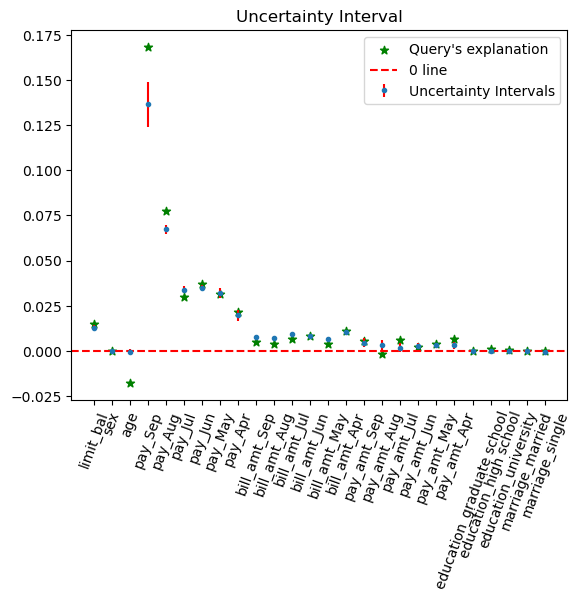

In [14]:
# visualize the uncertainty intervals of Shapley values
shap_values_local = rf_df['shap_con']

n_feature=X_test.shape[1]
errors=np.zeros([2,n_feature])
y_l = shap_ci.mean(axis=1) - np.transpose(shap_ci)[0,:]
y_u =np.transpose(shap_ci)[1,:]-shap_ci.mean(axis=1)

errors[0,:]=y_l
errors[1,:]=y_u
errors
plt.errorbar(np.arange(n_feature),shap_ci.mean(axis=1),yerr=errors,fmt='.', ecolor = 'red',label="Uncertainty Intervals")
plt.scatter(np.arange(n_feature),shap_values_local,marker='*',color="green",label="Query's explanation")#shapley value for the sigle instance 
plt.axhline(y=0, color='r', linestyle='--',label="0 line")
plt.title("Uncertainty Interval")
x=X_train.columns.values
default_x_ticks = range(len(x))
plt.legend()
plt.xticks(default_x_ticks, x, rotation=70.)

([<matplotlib.axis.XTick at 0x23e9b0aa6a0>,
 [Text(0, 0, 'limit_bal'),
  Text(1, 0, 'sex'),
  Text(2, 0, 'age'),
  Text(3, 0, 'pay_Sep'),
  Text(4, 0, 'pay_Aug'),
  Text(5, 0, 'pay_Jul'),
  Text(6, 0, 'pay_Jun'),
  Text(7, 0, 'pay_May'),
  Text(8, 0, 'pay_Apr'),
  Text(9, 0, 'bill_amt_Sep'),
  Text(10, 0, 'bill_amt_Aug'),
  Text(11, 0, 'bill_amt_Jul'),
  Text(12, 0, 'bill_amt_Jun'),
  Text(13, 0, 'bill_amt_May'),
  Text(14, 0, 'bill_amt_Apr'),
  Text(15, 0, 'pay_amt_Sep'),
  Text(16, 0, 'pay_amt_Aug'),
  Text(17, 0, 'pay_amt_Jul'),
  Text(18, 0, 'pay_amt_Jun'),
  Text(19, 0, 'pay_amt_May'),
  Text(20, 0, 'pay_amt_Apr'),
  Text(21, 0, 'education_graduate school'),
  Text(22, 0, 'education_high school'),
  Text(23, 0, 'education_university'),
  Text(24, 0, 'marriage_married'),
  Text(25, 0, 'marriage_single')])

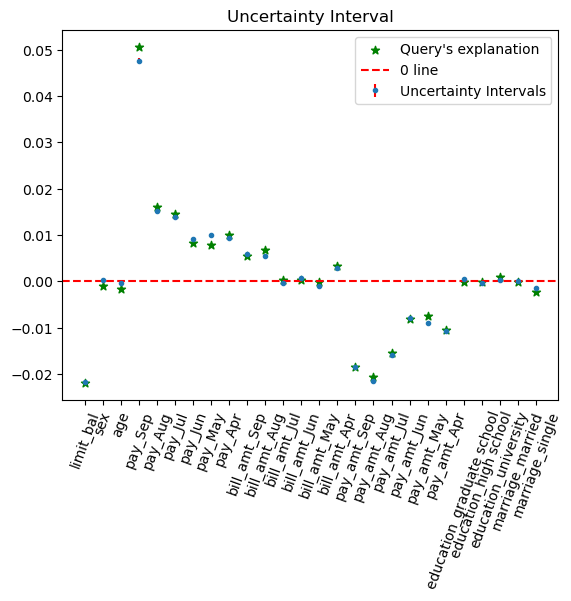

In [17]:
# visualize the uncertainty intervals of LIME coefficient
lime_value_local=rf_df['lime_con']

n_feature=X_test.shape[1]
errors=np.zeros([2,n_feature])
y_l = lime_ci.mean(axis=1) - np.transpose(lime_ci)[0,:]
y_u =np.transpose(lime_ci)[1,:]-lime_ci.mean(axis=1)

errors[0,:]=y_l
errors[1,:]=y_u
errors
plt.errorbar(np.arange(n_feature),lime_ci.mean(axis=1),yerr=errors,fmt='.', ecolor = 'red',label="Uncertainty Intervals")
plt.scatter(np.arange(n_feature),lime_value_local,marker='*',color="green",label="Query's explanation")#shapley value for the sigle instance 
plt.axhline(y=0, color='r', linestyle='--',label="0 line")
plt.title("Uncertainty Interval")
x=X_train.columns.values
default_x_ticks = range(len(x))
plt.legend()
plt.xticks(default_x_ticks, x, rotation=70.)
# green stars are the shapley values for the choosen instance and the red lines are the CI.

In [18]:
#LIME coefficients uncertainty intervals
lime_ci

array([[-2.18373258e-02, -2.13541966e-02],
       [ 1.93955912e-05,  5.75914338e-04],
       [-5.22274698e-04, -3.48599424e-05],
       [ 4.71067316e-02,  4.82208244e-02],
       [ 1.48661537e-02,  1.53747285e-02],
       [ 1.37554407e-02,  1.42188994e-02],
       [ 8.84537120e-03,  9.30794142e-03],
       [ 9.73065756e-03,  1.02264471e-02],
       [ 9.17706266e-03,  9.74560342e-03],
       [ 5.59780142e-03,  6.10154262e-03],
       [ 5.36012090e-03,  5.84211574e-03],
       [-6.11302036e-04, -1.56144466e-04],
       [ 5.94576356e-04,  1.08217367e-03],
       [-1.20992900e-03, -7.51697924e-04],
       [ 2.63496628e-03,  3.08731152e-03],
       [-1.86770149e-02, -1.82760153e-02],
       [-2.16984692e-02, -2.12523136e-02],
       [-1.61548182e-02, -1.57012623e-02],
       [-8.00958556e-03, -7.57799438e-03],
       [-9.23379324e-03, -8.80662724e-03],
       [-1.09426705e-02, -1.04976473e-02],
       [ 3.18939682e-04,  7.37437746e-04],
       [-6.67521498e-04, -1.96394307e-04],
       [ 8.